In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import os

plt.ion()

In [ ]:
class Net(nn.Module):
    """
    Generic MLP with one hidden layer and tanh activation.
    l1, l2, l3 are sizes of input, hidden, and output layer, respectively.
    Note that there are two components in the output layer, corresponding to mean and log(sigma^2), respectively
    """
    def __init__(self, l1, l2, l3):
        super(Net, self).__init__()
        self.fc_h = nn.Linear(l1, l2)
        self.fc_mean = nn.Linear(l2, l3)
        self.fc_log_sigma2 = nn.Linear(l2, l3)
    
    def forward(self, x):
        h = F.relu(self.fc_h(x))
        mean = self.fc_mean(h)
        log_sigma2 = self.fc_log_sigma2(h)
        return mean, log_sigma2

In [ ]:
class VAE:
    """
    Variational autoencoder. Assumes normally distributed output x.
    dec_net and enc_net represent the decoder and encoder networks.
    """
    def __init__(self, z_dim, h_dim, x_dim, save_path = None):
        self.z_dim = z_dim
        self.h_dim = h_dim
        self.x_dim = x_dim
        
        self.dec_net = Net(z_dim, h_dim, x_dim)
        self.enc_net = Net(x_dim, h_dim, z_dim)
        
        self.params = list(self.dec_net.parameters()) + list(self.enc_net.parameters())
        self.optimizer = optim.Adam(self.params, lr = 0.001)
        
        if save_path is not None: self.save_path = '../ckpts/' + save_path
        else: self.save_path = '../ckpts/vae_z={}_h={}_x={}/'.format(z_dim, h_dim, x_dim)
    
    def save_model(self):
        if not os.path.exists(self.save_path): os.makedirs(self.save_path)
        torch.save(self.dec_net.state_dict(), self.save_path + 'dec_net')
        torch.save(self.enc_net.state_dict(), self.save_path + 'enc_net')
        torch.save(self.optimizer.state_dict(), self.save_path + 'optimizer')
    
    def load_model(self):
        if not os.path.exists(self.save_path): return
        self.dec_net.load_state_dict(torch.load(self.save_path + 'dec_net'))
        self.enc_net.load_state_dict(torch.load(self.save_path + 'enc_net'))
        self.optimizer.load_state_dict(torch.load(self.save_path + 'optimizer'))
    
    def train(self, x_data, M = 100, L = 1, num_epochs = 20):
        """
        x_data is assumed to be a tensor of shape (N, x_dim)
        N is the amount of training data
        M is the minibatch size
        L is the number of samples in the Monte Carlo estimator
        num_epochs is number of passes through the training set
        """
        assert(x_data.size()[1] == self.x_dim)
        N = x_data.size()[0]

        self.log_likelihood_data = []
        for epoch in range(num_epochs):
            log_likelihood = 0
            num_times = 0
            x_data = x_data[torch.randperm(N)]
            for i in range(0, N, M):
                self.optimizer.zero_grad()
                
                end = min(i + M, N)
                batch_data = x_data[i:end]
                loss = self.compute_loss(batch_data, N, L)
                log_likelihood -= loss.data[0] / N
                num_times += 1
                
                loss.backward()
                self.optimizer.step()
            
            log_likelihood /= num_times
            print("Epoch {} Marginal Log-Likelihood: {}".format(epoch, log_likelihood))
            self.log_likelihood_data.append(log_likelihood)
        
    def compute_loss(self, batch_data, N, L):
        """
        Computes loss to minimize with gradient descent.
        Negative of equation (10) in the paper.
        We also use a tanh activation on the mean output of the decoder network 
        to constrain it to the interval (-1, 1) (similar to the paper).
        """
        
        M = batch_data.size()[0]
        batch_data = Variable(batch_data)
        enc_mean, enc_log_sigma2 = self.enc_net(batch_data)
        enc_sigma2 = torch.exp(enc_log_sigma2)
        
        loss = -0.5 * torch.sum(1 + enc_log_sigma2 - enc_mean ** 2 - enc_sigma2)
        for l in range(L):
            eps = Variable(torch.randn(self.z_dim))
            z = enc_mean + enc_sigma2 * eps
            dec_mean, dec_log_sigma2 = self.dec_net(z)
            dec_sigma2 = torch.exp(dec_log_sigma2)
            dec_mean = torch.tanh(dec_mean)
            add1 = dec_log_sigma2 + np.log(2 * np.pi)
            add2 = ((batch_data - dec_mean) ** 2) / dec_sigma2
            loss += 0.5 / L * torch.sum(add1 + add2)
        
        return loss * N / M
    
    def sample(self):
        """
        Returns a sample of the generative model (decoder network with isotropic Gaussian prior z)
        """
        
        z = torch.randn(self.z_dim)
        z = Variable(torch.unsqueeze(z, 0))
        dec_mean, dec_log_sigma2 = self.dec_net(z)
        dec_sigma2 = torch.exp(torch.squeeze(dec_log_sigma2.data))
        dec_mean = torch.tanh(torch.squeeze(dec_mean.data))
        x = torch.randn(self.x_dim)
        x = dec_mean + dec_sigma2 * x
        return x


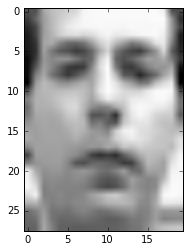

In [446]:
# We test the VAE on the frey face and MNIST datasets, like the paper.
import scipy.io
frey_data = scipy.io.loadmat('../data/frey_rawface.mat')
frey_data = frey_data['ff']
frey_data = np.transpose(frey_data)
frey_data = (frey_data.astype(float) - 128) / 128

def plot_frey(image):
    image = np.reshape(image, (28, 20)) * 128 + 128
    plt.imshow(image, cmap = 'gray')

plot_frey(frey_data[10])


In [411]:
model_frey = VAE(z_dim = 2, h_dim = 200, x_dim = 560, save_path = 'vae_frey_z=2/')
model_frey.load_model()
model_frey.train(torch.Tensor(frey_data), num_epochs = 100000)

Epoch 0 Marginal Log-Likelihood: -349.86519044211195
Epoch 1 Marginal Log-Likelihood: 97.06745114702608
Epoch 2 Marginal Log-Likelihood: 214.56947201017812
Epoch 3 Marginal Log-Likelihood: 270.82428991730274
Epoch 4 Marginal Log-Likelihood: 302.0303109096692
Epoch 5 Marginal Log-Likelihood: 320.05762722646307
Epoch 6 Marginal Log-Likelihood: 328.84612913486
Epoch 7 Marginal Log-Likelihood: 335.83916030534346
Epoch 8 Marginal Log-Likelihood: 340.44552958015265
Epoch 9 Marginal Log-Likelihood: 346.4082363231552
Epoch 10 Marginal Log-Likelihood: 348.39574745547077
Epoch 11 Marginal Log-Likelihood: 357.4086593511451
Epoch 12 Marginal Log-Likelihood: 363.5744513358778
Epoch 13 Marginal Log-Likelihood: 367.3663549618321
Epoch 14 Marginal Log-Likelihood: 367.98710718829517
Epoch 15 Marginal Log-Likelihood: 376.2148600508905
Epoch 16 Marginal Log-Likelihood: 375.4879707379135
Epoch 17 Marginal Log-Likelihood: 381.947070610687
Epoch 18 Marginal Log-Likelihood: 380.72856393129774
Epoch 19 Margin

Epoch 156 Marginal Log-Likelihood: 492.3490807888041
Epoch 157 Marginal Log-Likelihood: 493.522455470738
Epoch 158 Marginal Log-Likelihood: 493.82827290076347
Epoch 159 Marginal Log-Likelihood: 494.5428228371501
Epoch 160 Marginal Log-Likelihood: 495.4699936386768
Epoch 161 Marginal Log-Likelihood: 496.87223123409666
Epoch 162 Marginal Log-Likelihood: 497.33873250636134
Epoch 163 Marginal Log-Likelihood: 498.35589535623404
Epoch 164 Marginal Log-Likelihood: 495.5521692111959
Epoch 165 Marginal Log-Likelihood: 497.63192270992374
Epoch 166 Marginal Log-Likelihood: 498.66707379134857
Epoch 167 Marginal Log-Likelihood: 499.44371342239185
Epoch 168 Marginal Log-Likelihood: 497.7723648218829
Epoch 169 Marginal Log-Likelihood: 502.20259701017795
Epoch 170 Marginal Log-Likelihood: 502.3131440839694
Epoch 171 Marginal Log-Likelihood: 500.2219083969465
Epoch 172 Marginal Log-Likelihood: 503.51874045801526
Epoch 173 Marginal Log-Likelihood: 502.41957538167935
Epoch 174 Marginal Log-Likelihood: 50

Epoch 311 Marginal Log-Likelihood: 575.7145992366413
Epoch 312 Marginal Log-Likelihood: 575.0740155852418
Epoch 313 Marginal Log-Likelihood: 574.4125063613232
Epoch 314 Marginal Log-Likelihood: 576.7002417302798
Epoch 315 Marginal Log-Likelihood: 574.600903307888
Epoch 316 Marginal Log-Likelihood: 574.7128053435115
Epoch 317 Marginal Log-Likelihood: 575.3060209923665
Epoch 318 Marginal Log-Likelihood: 574.5350270356234
Epoch 319 Marginal Log-Likelihood: 575.2351065521627
Epoch 320 Marginal Log-Likelihood: 577.5287627226464
Epoch 321 Marginal Log-Likelihood: 577.1665807888041
Epoch 322 Marginal Log-Likelihood: 579.9492875318066
Epoch 323 Marginal Log-Likelihood: 580.7824077608142
Epoch 324 Marginal Log-Likelihood: 577.8167207379136
Epoch 325 Marginal Log-Likelihood: 580.0738835877863
Epoch 326 Marginal Log-Likelihood: 578.5536704834606
Epoch 327 Marginal Log-Likelihood: 577.632296437659
Epoch 328 Marginal Log-Likelihood: 579.5127703562341
Epoch 329 Marginal Log-Likelihood: 578.639580152

Epoch 466 Marginal Log-Likelihood: 616.347334605598
Epoch 467 Marginal Log-Likelihood: 615.6666762086514
Epoch 468 Marginal Log-Likelihood: 616.7480884223919
Epoch 469 Marginal Log-Likelihood: 616.8296278625955
Epoch 470 Marginal Log-Likelihood: 619.7699363867684
Epoch 471 Marginal Log-Likelihood: 620.142236005089
Epoch 472 Marginal Log-Likelihood: 617.3491125954198
Epoch 473 Marginal Log-Likelihood: 619.3765108142494
Epoch 474 Marginal Log-Likelihood: 616.7711100508905
Epoch 475 Marginal Log-Likelihood: 617.2196087786259
Epoch 476 Marginal Log-Likelihood: 616.6565108142494
Epoch 477 Marginal Log-Likelihood: 617.4806679389313
Epoch 478 Marginal Log-Likelihood: 617.0003975826972
Epoch 479 Marginal Log-Likelihood: 617.7690935114504
Epoch 480 Marginal Log-Likelihood: 616.904036259542
Epoch 481 Marginal Log-Likelihood: 618.6732601781172
Epoch 482 Marginal Log-Likelihood: 618.0458396946566
Epoch 483 Marginal Log-Likelihood: 619.4076399491095
Epoch 484 Marginal Log-Likelihood: 618.5688549618

Epoch 621 Marginal Log-Likelihood: 640.5469942748093
Epoch 622 Marginal Log-Likelihood: 642.0335623409671
Epoch 623 Marginal Log-Likelihood: 638.4738708651398
Epoch 624 Marginal Log-Likelihood: 641.1113422391858
Epoch 625 Marginal Log-Likelihood: 639.4500667938931
Epoch 626 Marginal Log-Likelihood: 640.908320610687
Epoch 627 Marginal Log-Likelihood: 638.9404484732825
Epoch 628 Marginal Log-Likelihood: 639.0243034351145
Epoch 629 Marginal Log-Likelihood: 639.4752512722646
Epoch 630 Marginal Log-Likelihood: 642.1976812977101
Epoch 631 Marginal Log-Likelihood: 641.9192366412213
Epoch 632 Marginal Log-Likelihood: 640.7371215012723
Epoch 633 Marginal Log-Likelihood: 640.8819751908397
Epoch 634 Marginal Log-Likelihood: 640.7200063613234
Epoch 635 Marginal Log-Likelihood: 640.8206170483461
Epoch 636 Marginal Log-Likelihood: 642.3240680661579
Epoch 637 Marginal Log-Likelihood: 641.749398854962
Epoch 638 Marginal Log-Likelihood: 641.89286259542
Epoch 639 Marginal Log-Likelihood: 638.63777035623

Epoch 777 Marginal Log-Likelihood: 654.0853689567429
Epoch 778 Marginal Log-Likelihood: 656.1413486005089
Epoch 779 Marginal Log-Likelihood: 656.0185909669211
Epoch 780 Marginal Log-Likelihood: 656.6449809160306
Epoch 781 Marginal Log-Likelihood: 657.0972868956742
Epoch 782 Marginal Log-Likelihood: 654.4448155216286
Epoch 783 Marginal Log-Likelihood: 656.1074809160307
Epoch 784 Marginal Log-Likelihood: 651.3816380407125
Epoch 785 Marginal Log-Likelihood: 652.8634605597964
Epoch 786 Marginal Log-Likelihood: 655.1181647582697
Epoch 787 Marginal Log-Likelihood: 656.6403339694657
Epoch 788 Marginal Log-Likelihood: 653.2702958015268
Epoch 789 Marginal Log-Likelihood: 653.5731075063611
Epoch 790 Marginal Log-Likelihood: 655.4590998727734
Epoch 791 Marginal Log-Likelihood: 656.8179262086514
Epoch 792 Marginal Log-Likelihood: 657.2762309160306
Epoch 793 Marginal Log-Likelihood: 656.527900763359
Epoch 794 Marginal Log-Likelihood: 657.4545896946564
Epoch 795 Marginal Log-Likelihood: 658.21915394

Epoch 933 Marginal Log-Likelihood: 665.1983651399493
Epoch 934 Marginal Log-Likelihood: 665.8100095419848
Epoch 935 Marginal Log-Likelihood: 665.5121342239186
Epoch 936 Marginal Log-Likelihood: 665.9091284987277
Epoch 937 Marginal Log-Likelihood: 666.8079452926211
Epoch 938 Marginal Log-Likelihood: 669.0930248091603
Epoch 939 Marginal Log-Likelihood: 670.514360687023
Epoch 940 Marginal Log-Likelihood: 668.964631043257
Epoch 941 Marginal Log-Likelihood: 666.3136991094148
Epoch 942 Marginal Log-Likelihood: 667.9634223918576
Epoch 943 Marginal Log-Likelihood: 669.079157124682
Epoch 944 Marginal Log-Likelihood: 670.8143670483461
Epoch 945 Marginal Log-Likelihood: 670.0149300254454
Epoch 946 Marginal Log-Likelihood: 665.4573218829515
Epoch 947 Marginal Log-Likelihood: 668.846867048346
Epoch 948 Marginal Log-Likelihood: 670.6254452926207
Epoch 949 Marginal Log-Likelihood: 670.3301272264632
Epoch 950 Marginal Log-Likelihood: 669.3438326972009
Epoch 951 Marginal Log-Likelihood: 670.43045483460

Epoch 1087 Marginal Log-Likelihood: 678.3977290076335
Epoch 1088 Marginal Log-Likelihood: 676.386762086514
Epoch 1089 Marginal Log-Likelihood: 678.7754580152671
Epoch 1090 Marginal Log-Likelihood: 677.0545133587786
Epoch 1091 Marginal Log-Likelihood: 678.5596215012723
Epoch 1092 Marginal Log-Likelihood: 678.0590585241732
Epoch 1093 Marginal Log-Likelihood: 677.9635877862595
Epoch 1094 Marginal Log-Likelihood: 679.9875127226462
Epoch 1095 Marginal Log-Likelihood: 679.9384541984733
Epoch 1096 Marginal Log-Likelihood: 675.3026081424936
Epoch 1097 Marginal Log-Likelihood: 678.6061577608143
Epoch 1098 Marginal Log-Likelihood: 678.0150508905851
Epoch 1099 Marginal Log-Likelihood: 678.2586005089059
Epoch 1100 Marginal Log-Likelihood: 679.1776749363868
Epoch 1101 Marginal Log-Likelihood: 677.7856011450381
Epoch 1102 Marginal Log-Likelihood: 680.2888835877864
Epoch 1103 Marginal Log-Likelihood: 679.0965012722647
Epoch 1104 Marginal Log-Likelihood: 675.8727926208652
Epoch 1105 Marginal Log-Likel

Epoch 1240 Marginal Log-Likelihood: 685.5589249363867
Epoch 1241 Marginal Log-Likelihood: 684.2093352417302
Epoch 1242 Marginal Log-Likelihood: 684.948854961832
Epoch 1243 Marginal Log-Likelihood: 683.1551208651401
Epoch 1244 Marginal Log-Likelihood: 685.3838136132315
Epoch 1245 Marginal Log-Likelihood: 686.3414344783716
Epoch 1246 Marginal Log-Likelihood: 683.0317652671756
Epoch 1247 Marginal Log-Likelihood: 683.4419402035624
Epoch 1248 Marginal Log-Likelihood: 684.1072010178117
Epoch 1249 Marginal Log-Likelihood: 687.2844274809161
Epoch 1250 Marginal Log-Likelihood: 686.839856870229
Epoch 1251 Marginal Log-Likelihood: 687.4686641221375
Epoch 1252 Marginal Log-Likelihood: 687.4611704834605
Epoch 1253 Marginal Log-Likelihood: 687.6824204834604
Epoch 1254 Marginal Log-Likelihood: 685.5646914758271
Epoch 1255 Marginal Log-Likelihood: 685.6804134860051
Epoch 1256 Marginal Log-Likelihood: 687.8126908396946
Epoch 1257 Marginal Log-Likelihood: 684.1453498727735
Epoch 1258 Marginal Log-Likeli

Epoch 1392 Marginal Log-Likelihood: 691.7834732824424
Epoch 1393 Marginal Log-Likelihood: 692.6703466921119
Epoch 1394 Marginal Log-Likelihood: 690.9088804071246
Epoch 1395 Marginal Log-Likelihood: 690.4796978371502
Epoch 1396 Marginal Log-Likelihood: 691.0217748091602
Epoch 1397 Marginal Log-Likelihood: 692.303155216285
Epoch 1398 Marginal Log-Likelihood: 690.2070642493638
Epoch 1399 Marginal Log-Likelihood: 692.4734382951654
Epoch 1400 Marginal Log-Likelihood: 693.1599904580153
Epoch 1401 Marginal Log-Likelihood: 692.9416857506361
Epoch 1402 Marginal Log-Likelihood: 692.0941984732824
Epoch 1403 Marginal Log-Likelihood: 693.4193765903308
Epoch 1404 Marginal Log-Likelihood: 693.2669179389314
Epoch 1405 Marginal Log-Likelihood: 693.1463963104326
Epoch 1406 Marginal Log-Likelihood: 691.4742334605598
Epoch 1407 Marginal Log-Likelihood: 688.3957856234096
Epoch 1408 Marginal Log-Likelihood: 690.3785623409669
Epoch 1409 Marginal Log-Likelihood: 692.1214090330789
Epoch 1410 Marginal Log-Likel

Epoch 1545 Marginal Log-Likelihood: 697.4639949109414
Epoch 1546 Marginal Log-Likelihood: 699.8008937659033
Epoch 1547 Marginal Log-Likelihood: 700.6203753180661
Epoch 1548 Marginal Log-Likelihood: 696.5106743002543
Epoch 1549 Marginal Log-Likelihood: 695.986062340967
Epoch 1550 Marginal Log-Likelihood: 700.0516157760813
Epoch 1551 Marginal Log-Likelihood: 699.7491094147582
Epoch 1552 Marginal Log-Likelihood: 699.1597041984734
Epoch 1553 Marginal Log-Likelihood: 697.1506138676847
Epoch 1554 Marginal Log-Likelihood: 696.6300508905853
Epoch 1555 Marginal Log-Likelihood: 698.1399109414758
Epoch 1556 Marginal Log-Likelihood: 700.2390489821884
Epoch 1557 Marginal Log-Likelihood: 698.3612818066158
Epoch 1558 Marginal Log-Likelihood: 696.8894083969466
Epoch 1559 Marginal Log-Likelihood: 700.5227544529263
Epoch 1560 Marginal Log-Likelihood: 700.2913676844784
Epoch 1561 Marginal Log-Likelihood: 701.317191475827
Epoch 1562 Marginal Log-Likelihood: 698.9017461832061
Epoch 1563 Marginal Log-Likeli

Epoch 1698 Marginal Log-Likelihood: 701.0693447837151
Epoch 1699 Marginal Log-Likelihood: 704.125496183206
Epoch 1700 Marginal Log-Likelihood: 704.0192525445293
Epoch 1701 Marginal Log-Likelihood: 703.9958365139947
Epoch 1702 Marginal Log-Likelihood: 705.5496882951653
Epoch 1703 Marginal Log-Likelihood: 702.6353021628499
Epoch 1704 Marginal Log-Likelihood: 701.8311132315523
Epoch 1705 Marginal Log-Likelihood: 701.9196660305345
Epoch 1706 Marginal Log-Likelihood: 703.8859987277353
Epoch 1707 Marginal Log-Likelihood: 701.8501749363868
Epoch 1708 Marginal Log-Likelihood: 697.7369720101781
Epoch 1709 Marginal Log-Likelihood: 702.5105438931297
Epoch 1710 Marginal Log-Likelihood: 699.8247741730278
Epoch 1711 Marginal Log-Likelihood: 705.8330184478373
Epoch 1712 Marginal Log-Likelihood: 703.5559192111959
Epoch 1713 Marginal Log-Likelihood: 703.0773791348602
Epoch 1714 Marginal Log-Likelihood: 702.5251240458016
Epoch 1715 Marginal Log-Likelihood: 704.5416253180662
Epoch 1716 Marginal Log-Likel

Epoch 1851 Marginal Log-Likelihood: 706.7490585241728
Epoch 1852 Marginal Log-Likelihood: 706.4626113231553
Epoch 1853 Marginal Log-Likelihood: 711.4709510178117
Epoch 1854 Marginal Log-Likelihood: 707.816227735369
Epoch 1855 Marginal Log-Likelihood: 706.8110655216285
Epoch 1856 Marginal Log-Likelihood: 705.9449427480916
Epoch 1857 Marginal Log-Likelihood: 709.1039058524173
Epoch 1858 Marginal Log-Likelihood: 709.3758874045802
Epoch 1859 Marginal Log-Likelihood: 707.8921914758268
Epoch 1860 Marginal Log-Likelihood: 708.1799236641223
Epoch 1861 Marginal Log-Likelihood: 710.2882633587786
Epoch 1862 Marginal Log-Likelihood: 710.7597805343511
Epoch 1863 Marginal Log-Likelihood: 710.8174904580153
Epoch 1864 Marginal Log-Likelihood: 708.072748091603
Epoch 1865 Marginal Log-Likelihood: 707.6398568702291
Epoch 1866 Marginal Log-Likelihood: 710.4136800254453
Epoch 1867 Marginal Log-Likelihood: 707.4548059796439
Epoch 1868 Marginal Log-Likelihood: 708.3801749363868
Epoch 1869 Marginal Log-Likeli

Epoch 2004 Marginal Log-Likelihood: 713.1476176844783
Epoch 2005 Marginal Log-Likelihood: 711.3341539440205
Epoch 2006 Marginal Log-Likelihood: 713.3223441475826
Epoch 2007 Marginal Log-Likelihood: 712.0347996183207
Epoch 2008 Marginal Log-Likelihood: 713.4446882951654
Epoch 2009 Marginal Log-Likelihood: 711.5455566157759
Epoch 2010 Marginal Log-Likelihood: 712.8206361323154
Epoch 2011 Marginal Log-Likelihood: 712.3053371501272
Epoch 2012 Marginal Log-Likelihood: 714.0066793893129
Epoch 2013 Marginal Log-Likelihood: 710.816415394402
Epoch 2014 Marginal Log-Likelihood: 711.9311259541983
Epoch 2015 Marginal Log-Likelihood: 712.2517684478372
Epoch 2016 Marginal Log-Likelihood: 714.384675572519
Epoch 2017 Marginal Log-Likelihood: 714.6328053435114
Epoch 2018 Marginal Log-Likelihood: 713.4827735368957
Epoch 2019 Marginal Log-Likelihood: 711.6986068702288
Epoch 2020 Marginal Log-Likelihood: 715.6304548346055
Epoch 2021 Marginal Log-Likelihood: 713.94256043257
Epoch 2022 Marginal Log-Likeliho

Epoch 2157 Marginal Log-Likelihood: 715.6975636132316
Epoch 2158 Marginal Log-Likelihood: 717.3216889312977
Epoch 2159 Marginal Log-Likelihood: 716.0735050890585
Epoch 2160 Marginal Log-Likelihood: 718.0025413486004
Epoch 2161 Marginal Log-Likelihood: 717.1990839694656
Epoch 2162 Marginal Log-Likelihood: 717.0979484732825
Epoch 2163 Marginal Log-Likelihood: 717.5333587786259
Epoch 2164 Marginal Log-Likelihood: 716.7369370229007
Epoch 2165 Marginal Log-Likelihood: 717.970143129771
Epoch 2166 Marginal Log-Likelihood: 716.4034828244274
Epoch 2167 Marginal Log-Likelihood: 715.4721787531807
Epoch 2168 Marginal Log-Likelihood: 714.3292302798982
Epoch 2169 Marginal Log-Likelihood: 716.7847550890585
Epoch 2170 Marginal Log-Likelihood: 717.3653435114504
Epoch 2171 Marginal Log-Likelihood: 716.9926367684478
Epoch 2172 Marginal Log-Likelihood: 717.6495833333336
Epoch 2173 Marginal Log-Likelihood: 715.1113740458014
Epoch 2174 Marginal Log-Likelihood: 707.6049173027991
Epoch 2175 Marginal Log-Likel

Epoch 2310 Marginal Log-Likelihood: 719.2230311704836
Epoch 2311 Marginal Log-Likelihood: 714.7570356234097
Epoch 2312 Marginal Log-Likelihood: 719.1773282442748
Epoch 2313 Marginal Log-Likelihood: 720.6957665394402
Epoch 2314 Marginal Log-Likelihood: 719.8382474554708
Epoch 2315 Marginal Log-Likelihood: 721.5030884223918
Epoch 2316 Marginal Log-Likelihood: 721.6954802798982
Epoch 2317 Marginal Log-Likelihood: 718.0690267175571
Epoch 2318 Marginal Log-Likelihood: 719.8151972010177
Epoch 2319 Marginal Log-Likelihood: 721.244503816794
Epoch 2320 Marginal Log-Likelihood: 716.8772550890586
Epoch 2321 Marginal Log-Likelihood: 718.3657410941476
Epoch 2322 Marginal Log-Likelihood: 711.0874904580153
Epoch 2323 Marginal Log-Likelihood: 714.3642430025445
Epoch 2324 Marginal Log-Likelihood: 717.5523155216285
Epoch 2325 Marginal Log-Likelihood: 720.0776717557251
Epoch 2326 Marginal Log-Likelihood: 720.8061768447837
Epoch 2327 Marginal Log-Likelihood: 720.0153180661579
Epoch 2328 Marginal Log-Likel

Epoch 2463 Marginal Log-Likelihood: 722.4475381679388
Epoch 2464 Marginal Log-Likelihood: 724.0680248091604
Epoch 2465 Marginal Log-Likelihood: 724.8457665394403
Epoch 2466 Marginal Log-Likelihood: 724.8229993638677
Epoch 2467 Marginal Log-Likelihood: 721.9951463104326
Epoch 2468 Marginal Log-Likelihood: 723.0502926208653
Epoch 2469 Marginal Log-Likelihood: 721.5211927480917
Epoch 2470 Marginal Log-Likelihood: 720.5562372773537
Epoch 2471 Marginal Log-Likelihood: 722.6552767175574
Epoch 2472 Marginal Log-Likelihood: 724.654020356234
Epoch 2473 Marginal Log-Likelihood: 722.1549809160305
Epoch 2474 Marginal Log-Likelihood: 724.3714472010178
Epoch 2475 Marginal Log-Likelihood: 719.5675445292621
Epoch 2476 Marginal Log-Likelihood: 722.5932379134862
Epoch 2477 Marginal Log-Likelihood: 721.5435559796438
Epoch 2478 Marginal Log-Likelihood: 724.9179484732824
Epoch 2479 Marginal Log-Likelihood: 722.2437881679391
Epoch 2480 Marginal Log-Likelihood: 723.7554834605596
Epoch 2481 Marginal Log-Likel

Epoch 2615 Marginal Log-Likelihood: 724.7125413486004
Epoch 2616 Marginal Log-Likelihood: 728.5110814249363
Epoch 2617 Marginal Log-Likelihood: 717.0471501272265
Epoch 2618 Marginal Log-Likelihood: 718.6491921119593
Epoch 2619 Marginal Log-Likelihood: 724.7179707379134
Epoch 2620 Marginal Log-Likelihood: 724.6545960559796
Epoch 2621 Marginal Log-Likelihood: 724.1845356234096
Epoch 2622 Marginal Log-Likelihood: 726.7352767175573
Epoch 2623 Marginal Log-Likelihood: 724.929376590331
Epoch 2624 Marginal Log-Likelihood: 723.6609701017812
Epoch 2625 Marginal Log-Likelihood: 725.6443797709923
Epoch 2626 Marginal Log-Likelihood: 724.8806488549619
Epoch 2627 Marginal Log-Likelihood: 724.1338263358779
Epoch 2628 Marginal Log-Likelihood: 722.7722709923663
Epoch 2629 Marginal Log-Likelihood: 721.5116603053435
Epoch 2630 Marginal Log-Likelihood: 726.904367048346
Epoch 2631 Marginal Log-Likelihood: 725.4746055979645
Epoch 2632 Marginal Log-Likelihood: 723.4774141221376
Epoch 2633 Marginal Log-Likeli

Epoch 2768 Marginal Log-Likelihood: 726.6518638676844
Epoch 2769 Marginal Log-Likelihood: 727.650050890585
Epoch 2770 Marginal Log-Likelihood: 728.6233365139949
Epoch 2771 Marginal Log-Likelihood: 730.3628562340967
Epoch 2772 Marginal Log-Likelihood: 729.0366412213741
Epoch 2773 Marginal Log-Likelihood: 727.6827767175573
Epoch 2774 Marginal Log-Likelihood: 728.1415744274809
Epoch 2775 Marginal Log-Likelihood: 729.9353021628499
Epoch 2776 Marginal Log-Likelihood: 729.3110687022901
Epoch 2777 Marginal Log-Likelihood: 728.9302417302799
Epoch 2778 Marginal Log-Likelihood: 729.5924618320612
Epoch 2779 Marginal Log-Likelihood: 729.097875318066
Epoch 2780 Marginal Log-Likelihood: 727.7713486005089
Epoch 2781 Marginal Log-Likelihood: 724.8218606870229
Epoch 2782 Marginal Log-Likelihood: 724.959427480916
Epoch 2783 Marginal Log-Likelihood: 719.4011132315521
Epoch 2784 Marginal Log-Likelihood: 721.9551208651399
Epoch 2785 Marginal Log-Likelihood: 728.5707697201018
Epoch 2786 Marginal Log-Likelih

Epoch 2921 Marginal Log-Likelihood: 728.0655152671756
Epoch 2922 Marginal Log-Likelihood: 728.5531806615776
Epoch 2923 Marginal Log-Likelihood: 731.7657188295166
Epoch 2924 Marginal Log-Likelihood: 731.1680852417303
Epoch 2925 Marginal Log-Likelihood: 732.5687118320611
Epoch 2926 Marginal Log-Likelihood: 730.7909637404579
Epoch 2927 Marginal Log-Likelihood: 729.5430947837151
Epoch 2928 Marginal Log-Likelihood: 727.9410909669211
Epoch 2929 Marginal Log-Likelihood: 731.439472010178
Epoch 2930 Marginal Log-Likelihood: 732.5037277353691
Epoch 2931 Marginal Log-Likelihood: 732.3121310432568
Epoch 2932 Marginal Log-Likelihood: 732.4005438931297
Epoch 2933 Marginal Log-Likelihood: 732.8960368956743
Epoch 2934 Marginal Log-Likelihood: 732.4516157760814
Epoch 2935 Marginal Log-Likelihood: 733.7875190839694
Epoch 2936 Marginal Log-Likelihood: 734.5332633587784
Epoch 2937 Marginal Log-Likelihood: 731.8289217557251
Epoch 2938 Marginal Log-Likelihood: 731.5481234096692
Epoch 2939 Marginal Log-Likel

Epoch 3074 Marginal Log-Likelihood: 733.6681138676844
Epoch 3075 Marginal Log-Likelihood: 729.6179993638675
Epoch 3076 Marginal Log-Likelihood: 727.289382951654
Epoch 3077 Marginal Log-Likelihood: 726.6422232824427
Epoch 3078 Marginal Log-Likelihood: 734.2656679389313
Epoch 3079 Marginal Log-Likelihood: 735.7421437659033
Epoch 3080 Marginal Log-Likelihood: 731.9592938931298
Epoch 3081 Marginal Log-Likelihood: 731.5809669211195
Epoch 3082 Marginal Log-Likelihood: 732.8991666666667
Epoch 3083 Marginal Log-Likelihood: 729.8742302798981
Epoch 3084 Marginal Log-Likelihood: 732.4083110687023
Epoch 3085 Marginal Log-Likelihood: 735.0623854961832
Epoch 3086 Marginal Log-Likelihood: 735.0365648854962
Epoch 3087 Marginal Log-Likelihood: 735.7033237913486
Epoch 3088 Marginal Log-Likelihood: 736.2853053435115
Epoch 3089 Marginal Log-Likelihood: 735.3664249363868
Epoch 3090 Marginal Log-Likelihood: 735.0255820610687
Epoch 3091 Marginal Log-Likelihood: 730.7165330788804
Epoch 3092 Marginal Log-Likel

Epoch 3227 Marginal Log-Likelihood: 737.8773473282441
Epoch 3228 Marginal Log-Likelihood: 737.4436895674299
Epoch 3229 Marginal Log-Likelihood: 735.8608110687022
Epoch 3230 Marginal Log-Likelihood: 736.4711132315521
Epoch 3231 Marginal Log-Likelihood: 736.7541952926207
Epoch 3232 Marginal Log-Likelihood: 738.1302003816795
Epoch 3233 Marginal Log-Likelihood: 732.4397391857508
Epoch 3234 Marginal Log-Likelihood: 729.6902226463104
Epoch 3235 Marginal Log-Likelihood: 737.1758269720103
Epoch 3236 Marginal Log-Likelihood: 737.0687150127227
Epoch 3237 Marginal Log-Likelihood: 736.8221819338422
Epoch 3238 Marginal Log-Likelihood: 735.5623314249362
Epoch 3239 Marginal Log-Likelihood: 733.9447519083969
Epoch 3240 Marginal Log-Likelihood: 737.0466730279898
Epoch 3241 Marginal Log-Likelihood: 732.791046437659
Epoch 3242 Marginal Log-Likelihood: 735.6353594147583
Epoch 3243 Marginal Log-Likelihood: 735.931316793893
Epoch 3244 Marginal Log-Likelihood: 736.7274904580152
Epoch 3245 Marginal Log-Likeli

Epoch 3380 Marginal Log-Likelihood: 739.8157919847329
Epoch 3381 Marginal Log-Likelihood: 733.5380502544529
Epoch 3382 Marginal Log-Likelihood: 735.9604707379134
Epoch 3383 Marginal Log-Likelihood: 739.1408937659035
Epoch 3384 Marginal Log-Likelihood: 738.6226908396945
Epoch 3385 Marginal Log-Likelihood: 740.2060368956743
Epoch 3386 Marginal Log-Likelihood: 741.5881329516538
Epoch 3387 Marginal Log-Likelihood: 740.6809128498728
Epoch 3388 Marginal Log-Likelihood: 738.7620165394403
Epoch 3389 Marginal Log-Likelihood: 738.557350508906
Epoch 3390 Marginal Log-Likelihood: 739.7012309160306
Epoch 3391 Marginal Log-Likelihood: 734.7159605597965
Epoch 3392 Marginal Log-Likelihood: 736.2253530534351
Epoch 3393 Marginal Log-Likelihood: 734.8545674300253
Epoch 3394 Marginal Log-Likelihood: 740.1395419847328
Epoch 3395 Marginal Log-Likelihood: 736.3982697201018
Epoch 3396 Marginal Log-Likelihood: 737.5161132315521
Epoch 3397 Marginal Log-Likelihood: 737.7273091603055
Epoch 3398 Marginal Log-Likel

Epoch 3533 Marginal Log-Likelihood: 742.3332760814249
Epoch 3534 Marginal Log-Likelihood: 740.8359669211196
Epoch 3535 Marginal Log-Likelihood: 741.3640394402034
Epoch 3536 Marginal Log-Likelihood: 739.7247010178116
Epoch 3537 Marginal Log-Likelihood: 740.1540871501272
Epoch 3538 Marginal Log-Likelihood: 740.6333810432569
Epoch 3539 Marginal Log-Likelihood: 739.763893129771
Epoch 3540 Marginal Log-Likelihood: 733.7471851145038
Epoch 3541 Marginal Log-Likelihood: 738.8169083969467
Epoch 3542 Marginal Log-Likelihood: 740.1558333333332
Epoch 3543 Marginal Log-Likelihood: 740.8847805343513
Epoch 3544 Marginal Log-Likelihood: 739.6767398218828
Epoch 3545 Marginal Log-Likelihood: 740.6291094147583
Epoch 3546 Marginal Log-Likelihood: 740.5381393129771
Epoch 3547 Marginal Log-Likelihood: 741.0402798982188
Epoch 3548 Marginal Log-Likelihood: 740.614382951654
Epoch 3549 Marginal Log-Likelihood: 739.097191475827
Epoch 3550 Marginal Log-Likelihood: 742.5515012722647
Epoch 3551 Marginal Log-Likelih

Epoch 3685 Marginal Log-Likelihood: 741.549255725191
Epoch 3686 Marginal Log-Likelihood: 741.0875572519084
Epoch 3687 Marginal Log-Likelihood: 743.4985941475826
Epoch 3688 Marginal Log-Likelihood: 741.6215935114503
Epoch 3689 Marginal Log-Likelihood: 739.2531456743002
Epoch 3690 Marginal Log-Likelihood: 742.7669306615776
Epoch 3691 Marginal Log-Likelihood: 742.38643129771
Epoch 3692 Marginal Log-Likelihood: 741.5201049618322
Epoch 3693 Marginal Log-Likelihood: 737.3191762086515
Epoch 3694 Marginal Log-Likelihood: 730.1957792620865
Epoch 3695 Marginal Log-Likelihood: 736.8627194656489
Epoch 3696 Marginal Log-Likelihood: 741.0301558524175
Epoch 3697 Marginal Log-Likelihood: 743.5843638676845
Epoch 3698 Marginal Log-Likelihood: 739.7470674300255
Epoch 3699 Marginal Log-Likelihood: 738.7836036895674
Epoch 3700 Marginal Log-Likelihood: 741.9619465648855
Epoch 3701 Marginal Log-Likelihood: 740.6410941475825
Epoch 3702 Marginal Log-Likelihood: 742.4403657760815
Epoch 3703 Marginal Log-Likelih

Epoch 3838 Marginal Log-Likelihood: 745.452582697201
Epoch 3839 Marginal Log-Likelihood: 743.5922264631043
Epoch 3840 Marginal Log-Likelihood: 743.0796851145037
Epoch 3841 Marginal Log-Likelihood: 741.0047900763359
Epoch 3842 Marginal Log-Likelihood: 740.7514631043258
Epoch 3843 Marginal Log-Likelihood: 741.965836513995
Epoch 3844 Marginal Log-Likelihood: 744.1647169211194
Epoch 3845 Marginal Log-Likelihood: 741.5917557251909
Epoch 3846 Marginal Log-Likelihood: 739.5013804071248
Epoch 3847 Marginal Log-Likelihood: 743.0849332061069
Epoch 3848 Marginal Log-Likelihood: 742.638562340967
Epoch 3849 Marginal Log-Likelihood: 744.4954484732825
Epoch 3850 Marginal Log-Likelihood: 744.0811641221375
Epoch 3851 Marginal Log-Likelihood: 741.7502512722646
Epoch 3852 Marginal Log-Likelihood: 741.5812913486004
Epoch 3853 Marginal Log-Likelihood: 743.7397932569975
Epoch 3854 Marginal Log-Likelihood: 741.4841634860051
Epoch 3855 Marginal Log-Likelihood: 740.1841571246819
Epoch 3856 Marginal Log-Likelih

Epoch 3991 Marginal Log-Likelihood: 745.2699204834605
Epoch 3992 Marginal Log-Likelihood: 745.2488040712468
Epoch 3993 Marginal Log-Likelihood: 744.032356870229
Epoch 3994 Marginal Log-Likelihood: 744.0108715012723
Epoch 3995 Marginal Log-Likelihood: 745.9007569974553
Epoch 3996 Marginal Log-Likelihood: 744.2622010178117
Epoch 3997 Marginal Log-Likelihood: 745.2007251908398
Epoch 3998 Marginal Log-Likelihood: 746.4464503816795
Epoch 3999 Marginal Log-Likelihood: 743.211234096692
Epoch 4000 Marginal Log-Likelihood: 743.0744624681936
Epoch 4001 Marginal Log-Likelihood: 746.7827385496183
Epoch 4002 Marginal Log-Likelihood: 743.5375572519085
Epoch 4003 Marginal Log-Likelihood: 741.0954166666668
Epoch 4004 Marginal Log-Likelihood: 736.8061323155217
Epoch 4005 Marginal Log-Likelihood: 743.1225381679392
Epoch 4006 Marginal Log-Likelihood: 746.9788549618321
Epoch 4007 Marginal Log-Likelihood: 746.2101812977099
Epoch 4008 Marginal Log-Likelihood: 742.5206456743002
Epoch 4009 Marginal Log-Likeli

Epoch 4143 Marginal Log-Likelihood: 749.0614472010178
Epoch 4144 Marginal Log-Likelihood: 746.6655438931298
Epoch 4145 Marginal Log-Likelihood: 743.3536291348602
Epoch 4146 Marginal Log-Likelihood: 745.316332697201
Epoch 4147 Marginal Log-Likelihood: 745.8718256997455
Epoch 4148 Marginal Log-Likelihood: 746.8547646310433
Epoch 4149 Marginal Log-Likelihood: 746.2468734096692
Epoch 4150 Marginal Log-Likelihood: 746.488937659033
Epoch 4151 Marginal Log-Likelihood: 743.5214185750635
Epoch 4152 Marginal Log-Likelihood: 746.8459192111959
Epoch 4153 Marginal Log-Likelihood: 746.5576558524173
Epoch 4154 Marginal Log-Likelihood: 747.1167589058525
Epoch 4155 Marginal Log-Likelihood: 748.4039185750637
Epoch 4156 Marginal Log-Likelihood: 748.7476717557253
Epoch 4157 Marginal Log-Likelihood: 747.7381870229008
Epoch 4158 Marginal Log-Likelihood: 746.2067080152672
Epoch 4159 Marginal Log-Likelihood: 747.3002449109415
Epoch 4160 Marginal Log-Likelihood: 746.4960877862596
Epoch 4161 Marginal Log-Likeli

Epoch 4296 Marginal Log-Likelihood: 750.9611450381678
Epoch 4297 Marginal Log-Likelihood: 749.4677067430025
Epoch 4298 Marginal Log-Likelihood: 750.0859923664123
Epoch 4299 Marginal Log-Likelihood: 749.281040076336
Epoch 4300 Marginal Log-Likelihood: 745.6535750636133
Epoch 4301 Marginal Log-Likelihood: 745.6725890585241
Epoch 4302 Marginal Log-Likelihood: 744.3492080152673
Epoch 4303 Marginal Log-Likelihood: 746.1397455470739
Epoch 4304 Marginal Log-Likelihood: 745.1661673027991
Epoch 4305 Marginal Log-Likelihood: 745.9563167938932
Epoch 4306 Marginal Log-Likelihood: 741.8796024173029
Epoch 4307 Marginal Log-Likelihood: 745.5701653944021
Epoch 4308 Marginal Log-Likelihood: 748.9481393129768
Epoch 4309 Marginal Log-Likelihood: 746.3806424936386
Epoch 4310 Marginal Log-Likelihood: 744.3728848600508
Epoch 4311 Marginal Log-Likelihood: 747.8793034351145
Epoch 4312 Marginal Log-Likelihood: 748.1772073791349
Epoch 4313 Marginal Log-Likelihood: 749.9381456743002
Epoch 4314 Marginal Log-Likel

Epoch 4449 Marginal Log-Likelihood: 747.2326908396947
Epoch 4450 Marginal Log-Likelihood: 749.8090298982188
Epoch 4451 Marginal Log-Likelihood: 752.1382315521628
Epoch 4452 Marginal Log-Likelihood: 750.4080852417303
Epoch 4453 Marginal Log-Likelihood: 748.5253721374047
Epoch 4454 Marginal Log-Likelihood: 750.1950222646308
Epoch 4455 Marginal Log-Likelihood: 750.4773473282443
Epoch 4456 Marginal Log-Likelihood: 747.4632888040712
Epoch 4457 Marginal Log-Likelihood: 749.0878466921121
Epoch 4458 Marginal Log-Likelihood: 749.4687913486005
Epoch 4459 Marginal Log-Likelihood: 746.0829611959288
Epoch 4460 Marginal Log-Likelihood: 745.9008015267176
Epoch 4461 Marginal Log-Likelihood: 745.1829993638677
Epoch 4462 Marginal Log-Likelihood: 746.8956647582697
Epoch 4463 Marginal Log-Likelihood: 748.1560814249366
Epoch 4464 Marginal Log-Likelihood: 748.9315394402036
Epoch 4465 Marginal Log-Likelihood: 749.9745642493639
Epoch 4466 Marginal Log-Likelihood: 750.0224363867686
Epoch 4467 Marginal Log-Like

Epoch 4602 Marginal Log-Likelihood: 750.5269497455471
Epoch 4603 Marginal Log-Likelihood: 750.2495483460559
Epoch 4604 Marginal Log-Likelihood: 750.0458460559796
Epoch 4605 Marginal Log-Likelihood: 749.3588390585243
Epoch 4606 Marginal Log-Likelihood: 745.1783683206107
Epoch 4607 Marginal Log-Likelihood: 737.5425413486004
Epoch 4608 Marginal Log-Likelihood: 747.0022900763358
Epoch 4609 Marginal Log-Likelihood: 753.1239885496185
Epoch 4610 Marginal Log-Likelihood: 751.3495960559795
Epoch 4611 Marginal Log-Likelihood: 746.7700190839696
Epoch 4612 Marginal Log-Likelihood: 750.668101145038
Epoch 4613 Marginal Log-Likelihood: 750.0402035623408
Epoch 4614 Marginal Log-Likelihood: 749.7017875318065
Epoch 4615 Marginal Log-Likelihood: 753.1338517811705
Epoch 4616 Marginal Log-Likelihood: 750.2050572519081
Epoch 4617 Marginal Log-Likelihood: 752.2872996183206
Epoch 4618 Marginal Log-Likelihood: 751.913540076336
Epoch 4619 Marginal Log-Likelihood: 747.973893129771
Epoch 4620 Marginal Log-Likelih

Epoch 4755 Marginal Log-Likelihood: 752.7237309160305
Epoch 4756 Marginal Log-Likelihood: 752.105248091603
Epoch 4757 Marginal Log-Likelihood: 751.045324427481
Epoch 4758 Marginal Log-Likelihood: 753.2630311704835
Epoch 4759 Marginal Log-Likelihood: 753.9183874045804
Epoch 4760 Marginal Log-Likelihood: 752.2066539440204
Epoch 4761 Marginal Log-Likelihood: 751.6452003816793
Epoch 4762 Marginal Log-Likelihood: 754.426933842239
Epoch 4763 Marginal Log-Likelihood: 753.1027385496182
Epoch 4764 Marginal Log-Likelihood: 752.2281806615775
Epoch 4765 Marginal Log-Likelihood: 753.5428498727736
Epoch 4766 Marginal Log-Likelihood: 753.4618002544531
Epoch 4767 Marginal Log-Likelihood: 751.1618479643766
Epoch 4768 Marginal Log-Likelihood: 751.0148187022902
Epoch 4769 Marginal Log-Likelihood: 752.0137881679387
Epoch 4770 Marginal Log-Likelihood: 752.5706075063615
Epoch 4771 Marginal Log-Likelihood: 752.9682824427481
Epoch 4772 Marginal Log-Likelihood: 752.9990458015268
Epoch 4773 Marginal Log-Likelih

Epoch 4908 Marginal Log-Likelihood: 752.5315171755726
Epoch 4909 Marginal Log-Likelihood: 755.0775986005088
Epoch 4910 Marginal Log-Likelihood: 753.1830979643767
Epoch 4911 Marginal Log-Likelihood: 752.4161068702289
Epoch 4912 Marginal Log-Likelihood: 750.1512627226463
Epoch 4913 Marginal Log-Likelihood: 750.3938104325699
Epoch 4914 Marginal Log-Likelihood: 752.7854198473281
Epoch 4915 Marginal Log-Likelihood: 752.5425731552162
Epoch 4916 Marginal Log-Likelihood: 749.3305597964375
Epoch 4917 Marginal Log-Likelihood: 750.6421787531806
Epoch 4918 Marginal Log-Likelihood: 753.373298346056
Epoch 4919 Marginal Log-Likelihood: 754.460941475827
Epoch 4920 Marginal Log-Likelihood: 752.9736609414757
Epoch 4921 Marginal Log-Likelihood: 754.6347296437659
Epoch 4922 Marginal Log-Likelihood: 751.7427035623409
Epoch 4923 Marginal Log-Likelihood: 754.6096055979644
Epoch 4924 Marginal Log-Likelihood: 754.3159605597964
Epoch 4925 Marginal Log-Likelihood: 753.3378657760813
Epoch 4926 Marginal Log-Likeli

Epoch 5061 Marginal Log-Likelihood: 755.4336800254454
Epoch 5062 Marginal Log-Likelihood: 751.8561164122137
Epoch 5063 Marginal Log-Likelihood: 754.3059223918574
Epoch 5064 Marginal Log-Likelihood: 745.965594783715
Epoch 5065 Marginal Log-Likelihood: 750.8146087786258
Epoch 5066 Marginal Log-Likelihood: 754.2471723918576
Epoch 5067 Marginal Log-Likelihood: 755.4829230279897
Epoch 5068 Marginal Log-Likelihood: 754.9184064885496
Epoch 5069 Marginal Log-Likelihood: 752.7869083969467
Epoch 5070 Marginal Log-Likelihood: 754.5659033078882
Epoch 5071 Marginal Log-Likelihood: 756.7276781170483
Epoch 5072 Marginal Log-Likelihood: 755.3721246819339
Epoch 5073 Marginal Log-Likelihood: 749.4858396946565
Epoch 5074 Marginal Log-Likelihood: 748.8426908396947
Epoch 5075 Marginal Log-Likelihood: 752.9708396946564
Epoch 5076 Marginal Log-Likelihood: 754.7571437659032
Epoch 5077 Marginal Log-Likelihood: 755.6349681933842
Epoch 5078 Marginal Log-Likelihood: 753.7517334605598
Epoch 5079 Marginal Log-Likel

Epoch 5214 Marginal Log-Likelihood: 754.8513454198473
Epoch 5215 Marginal Log-Likelihood: 755.6918066157762
Epoch 5216 Marginal Log-Likelihood: 753.7622137404579
Epoch 5217 Marginal Log-Likelihood: 754.7460241730281
Epoch 5218 Marginal Log-Likelihood: 753.0797010178117
Epoch 5219 Marginal Log-Likelihood: 754.3994465648855
Epoch 5220 Marginal Log-Likelihood: 750.679443384224
Epoch 5221 Marginal Log-Likelihood: 752.0761227735368
Epoch 5222 Marginal Log-Likelihood: 754.0306234096691
Epoch 5223 Marginal Log-Likelihood: 753.8907856234098
Epoch 5224 Marginal Log-Likelihood: 755.7603212468196
Epoch 5225 Marginal Log-Likelihood: 756.3659701017813
Epoch 5226 Marginal Log-Likelihood: 755.2790903307889
Epoch 5227 Marginal Log-Likelihood: 756.2829516539439
Epoch 5228 Marginal Log-Likelihood: 756.1122455470738
Epoch 5229 Marginal Log-Likelihood: 757.4244751908395
Epoch 5230 Marginal Log-Likelihood: 757.2147932569975
Epoch 5231 Marginal Log-Likelihood: 753.6906583969466
Epoch 5232 Marginal Log-Likel

Epoch 5366 Marginal Log-Likelihood: 753.1206806615776
Epoch 5367 Marginal Log-Likelihood: 755.2473886768448
Epoch 5368 Marginal Log-Likelihood: 756.7925159033078
Epoch 5369 Marginal Log-Likelihood: 754.1299554707379
Epoch 5370 Marginal Log-Likelihood: 754.4443861323153
Epoch 5371 Marginal Log-Likelihood: 755.1293797709923
Epoch 5372 Marginal Log-Likelihood: 756.0919974554707
Epoch 5373 Marginal Log-Likelihood: 755.9814853689566
Epoch 5374 Marginal Log-Likelihood: 756.1406138676846
Epoch 5375 Marginal Log-Likelihood: 755.9564058524173
Epoch 5376 Marginal Log-Likelihood: 756.5334637404579
Epoch 5377 Marginal Log-Likelihood: 758.9544656488549
Epoch 5378 Marginal Log-Likelihood: 753.6480025445294
Epoch 5379 Marginal Log-Likelihood: 757.1990776081426
Epoch 5380 Marginal Log-Likelihood: 755.5218924936387
Epoch 5381 Marginal Log-Likelihood: 754.7453307888042
Epoch 5382 Marginal Log-Likelihood: 755.8691603053435
Epoch 5383 Marginal Log-Likelihood: 756.5406583969467
Epoch 5384 Marginal Log-Like

Epoch 5519 Marginal Log-Likelihood: 757.5175508905852
Epoch 5520 Marginal Log-Likelihood: 757.2385368956742
Epoch 5521 Marginal Log-Likelihood: 758.2516507633587
Epoch 5522 Marginal Log-Likelihood: 756.6597201017812
Epoch 5523 Marginal Log-Likelihood: 756.6263517811706
Epoch 5524 Marginal Log-Likelihood: 750.5424459287532
Epoch 5525 Marginal Log-Likelihood: 756.362340966921
Epoch 5526 Marginal Log-Likelihood: 755.7695928753179
Epoch 5527 Marginal Log-Likelihood: 758.3350731552162
Epoch 5528 Marginal Log-Likelihood: 757.8526749363868
Epoch 5529 Marginal Log-Likelihood: 755.9810782442747
Epoch 5530 Marginal Log-Likelihood: 756.0772041984734
Epoch 5531 Marginal Log-Likelihood: 756.3510337150126
Epoch 5532 Marginal Log-Likelihood: 752.6213676844784
Epoch 5533 Marginal Log-Likelihood: 756.8257538167938
Epoch 5534 Marginal Log-Likelihood: 756.0705534351147
Epoch 5535 Marginal Log-Likelihood: 756.5620388040713
Epoch 5536 Marginal Log-Likelihood: 754.3543479643765
Epoch 5537 Marginal Log-Likel

Epoch 5672 Marginal Log-Likelihood: 749.6746628498729
Epoch 5673 Marginal Log-Likelihood: 754.3973632315522
Epoch 5674 Marginal Log-Likelihood: 759.9281456743003
Epoch 5675 Marginal Log-Likelihood: 756.5995674300254
Epoch 5676 Marginal Log-Likelihood: 757.2144751908396
Epoch 5677 Marginal Log-Likelihood: 757.6584446564885
Epoch 5678 Marginal Log-Likelihood: 757.2455947837149
Epoch 5679 Marginal Log-Likelihood: 760.251520356234
Epoch 5680 Marginal Log-Likelihood: 755.1215394402036
Epoch 5681 Marginal Log-Likelihood: 755.70338740458
Epoch 5682 Marginal Log-Likelihood: 756.9988581424936
Epoch 5683 Marginal Log-Likelihood: 755.0837531806616
Epoch 5684 Marginal Log-Likelihood: 759.5740935114502
Epoch 5685 Marginal Log-Likelihood: 758.4574681933843
Epoch 5686 Marginal Log-Likelihood: 757.6764758269721
Epoch 5687 Marginal Log-Likelihood: 759.4423027989822
Epoch 5688 Marginal Log-Likelihood: 751.1896564885498
Epoch 5689 Marginal Log-Likelihood: 757.8747773536895
Epoch 5690 Marginal Log-Likelih

Epoch 5825 Marginal Log-Likelihood: 759.0483937659034
Epoch 5826 Marginal Log-Likelihood: 761.3772773536896
Epoch 5827 Marginal Log-Likelihood: 758.7748282442747
Epoch 5828 Marginal Log-Likelihood: 757.8678435114502
Epoch 5829 Marginal Log-Likelihood: 759.8458715012723
Epoch 5830 Marginal Log-Likelihood: 760.7297105597964
Epoch 5831 Marginal Log-Likelihood: 757.9498314249365
Epoch 5832 Marginal Log-Likelihood: 753.1906965648855
Epoch 5833 Marginal Log-Likelihood: 755.2761704834605
Epoch 5834 Marginal Log-Likelihood: 757.2241698473283
Epoch 5835 Marginal Log-Likelihood: 755.242477735369
Epoch 5836 Marginal Log-Likelihood: 759.0776972010178
Epoch 5837 Marginal Log-Likelihood: 757.7809669211196
Epoch 5838 Marginal Log-Likelihood: 757.7989408396945
Epoch 5839 Marginal Log-Likelihood: 759.3134382951655
Epoch 5840 Marginal Log-Likelihood: 755.4253466921119
Epoch 5841 Marginal Log-Likelihood: 758.2156520356234
Epoch 5842 Marginal Log-Likelihood: 758.3226017811704
Epoch 5843 Marginal Log-Likel

Epoch 5977 Marginal Log-Likelihood: 756.9750954198474
Epoch 5978 Marginal Log-Likelihood: 759.3397232824427
Epoch 5979 Marginal Log-Likelihood: 759.5845737913486
Epoch 5980 Marginal Log-Likelihood: 758.268110687023
Epoch 5981 Marginal Log-Likelihood: 761.9726972010178
Epoch 5982 Marginal Log-Likelihood: 758.9989153944018
Epoch 5983 Marginal Log-Likelihood: 756.1356679389313
Epoch 5984 Marginal Log-Likelihood: 747.9690903307887
Epoch 5985 Marginal Log-Likelihood: 757.7045133587787
Epoch 5986 Marginal Log-Likelihood: 756.7023854961833
Epoch 5987 Marginal Log-Likelihood: 757.7697264631042
Epoch 5988 Marginal Log-Likelihood: 759.8183524173027
Epoch 5989 Marginal Log-Likelihood: 762.9524077608141
Epoch 5990 Marginal Log-Likelihood: 761.6399077608143
Epoch 5991 Marginal Log-Likelihood: 762.17118956743
Epoch 5992 Marginal Log-Likelihood: 759.0780756997455
Epoch 5993 Marginal Log-Likelihood: 759.6493924936387
Epoch 5994 Marginal Log-Likelihood: 759.2682506361323
Epoch 5995 Marginal Log-Likelih

Epoch 6130 Marginal Log-Likelihood: 756.7359478371499
Epoch 6131 Marginal Log-Likelihood: 759.044751908397
Epoch 6132 Marginal Log-Likelihood: 759.8514503816793
Epoch 6133 Marginal Log-Likelihood: 761.2870992366413
Epoch 6134 Marginal Log-Likelihood: 759.536905216285
Epoch 6135 Marginal Log-Likelihood: 756.2079516539438
Epoch 6136 Marginal Log-Likelihood: 760.6001145038167
Epoch 6137 Marginal Log-Likelihood: 763.3876399491094
Epoch 6138 Marginal Log-Likelihood: 760.8408524173027
Epoch 6139 Marginal Log-Likelihood: 762.3958460559799
Epoch 6140 Marginal Log-Likelihood: 761.0431838422392
Epoch 6141 Marginal Log-Likelihood: 761.8963422391856
Epoch 6142 Marginal Log-Likelihood: 761.3127321882953
Epoch 6143 Marginal Log-Likelihood: 759.681679389313
Epoch 6144 Marginal Log-Likelihood: 758.7596628498727
Epoch 6145 Marginal Log-Likelihood: 760.7432283715013
Epoch 6146 Marginal Log-Likelihood: 756.6225731552162
Epoch 6147 Marginal Log-Likelihood: 760.3234828244274
Epoch 6148 Marginal Log-Likelih

Epoch 6283 Marginal Log-Likelihood: 760.8642938931299
Epoch 6284 Marginal Log-Likelihood: 760.4382888040711
Epoch 6285 Marginal Log-Likelihood: 759.9612022900761
Epoch 6286 Marginal Log-Likelihood: 759.9319243002545
Epoch 6287 Marginal Log-Likelihood: 758.1280979643767
Epoch 6288 Marginal Log-Likelihood: 761.7665267175573
Epoch 6289 Marginal Log-Likelihood: 763.3762690839694
Epoch 6290 Marginal Log-Likelihood: 761.9410559796438
Epoch 6291 Marginal Log-Likelihood: 760.1266189567428
Epoch 6292 Marginal Log-Likelihood: 762.3725954198474
Epoch 6293 Marginal Log-Likelihood: 755.2832633587786
Epoch 6294 Marginal Log-Likelihood: 760.5563358778625
Epoch 6295 Marginal Log-Likelihood: 758.5139726463103
Epoch 6296 Marginal Log-Likelihood: 759.0122837150128
Epoch 6297 Marginal Log-Likelihood: 755.2188676844784
Epoch 6298 Marginal Log-Likelihood: 758.6055248091603
Epoch 6299 Marginal Log-Likelihood: 759.8941921119591
Epoch 6300 Marginal Log-Likelihood: 760.5822391857507
Epoch 6301 Marginal Log-Like

Epoch 6435 Marginal Log-Likelihood: 761.0169274809159
Epoch 6436 Marginal Log-Likelihood: 763.5210209923664
Epoch 6437 Marginal Log-Likelihood: 764.3422360050891
Epoch 6438 Marginal Log-Likelihood: 762.276399491094
Epoch 6439 Marginal Log-Likelihood: 761.1944338422393
Epoch 6440 Marginal Log-Likelihood: 762.090082697201
Epoch 6441 Marginal Log-Likelihood: 759.2286323155215
Epoch 6442 Marginal Log-Likelihood: 760.8093670483462
Epoch 6443 Marginal Log-Likelihood: 762.638425572519
Epoch 6444 Marginal Log-Likelihood: 763.3587849872772
Epoch 6445 Marginal Log-Likelihood: 760.6619370229007
Epoch 6446 Marginal Log-Likelihood: 758.9179166666665
Epoch 6447 Marginal Log-Likelihood: 758.5833810432571
Epoch 6448 Marginal Log-Likelihood: 758.1080820610688
Epoch 6449 Marginal Log-Likelihood: 761.9895197201015
Epoch 6450 Marginal Log-Likelihood: 761.567175572519
Epoch 6451 Marginal Log-Likelihood: 761.6193861323156
Epoch 6452 Marginal Log-Likelihood: 762.1758174300255
Epoch 6453 Marginal Log-Likeliho

Epoch 6588 Marginal Log-Likelihood: 761.5161704834605
Epoch 6589 Marginal Log-Likelihood: 763.8283810432569
Epoch 6590 Marginal Log-Likelihood: 764.9161354961832
Epoch 6591 Marginal Log-Likelihood: 755.9456393129773
Epoch 6592 Marginal Log-Likelihood: 764.2287372773537
Epoch 6593 Marginal Log-Likelihood: 764.7242875318067
Epoch 6594 Marginal Log-Likelihood: 763.1620547073793
Epoch 6595 Marginal Log-Likelihood: 763.3300954198473
Epoch 6596 Marginal Log-Likelihood: 763.8296564885496
Epoch 6597 Marginal Log-Likelihood: 763.1567493638678
Epoch 6598 Marginal Log-Likelihood: 764.3270069974554
Epoch 6599 Marginal Log-Likelihood: 760.6947646310432
Epoch 6600 Marginal Log-Likelihood: 761.9472996183206
Epoch 6601 Marginal Log-Likelihood: 764.9060782442748
Epoch 6602 Marginal Log-Likelihood: 759.8979484732824
Epoch 6603 Marginal Log-Likelihood: 763.802032442748
Epoch 6604 Marginal Log-Likelihood: 762.5545610687024
Epoch 6605 Marginal Log-Likelihood: 763.3999650127228
Epoch 6606 Marginal Log-Likel

Epoch 6741 Marginal Log-Likelihood: 762.3352671755725
Epoch 6742 Marginal Log-Likelihood: 762.6692111959287
Epoch 6743 Marginal Log-Likelihood: 757.6316189567431
Epoch 6744 Marginal Log-Likelihood: 760.3266762086514
Epoch 6745 Marginal Log-Likelihood: 762.7212690839694
Epoch 6746 Marginal Log-Likelihood: 761.5091253180661
Epoch 6747 Marginal Log-Likelihood: 763.250715648855
Epoch 6748 Marginal Log-Likelihood: 763.397032442748
Epoch 6749 Marginal Log-Likelihood: 759.3441825699745
Epoch 6750 Marginal Log-Likelihood: 761.5908778625956
Epoch 6751 Marginal Log-Likelihood: 763.7266762086513
Epoch 6752 Marginal Log-Likelihood: 765.0992430025447
Epoch 6753 Marginal Log-Likelihood: 762.864277989822
Epoch 6754 Marginal Log-Likelihood: 762.069796437659
Epoch 6755 Marginal Log-Likelihood: 764.9379548346058
Epoch 6756 Marginal Log-Likelihood: 764.9875858778628
Epoch 6757 Marginal Log-Likelihood: 763.1998441475827
Epoch 6758 Marginal Log-Likelihood: 761.6438072519084
Epoch 6759 Marginal Log-Likeliho

Epoch 6894 Marginal Log-Likelihood: 760.2095547073792
Epoch 6895 Marginal Log-Likelihood: 761.0820960559796
Epoch 6896 Marginal Log-Likelihood: 763.2318161577607
Epoch 6897 Marginal Log-Likelihood: 763.775489821883
Epoch 6898 Marginal Log-Likelihood: 760.7398536895676
Epoch 6899 Marginal Log-Likelihood: 763.6573505089059
Epoch 6900 Marginal Log-Likelihood: 761.7376844783714
Epoch 6901 Marginal Log-Likelihood: 764.1948218829517
Epoch 6902 Marginal Log-Likelihood: 762.6329389312976
Epoch 6903 Marginal Log-Likelihood: 762.8280057251909
Epoch 6904 Marginal Log-Likelihood: 765.0112722646309
Epoch 6905 Marginal Log-Likelihood: 764.4015171755725
Epoch 6906 Marginal Log-Likelihood: 764.3760050890585
Epoch 6907 Marginal Log-Likelihood: 765.0802989821884
Epoch 6908 Marginal Log-Likelihood: 762.6562372773539
Epoch 6909 Marginal Log-Likelihood: 762.4621755725191
Epoch 6910 Marginal Log-Likelihood: 763.4333206106869
Epoch 6911 Marginal Log-Likelihood: 763.3007188295165
Epoch 6912 Marginal Log-Likel

Epoch 7046 Marginal Log-Likelihood: 762.2040712468192
Epoch 7047 Marginal Log-Likelihood: 761.1053625954198
Epoch 7048 Marginal Log-Likelihood: 760.662792620865
Epoch 7049 Marginal Log-Likelihood: 761.465104961832
Epoch 7050 Marginal Log-Likelihood: 763.8002767175572
Epoch 7051 Marginal Log-Likelihood: 765.7867652671756
Epoch 7052 Marginal Log-Likelihood: 763.0516857506361
Epoch 7053 Marginal Log-Likelihood: 763.9302512722646
Epoch 7054 Marginal Log-Likelihood: 763.8099904580151
Epoch 7055 Marginal Log-Likelihood: 758.4388581424936
Epoch 7056 Marginal Log-Likelihood: 759.4748059796436
Epoch 7057 Marginal Log-Likelihood: 757.4525858778625
Epoch 7058 Marginal Log-Likelihood: 763.5846374045802
Epoch 7059 Marginal Log-Likelihood: 761.5609223918576
Epoch 7060 Marginal Log-Likelihood: 765.5816284987279
Epoch 7061 Marginal Log-Likelihood: 760.7033142493638
Epoch 7062 Marginal Log-Likelihood: 757.8084001272265
Epoch 7063 Marginal Log-Likelihood: 761.282010178117
Epoch 7064 Marginal Log-Likelih

Epoch 7199 Marginal Log-Likelihood: 763.0343416030533
Epoch 7200 Marginal Log-Likelihood: 763.6540776081424
Epoch 7201 Marginal Log-Likelihood: 763.2738676844784
Epoch 7202 Marginal Log-Likelihood: 762.5749427480915
Epoch 7203 Marginal Log-Likelihood: 764.53631043257
Epoch 7204 Marginal Log-Likelihood: 764.4478053435114
Epoch 7205 Marginal Log-Likelihood: 758.1879484732824
Epoch 7206 Marginal Log-Likelihood: 764.6358778625954
Epoch 7207 Marginal Log-Likelihood: 765.0949236641221
Epoch 7208 Marginal Log-Likelihood: 765.0812818066158
Epoch 7209 Marginal Log-Likelihood: 766.0545292620864
Epoch 7210 Marginal Log-Likelihood: 764.9989408396947
Epoch 7211 Marginal Log-Likelihood: 763.2037500000001
Epoch 7212 Marginal Log-Likelihood: 764.8997996183205
Epoch 7213 Marginal Log-Likelihood: 763.4449522900762
Epoch 7214 Marginal Log-Likelihood: 764.9525763358777
Epoch 7215 Marginal Log-Likelihood: 764.5069592875318
Epoch 7216 Marginal Log-Likelihood: 759.9459446564887
Epoch 7217 Marginal Log-Likeli

Epoch 7352 Marginal Log-Likelihood: 764.1144370229008
Epoch 7353 Marginal Log-Likelihood: 765.2497519083969
Epoch 7354 Marginal Log-Likelihood: 765.4687595419848
Epoch 7355 Marginal Log-Likelihood: 764.5018670483461
Epoch 7356 Marginal Log-Likelihood: 765.1548918575063
Epoch 7357 Marginal Log-Likelihood: 765.1453212468193
Epoch 7358 Marginal Log-Likelihood: 766.5754802798983
Epoch 7359 Marginal Log-Likelihood: 764.8610750636132
Epoch 7360 Marginal Log-Likelihood: 764.1286959287532
Epoch 7361 Marginal Log-Likelihood: 762.8914949109416
Epoch 7362 Marginal Log-Likelihood: 765.0737690839694
Epoch 7363 Marginal Log-Likelihood: 766.8382729007635
Epoch 7364 Marginal Log-Likelihood: 762.4525731552163
Epoch 7365 Marginal Log-Likelihood: 759.9402290076334
Epoch 7366 Marginal Log-Likelihood: 762.4593861323156
Epoch 7367 Marginal Log-Likelihood: 764.4319274809161
Epoch 7368 Marginal Log-Likelihood: 760.193199745547
Epoch 7369 Marginal Log-Likelihood: 764.3181075063612
Epoch 7370 Marginal Log-Likel

Epoch 7504 Marginal Log-Likelihood: 765.318276081425
Epoch 7505 Marginal Log-Likelihood: 765.5166952926207
Epoch 7506 Marginal Log-Likelihood: 765.5416475826971
Epoch 7507 Marginal Log-Likelihood: 763.802719465649
Epoch 7508 Marginal Log-Likelihood: 766.3508715012723
Epoch 7509 Marginal Log-Likelihood: 765.1965426208651
Epoch 7510 Marginal Log-Likelihood: 756.4610241730281
Epoch 7511 Marginal Log-Likelihood: 761.653899491094
Epoch 7512 Marginal Log-Likelihood: 768.3805693384226
Epoch 7513 Marginal Log-Likelihood: 767.470550254453
Epoch 7514 Marginal Log-Likelihood: 766.5650858778628
Epoch 7515 Marginal Log-Likelihood: 761.1166380407126
Epoch 7516 Marginal Log-Likelihood: 764.0982601781171
Epoch 7517 Marginal Log-Likelihood: 765.7065839694654
Epoch 7518 Marginal Log-Likelihood: 764.798921755725
Epoch 7519 Marginal Log-Likelihood: 765.9191857506362
Epoch 7520 Marginal Log-Likelihood: 766.5196278625956
Epoch 7521 Marginal Log-Likelihood: 766.9282729007633
Epoch 7522 Marginal Log-Likelihoo

Epoch 7657 Marginal Log-Likelihood: 768.0075318066158
Epoch 7658 Marginal Log-Likelihood: 764.141797073791
Epoch 7659 Marginal Log-Likelihood: 764.5050095419848
Epoch 7660 Marginal Log-Likelihood: 768.4223632315523
Epoch 7661 Marginal Log-Likelihood: 766.0641062340967
Epoch 7662 Marginal Log-Likelihood: 767.0520229007633
Epoch 7663 Marginal Log-Likelihood: 764.6364790076336
Epoch 7664 Marginal Log-Likelihood: 761.277846692112
Epoch 7665 Marginal Log-Likelihood: 765.9014631043256
Epoch 7666 Marginal Log-Likelihood: 764.7096851145036
Epoch 7667 Marginal Log-Likelihood: 761.6868956743003
Epoch 7668 Marginal Log-Likelihood: 765.729901399491
Epoch 7669 Marginal Log-Likelihood: 765.4595419847327
Epoch 7670 Marginal Log-Likelihood: 762.9657410941475
Epoch 7671 Marginal Log-Likelihood: 763.7826431297708
Epoch 7672 Marginal Log-Likelihood: 763.2615012722648
Epoch 7673 Marginal Log-Likelihood: 766.3066571246819
Epoch 7674 Marginal Log-Likelihood: 767.247328244275
Epoch 7675 Marginal Log-Likeliho

Epoch 7810 Marginal Log-Likelihood: 765.7663231552162
Epoch 7811 Marginal Log-Likelihood: 765.7672010178117
Epoch 7812 Marginal Log-Likelihood: 766.2616634860053
Epoch 7813 Marginal Log-Likelihood: 766.348470101781
Epoch 7814 Marginal Log-Likelihood: 765.3720133587786
Epoch 7815 Marginal Log-Likelihood: 768.1136323155217
Epoch 7816 Marginal Log-Likelihood: 765.84030216285
Epoch 7817 Marginal Log-Likelihood: 765.344796437659
Epoch 7818 Marginal Log-Likelihood: 765.7188835877863
Epoch 7819 Marginal Log-Likelihood: 767.5830438931298
Epoch 7820 Marginal Log-Likelihood: 766.8072678117048
Epoch 7821 Marginal Log-Likelihood: 765.196001908397
Epoch 7822 Marginal Log-Likelihood: 765.7670610687022
Epoch 7823 Marginal Log-Likelihood: 765.0348282442748
Epoch 7824 Marginal Log-Likelihood: 767.6341348600508
Epoch 7825 Marginal Log-Likelihood: 767.1056711195928
Epoch 7826 Marginal Log-Likelihood: 768.137213740458
Epoch 7827 Marginal Log-Likelihood: 766.3477353689567
Epoch 7828 Marginal Log-Likelihood

Epoch 7963 Marginal Log-Likelihood: 765.2206965648854
Epoch 7964 Marginal Log-Likelihood: 764.362913486005
Epoch 7965 Marginal Log-Likelihood: 765.5996660305343
Epoch 7966 Marginal Log-Likelihood: 768.5335941475827
Epoch 7967 Marginal Log-Likelihood: 758.8753753180663
Epoch 7968 Marginal Log-Likelihood: 765.3641316793893
Epoch 7969 Marginal Log-Likelihood: 768.3675636132315
Epoch 7970 Marginal Log-Likelihood: 764.8095992366412
Epoch 7971 Marginal Log-Likelihood: 764.0874013994911
Epoch 7972 Marginal Log-Likelihood: 768.1351304071247
Epoch 7973 Marginal Log-Likelihood: 764.2541157760816
Epoch 7974 Marginal Log-Likelihood: 765.9138804071247
Epoch 7975 Marginal Log-Likelihood: 769.3238072519084
Epoch 7976 Marginal Log-Likelihood: 769.1648187022901
Epoch 7977 Marginal Log-Likelihood: 767.328530534351
Epoch 7978 Marginal Log-Likelihood: 767.1996882951654
Epoch 7979 Marginal Log-Likelihood: 767.9885527989823
Epoch 7980 Marginal Log-Likelihood: 767.6865489821884
Epoch 7981 Marginal Log-Likeli

Epoch 8116 Marginal Log-Likelihood: 768.1743034351143
Epoch 8117 Marginal Log-Likelihood: 764.1530343511452
Epoch 8118 Marginal Log-Likelihood: 765.5894751908397
Epoch 8119 Marginal Log-Likelihood: 767.6838963104326
Epoch 8120 Marginal Log-Likelihood: 764.8061132315522
Epoch 8121 Marginal Log-Likelihood: 764.9288263358777
Epoch 8122 Marginal Log-Likelihood: 758.3989281170483
Epoch 8123 Marginal Log-Likelihood: 759.5995960559796
Epoch 8124 Marginal Log-Likelihood: 765.1837977099237
Epoch 8125 Marginal Log-Likelihood: 762.7138931297708
Epoch 8126 Marginal Log-Likelihood: 765.8162372773538
Epoch 8127 Marginal Log-Likelihood: 767.5242748091605
Epoch 8128 Marginal Log-Likelihood: 768.7958842239185
Epoch 8129 Marginal Log-Likelihood: 768.5012372773538
Epoch 8130 Marginal Log-Likelihood: 767.4728562340968
Epoch 8131 Marginal Log-Likelihood: 769.7660114503817
Epoch 8132 Marginal Log-Likelihood: 766.530473918575
Epoch 8133 Marginal Log-Likelihood: 767.2133174300254
Epoch 8134 Marginal Log-Likel

Epoch 8269 Marginal Log-Likelihood: 769.4388390585243
Epoch 8270 Marginal Log-Likelihood: 768.7842748091604
Epoch 8271 Marginal Log-Likelihood: 768.5270451653946
Epoch 8272 Marginal Log-Likelihood: 767.3894115776081
Epoch 8273 Marginal Log-Likelihood: 765.1084637404581
Epoch 8274 Marginal Log-Likelihood: 767.025022264631
Epoch 8275 Marginal Log-Likelihood: 769.1957697201018
Epoch 8276 Marginal Log-Likelihood: 768.1643161577609
Epoch 8277 Marginal Log-Likelihood: 765.432455470738
Epoch 8278 Marginal Log-Likelihood: 766.8652258269719
Epoch 8279 Marginal Log-Likelihood: 764.8623091603054
Epoch 8280 Marginal Log-Likelihood: 767.7882633587785
Epoch 8281 Marginal Log-Likelihood: 768.8639758269721
Epoch 8282 Marginal Log-Likelihood: 770.6278117048345
Epoch 8283 Marginal Log-Likelihood: 766.400671119593
Epoch 8284 Marginal Log-Likelihood: 767.3197296437659
Epoch 8285 Marginal Log-Likelihood: 767.2838422391856
Epoch 8286 Marginal Log-Likelihood: 769.4324173027989
Epoch 8287 Marginal Log-Likelih

Epoch 8422 Marginal Log-Likelihood: 768.1917461832061
Epoch 8423 Marginal Log-Likelihood: 771.6410400763358
Epoch 8424 Marginal Log-Likelihood: 768.6257951653945
Epoch 8425 Marginal Log-Likelihood: 769.4954039440203
Epoch 8426 Marginal Log-Likelihood: 769.079427480916
Epoch 8427 Marginal Log-Likelihood: 768.2796946564886
Epoch 8428 Marginal Log-Likelihood: 769.0277958015266
Epoch 8429 Marginal Log-Likelihood: 769.2995006361323
Epoch 8430 Marginal Log-Likelihood: 770.2522010178116
Epoch 8431 Marginal Log-Likelihood: 770.1947423664121
Epoch 8432 Marginal Log-Likelihood: 767.4172678117048
Epoch 8433 Marginal Log-Likelihood: 766.3892143765904
Epoch 8434 Marginal Log-Likelihood: 767.9792207379136
Epoch 8435 Marginal Log-Likelihood: 767.6647487277354
Epoch 8436 Marginal Log-Likelihood: 767.3808746819338
Epoch 8437 Marginal Log-Likelihood: 768.7356583969465
Epoch 8438 Marginal Log-Likelihood: 767.7858937659032
Epoch 8439 Marginal Log-Likelihood: 767.1146278625953
Epoch 8440 Marginal Log-Likel

Epoch 8575 Marginal Log-Likelihood: 769.6211291348601
Epoch 8576 Marginal Log-Likelihood: 768.18612913486
Epoch 8577 Marginal Log-Likelihood: 766.0294465648856
Epoch 8578 Marginal Log-Likelihood: 767.3748377862594
Epoch 8579 Marginal Log-Likelihood: 767.9306361323155
Epoch 8580 Marginal Log-Likelihood: 768.9943479643767
Epoch 8581 Marginal Log-Likelihood: 770.1868734096691
Epoch 8582 Marginal Log-Likelihood: 771.159745547074
Epoch 8583 Marginal Log-Likelihood: 768.076898854962
Epoch 8584 Marginal Log-Likelihood: 765.1832856234097
Epoch 8585 Marginal Log-Likelihood: 763.9020165394402
Epoch 8586 Marginal Log-Likelihood: 751.0189122137406
Epoch 8587 Marginal Log-Likelihood: 759.5007283715015
Epoch 8588 Marginal Log-Likelihood: 765.8441730279898
Epoch 8589 Marginal Log-Likelihood: 765.3108396946566
Epoch 8590 Marginal Log-Likelihood: 768.24143129771
Epoch 8591 Marginal Log-Likelihood: 768.2758937659032
Epoch 8592 Marginal Log-Likelihood: 768.4779166666667
Epoch 8593 Marginal Log-Likelihood

Epoch 8727 Marginal Log-Likelihood: 769.4716125954199
Epoch 8728 Marginal Log-Likelihood: 765.0189344783716
Epoch 8729 Marginal Log-Likelihood: 763.943899491094
Epoch 8730 Marginal Log-Likelihood: 768.8887022900765
Epoch 8731 Marginal Log-Likelihood: 768.6581583969465
Epoch 8732 Marginal Log-Likelihood: 770.1317875318066
Epoch 8733 Marginal Log-Likelihood: 771.7929039440204
Epoch 8734 Marginal Log-Likelihood: 767.9017748091602
Epoch 8735 Marginal Log-Likelihood: 768.6586005089056
Epoch 8736 Marginal Log-Likelihood: 767.8031075063614
Epoch 8737 Marginal Log-Likelihood: 769.632468193384
Epoch 8738 Marginal Log-Likelihood: 769.2680661577612
Epoch 8739 Marginal Log-Likelihood: 770.2263008905853
Epoch 8740 Marginal Log-Likelihood: 769.720257633588
Epoch 8741 Marginal Log-Likelihood: 770.8285178117051
Epoch 8742 Marginal Log-Likelihood: 770.5110209923662
Epoch 8743 Marginal Log-Likelihood: 766.6852131043258
Epoch 8744 Marginal Log-Likelihood: 770.2907697201018
Epoch 8745 Marginal Log-Likelih

Epoch 8880 Marginal Log-Likelihood: 769.1883078880406
Epoch 8881 Marginal Log-Likelihood: 771.225782442748
Epoch 8882 Marginal Log-Likelihood: 772.1578339694655
Epoch 8883 Marginal Log-Likelihood: 769.87725826972
Epoch 8884 Marginal Log-Likelihood: 768.4937563613232
Epoch 8885 Marginal Log-Likelihood: 769.9262595419848
Epoch 8886 Marginal Log-Likelihood: 765.84018129771
Epoch 8887 Marginal Log-Likelihood: 770.008765903308
Epoch 8888 Marginal Log-Likelihood: 766.0457315521629
Epoch 8889 Marginal Log-Likelihood: 769.4529580152671
Epoch 8890 Marginal Log-Likelihood: 771.2581965648856
Epoch 8891 Marginal Log-Likelihood: 769.7913899491095
Epoch 8892 Marginal Log-Likelihood: 769.0249459287533
Epoch 8893 Marginal Log-Likelihood: 768.5364631043258
Epoch 8894 Marginal Log-Likelihood: 770.5455661577607
Epoch 8895 Marginal Log-Likelihood: 770.7240394402036
Epoch 8896 Marginal Log-Likelihood: 766.573854961832
Epoch 8897 Marginal Log-Likelihood: 769.8762054707379
Epoch 8898 Marginal Log-Likelihood:

Epoch 9033 Marginal Log-Likelihood: 768.5880184478372
Epoch 9034 Marginal Log-Likelihood: 768.6651304071247
Epoch 9035 Marginal Log-Likelihood: 768.7387500000001
Epoch 9036 Marginal Log-Likelihood: 770.4653975826974
Epoch 9037 Marginal Log-Likelihood: 769.0463072519084
Epoch 9038 Marginal Log-Likelihood: 770.1249077608143
Epoch 9039 Marginal Log-Likelihood: 769.9213422391857
Epoch 9040 Marginal Log-Likelihood: 772.4661100508906
Epoch 9041 Marginal Log-Likelihood: 771.4614726463103
Epoch 9042 Marginal Log-Likelihood: 767.7820069974554
Epoch 9043 Marginal Log-Likelihood: 764.0999109414759
Epoch 9044 Marginal Log-Likelihood: 768.1699586513995
Epoch 9045 Marginal Log-Likelihood: 770.2081011450381
Epoch 9046 Marginal Log-Likelihood: 767.183374681934
Epoch 9047 Marginal Log-Likelihood: 768.5440139949109
Epoch 9048 Marginal Log-Likelihood: 766.086040076336
Epoch 9049 Marginal Log-Likelihood: 770.6318129770993
Epoch 9050 Marginal Log-Likelihood: 769.2726304071246
Epoch 9051 Marginal Log-Likeli

Epoch 9185 Marginal Log-Likelihood: 769.5351844783714
Epoch 9186 Marginal Log-Likelihood: 769.3629930025446
Epoch 9187 Marginal Log-Likelihood: 772.3672137404579
Epoch 9188 Marginal Log-Likelihood: 770.2534637404581
Epoch 9189 Marginal Log-Likelihood: 770.7848091603053
Epoch 9190 Marginal Log-Likelihood: 764.377697201018
Epoch 9191 Marginal Log-Likelihood: 765.7064790076336
Epoch 9192 Marginal Log-Likelihood: 768.2121501272266
Epoch 9193 Marginal Log-Likelihood: 773.1663167938931
Epoch 9194 Marginal Log-Likelihood: 770.8411227735369
Epoch 9195 Marginal Log-Likelihood: 769.1438358778626
Epoch 9196 Marginal Log-Likelihood: 770.8700540712468
Epoch 9197 Marginal Log-Likelihood: 769.1760750636132
Epoch 9198 Marginal Log-Likelihood: 769.398788167939
Epoch 9199 Marginal Log-Likelihood: 771.4300922391857
Epoch 9200 Marginal Log-Likelihood: 772.1103371501271
Epoch 9201 Marginal Log-Likelihood: 769.371972010178
Epoch 9202 Marginal Log-Likelihood: 768.1573091603055
Epoch 9203 Marginal Log-Likelih

Epoch 9338 Marginal Log-Likelihood: 773.3687086513994
Epoch 9339 Marginal Log-Likelihood: 771.5282729007632
Epoch 9340 Marginal Log-Likelihood: 768.6886704834607
Epoch 9341 Marginal Log-Likelihood: 770.7565012722646
Epoch 9342 Marginal Log-Likelihood: 769.4156743002545
Epoch 9343 Marginal Log-Likelihood: 767.6242016539438
Epoch 9344 Marginal Log-Likelihood: 766.9128339694656
Epoch 9345 Marginal Log-Likelihood: 766.9866380407124
Epoch 9346 Marginal Log-Likelihood: 771.2738040712468
Epoch 9347 Marginal Log-Likelihood: 771.4831743002545
Epoch 9348 Marginal Log-Likelihood: 771.1859605597963
Epoch 9349 Marginal Log-Likelihood: 769.4730470737913
Epoch 9350 Marginal Log-Likelihood: 770.9636609414758
Epoch 9351 Marginal Log-Likelihood: 768.6686832061068
Epoch 9352 Marginal Log-Likelihood: 771.6506265903311
Epoch 9353 Marginal Log-Likelihood: 771.313765903308
Epoch 9354 Marginal Log-Likelihood: 772.8494147582696
Epoch 9355 Marginal Log-Likelihood: 770.7176940203561
Epoch 9356 Marginal Log-Likel

Epoch 9491 Marginal Log-Likelihood: 772.5559319338423
Epoch 9492 Marginal Log-Likelihood: 769.2381870229008
Epoch 9493 Marginal Log-Likelihood: 770.2446787531806
Epoch 9494 Marginal Log-Likelihood: 768.2562245547074
Epoch 9495 Marginal Log-Likelihood: 770.9789885496184
Epoch 9496 Marginal Log-Likelihood: 772.9638613231552
Epoch 9497 Marginal Log-Likelihood: 770.7671501272265
Epoch 9498 Marginal Log-Likelihood: 772.4226972010179
Epoch 9499 Marginal Log-Likelihood: 767.3969910941476
Epoch 9500 Marginal Log-Likelihood: 770.0476972010179
Epoch 9501 Marginal Log-Likelihood: 772.1253594147582
Epoch 9502 Marginal Log-Likelihood: 769.4070547073791
Epoch 9503 Marginal Log-Likelihood: 768.6821596692113
Epoch 9504 Marginal Log-Likelihood: 772.4394020356233
Epoch 9505 Marginal Log-Likelihood: 773.0898282442747
Epoch 9506 Marginal Log-Likelihood: 772.3298759541985
Epoch 9507 Marginal Log-Likelihood: 773.0334796437659
Epoch 9508 Marginal Log-Likelihood: 770.2062022900762
Epoch 9509 Marginal Log-Like

Epoch 9644 Marginal Log-Likelihood: 764.8467143765902
Epoch 9645 Marginal Log-Likelihood: 771.933937659033
Epoch 9646 Marginal Log-Likelihood: 769.0307888040711
Epoch 9647 Marginal Log-Likelihood: 769.8513358778625
Epoch 9648 Marginal Log-Likelihood: 772.7797805343511
Epoch 9649 Marginal Log-Likelihood: 771.1306265903306
Epoch 9650 Marginal Log-Likelihood: 770.89375
Epoch 9651 Marginal Log-Likelihood: 769.9395674300254
Epoch 9652 Marginal Log-Likelihood: 771.7343479643766
Epoch 9653 Marginal Log-Likelihood: 773.3738899491094
Epoch 9654 Marginal Log-Likelihood: 770.5069211195929
Epoch 9655 Marginal Log-Likelihood: 771.8747264631041
Epoch 9656 Marginal Log-Likelihood: 772.2850763358779
Epoch 9657 Marginal Log-Likelihood: 769.2694688295167
Epoch 9658 Marginal Log-Likelihood: 767.4069052162849
Epoch 9659 Marginal Log-Likelihood: 767.6866284987278
Epoch 9660 Marginal Log-Likelihood: 771.6674427480915
Epoch 9661 Marginal Log-Likelihood: 770.074713740458
Epoch 9662 Marginal Log-Likelihood: 76

Epoch 9797 Marginal Log-Likelihood: 774.1291634860052
Epoch 9798 Marginal Log-Likelihood: 770.3133396946564
Epoch 9799 Marginal Log-Likelihood: 772.4391221374046
Epoch 9800 Marginal Log-Likelihood: 772.1358206106872
Epoch 9801 Marginal Log-Likelihood: 769.7199332061069
Epoch 9802 Marginal Log-Likelihood: 770.1360146310433
Epoch 9803 Marginal Log-Likelihood: 771.7994720101781
Epoch 9804 Marginal Log-Likelihood: 771.9938613231553
Epoch 9805 Marginal Log-Likelihood: 769.4978657760812
Epoch 9806 Marginal Log-Likelihood: 771.6388295165395
Epoch 9807 Marginal Log-Likelihood: 773.641723918575
Epoch 9808 Marginal Log-Likelihood: 770.4174204834605
Epoch 9809 Marginal Log-Likelihood: 772.0880820610687
Epoch 9810 Marginal Log-Likelihood: 769.2407729007634
Epoch 9811 Marginal Log-Likelihood: 771.6616316793893
Epoch 9812 Marginal Log-Likelihood: 771.9031170483461
Epoch 9813 Marginal Log-Likelihood: 773.6058874045801
Epoch 9814 Marginal Log-Likelihood: 774.2618129770992
Epoch 9815 Marginal Log-Likel

Epoch 9950 Marginal Log-Likelihood: 773.7407029262088
Epoch 9951 Marginal Log-Likelihood: 772.8716666666666
Epoch 9952 Marginal Log-Likelihood: 771.4714631043256
Epoch 9953 Marginal Log-Likelihood: 773.1944179389315
Epoch 9954 Marginal Log-Likelihood: 774.2531838422392
Epoch 9955 Marginal Log-Likelihood: 772.5831234096693
Epoch 9956 Marginal Log-Likelihood: 772.0608142493638
Epoch 9957 Marginal Log-Likelihood: 760.3189026717557
Epoch 9958 Marginal Log-Likelihood: 765.3361800254454
Epoch 9959 Marginal Log-Likelihood: 771.004300254453
Epoch 9960 Marginal Log-Likelihood: 772.3994465648854
Epoch 9961 Marginal Log-Likelihood: 771.9816412213742
Epoch 9962 Marginal Log-Likelihood: 771.3060877862595
Epoch 9963 Marginal Log-Likelihood: 772.5542493638676
Epoch 9964 Marginal Log-Likelihood: 774.0415394402035
Epoch 9965 Marginal Log-Likelihood: 774.242636768448
Epoch 9966 Marginal Log-Likelihood: 772.033072519084
Epoch 9967 Marginal Log-Likelihood: 772.9986259541985
Epoch 9968 Marginal Log-Likelih

Epoch 10101 Marginal Log-Likelihood: 772.4644529262088
Epoch 10102 Marginal Log-Likelihood: 769.9931297709925
Epoch 10103 Marginal Log-Likelihood: 774.2286895674301
Epoch 10104 Marginal Log-Likelihood: 772.8820515267175
Epoch 10105 Marginal Log-Likelihood: 775.022070610687
Epoch 10106 Marginal Log-Likelihood: 769.6046787531808
Epoch 10107 Marginal Log-Likelihood: 770.1534287531806
Epoch 10108 Marginal Log-Likelihood: 772.4082951653943
Epoch 10109 Marginal Log-Likelihood: 774.7759192111957
Epoch 10110 Marginal Log-Likelihood: 771.9305120865141
Epoch 10111 Marginal Log-Likelihood: 774.1380597964378
Epoch 10112 Marginal Log-Likelihood: 772.4391316793892
Epoch 10113 Marginal Log-Likelihood: 772.1518543256997
Epoch 10114 Marginal Log-Likelihood: 770.7255311704835
Epoch 10115 Marginal Log-Likelihood: 766.3409923664124
Epoch 10116 Marginal Log-Likelihood: 772.7910496183206
Epoch 10117 Marginal Log-Likelihood: 774.48756043257
Epoch 10118 Marginal Log-Likelihood: 773.752643129771
Epoch 10119 Ma

Epoch 10251 Marginal Log-Likelihood: 773.9145133587787
Epoch 10252 Marginal Log-Likelihood: 772.3447932569975
Epoch 10253 Marginal Log-Likelihood: 769.6068002544531
Epoch 10254 Marginal Log-Likelihood: 768.2873250636133
Epoch 10255 Marginal Log-Likelihood: 772.3438772264628
Epoch 10256 Marginal Log-Likelihood: 772.4002989821881
Epoch 10257 Marginal Log-Likelihood: 774.3448282442748
Epoch 10258 Marginal Log-Likelihood: 773.6632188295164
Epoch 10259 Marginal Log-Likelihood: 770.3845928753182
Epoch 10260 Marginal Log-Likelihood: 774.1110559796439
Epoch 10261 Marginal Log-Likelihood: 772.376316793893
Epoch 10262 Marginal Log-Likelihood: 771.5287372773538
Epoch 10263 Marginal Log-Likelihood: 771.6367684478373
Epoch 10264 Marginal Log-Likelihood: 771.3762150127226
Epoch 10265 Marginal Log-Likelihood: 772.9528371501272
Epoch 10266 Marginal Log-Likelihood: 771.3404834605598
Epoch 10267 Marginal Log-Likelihood: 773.6505470737915
Epoch 10268 Marginal Log-Likelihood: 773.631701653944
Epoch 10269 

Epoch 10401 Marginal Log-Likelihood: 774.5787309160304
Epoch 10402 Marginal Log-Likelihood: 773.6373505089059
Epoch 10403 Marginal Log-Likelihood: 772.8533683206107
Epoch 10404 Marginal Log-Likelihood: 775.2080438931297
Epoch 10405 Marginal Log-Likelihood: 773.0951749363868
Epoch 10406 Marginal Log-Likelihood: 774.5334701017812
Epoch 10407 Marginal Log-Likelihood: 775.7281075063612
Epoch 10408 Marginal Log-Likelihood: 773.5161132315523
Epoch 10409 Marginal Log-Likelihood: 774.3915839694655
Epoch 10410 Marginal Log-Likelihood: 771.547703562341
Epoch 10411 Marginal Log-Likelihood: 771.4505248091601
Epoch 10412 Marginal Log-Likelihood: 773.2528403307889
Epoch 10413 Marginal Log-Likelihood: 770.6321342239186
Epoch 10414 Marginal Log-Likelihood: 771.9690203562342
Epoch 10415 Marginal Log-Likelihood: 770.3170292620865
Epoch 10416 Marginal Log-Likelihood: 771.226596692112
Epoch 10417 Marginal Log-Likelihood: 772.4222646310434
Epoch 10418 Marginal Log-Likelihood: 770.7406424936388
Epoch 10419 

Epoch 10551 Marginal Log-Likelihood: 767.3000222646311
Epoch 10552 Marginal Log-Likelihood: 772.8882124681934
Epoch 10553 Marginal Log-Likelihood: 774.7187913486007
Epoch 10554 Marginal Log-Likelihood: 770.630623409669
Epoch 10555 Marginal Log-Likelihood: 767.4295547073791
Epoch 10556 Marginal Log-Likelihood: 770.9193288804071
Epoch 10557 Marginal Log-Likelihood: 769.0338231552164
Epoch 10558 Marginal Log-Likelihood: 771.7465108142494
Epoch 10559 Marginal Log-Likelihood: 771.8977798982189
Epoch 10560 Marginal Log-Likelihood: 772.0029866412211
Epoch 10561 Marginal Log-Likelihood: 773.8227162849872
Epoch 10562 Marginal Log-Likelihood: 773.7551590330788
Epoch 10563 Marginal Log-Likelihood: 773.9673314249363
Epoch 10564 Marginal Log-Likelihood: 774.6107983460558
Epoch 10565 Marginal Log-Likelihood: 774.4642716284985
Epoch 10566 Marginal Log-Likelihood: 773.998050254453
Epoch 10567 Marginal Log-Likelihood: 774.9595833333333
Epoch 10568 Marginal Log-Likelihood: 771.6231679389315
Epoch 10569 

Epoch 10701 Marginal Log-Likelihood: 772.6593797709924
Epoch 10702 Marginal Log-Likelihood: 776.9627608142494
Epoch 10703 Marginal Log-Likelihood: 772.1476367684478
Epoch 10704 Marginal Log-Likelihood: 771.5511323155216
Epoch 10705 Marginal Log-Likelihood: 768.4510368956743
Epoch 10706 Marginal Log-Likelihood: 771.7570292620865
Epoch 10707 Marginal Log-Likelihood: 773.9445833333332
Epoch 10708 Marginal Log-Likelihood: 769.2555884223918
Epoch 10709 Marginal Log-Likelihood: 771.4871374045799
Epoch 10710 Marginal Log-Likelihood: 772.6065298982188
Epoch 10711 Marginal Log-Likelihood: 774.8467589058524
Epoch 10712 Marginal Log-Likelihood: 774.6510337150127
Epoch 10713 Marginal Log-Likelihood: 775.0271087786259
Epoch 10714 Marginal Log-Likelihood: 772.9299586513995
Epoch 10715 Marginal Log-Likelihood: 774.5831234096692
Epoch 10716 Marginal Log-Likelihood: 774.7079961832062
Epoch 10717 Marginal Log-Likelihood: 776.0698950381679
Epoch 10718 Marginal Log-Likelihood: 775.6559605597964
Epoch 1071

Epoch 10851 Marginal Log-Likelihood: 774.0950954198472
Epoch 10852 Marginal Log-Likelihood: 775.6927290076336
Epoch 10853 Marginal Log-Likelihood: 775.7201940203562
Epoch 10854 Marginal Log-Likelihood: 775.2899300254451
Epoch 10855 Marginal Log-Likelihood: 775.2632506361324
Epoch 10856 Marginal Log-Likelihood: 775.741784351145
Epoch 10857 Marginal Log-Likelihood: 773.4538199745546
Epoch 10858 Marginal Log-Likelihood: 773.692350508906
Epoch 10859 Marginal Log-Likelihood: 773.4659160305343
Epoch 10860 Marginal Log-Likelihood: 773.5404993638679
Epoch 10861 Marginal Log-Likelihood: 774.3473314249363
Epoch 10862 Marginal Log-Likelihood: 775.3250031806615
Epoch 10863 Marginal Log-Likelihood: 777.0188295165393
Epoch 10864 Marginal Log-Likelihood: 773.7952544529263
Epoch 10865 Marginal Log-Likelihood: 776.2066666666667
Epoch 10866 Marginal Log-Likelihood: 775.827763994911
Epoch 10867 Marginal Log-Likelihood: 774.9513867684478
Epoch 10868 Marginal Log-Likelihood: 774.2643129770993
Epoch 10869 M

Epoch 11001 Marginal Log-Likelihood: 770.1798982188295
Epoch 11002 Marginal Log-Likelihood: 772.3081011450383
Epoch 11003 Marginal Log-Likelihood: 773.7992907124683
Epoch 11004 Marginal Log-Likelihood: 769.3823377862594
Epoch 11005 Marginal Log-Likelihood: 765.181784351145
Epoch 11006 Marginal Log-Likelihood: 766.6462818066157
Epoch 11007 Marginal Log-Likelihood: 770.6971087786261
Epoch 11008 Marginal Log-Likelihood: 775.7518734096691
Epoch 11009 Marginal Log-Likelihood: 773.8480375318067
Epoch 11010 Marginal Log-Likelihood: 774.5450095419847
Epoch 11011 Marginal Log-Likelihood: 774.3506902035623
Epoch 11012 Marginal Log-Likelihood: 775.5605756997456
Epoch 11013 Marginal Log-Likelihood: 774.7000890585242
Epoch 11014 Marginal Log-Likelihood: 774.7163008905852
Epoch 11015 Marginal Log-Likelihood: 774.9806424936387
Epoch 11016 Marginal Log-Likelihood: 777.0746628498729
Epoch 11017 Marginal Log-Likelihood: 775.1854103053436
Epoch 11018 Marginal Log-Likelihood: 776.6824840966922
Epoch 11019

Epoch 11151 Marginal Log-Likelihood: 777.8156424936387
Epoch 11152 Marginal Log-Likelihood: 774.5455311704835
Epoch 11153 Marginal Log-Likelihood: 777.2593320610687
Epoch 11154 Marginal Log-Likelihood: 776.5981393129771
Epoch 11155 Marginal Log-Likelihood: 773.4148155216285
Epoch 11156 Marginal Log-Likelihood: 774.8452290076335
Epoch 11157 Marginal Log-Likelihood: 773.7380343511451
Epoch 11158 Marginal Log-Likelihood: 771.1962531806616
Epoch 11159 Marginal Log-Likelihood: 776.3729802798982
Epoch 11160 Marginal Log-Likelihood: 773.815550254453
Epoch 11161 Marginal Log-Likelihood: 771.0851399491092
Epoch 11162 Marginal Log-Likelihood: 773.4015839694658
Epoch 11163 Marginal Log-Likelihood: 775.0818161577608
Epoch 11164 Marginal Log-Likelihood: 775.7936641221373
Epoch 11165 Marginal Log-Likelihood: 775.6491062340966
Epoch 11166 Marginal Log-Likelihood: 771.1623727735368
Epoch 11167 Marginal Log-Likelihood: 774.5033715012723
Epoch 11168 Marginal Log-Likelihood: 775.6374777353689
Epoch 11169

Epoch 11301 Marginal Log-Likelihood: 778.1647328244273
Epoch 11302 Marginal Log-Likelihood: 774.5481456743003
Epoch 11303 Marginal Log-Likelihood: 774.6618988549619
Epoch 11304 Marginal Log-Likelihood: 775.9246119592876
Epoch 11305 Marginal Log-Likelihood: 775.7292143765902
Epoch 11306 Marginal Log-Likelihood: 775.8257442748093
Epoch 11307 Marginal Log-Likelihood: 775.2927321882951
Epoch 11308 Marginal Log-Likelihood: 775.3463772264632
Epoch 11309 Marginal Log-Likelihood: 775.0806933842239
Epoch 11310 Marginal Log-Likelihood: 776.0701494910942
Epoch 11311 Marginal Log-Likelihood: 774.4797741730279
Epoch 11312 Marginal Log-Likelihood: 776.4270356234097
Epoch 11313 Marginal Log-Likelihood: 772.1041475826972
Epoch 11314 Marginal Log-Likelihood: 768.5310941475827
Epoch 11315 Marginal Log-Likelihood: 770.8314472010177
Epoch 11316 Marginal Log-Likelihood: 774.2231902035625
Epoch 11317 Marginal Log-Likelihood: 775.0894052162852
Epoch 11318 Marginal Log-Likelihood: 772.1924236641222
Epoch 1131

Epoch 11451 Marginal Log-Likelihood: 777.4202735368956
Epoch 11452 Marginal Log-Likelihood: 775.9925000000001
Epoch 11453 Marginal Log-Likelihood: 774.1926494910942
Epoch 11454 Marginal Log-Likelihood: 775.8077798982189
Epoch 11455 Marginal Log-Likelihood: 777.7055534351144
Epoch 11456 Marginal Log-Likelihood: 773.6507856234098
Epoch 11457 Marginal Log-Likelihood: 777.0071119592874
Epoch 11458 Marginal Log-Likelihood: 775.5257061068703
Epoch 11459 Marginal Log-Likelihood: 774.1632124681935
Epoch 11460 Marginal Log-Likelihood: 765.1411832061069
Epoch 11461 Marginal Log-Likelihood: 767.4834955470739
Epoch 11462 Marginal Log-Likelihood: 769.8789821882951
Epoch 11463 Marginal Log-Likelihood: 771.5783237913487
Epoch 11464 Marginal Log-Likelihood: 772.427290076336
Epoch 11465 Marginal Log-Likelihood: 772.5181774809159
Epoch 11466 Marginal Log-Likelihood: 775.4730279898217
Epoch 11467 Marginal Log-Likelihood: 774.9291825699745
Epoch 11468 Marginal Log-Likelihood: 764.3152958015268
Epoch 11469

Epoch 11601 Marginal Log-Likelihood: 775.4127767175571
Epoch 11602 Marginal Log-Likelihood: 772.2267207379136
Epoch 11603 Marginal Log-Likelihood: 772.8832283715013
Epoch 11604 Marginal Log-Likelihood: 775.546822519084
Epoch 11605 Marginal Log-Likelihood: 774.9195006361324
Epoch 11606 Marginal Log-Likelihood: 774.2907665394403
Epoch 11607 Marginal Log-Likelihood: 776.8418034351147
Epoch 11608 Marginal Log-Likelihood: 772.006227735369
Epoch 11609 Marginal Log-Likelihood: 773.8969592875319
Epoch 11610 Marginal Log-Likelihood: 776.6567270992366
Epoch 11611 Marginal Log-Likelihood: 778.0343638676843
Epoch 11612 Marginal Log-Likelihood: 776.9228753180662
Epoch 11613 Marginal Log-Likelihood: 773.9439249363867
Epoch 11614 Marginal Log-Likelihood: 776.3253975826972
Epoch 11615 Marginal Log-Likelihood: 777.3340648854962
Epoch 11616 Marginal Log-Likelihood: 777.9343702290076
Epoch 11617 Marginal Log-Likelihood: 775.1148536895674
Epoch 11618 Marginal Log-Likelihood: 772.7734160305343
Epoch 11619 

Epoch 11751 Marginal Log-Likelihood: 774.4477926208651
Epoch 11752 Marginal Log-Likelihood: 777.1292461832061
Epoch 11753 Marginal Log-Likelihood: 778.4437818066157
Epoch 11754 Marginal Log-Likelihood: 774.2686100508906
Epoch 11755 Marginal Log-Likelihood: 773.4073695928753
Epoch 11756 Marginal Log-Likelihood: 773.7903784987277
Epoch 11757 Marginal Log-Likelihood: 774.8347391857508
Epoch 11758 Marginal Log-Likelihood: 774.8074045801528
Epoch 11759 Marginal Log-Likelihood: 773.2947423664123
Epoch 11760 Marginal Log-Likelihood: 774.090896946565
Epoch 11761 Marginal Log-Likelihood: 774.4390966921121
Epoch 11762 Marginal Log-Likelihood: 776.0502321882951
Epoch 11763 Marginal Log-Likelihood: 777.198463740458
Epoch 11764 Marginal Log-Likelihood: 778.9081902035623
Epoch 11765 Marginal Log-Likelihood: 774.000324427481
Epoch 11766 Marginal Log-Likelihood: 776.9546660305343
Epoch 11767 Marginal Log-Likelihood: 775.6876526717558
Epoch 11768 Marginal Log-Likelihood: 775.8143097964376
Epoch 11769 M

Epoch 11901 Marginal Log-Likelihood: 778.9455916030535
Epoch 11902 Marginal Log-Likelihood: 776.4795896946566
Epoch 11903 Marginal Log-Likelihood: 775.7829898218831
Epoch 11904 Marginal Log-Likelihood: 773.2849491094148
Epoch 11905 Marginal Log-Likelihood: 768.6666507633587
Epoch 11906 Marginal Log-Likelihood: 774.0686132315521
Epoch 11907 Marginal Log-Likelihood: 774.4563072519084
Epoch 11908 Marginal Log-Likelihood: 765.4865076335878
Epoch 11909 Marginal Log-Likelihood: 774.3100127226463
Epoch 11910 Marginal Log-Likelihood: 774.2780597964377
Epoch 11911 Marginal Log-Likelihood: 775.7562499999999
Epoch 11912 Marginal Log-Likelihood: 772.7402703562341
Epoch 11913 Marginal Log-Likelihood: 778.6334192111958
Epoch 11914 Marginal Log-Likelihood: 775.7761068702288
Epoch 11915 Marginal Log-Likelihood: 777.4486832061068
Epoch 11916 Marginal Log-Likelihood: 775.8179230279899
Epoch 11917 Marginal Log-Likelihood: 777.61475826972
Epoch 11918 Marginal Log-Likelihood: 775.1315298982188
Epoch 11919 

Epoch 12051 Marginal Log-Likelihood: 774.902763994911
Epoch 12052 Marginal Log-Likelihood: 775.9366221374046
Epoch 12053 Marginal Log-Likelihood: 774.8909382951654
Epoch 12054 Marginal Log-Likelihood: 778.4585114503816
Epoch 12055 Marginal Log-Likelihood: 775.6084478371499
Epoch 12056 Marginal Log-Likelihood: 775.376393129771
Epoch 12057 Marginal Log-Likelihood: 776.3865998727736
Epoch 12058 Marginal Log-Likelihood: 774.9834319338422
Epoch 12059 Marginal Log-Likelihood: 775.9668097964377
Epoch 12060 Marginal Log-Likelihood: 774.7361068702289
Epoch 12061 Marginal Log-Likelihood: 779.2226240458015
Epoch 12062 Marginal Log-Likelihood: 775.8950986005091
Epoch 12063 Marginal Log-Likelihood: 773.5036195928753
Epoch 12064 Marginal Log-Likelihood: 777.9421723918574
Epoch 12065 Marginal Log-Likelihood: 775.8694656488549
Epoch 12066 Marginal Log-Likelihood: 776.9454389312976
Epoch 12067 Marginal Log-Likelihood: 775.961030534351
Epoch 12068 Marginal Log-Likelihood: 774.1469879134861
Epoch 12069 M

Epoch 12201 Marginal Log-Likelihood: 777.7661164122138
Epoch 12202 Marginal Log-Likelihood: 772.994411577608
Epoch 12203 Marginal Log-Likelihood: 775.563117048346
Epoch 12204 Marginal Log-Likelihood: 777.1275349872775
Epoch 12205 Marginal Log-Likelihood: 778.9120706106871
Epoch 12206 Marginal Log-Likelihood: 779.0498854961832
Epoch 12207 Marginal Log-Likelihood: 777.2319370229006
Epoch 12208 Marginal Log-Likelihood: 778.2592111959289
Epoch 12209 Marginal Log-Likelihood: 776.8348695928754
Epoch 12210 Marginal Log-Likelihood: 778.7462372773537
Epoch 12211 Marginal Log-Likelihood: 777.5250413486004
Epoch 12212 Marginal Log-Likelihood: 772.7856393129771
Epoch 12213 Marginal Log-Likelihood: 775.2722709923664
Epoch 12214 Marginal Log-Likelihood: 774.1779580152671
Epoch 12215 Marginal Log-Likelihood: 775.7322996183206
Epoch 12216 Marginal Log-Likelihood: 776.5798823155217
Epoch 12217 Marginal Log-Likelihood: 776.6353339694656
Epoch 12218 Marginal Log-Likelihood: 770.6043734096692
Epoch 12219 

Epoch 12351 Marginal Log-Likelihood: 779.4902321882951
Epoch 12352 Marginal Log-Likelihood: 777.2865712468193
Epoch 12353 Marginal Log-Likelihood: 778.0488390585243
Epoch 12354 Marginal Log-Likelihood: 777.4306615776082
Epoch 12355 Marginal Log-Likelihood: 775.4923250636132
Epoch 12356 Marginal Log-Likelihood: 777.7736800254454
Epoch 12357 Marginal Log-Likelihood: 776.7624236641221
Epoch 12358 Marginal Log-Likelihood: 777.4162436386769
Epoch 12359 Marginal Log-Likelihood: 771.8682633587787
Epoch 12360 Marginal Log-Likelihood: 770.43868956743
Epoch 12361 Marginal Log-Likelihood: 777.5887309160307
Epoch 12362 Marginal Log-Likelihood: 777.0458301526718
Epoch 12363 Marginal Log-Likelihood: 777.8342875318067
Epoch 12364 Marginal Log-Likelihood: 778.6251145038167
Epoch 12365 Marginal Log-Likelihood: 777.3216094147581
Epoch 12366 Marginal Log-Likelihood: 779.0200254452927
Epoch 12367 Marginal Log-Likelihood: 775.8073409669212
Epoch 12368 Marginal Log-Likelihood: 771.4445896946565
Epoch 12369 

Epoch 12501 Marginal Log-Likelihood: 779.0267875318066
Epoch 12502 Marginal Log-Likelihood: 777.5742493638677
Epoch 12503 Marginal Log-Likelihood: 778.9503371501273
Epoch 12504 Marginal Log-Likelihood: 773.6257283715014
Epoch 12505 Marginal Log-Likelihood: 773.5883174300255
Epoch 12506 Marginal Log-Likelihood: 775.1921215012721
Epoch 12507 Marginal Log-Likelihood: 777.0187690839695
Epoch 12508 Marginal Log-Likelihood: 776.8262277353689
Epoch 12509 Marginal Log-Likelihood: 777.4589058524174
Epoch 12510 Marginal Log-Likelihood: 776.7990744274808
Epoch 12511 Marginal Log-Likelihood: 778.6624809160305
Epoch 12512 Marginal Log-Likelihood: 772.1957315521628
Epoch 12513 Marginal Log-Likelihood: 771.0998059796437
Epoch 12514 Marginal Log-Likelihood: 774.3156806615776
Epoch 12515 Marginal Log-Likelihood: 774.2619402035623
Epoch 12516 Marginal Log-Likelihood: 776.3617430025445
Epoch 12517 Marginal Log-Likelihood: 776.5340712468192
Epoch 12518 Marginal Log-Likelihood: 778.243177480916
Epoch 12519

Epoch 12651 Marginal Log-Likelihood: 777.8827417302799
Epoch 12652 Marginal Log-Likelihood: 778.5331615776081
Epoch 12653 Marginal Log-Likelihood: 780.5152131043258
Epoch 12654 Marginal Log-Likelihood: 778.4522646310431
Epoch 12655 Marginal Log-Likelihood: 774.4933905852417
Epoch 12656 Marginal Log-Likelihood: 776.9756615776083
Epoch 12657 Marginal Log-Likelihood: 772.1278689567428
Epoch 12658 Marginal Log-Likelihood: 774.2148950381678
Epoch 12659 Marginal Log-Likelihood: 770.7015076335877
Epoch 12660 Marginal Log-Likelihood: 775.9168543256995
Epoch 12661 Marginal Log-Likelihood: 776.8108905852417
Epoch 12662 Marginal Log-Likelihood: 776.1193797709924
Epoch 12663 Marginal Log-Likelihood: 777.372665394402
Epoch 12664 Marginal Log-Likelihood: 775.7035941475827
Epoch 12665 Marginal Log-Likelihood: 774.6005884223918
Epoch 12666 Marginal Log-Likelihood: 780.525617048346
Epoch 12667 Marginal Log-Likelihood: 779.6963963104326
Epoch 12668 Marginal Log-Likelihood: 778.4622550890587
Epoch 12669 

Epoch 12801 Marginal Log-Likelihood: 778.1617334605597
Epoch 12802 Marginal Log-Likelihood: 777.1438040712467
Epoch 12803 Marginal Log-Likelihood: 775.6531520356233
Epoch 12804 Marginal Log-Likelihood: 776.5644083969466
Epoch 12805 Marginal Log-Likelihood: 778.4584955470738
Epoch 12806 Marginal Log-Likelihood: 776.4437627226463
Epoch 12807 Marginal Log-Likelihood: 777.3052894402038
Epoch 12808 Marginal Log-Likelihood: 777.8040489821883
Epoch 12809 Marginal Log-Likelihood: 775.9839217557253
Epoch 12810 Marginal Log-Likelihood: 776.4324204834605
Epoch 12811 Marginal Log-Likelihood: 779.547643129771
Epoch 12812 Marginal Log-Likelihood: 777.9535750636131
Epoch 12813 Marginal Log-Likelihood: 775.3192589058525
Epoch 12814 Marginal Log-Likelihood: 777.5063008905852
Epoch 12815 Marginal Log-Likelihood: 775.9370642493639
Epoch 12816 Marginal Log-Likelihood: 777.0496215012723
Epoch 12817 Marginal Log-Likelihood: 778.7659923664121
Epoch 12818 Marginal Log-Likelihood: 777.8781647582698
Epoch 12819

Epoch 12951 Marginal Log-Likelihood: 779.2528212468193
Epoch 12952 Marginal Log-Likelihood: 779.9740617048348
Epoch 12953 Marginal Log-Likelihood: 778.9029580152672
Epoch 12954 Marginal Log-Likelihood: 777.5670515267177
Epoch 12955 Marginal Log-Likelihood: 769.2409891857507
Epoch 12956 Marginal Log-Likelihood: 776.2293034351144
Epoch 12957 Marginal Log-Likelihood: 778.5694688295166
Epoch 12958 Marginal Log-Likelihood: 778.3006647582698
Epoch 12959 Marginal Log-Likelihood: 779.779405216285
Epoch 12960 Marginal Log-Likelihood: 779.7276622137406
Epoch 12961 Marginal Log-Likelihood: 780.1020451653944
Epoch 12962 Marginal Log-Likelihood: 769.5941634860051
Epoch 12963 Marginal Log-Likelihood: 775.6101208651402
Epoch 12964 Marginal Log-Likelihood: 776.8586005089059
Epoch 12965 Marginal Log-Likelihood: 779.1323441475828
Epoch 12966 Marginal Log-Likelihood: 771.0839153944021
Epoch 12967 Marginal Log-Likelihood: 772.6669910941474
Epoch 12968 Marginal Log-Likelihood: 777.9952798982189
Epoch 12969

Epoch 13101 Marginal Log-Likelihood: 778.1914153944022
Epoch 13102 Marginal Log-Likelihood: 777.7404675572518
Epoch 13103 Marginal Log-Likelihood: 778.1424268447838
Epoch 13104 Marginal Log-Likelihood: 776.0678625954199
Epoch 13105 Marginal Log-Likelihood: 777.3444115776082
Epoch 13106 Marginal Log-Likelihood: 777.4146374045802
Epoch 13107 Marginal Log-Likelihood: 771.3506933842239
Epoch 13108 Marginal Log-Likelihood: 771.7202608142493
Epoch 13109 Marginal Log-Likelihood: 771.0252830788804
Epoch 13110 Marginal Log-Likelihood: 773.8358269720102
Epoch 13111 Marginal Log-Likelihood: 765.8771946564887
Epoch 13112 Marginal Log-Likelihood: 769.8682188295164
Epoch 13113 Marginal Log-Likelihood: 777.1672169211196
Epoch 13114 Marginal Log-Likelihood: 778.6124681933843
Epoch 13115 Marginal Log-Likelihood: 775.9507315521629
Epoch 13116 Marginal Log-Likelihood: 776.8242398218829
Epoch 13117 Marginal Log-Likelihood: 778.4023059796439
Epoch 13118 Marginal Log-Likelihood: 780.7372709923666
Epoch 1311

Epoch 13251 Marginal Log-Likelihood: 779.6172455470738
Epoch 13252 Marginal Log-Likelihood: 775.6761609414759
Epoch 13253 Marginal Log-Likelihood: 775.3565330788803
Epoch 13254 Marginal Log-Likelihood: 780.1773059796438
Epoch 13255 Marginal Log-Likelihood: 779.8476653944019
Epoch 13256 Marginal Log-Likelihood: 780.9330756997457
Epoch 13257 Marginal Log-Likelihood: 779.3548536895674
Epoch 13258 Marginal Log-Likelihood: 780.2014312977099
Epoch 13259 Marginal Log-Likelihood: 776.9818734096691
Epoch 13260 Marginal Log-Likelihood: 777.858546437659
Epoch 13261 Marginal Log-Likelihood: 776.7400986005089
Epoch 13262 Marginal Log-Likelihood: 777.6007792620865
Epoch 13263 Marginal Log-Likelihood: 780.1609255725191
Epoch 13264 Marginal Log-Likelihood: 779.2372105597965
Epoch 13265 Marginal Log-Likelihood: 776.1556679389313
Epoch 13266 Marginal Log-Likelihood: 775.3505343511449
Epoch 13267 Marginal Log-Likelihood: 779.9362054707378
Epoch 13268 Marginal Log-Likelihood: 779.6652003816796
Epoch 13269

Epoch 13401 Marginal Log-Likelihood: 780.337334605598
Epoch 13402 Marginal Log-Likelihood: 782.4459541984731
Epoch 13403 Marginal Log-Likelihood: 780.8416507633586
Epoch 13404 Marginal Log-Likelihood: 778.3286768447837
Epoch 13405 Marginal Log-Likelihood: 777.1676494910942
Epoch 13406 Marginal Log-Likelihood: 780.3240267175572
Epoch 13407 Marginal Log-Likelihood: 776.6356456743003
Epoch 13408 Marginal Log-Likelihood: 777.6751367684478
Epoch 13409 Marginal Log-Likelihood: 778.1879993638677
Epoch 13410 Marginal Log-Likelihood: 778.6438454198474
Epoch 13411 Marginal Log-Likelihood: 779.4377862595422
Epoch 13412 Marginal Log-Likelihood: 775.43274173028
Epoch 13413 Marginal Log-Likelihood: 779.1744465648854
Epoch 13414 Marginal Log-Likelihood: 776.4577576335879
Epoch 13415 Marginal Log-Likelihood: 779.9243543256997
Epoch 13416 Marginal Log-Likelihood: 778.6094274809162
Epoch 13417 Marginal Log-Likelihood: 772.1800286259543
Epoch 13418 Marginal Log-Likelihood: 774.8435591603054
Epoch 13419 M

Epoch 13551 Marginal Log-Likelihood: 776.2210941475828
Epoch 13552 Marginal Log-Likelihood: 776.9539058524173
Epoch 13553 Marginal Log-Likelihood: 779.298193384224
Epoch 13554 Marginal Log-Likelihood: 779.785578880407
Epoch 13555 Marginal Log-Likelihood: 781.8819592875318
Epoch 13556 Marginal Log-Likelihood: 780.7845292620866
Epoch 13557 Marginal Log-Likelihood: 778.9417461832061
Epoch 13558 Marginal Log-Likelihood: 779.4805152671755
Epoch 13559 Marginal Log-Likelihood: 774.8870388040712
Epoch 13560 Marginal Log-Likelihood: 779.6656170483462
Epoch 13561 Marginal Log-Likelihood: 779.0643893129771
Epoch 13562 Marginal Log-Likelihood: 777.8661641221374
Epoch 13563 Marginal Log-Likelihood: 778.3656329516539
Epoch 13564 Marginal Log-Likelihood: 779.0478435114503
Epoch 13565 Marginal Log-Likelihood: 781.4941634860052
Epoch 13566 Marginal Log-Likelihood: 778.9203307888041
Epoch 13567 Marginal Log-Likelihood: 779.6255884223918
Epoch 13568 Marginal Log-Likelihood: 780.1497232824427
Epoch 13569 

Epoch 13701 Marginal Log-Likelihood: 781.1819974554707
Epoch 13702 Marginal Log-Likelihood: 774.0105470737915
Epoch 13703 Marginal Log-Likelihood: 779.4855820610687
Epoch 13704 Marginal Log-Likelihood: 780.4204198473282
Epoch 13705 Marginal Log-Likelihood: 776.1354039440205
Epoch 13706 Marginal Log-Likelihood: 777.215963740458
Epoch 13707 Marginal Log-Likelihood: 777.2036991094149
Epoch 13708 Marginal Log-Likelihood: 773.6097678117048
Epoch 13709 Marginal Log-Likelihood: 768.3205502544528
Epoch 13710 Marginal Log-Likelihood: 773.7141698473282
Epoch 13711 Marginal Log-Likelihood: 778.0526176844784
Epoch 13712 Marginal Log-Likelihood: 776.55850826972
Epoch 13713 Marginal Log-Likelihood: 778.8644624681934
Epoch 13714 Marginal Log-Likelihood: 778.5306011450382
Epoch 13715 Marginal Log-Likelihood: 781.1341666666667
Epoch 13716 Marginal Log-Likelihood: 773.6708206106871
Epoch 13717 Marginal Log-Likelihood: 780.2703085241732
Epoch 13718 Marginal Log-Likelihood: 775.8758174300256
Epoch 13719 M

Epoch 13851 Marginal Log-Likelihood: 778.473562340967
Epoch 13852 Marginal Log-Likelihood: 776.9255311704834
Epoch 13853 Marginal Log-Likelihood: 773.2039917302799
Epoch 13854 Marginal Log-Likelihood: 775.6954039440204
Epoch 13855 Marginal Log-Likelihood: 777.1951494910941
Epoch 13856 Marginal Log-Likelihood: 778.9999554707377
Epoch 13857 Marginal Log-Likelihood: 773.0178212468193
Epoch 13858 Marginal Log-Likelihood: 774.7928117048345
Epoch 13859 Marginal Log-Likelihood: 771.9293924936387
Epoch 13860 Marginal Log-Likelihood: 774.5394338422391
Epoch 13861 Marginal Log-Likelihood: 778.6864567430024
Epoch 13862 Marginal Log-Likelihood: 780.1317111959287
Epoch 13863 Marginal Log-Likelihood: 781.5198823155216
Epoch 13864 Marginal Log-Likelihood: 777.9981679389313
Epoch 13865 Marginal Log-Likelihood: 780.9926653944019
Epoch 13866 Marginal Log-Likelihood: 777.1908842239185
Epoch 13867 Marginal Log-Likelihood: 780.6330693384225
Epoch 13868 Marginal Log-Likelihood: 780.523110687023
Epoch 13869 

Epoch 14001 Marginal Log-Likelihood: 779.0533905852417
Epoch 14002 Marginal Log-Likelihood: 772.2267875318065
Epoch 14003 Marginal Log-Likelihood: 774.0768956743002
Epoch 14004 Marginal Log-Likelihood: 776.8225254452925
Epoch 14005 Marginal Log-Likelihood: 775.1906806615776
Epoch 14006 Marginal Log-Likelihood: 779.7176208651398
Epoch 14007 Marginal Log-Likelihood: 777.348419211196
Epoch 14008 Marginal Log-Likelihood: 779.3174236641221
Epoch 14009 Marginal Log-Likelihood: 774.6452512722647
Epoch 14010 Marginal Log-Likelihood: 776.4344402035624
Epoch 14011 Marginal Log-Likelihood: 774.0854834605599
Epoch 14012 Marginal Log-Likelihood: 779.6266889312975
Epoch 14013 Marginal Log-Likelihood: 779.1910082697199
Epoch 14014 Marginal Log-Likelihood: 781.3445069974555
Epoch 14015 Marginal Log-Likelihood: 777.2650413486006
Epoch 14016 Marginal Log-Likelihood: 777.312455470738
Epoch 14017 Marginal Log-Likelihood: 778.9407824427482
Epoch 14018 Marginal Log-Likelihood: 778.729608778626
Epoch 14019 M

Epoch 14151 Marginal Log-Likelihood: 781.6439217557253
Epoch 14152 Marginal Log-Likelihood: 781.0541125954197
Epoch 14153 Marginal Log-Likelihood: 781.0178435114503
Epoch 14154 Marginal Log-Likelihood: 781.2741157760813
Epoch 14155 Marginal Log-Likelihood: 780.0361036895673
Epoch 14156 Marginal Log-Likelihood: 781.9268924936388
Epoch 14157 Marginal Log-Likelihood: 780.448425572519
Epoch 14158 Marginal Log-Likelihood: 778.6998059796439
Epoch 14159 Marginal Log-Likelihood: 779.2869847328245
Epoch 14160 Marginal Log-Likelihood: 779.5312054707379
Epoch 14161 Marginal Log-Likelihood: 776.3599681933841
Epoch 14162 Marginal Log-Likelihood: 781.4854103053434
Epoch 14163 Marginal Log-Likelihood: 780.3884351145037
Epoch 14164 Marginal Log-Likelihood: 782.7387531806614
Epoch 14165 Marginal Log-Likelihood: 779.0139217557253
Epoch 14166 Marginal Log-Likelihood: 776.5896469465649
Epoch 14167 Marginal Log-Likelihood: 777.1636450381679
Epoch 14168 Marginal Log-Likelihood: 778.3361386768449
Epoch 14169

Epoch 14301 Marginal Log-Likelihood: 777.5896183206107
Epoch 14302 Marginal Log-Likelihood: 777.9064949109413
Epoch 14303 Marginal Log-Likelihood: 777.4078975826972
Epoch 14304 Marginal Log-Likelihood: 780.2782188295166
Epoch 14305 Marginal Log-Likelihood: 777.5865139949109
Epoch 14306 Marginal Log-Likelihood: 777.0713136132315
Epoch 14307 Marginal Log-Likelihood: 779.995594783715
Epoch 14308 Marginal Log-Likelihood: 778.3225954198473
Epoch 14309 Marginal Log-Likelihood: 779.7198409669213
Epoch 14310 Marginal Log-Likelihood: 779.1702480916031
Epoch 14311 Marginal Log-Likelihood: 779.8911927480916
Epoch 14312 Marginal Log-Likelihood: 778.0586036895676
Epoch 14313 Marginal Log-Likelihood: 775.5290044529262
Epoch 14314 Marginal Log-Likelihood: 780.3177989821883
Epoch 14315 Marginal Log-Likelihood: 778.6040617048345
Epoch 14316 Marginal Log-Likelihood: 778.3604866412213
Epoch 14317 Marginal Log-Likelihood: 776.4539567430025
Epoch 14318 Marginal Log-Likelihood: 770.7974045801526
Epoch 14319

Epoch 14451 Marginal Log-Likelihood: 774.0809128498728
Epoch 14452 Marginal Log-Likelihood: 776.3618320610686
Epoch 14453 Marginal Log-Likelihood: 781.3442207379135
Epoch 14454 Marginal Log-Likelihood: 780.8443066157761
Epoch 14455 Marginal Log-Likelihood: 782.2637404580153
Epoch 14456 Marginal Log-Likelihood: 777.0651494910942
Epoch 14457 Marginal Log-Likelihood: 778.682598600509
Epoch 14458 Marginal Log-Likelihood: 778.9057410941475
Epoch 14459 Marginal Log-Likelihood: 780.5558874045801
Epoch 14460 Marginal Log-Likelihood: 781.829208015267
Epoch 14461 Marginal Log-Likelihood: 782.4807824427479
Epoch 14462 Marginal Log-Likelihood: 781.7637659033078
Epoch 14463 Marginal Log-Likelihood: 777.1414281170485
Epoch 14464 Marginal Log-Likelihood: 778.6832188295164
Epoch 14465 Marginal Log-Likelihood: 781.3516507633587
Epoch 14466 Marginal Log-Likelihood: 778.7948409669214
Epoch 14467 Marginal Log-Likelihood: 781.1903180661577
Epoch 14468 Marginal Log-Likelihood: 777.9188072519083
Epoch 14469 

Epoch 14601 Marginal Log-Likelihood: 780.0508142493638
Epoch 14602 Marginal Log-Likelihood: 782.3670038167938
Epoch 14603 Marginal Log-Likelihood: 775.2074777353689
Epoch 14604 Marginal Log-Likelihood: 780.170836513995
Epoch 14605 Marginal Log-Likelihood: 781.2869083969465
Epoch 14606 Marginal Log-Likelihood: 782.0156456743002
Epoch 14607 Marginal Log-Likelihood: 780.0253530534352
Epoch 14608 Marginal Log-Likelihood: 777.4197073791348
Epoch 14609 Marginal Log-Likelihood: 780.8483651399491
Epoch 14610 Marginal Log-Likelihood: 779.4271660305344
Epoch 14611 Marginal Log-Likelihood: 780.5717493638678
Epoch 14612 Marginal Log-Likelihood: 778.5394370229008
Epoch 14613 Marginal Log-Likelihood: 777.9218575063612
Epoch 14614 Marginal Log-Likelihood: 779.4691571246819
Epoch 14615 Marginal Log-Likelihood: 778.4685209923666
Epoch 14616 Marginal Log-Likelihood: 777.1980375318066
Epoch 14617 Marginal Log-Likelihood: 780.7189217557252
Epoch 14618 Marginal Log-Likelihood: 779.1187563613232
Epoch 14619

Epoch 14751 Marginal Log-Likelihood: 782.9222455470738
Epoch 14752 Marginal Log-Likelihood: 777.8985782442749
Epoch 14753 Marginal Log-Likelihood: 773.3968161577609
Epoch 14754 Marginal Log-Likelihood: 773.88756043257
Epoch 14755 Marginal Log-Likelihood: 775.4380661577609
Epoch 14756 Marginal Log-Likelihood: 777.0191094147582
Epoch 14757 Marginal Log-Likelihood: 776.840044529262
Epoch 14758 Marginal Log-Likelihood: 782.0451176844783
Epoch 14759 Marginal Log-Likelihood: 781.1174745547073
Epoch 14760 Marginal Log-Likelihood: 783.2946660305344
Epoch 14761 Marginal Log-Likelihood: 779.281596692112
Epoch 14762 Marginal Log-Likelihood: 779.4952639949108
Epoch 14763 Marginal Log-Likelihood: 779.1961036895675
Epoch 14764 Marginal Log-Likelihood: 774.9120006361321
Epoch 14765 Marginal Log-Likelihood: 769.8829993638678
Epoch 14766 Marginal Log-Likelihood: 776.795022264631
Epoch 14767 Marginal Log-Likelihood: 778.6820515267175
Epoch 14768 Marginal Log-Likelihood: 781.5729262086513
Epoch 14769 Mar

Epoch 14901 Marginal Log-Likelihood: 767.9454357506362
Epoch 14902 Marginal Log-Likelihood: 772.1049141221373
Epoch 14903 Marginal Log-Likelihood: 781.585820610687
Epoch 14904 Marginal Log-Likelihood: 781.1263040712469
Epoch 14905 Marginal Log-Likelihood: 781.6372996183206
Epoch 14906 Marginal Log-Likelihood: 782.7010559796438
Epoch 14907 Marginal Log-Likelihood: 782.613590966921
Epoch 14908 Marginal Log-Likelihood: 780.3543066157763
Epoch 14909 Marginal Log-Likelihood: 778.9632919847328
Epoch 14910 Marginal Log-Likelihood: 781.6066380407126
Epoch 14911 Marginal Log-Likelihood: 779.4160750636131
Epoch 14912 Marginal Log-Likelihood: 773.2513613231553
Epoch 14913 Marginal Log-Likelihood: 777.4262086513995
Epoch 14914 Marginal Log-Likelihood: 779.9736164122138
Epoch 14915 Marginal Log-Likelihood: 780.520820610687
Epoch 14916 Marginal Log-Likelihood: 777.9327003816795
Epoch 14917 Marginal Log-Likelihood: 781.6404516539441
Epoch 14918 Marginal Log-Likelihood: 782.2302067430026
Epoch 14919 M

Epoch 15051 Marginal Log-Likelihood: 776.5687436386768
Epoch 15052 Marginal Log-Likelihood: 767.0600572519085
Epoch 15053 Marginal Log-Likelihood: 777.6687913486005
Epoch 15054 Marginal Log-Likelihood: 778.2976081424936
Epoch 15055 Marginal Log-Likelihood: 780.6273059796438
Epoch 15056 Marginal Log-Likelihood: 781.9665935114502
Epoch 15057 Marginal Log-Likelihood: 780.738839058524
Epoch 15058 Marginal Log-Likelihood: 782.0230470737914
Epoch 15059 Marginal Log-Likelihood: 775.8139249363866
Epoch 15060 Marginal Log-Likelihood: 776.8209510178118
Epoch 15061 Marginal Log-Likelihood: 781.3852735368955
Epoch 15062 Marginal Log-Likelihood: 781.7052449109414
Epoch 15063 Marginal Log-Likelihood: 780.5487786259541
Epoch 15064 Marginal Log-Likelihood: 781.5055979643768
Epoch 15065 Marginal Log-Likelihood: 781.4768034351144
Epoch 15066 Marginal Log-Likelihood: 781.9410814249364
Epoch 15067 Marginal Log-Likelihood: 782.4058301526719
Epoch 15068 Marginal Log-Likelihood: 779.3535209923664
Epoch 15069

Epoch 15201 Marginal Log-Likelihood: 770.0081743002544
Epoch 15202 Marginal Log-Likelihood: 766.8076176844784
Epoch 15203 Marginal Log-Likelihood: 775.371316793893
Epoch 15204 Marginal Log-Likelihood: 780.9767525445293
Epoch 15205 Marginal Log-Likelihood: 781.3383969465649
Epoch 15206 Marginal Log-Likelihood: 781.2703403307888
Epoch 15207 Marginal Log-Likelihood: 781.6298854961832
Epoch 15208 Marginal Log-Likelihood: 778.8902703562342
Epoch 15209 Marginal Log-Likelihood: 781.7022201017811
Epoch 15210 Marginal Log-Likelihood: 782.1806870229008
Epoch 15211 Marginal Log-Likelihood: 780.973012086514
Epoch 15212 Marginal Log-Likelihood: 781.3687372773538
Epoch 15213 Marginal Log-Likelihood: 782.597484096692
Epoch 15214 Marginal Log-Likelihood: 779.7242779898219
Epoch 15215 Marginal Log-Likelihood: 778.9826494910942
Epoch 15216 Marginal Log-Likelihood: 778.3839790076336
Epoch 15217 Marginal Log-Likelihood: 779.3527894402037
Epoch 15218 Marginal Log-Likelihood: 780.6915617048346
Epoch 15219 M

Epoch 15351 Marginal Log-Likelihood: 781.3402194656489
Epoch 15352 Marginal Log-Likelihood: 779.0671119592877
Epoch 15353 Marginal Log-Likelihood: 781.0206361323155
Epoch 15354 Marginal Log-Likelihood: 779.8829166666668
Epoch 15355 Marginal Log-Likelihood: 780.2045356234098
Epoch 15356 Marginal Log-Likelihood: 780.2031456743003
Epoch 15357 Marginal Log-Likelihood: 779.6324968193383
Epoch 15358 Marginal Log-Likelihood: 781.0157919847327
Epoch 15359 Marginal Log-Likelihood: 782.414961832061
Epoch 15360 Marginal Log-Likelihood: 781.3015680661578
Epoch 15361 Marginal Log-Likelihood: 779.205798346056
Epoch 15362 Marginal Log-Likelihood: 781.844548346056
Epoch 15363 Marginal Log-Likelihood: 781.7781393129771
Epoch 15364 Marginal Log-Likelihood: 782.9526844783716
Epoch 15365 Marginal Log-Likelihood: 780.9961768447839
Epoch 15366 Marginal Log-Likelihood: 781.4849681933842
Epoch 15367 Marginal Log-Likelihood: 779.1278180661577
Epoch 15368 Marginal Log-Likelihood: 781.5899300254451
Epoch 15369 M

Epoch 15501 Marginal Log-Likelihood: 776.5086577608142
Epoch 15502 Marginal Log-Likelihood: 774.3150731552162
Epoch 15503 Marginal Log-Likelihood: 780.1785146310434
Epoch 15504 Marginal Log-Likelihood: 782.1661132315522
Epoch 15505 Marginal Log-Likelihood: 780.0723155216284
Epoch 15506 Marginal Log-Likelihood: 772.3287245547074
Epoch 15507 Marginal Log-Likelihood: 778.941281806616
Epoch 15508 Marginal Log-Likelihood: 782.3167525445293
Epoch 15509 Marginal Log-Likelihood: 781.9240712468193
Epoch 15510 Marginal Log-Likelihood: 781.9496437659033
Epoch 15511 Marginal Log-Likelihood: 783.317124681934
Epoch 15512 Marginal Log-Likelihood: 781.5509001272266
Epoch 15513 Marginal Log-Likelihood: 779.8758428753181
Epoch 15514 Marginal Log-Likelihood: 775.6843702290076
Epoch 15515 Marginal Log-Likelihood: 781.2661036895673
Epoch 15516 Marginal Log-Likelihood: 781.8985718829516
Epoch 15517 Marginal Log-Likelihood: 781.3380629770992
Epoch 15518 Marginal Log-Likelihood: 783.1199872773536
Epoch 15519 

Epoch 15651 Marginal Log-Likelihood: 769.3909510178116
Epoch 15652 Marginal Log-Likelihood: 771.3277735368957
Epoch 15653 Marginal Log-Likelihood: 779.8754166666668
Epoch 15654 Marginal Log-Likelihood: 781.0473155216287
Epoch 15655 Marginal Log-Likelihood: 776.152779898219
Epoch 15656 Marginal Log-Likelihood: 778.7586259541984
Epoch 15657 Marginal Log-Likelihood: 780.447064249364
Epoch 15658 Marginal Log-Likelihood: 778.757846692112
Epoch 15659 Marginal Log-Likelihood: 782.2970451653945
Epoch 15660 Marginal Log-Likelihood: 781.9484414758269
Epoch 15661 Marginal Log-Likelihood: 781.8808015267175
Epoch 15662 Marginal Log-Likelihood: 780.6971628498728
Epoch 15663 Marginal Log-Likelihood: 775.207484096692
Epoch 15664 Marginal Log-Likelihood: 779.3499618320609
Epoch 15665 Marginal Log-Likelihood: 778.4212404580153
Epoch 15666 Marginal Log-Likelihood: 781.7588899491094
Epoch 15667 Marginal Log-Likelihood: 780.8434860050891
Epoch 15668 Marginal Log-Likelihood: 776.387875318066
Epoch 15669 Mar

Epoch 15801 Marginal Log-Likelihood: 783.1944497455469
Epoch 15802 Marginal Log-Likelihood: 781.7324300254453
Epoch 15803 Marginal Log-Likelihood: 780.7958842239185
Epoch 15804 Marginal Log-Likelihood: 777.2199904580153
Epoch 15805 Marginal Log-Likelihood: 778.7232029262086
Epoch 15806 Marginal Log-Likelihood: 781.0177067430026
Epoch 15807 Marginal Log-Likelihood: 780.3845960559796
Epoch 15808 Marginal Log-Likelihood: 780.1929802798983
Epoch 15809 Marginal Log-Likelihood: 778.893578244275
Epoch 15810 Marginal Log-Likelihood: 779.5283174300254
Epoch 15811 Marginal Log-Likelihood: 780.0656265903308
Epoch 15812 Marginal Log-Likelihood: 780.8208333333334
Epoch 15813 Marginal Log-Likelihood: 781.2401558524173
Epoch 15814 Marginal Log-Likelihood: 780.4625445292621
Epoch 15815 Marginal Log-Likelihood: 782.1373282442748
Epoch 15816 Marginal Log-Likelihood: 784.1085591603054
Epoch 15817 Marginal Log-Likelihood: 781.5585909669213
Epoch 15818 Marginal Log-Likelihood: 783.7057156488551
Epoch 15819

Epoch 15951 Marginal Log-Likelihood: 782.4541157760814
Epoch 15952 Marginal Log-Likelihood: 784.0810464376592
Epoch 15953 Marginal Log-Likelihood: 781.6066125954198
Epoch 15954 Marginal Log-Likelihood: 777.984548346056
Epoch 15955 Marginal Log-Likelihood: 781.6944306615776
Epoch 15956 Marginal Log-Likelihood: 782.5375699745548
Epoch 15957 Marginal Log-Likelihood: 782.8856615776083
Epoch 15958 Marginal Log-Likelihood: 782.6119274809162
Epoch 15959 Marginal Log-Likelihood: 784.4013899491094
Epoch 15960 Marginal Log-Likelihood: 781.7063517811705
Epoch 15961 Marginal Log-Likelihood: 781.8885941475826
Epoch 15962 Marginal Log-Likelihood: 780.3180057251908
Epoch 15963 Marginal Log-Likelihood: 778.8959796437659
Epoch 15964 Marginal Log-Likelihood: 779.8021564885496
Epoch 15965 Marginal Log-Likelihood: 782.3450349872774
Epoch 15966 Marginal Log-Likelihood: 780.2240585241728
Epoch 15967 Marginal Log-Likelihood: 779.602417302799
Epoch 15968 Marginal Log-Likelihood: 776.1041125954198
Epoch 15969 

Epoch 16101 Marginal Log-Likelihood: 770.2724968193385
Epoch 16102 Marginal Log-Likelihood: 768.9295769720101
Epoch 16103 Marginal Log-Likelihood: 776.888673664122
Epoch 16104 Marginal Log-Likelihood: 782.0638676844784
Epoch 16105 Marginal Log-Likelihood: 781.2959255725193
Epoch 16106 Marginal Log-Likelihood: 782.8040839694656
Epoch 16107 Marginal Log-Likelihood: 783.3795419847328
Epoch 16108 Marginal Log-Likelihood: 778.8113263358778
Epoch 16109 Marginal Log-Likelihood: 779.6642016539441
Epoch 16110 Marginal Log-Likelihood: 783.5788040712466
Epoch 16111 Marginal Log-Likelihood: 783.76070610687
Epoch 16112 Marginal Log-Likelihood: 781.9976972010178
Epoch 16113 Marginal Log-Likelihood: 782.0553880407125
Epoch 16114 Marginal Log-Likelihood: 783.6205311704832
Epoch 16115 Marginal Log-Likelihood: 782.9885527989824
Epoch 16116 Marginal Log-Likelihood: 783.04649173028
Epoch 16117 Marginal Log-Likelihood: 774.9562913486005
Epoch 16118 Marginal Log-Likelihood: 777.7566825699745
Epoch 16119 Mar

Epoch 16251 Marginal Log-Likelihood: 777.2548377862594
Epoch 16252 Marginal Log-Likelihood: 782.6560591603055
Epoch 16253 Marginal Log-Likelihood: 779.7305407124682
Epoch 16254 Marginal Log-Likelihood: 783.7722805343512
Epoch 16255 Marginal Log-Likelihood: 780.3965617048345
Epoch 16256 Marginal Log-Likelihood: 773.5212913486004
Epoch 16257 Marginal Log-Likelihood: 780.6699522900764
Epoch 16258 Marginal Log-Likelihood: 781.462627226463
Epoch 16259 Marginal Log-Likelihood: 781.1818702290077
Epoch 16260 Marginal Log-Likelihood: 781.4501781170485
Epoch 16261 Marginal Log-Likelihood: 782.3189631043258
Epoch 16262 Marginal Log-Likelihood: 781.7593575063614
Epoch 16263 Marginal Log-Likelihood: 777.9779898218829
Epoch 16264 Marginal Log-Likelihood: 779.9238804071247
Epoch 16265 Marginal Log-Likelihood: 778.9164726463104
Epoch 16266 Marginal Log-Likelihood: 780.9364090330789
Epoch 16267 Marginal Log-Likelihood: 782.3978053435113
Epoch 16268 Marginal Log-Likelihood: 782.353155216285
Epoch 16269 

Epoch 16401 Marginal Log-Likelihood: 776.8791412213742
Epoch 16402 Marginal Log-Likelihood: 781.0112022900763
Epoch 16403 Marginal Log-Likelihood: 783.3219847328244
Epoch 16404 Marginal Log-Likelihood: 778.7521469465648
Epoch 16405 Marginal Log-Likelihood: 764.9519083969466
Epoch 16406 Marginal Log-Likelihood: 775.9185782442747
Epoch 16407 Marginal Log-Likelihood: 781.6026399491094
Epoch 16408 Marginal Log-Likelihood: 783.2307061068702
Epoch 16409 Marginal Log-Likelihood: 783.0470260814249
Epoch 16410 Marginal Log-Likelihood: 781.5008874045802
Epoch 16411 Marginal Log-Likelihood: 782.0188358778627
Epoch 16412 Marginal Log-Likelihood: 781.4772455470738
Epoch 16413 Marginal Log-Likelihood: 780.9467048346056
Epoch 16414 Marginal Log-Likelihood: 781.4250222646311
Epoch 16415 Marginal Log-Likelihood: 784.9033746819339
Epoch 16416 Marginal Log-Likelihood: 785.3092334605598
Epoch 16417 Marginal Log-Likelihood: 783.4972964376591
Epoch 16418 Marginal Log-Likelihood: 780.9097105597964
Epoch 1641

Epoch 16551 Marginal Log-Likelihood: 781.5030216284988
Epoch 16552 Marginal Log-Likelihood: 780.7176240458015
Epoch 16553 Marginal Log-Likelihood: 782.1620101781172
Epoch 16554 Marginal Log-Likelihood: 780.6644688295164
Epoch 16555 Marginal Log-Likelihood: 778.6634669211196
Epoch 16556 Marginal Log-Likelihood: 782.1141984732824
Epoch 16557 Marginal Log-Likelihood: 781.3686673027989
Epoch 16558 Marginal Log-Likelihood: 780.8010496183206
Epoch 16559 Marginal Log-Likelihood: 783.5329166666667
Epoch 16560 Marginal Log-Likelihood: 781.8303784987277
Epoch 16561 Marginal Log-Likelihood: 783.6409287531808
Epoch 16562 Marginal Log-Likelihood: 783.4229325699745
Epoch 16563 Marginal Log-Likelihood: 784.5317684478371
Epoch 16564 Marginal Log-Likelihood: 782.8904134860052
Epoch 16565 Marginal Log-Likelihood: 780.8825922391858
Epoch 16566 Marginal Log-Likelihood: 783.2437563613232
Epoch 16567 Marginal Log-Likelihood: 780.7566348600509
Epoch 16568 Marginal Log-Likelihood: 779.8786354961833
Epoch 1656

Epoch 16701 Marginal Log-Likelihood: 780.7540203562342
Epoch 16702 Marginal Log-Likelihood: 782.5885941475826
Epoch 16703 Marginal Log-Likelihood: 782.1533237913487
Epoch 16704 Marginal Log-Likelihood: 777.6959923664122
Epoch 16705 Marginal Log-Likelihood: 782.493517811705
Epoch 16706 Marginal Log-Likelihood: 782.028291984733
Epoch 16707 Marginal Log-Likelihood: 778.099141221374
Epoch 16708 Marginal Log-Likelihood: 772.9108683206106
Epoch 16709 Marginal Log-Likelihood: 778.2020737913487
Epoch 16710 Marginal Log-Likelihood: 777.9028753180662
Epoch 16711 Marginal Log-Likelihood: 780.682665394402
Epoch 16712 Marginal Log-Likelihood: 782.6786100508907
Epoch 16713 Marginal Log-Likelihood: 783.1783555979644
Epoch 16714 Marginal Log-Likelihood: 781.1478944020357
Epoch 16715 Marginal Log-Likelihood: 785.3423282442751
Epoch 16716 Marginal Log-Likelihood: 784.9264726463105
Epoch 16717 Marginal Log-Likelihood: 782.9635432569974
Epoch 16718 Marginal Log-Likelihood: 783.3535019083969
Epoch 16719 Ma

Epoch 16851 Marginal Log-Likelihood: 779.9185941475828
Epoch 16852 Marginal Log-Likelihood: 782.2050381679388
Epoch 16853 Marginal Log-Likelihood: 780.8281838422392
Epoch 16854 Marginal Log-Likelihood: 782.2268638676845
Epoch 16855 Marginal Log-Likelihood: 781.4926240458014
Epoch 16856 Marginal Log-Likelihood: 778.0572805343511
Epoch 16857 Marginal Log-Likelihood: 781.9630502544529
Epoch 16858 Marginal Log-Likelihood: 782.4330025445294
Epoch 16859 Marginal Log-Likelihood: 783.7504325699745
Epoch 16860 Marginal Log-Likelihood: 783.7966380407125
Epoch 16861 Marginal Log-Likelihood: 783.3808492366413
Epoch 16862 Marginal Log-Likelihood: 780.1514662849872
Epoch 16863 Marginal Log-Likelihood: 774.8585559796439
Epoch 16864 Marginal Log-Likelihood: 782.1762563613232
Epoch 16865 Marginal Log-Likelihood: 780.1606170483461
Epoch 16866 Marginal Log-Likelihood: 783.2402099236641
Epoch 16867 Marginal Log-Likelihood: 784.7974586513994
Epoch 16868 Marginal Log-Likelihood: 783.422274173028
Epoch 16869

Epoch 17001 Marginal Log-Likelihood: 783.5688136132314
Epoch 17002 Marginal Log-Likelihood: 781.0351717557252
Epoch 17003 Marginal Log-Likelihood: 782.3022519083969
Epoch 17004 Marginal Log-Likelihood: 785.6593765903307
Epoch 17005 Marginal Log-Likelihood: 783.1056711195928
Epoch 17006 Marginal Log-Likelihood: 783.1197455470736
Epoch 17007 Marginal Log-Likelihood: 783.2234287531808
Epoch 17008 Marginal Log-Likelihood: 781.3972169211195
Epoch 17009 Marginal Log-Likelihood: 783.1188422391855
Epoch 17010 Marginal Log-Likelihood: 780.3526908396946
Epoch 17011 Marginal Log-Likelihood: 782.4865935114503
Epoch 17012 Marginal Log-Likelihood: 787.4810050890586
Epoch 17013 Marginal Log-Likelihood: 785.6627162849874
Epoch 17014 Marginal Log-Likelihood: 782.2121755725191
Epoch 17015 Marginal Log-Likelihood: 781.4869656488552
Epoch 17016 Marginal Log-Likelihood: 782.5256902035622
Epoch 17017 Marginal Log-Likelihood: 781.340496183206
Epoch 17018 Marginal Log-Likelihood: 783.7321278625953
Epoch 17019

Epoch 17151 Marginal Log-Likelihood: 783.9459987277353
Epoch 17152 Marginal Log-Likelihood: 779.2068225190841
Epoch 17153 Marginal Log-Likelihood: 781.8439249363868
Epoch 17154 Marginal Log-Likelihood: 780.5233269720101
Epoch 17155 Marginal Log-Likelihood: 783.3403498727735
Epoch 17156 Marginal Log-Likelihood: 783.9359287531806
Epoch 17157 Marginal Log-Likelihood: 783.5460050890587
Epoch 17158 Marginal Log-Likelihood: 781.2086005089059
Epoch 17159 Marginal Log-Likelihood: 778.3828148854961
Epoch 17160 Marginal Log-Likelihood: 783.102824427481
Epoch 17161 Marginal Log-Likelihood: 777.6228180661577
Epoch 17162 Marginal Log-Likelihood: 780.6249681933843
Epoch 17163 Marginal Log-Likelihood: 781.2488295165396
Epoch 17164 Marginal Log-Likelihood: 782.1271723918575
Epoch 17165 Marginal Log-Likelihood: 783.6096533078879
Epoch 17166 Marginal Log-Likelihood: 783.2689312977097
Epoch 17167 Marginal Log-Likelihood: 780.4393924936386
Epoch 17168 Marginal Log-Likelihood: 782.9755216284988
Epoch 17169

Epoch 17301 Marginal Log-Likelihood: 781.1496278625956
Epoch 17302 Marginal Log-Likelihood: 782.5013199745548
Epoch 17303 Marginal Log-Likelihood: 779.2547105597964
Epoch 17304 Marginal Log-Likelihood: 780.8667811704836
Epoch 17305 Marginal Log-Likelihood: 782.9365648854962
Epoch 17306 Marginal Log-Likelihood: 784.7555884223918
Epoch 17307 Marginal Log-Likelihood: 786.5265553435115
Epoch 17308 Marginal Log-Likelihood: 780.7515744274808
Epoch 17309 Marginal Log-Likelihood: 778.7747964376591
Epoch 17310 Marginal Log-Likelihood: 783.7904866412214
Epoch 17311 Marginal Log-Likelihood: 785.4237690839694
Epoch 17312 Marginal Log-Likelihood: 783.6978880407125
Epoch 17313 Marginal Log-Likelihood: 782.3802703562341
Epoch 17314 Marginal Log-Likelihood: 780.4817239185752
Epoch 17315 Marginal Log-Likelihood: 780.8078816793893
Epoch 17316 Marginal Log-Likelihood: 781.6224045801525
Epoch 17317 Marginal Log-Likelihood: 785.7779834605599
Epoch 17318 Marginal Log-Likelihood: 783.9369147582696
Epoch 1731

Epoch 17451 Marginal Log-Likelihood: 782.6241221374046
Epoch 17452 Marginal Log-Likelihood: 783.2081138676846
Epoch 17453 Marginal Log-Likelihood: 783.58713740458
Epoch 17454 Marginal Log-Likelihood: 779.0816730279898
Epoch 17455 Marginal Log-Likelihood: 781.4554230279898
Epoch 17456 Marginal Log-Likelihood: 785.2051494910941
Epoch 17457 Marginal Log-Likelihood: 785.4937595419846
Epoch 17458 Marginal Log-Likelihood: 784.2503371501273
Epoch 17459 Marginal Log-Likelihood: 784.1318606870227
Epoch 17460 Marginal Log-Likelihood: 782.1973664122138
Epoch 17461 Marginal Log-Likelihood: 780.9086068702292
Epoch 17462 Marginal Log-Likelihood: 783.2598918575063
Epoch 17463 Marginal Log-Likelihood: 783.8200731552164
Epoch 17464 Marginal Log-Likelihood: 781.9433110687023
Epoch 17465 Marginal Log-Likelihood: 782.9414344783715
Epoch 17466 Marginal Log-Likelihood: 782.3525954198474
Epoch 17467 Marginal Log-Likelihood: 778.4354071246819
Epoch 17468 Marginal Log-Likelihood: 781.1908715012721
Epoch 17469 

Epoch 17601 Marginal Log-Likelihood: 783.5334255725191
Epoch 17602 Marginal Log-Likelihood: 782.0116030534352
Epoch 17603 Marginal Log-Likelihood: 785.3150095419848
Epoch 17604 Marginal Log-Likelihood: 785.7933428753179
Epoch 17605 Marginal Log-Likelihood: 784.6119942748091
Epoch 17606 Marginal Log-Likelihood: 782.4541571246818
Epoch 17607 Marginal Log-Likelihood: 782.362884860051
Epoch 17608 Marginal Log-Likelihood: 775.8750636132315
Epoch 17609 Marginal Log-Likelihood: 777.9497837150127
Epoch 17610 Marginal Log-Likelihood: 778.4719688295165
Epoch 17611 Marginal Log-Likelihood: 780.3912213740457
Epoch 17612 Marginal Log-Likelihood: 781.9235750636132
Epoch 17613 Marginal Log-Likelihood: 782.4651781170484
Epoch 17614 Marginal Log-Likelihood: 783.7998346055979
Epoch 17615 Marginal Log-Likelihood: 784.4627608142494
Epoch 17616 Marginal Log-Likelihood: 782.0201399491094
Epoch 17617 Marginal Log-Likelihood: 781.2081043256997
Epoch 17618 Marginal Log-Likelihood: 782.3658396946564
Epoch 17619

Epoch 17751 Marginal Log-Likelihood: 783.2914281170484
Epoch 17752 Marginal Log-Likelihood: 782.2593097964375
Epoch 17753 Marginal Log-Likelihood: 778.5225667938932
Epoch 17754 Marginal Log-Likelihood: 764.8290171755726
Epoch 17755 Marginal Log-Likelihood: 778.0398377862595
Epoch 17756 Marginal Log-Likelihood: 777.0600508905852
Epoch 17757 Marginal Log-Likelihood: 783.3549968193383
Epoch 17758 Marginal Log-Likelihood: 779.1958237913486
Epoch 17759 Marginal Log-Likelihood: 783.2797010178117
Epoch 17760 Marginal Log-Likelihood: 782.1589058524173
Epoch 17761 Marginal Log-Likelihood: 784.8294306615778
Epoch 17762 Marginal Log-Likelihood: 783.8779007633588
Epoch 17763 Marginal Log-Likelihood: 783.569917302799
Epoch 17764 Marginal Log-Likelihood: 785.4396596692111
Epoch 17765 Marginal Log-Likelihood: 784.1460973282442
Epoch 17766 Marginal Log-Likelihood: 787.2676463104325
Epoch 17767 Marginal Log-Likelihood: 783.0391634860054
Epoch 17768 Marginal Log-Likelihood: 780.7244179389314
Epoch 17769

Epoch 17901 Marginal Log-Likelihood: 785.4563295165393
Epoch 17902 Marginal Log-Likelihood: 783.1255184478371
Epoch 17903 Marginal Log-Likelihood: 779.4483842239184
Epoch 17904 Marginal Log-Likelihood: 782.9211641221374
Epoch 17905 Marginal Log-Likelihood: 780.4577830788804
Epoch 17906 Marginal Log-Likelihood: 779.4406615776081
Epoch 17907 Marginal Log-Likelihood: 776.30094783715
Epoch 17908 Marginal Log-Likelihood: 783.7920642493639
Epoch 17909 Marginal Log-Likelihood: 785.0944243002543
Epoch 17910 Marginal Log-Likelihood: 785.7753053435115
Epoch 17911 Marginal Log-Likelihood: 785.7854166666668
Epoch 17912 Marginal Log-Likelihood: 783.9015203562341
Epoch 17913 Marginal Log-Likelihood: 780.0527480916029
Epoch 17914 Marginal Log-Likelihood: 778.1299904580153
Epoch 17915 Marginal Log-Likelihood: 777.1529707379134
Epoch 17916 Marginal Log-Likelihood: 782.5236164122138
Epoch 17917 Marginal Log-Likelihood: 784.0745388040712
Epoch 17918 Marginal Log-Likelihood: 782.9264217557252
Epoch 17919 

Epoch 18051 Marginal Log-Likelihood: 783.1476240458013
Epoch 18052 Marginal Log-Likelihood: 781.2835337150129
Epoch 18053 Marginal Log-Likelihood: 782.4845101781171
Epoch 18054 Marginal Log-Likelihood: 785.1214503816794
Epoch 18055 Marginal Log-Likelihood: 786.9141253180662
Epoch 18056 Marginal Log-Likelihood: 780.8438708651399
Epoch 18057 Marginal Log-Likelihood: 780.8726240458016
Epoch 18058 Marginal Log-Likelihood: 784.039541984733
Epoch 18059 Marginal Log-Likelihood: 783.6449459287533
Epoch 18060 Marginal Log-Likelihood: 779.7464790076338
Epoch 18061 Marginal Log-Likelihood: 776.4875477099238
Epoch 18062 Marginal Log-Likelihood: 776.0433428753179
Epoch 18063 Marginal Log-Likelihood: 784.3616539440204
Epoch 18064 Marginal Log-Likelihood: 781.2403753180662
Epoch 18065 Marginal Log-Likelihood: 784.2593575063613
Epoch 18066 Marginal Log-Likelihood: 782.5628466921119
Epoch 18067 Marginal Log-Likelihood: 778.1698409669211
Epoch 18068 Marginal Log-Likelihood: 782.0698346055979
Epoch 18069

Epoch 18201 Marginal Log-Likelihood: 783.4042652671758
Epoch 18202 Marginal Log-Likelihood: 783.7303498727736
Epoch 18203 Marginal Log-Likelihood: 779.3350731552164
Epoch 18204 Marginal Log-Likelihood: 785.3746278625954
Epoch 18205 Marginal Log-Likelihood: 784.5083969465647
Epoch 18206 Marginal Log-Likelihood: 785.8492430025445
Epoch 18207 Marginal Log-Likelihood: 785.3563231552164
Epoch 18208 Marginal Log-Likelihood: 785.153336513995
Epoch 18209 Marginal Log-Likelihood: 785.5998155216284
Epoch 18210 Marginal Log-Likelihood: 785.6000986005089
Epoch 18211 Marginal Log-Likelihood: 781.8851113231552
Epoch 18212 Marginal Log-Likelihood: 783.6899013994912
Epoch 18213 Marginal Log-Likelihood: 785.2227989821884
Epoch 18214 Marginal Log-Likelihood: 785.5162404580153
Epoch 18215 Marginal Log-Likelihood: 786.0286418575064
Epoch 18216 Marginal Log-Likelihood: 781.4079103053438
Epoch 18217 Marginal Log-Likelihood: 780.7723886768448
Epoch 18218 Marginal Log-Likelihood: 783.3234796437658
Epoch 18219

Epoch 18351 Marginal Log-Likelihood: 781.5729707379132
Epoch 18352 Marginal Log-Likelihood: 782.2806265903307
Epoch 18353 Marginal Log-Likelihood: 782.967786259542
Epoch 18354 Marginal Log-Likelihood: 784.2697041984734
Epoch 18355 Marginal Log-Likelihood: 784.7473600508905
Epoch 18356 Marginal Log-Likelihood: 785.4922010178118
Epoch 18357 Marginal Log-Likelihood: 784.8376145038168
Epoch 18358 Marginal Log-Likelihood: 782.8533269720101
Epoch 18359 Marginal Log-Likelihood: 779.954570610687
Epoch 18360 Marginal Log-Likelihood: 783.6487945292621
Epoch 18361 Marginal Log-Likelihood: 783.8090235368957
Epoch 18362 Marginal Log-Likelihood: 783.5797996183207
Epoch 18363 Marginal Log-Likelihood: 786.1270769720102
Epoch 18364 Marginal Log-Likelihood: 785.8410846055979
Epoch 18365 Marginal Log-Likelihood: 784.845881043257
Epoch 18366 Marginal Log-Likelihood: 783.1865648854962
Epoch 18367 Marginal Log-Likelihood: 780.599713740458
Epoch 18368 Marginal Log-Likelihood: 782.0662627226463
Epoch 18369 Ma

Epoch 18501 Marginal Log-Likelihood: 785.3635432569974
Epoch 18502 Marginal Log-Likelihood: 786.1865298982189
Epoch 18503 Marginal Log-Likelihood: 782.9824013994911
Epoch 18504 Marginal Log-Likelihood: 783.8352226463103
Epoch 18505 Marginal Log-Likelihood: 785.6995737913486
Epoch 18506 Marginal Log-Likelihood: 785.718501908397
Epoch 18507 Marginal Log-Likelihood: 783.5813963104326
Epoch 18508 Marginal Log-Likelihood: 783.6742302798982
Epoch 18509 Marginal Log-Likelihood: 782.7029707379136
Epoch 18510 Marginal Log-Likelihood: 782.3205375318066
Epoch 18511 Marginal Log-Likelihood: 784.4317748091605
Epoch 18512 Marginal Log-Likelihood: 786.06054389313
Epoch 18513 Marginal Log-Likelihood: 783.4486291348601
Epoch 18514 Marginal Log-Likelihood: 782.4057347328246
Epoch 18515 Marginal Log-Likelihood: 782.9504643765905
Epoch 18516 Marginal Log-Likelihood: 784.7058905852416
Epoch 18517 Marginal Log-Likelihood: 786.8545483460558
Epoch 18518 Marginal Log-Likelihood: 783.3106711195929
Epoch 18519 M

Epoch 18651 Marginal Log-Likelihood: 781.2102131043256
Epoch 18652 Marginal Log-Likelihood: 785.7954198473283
Epoch 18653 Marginal Log-Likelihood: 784.7016316793894
Epoch 18654 Marginal Log-Likelihood: 783.109901399491
Epoch 18655 Marginal Log-Likelihood: 784.8382888040711
Epoch 18656 Marginal Log-Likelihood: 787.3445292620866
Epoch 18657 Marginal Log-Likelihood: 784.6810432569974
Epoch 18658 Marginal Log-Likelihood: 781.8448727735368
Epoch 18659 Marginal Log-Likelihood: 782.2415776081423
Epoch 18660 Marginal Log-Likelihood: 786.3105025445292
Epoch 18661 Marginal Log-Likelihood: 786.9198377862597
Epoch 18662 Marginal Log-Likelihood: 784.4477735368956
Epoch 18663 Marginal Log-Likelihood: 780.4670165394402
Epoch 18664 Marginal Log-Likelihood: 783.7261863867685
Epoch 18665 Marginal Log-Likelihood: 782.9326940203562
Epoch 18666 Marginal Log-Likelihood: 780.4162690839696
Epoch 18667 Marginal Log-Likelihood: 783.890722010178
Epoch 18668 Marginal Log-Likelihood: 784.1804389312977
Epoch 18669 

Epoch 18801 Marginal Log-Likelihood: 784.138921755725
Epoch 18802 Marginal Log-Likelihood: 782.4028339694657
Epoch 18803 Marginal Log-Likelihood: 783.7220292620865
Epoch 18804 Marginal Log-Likelihood: 780.2411354961833
Epoch 18805 Marginal Log-Likelihood: 780.9314980916031
Epoch 18806 Marginal Log-Likelihood: 784.933117048346
Epoch 18807 Marginal Log-Likelihood: 784.1385877862596
Epoch 18808 Marginal Log-Likelihood: 779.8202703562342
Epoch 18809 Marginal Log-Likelihood: 785.5200572519083
Epoch 18810 Marginal Log-Likelihood: 787.204971374046
Epoch 18811 Marginal Log-Likelihood: 782.2355566157762
Epoch 18812 Marginal Log-Likelihood: 784.2299204834605
Epoch 18813 Marginal Log-Likelihood: 786.5993352417302
Epoch 18814 Marginal Log-Likelihood: 785.0027290076335
Epoch 18815 Marginal Log-Likelihood: 786.87786259542
Epoch 18816 Marginal Log-Likelihood: 785.069042620865
Epoch 18817 Marginal Log-Likelihood: 781.5742366412215
Epoch 18818 Marginal Log-Likelihood: 785.276062340967
Epoch 18819 Margi

Epoch 18951 Marginal Log-Likelihood: 784.2904039440202
Epoch 18952 Marginal Log-Likelihood: 781.8546787531807
Epoch 18953 Marginal Log-Likelihood: 779.4078530534352
Epoch 18954 Marginal Log-Likelihood: 786.3706965648855
Epoch 18955 Marginal Log-Likelihood: 782.4587627226463
Epoch 18956 Marginal Log-Likelihood: 781.9753403307889
Epoch 18957 Marginal Log-Likelihood: 784.1304516539439
Epoch 18958 Marginal Log-Likelihood: 781.9760114503816
Epoch 18959 Marginal Log-Likelihood: 781.3108683206107
Epoch 18960 Marginal Log-Likelihood: 784.1373664122137
Epoch 18961 Marginal Log-Likelihood: 783.9486704834608
Epoch 18962 Marginal Log-Likelihood: 787.2662786259541
Epoch 18963 Marginal Log-Likelihood: 787.322356870229
Epoch 18964 Marginal Log-Likelihood: 785.2156743002544
Epoch 18965 Marginal Log-Likelihood: 786.7823059796438
Epoch 18966 Marginal Log-Likelihood: 784.756113231552
Epoch 18967 Marginal Log-Likelihood: 784.0176685750637
Epoch 18968 Marginal Log-Likelihood: 779.4145388040713
Epoch 18969 

Epoch 19101 Marginal Log-Likelihood: 785.1694052162851
Epoch 19102 Marginal Log-Likelihood: 785.7569529262087
Epoch 19103 Marginal Log-Likelihood: 780.9933937659033
Epoch 19104 Marginal Log-Likelihood: 784.259284351145
Epoch 19105 Marginal Log-Likelihood: 781.7296564885496
Epoch 19106 Marginal Log-Likelihood: 785.7627576335877
Epoch 19107 Marginal Log-Likelihood: 786.1747041984735
Epoch 19108 Marginal Log-Likelihood: 786.4440203562341
Epoch 19109 Marginal Log-Likelihood: 787.7300381679389
Epoch 19110 Marginal Log-Likelihood: 785.0562849872774
Epoch 19111 Marginal Log-Likelihood: 782.0632824427482
Epoch 19112 Marginal Log-Likelihood: 781.8277099236641
Epoch 19113 Marginal Log-Likelihood: 785.3305216284987
Epoch 19114 Marginal Log-Likelihood: 784.5375604325699
Epoch 19115 Marginal Log-Likelihood: 782.1790489821884
Epoch 19116 Marginal Log-Likelihood: 785.545594783715
Epoch 19117 Marginal Log-Likelihood: 785.2229262086514
Epoch 19118 Marginal Log-Likelihood: 784.5729770992365
Epoch 19119 

Epoch 19251 Marginal Log-Likelihood: 777.3671024173028
Epoch 19252 Marginal Log-Likelihood: 785.9904452926208
Epoch 19253 Marginal Log-Likelihood: 788.100308524173
Epoch 19254 Marginal Log-Likelihood: 783.3633078880406
Epoch 19255 Marginal Log-Likelihood: 778.223018447837
Epoch 19256 Marginal Log-Likelihood: 784.1885305343511
Epoch 19257 Marginal Log-Likelihood: 784.1361991094147
Epoch 19258 Marginal Log-Likelihood: 784.1114662849873
Epoch 19259 Marginal Log-Likelihood: 786.8936482188295
Epoch 19260 Marginal Log-Likelihood: 785.6323027989822
Epoch 19261 Marginal Log-Likelihood: 785.9550540712469
Epoch 19262 Marginal Log-Likelihood: 784.6020133587787
Epoch 19263 Marginal Log-Likelihood: 784.4953912213742
Epoch 19264 Marginal Log-Likelihood: 787.6134573791347
Epoch 19265 Marginal Log-Likelihood: 784.0500095419848
Epoch 19266 Marginal Log-Likelihood: 786.40018129771
Epoch 19267 Marginal Log-Likelihood: 783.2202798982187
Epoch 19268 Marginal Log-Likelihood: 774.8777798982188
Epoch 19269 Ma

Epoch 19401 Marginal Log-Likelihood: 777.4890521628499
Epoch 19402 Marginal Log-Likelihood: 782.3225572519084
Epoch 19403 Marginal Log-Likelihood: 782.7812849872773
Epoch 19404 Marginal Log-Likelihood: 784.3045992366411
Epoch 19405 Marginal Log-Likelihood: 785.7582760814249
Epoch 19406 Marginal Log-Likelihood: 785.2956743002545
Epoch 19407 Marginal Log-Likelihood: 784.9369179389313
Epoch 19408 Marginal Log-Likelihood: 784.8403244274808
Epoch 19409 Marginal Log-Likelihood: 784.3155057251909
Epoch 19410 Marginal Log-Likelihood: 787.6651081424936
Epoch 19411 Marginal Log-Likelihood: 788.7467302798981
Epoch 19412 Marginal Log-Likelihood: 786.3352035623411
Epoch 19413 Marginal Log-Likelihood: 785.0274141221374
Epoch 19414 Marginal Log-Likelihood: 785.2250349872775
Epoch 19415 Marginal Log-Likelihood: 784.0749904580155
Epoch 19416 Marginal Log-Likelihood: 781.5827639949109
Epoch 19417 Marginal Log-Likelihood: 782.6013454198473
Epoch 19418 Marginal Log-Likelihood: 785.3607347328243
Epoch 1941

Epoch 19551 Marginal Log-Likelihood: 786.0841825699747
Epoch 19552 Marginal Log-Likelihood: 785.7943320610688
Epoch 19553 Marginal Log-Likelihood: 782.4422678117049
Epoch 19554 Marginal Log-Likelihood: 776.2191889312978
Epoch 19555 Marginal Log-Likelihood: 781.0757665394402
Epoch 19556 Marginal Log-Likelihood: 785.4022073791347
Epoch 19557 Marginal Log-Likelihood: 780.0799840966921
Epoch 19558 Marginal Log-Likelihood: 781.1442748091602
Epoch 19559 Marginal Log-Likelihood: 782.2147328244275
Epoch 19560 Marginal Log-Likelihood: 784.6466125954199
Epoch 19561 Marginal Log-Likelihood: 785.1147996183207
Epoch 19562 Marginal Log-Likelihood: 784.888756361323
Epoch 19563 Marginal Log-Likelihood: 781.7264980916029
Epoch 19564 Marginal Log-Likelihood: 786.0984096692112
Epoch 19565 Marginal Log-Likelihood: 786.6616666666667
Epoch 19566 Marginal Log-Likelihood: 786.8201240458015
Epoch 19567 Marginal Log-Likelihood: 784.0653816793894
Epoch 19568 Marginal Log-Likelihood: 785.3111227735369
Epoch 19569

Epoch 19701 Marginal Log-Likelihood: 784.3896246819338
Epoch 19702 Marginal Log-Likelihood: 782.1411832061069
Epoch 19703 Marginal Log-Likelihood: 782.7541730279896
Epoch 19704 Marginal Log-Likelihood: 785.3551558524174
Epoch 19705 Marginal Log-Likelihood: 784.3149904580152
Epoch 19706 Marginal Log-Likelihood: 786.282945292621
Epoch 19707 Marginal Log-Likelihood: 787.0320769720104
Epoch 19708 Marginal Log-Likelihood: 787.754790076336
Epoch 19709 Marginal Log-Likelihood: 787.5058874045802
Epoch 19710 Marginal Log-Likelihood: 781.0620069974556
Epoch 19711 Marginal Log-Likelihood: 782.4891921119595
Epoch 19712 Marginal Log-Likelihood: 783.5896374045801
Epoch 19713 Marginal Log-Likelihood: 781.6504103053435
Epoch 19714 Marginal Log-Likelihood: 783.234284351145
Epoch 19715 Marginal Log-Likelihood: 786.5787404580152
Epoch 19716 Marginal Log-Likelihood: 785.949322519084
Epoch 19717 Marginal Log-Likelihood: 785.2748218829516
Epoch 19718 Marginal Log-Likelihood: 787.0775286259542
Epoch 19719 Ma

Epoch 19851 Marginal Log-Likelihood: 785.9892016539441
Epoch 19852 Marginal Log-Likelihood: 780.5834891857505
Epoch 19853 Marginal Log-Likelihood: 782.6917557251907
Epoch 19854 Marginal Log-Likelihood: 783.0983905852418
Epoch 19855 Marginal Log-Likelihood: 784.620594783715
Epoch 19856 Marginal Log-Likelihood: 786.7438804071247
Epoch 19857 Marginal Log-Likelihood: 787.2514853689568
Epoch 19858 Marginal Log-Likelihood: 784.1021564885497
Epoch 19859 Marginal Log-Likelihood: 786.4906679389312
Epoch 19860 Marginal Log-Likelihood: 785.9375318066158
Epoch 19861 Marginal Log-Likelihood: 785.653396946565
Epoch 19862 Marginal Log-Likelihood: 787.0167143765904
Epoch 19863 Marginal Log-Likelihood: 781.7046119592875
Epoch 19864 Marginal Log-Likelihood: 783.9145133587785
Epoch 19865 Marginal Log-Likelihood: 786.9462277353689
Epoch 19866 Marginal Log-Likelihood: 787.301580788804
Epoch 19867 Marginal Log-Likelihood: 784.1425890585242
Epoch 19868 Marginal Log-Likelihood: 779.3442652671757
Epoch 19869 M

Epoch 20001 Marginal Log-Likelihood: 782.0936513994913
Epoch 20002 Marginal Log-Likelihood: 784.7853944020355
Epoch 20003 Marginal Log-Likelihood: 785.5155979643765
Epoch 20004 Marginal Log-Likelihood: 786.9568702290077
Epoch 20005 Marginal Log-Likelihood: 787.6875254452927
Epoch 20006 Marginal Log-Likelihood: 782.1002258269721
Epoch 20007 Marginal Log-Likelihood: 785.3704739185752
Epoch 20008 Marginal Log-Likelihood: 785.0065776081425
Epoch 20009 Marginal Log-Likelihood: 786.3092175572519
Epoch 20010 Marginal Log-Likelihood: 787.0259987277352
Epoch 20011 Marginal Log-Likelihood: 783.3440267175573
Epoch 20012 Marginal Log-Likelihood: 780.4379325699745
Epoch 20013 Marginal Log-Likelihood: 784.1903816793892
Epoch 20014 Marginal Log-Likelihood: 780.7162659033081
Epoch 20015 Marginal Log-Likelihood: 782.8044561068702
Epoch 20016 Marginal Log-Likelihood: 782.6009637404582
Epoch 20017 Marginal Log-Likelihood: 786.1761577608142
Epoch 20018 Marginal Log-Likelihood: 786.8314217557253
Epoch 2001

Epoch 20151 Marginal Log-Likelihood: 785.7830566157761
Epoch 20152 Marginal Log-Likelihood: 773.2552608142493
Epoch 20153 Marginal Log-Likelihood: 772.0373918575063
Epoch 20154 Marginal Log-Likelihood: 782.9281933842238
Epoch 20155 Marginal Log-Likelihood: 787.0593670483458
Epoch 20156 Marginal Log-Likelihood: 785.5293702290076
Epoch 20157 Marginal Log-Likelihood: 784.8725254452927
Epoch 20158 Marginal Log-Likelihood: 786.1553689567429
Epoch 20159 Marginal Log-Likelihood: 787.2311927480915
Epoch 20160 Marginal Log-Likelihood: 783.5653021628498
Epoch 20161 Marginal Log-Likelihood: 778.8691730279897
Epoch 20162 Marginal Log-Likelihood: 775.7553721374046
Epoch 20163 Marginal Log-Likelihood: 784.1758524173027
Epoch 20164 Marginal Log-Likelihood: 772.8001272264632
Epoch 20165 Marginal Log-Likelihood: 784.6153276081425
Epoch 20166 Marginal Log-Likelihood: 785.7514917302798
Epoch 20167 Marginal Log-Likelihood: 788.8819243002545
Epoch 20168 Marginal Log-Likelihood: 787.7109541984734
Epoch 2016

Epoch 20301 Marginal Log-Likelihood: 779.8194910941477
Epoch 20302 Marginal Log-Likelihood: 783.3160368956743
Epoch 20303 Marginal Log-Likelihood: 785.6385432569975
Epoch 20304 Marginal Log-Likelihood: 787.209977735369
Epoch 20305 Marginal Log-Likelihood: 786.3043511450383
Epoch 20306 Marginal Log-Likelihood: 780.8740362595421
Epoch 20307 Marginal Log-Likelihood: 778.5868416030534
Epoch 20308 Marginal Log-Likelihood: 783.8667080152674
Epoch 20309 Marginal Log-Likelihood: 784.8550508905853
Epoch 20310 Marginal Log-Likelihood: 783.917582697201
Epoch 20311 Marginal Log-Likelihood: 784.5559987277353
Epoch 20312 Marginal Log-Likelihood: 787.4081043256998
Epoch 20313 Marginal Log-Likelihood: 782.8746215012723
Epoch 20314 Marginal Log-Likelihood: 780.5921342239186
Epoch 20315 Marginal Log-Likelihood: 784.2740458015267
Epoch 20316 Marginal Log-Likelihood: 785.3136418575062
Epoch 20317 Marginal Log-Likelihood: 782.6037818066158
Epoch 20318 Marginal Log-Likelihood: 782.8242366412213
Epoch 20319 

Epoch 20451 Marginal Log-Likelihood: 782.4334637404583
Epoch 20452 Marginal Log-Likelihood: 781.7356552162851
Epoch 20453 Marginal Log-Likelihood: 775.1075858778627
Epoch 20454 Marginal Log-Likelihood: 782.9625477099237
Epoch 20455 Marginal Log-Likelihood: 783.141017811705
Epoch 20456 Marginal Log-Likelihood: 784.8361005089058
Epoch 20457 Marginal Log-Likelihood: 786.8098473282444
Epoch 20458 Marginal Log-Likelihood: 784.1949491094147
Epoch 20459 Marginal Log-Likelihood: 783.2440935114504
Epoch 20460 Marginal Log-Likelihood: 783.9712754452926
Epoch 20461 Marginal Log-Likelihood: 781.2350318066158
Epoch 20462 Marginal Log-Likelihood: 782.4858206106871
Epoch 20463 Marginal Log-Likelihood: 787.4003944020357
Epoch 20464 Marginal Log-Likelihood: 787.3012150127227
Epoch 20465 Marginal Log-Likelihood: 788.7462499999999
Epoch 20466 Marginal Log-Likelihood: 788.7837340966921
Epoch 20467 Marginal Log-Likelihood: 784.4471310432571
Epoch 20468 Marginal Log-Likelihood: 780.0892111959287
Epoch 20469

Epoch 20601 Marginal Log-Likelihood: 787.8134446564885
Epoch 20602 Marginal Log-Likelihood: 786.7464312977098
Epoch 20603 Marginal Log-Likelihood: 787.6033142493638
Epoch 20604 Marginal Log-Likelihood: 785.1030089058524
Epoch 20605 Marginal Log-Likelihood: 781.3259064885497
Epoch 20606 Marginal Log-Likelihood: 784.1642430025446
Epoch 20607 Marginal Log-Likelihood: 783.7576908396946
Epoch 20608 Marginal Log-Likelihood: 787.8963167938932
Epoch 20609 Marginal Log-Likelihood: 787.3625540712468
Epoch 20610 Marginal Log-Likelihood: 782.4341157760814
Epoch 20611 Marginal Log-Likelihood: 783.1870006361323
Epoch 20612 Marginal Log-Likelihood: 786.2746119592877
Epoch 20613 Marginal Log-Likelihood: 784.7037436386769
Epoch 20614 Marginal Log-Likelihood: 782.3908428753181
Epoch 20615 Marginal Log-Likelihood: 783.2592239185751
Epoch 20616 Marginal Log-Likelihood: 785.7467430025446
Epoch 20617 Marginal Log-Likelihood: 788.2648091603053
Epoch 20618 Marginal Log-Likelihood: 784.9536005089057
Epoch 2061

Epoch 20751 Marginal Log-Likelihood: 785.302973918575
Epoch 20752 Marginal Log-Likelihood: 787.1876685750638
Epoch 20753 Marginal Log-Likelihood: 785.5633396946566
Epoch 20754 Marginal Log-Likelihood: 786.346437659033
Epoch 20755 Marginal Log-Likelihood: 778.5078403307888
Epoch 20756 Marginal Log-Likelihood: 782.4623409669213
Epoch 20757 Marginal Log-Likelihood: 785.191339058524
Epoch 20758 Marginal Log-Likelihood: 783.9714344783715
Epoch 20759 Marginal Log-Likelihood: 788.7206838422392
Epoch 20760 Marginal Log-Likelihood: 788.3898314249363
Epoch 20761 Marginal Log-Likelihood: 787.2543384223919
Epoch 20762 Marginal Log-Likelihood: 782.7594974554708
Epoch 20763 Marginal Log-Likelihood: 782.2690998727734
Epoch 20764 Marginal Log-Likelihood: 780.2292589058524
Epoch 20765 Marginal Log-Likelihood: 785.0144338422393
Epoch 20766 Marginal Log-Likelihood: 785.8246851145038
Epoch 20767 Marginal Log-Likelihood: 786.3310496183207
Epoch 20768 Marginal Log-Likelihood: 779.8657729007633
Epoch 20769 M

Epoch 20901 Marginal Log-Likelihood: 786.4909828244275
Epoch 20902 Marginal Log-Likelihood: 789.1745674300254
Epoch 20903 Marginal Log-Likelihood: 777.4928975826972
Epoch 20904 Marginal Log-Likelihood: 773.5633842239184
Epoch 20905 Marginal Log-Likelihood: 780.8867843511451
Epoch 20906 Marginal Log-Likelihood: 785.6986259541985
Epoch 20907 Marginal Log-Likelihood: 783.2870865139948
Epoch 20908 Marginal Log-Likelihood: 785.9617493638677
Epoch 20909 Marginal Log-Likelihood: 787.6091793893129
Epoch 20910 Marginal Log-Likelihood: 786.8430152671756
Epoch 20911 Marginal Log-Likelihood: 788.9004834605596
Epoch 20912 Marginal Log-Likelihood: 785.5457697201019
Epoch 20913 Marginal Log-Likelihood: 786.6863835877862
Epoch 20914 Marginal Log-Likelihood: 787.896828880407
Epoch 20915 Marginal Log-Likelihood: 784.4851526717556
Epoch 20916 Marginal Log-Likelihood: 784.2012563613232
Epoch 20917 Marginal Log-Likelihood: 786.0259669211194
Epoch 20918 Marginal Log-Likelihood: 786.4653753180662
Epoch 20919

Epoch 21051 Marginal Log-Likelihood: 784.237146946565
Epoch 21052 Marginal Log-Likelihood: 782.3589949109415
Epoch 21053 Marginal Log-Likelihood: 786.5298727735369
Epoch 21054 Marginal Log-Likelihood: 787.3776558524173
Epoch 21055 Marginal Log-Likelihood: 786.0442748091604
Epoch 21056 Marginal Log-Likelihood: 781.8951908396947
Epoch 21057 Marginal Log-Likelihood: 781.3596501272266
Epoch 21058 Marginal Log-Likelihood: 777.4764185750635
Epoch 21059 Marginal Log-Likelihood: 778.8306075063613
Epoch 21060 Marginal Log-Likelihood: 781.0074522900763
Epoch 21061 Marginal Log-Likelihood: 784.1034382951655
Epoch 21062 Marginal Log-Likelihood: 781.9119974554707
Epoch 21063 Marginal Log-Likelihood: 785.613177480916
Epoch 21064 Marginal Log-Likelihood: 787.249669211196
Epoch 21065 Marginal Log-Likelihood: 786.560143129771
Epoch 21066 Marginal Log-Likelihood: 787.3922932569974
Epoch 21067 Marginal Log-Likelihood: 788.6461036895676
Epoch 21068 Marginal Log-Likelihood: 789.1770006361323
Epoch 21069 Ma

Epoch 21201 Marginal Log-Likelihood: 789.5554484732825
Epoch 21202 Marginal Log-Likelihood: 788.7577067430026
Epoch 21203 Marginal Log-Likelihood: 786.7164026717556
Epoch 21204 Marginal Log-Likelihood: 782.2516889312977
Epoch 21205 Marginal Log-Likelihood: 784.9759764631043
Epoch 21206 Marginal Log-Likelihood: 787.3670165394404
Epoch 21207 Marginal Log-Likelihood: 788.5362054707379
Epoch 21208 Marginal Log-Likelihood: 788.6396660305343
Epoch 21209 Marginal Log-Likelihood: 782.9276717557252
Epoch 21210 Marginal Log-Likelihood: 783.72737913486
Epoch 21211 Marginal Log-Likelihood: 785.3528148854962
Epoch 21212 Marginal Log-Likelihood: 779.0991730279898
Epoch 21213 Marginal Log-Likelihood: 784.2781552162851
Epoch 21214 Marginal Log-Likelihood: 787.2659605597964
Epoch 21215 Marginal Log-Likelihood: 783.0903721374046
Epoch 21216 Marginal Log-Likelihood: 786.0838517811706
Epoch 21217 Marginal Log-Likelihood: 787.3312118320611
Epoch 21218 Marginal Log-Likelihood: 786.4303498727736
Epoch 21219 

Epoch 21351 Marginal Log-Likelihood: 779.9766984732826
Epoch 21352 Marginal Log-Likelihood: 783.8775477099238
Epoch 21353 Marginal Log-Likelihood: 787.7502989821883
Epoch 21354 Marginal Log-Likelihood: 786.3258015267174
Epoch 21355 Marginal Log-Likelihood: 785.9608683206108
Epoch 21356 Marginal Log-Likelihood: 783.898320610687
Epoch 21357 Marginal Log-Likelihood: 783.8981297709925
Epoch 21358 Marginal Log-Likelihood: 788.0686991094148
Epoch 21359 Marginal Log-Likelihood: 787.4193066157761
Epoch 21360 Marginal Log-Likelihood: 785.8035718829517
Epoch 21361 Marginal Log-Likelihood: 785.0924872773538
Epoch 21362 Marginal Log-Likelihood: 788.6245610687023
Epoch 21363 Marginal Log-Likelihood: 789.8899713740459
Epoch 21364 Marginal Log-Likelihood: 785.3575000000001
Epoch 21365 Marginal Log-Likelihood: 780.4953498727735
Epoch 21366 Marginal Log-Likelihood: 783.4920260814249
Epoch 21367 Marginal Log-Likelihood: 782.3906902035623
Epoch 21368 Marginal Log-Likelihood: 786.9544688295166
Epoch 21369

Epoch 21501 Marginal Log-Likelihood: 786.8106520356234
Epoch 21502 Marginal Log-Likelihood: 785.3433842239186
Epoch 21503 Marginal Log-Likelihood: 787.7490394402035
Epoch 21504 Marginal Log-Likelihood: 786.0988581424937
Epoch 21505 Marginal Log-Likelihood: 783.7124300254454
Epoch 21506 Marginal Log-Likelihood: 777.7908333333334
Epoch 21507 Marginal Log-Likelihood: 784.4983937659034
Epoch 21508 Marginal Log-Likelihood: 786.8054166666667
Epoch 21509 Marginal Log-Likelihood: 785.8301399491095
Epoch 21510 Marginal Log-Likelihood: 785.8426590330789
Epoch 21511 Marginal Log-Likelihood: 788.6401113231551
Epoch 21512 Marginal Log-Likelihood: 787.0307124681933
Epoch 21513 Marginal Log-Likelihood: 787.7490807888041
Epoch 21514 Marginal Log-Likelihood: 781.0670642493639
Epoch 21515 Marginal Log-Likelihood: 782.7928053435114
Epoch 21516 Marginal Log-Likelihood: 785.0858015267174
Epoch 21517 Marginal Log-Likelihood: 782.4621501272262
Epoch 21518 Marginal Log-Likelihood: 789.0542875318067
Epoch 2151

Epoch 21651 Marginal Log-Likelihood: 788.2012627226462
Epoch 21652 Marginal Log-Likelihood: 787.6428148854961
Epoch 21653 Marginal Log-Likelihood: 786.4356965648853
Epoch 21654 Marginal Log-Likelihood: 783.9575826972012
Epoch 21655 Marginal Log-Likelihood: 788.2267652671756
Epoch 21656 Marginal Log-Likelihood: 789.6160877862594
Epoch 21657 Marginal Log-Likelihood: 786.5464885496183
Epoch 21658 Marginal Log-Likelihood: 788.6001081424936
Epoch 21659 Marginal Log-Likelihood: 784.1841825699746
Epoch 21660 Marginal Log-Likelihood: 786.6000095419847
Epoch 21661 Marginal Log-Likelihood: 778.9171437659032
Epoch 21662 Marginal Log-Likelihood: 783.0319020356235
Epoch 21663 Marginal Log-Likelihood: 785.8930152671757
Epoch 21664 Marginal Log-Likelihood: 786.2848886768447
Epoch 21665 Marginal Log-Likelihood: 786.7936354961834
Epoch 21666 Marginal Log-Likelihood: 786.5795006361325
Epoch 21667 Marginal Log-Likelihood: 786.9253784987276
Epoch 21668 Marginal Log-Likelihood: 785.4037786259543
Epoch 2166

Epoch 21801 Marginal Log-Likelihood: 787.970722010178
Epoch 21802 Marginal Log-Likelihood: 785.9148854961832
Epoch 21803 Marginal Log-Likelihood: 788.0312818066158
Epoch 21804 Marginal Log-Likelihood: 786.4016889312977
Epoch 21805 Marginal Log-Likelihood: 782.8684128498729
Epoch 21806 Marginal Log-Likelihood: 784.6769561068702
Epoch 21807 Marginal Log-Likelihood: 787.776062340967
Epoch 21808 Marginal Log-Likelihood: 787.8893893129771
Epoch 21809 Marginal Log-Likelihood: 780.5394847328242
Epoch 21810 Marginal Log-Likelihood: 782.3751749363868
Epoch 21811 Marginal Log-Likelihood: 786.3334096692112
Epoch 21812 Marginal Log-Likelihood: 783.7484096692114
Epoch 21813 Marginal Log-Likelihood: 782.4236832061067
Epoch 21814 Marginal Log-Likelihood: 784.2263676844784
Epoch 21815 Marginal Log-Likelihood: 785.5778753180662
Epoch 21816 Marginal Log-Likelihood: 785.9052353689567
Epoch 21817 Marginal Log-Likelihood: 783.3072550890585
Epoch 21818 Marginal Log-Likelihood: 785.8553117048344
Epoch 21819 

Epoch 21951 Marginal Log-Likelihood: 787.143050254453
Epoch 21952 Marginal Log-Likelihood: 788.0187627226461
Epoch 21953 Marginal Log-Likelihood: 785.3184541984732
Epoch 21954 Marginal Log-Likelihood: 786.2620292620866
Epoch 21955 Marginal Log-Likelihood: 787.1257983460561
Epoch 21956 Marginal Log-Likelihood: 785.2276717557254
Epoch 21957 Marginal Log-Likelihood: 787.250407124682
Epoch 21958 Marginal Log-Likelihood: 781.7288104325701
Epoch 21959 Marginal Log-Likelihood: 786.8433428753181
Epoch 21960 Marginal Log-Likelihood: 785.1373441475828
Epoch 21961 Marginal Log-Likelihood: 781.6405629770993
Epoch 21962 Marginal Log-Likelihood: 785.7805852417303
Epoch 21963 Marginal Log-Likelihood: 785.3330438931298
Epoch 21964 Marginal Log-Likelihood: 769.6524936386769
Epoch 21965 Marginal Log-Likelihood: 782.0423886768449
Epoch 21966 Marginal Log-Likelihood: 786.6504166666667
Epoch 21967 Marginal Log-Likelihood: 788.1731743002545
Epoch 21968 Marginal Log-Likelihood: 788.5918416030536
Epoch 21969 

Epoch 22101 Marginal Log-Likelihood: 786.9492875318067
Epoch 22102 Marginal Log-Likelihood: 782.858342875318
Epoch 22103 Marginal Log-Likelihood: 770.9983078880407
Epoch 22104 Marginal Log-Likelihood: 785.0843320610687
Epoch 22105 Marginal Log-Likelihood: 787.4810337150127
Epoch 22106 Marginal Log-Likelihood: 787.5986577608144
Epoch 22107 Marginal Log-Likelihood: 785.7849332061068
Epoch 22108 Marginal Log-Likelihood: 788.0429643765904
Epoch 22109 Marginal Log-Likelihood: 784.3399045801524
Epoch 22110 Marginal Log-Likelihood: 783.9696278625954
Epoch 22111 Marginal Log-Likelihood: 785.4033874045801
Epoch 22112 Marginal Log-Likelihood: 786.5223727735371
Epoch 22113 Marginal Log-Likelihood: 786.0246660305344
Epoch 22114 Marginal Log-Likelihood: 786.6779103053435
Epoch 22115 Marginal Log-Likelihood: 784.2687118320612
Epoch 22116 Marginal Log-Likelihood: 787.1252003816794
Epoch 22117 Marginal Log-Likelihood: 787.3103689567428
Epoch 22118 Marginal Log-Likelihood: 787.6739312977098
Epoch 22119

Epoch 22251 Marginal Log-Likelihood: 787.5072328244275
Epoch 22252 Marginal Log-Likelihood: 786.9107951653943
Epoch 22253 Marginal Log-Likelihood: 788.9044720101781
Epoch 22254 Marginal Log-Likelihood: 789.0313072519083
Epoch 22255 Marginal Log-Likelihood: 787.1514090330791
Epoch 22256 Marginal Log-Likelihood: 787.0799491094147
Epoch 22257 Marginal Log-Likelihood: 785.0757029262088
Epoch 22258 Marginal Log-Likelihood: 788.9348664122138
Epoch 22259 Marginal Log-Likelihood: 788.214895038168
Epoch 22260 Marginal Log-Likelihood: 786.6318097964377
Epoch 22261 Marginal Log-Likelihood: 786.4852131043258
Epoch 22262 Marginal Log-Likelihood: 785.4367525445292
Epoch 22263 Marginal Log-Likelihood: 789.7279230279898
Epoch 22264 Marginal Log-Likelihood: 787.7755120865139
Epoch 22265 Marginal Log-Likelihood: 785.3846278625954
Epoch 22266 Marginal Log-Likelihood: 786.3195292620865
Epoch 22267 Marginal Log-Likelihood: 787.8717430025447
Epoch 22268 Marginal Log-Likelihood: 784.4502830788804
Epoch 22269

Epoch 22401 Marginal Log-Likelihood: 785.6045706106869
Epoch 22402 Marginal Log-Likelihood: 788.9297709923665
Epoch 22403 Marginal Log-Likelihood: 788.4117652671756
Epoch 22404 Marginal Log-Likelihood: 785.0991507633587
Epoch 22405 Marginal Log-Likelihood: 784.0819147582698
Epoch 22406 Marginal Log-Likelihood: 784.3469815521628
Epoch 22407 Marginal Log-Likelihood: 786.5581424936388
Epoch 22408 Marginal Log-Likelihood: 788.2219370229006
Epoch 22409 Marginal Log-Likelihood: 788.408584605598
Epoch 22410 Marginal Log-Likelihood: 787.1191062340965
Epoch 22411 Marginal Log-Likelihood: 788.0406933842239
Epoch 22412 Marginal Log-Likelihood: 787.8145451653944
Epoch 22413 Marginal Log-Likelihood: 784.1560178117048
Epoch 22414 Marginal Log-Likelihood: 773.0037690839695
Epoch 22415 Marginal Log-Likelihood: 782.7445324427482
Epoch 22416 Marginal Log-Likelihood: 787.4692970737915
Epoch 22417 Marginal Log-Likelihood: 788.9436609414759
Epoch 22418 Marginal Log-Likelihood: 789.7791857506361
Epoch 22419

Epoch 22551 Marginal Log-Likelihood: 787.4361418575063
Epoch 22552 Marginal Log-Likelihood: 785.6312309160307
Epoch 22553 Marginal Log-Likelihood: 783.1383619592876
Epoch 22554 Marginal Log-Likelihood: 786.6997582697202
Epoch 22555 Marginal Log-Likelihood: 785.9399840966921
Epoch 22556 Marginal Log-Likelihood: 787.975413486005
Epoch 22557 Marginal Log-Likelihood: 787.1219115776081
Epoch 22558 Marginal Log-Likelihood: 786.5282188295164
Epoch 22559 Marginal Log-Likelihood: 786.9732283715014
Epoch 22560 Marginal Log-Likelihood: 785.6370069974555
Epoch 22561 Marginal Log-Likelihood: 788.0529739185752
Epoch 22562 Marginal Log-Likelihood: 787.3125000000001
Epoch 22563 Marginal Log-Likelihood: 786.5963008905851
Epoch 22564 Marginal Log-Likelihood: 789.3275763358778
Epoch 22565 Marginal Log-Likelihood: 786.002236005089
Epoch 22566 Marginal Log-Likelihood: 788.742108778626
Epoch 22567 Marginal Log-Likelihood: 788.8489153944022
Epoch 22568 Marginal Log-Likelihood: 788.2260209923664
Epoch 22569 M

Epoch 22701 Marginal Log-Likelihood: 786.5526622137405
Epoch 22702 Marginal Log-Likelihood: 786.1968924936388
Epoch 22703 Marginal Log-Likelihood: 785.6358778625954
Epoch 22704 Marginal Log-Likelihood: 788.811469465649
Epoch 22705 Marginal Log-Likelihood: 787.895655216285
Epoch 22706 Marginal Log-Likelihood: 788.721663486005
Epoch 22707 Marginal Log-Likelihood: 789.7316730279898
Epoch 22708 Marginal Log-Likelihood: 785.8643765903306
Epoch 22709 Marginal Log-Likelihood: 788.1514631043257
Epoch 22710 Marginal Log-Likelihood: 787.3613804071246
Epoch 22711 Marginal Log-Likelihood: 786.3078403307888
Epoch 22712 Marginal Log-Likelihood: 789.8899204834606
Epoch 22713 Marginal Log-Likelihood: 780.265578880407
Epoch 22714 Marginal Log-Likelihood: 782.4588804071248
Epoch 22715 Marginal Log-Likelihood: 783.5453816793893
Epoch 22716 Marginal Log-Likelihood: 785.239360687023
Epoch 22717 Marginal Log-Likelihood: 787.2304866412215
Epoch 22718 Marginal Log-Likelihood: 785.386498091603
Epoch 22719 Marg

Epoch 22851 Marginal Log-Likelihood: 783.8988008905851
Epoch 22852 Marginal Log-Likelihood: 784.5126304071247
Epoch 22853 Marginal Log-Likelihood: 785.3167875318065
Epoch 22854 Marginal Log-Likelihood: 790.5530534351144
Epoch 22855 Marginal Log-Likelihood: 789.5130725190841
Epoch 22856 Marginal Log-Likelihood: 784.7102862595418
Epoch 22857 Marginal Log-Likelihood: 780.8060209923663
Epoch 22858 Marginal Log-Likelihood: 785.8713549618321
Epoch 22859 Marginal Log-Likelihood: 786.285473918575
Epoch 22860 Marginal Log-Likelihood: 780.5116221374045
Epoch 22861 Marginal Log-Likelihood: 785.4455502544531
Epoch 22862 Marginal Log-Likelihood: 780.990248091603
Epoch 22863 Marginal Log-Likelihood: 789.1821851145039
Epoch 22864 Marginal Log-Likelihood: 788.4181075063614
Epoch 22865 Marginal Log-Likelihood: 787.2668352417302
Epoch 22866 Marginal Log-Likelihood: 784.9211927480915
Epoch 22867 Marginal Log-Likelihood: 785.6685973282441
Epoch 22868 Marginal Log-Likelihood: 776.2974809160305
Epoch 22869 

Epoch 23001 Marginal Log-Likelihood: 786.1238231552162
Epoch 23002 Marginal Log-Likelihood: 788.975715648855
Epoch 23003 Marginal Log-Likelihood: 787.1818988549619
Epoch 23004 Marginal Log-Likelihood: 789.2858333333332
Epoch 23005 Marginal Log-Likelihood: 787.1810750636133
Epoch 23006 Marginal Log-Likelihood: 786.7848409669211
Epoch 23007 Marginal Log-Likelihood: 787.1539344783716
Epoch 23008 Marginal Log-Likelihood: 786.9097232824429
Epoch 23009 Marginal Log-Likelihood: 777.9158078880406
Epoch 23010 Marginal Log-Likelihood: 784.8119338422392
Epoch 23011 Marginal Log-Likelihood: 788.5321978371502
Epoch 23012 Marginal Log-Likelihood: 786.7722487277354
Epoch 23013 Marginal Log-Likelihood: 786.2743002544528
Epoch 23014 Marginal Log-Likelihood: 787.5027989821881
Epoch 23015 Marginal Log-Likelihood: 786.3225954198473
Epoch 23016 Marginal Log-Likelihood: 785.8207283715014
Epoch 23017 Marginal Log-Likelihood: 784.3822201017811
Epoch 23018 Marginal Log-Likelihood: 786.355858778626
Epoch 23019 

Epoch 23151 Marginal Log-Likelihood: 791.4683078880406
Epoch 23152 Marginal Log-Likelihood: 790.6382888040711
Epoch 23153 Marginal Log-Likelihood: 785.1586513994911
Epoch 23154 Marginal Log-Likelihood: 785.0749268447837
Epoch 23155 Marginal Log-Likelihood: 788.0344847328245
Epoch 23156 Marginal Log-Likelihood: 787.1089821882952
Epoch 23157 Marginal Log-Likelihood: 788.9884160305344
Epoch 23158 Marginal Log-Likelihood: 789.6276081424937
Epoch 23159 Marginal Log-Likelihood: 787.2439440203563
Epoch 23160 Marginal Log-Likelihood: 783.0697805343511
Epoch 23161 Marginal Log-Likelihood: 785.6333237913486
Epoch 23162 Marginal Log-Likelihood: 787.0547105597964
Epoch 23163 Marginal Log-Likelihood: 786.9338104325698
Epoch 23164 Marginal Log-Likelihood: 788.0171501272263
Epoch 23165 Marginal Log-Likelihood: 785.5607888040713
Epoch 23166 Marginal Log-Likelihood: 784.9585909669211
Epoch 23167 Marginal Log-Likelihood: 787.1502290076335
Epoch 23168 Marginal Log-Likelihood: 787.9866730279898
Epoch 2316

Epoch 23301 Marginal Log-Likelihood: 786.3379961832062
Epoch 23302 Marginal Log-Likelihood: 788.3984637404579
Epoch 23303 Marginal Log-Likelihood: 789.8144402035623
Epoch 23304 Marginal Log-Likelihood: 787.7477035623411
Epoch 23305 Marginal Log-Likelihood: 787.6198218829516
Epoch 23306 Marginal Log-Likelihood: 787.4342143765903
Epoch 23307 Marginal Log-Likelihood: 788.9656520356234
Epoch 23308 Marginal Log-Likelihood: 787.784262086514
Epoch 23309 Marginal Log-Likelihood: 789.5827353689568
Epoch 23310 Marginal Log-Likelihood: 787.2581393129769
Epoch 23311 Marginal Log-Likelihood: 788.9856011450382
Epoch 23312 Marginal Log-Likelihood: 788.1252830788806
Epoch 23313 Marginal Log-Likelihood: 788.1748059796438
Epoch 23314 Marginal Log-Likelihood: 787.2140267175571
Epoch 23315 Marginal Log-Likelihood: 790.2186450381679
Epoch 23316 Marginal Log-Likelihood: 785.4168352417303
Epoch 23317 Marginal Log-Likelihood: 782.0775540712468
Epoch 23318 Marginal Log-Likelihood: 785.778358778626
Epoch 23319 

Epoch 23451 Marginal Log-Likelihood: 790.0574840966922
Epoch 23452 Marginal Log-Likelihood: 788.7049204834607
Epoch 23453 Marginal Log-Likelihood: 789.5100826972009
Epoch 23454 Marginal Log-Likelihood: 788.3446374045801
Epoch 23455 Marginal Log-Likelihood: 789.047725826972
Epoch 23456 Marginal Log-Likelihood: 788.3369083969467
Epoch 23457 Marginal Log-Likelihood: 788.0026335877862
Epoch 23458 Marginal Log-Likelihood: 788.2031838422391
Epoch 23459 Marginal Log-Likelihood: 790.3902512722645
Epoch 23460 Marginal Log-Likelihood: 787.8399109414756
Epoch 23461 Marginal Log-Likelihood: 787.5390426208651
Epoch 23462 Marginal Log-Likelihood: 785.2480725190841
Epoch 23463 Marginal Log-Likelihood: 788.5626113231554
Epoch 23464 Marginal Log-Likelihood: 777.8399300254453
Epoch 23465 Marginal Log-Likelihood: 785.6802576335878
Epoch 23466 Marginal Log-Likelihood: 787.7939662849874
Epoch 23467 Marginal Log-Likelihood: 790.3602131043258
Epoch 23468 Marginal Log-Likelihood: 786.04201653944
Epoch 23469 M

Epoch 23601 Marginal Log-Likelihood: 778.193524173028
Epoch 23602 Marginal Log-Likelihood: 784.9661036895674
Epoch 23603 Marginal Log-Likelihood: 789.7855470737913
Epoch 23604 Marginal Log-Likelihood: 787.4828117048344
Epoch 23605 Marginal Log-Likelihood: 784.2090617048345
Epoch 23606 Marginal Log-Likelihood: 786.2463517811705
Epoch 23607 Marginal Log-Likelihood: 784.7181106870229
Epoch 23608 Marginal Log-Likelihood: 784.3476304071246
Epoch 23609 Marginal Log-Likelihood: 787.1337181933843
Epoch 23610 Marginal Log-Likelihood: 783.208304707379
Epoch 23611 Marginal Log-Likelihood: 786.3545960559798
Epoch 23612 Marginal Log-Likelihood: 784.3998886768447
Epoch 23613 Marginal Log-Likelihood: 782.4491475826973
Epoch 23614 Marginal Log-Likelihood: 787.7427512722646
Epoch 23615 Marginal Log-Likelihood: 777.9175858778627
Epoch 23616 Marginal Log-Likelihood: 780.8625413486004
Epoch 23617 Marginal Log-Likelihood: 788.1310527989822
Epoch 23618 Marginal Log-Likelihood: 786.9476272264632
Epoch 23619 

Epoch 23751 Marginal Log-Likelihood: 789.69274173028
Epoch 23752 Marginal Log-Likelihood: 789.8789122137404
Epoch 23753 Marginal Log-Likelihood: 786.6846755725192
Epoch 23754 Marginal Log-Likelihood: 788.3805025445292
Epoch 23755 Marginal Log-Likelihood: 788.0823250636133
Epoch 23756 Marginal Log-Likelihood: 787.2902958015268
Epoch 23757 Marginal Log-Likelihood: 787.9606615776081
Epoch 23758 Marginal Log-Likelihood: 788.8049459287531
Epoch 23759 Marginal Log-Likelihood: 788.9087245547074
Epoch 23760 Marginal Log-Likelihood: 786.5754134860049
Epoch 23761 Marginal Log-Likelihood: 784.2292557251909
Epoch 23762 Marginal Log-Likelihood: 784.4679071246817
Epoch 23763 Marginal Log-Likelihood: 788.8232092875318
Epoch 23764 Marginal Log-Likelihood: 790.7606424936387
Epoch 23765 Marginal Log-Likelihood: 789.7176494910942
Epoch 23766 Marginal Log-Likelihood: 790.0659128498727
Epoch 23767 Marginal Log-Likelihood: 789.2761736641221
Epoch 23768 Marginal Log-Likelihood: 790.2769465648855
Epoch 23769 

Epoch 23901 Marginal Log-Likelihood: 787.515820610687
Epoch 23902 Marginal Log-Likelihood: 790.193667302799
Epoch 23903 Marginal Log-Likelihood: 787.4211641221374
Epoch 23904 Marginal Log-Likelihood: 781.1722550890585
Epoch 23905 Marginal Log-Likelihood: 787.5350000000001
Epoch 23906 Marginal Log-Likelihood: 788.5796405852418
Epoch 23907 Marginal Log-Likelihood: 787.9046342239185
Epoch 23908 Marginal Log-Likelihood: 787.6980407124682
Epoch 23909 Marginal Log-Likelihood: 785.566927480916
Epoch 23910 Marginal Log-Likelihood: 779.7422773536897
Epoch 23911 Marginal Log-Likelihood: 783.7069338422392
Epoch 23912 Marginal Log-Likelihood: 761.8903053435114
Epoch 23913 Marginal Log-Likelihood: 781.5946183206107
Epoch 23914 Marginal Log-Likelihood: 782.8898346055981
Epoch 23915 Marginal Log-Likelihood: 787.3579198473282
Epoch 23916 Marginal Log-Likelihood: 788.1705279898222
Epoch 23917 Marginal Log-Likelihood: 787.2607760814249
Epoch 23918 Marginal Log-Likelihood: 785.6771755725191
Epoch 23919 M

Epoch 24051 Marginal Log-Likelihood: 790.0961418575064
Epoch 24052 Marginal Log-Likelihood: 788.4179898218829
Epoch 24053 Marginal Log-Likelihood: 787.3284255725192
Epoch 24054 Marginal Log-Likelihood: 787.5015553435114
Epoch 24055 Marginal Log-Likelihood: 786.6599904580153
Epoch 24056 Marginal Log-Likelihood: 782.4801876590329
Epoch 24057 Marginal Log-Likelihood: 788.2126526717557
Epoch 24058 Marginal Log-Likelihood: 785.7815680661577
Epoch 24059 Marginal Log-Likelihood: 789.1636641221373
Epoch 24060 Marginal Log-Likelihood: 785.8032220101783
Epoch 24061 Marginal Log-Likelihood: 778.3803180661578
Epoch 24062 Marginal Log-Likelihood: 785.6123250636132
Epoch 24063 Marginal Log-Likelihood: 786.9236673027991
Epoch 24064 Marginal Log-Likelihood: 788.4675159033079
Epoch 24065 Marginal Log-Likelihood: 786.2281806615775
Epoch 24066 Marginal Log-Likelihood: 782.5691253180661
Epoch 24067 Marginal Log-Likelihood: 788.8769370229007
Epoch 24068 Marginal Log-Likelihood: 789.7892048346055
Epoch 2406

Epoch 24201 Marginal Log-Likelihood: 788.821657124682
Epoch 24202 Marginal Log-Likelihood: 791.1469465648856
Epoch 24203 Marginal Log-Likelihood: 787.5031075063614
Epoch 24204 Marginal Log-Likelihood: 780.3588136132314
Epoch 24205 Marginal Log-Likelihood: 783.7866412213739
Epoch 24206 Marginal Log-Likelihood: 788.1396119592874
Epoch 24207 Marginal Log-Likelihood: 787.6063358778626
Epoch 24208 Marginal Log-Likelihood: 787.7456870229009
Epoch 24209 Marginal Log-Likelihood: 784.4576685750637
Epoch 24210 Marginal Log-Likelihood: 790.7912277353689
Epoch 24211 Marginal Log-Likelihood: 789.2317938931297
Epoch 24212 Marginal Log-Likelihood: 788.5843129770993
Epoch 24213 Marginal Log-Likelihood: 787.7680248091604
Epoch 24214 Marginal Log-Likelihood: 783.5046819338424
Epoch 24215 Marginal Log-Likelihood: 787.0530248091603
Epoch 24216 Marginal Log-Likelihood: 789.4929866412215
Epoch 24217 Marginal Log-Likelihood: 789.7379357506363
Epoch 24218 Marginal Log-Likelihood: 781.6946787531807
Epoch 24219

Epoch 24351 Marginal Log-Likelihood: 784.8877989821882
Epoch 24352 Marginal Log-Likelihood: 783.8244243002546
Epoch 24353 Marginal Log-Likelihood: 786.628651399491
Epoch 24354 Marginal Log-Likelihood: 790.9045483460561
Epoch 24355 Marginal Log-Likelihood: 784.1941889312977
Epoch 24356 Marginal Log-Likelihood: 781.2837086513995
Epoch 24357 Marginal Log-Likelihood: 784.0546119592875
Epoch 24358 Marginal Log-Likelihood: 789.1041189567429
Epoch 24359 Marginal Log-Likelihood: 790.0742684478371
Epoch 24360 Marginal Log-Likelihood: 789.4993511450382
Epoch 24361 Marginal Log-Likelihood: 783.4181743002543
Epoch 24362 Marginal Log-Likelihood: 785.894367048346
Epoch 24363 Marginal Log-Likelihood: 787.414465648855
Epoch 24364 Marginal Log-Likelihood: 788.0348218829517
Epoch 24365 Marginal Log-Likelihood: 786.643253816794
Epoch 24366 Marginal Log-Likelihood: 786.5868702290074
Epoch 24367 Marginal Log-Likelihood: 780.5125731552163
Epoch 24368 Marginal Log-Likelihood: 786.6808428753181
Epoch 24369 Ma

Epoch 24501 Marginal Log-Likelihood: 787.3556393129772
Epoch 24502 Marginal Log-Likelihood: 790.9833333333333
Epoch 24503 Marginal Log-Likelihood: 788.595165394402
Epoch 24504 Marginal Log-Likelihood: 790.4444306615776
Epoch 24505 Marginal Log-Likelihood: 790.9951049618321
Epoch 24506 Marginal Log-Likelihood: 787.7715871501272
Epoch 24507 Marginal Log-Likelihood: 787.9670229007633
Epoch 24508 Marginal Log-Likelihood: 790.2137881679389
Epoch 24509 Marginal Log-Likelihood: 786.1115362595418
Epoch 24510 Marginal Log-Likelihood: 784.9349300254452
Epoch 24511 Marginal Log-Likelihood: 787.0381456743002
Epoch 24512 Marginal Log-Likelihood: 787.540451653944
Epoch 24513 Marginal Log-Likelihood: 788.6426844783714
Epoch 24514 Marginal Log-Likelihood: 790.1994910941478
Epoch 24515 Marginal Log-Likelihood: 788.1275826972012
Epoch 24516 Marginal Log-Likelihood: 780.6304103053436
Epoch 24517 Marginal Log-Likelihood: 779.5200063613232
Epoch 24518 Marginal Log-Likelihood: 786.1648982188296
Epoch 24519 

Epoch 24651 Marginal Log-Likelihood: 788.098816793893
Epoch 24652 Marginal Log-Likelihood: 788.1712340966919
Epoch 24653 Marginal Log-Likelihood: 787.8686164122137
Epoch 24654 Marginal Log-Likelihood: 788.9150699745549
Epoch 24655 Marginal Log-Likelihood: 790.0539440203562
Epoch 24656 Marginal Log-Likelihood: 787.745550254453
Epoch 24657 Marginal Log-Likelihood: 781.9123282442748
Epoch 24658 Marginal Log-Likelihood: 783.0229452926208
Epoch 24659 Marginal Log-Likelihood: 786.3711609414756
Epoch 24660 Marginal Log-Likelihood: 785.4377894402036
Epoch 24661 Marginal Log-Likelihood: 786.765225826972
Epoch 24662 Marginal Log-Likelihood: 788.2613931297709
Epoch 24663 Marginal Log-Likelihood: 788.1917430025444
Epoch 24664 Marginal Log-Likelihood: 789.1521914758271
Epoch 24665 Marginal Log-Likelihood: 787.8593861323155
Epoch 24666 Marginal Log-Likelihood: 790.2305534351145
Epoch 24667 Marginal Log-Likelihood: 788.6593734096692
Epoch 24668 Marginal Log-Likelihood: 790.3870324427483
Epoch 24669 M

Epoch 24801 Marginal Log-Likelihood: 789.0770992366413
Epoch 24802 Marginal Log-Likelihood: 785.7369910941476
Epoch 24803 Marginal Log-Likelihood: 783.7680216284988
Epoch 24804 Marginal Log-Likelihood: 786.4287054707378
Epoch 24805 Marginal Log-Likelihood: 791.3235432569974
Epoch 24806 Marginal Log-Likelihood: 791.9878848600508
Epoch 24807 Marginal Log-Likelihood: 787.5367811704834
Epoch 24808 Marginal Log-Likelihood: 789.7929770992365
Epoch 24809 Marginal Log-Likelihood: 789.2289758269719
Epoch 24810 Marginal Log-Likelihood: 786.7838486005091
Epoch 24811 Marginal Log-Likelihood: 787.9624077608142
Epoch 24812 Marginal Log-Likelihood: 787.7010718829516
Epoch 24813 Marginal Log-Likelihood: 788.8590617048346
Epoch 24814 Marginal Log-Likelihood: 788.871618956743
Epoch 24815 Marginal Log-Likelihood: 780.6569847328244
Epoch 24816 Marginal Log-Likelihood: 781.8496437659032
Epoch 24817 Marginal Log-Likelihood: 785.7907061068703
Epoch 24818 Marginal Log-Likelihood: 787.2756583969464
Epoch 24819

Epoch 24951 Marginal Log-Likelihood: 791.9322805343511
Epoch 24952 Marginal Log-Likelihood: 791.6073027989823
Epoch 24953 Marginal Log-Likelihood: 786.6507347328244
Epoch 24954 Marginal Log-Likelihood: 789.6387309160305
Epoch 24955 Marginal Log-Likelihood: 785.5444243002546
Epoch 24956 Marginal Log-Likelihood: 787.2214790076334
Epoch 24957 Marginal Log-Likelihood: 785.6650667938932
Epoch 24958 Marginal Log-Likelihood: 789.7789694656487
Epoch 24959 Marginal Log-Likelihood: 787.4679834605597
Epoch 24960 Marginal Log-Likelihood: 788.7679357506361
Epoch 24961 Marginal Log-Likelihood: 785.6184541984732
Epoch 24962 Marginal Log-Likelihood: 788.7443893129771
Epoch 24963 Marginal Log-Likelihood: 790.5502003816791
Epoch 24964 Marginal Log-Likelihood: 789.7338613231552
Epoch 24965 Marginal Log-Likelihood: 791.1960496183204
Epoch 24966 Marginal Log-Likelihood: 786.1837086513996
Epoch 24967 Marginal Log-Likelihood: 786.6272201017812
Epoch 24968 Marginal Log-Likelihood: 783.358374681934
Epoch 24969

Epoch 25101 Marginal Log-Likelihood: 788.9628276081423
Epoch 25102 Marginal Log-Likelihood: 785.8000127226462
Epoch 25103 Marginal Log-Likelihood: 786.255489821883
Epoch 25104 Marginal Log-Likelihood: 787.4676399491094
Epoch 25105 Marginal Log-Likelihood: 787.3269179389314
Epoch 25106 Marginal Log-Likelihood: 785.3221692111958
Epoch 25107 Marginal Log-Likelihood: 786.4365044529261
Epoch 25108 Marginal Log-Likelihood: 783.3912022900764
Epoch 25109 Marginal Log-Likelihood: 787.9311609414758
Epoch 25110 Marginal Log-Likelihood: 786.7426145038166
Epoch 25111 Marginal Log-Likelihood: 788.0542748091603
Epoch 25112 Marginal Log-Likelihood: 790.9148377862596
Epoch 25113 Marginal Log-Likelihood: 788.2365807888042
Epoch 25114 Marginal Log-Likelihood: 787.4925349872774
Epoch 25115 Marginal Log-Likelihood: 790.0811609414758
Epoch 25116 Marginal Log-Likelihood: 789.6684796437659
Epoch 25117 Marginal Log-Likelihood: 788.6414599236641
Epoch 25118 Marginal Log-Likelihood: 790.4498632315522
Epoch 25119

Epoch 25251 Marginal Log-Likelihood: 788.2574809160308
Epoch 25252 Marginal Log-Likelihood: 791.4200795165394
Epoch 25253 Marginal Log-Likelihood: 786.2620229007633
Epoch 25254 Marginal Log-Likelihood: 790.0674681933842
Epoch 25255 Marginal Log-Likelihood: 791.3418447837151
Epoch 25256 Marginal Log-Likelihood: 788.1427767175571
Epoch 25257 Marginal Log-Likelihood: 788.6201717557253
Epoch 25258 Marginal Log-Likelihood: 789.5158842239186
Epoch 25259 Marginal Log-Likelihood: 791.3316125954199
Epoch 25260 Marginal Log-Likelihood: 790.4597709923664
Epoch 25261 Marginal Log-Likelihood: 788.0183969465648
Epoch 25262 Marginal Log-Likelihood: 786.4890235368956
Epoch 25263 Marginal Log-Likelihood: 787.3636323155217
Epoch 25264 Marginal Log-Likelihood: 788.9224045801527
Epoch 25265 Marginal Log-Likelihood: 788.8856711195929
Epoch 25266 Marginal Log-Likelihood: 789.2188486005089
Epoch 25267 Marginal Log-Likelihood: 785.3407029262087
Epoch 25268 Marginal Log-Likelihood: 789.7486927480916
Epoch 2526

Epoch 25401 Marginal Log-Likelihood: 790.6252003816793
Epoch 25402 Marginal Log-Likelihood: 789.1573314249365
Epoch 25403 Marginal Log-Likelihood: 790.9138676844784
Epoch 25404 Marginal Log-Likelihood: 791.2206902035623
Epoch 25405 Marginal Log-Likelihood: 792.1828880407122
Epoch 25406 Marginal Log-Likelihood: 790.4663295165394
Epoch 25407 Marginal Log-Likelihood: 790.3425445292622
Epoch 25408 Marginal Log-Likelihood: 786.6974363867685
Epoch 25409 Marginal Log-Likelihood: 783.2339440203563
Epoch 25410 Marginal Log-Likelihood: 787.1070960559797
Epoch 25411 Marginal Log-Likelihood: 775.4324491094147
Epoch 25412 Marginal Log-Likelihood: 784.5961386768449
Epoch 25413 Marginal Log-Likelihood: 784.8534351145037
Epoch 25414 Marginal Log-Likelihood: 785.0288231552163
Epoch 25415 Marginal Log-Likelihood: 788.5589281170481
Epoch 25416 Marginal Log-Likelihood: 790.8545642493639
Epoch 25417 Marginal Log-Likelihood: 784.6058651399492
Epoch 25418 Marginal Log-Likelihood: 787.9831552162848
Epoch 2541

Epoch 25551 Marginal Log-Likelihood: 788.6683047073791
Epoch 25552 Marginal Log-Likelihood: 787.8889217557252
Epoch 25553 Marginal Log-Likelihood: 790.4239758269721
Epoch 25554 Marginal Log-Likelihood: 789.3564153944019
Epoch 25555 Marginal Log-Likelihood: 788.7648473282444
Epoch 25556 Marginal Log-Likelihood: 786.7238740458016
Epoch 25557 Marginal Log-Likelihood: 786.7092525445294
Epoch 25558 Marginal Log-Likelihood: 782.2415966921119
Epoch 25559 Marginal Log-Likelihood: 776.9726972010178
Epoch 25560 Marginal Log-Likelihood: 785.5755661577607
Epoch 25561 Marginal Log-Likelihood: 787.1565998727737
Epoch 25562 Marginal Log-Likelihood: 788.1959287531807
Epoch 25563 Marginal Log-Likelihood: 787.1118861323154
Epoch 25564 Marginal Log-Likelihood: 788.7997550890585
Epoch 25565 Marginal Log-Likelihood: 787.6314662849873
Epoch 25566 Marginal Log-Likelihood: 785.9740839694656
Epoch 25567 Marginal Log-Likelihood: 785.5229389312976
Epoch 25568 Marginal Log-Likelihood: 786.9177671755725
Epoch 2556

Epoch 25701 Marginal Log-Likelihood: 786.2818956743004
Epoch 25702 Marginal Log-Likelihood: 785.000384860051
Epoch 25703 Marginal Log-Likelihood: 789.5549650127227
Epoch 25704 Marginal Log-Likelihood: 790.6320896946565
Epoch 25705 Marginal Log-Likelihood: 792.1312754452927
Epoch 25706 Marginal Log-Likelihood: 789.2374013994911
Epoch 25707 Marginal Log-Likelihood: 788.2369974554707
Epoch 25708 Marginal Log-Likelihood: 787.1490617048346
Epoch 25709 Marginal Log-Likelihood: 789.8224713740458
Epoch 25710 Marginal Log-Likelihood: 787.802891221374
Epoch 25711 Marginal Log-Likelihood: 782.6072614503817
Epoch 25712 Marginal Log-Likelihood: 785.7421055979643
Epoch 25713 Marginal Log-Likelihood: 790.8559033078882
Epoch 25714 Marginal Log-Likelihood: 790.7238549618321
Epoch 25715 Marginal Log-Likelihood: 787.3717366412213
Epoch 25716 Marginal Log-Likelihood: 787.1308301526718
Epoch 25717 Marginal Log-Likelihood: 789.0486132315522
Epoch 25718 Marginal Log-Likelihood: 789.8141221374045
Epoch 25719 

Epoch 25851 Marginal Log-Likelihood: 787.9249713740458
Epoch 25852 Marginal Log-Likelihood: 785.8045069974555
Epoch 25853 Marginal Log-Likelihood: 788.6235178117047
Epoch 25854 Marginal Log-Likelihood: 790.970143129771
Epoch 25855 Marginal Log-Likelihood: 788.5860909669211
Epoch 25856 Marginal Log-Likelihood: 788.929510178117
Epoch 25857 Marginal Log-Likelihood: 790.3670833333334
Epoch 25858 Marginal Log-Likelihood: 789.0692080152672
Epoch 25859 Marginal Log-Likelihood: 790.0915171755724
Epoch 25860 Marginal Log-Likelihood: 792.4015680661578
Epoch 25861 Marginal Log-Likelihood: 785.3017938931298
Epoch 25862 Marginal Log-Likelihood: 788.1959001272263
Epoch 25863 Marginal Log-Likelihood: 786.766965648855
Epoch 25864 Marginal Log-Likelihood: 787.3988263358781
Epoch 25865 Marginal Log-Likelihood: 787.1272964376591
Epoch 25866 Marginal Log-Likelihood: 788.4049236641221
Epoch 25867 Marginal Log-Likelihood: 788.5048950381681
Epoch 25868 Marginal Log-Likelihood: 787.16887086514
Epoch 25869 Mar

Epoch 26001 Marginal Log-Likelihood: 784.1393352417305
Epoch 26002 Marginal Log-Likelihood: 786.1627067430024
Epoch 26003 Marginal Log-Likelihood: 789.8199013994911
Epoch 26004 Marginal Log-Likelihood: 788.0402798982187
Epoch 26005 Marginal Log-Likelihood: 788.9795801526718
Epoch 26006 Marginal Log-Likelihood: 790.9142938931299
Epoch 26007 Marginal Log-Likelihood: 790.5846851145039
Epoch 26008 Marginal Log-Likelihood: 790.2591380407124
Epoch 26009 Marginal Log-Likelihood: 790.162659033079
Epoch 26010 Marginal Log-Likelihood: 788.4313486005087
Epoch 26011 Marginal Log-Likelihood: 788.9972550890586
Epoch 26012 Marginal Log-Likelihood: 784.0209573791348
Epoch 26013 Marginal Log-Likelihood: 789.7690903307888
Epoch 26014 Marginal Log-Likelihood: 788.5685273536895
Epoch 26015 Marginal Log-Likelihood: 790.780022264631
Epoch 26016 Marginal Log-Likelihood: 788.5605311704835
Epoch 26017 Marginal Log-Likelihood: 790.5328117048346
Epoch 26018 Marginal Log-Likelihood: 787.635038167939
Epoch 26019 M

Epoch 26151 Marginal Log-Likelihood: 787.4216889312977
Epoch 26152 Marginal Log-Likelihood: 788.87143129771
Epoch 26153 Marginal Log-Likelihood: 788.9677162849872
Epoch 26154 Marginal Log-Likelihood: 784.2006647582698
Epoch 26155 Marginal Log-Likelihood: 791.0423377862595
Epoch 26156 Marginal Log-Likelihood: 784.108291984733
Epoch 26157 Marginal Log-Likelihood: 788.7064185750637
Epoch 26158 Marginal Log-Likelihood: 791.4153594147584
Epoch 26159 Marginal Log-Likelihood: 787.9993416030535
Epoch 26160 Marginal Log-Likelihood: 786.0742016539439
Epoch 26161 Marginal Log-Likelihood: 788.1466698473284
Epoch 26162 Marginal Log-Likelihood: 788.9611704834606
Epoch 26163 Marginal Log-Likelihood: 789.538161577608
Epoch 26164 Marginal Log-Likelihood: 787.2657665394402
Epoch 26165 Marginal Log-Likelihood: 787.1063899491095
Epoch 26166 Marginal Log-Likelihood: 787.8723759541983
Epoch 26167 Marginal Log-Likelihood: 786.4828085241732
Epoch 26168 Marginal Log-Likelihood: 789.1168988549617
Epoch 26169 Ma

Epoch 26301 Marginal Log-Likelihood: 790.0840680661578
Epoch 26302 Marginal Log-Likelihood: 786.0615648854962
Epoch 26303 Marginal Log-Likelihood: 785.6345674300254
Epoch 26304 Marginal Log-Likelihood: 786.3119211195929
Epoch 26305 Marginal Log-Likelihood: 789.0593988549618
Epoch 26306 Marginal Log-Likelihood: 790.4353562340967
Epoch 26307 Marginal Log-Likelihood: 788.1865935114504
Epoch 26308 Marginal Log-Likelihood: 788.6657697201017
Epoch 26309 Marginal Log-Likelihood: 790.754751908397
Epoch 26310 Marginal Log-Likelihood: 789.132175572519
Epoch 26311 Marginal Log-Likelihood: 787.3074459287533
Epoch 26312 Marginal Log-Likelihood: 789.284306615776
Epoch 26313 Marginal Log-Likelihood: 790.2291253180662
Epoch 26314 Marginal Log-Likelihood: 789.6788899491095
Epoch 26315 Marginal Log-Likelihood: 788.4729452926209
Epoch 26316 Marginal Log-Likelihood: 788.9835178117047
Epoch 26317 Marginal Log-Likelihood: 788.8492620865139
Epoch 26318 Marginal Log-Likelihood: 789.1625699745547
Epoch 26319 M

Epoch 26451 Marginal Log-Likelihood: 789.3009573791348
Epoch 26452 Marginal Log-Likelihood: 790.6645388040712
Epoch 26453 Marginal Log-Likelihood: 788.4134096692113
Epoch 26454 Marginal Log-Likelihood: 785.3337690839694
Epoch 26455 Marginal Log-Likelihood: 785.1302226463104
Epoch 26456 Marginal Log-Likelihood: 782.6766603053435
Epoch 26457 Marginal Log-Likelihood: 788.9707665394401
Epoch 26458 Marginal Log-Likelihood: 788.4876781170484
Epoch 26459 Marginal Log-Likelihood: 784.5772487277352
Epoch 26460 Marginal Log-Likelihood: 789.7872805343512
Epoch 26461 Marginal Log-Likelihood: 788.350187659033
Epoch 26462 Marginal Log-Likelihood: 788.0915553435113
Epoch 26463 Marginal Log-Likelihood: 784.5010146310431
Epoch 26464 Marginal Log-Likelihood: 790.5137627226462
Epoch 26465 Marginal Log-Likelihood: 791.050715648855
Epoch 26466 Marginal Log-Likelihood: 789.572484096692
Epoch 26467 Marginal Log-Likelihood: 791.7985496183205
Epoch 26468 Marginal Log-Likelihood: 790.237433206107
Epoch 26469 Ma

Epoch 26601 Marginal Log-Likelihood: 788.5035400763359
Epoch 26602 Marginal Log-Likelihood: 791.5120801526717
Epoch 26603 Marginal Log-Likelihood: 791.456326335878
Epoch 26604 Marginal Log-Likelihood: 791.1098695928753
Epoch 26605 Marginal Log-Likelihood: 790.8550286259542
Epoch 26606 Marginal Log-Likelihood: 789.8162086513995
Epoch 26607 Marginal Log-Likelihood: 786.7185591603053
Epoch 26608 Marginal Log-Likelihood: 790.0804802798982
Epoch 26609 Marginal Log-Likelihood: 790.1510559796436
Epoch 26610 Marginal Log-Likelihood: 789.3189058524173
Epoch 26611 Marginal Log-Likelihood: 789.2460146310431
Epoch 26612 Marginal Log-Likelihood: 758.7930788804073
Epoch 26613 Marginal Log-Likelihood: 772.148231552163
Epoch 26614 Marginal Log-Likelihood: 784.5001240458015
Epoch 26615 Marginal Log-Likelihood: 788.5894847328245
Epoch 26616 Marginal Log-Likelihood: 789.6954166666667
Epoch 26617 Marginal Log-Likelihood: 789.5143320610687
Epoch 26618 Marginal Log-Likelihood: 785.6605057251907
Epoch 26619 

Epoch 26751 Marginal Log-Likelihood: 791.1784223918573
Epoch 26752 Marginal Log-Likelihood: 791.6831806615776
Epoch 26753 Marginal Log-Likelihood: 788.38417302799
Epoch 26754 Marginal Log-Likelihood: 787.3270483460561
Epoch 26755 Marginal Log-Likelihood: 785.3245356234097
Epoch 26756 Marginal Log-Likelihood: 789.4755025445293
Epoch 26757 Marginal Log-Likelihood: 789.7185050890586
Epoch 26758 Marginal Log-Likelihood: 786.8311005089057
Epoch 26759 Marginal Log-Likelihood: 786.463826335878
Epoch 26760 Marginal Log-Likelihood: 791.9794147582696
Epoch 26761 Marginal Log-Likelihood: 790.2892239185751
Epoch 26762 Marginal Log-Likelihood: 787.3458142493637
Epoch 26763 Marginal Log-Likelihood: 787.3342430025446
Epoch 26764 Marginal Log-Likelihood: 790.7447169211194
Epoch 26765 Marginal Log-Likelihood: 792.5950890585242
Epoch 26766 Marginal Log-Likelihood: 790.8235527989822
Epoch 26767 Marginal Log-Likelihood: 790.5800318066158
Epoch 26768 Marginal Log-Likelihood: 790.2351622137405
Epoch 26769 M

Epoch 26901 Marginal Log-Likelihood: 790.7194147582697
Epoch 26902 Marginal Log-Likelihood: 787.8946310432568
Epoch 26903 Marginal Log-Likelihood: 786.9199268447838
Epoch 26904 Marginal Log-Likelihood: 786.7090394402036
Epoch 26905 Marginal Log-Likelihood: 789.9698600508906
Epoch 26906 Marginal Log-Likelihood: 791.9558396946566
Epoch 26907 Marginal Log-Likelihood: 792.0480566157761
Epoch 26908 Marginal Log-Likelihood: 790.7280470737912
Epoch 26909 Marginal Log-Likelihood: 789.7994370229007
Epoch 26910 Marginal Log-Likelihood: 792.6115553435113
Epoch 26911 Marginal Log-Likelihood: 789.8181933842241
Epoch 26912 Marginal Log-Likelihood: 791.9473059796438
Epoch 26913 Marginal Log-Likelihood: 783.7623632315522
Epoch 26914 Marginal Log-Likelihood: 789.1449173027991
Epoch 26915 Marginal Log-Likelihood: 790.3697550890586
Epoch 26916 Marginal Log-Likelihood: 789.3867779898219
Epoch 26917 Marginal Log-Likelihood: 789.4880089058524
Epoch 26918 Marginal Log-Likelihood: 791.002054707379
Epoch 26919

Epoch 27051 Marginal Log-Likelihood: 790.414812340967
Epoch 27052 Marginal Log-Likelihood: 790.74868956743
Epoch 27053 Marginal Log-Likelihood: 790.0525826972009
Epoch 27054 Marginal Log-Likelihood: 789.4589281170483
Epoch 27055 Marginal Log-Likelihood: 788.2415712468194
Epoch 27056 Marginal Log-Likelihood: 791.0431615776081
Epoch 27057 Marginal Log-Likelihood: 787.1663072519083
Epoch 27058 Marginal Log-Likelihood: 788.9278148854962
Epoch 27059 Marginal Log-Likelihood: 788.9379103053436
Epoch 27060 Marginal Log-Likelihood: 784.4039949109414
Epoch 27061 Marginal Log-Likelihood: 786.601987913486
Epoch 27062 Marginal Log-Likelihood: 787.8543002544528
Epoch 27063 Marginal Log-Likelihood: 790.144367048346
Epoch 27064 Marginal Log-Likelihood: 785.9629421119591
Epoch 27065 Marginal Log-Likelihood: 788.9529802798983
Epoch 27066 Marginal Log-Likelihood: 793.1407283715013
Epoch 27067 Marginal Log-Likelihood: 786.6483587786262
Epoch 27068 Marginal Log-Likelihood: 789.4810114503819
Epoch 27069 Mar

Epoch 27201 Marginal Log-Likelihood: 788.8950858778625
Epoch 27202 Marginal Log-Likelihood: 784.4203371501272
Epoch 27203 Marginal Log-Likelihood: 780.5547105597965
Epoch 27204 Marginal Log-Likelihood: 788.46618956743
Epoch 27205 Marginal Log-Likelihood: 790.150015903308
Epoch 27206 Marginal Log-Likelihood: 790.8258683206108
Epoch 27207 Marginal Log-Likelihood: 791.1969720101781
Epoch 27208 Marginal Log-Likelihood: 789.2727862595419
Epoch 27209 Marginal Log-Likelihood: 788.7083460559796
Epoch 27210 Marginal Log-Likelihood: 785.2065298982187
Epoch 27211 Marginal Log-Likelihood: 788.1909478371502
Epoch 27212 Marginal Log-Likelihood: 786.6415871501271
Epoch 27213 Marginal Log-Likelihood: 790.957531806616
Epoch 27214 Marginal Log-Likelihood: 789.3263581424937
Epoch 27215 Marginal Log-Likelihood: 790.0023473282442
Epoch 27216 Marginal Log-Likelihood: 786.6210814249365
Epoch 27217 Marginal Log-Likelihood: 782.7493288804071
Epoch 27218 Marginal Log-Likelihood: 784.3076685750636
Epoch 27219 Ma

Epoch 27351 Marginal Log-Likelihood: 786.0593225190839
Epoch 27352 Marginal Log-Likelihood: 788.1533142493638
Epoch 27353 Marginal Log-Likelihood: 791.4256520356234
Epoch 27354 Marginal Log-Likelihood: 787.6037818066156
Epoch 27355 Marginal Log-Likelihood: 788.892169211196
Epoch 27356 Marginal Log-Likelihood: 787.8440267175572
Epoch 27357 Marginal Log-Likelihood: 785.6690744274808
Epoch 27358 Marginal Log-Likelihood: 788.1977385496184
Epoch 27359 Marginal Log-Likelihood: 790.8549013994913
Epoch 27360 Marginal Log-Likelihood: 788.6701812977101
Epoch 27361 Marginal Log-Likelihood: 789.581393129771
Epoch 27362 Marginal Log-Likelihood: 786.8600127226462
Epoch 27363 Marginal Log-Likelihood: 790.7850286259543
Epoch 27364 Marginal Log-Likelihood: 791.4336991094149
Epoch 27365 Marginal Log-Likelihood: 786.7673664122137
Epoch 27366 Marginal Log-Likelihood: 778.8007220101782
Epoch 27367 Marginal Log-Likelihood: 788.3228148854962
Epoch 27368 Marginal Log-Likelihood: 790.7593002544529
Epoch 27369 

Epoch 27501 Marginal Log-Likelihood: 792.1796310432571
Epoch 27502 Marginal Log-Likelihood: 788.3918097964377
Epoch 27503 Marginal Log-Likelihood: 789.1735527989821
Epoch 27504 Marginal Log-Likelihood: 790.2317461832062
Epoch 27505 Marginal Log-Likelihood: 791.9388835877862
Epoch 27506 Marginal Log-Likelihood: 791.0772805343511
Epoch 27507 Marginal Log-Likelihood: 790.6587372773539
Epoch 27508 Marginal Log-Likelihood: 788.6997678117048
Epoch 27509 Marginal Log-Likelihood: 790.07743956743
Epoch 27510 Marginal Log-Likelihood: 787.562725826972
Epoch 27511 Marginal Log-Likelihood: 787.2786736641222
Epoch 27512 Marginal Log-Likelihood: 787.3218702290076
Epoch 27513 Marginal Log-Likelihood: 784.0886959287533
Epoch 27514 Marginal Log-Likelihood: 784.196806615776
Epoch 27515 Marginal Log-Likelihood: 789.770022264631
Epoch 27516 Marginal Log-Likelihood: 789.9245674300254
Epoch 27517 Marginal Log-Likelihood: 790.5286513994911
Epoch 27518 Marginal Log-Likelihood: 788.2213772264631
Epoch 27519 Mar

Epoch 27651 Marginal Log-Likelihood: 787.3530852417301
Epoch 27652 Marginal Log-Likelihood: 787.6481329516539
Epoch 27653 Marginal Log-Likelihood: 785.4340776081424
Epoch 27654 Marginal Log-Likelihood: 789.268463740458
Epoch 27655 Marginal Log-Likelihood: 789.4081234096691
Epoch 27656 Marginal Log-Likelihood: 783.0402321882951
Epoch 27657 Marginal Log-Likelihood: 789.8704389312977
Epoch 27658 Marginal Log-Likelihood: 788.4567334605597
Epoch 27659 Marginal Log-Likelihood: 786.6340458015268
Epoch 27660 Marginal Log-Likelihood: 789.9821851145037
Epoch 27661 Marginal Log-Likelihood: 792.3468734096693
Epoch 27662 Marginal Log-Likelihood: 790.6235909669211
Epoch 27663 Marginal Log-Likelihood: 792.3881138676845
Epoch 27664 Marginal Log-Likelihood: 789.0476940203563
Epoch 27665 Marginal Log-Likelihood: 791.0967302798981
Epoch 27666 Marginal Log-Likelihood: 793.3895610687024
Epoch 27667 Marginal Log-Likelihood: 790.8012022900763
Epoch 27668 Marginal Log-Likelihood: 782.6321692111961
Epoch 27669

Epoch 27801 Marginal Log-Likelihood: 789.7936100508907
Epoch 27802 Marginal Log-Likelihood: 792.0612659033079
Epoch 27803 Marginal Log-Likelihood: 789.4979325699746
Epoch 27804 Marginal Log-Likelihood: 790.0649713740459
Epoch 27805 Marginal Log-Likelihood: 791.8794465648855
Epoch 27806 Marginal Log-Likelihood: 792.4643829516539
Epoch 27807 Marginal Log-Likelihood: 785.9334510178116
Epoch 27808 Marginal Log-Likelihood: 788.574872773537
Epoch 27809 Marginal Log-Likelihood: 788.3618988549619
Epoch 27810 Marginal Log-Likelihood: 785.8790935114502
Epoch 27811 Marginal Log-Likelihood: 787.2474618320609
Epoch 27812 Marginal Log-Likelihood: 785.9147073791348
Epoch 27813 Marginal Log-Likelihood: 787.1216762086513
Epoch 27814 Marginal Log-Likelihood: 787.4636609414758
Epoch 27815 Marginal Log-Likelihood: 789.3749745547073
Epoch 27816 Marginal Log-Likelihood: 789.2668034351145
Epoch 27817 Marginal Log-Likelihood: 791.6863708651399
Epoch 27818 Marginal Log-Likelihood: 788.9697105597966
Epoch 27819

Epoch 27951 Marginal Log-Likelihood: 784.7435496183205
Epoch 27952 Marginal Log-Likelihood: 786.8322678117048
Epoch 27953 Marginal Log-Likelihood: 789.4214631043257
Epoch 27954 Marginal Log-Likelihood: 793.1367207379135
Epoch 27955 Marginal Log-Likelihood: 784.1393575063614
Epoch 27956 Marginal Log-Likelihood: 789.9252417302798
Epoch 27957 Marginal Log-Likelihood: 792.3504993638678
Epoch 27958 Marginal Log-Likelihood: 787.7351876590332
Epoch 27959 Marginal Log-Likelihood: 791.9479548346055
Epoch 27960 Marginal Log-Likelihood: 791.5259541984733
Epoch 27961 Marginal Log-Likelihood: 790.192312340967
Epoch 27962 Marginal Log-Likelihood: 789.7962340966922
Epoch 27963 Marginal Log-Likelihood: 790.3381456743002
Epoch 27964 Marginal Log-Likelihood: 788.2156202290078
Epoch 27965 Marginal Log-Likelihood: 780.896409033079
Epoch 27966 Marginal Log-Likelihood: 790.6315235368958
Epoch 27967 Marginal Log-Likelihood: 787.9690235368955
Epoch 27968 Marginal Log-Likelihood: 788.9969910941475
Epoch 27969 

Epoch 28101 Marginal Log-Likelihood: 779.5308460559797
Epoch 28102 Marginal Log-Likelihood: 785.9565330788804
Epoch 28103 Marginal Log-Likelihood: 790.6238358778626
Epoch 28104 Marginal Log-Likelihood: 790.9778848600506
Epoch 28105 Marginal Log-Likelihood: 791.4921692111959
Epoch 28106 Marginal Log-Likelihood: 790.2654389312977
Epoch 28107 Marginal Log-Likelihood: 791.9466062340967
Epoch 28108 Marginal Log-Likelihood: 791.9271151399491
Epoch 28109 Marginal Log-Likelihood: 789.1675254452925
Epoch 28110 Marginal Log-Likelihood: 789.7696787531806
Epoch 28111 Marginal Log-Likelihood: 788.1530597964377
Epoch 28112 Marginal Log-Likelihood: 782.7464790076335
Epoch 28113 Marginal Log-Likelihood: 783.3393956743005
Epoch 28114 Marginal Log-Likelihood: 791.0139472010177
Epoch 28115 Marginal Log-Likelihood: 790.1951494910943
Epoch 28116 Marginal Log-Likelihood: 788.8753689567429
Epoch 28117 Marginal Log-Likelihood: 791.8646119592877
Epoch 28118 Marginal Log-Likelihood: 792.0923536895674
Epoch 2811

Epoch 28251 Marginal Log-Likelihood: 787.6396087786261
Epoch 28252 Marginal Log-Likelihood: 792.9597105597963
Epoch 28253 Marginal Log-Likelihood: 792.6971819338423
Epoch 28254 Marginal Log-Likelihood: 788.2033778625954
Epoch 28255 Marginal Log-Likelihood: 785.5836641221374
Epoch 28256 Marginal Log-Likelihood: 789.3123282442748
Epoch 28257 Marginal Log-Likelihood: 783.6797232824426
Epoch 28258 Marginal Log-Likelihood: 787.1127290076337
Epoch 28259 Marginal Log-Likelihood: 788.7782665394402
Epoch 28260 Marginal Log-Likelihood: 784.5238517811704
Epoch 28261 Marginal Log-Likelihood: 788.4688835877863
Epoch 28262 Marginal Log-Likelihood: 787.7557824427481
Epoch 28263 Marginal Log-Likelihood: 790.1616189567432
Epoch 28264 Marginal Log-Likelihood: 789.7895006361322
Epoch 28265 Marginal Log-Likelihood: 791.7881329516538
Epoch 28266 Marginal Log-Likelihood: 791.0466793893129
Epoch 28267 Marginal Log-Likelihood: 790.2988390585241
Epoch 28268 Marginal Log-Likelihood: 788.5662945292622
Epoch 2826

Epoch 28401 Marginal Log-Likelihood: 791.1779389312976
Epoch 28402 Marginal Log-Likelihood: 790.8537786259543
Epoch 28403 Marginal Log-Likelihood: 789.4270992366411
Epoch 28404 Marginal Log-Likelihood: 787.0583460559797
Epoch 28405 Marginal Log-Likelihood: 791.3712563613233
Epoch 28406 Marginal Log-Likelihood: 789.7527830788804
Epoch 28407 Marginal Log-Likelihood: 790.6215330788804
Epoch 28408 Marginal Log-Likelihood: 792.2557124681935
Epoch 28409 Marginal Log-Likelihood: 791.4026590330789
Epoch 28410 Marginal Log-Likelihood: 790.9759891857506
Epoch 28411 Marginal Log-Likelihood: 793.4043861323155
Epoch 28412 Marginal Log-Likelihood: 791.7794783715011
Epoch 28413 Marginal Log-Likelihood: 790.1773059796438
Epoch 28414 Marginal Log-Likelihood: 788.4875222646309
Epoch 28415 Marginal Log-Likelihood: 784.6017207379134
Epoch 28416 Marginal Log-Likelihood: 789.4184573791348
Epoch 28417 Marginal Log-Likelihood: 790.2119751908397
Epoch 28418 Marginal Log-Likelihood: 791.1618352417303
Epoch 2841

Epoch 28551 Marginal Log-Likelihood: 788.8189249363868
Epoch 28552 Marginal Log-Likelihood: 789.7896151399492
Epoch 28553 Marginal Log-Likelihood: 789.2989058524173
Epoch 28554 Marginal Log-Likelihood: 770.8591380407125
Epoch 28555 Marginal Log-Likelihood: 781.2164853689567
Epoch 28556 Marginal Log-Likelihood: 788.6973823155217
Epoch 28557 Marginal Log-Likelihood: 790.8827131043257
Epoch 28558 Marginal Log-Likelihood: 791.0412372773537
Epoch 28559 Marginal Log-Likelihood: 789.9095388040712
Epoch 28560 Marginal Log-Likelihood: 791.3996660305344
Epoch 28561 Marginal Log-Likelihood: 792.9106138676844
Epoch 28562 Marginal Log-Likelihood: 791.6394783715011
Epoch 28563 Marginal Log-Likelihood: 788.8668225190839
Epoch 28564 Marginal Log-Likelihood: 791.5734637404581
Epoch 28565 Marginal Log-Likelihood: 792.2668352417302
Epoch 28566 Marginal Log-Likelihood: 793.3239599236642
Epoch 28567 Marginal Log-Likelihood: 791.8782538167939
Epoch 28568 Marginal Log-Likelihood: 788.7893129770991
Epoch 2856

Epoch 28701 Marginal Log-Likelihood: 789.9187309160305
Epoch 28702 Marginal Log-Likelihood: 792.626762086514
Epoch 28703 Marginal Log-Likelihood: 790.9712150127227
Epoch 28704 Marginal Log-Likelihood: 789.0081138676844
Epoch 28705 Marginal Log-Likelihood: 793.3700795165394
Epoch 28706 Marginal Log-Likelihood: 788.6868193384225
Epoch 28707 Marginal Log-Likelihood: 789.8890553435116
Epoch 28708 Marginal Log-Likelihood: 789.5434637404579
Epoch 28709 Marginal Log-Likelihood: 793.060699745547
Epoch 28710 Marginal Log-Likelihood: 789.6233047073791
Epoch 28711 Marginal Log-Likelihood: 791.6842716284989
Epoch 28712 Marginal Log-Likelihood: 791.5986354961832
Epoch 28713 Marginal Log-Likelihood: 789.6743702290075
Epoch 28714 Marginal Log-Likelihood: 791.094382951654
Epoch 28715 Marginal Log-Likelihood: 792.4019847328243
Epoch 28716 Marginal Log-Likelihood: 792.7237309160306
Epoch 28717 Marginal Log-Likelihood: 788.7918479643765
Epoch 28718 Marginal Log-Likelihood: 784.9110146310433
Epoch 28719 M

Epoch 28851 Marginal Log-Likelihood: 788.2880089058524
Epoch 28852 Marginal Log-Likelihood: 789.9210814249363
Epoch 28853 Marginal Log-Likelihood: 789.4172582697199
Epoch 28854 Marginal Log-Likelihood: 782.0259987277353
Epoch 28855 Marginal Log-Likelihood: 785.7803784987276
Epoch 28856 Marginal Log-Likelihood: 789.835903307888
Epoch 28857 Marginal Log-Likelihood: 790.9029961832059
Epoch 28858 Marginal Log-Likelihood: 789.4066634860048
Epoch 28859 Marginal Log-Likelihood: 792.0615171755726
Epoch 28860 Marginal Log-Likelihood: 788.1705916030535
Epoch 28861 Marginal Log-Likelihood: 786.3211036895673
Epoch 28862 Marginal Log-Likelihood: 782.2337340966922
Epoch 28863 Marginal Log-Likelihood: 790.1170896946567
Epoch 28864 Marginal Log-Likelihood: 786.6540553435113
Epoch 28865 Marginal Log-Likelihood: 790.0389249363868
Epoch 28866 Marginal Log-Likelihood: 789.2298218829516
Epoch 28867 Marginal Log-Likelihood: 790.2597232824428
Epoch 28868 Marginal Log-Likelihood: 787.746574427481
Epoch 28869 

Epoch 29001 Marginal Log-Likelihood: 785.8887563613232
Epoch 29002 Marginal Log-Likelihood: 785.937846692112
Epoch 29003 Marginal Log-Likelihood: 788.8577035623409
Epoch 29004 Marginal Log-Likelihood: 785.0590648854962
Epoch 29005 Marginal Log-Likelihood: 790.0866603053435
Epoch 29006 Marginal Log-Likelihood: 791.0541507633587
Epoch 29007 Marginal Log-Likelihood: 791.7289217557252
Epoch 29008 Marginal Log-Likelihood: 793.8072582697201
Epoch 29009 Marginal Log-Likelihood: 793.7430470737913
Epoch 29010 Marginal Log-Likelihood: 791.8512913486007
Epoch 29011 Marginal Log-Likelihood: 790.2846437659033
Epoch 29012 Marginal Log-Likelihood: 792.5634541984734
Epoch 29013 Marginal Log-Likelihood: 792.0800890585242
Epoch 29014 Marginal Log-Likelihood: 788.2501335877863
Epoch 29015 Marginal Log-Likelihood: 780.4798727735367
Epoch 29016 Marginal Log-Likelihood: 789.9706106870229
Epoch 29017 Marginal Log-Likelihood: 791.0211323155215
Epoch 29018 Marginal Log-Likelihood: 791.7109891857506
Epoch 29019

Epoch 29151 Marginal Log-Likelihood: 788.3210877862596
Epoch 29152 Marginal Log-Likelihood: 782.5994783715013
Epoch 29153 Marginal Log-Likelihood: 790.2578180661578
Epoch 29154 Marginal Log-Likelihood: 789.1807283715013
Epoch 29155 Marginal Log-Likelihood: 788.9011704834605
Epoch 29156 Marginal Log-Likelihood: 787.8734701017811
Epoch 29157 Marginal Log-Likelihood: 790.9678403307887
Epoch 29158 Marginal Log-Likelihood: 792.658012086514
Epoch 29159 Marginal Log-Likelihood: 791.5339567430025
Epoch 29160 Marginal Log-Likelihood: 791.7094592875318
Epoch 29161 Marginal Log-Likelihood: 792.5625667938931
Epoch 29162 Marginal Log-Likelihood: 789.682582697201
Epoch 29163 Marginal Log-Likelihood: 788.5438263358777
Epoch 29164 Marginal Log-Likelihood: 789.4540776081424
Epoch 29165 Marginal Log-Likelihood: 791.2318002544528
Epoch 29166 Marginal Log-Likelihood: 790.6643797709924
Epoch 29167 Marginal Log-Likelihood: 788.8481138676846
Epoch 29168 Marginal Log-Likelihood: 790.0173982188295
Epoch 29169 

Epoch 29301 Marginal Log-Likelihood: 787.2768034351145
Epoch 29302 Marginal Log-Likelihood: 784.3026272264632
Epoch 29303 Marginal Log-Likelihood: 786.2198377862596
Epoch 29304 Marginal Log-Likelihood: 787.9088422391858
Epoch 29305 Marginal Log-Likelihood: 789.3479230279897
Epoch 29306 Marginal Log-Likelihood: 792.6490012722646
Epoch 29307 Marginal Log-Likelihood: 789.9288422391858
Epoch 29308 Marginal Log-Likelihood: 788.8851049618321
Epoch 29309 Marginal Log-Likelihood: 791.0506138676847
Epoch 29310 Marginal Log-Likelihood: 790.4901876590332
Epoch 29311 Marginal Log-Likelihood: 790.92625
Epoch 29312 Marginal Log-Likelihood: 791.9607283715013
Epoch 29313 Marginal Log-Likelihood: 792.3924077608142
Epoch 29314 Marginal Log-Likelihood: 788.4580057251908
Epoch 29315 Marginal Log-Likelihood: 790.2607856234097
Epoch 29316 Marginal Log-Likelihood: 790.3272423664123
Epoch 29317 Marginal Log-Likelihood: 792.422455470738
Epoch 29318 Marginal Log-Likelihood: 793.5209255725191
Epoch 29319 Margina

Epoch 29451 Marginal Log-Likelihood: 791.7704134860052
Epoch 29452 Marginal Log-Likelihood: 791.7261195928753
Epoch 29453 Marginal Log-Likelihood: 792.0836704834605
Epoch 29454 Marginal Log-Likelihood: 786.9643543256997
Epoch 29455 Marginal Log-Likelihood: 788.1130311704835
Epoch 29456 Marginal Log-Likelihood: 791.3269974554707
Epoch 29457 Marginal Log-Likelihood: 793.9113072519085
Epoch 29458 Marginal Log-Likelihood: 791.2510655216283
Epoch 29459 Marginal Log-Likelihood: 793.3104421119592
Epoch 29460 Marginal Log-Likelihood: 785.8830820610689
Epoch 29461 Marginal Log-Likelihood: 768.635368956743
Epoch 29462 Marginal Log-Likelihood: 781.7062913486005
Epoch 29463 Marginal Log-Likelihood: 789.4599427480916
Epoch 29464 Marginal Log-Likelihood: 793.1861800254453
Epoch 29465 Marginal Log-Likelihood: 790.9620292620865
Epoch 29466 Marginal Log-Likelihood: 792.6976240458016
Epoch 29467 Marginal Log-Likelihood: 793.0783269720102
Epoch 29468 Marginal Log-Likelihood: 791.5710750636133
Epoch 29469

Epoch 29601 Marginal Log-Likelihood: 791.330496183206
Epoch 29602 Marginal Log-Likelihood: 790.7002926208652
Epoch 29603 Marginal Log-Likelihood: 792.1290362595421
Epoch 29604 Marginal Log-Likelihood: 787.2022996183205
Epoch 29605 Marginal Log-Likelihood: 787.9164758269719
Epoch 29606 Marginal Log-Likelihood: 786.8124586513995
Epoch 29607 Marginal Log-Likelihood: 783.2833937659034
Epoch 29608 Marginal Log-Likelihood: 786.3418702290076
Epoch 29609 Marginal Log-Likelihood: 790.6931965648854
Epoch 29610 Marginal Log-Likelihood: 793.4284955470737
Epoch 29611 Marginal Log-Likelihood: 792.9981138676845
Epoch 29612 Marginal Log-Likelihood: 791.9709255725191
Epoch 29613 Marginal Log-Likelihood: 792.0818129770993
Epoch 29614 Marginal Log-Likelihood: 790.3624745547073
Epoch 29615 Marginal Log-Likelihood: 792.5510496183206
Epoch 29616 Marginal Log-Likelihood: 791.5881202290076
Epoch 29617 Marginal Log-Likelihood: 790.665044529262
Epoch 29618 Marginal Log-Likelihood: 790.573336513995
Epoch 29619 M

Epoch 29751 Marginal Log-Likelihood: 784.8723346055981
Epoch 29752 Marginal Log-Likelihood: 789.2518575063616
Epoch 29753 Marginal Log-Likelihood: 786.2422646310432
Epoch 29754 Marginal Log-Likelihood: 786.6405025445292
Epoch 29755 Marginal Log-Likelihood: 787.3268479643766
Epoch 29756 Marginal Log-Likelihood: 793.0959987277354
Epoch 29757 Marginal Log-Likelihood: 791.7534096692112
Epoch 29758 Marginal Log-Likelihood: 783.416183206107
Epoch 29759 Marginal Log-Likelihood: 789.661046437659
Epoch 29760 Marginal Log-Likelihood: 790.0693479643767
Epoch 29761 Marginal Log-Likelihood: 790.6622519083969
Epoch 29762 Marginal Log-Likelihood: 790.0105502544527
Epoch 29763 Marginal Log-Likelihood: 783.9262213740458
Epoch 29764 Marginal Log-Likelihood: 775.0678371501272
Epoch 29765 Marginal Log-Likelihood: 784.3564249363867
Epoch 29766 Marginal Log-Likelihood: 788.4113899491094
Epoch 29767 Marginal Log-Likelihood: 789.120015903308
Epoch 29768 Marginal Log-Likelihood: 782.8489726463105
Epoch 29769 M

Epoch 29901 Marginal Log-Likelihood: 791.0658524173027
Epoch 29902 Marginal Log-Likelihood: 785.2605693384223
Epoch 29903 Marginal Log-Likelihood: 792.7949936386769
Epoch 29904 Marginal Log-Likelihood: 788.3539217557252
Epoch 29905 Marginal Log-Likelihood: 790.1226653944021
Epoch 29906 Marginal Log-Likelihood: 789.9130629770992
Epoch 29907 Marginal Log-Likelihood: 787.6199141221375
Epoch 29908 Marginal Log-Likelihood: 759.8942430025446
Epoch 29909 Marginal Log-Likelihood: 777.727032442748
Epoch 29910 Marginal Log-Likelihood: 788.1002226463104
Epoch 29911 Marginal Log-Likelihood: 790.7324586513995
Epoch 29912 Marginal Log-Likelihood: 792.8807697201019
Epoch 29913 Marginal Log-Likelihood: 789.563050254453
Epoch 29914 Marginal Log-Likelihood: 791.8649936386769
Epoch 29915 Marginal Log-Likelihood: 790.9476940203564
Epoch 29916 Marginal Log-Likelihood: 791.5368129770993
Epoch 29917 Marginal Log-Likelihood: 791.0515998727735
Epoch 29918 Marginal Log-Likelihood: 792.1721374045801
Epoch 29919 

Epoch 30051 Marginal Log-Likelihood: 790.120731552163
Epoch 30052 Marginal Log-Likelihood: 783.2847296437659
Epoch 30053 Marginal Log-Likelihood: 787.6196246819337
Epoch 30054 Marginal Log-Likelihood: 787.7131711195929
Epoch 30055 Marginal Log-Likelihood: 791.7114472010178
Epoch 30056 Marginal Log-Likelihood: 791.870015903308
Epoch 30057 Marginal Log-Likelihood: 792.4398536895676
Epoch 30058 Marginal Log-Likelihood: 786.6855152671756
Epoch 30059 Marginal Log-Likelihood: 792.5833810432571
Epoch 30060 Marginal Log-Likelihood: 793.7354993638678
Epoch 30061 Marginal Log-Likelihood: 791.5231679389312
Epoch 30062 Marginal Log-Likelihood: 789.1003975826973
Epoch 30063 Marginal Log-Likelihood: 789.3643225190841
Epoch 30064 Marginal Log-Likelihood: 790.3386450381679
Epoch 30065 Marginal Log-Likelihood: 791.2773664122138
Epoch 30066 Marginal Log-Likelihood: 790.844592875318
Epoch 30067 Marginal Log-Likelihood: 790.0266793893128
Epoch 30068 Marginal Log-Likelihood: 790.5768384223918
Epoch 30069 M

Epoch 30201 Marginal Log-Likelihood: 791.9070547073794
Epoch 30202 Marginal Log-Likelihood: 793.3348250636132
Epoch 30203 Marginal Log-Likelihood: 793.4164153944021
Epoch 30204 Marginal Log-Likelihood: 791.925858778626
Epoch 30205 Marginal Log-Likelihood: 791.4924586513996
Epoch 30206 Marginal Log-Likelihood: 785.9958619592874
Epoch 30207 Marginal Log-Likelihood: 784.6408810432571
Epoch 30208 Marginal Log-Likelihood: 790.8659319338423
Epoch 30209 Marginal Log-Likelihood: 787.7578880407125
Epoch 30210 Marginal Log-Likelihood: 794.0020101781172
Epoch 30211 Marginal Log-Likelihood: 792.3454866412214
Epoch 30212 Marginal Log-Likelihood: 792.5240330788804
Epoch 30213 Marginal Log-Likelihood: 793.7138072519083
Epoch 30214 Marginal Log-Likelihood: 792.9822391857508
Epoch 30215 Marginal Log-Likelihood: 791.3882379134859
Epoch 30216 Marginal Log-Likelihood: 791.4789153944021
Epoch 30217 Marginal Log-Likelihood: 791.1240139949109
Epoch 30218 Marginal Log-Likelihood: 778.5159319338421
Epoch 30219

Epoch 30351 Marginal Log-Likelihood: 788.1995101781171
Epoch 30352 Marginal Log-Likelihood: 789.7635846055981
Epoch 30353 Marginal Log-Likelihood: 790.9263008905851
Epoch 30354 Marginal Log-Likelihood: 790.5361863867685
Epoch 30355 Marginal Log-Likelihood: 789.755594783715
Epoch 30356 Marginal Log-Likelihood: 789.6258905852418
Epoch 30357 Marginal Log-Likelihood: 789.6505947837151
Epoch 30358 Marginal Log-Likelihood: 788.6584287531808
Epoch 30359 Marginal Log-Likelihood: 791.4308333333332
Epoch 30360 Marginal Log-Likelihood: 793.314984096692
Epoch 30361 Marginal Log-Likelihood: 793.5862881679388
Epoch 30362 Marginal Log-Likelihood: 792.1032251908398
Epoch 30363 Marginal Log-Likelihood: 786.1278912213739
Epoch 30364 Marginal Log-Likelihood: 789.6310527989821
Epoch 30365 Marginal Log-Likelihood: 785.1228657760814
Epoch 30366 Marginal Log-Likelihood: 786.8454134860051
Epoch 30367 Marginal Log-Likelihood: 789.2568511450381
Epoch 30368 Marginal Log-Likelihood: 784.0955375318066
Epoch 30369 

Epoch 30501 Marginal Log-Likelihood: 791.6538804071248
Epoch 30502 Marginal Log-Likelihood: 789.6365108142495
Epoch 30503 Marginal Log-Likelihood: 791.8374586513995
Epoch 30504 Marginal Log-Likelihood: 790.2378021628499
Epoch 30505 Marginal Log-Likelihood: 791.2426749363868
Epoch 30506 Marginal Log-Likelihood: 792.5056965648855
Epoch 30507 Marginal Log-Likelihood: 791.3438772264632
Epoch 30508 Marginal Log-Likelihood: 791.5067652671756
Epoch 30509 Marginal Log-Likelihood: 791.1904707379134
Epoch 30510 Marginal Log-Likelihood: 792.0790903307887
Epoch 30511 Marginal Log-Likelihood: 789.0579421119593
Epoch 30512 Marginal Log-Likelihood: 792.345791984733
Epoch 30513 Marginal Log-Likelihood: 789.0208174300254
Epoch 30514 Marginal Log-Likelihood: 790.2604643765902
Epoch 30515 Marginal Log-Likelihood: 793.4721596692112
Epoch 30516 Marginal Log-Likelihood: 791.8940935114501
Epoch 30517 Marginal Log-Likelihood: 792.6426145038167
Epoch 30518 Marginal Log-Likelihood: 789.3694179389313
Epoch 30519

Epoch 30651 Marginal Log-Likelihood: 778.9340807888041
Epoch 30652 Marginal Log-Likelihood: 789.4535973282442
Epoch 30653 Marginal Log-Likelihood: 792.8040108142493
Epoch 30654 Marginal Log-Likelihood: 791.139058524173
Epoch 30655 Marginal Log-Likelihood: 792.3526272264629
Epoch 30656 Marginal Log-Likelihood: 789.9603371501271
Epoch 30657 Marginal Log-Likelihood: 790.3458937659033
Epoch 30658 Marginal Log-Likelihood: 783.2182697201017
Epoch 30659 Marginal Log-Likelihood: 781.1794243002544
Epoch 30660 Marginal Log-Likelihood: 786.67399173028
Epoch 30661 Marginal Log-Likelihood: 790.4405025445293
Epoch 30662 Marginal Log-Likelihood: 789.8762340966921
Epoch 30663 Marginal Log-Likelihood: 791.1537309160306
Epoch 30664 Marginal Log-Likelihood: 791.8355152671757
Epoch 30665 Marginal Log-Likelihood: 791.2538167938931
Epoch 30666 Marginal Log-Likelihood: 792.7874681933841
Epoch 30667 Marginal Log-Likelihood: 783.9210814249363
Epoch 30668 Marginal Log-Likelihood: 781.7033969465647
Epoch 30669 M

Epoch 30801 Marginal Log-Likelihood: 785.5989408396946
Epoch 30802 Marginal Log-Likelihood: 788.5313072519084
Epoch 30803 Marginal Log-Likelihood: 790.7807665394403
Epoch 30804 Marginal Log-Likelihood: 790.1124554707382
Epoch 30805 Marginal Log-Likelihood: 788.3137118320609
Epoch 30806 Marginal Log-Likelihood: 791.5476399491097
Epoch 30807 Marginal Log-Likelihood: 789.9189631043256
Epoch 30808 Marginal Log-Likelihood: 791.7463645038167
Epoch 30809 Marginal Log-Likelihood: 789.1236800254453
Epoch 30810 Marginal Log-Likelihood: 789.1405120865141
Epoch 30811 Marginal Log-Likelihood: 791.9826972010177
Epoch 30812 Marginal Log-Likelihood: 790.7527798982188
Epoch 30813 Marginal Log-Likelihood: 791.2883142493638
Epoch 30814 Marginal Log-Likelihood: 789.9311005089058
Epoch 30815 Marginal Log-Likelihood: 788.9821055979643
Epoch 30816 Marginal Log-Likelihood: 789.4688136132314
Epoch 30817 Marginal Log-Likelihood: 789.856679389313
Epoch 30818 Marginal Log-Likelihood: 791.7672837150127
Epoch 30819

Epoch 30951 Marginal Log-Likelihood: 790.3969179389312
Epoch 30952 Marginal Log-Likelihood: 793.5038708651399
Epoch 30953 Marginal Log-Likelihood: 792.5701812977098
Epoch 30954 Marginal Log-Likelihood: 790.5909860050891
Epoch 30955 Marginal Log-Likelihood: 792.6632061068701
Epoch 30956 Marginal Log-Likelihood: 792.1474554707378
Epoch 30957 Marginal Log-Likelihood: 790.4665839694657
Epoch 30958 Marginal Log-Likelihood: 790.5767048346055
Epoch 30959 Marginal Log-Likelihood: 790.2111195928754
Epoch 30960 Marginal Log-Likelihood: 789.1831997455471
Epoch 30961 Marginal Log-Likelihood: 787.0418161577609
Epoch 30962 Marginal Log-Likelihood: 786.4847932569975
Epoch 30963 Marginal Log-Likelihood: 789.0913136132315
Epoch 30964 Marginal Log-Likelihood: 790.195639312977
Epoch 30965 Marginal Log-Likelihood: 790.4960496183207
Epoch 30966 Marginal Log-Likelihood: 791.6441762086513
Epoch 30967 Marginal Log-Likelihood: 785.8748695928755
Epoch 30968 Marginal Log-Likelihood: 791.9657792620866
Epoch 30969

Epoch 31101 Marginal Log-Likelihood: 792.5381902035624
Epoch 31102 Marginal Log-Likelihood: 793.1945388040713
Epoch 31103 Marginal Log-Likelihood: 791.6115998727736
Epoch 31104 Marginal Log-Likelihood: 791.2688454198474
Epoch 31105 Marginal Log-Likelihood: 792.3514821882952
Epoch 31106 Marginal Log-Likelihood: 793.214856870229
Epoch 31107 Marginal Log-Likelihood: 792.6893606870228
Epoch 31108 Marginal Log-Likelihood: 791.1504389312977
Epoch 31109 Marginal Log-Likelihood: 790.5989726463106
Epoch 31110 Marginal Log-Likelihood: 788.2372105597963
Epoch 31111 Marginal Log-Likelihood: 791.1261545801526
Epoch 31112 Marginal Log-Likelihood: 790.7499840966923
Epoch 31113 Marginal Log-Likelihood: 791.4228435114504
Epoch 31114 Marginal Log-Likelihood: 794.2536800254454
Epoch 31115 Marginal Log-Likelihood: 790.4378212468195
Epoch 31116 Marginal Log-Likelihood: 789.2007729007632
Epoch 31117 Marginal Log-Likelihood: 792.3645865139949
Epoch 31118 Marginal Log-Likelihood: 789.4061227735368
Epoch 31119

Epoch 31251 Marginal Log-Likelihood: 792.1209669211196
Epoch 31252 Marginal Log-Likelihood: 794.8268256997457
Epoch 31253 Marginal Log-Likelihood: 792.8551781170482
Epoch 31254 Marginal Log-Likelihood: 792.0985941475827
Epoch 31255 Marginal Log-Likelihood: 791.2174586513995
Epoch 31256 Marginal Log-Likelihood: 791.008441475827
Epoch 31257 Marginal Log-Likelihood: 791.5092493638676
Epoch 31258 Marginal Log-Likelihood: 788.9736768447838
Epoch 31259 Marginal Log-Likelihood: 788.2868924936388
Epoch 31260 Marginal Log-Likelihood: 789.5564281170482
Epoch 31261 Marginal Log-Likelihood: 794.554487913486
Epoch 31262 Marginal Log-Likelihood: 793.2184891857507
Epoch 31263 Marginal Log-Likelihood: 789.8687277353689
Epoch 31264 Marginal Log-Likelihood: 792.1165617048347
Epoch 31265 Marginal Log-Likelihood: 792.8713390585242
Epoch 31266 Marginal Log-Likelihood: 790.8509001272264
Epoch 31267 Marginal Log-Likelihood: 790.1665521628499
Epoch 31268 Marginal Log-Likelihood: 785.5956265903308
Epoch 31269 

Epoch 31401 Marginal Log-Likelihood: 789.6023091603054
Epoch 31402 Marginal Log-Likelihood: 782.3243543256997
Epoch 31403 Marginal Log-Likelihood: 784.4555534351146
Epoch 31404 Marginal Log-Likelihood: 789.1987977099237
Epoch 31405 Marginal Log-Likelihood: 788.9440171755725
Epoch 31406 Marginal Log-Likelihood: 792.7614153944021
Epoch 31407 Marginal Log-Likelihood: 792.5867270992367
Epoch 31408 Marginal Log-Likelihood: 791.0824491094148
Epoch 31409 Marginal Log-Likelihood: 792.4499554707379
Epoch 31410 Marginal Log-Likelihood: 791.4821660305342
Epoch 31411 Marginal Log-Likelihood: 789.8598918575065
Epoch 31412 Marginal Log-Likelihood: 777.9580884223919
Epoch 31413 Marginal Log-Likelihood: 787.9977989821883
Epoch 31414 Marginal Log-Likelihood: 789.5023982188295
Epoch 31415 Marginal Log-Likelihood: 793.1996278625953
Epoch 31416 Marginal Log-Likelihood: 790.4876844783715
Epoch 31417 Marginal Log-Likelihood: 792.4348059796438
Epoch 31418 Marginal Log-Likelihood: 794.1295928753182
Epoch 3141

Epoch 31551 Marginal Log-Likelihood: 788.8287881679389
Epoch 31552 Marginal Log-Likelihood: 788.0819624681933
Epoch 31553 Marginal Log-Likelihood: 787.9735273536896
Epoch 31554 Marginal Log-Likelihood: 786.2763040712468
Epoch 31555 Marginal Log-Likelihood: 787.4655534351144
Epoch 31556 Marginal Log-Likelihood: 788.8708810432571
Epoch 31557 Marginal Log-Likelihood: 791.5379739185751
Epoch 31558 Marginal Log-Likelihood: 790.9648536895675
Epoch 31559 Marginal Log-Likelihood: 788.8332442748093
Epoch 31560 Marginal Log-Likelihood: 788.074532442748
Epoch 31561 Marginal Log-Likelihood: 791.8209128498727
Epoch 31562 Marginal Log-Likelihood: 788.451084605598
Epoch 31563 Marginal Log-Likelihood: 792.2841603053436
Epoch 31564 Marginal Log-Likelihood: 783.9889185750637
Epoch 31565 Marginal Log-Likelihood: 787.8460305343511
Epoch 31566 Marginal Log-Likelihood: 790.5859192111959
Epoch 31567 Marginal Log-Likelihood: 791.8961036895674
Epoch 31568 Marginal Log-Likelihood: 791.8494274809161
Epoch 31569 

Epoch 31701 Marginal Log-Likelihood: 789.820995547074
Epoch 31702 Marginal Log-Likelihood: 790.417372773537
Epoch 31703 Marginal Log-Likelihood: 794.2135241730281
Epoch 31704 Marginal Log-Likelihood: 787.2212213740457
Epoch 31705 Marginal Log-Likelihood: 780.056437659033
Epoch 31706 Marginal Log-Likelihood: 788.194487913486
Epoch 31707 Marginal Log-Likelihood: 791.4155756997455
Epoch 31708 Marginal Log-Likelihood: 792.1638740458018
Epoch 31709 Marginal Log-Likelihood: 791.0894688295165
Epoch 31710 Marginal Log-Likelihood: 788.4053657760816
Epoch 31711 Marginal Log-Likelihood: 792.5675254452925
Epoch 31712 Marginal Log-Likelihood: 789.9167652671756
Epoch 31713 Marginal Log-Likelihood: 789.2774268447838
Epoch 31714 Marginal Log-Likelihood: 792.3592589058522
Epoch 31715 Marginal Log-Likelihood: 793.3467111959287
Epoch 31716 Marginal Log-Likelihood: 790.9730947837149
Epoch 31717 Marginal Log-Likelihood: 793.2565235368957
Epoch 31718 Marginal Log-Likelihood: 792.8811195928754
Epoch 31719 Ma

Epoch 31851 Marginal Log-Likelihood: 789.8880884223919
Epoch 31852 Marginal Log-Likelihood: 788.5165330788805
Epoch 31853 Marginal Log-Likelihood: 791.6897487277354
Epoch 31854 Marginal Log-Likelihood: 787.1692589058523
Epoch 31855 Marginal Log-Likelihood: 788.747191475827
Epoch 31856 Marginal Log-Likelihood: 792.4145197201017
Epoch 31857 Marginal Log-Likelihood: 793.7877131043258
Epoch 31858 Marginal Log-Likelihood: 793.5149141221374
Epoch 31859 Marginal Log-Likelihood: 792.967929389313
Epoch 31860 Marginal Log-Likelihood: 792.6469179389314
Epoch 31861 Marginal Log-Likelihood: 792.9447073791348
Epoch 31862 Marginal Log-Likelihood: 792.7619879134861
Epoch 31863 Marginal Log-Likelihood: 792.1810400763359
Epoch 31864 Marginal Log-Likelihood: 791.9446310432571
Epoch 31865 Marginal Log-Likelihood: 790.5044243002544
Epoch 31866 Marginal Log-Likelihood: 788.2853689567429
Epoch 31867 Marginal Log-Likelihood: 792.2655248091603
Epoch 31868 Marginal Log-Likelihood: 792.1085814249362
Epoch 31869 

Epoch 32001 Marginal Log-Likelihood: 792.3273218829517
Epoch 32002 Marginal Log-Likelihood: 792.3764726463104
Epoch 32003 Marginal Log-Likelihood: 789.6281456743002
Epoch 32004 Marginal Log-Likelihood: 793.2627512722646
Epoch 32005 Marginal Log-Likelihood: 788.6007220101781
Epoch 32006 Marginal Log-Likelihood: 792.2702512722645
Epoch 32007 Marginal Log-Likelihood: 793.1701176844783
Epoch 32008 Marginal Log-Likelihood: 794.9383396946565
Epoch 32009 Marginal Log-Likelihood: 793.3170896946566
Epoch 32010 Marginal Log-Likelihood: 790.0656075063614
Epoch 32011 Marginal Log-Likelihood: 785.6785019083972
Epoch 32012 Marginal Log-Likelihood: 782.8523664122137
Epoch 32013 Marginal Log-Likelihood: 788.065467557252
Epoch 32014 Marginal Log-Likelihood: 794.2284478371503
Epoch 32015 Marginal Log-Likelihood: 792.9207029262087
Epoch 32016 Marginal Log-Likelihood: 793.9377767175572
Epoch 32017 Marginal Log-Likelihood: 791.2373568702291
Epoch 32018 Marginal Log-Likelihood: 790.1469338422392
Epoch 32019

Epoch 32151 Marginal Log-Likelihood: 792.9936800254453
Epoch 32152 Marginal Log-Likelihood: 789.2679739185752
Epoch 32153 Marginal Log-Likelihood: 789.0869561068703
Epoch 32154 Marginal Log-Likelihood: 791.0045197201019
Epoch 32155 Marginal Log-Likelihood: 792.2765489821883
Epoch 32156 Marginal Log-Likelihood: 792.25268129771
Epoch 32157 Marginal Log-Likelihood: 790.1994688295165
Epoch 32158 Marginal Log-Likelihood: 790.6808269720101
Epoch 32159 Marginal Log-Likelihood: 789.2689726463104
Epoch 32160 Marginal Log-Likelihood: 790.4038199745548
Epoch 32161 Marginal Log-Likelihood: 790.5148632315522
Epoch 32162 Marginal Log-Likelihood: 787.2342907124684
Epoch 32163 Marginal Log-Likelihood: 780.821106870229
Epoch 32164 Marginal Log-Likelihood: 788.7047487277355
Epoch 32165 Marginal Log-Likelihood: 790.1131329516539
Epoch 32166 Marginal Log-Likelihood: 793.2499332061068
Epoch 32167 Marginal Log-Likelihood: 790.1666952926208
Epoch 32168 Marginal Log-Likelihood: 789.1101081424938
Epoch 32169 M

Epoch 32301 Marginal Log-Likelihood: 791.5569115776082
Epoch 32302 Marginal Log-Likelihood: 786.3406615776081
Epoch 32303 Marginal Log-Likelihood: 774.2164344783715
Epoch 32304 Marginal Log-Likelihood: 789.0732569974555
Epoch 32305 Marginal Log-Likelihood: 788.4813072519082
Epoch 32306 Marginal Log-Likelihood: 790.7792366412215
Epoch 32307 Marginal Log-Likelihood: 790.9757919847328
Epoch 32308 Marginal Log-Likelihood: 791.879255725191
Epoch 32309 Marginal Log-Likelihood: 790.891618956743
Epoch 32310 Marginal Log-Likelihood: 792.8856870229006
Epoch 32311 Marginal Log-Likelihood: 790.2341539440204
Epoch 32312 Marginal Log-Likelihood: 791.1936036895675
Epoch 32313 Marginal Log-Likelihood: 792.814118956743
Epoch 32314 Marginal Log-Likelihood: 793.5359669211197
Epoch 32315 Marginal Log-Likelihood: 792.7685368956742
Epoch 32316 Marginal Log-Likelihood: 792.2776304071245
Epoch 32317 Marginal Log-Likelihood: 785.8175858778625
Epoch 32318 Marginal Log-Likelihood: 790.2670833333334
Epoch 32319 M

Epoch 32451 Marginal Log-Likelihood: 792.877213740458
Epoch 32452 Marginal Log-Likelihood: 791.2925858778626
Epoch 32453 Marginal Log-Likelihood: 791.3408619592875
Epoch 32454 Marginal Log-Likelihood: 789.9137722646309
Epoch 32455 Marginal Log-Likelihood: 790.3676463104326
Epoch 32456 Marginal Log-Likelihood: 788.1100858778625
Epoch 32457 Marginal Log-Likelihood: 790.5509764631045
Epoch 32458 Marginal Log-Likelihood: 793.440791984733
Epoch 32459 Marginal Log-Likelihood: 790.8677926208652
Epoch 32460 Marginal Log-Likelihood: 789.8032347328243
Epoch 32461 Marginal Log-Likelihood: 787.182989821883
Epoch 32462 Marginal Log-Likelihood: 785.2327449109415
Epoch 32463 Marginal Log-Likelihood: 788.630368956743
Epoch 32464 Marginal Log-Likelihood: 789.5966284987277
Epoch 32465 Marginal Log-Likelihood: 789.1151940203563
Epoch 32466 Marginal Log-Likelihood: 788.2826685750636
Epoch 32467 Marginal Log-Likelihood: 789.9678848600508
Epoch 32468 Marginal Log-Likelihood: 789.9490267175572
Epoch 32469 Ma

Epoch 32601 Marginal Log-Likelihood: 791.1122328244275
Epoch 32602 Marginal Log-Likelihood: 787.8771151399492
Epoch 32603 Marginal Log-Likelihood: 791.7402576335877
Epoch 32604 Marginal Log-Likelihood: 793.445737913486
Epoch 32605 Marginal Log-Likelihood: 789.2303180661578
Epoch 32606 Marginal Log-Likelihood: 792.3624522900764
Epoch 32607 Marginal Log-Likelihood: 791.2356552162848
Epoch 32608 Marginal Log-Likelihood: 786.293832697201
Epoch 32609 Marginal Log-Likelihood: 789.4882124681933
Epoch 32610 Marginal Log-Likelihood: 791.7332156488551
Epoch 32611 Marginal Log-Likelihood: 795.6979866412215
Epoch 32612 Marginal Log-Likelihood: 794.7416030534353
Epoch 32613 Marginal Log-Likelihood: 794.1827926208653
Epoch 32614 Marginal Log-Likelihood: 790.3753435114502
Epoch 32615 Marginal Log-Likelihood: 792.5559160305343
Epoch 32616 Marginal Log-Likelihood: 790.4288104325699
Epoch 32617 Marginal Log-Likelihood: 788.2864535623411
Epoch 32618 Marginal Log-Likelihood: 785.2489694656489
Epoch 32619 

Epoch 32751 Marginal Log-Likelihood: 790.7114249363866
Epoch 32752 Marginal Log-Likelihood: 790.32006043257
Epoch 32753 Marginal Log-Likelihood: 792.9201017811705
Epoch 32754 Marginal Log-Likelihood: 791.4800922391858
Epoch 32755 Marginal Log-Likelihood: 791.0455916030535
Epoch 32756 Marginal Log-Likelihood: 790.5662054707379
Epoch 32757 Marginal Log-Likelihood: 791.6646596692113
Epoch 32758 Marginal Log-Likelihood: 791.6071024173027
Epoch 32759 Marginal Log-Likelihood: 790.5518384223919
Epoch 32760 Marginal Log-Likelihood: 786.9201463104324
Epoch 32761 Marginal Log-Likelihood: 788.2289312977099
Epoch 32762 Marginal Log-Likelihood: 789.6285432569975
Epoch 32763 Marginal Log-Likelihood: 789.6998282442748
Epoch 32764 Marginal Log-Likelihood: 793.7592302798982
Epoch 32765 Marginal Log-Likelihood: 792.578854961832
Epoch 32766 Marginal Log-Likelihood: 788.8250986005089
Epoch 32767 Marginal Log-Likelihood: 791.9920547073792
Epoch 32768 Marginal Log-Likelihood: 792.6570960559797
Epoch 32769 M

Epoch 32901 Marginal Log-Likelihood: 790.9574681933843
Epoch 32902 Marginal Log-Likelihood: 793.007770356234
Epoch 32903 Marginal Log-Likelihood: 792.6580597964378
Epoch 32904 Marginal Log-Likelihood: 793.4706965648854
Epoch 32905 Marginal Log-Likelihood: 790.2799522900763
Epoch 32906 Marginal Log-Likelihood: 792.4252290076336
Epoch 32907 Marginal Log-Likelihood: 792.873187022901
Epoch 32908 Marginal Log-Likelihood: 791.3006234096691
Epoch 32909 Marginal Log-Likelihood: 790.0985496183206
Epoch 32910 Marginal Log-Likelihood: 791.9821533078881
Epoch 32911 Marginal Log-Likelihood: 790.5852449109414
Epoch 32912 Marginal Log-Likelihood: 786.4490298982188
Epoch 32913 Marginal Log-Likelihood: 788.5457379134859
Epoch 32914 Marginal Log-Likelihood: 793.2040521628498
Epoch 32915 Marginal Log-Likelihood: 791.4545960559796
Epoch 32916 Marginal Log-Likelihood: 789.9463167938932
Epoch 32917 Marginal Log-Likelihood: 791.3569751908399
Epoch 32918 Marginal Log-Likelihood: 789.1421946564885
Epoch 32919 

Epoch 33051 Marginal Log-Likelihood: 793.141151399491
Epoch 33052 Marginal Log-Likelihood: 788.4975890585241
Epoch 33053 Marginal Log-Likelihood: 793.2600477099238
Epoch 33054 Marginal Log-Likelihood: 793.2504071246819
Epoch 33055 Marginal Log-Likelihood: 789.207544529262
Epoch 33056 Marginal Log-Likelihood: 781.8973441475825
Epoch 33057 Marginal Log-Likelihood: 772.6839790076335
Epoch 33058 Marginal Log-Likelihood: 788.3591094147584
Epoch 33059 Marginal Log-Likelihood: 794.5226176844785
Epoch 33060 Marginal Log-Likelihood: 789.9106806615777
Epoch 33061 Marginal Log-Likelihood: 792.7133015267175
Epoch 33062 Marginal Log-Likelihood: 792.016046437659
Epoch 33063 Marginal Log-Likelihood: 793.3000254452926
Epoch 33064 Marginal Log-Likelihood: 791.8491730279899
Epoch 33065 Marginal Log-Likelihood: 789.9998027989819
Epoch 33066 Marginal Log-Likelihood: 793.8897582697202
Epoch 33067 Marginal Log-Likelihood: 792.2936641221373
Epoch 33068 Marginal Log-Likelihood: 790.3228339694657
Epoch 33069 M

Epoch 33201 Marginal Log-Likelihood: 788.4804039440204
Epoch 33202 Marginal Log-Likelihood: 793.0411164122137
Epoch 33203 Marginal Log-Likelihood: 794.0473568702289
Epoch 33204 Marginal Log-Likelihood: 792.6544561068703
Epoch 33205 Marginal Log-Likelihood: 787.809675572519
Epoch 33206 Marginal Log-Likelihood: 781.4462531806615
Epoch 33207 Marginal Log-Likelihood: 784.0671374045803
Epoch 33208 Marginal Log-Likelihood: 788.8575000000002
Epoch 33209 Marginal Log-Likelihood: 789.2800858778625
Epoch 33210 Marginal Log-Likelihood: 788.7399904580153
Epoch 33211 Marginal Log-Likelihood: 789.0805693384224
Epoch 33212 Marginal Log-Likelihood: 790.3650318066157
Epoch 33213 Marginal Log-Likelihood: 793.4619847328245
Epoch 33214 Marginal Log-Likelihood: 793.9563804071247
Epoch 33215 Marginal Log-Likelihood: 793.5427162849873
Epoch 33216 Marginal Log-Likelihood: 790.4160273536894
Epoch 33217 Marginal Log-Likelihood: 792.0969052162849
Epoch 33218 Marginal Log-Likelihood: 792.1269338422392
Epoch 33219

Epoch 33351 Marginal Log-Likelihood: 794.2005407124682
Epoch 33352 Marginal Log-Likelihood: 793.1848600508907
Epoch 33353 Marginal Log-Likelihood: 779.7918543256999
Epoch 33354 Marginal Log-Likelihood: 754.2416921119593
Epoch 33355 Marginal Log-Likelihood: 784.6438486005088
Epoch 33356 Marginal Log-Likelihood: 791.9956393129771
Epoch 33357 Marginal Log-Likelihood: 791.0752449109414
Epoch 33358 Marginal Log-Likelihood: 789.3550159033078
Epoch 33359 Marginal Log-Likelihood: 793.1375763358778
Epoch 33360 Marginal Log-Likelihood: 793.4520769720102
Epoch 33361 Marginal Log-Likelihood: 795.3068829516538
Epoch 33362 Marginal Log-Likelihood: 795.6517493638676
Epoch 33363 Marginal Log-Likelihood: 790.8924268447837
Epoch 33364 Marginal Log-Likelihood: 792.3083651399492
Epoch 33365 Marginal Log-Likelihood: 793.7072487277353
Epoch 33366 Marginal Log-Likelihood: 793.3474045801528
Epoch 33367 Marginal Log-Likelihood: 793.3373250636132
Epoch 33368 Marginal Log-Likelihood: 792.8866857506362
Epoch 3336

Epoch 33501 Marginal Log-Likelihood: 791.5500159033079
Epoch 33502 Marginal Log-Likelihood: 788.2014885496183
Epoch 33503 Marginal Log-Likelihood: 790.0366539440204
Epoch 33504 Marginal Log-Likelihood: 791.1421755725189
Epoch 33505 Marginal Log-Likelihood: 787.5531488549618
Epoch 33506 Marginal Log-Likelihood: 782.2156043256997
Epoch 33507 Marginal Log-Likelihood: 788.9563390585241
Epoch 33508 Marginal Log-Likelihood: 790.4117111959287
Epoch 33509 Marginal Log-Likelihood: 791.3774968193385
Epoch 33510 Marginal Log-Likelihood: 791.5430216284988
Epoch 33511 Marginal Log-Likelihood: 789.9025190839695
Epoch 33512 Marginal Log-Likelihood: 785.2823664122138
Epoch 33513 Marginal Log-Likelihood: 788.8220610687023
Epoch 33514 Marginal Log-Likelihood: 790.4007665394403
Epoch 33515 Marginal Log-Likelihood: 790.4570356234095
Epoch 33516 Marginal Log-Likelihood: 791.5065553435115
Epoch 33517 Marginal Log-Likelihood: 791.1917557251909
Epoch 33518 Marginal Log-Likelihood: 789.6882951653944
Epoch 3351

Epoch 33651 Marginal Log-Likelihood: 791.04536259542
Epoch 33652 Marginal Log-Likelihood: 787.5714885496184
Epoch 33653 Marginal Log-Likelihood: 789.3726240458016
Epoch 33654 Marginal Log-Likelihood: 791.4318956743002
Epoch 33655 Marginal Log-Likelihood: 792.5970197201019
Epoch 33656 Marginal Log-Likelihood: 788.7601017811704
Epoch 33657 Marginal Log-Likelihood: 792.3536895674301
Epoch 33658 Marginal Log-Likelihood: 792.3614122137406
Epoch 33659 Marginal Log-Likelihood: 789.7264885496184
Epoch 33660 Marginal Log-Likelihood: 790.8934128498728
Epoch 33661 Marginal Log-Likelihood: 794.9351526717558
Epoch 33662 Marginal Log-Likelihood: 794.4421246819338
Epoch 33663 Marginal Log-Likelihood: 791.1600572519085
Epoch 33664 Marginal Log-Likelihood: 792.5270610687023
Epoch 33665 Marginal Log-Likelihood: 791.3048536895674
Epoch 33666 Marginal Log-Likelihood: 782.3350413486006
Epoch 33667 Marginal Log-Likelihood: 780.9825031806618
Epoch 33668 Marginal Log-Likelihood: 789.9474236641221
Epoch 33669 

Epoch 33801 Marginal Log-Likelihood: 790.5899141221374
Epoch 33802 Marginal Log-Likelihood: 791.8361545801529
Epoch 33803 Marginal Log-Likelihood: 791.2234033078881
Epoch 33804 Marginal Log-Likelihood: 791.4416475826972
Epoch 33805 Marginal Log-Likelihood: 793.5969751908397
Epoch 33806 Marginal Log-Likelihood: 784.2204484732824
Epoch 33807 Marginal Log-Likelihood: 788.7284223918575
Epoch 33808 Marginal Log-Likelihood: 787.2744688295165
Epoch 33809 Marginal Log-Likelihood: 794.4853657760814
Epoch 33810 Marginal Log-Likelihood: 793.2767716284986
Epoch 33811 Marginal Log-Likelihood: 791.0841539440205
Epoch 33812 Marginal Log-Likelihood: 786.9026367684478
Epoch 33813 Marginal Log-Likelihood: 790.3334478371501
Epoch 33814 Marginal Log-Likelihood: 791.2813835877863
Epoch 33815 Marginal Log-Likelihood: 791.7183428753181
Epoch 33816 Marginal Log-Likelihood: 795.1134764631043
Epoch 33817 Marginal Log-Likelihood: 786.8263676844783
Epoch 33818 Marginal Log-Likelihood: 785.313199745547
Epoch 33819

Epoch 33951 Marginal Log-Likelihood: 790.7228880407125
Epoch 33952 Marginal Log-Likelihood: 792.7001653944022
Epoch 33953 Marginal Log-Likelihood: 791.6340076335875
Epoch 33954 Marginal Log-Likelihood: 794.1063486005089
Epoch 33955 Marginal Log-Likelihood: 790.1356075063611
Epoch 33956 Marginal Log-Likelihood: 790.6298918575064
Epoch 33957 Marginal Log-Likelihood: 792.7537754452927
Epoch 33958 Marginal Log-Likelihood: 793.3899300254454
Epoch 33959 Marginal Log-Likelihood: 790.67225826972
Epoch 33960 Marginal Log-Likelihood: 792.1383301526718
Epoch 33961 Marginal Log-Likelihood: 790.7035814249364
Epoch 33962 Marginal Log-Likelihood: 784.297582697201
Epoch 33963 Marginal Log-Likelihood: 793.6956647582696
Epoch 33964 Marginal Log-Likelihood: 789.8061513994912
Epoch 33965 Marginal Log-Likelihood: 788.1563835877863
Epoch 33966 Marginal Log-Likelihood: 791.2447328244274
Epoch 33967 Marginal Log-Likelihood: 781.9535178117047
Epoch 33968 Marginal Log-Likelihood: 781.7570165394401
Epoch 33969 M

Epoch 34101 Marginal Log-Likelihood: 793.8202035623408
Epoch 34102 Marginal Log-Likelihood: 792.7984414758271
Epoch 34103 Marginal Log-Likelihood: 793.8081902035623
Epoch 34104 Marginal Log-Likelihood: 791.034338422392
Epoch 34105 Marginal Log-Likelihood: 792.659141221374
Epoch 34106 Marginal Log-Likelihood: 789.2305025445294
Epoch 34107 Marginal Log-Likelihood: 776.7548886768448
Epoch 34108 Marginal Log-Likelihood: 773.2931838422392
Epoch 34109 Marginal Log-Likelihood: 784.7726781170483
Epoch 34110 Marginal Log-Likelihood: 791.2401844783715
Epoch 34111 Marginal Log-Likelihood: 788.8763167938931
Epoch 34112 Marginal Log-Likelihood: 787.6403975826972
Epoch 34113 Marginal Log-Likelihood: 788.2319561068704
Epoch 34114 Marginal Log-Likelihood: 791.0834446564885
Epoch 34115 Marginal Log-Likelihood: 791.422417302799
Epoch 34116 Marginal Log-Likelihood: 794.2548982188293
Epoch 34117 Marginal Log-Likelihood: 794.2275636132316
Epoch 34118 Marginal Log-Likelihood: 787.8224204834605
Epoch 34119 M

Epoch 34251 Marginal Log-Likelihood: 790.2411927480916
Epoch 34252 Marginal Log-Likelihood: 792.2769147582698
Epoch 34253 Marginal Log-Likelihood: 785.2758492366411
Epoch 34254 Marginal Log-Likelihood: 791.0084828244275
Epoch 34255 Marginal Log-Likelihood: 792.4222073791348
Epoch 34256 Marginal Log-Likelihood: 794.3737245547075
Epoch 34257 Marginal Log-Likelihood: 793.7076335877862
Epoch 34258 Marginal Log-Likelihood: 792.2237786259543
Epoch 34259 Marginal Log-Likelihood: 792.8383110687024
Epoch 34260 Marginal Log-Likelihood: 794.1444465648852
Epoch 34261 Marginal Log-Likelihood: 794.1111832061068
Epoch 34262 Marginal Log-Likelihood: 792.1278244274807
Epoch 34263 Marginal Log-Likelihood: 792.4614726463104
Epoch 34264 Marginal Log-Likelihood: 791.1416952926211
Epoch 34265 Marginal Log-Likelihood: 791.3732760814249
Epoch 34266 Marginal Log-Likelihood: 790.7573950381678
Epoch 34267 Marginal Log-Likelihood: 788.1985782442747
Epoch 34268 Marginal Log-Likelihood: 784.648056615776
Epoch 34269

Epoch 34401 Marginal Log-Likelihood: 793.6098791348601
Epoch 34402 Marginal Log-Likelihood: 787.2847709923664
Epoch 34403 Marginal Log-Likelihood: 786.5243543256996
Epoch 34404 Marginal Log-Likelihood: 789.501657124682
Epoch 34405 Marginal Log-Likelihood: 792.8623791348599
Epoch 34406 Marginal Log-Likelihood: 791.8239980916031
Epoch 34407 Marginal Log-Likelihood: 792.4729484732826
Epoch 34408 Marginal Log-Likelihood: 791.7816634860053
Epoch 34409 Marginal Log-Likelihood: 788.8003021628499
Epoch 34410 Marginal Log-Likelihood: 784.4767461832059
Epoch 34411 Marginal Log-Likelihood: 791.7687690839695
Epoch 34412 Marginal Log-Likelihood: 793.603915394402
Epoch 34413 Marginal Log-Likelihood: 790.9482569974555
Epoch 34414 Marginal Log-Likelihood: 794.7807824427482
Epoch 34415 Marginal Log-Likelihood: 788.1437913486006
Epoch 34416 Marginal Log-Likelihood: 783.143765903308
Epoch 34417 Marginal Log-Likelihood: 786.4241125954197
Epoch 34418 Marginal Log-Likelihood: 788.6143129770992
Epoch 34419 M

Epoch 34551 Marginal Log-Likelihood: 783.2151113231552
Epoch 34552 Marginal Log-Likelihood: 787.971574427481
Epoch 34553 Marginal Log-Likelihood: 790.6631965648854
Epoch 34554 Marginal Log-Likelihood: 791.5094147582698
Epoch 34555 Marginal Log-Likelihood: 792.4289312977099
Epoch 34556 Marginal Log-Likelihood: 790.3850063613232
Epoch 34557 Marginal Log-Likelihood: 793.5730438931298
Epoch 34558 Marginal Log-Likelihood: 792.9640394402035
Epoch 34559 Marginal Log-Likelihood: 792.7700922391857
Epoch 34560 Marginal Log-Likelihood: 791.6615330788806
Epoch 34561 Marginal Log-Likelihood: 791.8286354961831
Epoch 34562 Marginal Log-Likelihood: 790.0634573791347
Epoch 34563 Marginal Log-Likelihood: 793.6897550890586
Epoch 34564 Marginal Log-Likelihood: 793.2150858778625
Epoch 34565 Marginal Log-Likelihood: 788.8559955470737
Epoch 34566 Marginal Log-Likelihood: 788.5606997455471
Epoch 34567 Marginal Log-Likelihood: 791.3266284987278
Epoch 34568 Marginal Log-Likelihood: 791.6895292620865
Epoch 34569

Epoch 34701 Marginal Log-Likelihood: 788.0638867684477
Epoch 34702 Marginal Log-Likelihood: 789.4994783715013
Epoch 34703 Marginal Log-Likelihood: 789.683915394402
Epoch 34704 Marginal Log-Likelihood: 792.8356838422392
Epoch 34705 Marginal Log-Likelihood: 792.2583746819338
Epoch 34706 Marginal Log-Likelihood: 791.6134064885497
Epoch 34707 Marginal Log-Likelihood: 793.3075508905852
Epoch 34708 Marginal Log-Likelihood: 794.4041030534352
Epoch 34709 Marginal Log-Likelihood: 793.1517938931297
Epoch 34710 Marginal Log-Likelihood: 791.2897519083971
Epoch 34711 Marginal Log-Likelihood: 792.0459478371502
Epoch 34712 Marginal Log-Likelihood: 793.7910718829518
Epoch 34713 Marginal Log-Likelihood: 792.6274522900763
Epoch 34714 Marginal Log-Likelihood: 791.5377226463104
Epoch 34715 Marginal Log-Likelihood: 794.2552099236642
Epoch 34716 Marginal Log-Likelihood: 789.8302989821884
Epoch 34717 Marginal Log-Likelihood: 794.9409732824428
Epoch 34718 Marginal Log-Likelihood: 794.0534605597965
Epoch 34719

Epoch 34851 Marginal Log-Likelihood: 790.1495706106871
Epoch 34852 Marginal Log-Likelihood: 795.0425763358779
Epoch 34853 Marginal Log-Likelihood: 792.5888358778626
Epoch 34854 Marginal Log-Likelihood: 792.6821024173028
Epoch 34855 Marginal Log-Likelihood: 791.2441475826971
Epoch 34856 Marginal Log-Likelihood: 790.5277703562341
Epoch 34857 Marginal Log-Likelihood: 789.4303975826972
Epoch 34858 Marginal Log-Likelihood: 792.5904930025443
Epoch 34859 Marginal Log-Likelihood: 768.0349522900764
Epoch 34860 Marginal Log-Likelihood: 782.5218606870228
Epoch 34861 Marginal Log-Likelihood: 793.6271183206106
Epoch 34862 Marginal Log-Likelihood: 785.0249077608142
Epoch 34863 Marginal Log-Likelihood: 784.9337372773537
Epoch 34864 Marginal Log-Likelihood: 792.4275381679389
Epoch 34865 Marginal Log-Likelihood: 793.3418765903307
Epoch 34866 Marginal Log-Likelihood: 794.668854961832
Epoch 34867 Marginal Log-Likelihood: 793.1196215012723
Epoch 34868 Marginal Log-Likelihood: 788.8991157760814
Epoch 34869

Epoch 35001 Marginal Log-Likelihood: 793.0963708651401
Epoch 35002 Marginal Log-Likelihood: 790.6028403307888
Epoch 35003 Marginal Log-Likelihood: 790.9899872773537
Epoch 35004 Marginal Log-Likelihood: 790.4653212468193
Epoch 35005 Marginal Log-Likelihood: 791.8966444020358
Epoch 35006 Marginal Log-Likelihood: 793.2411227735369
Epoch 35007 Marginal Log-Likelihood: 793.5732283715012
Epoch 35008 Marginal Log-Likelihood: 790.7288867684479
Epoch 35009 Marginal Log-Likelihood: 792.7913994910942
Epoch 35010 Marginal Log-Likelihood: 791.3456011450382
Epoch 35011 Marginal Log-Likelihood: 790.3378912213741
Epoch 35012 Marginal Log-Likelihood: 791.2255248091602
Epoch 35013 Marginal Log-Likelihood: 781.1734446564885
Epoch 35014 Marginal Log-Likelihood: 791.336160941476
Epoch 35015 Marginal Log-Likelihood: 790.7255979643767
Epoch 35016 Marginal Log-Likelihood: 785.574977735369
Epoch 35017 Marginal Log-Likelihood: 791.2522232824429
Epoch 35018 Marginal Log-Likelihood: 792.2390330788804
Epoch 35019 

Epoch 35151 Marginal Log-Likelihood: 783.7305375318067
Epoch 35152 Marginal Log-Likelihood: 788.417395038168
Epoch 35153 Marginal Log-Likelihood: 792.4180947837151
Epoch 35154 Marginal Log-Likelihood: 794.4722709923664
Epoch 35155 Marginal Log-Likelihood: 793.1136418575063
Epoch 35156 Marginal Log-Likelihood: 793.2701622137405
Epoch 35157 Marginal Log-Likelihood: 793.6836736641221
Epoch 35158 Marginal Log-Likelihood: 788.8618638676846
Epoch 35159 Marginal Log-Likelihood: 791.8365935114505
Epoch 35160 Marginal Log-Likelihood: 789.496981552163
Epoch 35161 Marginal Log-Likelihood: 788.9943797709924
Epoch 35162 Marginal Log-Likelihood: 792.2409955470739
Epoch 35163 Marginal Log-Likelihood: 793.1749618320612
Epoch 35164 Marginal Log-Likelihood: 792.3610814249364
Epoch 35165 Marginal Log-Likelihood: 791.1819879134858
Epoch 35166 Marginal Log-Likelihood: 792.4432156488549
Epoch 35167 Marginal Log-Likelihood: 785.8554389312977
Epoch 35168 Marginal Log-Likelihood: 789.6318034351145
Epoch 35169 

Epoch 35301 Marginal Log-Likelihood: 794.0147360050892
Epoch 35302 Marginal Log-Likelihood: 794.9243161577608
Epoch 35303 Marginal Log-Likelihood: 794.0156774809162
Epoch 35304 Marginal Log-Likelihood: 794.0805470737915
Epoch 35305 Marginal Log-Likelihood: 793.8801685750635
Epoch 35306 Marginal Log-Likelihood: 794.4296628498728
Epoch 35307 Marginal Log-Likelihood: 795.6659987277353
Epoch 35308 Marginal Log-Likelihood: 793.6711100508907
Epoch 35309 Marginal Log-Likelihood: 791.9809732824427
Epoch 35310 Marginal Log-Likelihood: 793.9814535623408
Epoch 35311 Marginal Log-Likelihood: 787.255098600509
Epoch 35312 Marginal Log-Likelihood: 792.9146342239186
Epoch 35313 Marginal Log-Likelihood: 793.5479643765904
Epoch 35314 Marginal Log-Likelihood: 789.8828975826973
Epoch 35315 Marginal Log-Likelihood: 786.3088963104326
Epoch 35316 Marginal Log-Likelihood: 791.636723918575
Epoch 35317 Marginal Log-Likelihood: 794.0321087786258
Epoch 35318 Marginal Log-Likelihood: 792.5948823155215
Epoch 35319 

Epoch 35451 Marginal Log-Likelihood: 791.5242048346056
Epoch 35452 Marginal Log-Likelihood: 792.5800127226464
Epoch 35453 Marginal Log-Likelihood: 781.1808715012723
Epoch 35454 Marginal Log-Likelihood: 775.4154421119592
Epoch 35455 Marginal Log-Likelihood: 787.1173346055979
Epoch 35456 Marginal Log-Likelihood: 790.2990521628499
Epoch 35457 Marginal Log-Likelihood: 792.5213645038168
Epoch 35458 Marginal Log-Likelihood: 791.439834605598
Epoch 35459 Marginal Log-Likelihood: 793.5538390585241
Epoch 35460 Marginal Log-Likelihood: 794.4235559796437
Epoch 35461 Marginal Log-Likelihood: 792.0329643765901
Epoch 35462 Marginal Log-Likelihood: 787.7105248091605
Epoch 35463 Marginal Log-Likelihood: 793.4805884223917
Epoch 35464 Marginal Log-Likelihood: 790.1393924936386
Epoch 35465 Marginal Log-Likelihood: 791.7597105597964
Epoch 35466 Marginal Log-Likelihood: 789.3396246819339
Epoch 35467 Marginal Log-Likelihood: 791.306739821883
Epoch 35468 Marginal Log-Likelihood: 790.7415298982188
Epoch 35469 

Epoch 35601 Marginal Log-Likelihood: 789.0240776081424
Epoch 35602 Marginal Log-Likelihood: 791.315496183206
Epoch 35603 Marginal Log-Likelihood: 789.0178117048346
Epoch 35604 Marginal Log-Likelihood: 790.0874745547075
Epoch 35605 Marginal Log-Likelihood: 793.2160527989823
Epoch 35606 Marginal Log-Likelihood: 794.1955025445292
Epoch 35607 Marginal Log-Likelihood: 795.2370133587787
Epoch 35608 Marginal Log-Likelihood: 795.0674936386769
Epoch 35609 Marginal Log-Likelihood: 795.4689694656488
Epoch 35610 Marginal Log-Likelihood: 792.3724268447837
Epoch 35611 Marginal Log-Likelihood: 793.0017652671756
Epoch 35612 Marginal Log-Likelihood: 792.6660368956743
Epoch 35613 Marginal Log-Likelihood: 795.2888008905853
Epoch 35614 Marginal Log-Likelihood: 794.758492366412
Epoch 35615 Marginal Log-Likelihood: 795.4230057251909
Epoch 35616 Marginal Log-Likelihood: 790.5770006361322
Epoch 35617 Marginal Log-Likelihood: 793.3152767175574
Epoch 35618 Marginal Log-Likelihood: 792.9994624681933
Epoch 35619 

Epoch 35751 Marginal Log-Likelihood: 793.1666475826971
Epoch 35752 Marginal Log-Likelihood: 787.2811291348601
Epoch 35753 Marginal Log-Likelihood: 792.2068734096692
Epoch 35754 Marginal Log-Likelihood: 794.4751685750637
Epoch 35755 Marginal Log-Likelihood: 791.3037849872774
Epoch 35756 Marginal Log-Likelihood: 793.3315330788804
Epoch 35757 Marginal Log-Likelihood: 794.9876526717558
Epoch 35758 Marginal Log-Likelihood: 794.3461068702289
Epoch 35759 Marginal Log-Likelihood: 791.1695388040713
Epoch 35760 Marginal Log-Likelihood: 789.2472900763358
Epoch 35761 Marginal Log-Likelihood: 791.0951494910942
Epoch 35762 Marginal Log-Likelihood: 792.6122041984733
Epoch 35763 Marginal Log-Likelihood: 793.9923886768447
Epoch 35764 Marginal Log-Likelihood: 795.6468543256998
Epoch 35765 Marginal Log-Likelihood: 792.6802767175574
Epoch 35766 Marginal Log-Likelihood: 788.649421119593
Epoch 35767 Marginal Log-Likelihood: 787.118396946565
Epoch 35768 Marginal Log-Likelihood: 785.0814980916032
Epoch 35769 

Epoch 35901 Marginal Log-Likelihood: 789.5945896946565
Epoch 35902 Marginal Log-Likelihood: 793.6525127226462
Epoch 35903 Marginal Log-Likelihood: 794.4811354961831
Epoch 35904 Marginal Log-Likelihood: 794.6978053435115
Epoch 35905 Marginal Log-Likelihood: 794.4622201017812
Epoch 35906 Marginal Log-Likelihood: 785.4568416030535
Epoch 35907 Marginal Log-Likelihood: 791.3352671755725
Epoch 35908 Marginal Log-Likelihood: 790.1993161577608
Epoch 35909 Marginal Log-Likelihood: 786.1000572519084
Epoch 35910 Marginal Log-Likelihood: 791.7906138676844
Epoch 35911 Marginal Log-Likelihood: 791.3871564885496
Epoch 35912 Marginal Log-Likelihood: 789.6567334605597
Epoch 35913 Marginal Log-Likelihood: 792.7229166666666
Epoch 35914 Marginal Log-Likelihood: 792.7986577608142
Epoch 35915 Marginal Log-Likelihood: 793.7222709923665
Epoch 35916 Marginal Log-Likelihood: 795.1026717557253
Epoch 35917 Marginal Log-Likelihood: 796.3450445292622
Epoch 35918 Marginal Log-Likelihood: 792.7483142493637
Epoch 3591

Epoch 36051 Marginal Log-Likelihood: 794.4284605597966
Epoch 36052 Marginal Log-Likelihood: 794.109007633588
Epoch 36053 Marginal Log-Likelihood: 792.8566284987277
Epoch 36054 Marginal Log-Likelihood: 784.5431583969466
Epoch 36055 Marginal Log-Likelihood: 790.6305216284987
Epoch 36056 Marginal Log-Likelihood: 790.0738390585241
Epoch 36057 Marginal Log-Likelihood: 790.9344847328246
Epoch 36058 Marginal Log-Likelihood: 794.871536259542
Epoch 36059 Marginal Log-Likelihood: 788.4404007633588
Epoch 36060 Marginal Log-Likelihood: 792.3466062340966
Epoch 36061 Marginal Log-Likelihood: 793.8473982188292
Epoch 36062 Marginal Log-Likelihood: 793.4146374045802
Epoch 36063 Marginal Log-Likelihood: 792.8570865139949
Epoch 36064 Marginal Log-Likelihood: 792.8825795165396
Epoch 36065 Marginal Log-Likelihood: 792.3329262086514
Epoch 36066 Marginal Log-Likelihood: 791.4668861323156
Epoch 36067 Marginal Log-Likelihood: 792.1495165394402
Epoch 36068 Marginal Log-Likelihood: 791.3970292620867
Epoch 36069 

Epoch 36201 Marginal Log-Likelihood: 793.3441125954198
Epoch 36202 Marginal Log-Likelihood: 795.0534796437661
Epoch 36203 Marginal Log-Likelihood: 794.4498695928753
Epoch 36204 Marginal Log-Likelihood: 795.6783269720102
Epoch 36205 Marginal Log-Likelihood: 793.2157729007632
Epoch 36206 Marginal Log-Likelihood: 794.393899491094
Epoch 36207 Marginal Log-Likelihood: 792.501762086514
Epoch 36208 Marginal Log-Likelihood: 793.4059319338421
Epoch 36209 Marginal Log-Likelihood: 790.4469052162849
Epoch 36210 Marginal Log-Likelihood: 792.4753944020356
Epoch 36211 Marginal Log-Likelihood: 794.6922646310433
Epoch 36212 Marginal Log-Likelihood: 791.2369624681933
Epoch 36213 Marginal Log-Likelihood: 786.9569115776081
Epoch 36214 Marginal Log-Likelihood: 793.5219720101782
Epoch 36215 Marginal Log-Likelihood: 792.7825636132316
Epoch 36216 Marginal Log-Likelihood: 789.2859510178117
Epoch 36217 Marginal Log-Likelihood: 792.7269720101781
Epoch 36218 Marginal Log-Likelihood: 779.8572519083971
Epoch 36219 

Epoch 36351 Marginal Log-Likelihood: 792.916342239186
Epoch 36352 Marginal Log-Likelihood: 795.0688422391856
Epoch 36353 Marginal Log-Likelihood: 792.692868956743
Epoch 36354 Marginal Log-Likelihood: 793.1521501272266
Epoch 36355 Marginal Log-Likelihood: 787.9784701017813
Epoch 36356 Marginal Log-Likelihood: 791.737824427481
Epoch 36357 Marginal Log-Likelihood: 792.08756043257
Epoch 36358 Marginal Log-Likelihood: 793.9756583969465
Epoch 36359 Marginal Log-Likelihood: 793.3213136132315
Epoch 36360 Marginal Log-Likelihood: 793.650467557252
Epoch 36361 Marginal Log-Likelihood: 794.9499109414759
Epoch 36362 Marginal Log-Likelihood: 786.5725795165395
Epoch 36363 Marginal Log-Likelihood: 788.9252290076336
Epoch 36364 Marginal Log-Likelihood: 787.2663899491095
Epoch 36365 Marginal Log-Likelihood: 793.0436609414759
Epoch 36366 Marginal Log-Likelihood: 785.7586577608143
Epoch 36367 Marginal Log-Likelihood: 792.6148759541984
Epoch 36368 Marginal Log-Likelihood: 793.1900254452926
Epoch 36369 Marg

Epoch 36501 Marginal Log-Likelihood: 792.3643797709922
Epoch 36502 Marginal Log-Likelihood: 791.0627830788806
Epoch 36503 Marginal Log-Likelihood: 787.3723282442749
Epoch 36504 Marginal Log-Likelihood: 794.4285973282443
Epoch 36505 Marginal Log-Likelihood: 793.5639726463103
Epoch 36506 Marginal Log-Likelihood: 791.2258651399491
Epoch 36507 Marginal Log-Likelihood: 793.5906297709925
Epoch 36508 Marginal Log-Likelihood: 793.587538167939
Epoch 36509 Marginal Log-Likelihood: 789.4470006361323
Epoch 36510 Marginal Log-Likelihood: 789.4712849872774
Epoch 36511 Marginal Log-Likelihood: 791.5171024173028
Epoch 36512 Marginal Log-Likelihood: 793.7400445292621
Epoch 36513 Marginal Log-Likelihood: 792.9996851145038
Epoch 36514 Marginal Log-Likelihood: 793.4696469465648
Epoch 36515 Marginal Log-Likelihood: 794.6744815521628
Epoch 36516 Marginal Log-Likelihood: 792.9471660305343
Epoch 36517 Marginal Log-Likelihood: 793.8715553435113
Epoch 36518 Marginal Log-Likelihood: 794.8017525445293
Epoch 36519

Epoch 36651 Marginal Log-Likelihood: 791.2056106870228
Epoch 36652 Marginal Log-Likelihood: 793.8409064885498
Epoch 36653 Marginal Log-Likelihood: 795.8008842239186
Epoch 36654 Marginal Log-Likelihood: 794.1833365139948
Epoch 36655 Marginal Log-Likelihood: 793.2880534351145
Epoch 36656 Marginal Log-Likelihood: 796.4238358778626
Epoch 36657 Marginal Log-Likelihood: 793.456377226463
Epoch 36658 Marginal Log-Likelihood: 792.9386800254451
Epoch 36659 Marginal Log-Likelihood: 794.7161036895675
Epoch 36660 Marginal Log-Likelihood: 794.9488867684479
Epoch 36661 Marginal Log-Likelihood: 789.6448441475828
Epoch 36662 Marginal Log-Likelihood: 793.513546437659
Epoch 36663 Marginal Log-Likelihood: 793.0493924936387
Epoch 36664 Marginal Log-Likelihood: 792.9549650127225
Epoch 36665 Marginal Log-Likelihood: 790.0626558524175
Epoch 36666 Marginal Log-Likelihood: 792.4508555979644
Epoch 36667 Marginal Log-Likelihood: 793.402643129771
Epoch 36668 Marginal Log-Likelihood: 792.7087022900763
Epoch 36669 M

Epoch 36801 Marginal Log-Likelihood: 788.6714249363869
Epoch 36802 Marginal Log-Likelihood: 790.4805566157762
Epoch 36803 Marginal Log-Likelihood: 791.5348505089058
Epoch 36804 Marginal Log-Likelihood: 793.2157061068704
Epoch 36805 Marginal Log-Likelihood: 789.809036259542
Epoch 36806 Marginal Log-Likelihood: 790.8886386768448
Epoch 36807 Marginal Log-Likelihood: 793.4095610687021
Epoch 36808 Marginal Log-Likelihood: 779.8013613231551
Epoch 36809 Marginal Log-Likelihood: 786.2592525445291
Epoch 36810 Marginal Log-Likelihood: 791.3454707379135
Epoch 36811 Marginal Log-Likelihood: 793.8975
Epoch 36812 Marginal Log-Likelihood: 794.0979039440203
Epoch 36813 Marginal Log-Likelihood: 793.0252417302797
Epoch 36814 Marginal Log-Likelihood: 793.8726749363866
Epoch 36815 Marginal Log-Likelihood: 793.5496596692112
Epoch 36816 Marginal Log-Likelihood: 793.3507251908397
Epoch 36817 Marginal Log-Likelihood: 791.030127226463
Epoch 36818 Marginal Log-Likelihood: 785.8594656488549
Epoch 36819 Marginal 

Epoch 36951 Marginal Log-Likelihood: 793.9544306615777
Epoch 36952 Marginal Log-Likelihood: 790.798772264631
Epoch 36953 Marginal Log-Likelihood: 791.8381456743001
Epoch 36954 Marginal Log-Likelihood: 785.9045165394402
Epoch 36955 Marginal Log-Likelihood: 788.3460496183206
Epoch 36956 Marginal Log-Likelihood: 792.0732092875317
Epoch 36957 Marginal Log-Likelihood: 790.1318861323155
Epoch 36958 Marginal Log-Likelihood: 789.91131043257
Epoch 36959 Marginal Log-Likelihood: 794.4862913486004
Epoch 36960 Marginal Log-Likelihood: 794.4923250636132
Epoch 36961 Marginal Log-Likelihood: 786.6741952926208
Epoch 36962 Marginal Log-Likelihood: 788.5586704834607
Epoch 36963 Marginal Log-Likelihood: 792.5498664122136
Epoch 36964 Marginal Log-Likelihood: 795.4192334605597
Epoch 36965 Marginal Log-Likelihood: 795.342191475827
Epoch 36966 Marginal Log-Likelihood: 793.7924077608142
Epoch 36967 Marginal Log-Likelihood: 796.0460718829518
Epoch 36968 Marginal Log-Likelihood: 794.1013358778624
Epoch 36969 Ma

Epoch 37101 Marginal Log-Likelihood: 786.9001622137405
Epoch 37102 Marginal Log-Likelihood: 788.308886768448
Epoch 37103 Marginal Log-Likelihood: 792.1812436386768
Epoch 37104 Marginal Log-Likelihood: 794.0003880407124
Epoch 37105 Marginal Log-Likelihood: 790.098117048346
Epoch 37106 Marginal Log-Likelihood: 792.6918606870229
Epoch 37107 Marginal Log-Likelihood: 791.9624173027989
Epoch 37108 Marginal Log-Likelihood: 794.5789567430027
Epoch 37109 Marginal Log-Likelihood: 791.6106520356234
Epoch 37110 Marginal Log-Likelihood: 792.3897678117048
Epoch 37111 Marginal Log-Likelihood: 779.5939185750638
Epoch 37112 Marginal Log-Likelihood: 790.0946437659032
Epoch 37113 Marginal Log-Likelihood: 793.3718988549618
Epoch 37114 Marginal Log-Likelihood: 794.7381170483461
Epoch 37115 Marginal Log-Likelihood: 791.4774141221374
Epoch 37116 Marginal Log-Likelihood: 793.5070292620866
Epoch 37117 Marginal Log-Likelihood: 796.6242270992368
Epoch 37118 Marginal Log-Likelihood: 790.9523632315522
Epoch 37119 

Epoch 37251 Marginal Log-Likelihood: 793.379465648855
Epoch 37252 Marginal Log-Likelihood: 792.7427989821883
Epoch 37253 Marginal Log-Likelihood: 795.2394211195927
Epoch 37254 Marginal Log-Likelihood: 794.6837913486005
Epoch 37255 Marginal Log-Likelihood: 790.9343034351147
Epoch 37256 Marginal Log-Likelihood: 786.4682474554709
Epoch 37257 Marginal Log-Likelihood: 791.8017143765902
Epoch 37258 Marginal Log-Likelihood: 795.7506361323154
Epoch 37259 Marginal Log-Likelihood: 795.6711577608144
Epoch 37260 Marginal Log-Likelihood: 791.1040235368957
Epoch 37261 Marginal Log-Likelihood: 791.3805279898218
Epoch 37262 Marginal Log-Likelihood: 793.2518924936387
Epoch 37263 Marginal Log-Likelihood: 795.5985305343511
Epoch 37264 Marginal Log-Likelihood: 794.5889821882952
Epoch 37265 Marginal Log-Likelihood: 792.1625477099236
Epoch 37266 Marginal Log-Likelihood: 794.0401622137404
Epoch 37267 Marginal Log-Likelihood: 791.7578371501272
Epoch 37268 Marginal Log-Likelihood: 793.7170578880409
Epoch 37269

Epoch 37401 Marginal Log-Likelihood: 791.0913104325699
Epoch 37402 Marginal Log-Likelihood: 790.8689726463105
Epoch 37403 Marginal Log-Likelihood: 793.0573950381679
Epoch 37404 Marginal Log-Likelihood: 791.994141221374
Epoch 37405 Marginal Log-Likelihood: 789.3178148854962
Epoch 37406 Marginal Log-Likelihood: 790.8954071246819
Epoch 37407 Marginal Log-Likelihood: 791.9784478371502
Epoch 37408 Marginal Log-Likelihood: 791.2896723918576
Epoch 37409 Marginal Log-Likelihood: 787.8396119592876
Epoch 37410 Marginal Log-Likelihood: 793.9715330788805
Epoch 37411 Marginal Log-Likelihood: 790.3648950381679
Epoch 37412 Marginal Log-Likelihood: 794.4322073791348
Epoch 37413 Marginal Log-Likelihood: 795.422115139949
Epoch 37414 Marginal Log-Likelihood: 792.3451622137403
Epoch 37415 Marginal Log-Likelihood: 794.080858778626
Epoch 37416 Marginal Log-Likelihood: 788.7361577608145
Epoch 37417 Marginal Log-Likelihood: 786.6211545801527
Epoch 37418 Marginal Log-Likelihood: 794.6131297709924
Epoch 37419 M

Epoch 37551 Marginal Log-Likelihood: 793.8598187022901
Epoch 37552 Marginal Log-Likelihood: 794.5429452926209
Epoch 37553 Marginal Log-Likelihood: 792.0481743002545
Epoch 37554 Marginal Log-Likelihood: 792.5362563613232
Epoch 37555 Marginal Log-Likelihood: 795.4460273536895
Epoch 37556 Marginal Log-Likelihood: 793.3019910941478
Epoch 37557 Marginal Log-Likelihood: 792.8078562340967
Epoch 37558 Marginal Log-Likelihood: 794.7774109414758
Epoch 37559 Marginal Log-Likelihood: 792.611590330789
Epoch 37560 Marginal Log-Likelihood: 791.6959923664123
Epoch 37561 Marginal Log-Likelihood: 789.2221501272264
Epoch 37562 Marginal Log-Likelihood: 787.2609319338421
Epoch 37563 Marginal Log-Likelihood: 787.8707410941474
Epoch 37564 Marginal Log-Likelihood: 788.9498441475828
Epoch 37565 Marginal Log-Likelihood: 792.7930820610687
Epoch 37566 Marginal Log-Likelihood: 795.4007029262086
Epoch 37567 Marginal Log-Likelihood: 792.3802703562341
Epoch 37568 Marginal Log-Likelihood: 794.0233333333333
Epoch 37569

Epoch 37701 Marginal Log-Likelihood: 793.6086354961832
Epoch 37702 Marginal Log-Likelihood: 794.1989853689568
Epoch 37703 Marginal Log-Likelihood: 786.5431520356234
Epoch 37704 Marginal Log-Likelihood: 782.9507729007632
Epoch 37705 Marginal Log-Likelihood: 790.8159319338422
Epoch 37706 Marginal Log-Likelihood: 791.9453435114505
Epoch 37707 Marginal Log-Likelihood: 796.0605152671753
Epoch 37708 Marginal Log-Likelihood: 795.6026113231551
Epoch 37709 Marginal Log-Likelihood: 787.7847201017811
Epoch 37710 Marginal Log-Likelihood: 788.6607220101781
Epoch 37711 Marginal Log-Likelihood: 793.5166094147584
Epoch 37712 Marginal Log-Likelihood: 793.3640935114503
Epoch 37713 Marginal Log-Likelihood: 795.7811195928753
Epoch 37714 Marginal Log-Likelihood: 795.7587531806614
Epoch 37715 Marginal Log-Likelihood: 791.1442334605598
Epoch 37716 Marginal Log-Likelihood: 789.37731870229
Epoch 37717 Marginal Log-Likelihood: 786.7582633587787
Epoch 37718 Marginal Log-Likelihood: 778.3486482188296
Epoch 37719 

Epoch 37851 Marginal Log-Likelihood: 795.2866825699746
Epoch 37852 Marginal Log-Likelihood: 792.1276685750636
Epoch 37853 Marginal Log-Likelihood: 794.9599745547074
Epoch 37854 Marginal Log-Likelihood: 795.1729643765904
Epoch 37855 Marginal Log-Likelihood: 793.7684351145039
Epoch 37856 Marginal Log-Likelihood: 789.2742938931298
Epoch 37857 Marginal Log-Likelihood: 780.327461832061
Epoch 37858 Marginal Log-Likelihood: 783.1534637404582
Epoch 37859 Marginal Log-Likelihood: 788.7580375318067
Epoch 37860 Marginal Log-Likelihood: 795.2610209923664
Epoch 37861 Marginal Log-Likelihood: 793.8522296437659
Epoch 37862 Marginal Log-Likelihood: 793.9225254452928
Epoch 37863 Marginal Log-Likelihood: 792.0849904580152
Epoch 37864 Marginal Log-Likelihood: 790.7530534351146
Epoch 37865 Marginal Log-Likelihood: 793.5364631043258
Epoch 37866 Marginal Log-Likelihood: 785.9746755725192
Epoch 37867 Marginal Log-Likelihood: 790.8628276081425
Epoch 37868 Marginal Log-Likelihood: 792.3280470737911
Epoch 37869

Epoch 38001 Marginal Log-Likelihood: 790.8792493638678
Epoch 38002 Marginal Log-Likelihood: 794.30774173028
Epoch 38003 Marginal Log-Likelihood: 793.0476399491093
Epoch 38004 Marginal Log-Likelihood: 789.8885082697202
Epoch 38005 Marginal Log-Likelihood: 792.7954802798982
Epoch 38006 Marginal Log-Likelihood: 791.6555311704834
Epoch 38007 Marginal Log-Likelihood: 788.6197550890586
Epoch 38008 Marginal Log-Likelihood: 788.9444942748091
Epoch 38009 Marginal Log-Likelihood: 785.9898377862594
Epoch 38010 Marginal Log-Likelihood: 789.7412181933844
Epoch 38011 Marginal Log-Likelihood: 788.9929421119595
Epoch 38012 Marginal Log-Likelihood: 794.2094179389312
Epoch 38013 Marginal Log-Likelihood: 795.2269465648855
Epoch 38014 Marginal Log-Likelihood: 792.4290171755725
Epoch 38015 Marginal Log-Likelihood: 796.4486832061068
Epoch 38016 Marginal Log-Likelihood: 796.4244561068701
Epoch 38017 Marginal Log-Likelihood: 795.8277162849874
Epoch 38018 Marginal Log-Likelihood: 794.8618734096692
Epoch 38019 

Epoch 38151 Marginal Log-Likelihood: 794.7162468193385
Epoch 38152 Marginal Log-Likelihood: 790.6772709923665
Epoch 38153 Marginal Log-Likelihood: 784.4402926208652
Epoch 38154 Marginal Log-Likelihood: 790.0302830788804
Epoch 38155 Marginal Log-Likelihood: 794.3040458015269
Epoch 38156 Marginal Log-Likelihood: 791.3541444020358
Epoch 38157 Marginal Log-Likelihood: 791.238050254453
Epoch 38158 Marginal Log-Likelihood: 793.4111450381681
Epoch 38159 Marginal Log-Likelihood: 792.8416793893131
Epoch 38160 Marginal Log-Likelihood: 793.4118256997456
Epoch 38161 Marginal Log-Likelihood: 792.3311259541986
Epoch 38162 Marginal Log-Likelihood: 794.9855534351145
Epoch 38163 Marginal Log-Likelihood: 793.5361577608141
Epoch 38164 Marginal Log-Likelihood: 789.9888231552162
Epoch 38165 Marginal Log-Likelihood: 790.9178435114504
Epoch 38166 Marginal Log-Likelihood: 791.9368479643766
Epoch 38167 Marginal Log-Likelihood: 792.2825063613232
Epoch 38168 Marginal Log-Likelihood: 786.5154262086514
Epoch 38169

Epoch 38301 Marginal Log-Likelihood: 792.3977449109416
Epoch 38302 Marginal Log-Likelihood: 791.916167302799
Epoch 38303 Marginal Log-Likelihood: 794.3492716284986
Epoch 38304 Marginal Log-Likelihood: 795.8898377862596
Epoch 38305 Marginal Log-Likelihood: 790.1355820610688
Epoch 38306 Marginal Log-Likelihood: 793.4622169211198
Epoch 38307 Marginal Log-Likelihood: 789.7856838422392
Epoch 38308 Marginal Log-Likelihood: 793.4129643765903
Epoch 38309 Marginal Log-Likelihood: 795.1661005089059
Epoch 38310 Marginal Log-Likelihood: 791.6428975826972
Epoch 38311 Marginal Log-Likelihood: 794.9591221374045
Epoch 38312 Marginal Log-Likelihood: 784.6259064885496
Epoch 38313 Marginal Log-Likelihood: 789.23929389313
Epoch 38314 Marginal Log-Likelihood: 794.8947837150127
Epoch 38315 Marginal Log-Likelihood: 788.7561577608142
Epoch 38316 Marginal Log-Likelihood: 786.3997487277354
Epoch 38317 Marginal Log-Likelihood: 791.7633142493639
Epoch 38318 Marginal Log-Likelihood: 795.2184701017811
Epoch 38319 M

Epoch 38451 Marginal Log-Likelihood: 792.4065235368956
Epoch 38452 Marginal Log-Likelihood: 791.0202131043259
Epoch 38453 Marginal Log-Likelihood: 794.8155661577608
Epoch 38454 Marginal Log-Likelihood: 792.2920006361322
Epoch 38455 Marginal Log-Likelihood: 792.1036132315521
Epoch 38456 Marginal Log-Likelihood: 793.7145928753182
Epoch 38457 Marginal Log-Likelihood: 795.9096087786261
Epoch 38458 Marginal Log-Likelihood: 791.8188167938931
Epoch 38459 Marginal Log-Likelihood: 793.9647550890586
Epoch 38460 Marginal Log-Likelihood: 793.9185559796435
Epoch 38461 Marginal Log-Likelihood: 790.2838613231554
Epoch 38462 Marginal Log-Likelihood: 795.3084923664122
Epoch 38463 Marginal Log-Likelihood: 792.1813835877863
Epoch 38464 Marginal Log-Likelihood: 791.1158683206106
Epoch 38465 Marginal Log-Likelihood: 791.4492684478371
Epoch 38466 Marginal Log-Likelihood: 794.4148027989822
Epoch 38467 Marginal Log-Likelihood: 794.144223918575
Epoch 38468 Marginal Log-Likelihood: 790.6879039440204
Epoch 38469

Epoch 38601 Marginal Log-Likelihood: 790.5839917302799
Epoch 38602 Marginal Log-Likelihood: 792.5629834605598
Epoch 38603 Marginal Log-Likelihood: 789.6923886768449
Epoch 38604 Marginal Log-Likelihood: 793.5332061068705
Epoch 38605 Marginal Log-Likelihood: 790.4617270992367
Epoch 38606 Marginal Log-Likelihood: 793.636167302799
Epoch 38607 Marginal Log-Likelihood: 794.9199554707379
Epoch 38608 Marginal Log-Likelihood: 792.0724522900763
Epoch 38609 Marginal Log-Likelihood: 794.7652894402036
Epoch 38610 Marginal Log-Likelihood: 797.1109192111959
Epoch 38611 Marginal Log-Likelihood: 790.3886609414759
Epoch 38612 Marginal Log-Likelihood: 792.960858778626
Epoch 38613 Marginal Log-Likelihood: 793.2836164122137
Epoch 38614 Marginal Log-Likelihood: 794.9943575063613
Epoch 38615 Marginal Log-Likelihood: 795.7507888040712
Epoch 38616 Marginal Log-Likelihood: 788.3779357506361
Epoch 38617 Marginal Log-Likelihood: 788.8249332061071
Epoch 38618 Marginal Log-Likelihood: 794.4317779898219
Epoch 38619 

Epoch 38751 Marginal Log-Likelihood: 795.0367938931297
Epoch 38752 Marginal Log-Likelihood: 795.1897169211196
Epoch 38753 Marginal Log-Likelihood: 794.0271787531806
Epoch 38754 Marginal Log-Likelihood: 792.3771024173029
Epoch 38755 Marginal Log-Likelihood: 792.4138358778625
Epoch 38756 Marginal Log-Likelihood: 789.4733715012724
Epoch 38757 Marginal Log-Likelihood: 791.7990394402034
Epoch 38758 Marginal Log-Likelihood: 792.7292938931298
Epoch 38759 Marginal Log-Likelihood: 792.7021723918575
Epoch 38760 Marginal Log-Likelihood: 792.5326749363868
Epoch 38761 Marginal Log-Likelihood: 790.9474681933841
Epoch 38762 Marginal Log-Likelihood: 794.5350000000001
Epoch 38763 Marginal Log-Likelihood: 794.5456965648856
Epoch 38764 Marginal Log-Likelihood: 793.0389281170485
Epoch 38765 Marginal Log-Likelihood: 792.1195069974553
Epoch 38766 Marginal Log-Likelihood: 793.129548346056
Epoch 38767 Marginal Log-Likelihood: 791.8987054707379
Epoch 38768 Marginal Log-Likelihood: 792.5970928753181
Epoch 38769

Epoch 38901 Marginal Log-Likelihood: 782.9349332061068
Epoch 38902 Marginal Log-Likelihood: 794.0550095419846
Epoch 38903 Marginal Log-Likelihood: 791.1873250636133
Epoch 38904 Marginal Log-Likelihood: 791.8895229007633
Epoch 38905 Marginal Log-Likelihood: 791.0566316793893
Epoch 38906 Marginal Log-Likelihood: 791.968915394402
Epoch 38907 Marginal Log-Likelihood: 794.801377226463
Epoch 38908 Marginal Log-Likelihood: 789.0473187022901
Epoch 38909 Marginal Log-Likelihood: 793.39387086514
Epoch 38910 Marginal Log-Likelihood: 794.1028244274809
Epoch 38911 Marginal Log-Likelihood: 791.5580629770992
Epoch 38912 Marginal Log-Likelihood: 790.9282697201019
Epoch 38913 Marginal Log-Likelihood: 793.4313326972009
Epoch 38914 Marginal Log-Likelihood: 789.2726272264631
Epoch 38915 Marginal Log-Likelihood: 790.6495833333332
Epoch 38916 Marginal Log-Likelihood: 796.1984828244276
Epoch 38917 Marginal Log-Likelihood: 795.8108746819339
Epoch 38918 Marginal Log-Likelihood: 793.6528339694656
Epoch 38919 Ma

Epoch 39051 Marginal Log-Likelihood: 795.2131870229009
Epoch 39052 Marginal Log-Likelihood: 793.6637054707378
Epoch 39053 Marginal Log-Likelihood: 795.1509287531808
Epoch 39054 Marginal Log-Likelihood: 794.1730025445293
Epoch 39055 Marginal Log-Likelihood: 792.4730661577609
Epoch 39056 Marginal Log-Likelihood: 787.724322519084
Epoch 39057 Marginal Log-Likelihood: 790.8513772264632
Epoch 39058 Marginal Log-Likelihood: 790.4607220101782
Epoch 39059 Marginal Log-Likelihood: 795.6161386768448
Epoch 39060 Marginal Log-Likelihood: 792.7515935114504
Epoch 39061 Marginal Log-Likelihood: 791.238479643766
Epoch 39062 Marginal Log-Likelihood: 794.6631902035623
Epoch 39063 Marginal Log-Likelihood: 794.447340966921
Epoch 39064 Marginal Log-Likelihood: 791.7614281170484
Epoch 39065 Marginal Log-Likelihood: 792.3390458015267
Epoch 39066 Marginal Log-Likelihood: 793.9881170483461
Epoch 39067 Marginal Log-Likelihood: 787.4904930025444
Epoch 39068 Marginal Log-Likelihood: 790.7779643765904
Epoch 39069 M

Epoch 39201 Marginal Log-Likelihood: 794.5312468193382
Epoch 39202 Marginal Log-Likelihood: 794.4023250636131
Epoch 39203 Marginal Log-Likelihood: 792.057649491094
Epoch 39204 Marginal Log-Likelihood: 790.7562277353688
Epoch 39205 Marginal Log-Likelihood: 791.8531774809159
Epoch 39206 Marginal Log-Likelihood: 794.0000445292619
Epoch 39207 Marginal Log-Likelihood: 792.3454134860051
Epoch 39208 Marginal Log-Likelihood: 790.0464376590329
Epoch 39209 Marginal Log-Likelihood: 791.8483905852418
Epoch 39210 Marginal Log-Likelihood: 794.5513517811705
Epoch 39211 Marginal Log-Likelihood: 795.0707792620866
Epoch 39212 Marginal Log-Likelihood: 793.0291475826972
Epoch 39213 Marginal Log-Likelihood: 794.880248091603
Epoch 39214 Marginal Log-Likelihood: 792.7042080152672
Epoch 39215 Marginal Log-Likelihood: 788.1967493638676
Epoch 39216 Marginal Log-Likelihood: 791.8356202290076
Epoch 39217 Marginal Log-Likelihood: 793.432951653944
Epoch 39218 Marginal Log-Likelihood: 792.2702290076336
Epoch 39219 M

Epoch 39351 Marginal Log-Likelihood: 790.9778276081424
Epoch 39352 Marginal Log-Likelihood: 793.0457983460558
Epoch 39353 Marginal Log-Likelihood: 795.6448409669212
Epoch 39354 Marginal Log-Likelihood: 794.6994211195928
Epoch 39355 Marginal Log-Likelihood: 795.3709923664121
Epoch 39356 Marginal Log-Likelihood: 796.3036991094149
Epoch 39357 Marginal Log-Likelihood: 792.8223823155217
Epoch 39358 Marginal Log-Likelihood: 792.1591412213742
Epoch 39359 Marginal Log-Likelihood: 795.823215648855
Epoch 39360 Marginal Log-Likelihood: 792.8398409669211
Epoch 39361 Marginal Log-Likelihood: 793.9208206106871
Epoch 39362 Marginal Log-Likelihood: 793.4302162849874
Epoch 39363 Marginal Log-Likelihood: 794.8378435114505
Epoch 39364 Marginal Log-Likelihood: 794.7613326972009
Epoch 39365 Marginal Log-Likelihood: 792.2786354961834
Epoch 39366 Marginal Log-Likelihood: 792.8467970737914
Epoch 39367 Marginal Log-Likelihood: 793.1217779898218
Epoch 39368 Marginal Log-Likelihood: 791.2344370229007
Epoch 39369

Epoch 39501 Marginal Log-Likelihood: 792.5683778625953
Epoch 39502 Marginal Log-Likelihood: 793.4855597964375
Epoch 39503 Marginal Log-Likelihood: 794.0696278625954
Epoch 39504 Marginal Log-Likelihood: 789.4234605597965
Epoch 39505 Marginal Log-Likelihood: 793.7558015267176
Epoch 39506 Marginal Log-Likelihood: 793.0976240458016
Epoch 39507 Marginal Log-Likelihood: 792.2291157760815
Epoch 39508 Marginal Log-Likelihood: 794.2921342239185
Epoch 39509 Marginal Log-Likelihood: 790.7966603053435
Epoch 39510 Marginal Log-Likelihood: 791.5194879134863
Epoch 39511 Marginal Log-Likelihood: 793.7899840966923
Epoch 39512 Marginal Log-Likelihood: 794.6547837150127
Epoch 39513 Marginal Log-Likelihood: 796.3748250636131
Epoch 39514 Marginal Log-Likelihood: 794.8278339694657
Epoch 39515 Marginal Log-Likelihood: 790.2002608142494
Epoch 39516 Marginal Log-Likelihood: 791.1675922391858
Epoch 39517 Marginal Log-Likelihood: 794.7756361323156
Epoch 39518 Marginal Log-Likelihood: 794.3608619592875
Epoch 3951

Epoch 39651 Marginal Log-Likelihood: 789.4726812977099
Epoch 39652 Marginal Log-Likelihood: 787.0420483460559
Epoch 39653 Marginal Log-Likelihood: 793.4934382951653
Epoch 39654 Marginal Log-Likelihood: 791.6538422391859
Epoch 39655 Marginal Log-Likelihood: 792.6749968193384
Epoch 39656 Marginal Log-Likelihood: 794.5542430025446
Epoch 39657 Marginal Log-Likelihood: 795.2140044529262
Epoch 39658 Marginal Log-Likelihood: 794.7676081424936
Epoch 39659 Marginal Log-Likelihood: 793.8562309160307
Epoch 39660 Marginal Log-Likelihood: 781.3795642493639
Epoch 39661 Marginal Log-Likelihood: 786.4604262086513
Epoch 39662 Marginal Log-Likelihood: 793.7761704834608
Epoch 39663 Marginal Log-Likelihood: 791.691943384224
Epoch 39664 Marginal Log-Likelihood: 777.0142366412214
Epoch 39665 Marginal Log-Likelihood: 780.3743320610687
Epoch 39666 Marginal Log-Likelihood: 792.4677894402034
Epoch 39667 Marginal Log-Likelihood: 793.274179389313
Epoch 39668 Marginal Log-Likelihood: 793.617853053435
Epoch 39669 M

Epoch 39801 Marginal Log-Likelihood: 795.8480947837149
Epoch 39802 Marginal Log-Likelihood: 793.8916348600508
Epoch 39803 Marginal Log-Likelihood: 793.6143638676845
Epoch 39804 Marginal Log-Likelihood: 795.0069083969466
Epoch 39805 Marginal Log-Likelihood: 791.5802417302799
Epoch 39806 Marginal Log-Likelihood: 790.0601335877863
Epoch 39807 Marginal Log-Likelihood: 788.1123791348601
Epoch 39808 Marginal Log-Likelihood: 793.7232124681935
Epoch 39809 Marginal Log-Likelihood: 792.5814344783715
Epoch 39810 Marginal Log-Likelihood: 794.160677480916
Epoch 39811 Marginal Log-Likelihood: 796.106596692112
Epoch 39812 Marginal Log-Likelihood: 793.0808047073792
Epoch 39813 Marginal Log-Likelihood: 791.6769465648856
Epoch 39814 Marginal Log-Likelihood: 796.0376081424935
Epoch 39815 Marginal Log-Likelihood: 791.2088645038168
Epoch 39816 Marginal Log-Likelihood: 789.5313708651399
Epoch 39817 Marginal Log-Likelihood: 794.5517461832062
Epoch 39818 Marginal Log-Likelihood: 792.5611736641222
Epoch 39819 

Epoch 39951 Marginal Log-Likelihood: 793.8535814249365
Epoch 39952 Marginal Log-Likelihood: 796.3611545801527
Epoch 39953 Marginal Log-Likelihood: 794.5434764631042
Epoch 39954 Marginal Log-Likelihood: 790.55280216285
Epoch 39955 Marginal Log-Likelihood: 794.56618956743
Epoch 39956 Marginal Log-Likelihood: 791.2740235368958
Epoch 39957 Marginal Log-Likelihood: 794.6045642493639
Epoch 39958 Marginal Log-Likelihood: 796.5578594147584
Epoch 39959 Marginal Log-Likelihood: 791.6665807888041
Epoch 39960 Marginal Log-Likelihood: 791.7196469465648
Epoch 39961 Marginal Log-Likelihood: 792.9958269720103
Epoch 39962 Marginal Log-Likelihood: 787.6041539440205
Epoch 39963 Marginal Log-Likelihood: 780.8903848600507
Epoch 39964 Marginal Log-Likelihood: 785.097808524173
Epoch 39965 Marginal Log-Likelihood: 787.2974713740457
Epoch 39966 Marginal Log-Likelihood: 793.5706361323155
Epoch 39967 Marginal Log-Likelihood: 794.577169211196
Epoch 39968 Marginal Log-Likelihood: 794.9361482188293
Epoch 39969 Marg

Epoch 40101 Marginal Log-Likelihood: 793.9045642493638
Epoch 40102 Marginal Log-Likelihood: 791.3240171755726
Epoch 40103 Marginal Log-Likelihood: 791.411800254453
Epoch 40104 Marginal Log-Likelihood: 793.1563136132315
Epoch 40105 Marginal Log-Likelihood: 792.9975699745547
Epoch 40106 Marginal Log-Likelihood: 793.4900572519084
Epoch 40107 Marginal Log-Likelihood: 792.095429389313
Epoch 40108 Marginal Log-Likelihood: 792.5954325699744
Epoch 40109 Marginal Log-Likelihood: 793.6199109414758
Epoch 40110 Marginal Log-Likelihood: 795.0013263358779
Epoch 40111 Marginal Log-Likelihood: 794.6347741730278
Epoch 40112 Marginal Log-Likelihood: 794.6574681933841
Epoch 40113 Marginal Log-Likelihood: 793.7491380407125
Epoch 40114 Marginal Log-Likelihood: 784.7331806615776
Epoch 40115 Marginal Log-Likelihood: 790.7621024173028
Epoch 40116 Marginal Log-Likelihood: 794.3843161577607
Epoch 40117 Marginal Log-Likelihood: 784.0238963104325
Epoch 40118 Marginal Log-Likelihood: 785.4469147582697
Epoch 40119 

Epoch 40251 Marginal Log-Likelihood: 793.5458333333331
Epoch 40252 Marginal Log-Likelihood: 782.707643129771
Epoch 40253 Marginal Log-Likelihood: 777.9908969465652
Epoch 40254 Marginal Log-Likelihood: 792.0100890585242
Epoch 40255 Marginal Log-Likelihood: 793.6031870229008
Epoch 40256 Marginal Log-Likelihood: 795.7952194656489
Epoch 40257 Marginal Log-Likelihood: 798.3349363867685
Epoch 40258 Marginal Log-Likelihood: 794.8020642493639
Epoch 40259 Marginal Log-Likelihood: 791.1046787531807
Epoch 40260 Marginal Log-Likelihood: 792.7138740458015
Epoch 40261 Marginal Log-Likelihood: 792.7242875318065
Epoch 40262 Marginal Log-Likelihood: 795.1249109414758
Epoch 40263 Marginal Log-Likelihood: 796.2937436386768
Epoch 40264 Marginal Log-Likelihood: 794.4752735368957
Epoch 40265 Marginal Log-Likelihood: 791.5577449109414
Epoch 40266 Marginal Log-Likelihood: 794.2690998727735
Epoch 40267 Marginal Log-Likelihood: 794.70850826972
Epoch 40268 Marginal Log-Likelihood: 791.6097837150128
Epoch 40269 M

Epoch 40401 Marginal Log-Likelihood: 790.1643479643766
Epoch 40402 Marginal Log-Likelihood: 794.7010082697201
Epoch 40403 Marginal Log-Likelihood: 792.8662181933843
Epoch 40404 Marginal Log-Likelihood: 793.897274173028
Epoch 40405 Marginal Log-Likelihood: 794.1078530534351
Epoch 40406 Marginal Log-Likelihood: 792.3261800254452
Epoch 40407 Marginal Log-Likelihood: 795.2748982188297
Epoch 40408 Marginal Log-Likelihood: 794.7357633587786
Epoch 40409 Marginal Log-Likelihood: 788.7732251908399
Epoch 40410 Marginal Log-Likelihood: 779.0341030534352
Epoch 40411 Marginal Log-Likelihood: 786.555473918575
Epoch 40412 Marginal Log-Likelihood: 790.9360909669211
Epoch 40413 Marginal Log-Likelihood: 794.1292589058525
Epoch 40414 Marginal Log-Likelihood: 791.6089185750636
Epoch 40415 Marginal Log-Likelihood: 790.8662404580152
Epoch 40416 Marginal Log-Likelihood: 791.0078880407124
Epoch 40417 Marginal Log-Likelihood: 794.827725826972
Epoch 40418 Marginal Log-Likelihood: 790.9949681933842
Epoch 40419 M

Epoch 40551 Marginal Log-Likelihood: 794.8309001272264
Epoch 40552 Marginal Log-Likelihood: 795.560896946565
Epoch 40553 Marginal Log-Likelihood: 791.0526145038169
Epoch 40554 Marginal Log-Likelihood: 786.7948314249364
Epoch 40555 Marginal Log-Likelihood: 793.2464567430027
Epoch 40556 Marginal Log-Likelihood: 793.8159096692112
Epoch 40557 Marginal Log-Likelihood: 794.6648155216285
Epoch 40558 Marginal Log-Likelihood: 791.7416921119594
Epoch 40559 Marginal Log-Likelihood: 795.2152798982189
Epoch 40560 Marginal Log-Likelihood: 790.670776081425
Epoch 40561 Marginal Log-Likelihood: 790.2790935114505
Epoch 40562 Marginal Log-Likelihood: 796.096708015267
Epoch 40563 Marginal Log-Likelihood: 795.6222010178116
Epoch 40564 Marginal Log-Likelihood: 794.4603944020357
Epoch 40565 Marginal Log-Likelihood: 796.0650795165395
Epoch 40566 Marginal Log-Likelihood: 792.2737722646309
Epoch 40567 Marginal Log-Likelihood: 791.7896119592875
Epoch 40568 Marginal Log-Likelihood: 793.0585591603053
Epoch 40569 M

Epoch 40701 Marginal Log-Likelihood: 795.0081743002545
Epoch 40702 Marginal Log-Likelihood: 792.6374809160304
Epoch 40703 Marginal Log-Likelihood: 794.6560527989822
Epoch 40704 Marginal Log-Likelihood: 785.2276240458015
Epoch 40705 Marginal Log-Likelihood: 792.1381965648854
Epoch 40706 Marginal Log-Likelihood: 795.4768606870228
Epoch 40707 Marginal Log-Likelihood: 791.3902544529262
Epoch 40708 Marginal Log-Likelihood: 789.8692716284987
Epoch 40709 Marginal Log-Likelihood: 793.8835782442749
Epoch 40710 Marginal Log-Likelihood: 793.1686418575063
Epoch 40711 Marginal Log-Likelihood: 796.1248664122138
Epoch 40712 Marginal Log-Likelihood: 786.1975508905851
Epoch 40713 Marginal Log-Likelihood: 793.479729643766
Epoch 40714 Marginal Log-Likelihood: 792.1082220101782
Epoch 40715 Marginal Log-Likelihood: 792.674179389313
Epoch 40716 Marginal Log-Likelihood: 793.7498695928755
Epoch 40717 Marginal Log-Likelihood: 793.6687468193384
Epoch 40718 Marginal Log-Likelihood: 794.8430884223919
Epoch 40719 

Epoch 40851 Marginal Log-Likelihood: 793.6294211195928
Epoch 40852 Marginal Log-Likelihood: 797.1265044529262
Epoch 40853 Marginal Log-Likelihood: 792.0668511450383
Epoch 40854 Marginal Log-Likelihood: 782.6541571246821
Epoch 40855 Marginal Log-Likelihood: 790.248546437659
Epoch 40856 Marginal Log-Likelihood: 792.534586513995
Epoch 40857 Marginal Log-Likelihood: 793.9005375318065
Epoch 40858 Marginal Log-Likelihood: 794.5905216284988
Epoch 40859 Marginal Log-Likelihood: 796.2605661577608
Epoch 40860 Marginal Log-Likelihood: 793.6638740458014
Epoch 40861 Marginal Log-Likelihood: 792.0709160305344
Epoch 40862 Marginal Log-Likelihood: 790.4148409669211
Epoch 40863 Marginal Log-Likelihood: 791.7570165394402
Epoch 40864 Marginal Log-Likelihood: 792.8263517811704
Epoch 40865 Marginal Log-Likelihood: 795.0156774809159
Epoch 40866 Marginal Log-Likelihood: 794.818546437659
Epoch 40867 Marginal Log-Likelihood: 793.3058142493638
Epoch 40868 Marginal Log-Likelihood: 787.4720547073791
Epoch 40869 M

Epoch 41001 Marginal Log-Likelihood: 793.3554866412212
Epoch 41002 Marginal Log-Likelihood: 792.7707124681933
Epoch 41003 Marginal Log-Likelihood: 794.0242175572519
Epoch 41004 Marginal Log-Likelihood: 793.5109669211196
Epoch 41005 Marginal Log-Likelihood: 793.3784828244276
Epoch 41006 Marginal Log-Likelihood: 794.3991125954199
Epoch 41007 Marginal Log-Likelihood: 794.3203721374048
Epoch 41008 Marginal Log-Likelihood: 795.3635273536895
Epoch 41009 Marginal Log-Likelihood: 794.9660591603053
Epoch 41010 Marginal Log-Likelihood: 792.6346215012724
Epoch 41011 Marginal Log-Likelihood: 793.8042111959288
Epoch 41012 Marginal Log-Likelihood: 795.8253371501272
Epoch 41013 Marginal Log-Likelihood: 796.046256361323
Epoch 41014 Marginal Log-Likelihood: 789.8042620865139
Epoch 41015 Marginal Log-Likelihood: 788.3771501272265
Epoch 41016 Marginal Log-Likelihood: 787.6547964376592
Epoch 41017 Marginal Log-Likelihood: 794.2253403307889
Epoch 41018 Marginal Log-Likelihood: 792.0951176844784
Epoch 41019

Epoch 41151 Marginal Log-Likelihood: 787.9878944020356
Epoch 41152 Marginal Log-Likelihood: 792.1240426208651
Epoch 41153 Marginal Log-Likelihood: 792.5448918575064
Epoch 41154 Marginal Log-Likelihood: 795.1684192111959
Epoch 41155 Marginal Log-Likelihood: 793.0045896946565
Epoch 41156 Marginal Log-Likelihood: 794.7871882951655
Epoch 41157 Marginal Log-Likelihood: 790.8043288804071
Epoch 41158 Marginal Log-Likelihood: 784.3126367684479
Epoch 41159 Marginal Log-Likelihood: 793.9404770992367
Epoch 41160 Marginal Log-Likelihood: 794.4062150127227
Epoch 41161 Marginal Log-Likelihood: 795.1260114503816
Epoch 41162 Marginal Log-Likelihood: 793.7514281170484
Epoch 41163 Marginal Log-Likelihood: 790.8586482188296
Epoch 41164 Marginal Log-Likelihood: 791.9455693384223
Epoch 41165 Marginal Log-Likelihood: 794.398177480916
Epoch 41166 Marginal Log-Likelihood: 795.7768956743002
Epoch 41167 Marginal Log-Likelihood: 794.6402099236641
Epoch 41168 Marginal Log-Likelihood: 793.1306297709924
Epoch 41169

Epoch 41301 Marginal Log-Likelihood: 795.5830311704834
Epoch 41302 Marginal Log-Likelihood: 793.037659033079
Epoch 41303 Marginal Log-Likelihood: 787.9441762086514
Epoch 41304 Marginal Log-Likelihood: 789.2919338422392
Epoch 41305 Marginal Log-Likelihood: 791.5555279898219
Epoch 41306 Marginal Log-Likelihood: 790.7323091603055
Epoch 41307 Marginal Log-Likelihood: 791.8586959287534
Epoch 41308 Marginal Log-Likelihood: 794.142328244275
Epoch 41309 Marginal Log-Likelihood: 794.1448695928752
Epoch 41310 Marginal Log-Likelihood: 792.3496278625955
Epoch 41311 Marginal Log-Likelihood: 795.4959351145037
Epoch 41312 Marginal Log-Likelihood: 795.7356043256997
Epoch 41313 Marginal Log-Likelihood: 786.2813963104327
Epoch 41314 Marginal Log-Likelihood: 791.2699204834605
Epoch 41315 Marginal Log-Likelihood: 795.7860782442748
Epoch 41316 Marginal Log-Likelihood: 792.868199745547
Epoch 41317 Marginal Log-Likelihood: 787.5975190839694
Epoch 41318 Marginal Log-Likelihood: 791.6836164122137
Epoch 41319 M

Epoch 41451 Marginal Log-Likelihood: 790.0167525445293
Epoch 41452 Marginal Log-Likelihood: 792.9385082697202
Epoch 41453 Marginal Log-Likelihood: 793.0157347328245
Epoch 41454 Marginal Log-Likelihood: 793.4162245547074
Epoch 41455 Marginal Log-Likelihood: 794.8107760814248
Epoch 41456 Marginal Log-Likelihood: 791.8589726463106
Epoch 41457 Marginal Log-Likelihood: 795.261762086514
Epoch 41458 Marginal Log-Likelihood: 788.5206456743001
Epoch 41459 Marginal Log-Likelihood: 793.468622773537
Epoch 41460 Marginal Log-Likelihood: 795.585044529262
Epoch 41461 Marginal Log-Likelihood: 796.325986005089
Epoch 41462 Marginal Log-Likelihood: 795.3661959287531
Epoch 41463 Marginal Log-Likelihood: 795.9314472010179
Epoch 41464 Marginal Log-Likelihood: 789.6930311704834
Epoch 41465 Marginal Log-Likelihood: 787.5285464376591
Epoch 41466 Marginal Log-Likelihood: 794.0397487277354
Epoch 41467 Marginal Log-Likelihood: 793.4478180661577
Epoch 41468 Marginal Log-Likelihood: 795.0988963104326
Epoch 41469 Ma

Epoch 41601 Marginal Log-Likelihood: 792.5218161577608
Epoch 41602 Marginal Log-Likelihood: 794.9266666666666
Epoch 41603 Marginal Log-Likelihood: 796.4017334605597
Epoch 41604 Marginal Log-Likelihood: 793.8077958015267
Epoch 41605 Marginal Log-Likelihood: 793.6484001272264
Epoch 41606 Marginal Log-Likelihood: 794.8825922391857
Epoch 41607 Marginal Log-Likelihood: 796.4267748091603
Epoch 41608 Marginal Log-Likelihood: 794.7501908396947
Epoch 41609 Marginal Log-Likelihood: 793.3576113231554
Epoch 41610 Marginal Log-Likelihood: 793.4670737913486
Epoch 41611 Marginal Log-Likelihood: 789.0670896946565
Epoch 41612 Marginal Log-Likelihood: 795.783396946565
Epoch 41613 Marginal Log-Likelihood: 795.9045101781172
Epoch 41614 Marginal Log-Likelihood: 794.8398695928753
Epoch 41615 Marginal Log-Likelihood: 793.3000731552162
Epoch 41616 Marginal Log-Likelihood: 791.3359637404579
Epoch 41617 Marginal Log-Likelihood: 793.7365903307888
Epoch 41618 Marginal Log-Likelihood: 792.4843161577608
Epoch 41619

Epoch 41751 Marginal Log-Likelihood: 794.1170165394403
Epoch 41752 Marginal Log-Likelihood: 793.4075922391856
Epoch 41753 Marginal Log-Likelihood: 795.891723918575
Epoch 41754 Marginal Log-Likelihood: 790.2651494910942
Epoch 41755 Marginal Log-Likelihood: 791.6869338422391
Epoch 41756 Marginal Log-Likelihood: 792.6059414758269
Epoch 41757 Marginal Log-Likelihood: 794.9099045801526
Epoch 41758 Marginal Log-Likelihood: 795.791603053435
Epoch 41759 Marginal Log-Likelihood: 794.4159510178117
Epoch 41760 Marginal Log-Likelihood: 796.236211832061
Epoch 41761 Marginal Log-Likelihood: 792.1485877862594
Epoch 41762 Marginal Log-Likelihood: 793.3851526717556
Epoch 41763 Marginal Log-Likelihood: 793.8375381679389
Epoch 41764 Marginal Log-Likelihood: 790.1466253180661
Epoch 41765 Marginal Log-Likelihood: 791.4113199745549
Epoch 41766 Marginal Log-Likelihood: 788.8152926208652
Epoch 41767 Marginal Log-Likelihood: 794.3629707379134
Epoch 41768 Marginal Log-Likelihood: 791.8482410941476
Epoch 41769 M

Epoch 41901 Marginal Log-Likelihood: 790.6194083969465
Epoch 41902 Marginal Log-Likelihood: 792.166211832061
Epoch 41903 Marginal Log-Likelihood: 795.5326463104326
Epoch 41904 Marginal Log-Likelihood: 793.6469211195929
Epoch 41905 Marginal Log-Likelihood: 794.2051176844783
Epoch 41906 Marginal Log-Likelihood: 794.6074904580153
Epoch 41907 Marginal Log-Likelihood: 794.402709923664
Epoch 41908 Marginal Log-Likelihood: 791.146762086514
Epoch 41909 Marginal Log-Likelihood: 794.7552290076335
Epoch 41910 Marginal Log-Likelihood: 795.2610877862596
Epoch 41911 Marginal Log-Likelihood: 795.83225826972
Epoch 41912 Marginal Log-Likelihood: 795.598056615776
Epoch 41913 Marginal Log-Likelihood: 792.3319083969465
Epoch 41914 Marginal Log-Likelihood: 790.4466825699744
Epoch 41915 Marginal Log-Likelihood: 792.9990330788804
Epoch 41916 Marginal Log-Likelihood: 795.2382760814249
Epoch 41917 Marginal Log-Likelihood: 791.4352989821884
Epoch 41918 Marginal Log-Likelihood: 787.5735114503818
Epoch 41919 Marg

Epoch 42051 Marginal Log-Likelihood: 792.4149332061071
Epoch 42052 Marginal Log-Likelihood: 793.2817811704833
Epoch 42053 Marginal Log-Likelihood: 789.4211609414758
Epoch 42054 Marginal Log-Likelihood: 792.17542302799
Epoch 42055 Marginal Log-Likelihood: 794.1639567430025
Epoch 42056 Marginal Log-Likelihood: 793.982274173028
Epoch 42057 Marginal Log-Likelihood: 796.1325699745546
Epoch 42058 Marginal Log-Likelihood: 794.8893288804072
Epoch 42059 Marginal Log-Likelihood: 795.8080438931298
Epoch 42060 Marginal Log-Likelihood: 796.8185877862595
Epoch 42061 Marginal Log-Likelihood: 793.0886577608142
Epoch 42062 Marginal Log-Likelihood: 790.5802862595419
Epoch 42063 Marginal Log-Likelihood: 794.6800986005089
Epoch 42064 Marginal Log-Likelihood: 795.0885559796437
Epoch 42065 Marginal Log-Likelihood: 797.3781838422392
Epoch 42066 Marginal Log-Likelihood: 795.0207061068702
Epoch 42067 Marginal Log-Likelihood: 797.6701622137404
Epoch 42068 Marginal Log-Likelihood: 794.1345833333334
Epoch 42069 M

Epoch 42201 Marginal Log-Likelihood: 793.4202449109414
Epoch 42202 Marginal Log-Likelihood: 791.2048568702292
Epoch 42203 Marginal Log-Likelihood: 790.82612913486
Epoch 42204 Marginal Log-Likelihood: 792.0141539440203
Epoch 42205 Marginal Log-Likelihood: 793.8180566157762
Epoch 42206 Marginal Log-Likelihood: 796.5659096692114
Epoch 42207 Marginal Log-Likelihood: 794.8194147582697
Epoch 42208 Marginal Log-Likelihood: 795.1292525445292
Epoch 42209 Marginal Log-Likelihood: 795.0823091603054
Epoch 42210 Marginal Log-Likelihood: 797.0417461832062
Epoch 42211 Marginal Log-Likelihood: 793.7979834605596
Epoch 42212 Marginal Log-Likelihood: 794.8382983460561
Epoch 42213 Marginal Log-Likelihood: 759.8240108142494
Epoch 42214 Marginal Log-Likelihood: 762.4489631043256
Epoch 42215 Marginal Log-Likelihood: 782.4973505089059
Epoch 42216 Marginal Log-Likelihood: 790.5733333333335
Epoch 42217 Marginal Log-Likelihood: 795.3067302798984
Epoch 42218 Marginal Log-Likelihood: 794.1907379134859
Epoch 42219 

Epoch 42351 Marginal Log-Likelihood: 784.3617716284987
Epoch 42352 Marginal Log-Likelihood: 793.683425572519
Epoch 42353 Marginal Log-Likelihood: 788.9818416030536
Epoch 42354 Marginal Log-Likelihood: 778.7688486005088
Epoch 42355 Marginal Log-Likelihood: 792.0241857506363
Epoch 42356 Marginal Log-Likelihood: 793.8341221374046
Epoch 42357 Marginal Log-Likelihood: 796.179592875318
Epoch 42358 Marginal Log-Likelihood: 796.315699745547
Epoch 42359 Marginal Log-Likelihood: 795.1436482188296
Epoch 42360 Marginal Log-Likelihood: 795.7998759541986
Epoch 42361 Marginal Log-Likelihood: 797.9797423664122
Epoch 42362 Marginal Log-Likelihood: 797.1811577608142
Epoch 42363 Marginal Log-Likelihood: 797.2012468193384
Epoch 42364 Marginal Log-Likelihood: 793.1525572519083
Epoch 42365 Marginal Log-Likelihood: 791.4036354961833
Epoch 42366 Marginal Log-Likelihood: 794.500693384224
Epoch 42367 Marginal Log-Likelihood: 795.8277735368957
Epoch 42368 Marginal Log-Likelihood: 791.6813963104325
Epoch 42369 Ma

Epoch 42501 Marginal Log-Likelihood: 788.2976876590332
Epoch 42502 Marginal Log-Likelihood: 795.8888454198473
Epoch 42503 Marginal Log-Likelihood: 796.484344783715
Epoch 42504 Marginal Log-Likelihood: 781.8314185750636
Epoch 42505 Marginal Log-Likelihood: 783.7325890585241
Epoch 42506 Marginal Log-Likelihood: 789.5189917302798
Epoch 42507 Marginal Log-Likelihood: 792.1684446564888
Epoch 42508 Marginal Log-Likelihood: 794.0856583969467
Epoch 42509 Marginal Log-Likelihood: 795.0534764631045
Epoch 42510 Marginal Log-Likelihood: 793.8932824427482
Epoch 42511 Marginal Log-Likelihood: 794.6366539440206
Epoch 42512 Marginal Log-Likelihood: 795.0018988549618
Epoch 42513 Marginal Log-Likelihood: 793.2503816793893
Epoch 42514 Marginal Log-Likelihood: 795.9205534351145
Epoch 42515 Marginal Log-Likelihood: 796.6767684478372
Epoch 42516 Marginal Log-Likelihood: 794.8914217557252
Epoch 42517 Marginal Log-Likelihood: 794.379036259542
Epoch 42518 Marginal Log-Likelihood: 788.5022773536896
Epoch 42519 

Epoch 42651 Marginal Log-Likelihood: 793.4181075063613
Epoch 42652 Marginal Log-Likelihood: 792.8599077608143
Epoch 42653 Marginal Log-Likelihood: 792.373734096692
Epoch 42654 Marginal Log-Likelihood: 794.3971787531807
Epoch 42655 Marginal Log-Likelihood: 794.4074268447836
Epoch 42656 Marginal Log-Likelihood: 791.6699681933843
Epoch 42657 Marginal Log-Likelihood: 794.9316857506361
Epoch 42658 Marginal Log-Likelihood: 790.6791316793892
Epoch 42659 Marginal Log-Likelihood: 791.5389376590332
Epoch 42660 Marginal Log-Likelihood: 795.6288422391859
Epoch 42661 Marginal Log-Likelihood: 796.4349363867685
Epoch 42662 Marginal Log-Likelihood: 794.4388040712468
Epoch 42663 Marginal Log-Likelihood: 792.5653784987278
Epoch 42664 Marginal Log-Likelihood: 789.6213231552165
Epoch 42665 Marginal Log-Likelihood: 789.8265966921119
Epoch 42666 Marginal Log-Likelihood: 791.8104103053436
Epoch 42667 Marginal Log-Likelihood: 789.6392652671756
Epoch 42668 Marginal Log-Likelihood: 793.610451653944
Epoch 42669 

Epoch 42801 Marginal Log-Likelihood: 786.357213740458
Epoch 42802 Marginal Log-Likelihood: 790.4651812977099
Epoch 42803 Marginal Log-Likelihood: 789.4997423664121
Epoch 42804 Marginal Log-Likelihood: 788.0258460559796
Epoch 42805 Marginal Log-Likelihood: 790.4558937659033
Epoch 42806 Marginal Log-Likelihood: 793.5698314249364
Epoch 42807 Marginal Log-Likelihood: 794.6464440203562
Epoch 42808 Marginal Log-Likelihood: 794.5434987277355
Epoch 42809 Marginal Log-Likelihood: 791.8352226463105
Epoch 42810 Marginal Log-Likelihood: 796.2534541984735
Epoch 42811 Marginal Log-Likelihood: 794.4781424936389
Epoch 42812 Marginal Log-Likelihood: 794.4885432569974
Epoch 42813 Marginal Log-Likelihood: 792.6462754452926
Epoch 42814 Marginal Log-Likelihood: 791.2706870229007
Epoch 42815 Marginal Log-Likelihood: 789.3859446564886
Epoch 42816 Marginal Log-Likelihood: 790.2337818066158
Epoch 42817 Marginal Log-Likelihood: 795.5021882951654
Epoch 42818 Marginal Log-Likelihood: 795.9160687022902
Epoch 42819

Epoch 42951 Marginal Log-Likelihood: 792.9992302798981
Epoch 42952 Marginal Log-Likelihood: 797.2660623409669
Epoch 42953 Marginal Log-Likelihood: 796.667395038168
Epoch 42954 Marginal Log-Likelihood: 796.7981965648855
Epoch 42955 Marginal Log-Likelihood: 793.8395292620866
Epoch 42956 Marginal Log-Likelihood: 795.7840426208652
Epoch 42957 Marginal Log-Likelihood: 794.741272264631
Epoch 42958 Marginal Log-Likelihood: 792.3176208651402
Epoch 42959 Marginal Log-Likelihood: 791.8444529262086
Epoch 42960 Marginal Log-Likelihood: 792.0733969465649
Epoch 42961 Marginal Log-Likelihood: 794.4681647582696
Epoch 42962 Marginal Log-Likelihood: 791.5352131043256
Epoch 42963 Marginal Log-Likelihood: 791.3273886768447
Epoch 42964 Marginal Log-Likelihood: 794.4996310432572
Epoch 42965 Marginal Log-Likelihood: 796.1043638676845
Epoch 42966 Marginal Log-Likelihood: 793.8406424936386
Epoch 42967 Marginal Log-Likelihood: 789.4610814249364
Epoch 42968 Marginal Log-Likelihood: 790.5999300254452
Epoch 42969 

Epoch 43101 Marginal Log-Likelihood: 794.2385368956741
Epoch 43102 Marginal Log-Likelihood: 793.1794306615776
Epoch 43103 Marginal Log-Likelihood: 791.7829103053434
Epoch 43104 Marginal Log-Likelihood: 790.8040203562342
Epoch 43105 Marginal Log-Likelihood: 791.3412150127226
Epoch 43106 Marginal Log-Likelihood: 796.4689535623409
Epoch 43107 Marginal Log-Likelihood: 796.0960241730279
Epoch 43108 Marginal Log-Likelihood: 794.7313104325701
Epoch 43109 Marginal Log-Likelihood: 792.6775699745548
Epoch 43110 Marginal Log-Likelihood: 792.0624586513993
Epoch 43111 Marginal Log-Likelihood: 794.4125763358779
Epoch 43112 Marginal Log-Likelihood: 795.180066793893
Epoch 43113 Marginal Log-Likelihood: 796.6640648854961
Epoch 43114 Marginal Log-Likelihood: 797.0491539440203
Epoch 43115 Marginal Log-Likelihood: 793.9591921119592
Epoch 43116 Marginal Log-Likelihood: 792.8709033078882
Epoch 43117 Marginal Log-Likelihood: 790.138788167939
Epoch 43118 Marginal Log-Likelihood: 792.3245038167939
Epoch 43119 

Epoch 43251 Marginal Log-Likelihood: 792.5437563613233
Epoch 43252 Marginal Log-Likelihood: 790.6125318066157
Epoch 43253 Marginal Log-Likelihood: 795.5731011450383
Epoch 43254 Marginal Log-Likelihood: 796.7194624681936
Epoch 43255 Marginal Log-Likelihood: 794.7170992366413
Epoch 43256 Marginal Log-Likelihood: 795.9934351145037
Epoch 43257 Marginal Log-Likelihood: 795.1103975826974
Epoch 43258 Marginal Log-Likelihood: 795.3477671755725
Epoch 43259 Marginal Log-Likelihood: 789.5367525445292
Epoch 43260 Marginal Log-Likelihood: 793.6194402035622
Epoch 43261 Marginal Log-Likelihood: 794.7400763358779
Epoch 43262 Marginal Log-Likelihood: 790.9593193384225
Epoch 43263 Marginal Log-Likelihood: 790.5528180661578
Epoch 43264 Marginal Log-Likelihood: 795.8165935114503
Epoch 43265 Marginal Log-Likelihood: 797.1661513994912
Epoch 43266 Marginal Log-Likelihood: 794.8046787531806
Epoch 43267 Marginal Log-Likelihood: 794.4723441475826
Epoch 43268 Marginal Log-Likelihood: 793.0771024173027
Epoch 4326

Epoch 43401 Marginal Log-Likelihood: 790.7713199745547
Epoch 43402 Marginal Log-Likelihood: 794.9708619592875
Epoch 43403 Marginal Log-Likelihood: 794.6231043256997
Epoch 43404 Marginal Log-Likelihood: 796.818788167939
Epoch 43405 Marginal Log-Likelihood: 797.1418225190839
Epoch 43406 Marginal Log-Likelihood: 793.6506297709923
Epoch 43407 Marginal Log-Likelihood: 796.3282188295166
Epoch 43408 Marginal Log-Likelihood: 796.7761482188296
Epoch 43409 Marginal Log-Likelihood: 796.7377894402036
Epoch 43410 Marginal Log-Likelihood: 792.6887118320612
Epoch 43411 Marginal Log-Likelihood: 795.2884192111958
Epoch 43412 Marginal Log-Likelihood: 792.0753276081425
Epoch 43413 Marginal Log-Likelihood: 789.8730820610688
Epoch 43414 Marginal Log-Likelihood: 791.6011704834607
Epoch 43415 Marginal Log-Likelihood: 792.0006711195928
Epoch 43416 Marginal Log-Likelihood: 793.5234669211197
Epoch 43417 Marginal Log-Likelihood: 794.6165998727736
Epoch 43418 Marginal Log-Likelihood: 794.0266221374046
Epoch 43419

Epoch 43551 Marginal Log-Likelihood: 795.7405343511452
Epoch 43552 Marginal Log-Likelihood: 795.3987086513995
Epoch 43553 Marginal Log-Likelihood: 792.5673759541985
Epoch 43554 Marginal Log-Likelihood: 795.549828244275
Epoch 43555 Marginal Log-Likelihood: 792.3498918575062
Epoch 43556 Marginal Log-Likelihood: 786.8191189567431
Epoch 43557 Marginal Log-Likelihood: 794.313606870229
Epoch 43558 Marginal Log-Likelihood: 790.9651685750637
Epoch 43559 Marginal Log-Likelihood: 791.6404930025445
Epoch 43560 Marginal Log-Likelihood: 796.1513390585242
Epoch 43561 Marginal Log-Likelihood: 794.8939917302799
Epoch 43562 Marginal Log-Likelihood: 795.9226017811704
Epoch 43563 Marginal Log-Likelihood: 796.0167907124682
Epoch 43564 Marginal Log-Likelihood: 797.3166125954197
Epoch 43565 Marginal Log-Likelihood: 794.1234732824427
Epoch 43566 Marginal Log-Likelihood: 795.6334955470737
Epoch 43567 Marginal Log-Likelihood: 792.852229643766
Epoch 43568 Marginal Log-Likelihood: 791.4910814249363
Epoch 43569 M

Epoch 43701 Marginal Log-Likelihood: 788.6356456743003
Epoch 43702 Marginal Log-Likelihood: 790.8636068702288
Epoch 43703 Marginal Log-Likelihood: 797.2588613231552
Epoch 43704 Marginal Log-Likelihood: 796.9354357506362
Epoch 43705 Marginal Log-Likelihood: 794.6365203562341
Epoch 43706 Marginal Log-Likelihood: 787.0440935114505
Epoch 43707 Marginal Log-Likelihood: 795.0109223918574
Epoch 43708 Marginal Log-Likelihood: 794.7647519083969
Epoch 43709 Marginal Log-Likelihood: 794.5300063613231
Epoch 43710 Marginal Log-Likelihood: 793.8248377862595
Epoch 43711 Marginal Log-Likelihood: 792.9936482188293
Epoch 43712 Marginal Log-Likelihood: 794.5919688295166
Epoch 43713 Marginal Log-Likelihood: 797.159736005089
Epoch 43714 Marginal Log-Likelihood: 795.2676876590331
Epoch 43715 Marginal Log-Likelihood: 795.2351717557251
Epoch 43716 Marginal Log-Likelihood: 794.9629198473283
Epoch 43717 Marginal Log-Likelihood: 797.2796246819339
Epoch 43718 Marginal Log-Likelihood: 790.5906234096693
Epoch 43719

Epoch 43851 Marginal Log-Likelihood: 796.3904325699746
Epoch 43852 Marginal Log-Likelihood: 795.5272201017812
Epoch 43853 Marginal Log-Likelihood: 796.2399650127229
Epoch 43854 Marginal Log-Likelihood: 793.8801272264632
Epoch 43855 Marginal Log-Likelihood: 790.9433524173027
Epoch 43856 Marginal Log-Likelihood: 791.1887690839696
Epoch 43857 Marginal Log-Likelihood: 791.067830788804
Epoch 43858 Marginal Log-Likelihood: 791.9410368956744
Epoch 43859 Marginal Log-Likelihood: 796.3669879134861
Epoch 43860 Marginal Log-Likelihood: 791.0346882951656
Epoch 43861 Marginal Log-Likelihood: 791.3389758269719
Epoch 43862 Marginal Log-Likelihood: 796.0316666666668
Epoch 43863 Marginal Log-Likelihood: 795.0542970737913
Epoch 43864 Marginal Log-Likelihood: 797.0302735368957
Epoch 43865 Marginal Log-Likelihood: 793.403253816794
Epoch 43866 Marginal Log-Likelihood: 791.5964631043257
Epoch 43867 Marginal Log-Likelihood: 796.7280788804072
Epoch 43868 Marginal Log-Likelihood: 795.9019751908397
Epoch 43869 

Epoch 44001 Marginal Log-Likelihood: 785.7995229007633
Epoch 44002 Marginal Log-Likelihood: 777.6184732824428
Epoch 44003 Marginal Log-Likelihood: 790.3510114503817
Epoch 44004 Marginal Log-Likelihood: 794.2215330788804
Epoch 44005 Marginal Log-Likelihood: 794.2172996183207
Epoch 44006 Marginal Log-Likelihood: 793.9371882951655
Epoch 44007 Marginal Log-Likelihood: 796.8082633587786
Epoch 44008 Marginal Log-Likelihood: 792.4951335877863
Epoch 44009 Marginal Log-Likelihood: 796.4204866412215
Epoch 44010 Marginal Log-Likelihood: 792.7040776081424
Epoch 44011 Marginal Log-Likelihood: 794.6896215012723
Epoch 44012 Marginal Log-Likelihood: 795.8213263358781
Epoch 44013 Marginal Log-Likelihood: 794.0404262086515
Epoch 44014 Marginal Log-Likelihood: 794.715941475827
Epoch 44015 Marginal Log-Likelihood: 798.0335718829517
Epoch 44016 Marginal Log-Likelihood: 791.3963867684478
Epoch 44017 Marginal Log-Likelihood: 792.6812054707378
Epoch 44018 Marginal Log-Likelihood: 795.0583365139948
Epoch 44019

Epoch 44151 Marginal Log-Likelihood: 797.8165267175572
Epoch 44152 Marginal Log-Likelihood: 795.5215744274808
Epoch 44153 Marginal Log-Likelihood: 792.804382951654
Epoch 44154 Marginal Log-Likelihood: 795.8928784987277
Epoch 44155 Marginal Log-Likelihood: 794.6240998727734
Epoch 44156 Marginal Log-Likelihood: 795.3555025445293
Epoch 44157 Marginal Log-Likelihood: 795.6946151399491
Epoch 44158 Marginal Log-Likelihood: 790.4462595419848
Epoch 44159 Marginal Log-Likelihood: 794.5152703562342
Epoch 44160 Marginal Log-Likelihood: 796.0907061068702
Epoch 44161 Marginal Log-Likelihood: 795.9423314249364
Epoch 44162 Marginal Log-Likelihood: 794.113183842239
Epoch 44163 Marginal Log-Likelihood: 792.5260782442749
Epoch 44164 Marginal Log-Likelihood: 796.2642048346056
Epoch 44165 Marginal Log-Likelihood: 795.8556393129772
Epoch 44166 Marginal Log-Likelihood: 796.4642589058524
Epoch 44167 Marginal Log-Likelihood: 795.2901622137404
Epoch 44168 Marginal Log-Likelihood: 786.8064122137405
Epoch 44169 

Epoch 44301 Marginal Log-Likelihood: 796.295709287532
Epoch 44302 Marginal Log-Likelihood: 795.7435178117048
Epoch 44303 Marginal Log-Likelihood: 794.2815617048348
Epoch 44304 Marginal Log-Likelihood: 795.620330788804
Epoch 44305 Marginal Log-Likelihood: 794.7249332061069
Epoch 44306 Marginal Log-Likelihood: 795.8037818066157
Epoch 44307 Marginal Log-Likelihood: 792.909850508906
Epoch 44308 Marginal Log-Likelihood: 781.9751876590332
Epoch 44309 Marginal Log-Likelihood: 791.2343384223918
Epoch 44310 Marginal Log-Likelihood: 795.5415330788803
Epoch 44311 Marginal Log-Likelihood: 794.8926145038167
Epoch 44312 Marginal Log-Likelihood: 794.8279707379135
Epoch 44313 Marginal Log-Likelihood: 790.9545642493639
Epoch 44314 Marginal Log-Likelihood: 795.4676176844785
Epoch 44315 Marginal Log-Likelihood: 796.5379993638675
Epoch 44316 Marginal Log-Likelihood: 797.0895737913487
Epoch 44317 Marginal Log-Likelihood: 798.5996723918574
Epoch 44318 Marginal Log-Likelihood: 795.2504866412214
Epoch 44319 M

Epoch 44451 Marginal Log-Likelihood: 794.2132792620865
Epoch 44452 Marginal Log-Likelihood: 796.009729643766
Epoch 44453 Marginal Log-Likelihood: 795.5425349872773
Epoch 44454 Marginal Log-Likelihood: 796.7578021628499
Epoch 44455 Marginal Log-Likelihood: 795.5307379134861
Epoch 44456 Marginal Log-Likelihood: 796.6478848600511
Epoch 44457 Marginal Log-Likelihood: 795.3995896946565
Epoch 44458 Marginal Log-Likelihood: 796.1127258269719
Epoch 44459 Marginal Log-Likelihood: 788.0769974554707
Epoch 44460 Marginal Log-Likelihood: 792.020715648855
Epoch 44461 Marginal Log-Likelihood: 795.5534605597966
Epoch 44462 Marginal Log-Likelihood: 794.9816062340967
Epoch 44463 Marginal Log-Likelihood: 796.9278371501272
Epoch 44464 Marginal Log-Likelihood: 793.3012213740458
Epoch 44465 Marginal Log-Likelihood: 792.9893734096693
Epoch 44466 Marginal Log-Likelihood: 794.2817811704836
Epoch 44467 Marginal Log-Likelihood: 789.9081265903307
Epoch 44468 Marginal Log-Likelihood: 789.6303594147582
Epoch 44469 

Epoch 44601 Marginal Log-Likelihood: 794.0769083969466
Epoch 44602 Marginal Log-Likelihood: 797.2132156488549
Epoch 44603 Marginal Log-Likelihood: 796.8583237913484
Epoch 44604 Marginal Log-Likelihood: 795.5709891857507
Epoch 44605 Marginal Log-Likelihood: 794.4965139949111
Epoch 44606 Marginal Log-Likelihood: 793.9598759541984
Epoch 44607 Marginal Log-Likelihood: 790.9004262086513
Epoch 44608 Marginal Log-Likelihood: 793.8460527989822
Epoch 44609 Marginal Log-Likelihood: 789.6047169211195
Epoch 44610 Marginal Log-Likelihood: 792.3511609414758
Epoch 44611 Marginal Log-Likelihood: 794.9443129770991
Epoch 44612 Marginal Log-Likelihood: 795.3163295165394
Epoch 44613 Marginal Log-Likelihood: 793.140578880407
Epoch 44614 Marginal Log-Likelihood: 794.8350986005089
Epoch 44615 Marginal Log-Likelihood: 794.9613231552163
Epoch 44616 Marginal Log-Likelihood: 785.7482347328244
Epoch 44617 Marginal Log-Likelihood: 790.2230756997457
Epoch 44618 Marginal Log-Likelihood: 794.1201367684478
Epoch 44619

Epoch 44751 Marginal Log-Likelihood: 791.8946564885496
Epoch 44752 Marginal Log-Likelihood: 792.099058524173
Epoch 44753 Marginal Log-Likelihood: 792.6852735368958
Epoch 44754 Marginal Log-Likelihood: 787.9258555979644
Epoch 44755 Marginal Log-Likelihood: 793.4191921119592
Epoch 44756 Marginal Log-Likelihood: 796.3438358778626
Epoch 44757 Marginal Log-Likelihood: 794.3439153944021
Epoch 44758 Marginal Log-Likelihood: 794.1919211195928
Epoch 44759 Marginal Log-Likelihood: 786.637989821883
Epoch 44760 Marginal Log-Likelihood: 794.4948664122138
Epoch 44761 Marginal Log-Likelihood: 794.1414980916031
Epoch 44762 Marginal Log-Likelihood: 791.6946564885498
Epoch 44763 Marginal Log-Likelihood: 794.0704739185752
Epoch 44764 Marginal Log-Likelihood: 793.6976463104324
Epoch 44765 Marginal Log-Likelihood: 792.9807283715012
Epoch 44766 Marginal Log-Likelihood: 797.8258078880408
Epoch 44767 Marginal Log-Likelihood: 796.0014567430024
Epoch 44768 Marginal Log-Likelihood: 797.3250699745547
Epoch 44769 

Epoch 44901 Marginal Log-Likelihood: 790.6527449109415
Epoch 44902 Marginal Log-Likelihood: 795.1016952926207
Epoch 44903 Marginal Log-Likelihood: 793.5377449109416
Epoch 44904 Marginal Log-Likelihood: 796.8078784987277
Epoch 44905 Marginal Log-Likelihood: 791.3594179389313
Epoch 44906 Marginal Log-Likelihood: 796.9376717557253
Epoch 44907 Marginal Log-Likelihood: 794.2345992366413
Epoch 44908 Marginal Log-Likelihood: 794.0729325699747
Epoch 44909 Marginal Log-Likelihood: 796.002748091603
Epoch 44910 Marginal Log-Likelihood: 792.0013167938931
Epoch 44911 Marginal Log-Likelihood: 792.5485877862595
Epoch 44912 Marginal Log-Likelihood: 791.7171755725192
Epoch 44913 Marginal Log-Likelihood: 794.0342270992368
Epoch 44914 Marginal Log-Likelihood: 796.1091444020358
Epoch 44915 Marginal Log-Likelihood: 794.70856870229
Epoch 44916 Marginal Log-Likelihood: 795.7179611959289
Epoch 44917 Marginal Log-Likelihood: 791.9285718829517
Epoch 44918 Marginal Log-Likelihood: 794.6718256997455
Epoch 44919 M

Epoch 45051 Marginal Log-Likelihood: 795.2815776081426
Epoch 45052 Marginal Log-Likelihood: 796.9650922391859
Epoch 45053 Marginal Log-Likelihood: 792.8487849872774
Epoch 45054 Marginal Log-Likelihood: 785.2295197201017
Epoch 45055 Marginal Log-Likelihood: 790.42362913486
Epoch 45056 Marginal Log-Likelihood: 795.2815426208651
Epoch 45057 Marginal Log-Likelihood: 791.7029421119594
Epoch 45058 Marginal Log-Likelihood: 792.1848123409669
Epoch 45059 Marginal Log-Likelihood: 791.6379770992368
Epoch 45060 Marginal Log-Likelihood: 791.6301017811704
Epoch 45061 Marginal Log-Likelihood: 792.3708619592874
Epoch 45062 Marginal Log-Likelihood: 794.9151240458016
Epoch 45063 Marginal Log-Likelihood: 796.6280279898219
Epoch 45064 Marginal Log-Likelihood: 794.3268161577607
Epoch 45065 Marginal Log-Likelihood: 795.1239631043256
Epoch 45066 Marginal Log-Likelihood: 794.1746151399491
Epoch 45067 Marginal Log-Likelihood: 792.3533555979644
Epoch 45068 Marginal Log-Likelihood: 792.8378625954199
Epoch 45069 

Epoch 45201 Marginal Log-Likelihood: 794.1647169211195
Epoch 45202 Marginal Log-Likelihood: 789.5187181933843
Epoch 45203 Marginal Log-Likelihood: 793.425903307888
Epoch 45204 Marginal Log-Likelihood: 790.4660337150128
Epoch 45205 Marginal Log-Likelihood: 794.5239122137405
Epoch 45206 Marginal Log-Likelihood: 794.0533492366412
Epoch 45207 Marginal Log-Likelihood: 796.1984541984733
Epoch 45208 Marginal Log-Likelihood: 794.032725826972
Epoch 45209 Marginal Log-Likelihood: 796.7892175572518
Epoch 45210 Marginal Log-Likelihood: 791.0716762086513
Epoch 45211 Marginal Log-Likelihood: 792.1861991094149
Epoch 45212 Marginal Log-Likelihood: 795.8669815521628
Epoch 45213 Marginal Log-Likelihood: 796.2796374045802
Epoch 45214 Marginal Log-Likelihood: 796.8791666666666
Epoch 45215 Marginal Log-Likelihood: 794.3309446564886
Epoch 45216 Marginal Log-Likelihood: 793.0188295165395
Epoch 45217 Marginal Log-Likelihood: 788.1861227735369
Epoch 45218 Marginal Log-Likelihood: 788.9498473282443
Epoch 45219 

Epoch 45351 Marginal Log-Likelihood: 794.8283524173028
Epoch 45352 Marginal Log-Likelihood: 793.4566094147583
Epoch 45353 Marginal Log-Likelihood: 792.4239599236641
Epoch 45354 Marginal Log-Likelihood: 794.5293066157762
Epoch 45355 Marginal Log-Likelihood: 795.2224745547073
Epoch 45356 Marginal Log-Likelihood: 794.4145451653945
Epoch 45357 Marginal Log-Likelihood: 796.7332061068703
Epoch 45358 Marginal Log-Likelihood: 789.527732188295
Epoch 45359 Marginal Log-Likelihood: 780.8871246819339
Epoch 45360 Marginal Log-Likelihood: 790.6240935114504
Epoch 45361 Marginal Log-Likelihood: 795.7146087786261
Epoch 45362 Marginal Log-Likelihood: 795.1695769720102
Epoch 45363 Marginal Log-Likelihood: 795.8136545801528
Epoch 45364 Marginal Log-Likelihood: 796.4753021628499
Epoch 45365 Marginal Log-Likelihood: 794.9320674300254
Epoch 45366 Marginal Log-Likelihood: 792.9176367684479
Epoch 45367 Marginal Log-Likelihood: 794.1137436386766
Epoch 45368 Marginal Log-Likelihood: 796.796701653944
Epoch 45369 

Epoch 45501 Marginal Log-Likelihood: 793.0763136132315
Epoch 45502 Marginal Log-Likelihood: 792.6565362595421
Epoch 45503 Marginal Log-Likelihood: 788.2832029262088
Epoch 45504 Marginal Log-Likelihood: 795.515203562341
Epoch 45505 Marginal Log-Likelihood: 794.098540076336
Epoch 45506 Marginal Log-Likelihood: 794.4746119592876
Epoch 45507 Marginal Log-Likelihood: 794.9219497455472
Epoch 45508 Marginal Log-Likelihood: 797.6854993638676
Epoch 45509 Marginal Log-Likelihood: 793.1502067430026
Epoch 45510 Marginal Log-Likelihood: 794.0425699745546
Epoch 45511 Marginal Log-Likelihood: 791.703893129771
Epoch 45512 Marginal Log-Likelihood: 791.2835082697201
Epoch 45513 Marginal Log-Likelihood: 795.5183492366411
Epoch 45514 Marginal Log-Likelihood: 795.3950254452926
Epoch 45515 Marginal Log-Likelihood: 795.1917493638675
Epoch 45516 Marginal Log-Likelihood: 796.5898027989821
Epoch 45517 Marginal Log-Likelihood: 795.932659033079
Epoch 45518 Marginal Log-Likelihood: 794.3572868956744
Epoch 45519 Ma

Epoch 45651 Marginal Log-Likelihood: 797.4308587786259
Epoch 45652 Marginal Log-Likelihood: 795.6443256997455
Epoch 45653 Marginal Log-Likelihood: 796.0298187022902
Epoch 45654 Marginal Log-Likelihood: 796.753231552163
Epoch 45655 Marginal Log-Likelihood: 793.660225826972
Epoch 45656 Marginal Log-Likelihood: 793.5807601781169
Epoch 45657 Marginal Log-Likelihood: 795.1373091603053
Epoch 45658 Marginal Log-Likelihood: 796.4698791348601
Epoch 45659 Marginal Log-Likelihood: 786.1759860050892
Epoch 45660 Marginal Log-Likelihood: 771.790089058524
Epoch 45661 Marginal Log-Likelihood: 787.5025731552162
Epoch 45662 Marginal Log-Likelihood: 796.5586800254453
Epoch 45663 Marginal Log-Likelihood: 796.4616157760814
Epoch 45664 Marginal Log-Likelihood: 796.3746564885496
Epoch 45665 Marginal Log-Likelihood: 796.3623473282445
Epoch 45666 Marginal Log-Likelihood: 794.9833651399491
Epoch 45667 Marginal Log-Likelihood: 791.8932283715014
Epoch 45668 Marginal Log-Likelihood: 797.2399809160306
Epoch 45669 M

Epoch 45801 Marginal Log-Likelihood: 793.5321978371502
Epoch 45802 Marginal Log-Likelihood: 795.294246183206
Epoch 45803 Marginal Log-Likelihood: 790.7670229007633
Epoch 45804 Marginal Log-Likelihood: 779.2228944020356
Epoch 45805 Marginal Log-Likelihood: 780.2817398218831
Epoch 45806 Marginal Log-Likelihood: 790.8315362595418
Epoch 45807 Marginal Log-Likelihood: 793.293342875318
Epoch 45808 Marginal Log-Likelihood: 792.9520101781171
Epoch 45809 Marginal Log-Likelihood: 793.2909160305344
Epoch 45810 Marginal Log-Likelihood: 794.1916284987277
Epoch 45811 Marginal Log-Likelihood: 794.9696660305342
Epoch 45812 Marginal Log-Likelihood: 795.0185082697202
Epoch 45813 Marginal Log-Likelihood: 793.9222487277353
Epoch 45814 Marginal Log-Likelihood: 791.6698409669211
Epoch 45815 Marginal Log-Likelihood: 796.8675413486005
Epoch 45816 Marginal Log-Likelihood: 798.6123282442747
Epoch 45817 Marginal Log-Likelihood: 794.3955407124681
Epoch 45818 Marginal Log-Likelihood: 797.1772996183208
Epoch 45819 

Epoch 45951 Marginal Log-Likelihood: 793.4432347328242
Epoch 45952 Marginal Log-Likelihood: 794.7622360050891
Epoch 45953 Marginal Log-Likelihood: 796.6351781170483
Epoch 45954 Marginal Log-Likelihood: 794.216657124682
Epoch 45955 Marginal Log-Likelihood: 787.8473282442748
Epoch 45956 Marginal Log-Likelihood: 787.0432188295166
Epoch 45957 Marginal Log-Likelihood: 781.6507347328245
Epoch 45958 Marginal Log-Likelihood: 792.5300254452926
Epoch 45959 Marginal Log-Likelihood: 786.1973823155216
Epoch 45960 Marginal Log-Likelihood: 784.8702862595421
Epoch 45961 Marginal Log-Likelihood: 793.6095451653943
Epoch 45962 Marginal Log-Likelihood: 788.785731552163
Epoch 45963 Marginal Log-Likelihood: 794.1461609414758
Epoch 45964 Marginal Log-Likelihood: 795.2402576335878
Epoch 45965 Marginal Log-Likelihood: 796.3283301526718
Epoch 45966 Marginal Log-Likelihood: 793.9399713740457
Epoch 45967 Marginal Log-Likelihood: 789.2418861323156
Epoch 45968 Marginal Log-Likelihood: 789.9792716284989
Epoch 45969 

Epoch 46101 Marginal Log-Likelihood: 793.4590712468193
Epoch 46102 Marginal Log-Likelihood: 793.7280725190841
Epoch 46103 Marginal Log-Likelihood: 791.7280152671755
Epoch 46104 Marginal Log-Likelihood: 789.8300222646311
Epoch 46105 Marginal Log-Likelihood: 792.574157124682
Epoch 46106 Marginal Log-Likelihood: 796.6974554707379
Epoch 46107 Marginal Log-Likelihood: 794.991828880407
Epoch 46108 Marginal Log-Likelihood: 795.7645896946567
Epoch 46109 Marginal Log-Likelihood: 790.4641666666665
Epoch 46110 Marginal Log-Likelihood: 794.8449745547073
Epoch 46111 Marginal Log-Likelihood: 795.4166284987278
Epoch 46112 Marginal Log-Likelihood: 795.5204452926208
Epoch 46113 Marginal Log-Likelihood: 791.669526081425
Epoch 46114 Marginal Log-Likelihood: 795.512913486005
Epoch 46115 Marginal Log-Likelihood: 796.1597073791347
Epoch 46116 Marginal Log-Likelihood: 791.9438835877862
Epoch 46117 Marginal Log-Likelihood: 794.132108778626
Epoch 46118 Marginal Log-Likelihood: 796.1717970737915
Epoch 46119 Mar

Epoch 46251 Marginal Log-Likelihood: 796.4134319338423
Epoch 46252 Marginal Log-Likelihood: 795.4371469465648
Epoch 46253 Marginal Log-Likelihood: 797.74006043257
Epoch 46254 Marginal Log-Likelihood: 792.33493956743
Epoch 46255 Marginal Log-Likelihood: 795.9182379134861
Epoch 46256 Marginal Log-Likelihood: 794.8734446564886
Epoch 46257 Marginal Log-Likelihood: 794.8938517811705
Epoch 46258 Marginal Log-Likelihood: 791.2070960559797
Epoch 46259 Marginal Log-Likelihood: 794.5681011450381
Epoch 46260 Marginal Log-Likelihood: 795.4644083969466
Epoch 46261 Marginal Log-Likelihood: 795.732770356234
Epoch 46262 Marginal Log-Likelihood: 796.6772996183206
Epoch 46263 Marginal Log-Likelihood: 796.8556870229007
Epoch 46264 Marginal Log-Likelihood: 792.2831075063614
Epoch 46265 Marginal Log-Likelihood: 795.038072519084
Epoch 46266 Marginal Log-Likelihood: 794.2877258269721
Epoch 46267 Marginal Log-Likelihood: 786.2598441475827
Epoch 46268 Marginal Log-Likelihood: 790.3533142493638
Epoch 46269 Marg

Epoch 46401 Marginal Log-Likelihood: 792.528425572519
Epoch 46402 Marginal Log-Likelihood: 793.6074650127227
Epoch 46403 Marginal Log-Likelihood: 795.6091571246818
Epoch 46404 Marginal Log-Likelihood: 793.353371501272
Epoch 46405 Marginal Log-Likelihood: 796.8784573791347
Epoch 46406 Marginal Log-Likelihood: 795.4805279898219
Epoch 46407 Marginal Log-Likelihood: 797.7360241730279
Epoch 46408 Marginal Log-Likelihood: 795.4094402035623
Epoch 46409 Marginal Log-Likelihood: 795.6750095419847
Epoch 46410 Marginal Log-Likelihood: 795.2346723918574
Epoch 46411 Marginal Log-Likelihood: 795.4172455470738
Epoch 46412 Marginal Log-Likelihood: 796.2213994910941
Epoch 46413 Marginal Log-Likelihood: 794.8685623409671
Epoch 46414 Marginal Log-Likelihood: 797.7167239185751
Epoch 46415 Marginal Log-Likelihood: 795.8338613231554
Epoch 46416 Marginal Log-Likelihood: 797.5425318066157
Epoch 46417 Marginal Log-Likelihood: 793.073298346056
Epoch 46418 Marginal Log-Likelihood: 794.4632951653946
Epoch 46419 M

Epoch 46551 Marginal Log-Likelihood: 796.8396628498729
Epoch 46552 Marginal Log-Likelihood: 797.5881043256996
Epoch 46553 Marginal Log-Likelihood: 791.777709923664
Epoch 46554 Marginal Log-Likelihood: 789.9800127226463
Epoch 46555 Marginal Log-Likelihood: 796.22475826972
Epoch 46556 Marginal Log-Likelihood: 798.0838008905852
Epoch 46557 Marginal Log-Likelihood: 793.7797582697202
Epoch 46558 Marginal Log-Likelihood: 793.1278625954199
Epoch 46559 Marginal Log-Likelihood: 794.1646723918574
Epoch 46560 Marginal Log-Likelihood: 792.8714821882952
Epoch 46561 Marginal Log-Likelihood: 793.6633269720099
Epoch 46562 Marginal Log-Likelihood: 793.4275
Epoch 46563 Marginal Log-Likelihood: 792.241513994911
Epoch 46564 Marginal Log-Likelihood: 795.0579484732826
Epoch 46565 Marginal Log-Likelihood: 796.4824968193384
Epoch 46566 Marginal Log-Likelihood: 796.0926622137404
Epoch 46567 Marginal Log-Likelihood: 795.8470610687021
Epoch 46568 Marginal Log-Likelihood: 794.9447709923663
Epoch 46569 Marginal Lo

Epoch 46701 Marginal Log-Likelihood: 773.2720801526716
Epoch 46702 Marginal Log-Likelihood: 786.9549872773537
Epoch 46703 Marginal Log-Likelihood: 793.1848727735369
Epoch 46704 Marginal Log-Likelihood: 794.3162277353691
Epoch 46705 Marginal Log-Likelihood: 795.8870610687023
Epoch 46706 Marginal Log-Likelihood: 793.6719910941476
Epoch 46707 Marginal Log-Likelihood: 795.0810591603054
Epoch 46708 Marginal Log-Likelihood: 795.794678753181
Epoch 46709 Marginal Log-Likelihood: 789.7597614503817
Epoch 46710 Marginal Log-Likelihood: 796.9519020356234
Epoch 46711 Marginal Log-Likelihood: 793.1182061068703
Epoch 46712 Marginal Log-Likelihood: 795.2369052162849
Epoch 46713 Marginal Log-Likelihood: 794.3342207379135
Epoch 46714 Marginal Log-Likelihood: 794.551243638677
Epoch 46715 Marginal Log-Likelihood: 794.534917302799
Epoch 46716 Marginal Log-Likelihood: 793.4342334605598
Epoch 46717 Marginal Log-Likelihood: 797.1278498727736
Epoch 46718 Marginal Log-Likelihood: 795.6406520356235
Epoch 46719 M

Epoch 46851 Marginal Log-Likelihood: 788.4430025445292
Epoch 46852 Marginal Log-Likelihood: 776.887891221374
Epoch 46853 Marginal Log-Likelihood: 793.2815903307887
Epoch 46854 Marginal Log-Likelihood: 795.8215553435116
Epoch 46855 Marginal Log-Likelihood: 795.0939599236639
Epoch 46856 Marginal Log-Likelihood: 796.5860814249364
Epoch 46857 Marginal Log-Likelihood: 793.8078117048346
Epoch 46858 Marginal Log-Likelihood: 797.4337500000001
Epoch 46859 Marginal Log-Likelihood: 796.1755216284987
Epoch 46860 Marginal Log-Likelihood: 796.4592907124681
Epoch 46861 Marginal Log-Likelihood: 795.5277035623409
Epoch 46862 Marginal Log-Likelihood: 795.9059414758271
Epoch 46863 Marginal Log-Likelihood: 794.630572519084
Epoch 46864 Marginal Log-Likelihood: 796.5122709923664
Epoch 46865 Marginal Log-Likelihood: 789.6002703562341
Epoch 46866 Marginal Log-Likelihood: 790.2271819338423
Epoch 46867 Marginal Log-Likelihood: 794.5144338422394
Epoch 46868 Marginal Log-Likelihood: 795.4868543256998
Epoch 46869 

Epoch 47001 Marginal Log-Likelihood: 795.9333333333333
Epoch 47002 Marginal Log-Likelihood: 793.5358110687024
Epoch 47003 Marginal Log-Likelihood: 797.5899713740457
Epoch 47004 Marginal Log-Likelihood: 796.2911386768449
Epoch 47005 Marginal Log-Likelihood: 795.8353403307889
Epoch 47006 Marginal Log-Likelihood: 795.6034160305344
Epoch 47007 Marginal Log-Likelihood: 793.5858142493638
Epoch 47008 Marginal Log-Likelihood: 794.4908174300253
Epoch 47009 Marginal Log-Likelihood: 792.8402608142494
Epoch 47010 Marginal Log-Likelihood: 797.3625190839695
Epoch 47011 Marginal Log-Likelihood: 795.0499554707379
Epoch 47012 Marginal Log-Likelihood: 796.2461005089058
Epoch 47013 Marginal Log-Likelihood: 794.7087022900762
Epoch 47014 Marginal Log-Likelihood: 795.5625349872776
Epoch 47015 Marginal Log-Likelihood: 793.9508555979644
Epoch 47016 Marginal Log-Likelihood: 794.1525858778625
Epoch 47017 Marginal Log-Likelihood: 794.2381488549618
Epoch 47018 Marginal Log-Likelihood: 793.9778721374047
Epoch 4701

Epoch 47151 Marginal Log-Likelihood: 793.6405597964377
Epoch 47152 Marginal Log-Likelihood: 793.7602131043257
Epoch 47153 Marginal Log-Likelihood: 791.7640648854963
Epoch 47154 Marginal Log-Likelihood: 794.6904198473283
Epoch 47155 Marginal Log-Likelihood: 795.6779230279897
Epoch 47156 Marginal Log-Likelihood: 794.9960209923663
Epoch 47157 Marginal Log-Likelihood: 793.760601145038
Epoch 47158 Marginal Log-Likelihood: 794.8780248091604
Epoch 47159 Marginal Log-Likelihood: 791.5563676844783
Epoch 47160 Marginal Log-Likelihood: 792.1223409669212
Epoch 47161 Marginal Log-Likelihood: 791.1777576335878
Epoch 47162 Marginal Log-Likelihood: 788.6249713740457
Epoch 47163 Marginal Log-Likelihood: 794.0511673027992
Epoch 47164 Marginal Log-Likelihood: 796.6814885496185
Epoch 47165 Marginal Log-Likelihood: 796.3164026717558
Epoch 47166 Marginal Log-Likelihood: 795.2122455470737
Epoch 47167 Marginal Log-Likelihood: 794.7757474554707
Epoch 47168 Marginal Log-Likelihood: 795.689284351145
Epoch 47169 

Epoch 47301 Marginal Log-Likelihood: 796.3682633587786
Epoch 47302 Marginal Log-Likelihood: 796.3707347328244
Epoch 47303 Marginal Log-Likelihood: 795.7036068702291
Epoch 47304 Marginal Log-Likelihood: 795.5593670483461
Epoch 47305 Marginal Log-Likelihood: 793.5537595419847
Epoch 47306 Marginal Log-Likelihood: 792.0490298982188
Epoch 47307 Marginal Log-Likelihood: 793.9833078880406
Epoch 47308 Marginal Log-Likelihood: 791.974042620865
Epoch 47309 Marginal Log-Likelihood: 793.019217557252
Epoch 47310 Marginal Log-Likelihood: 795.6255597964375
Epoch 47311 Marginal Log-Likelihood: 795.907665394402
Epoch 47312 Marginal Log-Likelihood: 796.4809541984733
Epoch 47313 Marginal Log-Likelihood: 789.9769020356234
Epoch 47314 Marginal Log-Likelihood: 789.4330534351145
Epoch 47315 Marginal Log-Likelihood: 788.0869179389314
Epoch 47316 Marginal Log-Likelihood: 789.9414821882949
Epoch 47317 Marginal Log-Likelihood: 796.0614790076337
Epoch 47318 Marginal Log-Likelihood: 796.0630216284987
Epoch 47319 M

Epoch 47451 Marginal Log-Likelihood: 790.8959764631044
Epoch 47452 Marginal Log-Likelihood: 791.5224109414759
Epoch 47453 Marginal Log-Likelihood: 795.4086863867685
Epoch 47454 Marginal Log-Likelihood: 791.4942620865139
Epoch 47455 Marginal Log-Likelihood: 787.7626844783715
Epoch 47456 Marginal Log-Likelihood: 794.2965553435115
Epoch 47457 Marginal Log-Likelihood: 795.114812340967
Epoch 47458 Marginal Log-Likelihood: 795.3123027989823
Epoch 47459 Marginal Log-Likelihood: 797.1622932569974
Epoch 47460 Marginal Log-Likelihood: 791.0904071246816
Epoch 47461 Marginal Log-Likelihood: 795.1442843511451
Epoch 47462 Marginal Log-Likelihood: 794.5885591603053
Epoch 47463 Marginal Log-Likelihood: 794.5964503816793
Epoch 47464 Marginal Log-Likelihood: 795.093072519084
Epoch 47465 Marginal Log-Likelihood: 796.2536323155217
Epoch 47466 Marginal Log-Likelihood: 793.3110019083967
Epoch 47467 Marginal Log-Likelihood: 791.7222487277353
Epoch 47468 Marginal Log-Likelihood: 794.3915012722646
Epoch 47469 

Epoch 47601 Marginal Log-Likelihood: 793.2174713740458
Epoch 47602 Marginal Log-Likelihood: 795.227824427481
Epoch 47603 Marginal Log-Likelihood: 795.3081583969465
Epoch 47604 Marginal Log-Likelihood: 797.3865903307889
Epoch 47605 Marginal Log-Likelihood: 794.8490012722648
Epoch 47606 Marginal Log-Likelihood: 793.7686132315522
Epoch 47607 Marginal Log-Likelihood: 798.5593702290078
Epoch 47608 Marginal Log-Likelihood: 795.0687754452927
Epoch 47609 Marginal Log-Likelihood: 791.9463136132315
Epoch 47610 Marginal Log-Likelihood: 795.4171087786259
Epoch 47611 Marginal Log-Likelihood: 790.1443956743002
Epoch 47612 Marginal Log-Likelihood: 794.1272041984732
Epoch 47613 Marginal Log-Likelihood: 795.6014249363868
Epoch 47614 Marginal Log-Likelihood: 793.492515903308
Epoch 47615 Marginal Log-Likelihood: 794.9247360050891
Epoch 47616 Marginal Log-Likelihood: 790.8552830788805
Epoch 47617 Marginal Log-Likelihood: 792.2447073791349
Epoch 47618 Marginal Log-Likelihood: 789.2527798982189
Epoch 47619 

Epoch 47751 Marginal Log-Likelihood: 793.0255311704836
Epoch 47752 Marginal Log-Likelihood: 793.7675159033078
Epoch 47753 Marginal Log-Likelihood: 788.8219433842239
Epoch 47754 Marginal Log-Likelihood: 785.2979770992367
Epoch 47755 Marginal Log-Likelihood: 796.2563167938931
Epoch 47756 Marginal Log-Likelihood: 792.607884860051
Epoch 47757 Marginal Log-Likelihood: 793.1722678117046
Epoch 47758 Marginal Log-Likelihood: 797.9173091603053
Epoch 47759 Marginal Log-Likelihood: 794.2625381679389
Epoch 47760 Marginal Log-Likelihood: 794.9835114503817
Epoch 47761 Marginal Log-Likelihood: 791.9133683206106
Epoch 47762 Marginal Log-Likelihood: 794.8054802798982
Epoch 47763 Marginal Log-Likelihood: 795.8283047073791
Epoch 47764 Marginal Log-Likelihood: 795.5644974554708
Epoch 47765 Marginal Log-Likelihood: 794.8744688295166
Epoch 47766 Marginal Log-Likelihood: 793.8726844783716
Epoch 47767 Marginal Log-Likelihood: 789.539103053435
Epoch 47768 Marginal Log-Likelihood: 793.5317843511451
Epoch 47769 

Epoch 47901 Marginal Log-Likelihood: 794.6866889312976
Epoch 47902 Marginal Log-Likelihood: 796.1348982188294
Epoch 47903 Marginal Log-Likelihood: 796.6665426208651
Epoch 47904 Marginal Log-Likelihood: 789.0830248091604
Epoch 47905 Marginal Log-Likelihood: 786.354080788804
Epoch 47906 Marginal Log-Likelihood: 793.4911036895675
Epoch 47907 Marginal Log-Likelihood: 795.906046437659
Epoch 47908 Marginal Log-Likelihood: 795.8692811704834
Epoch 47909 Marginal Log-Likelihood: 795.303358778626
Epoch 47910 Marginal Log-Likelihood: 794.7510209923664
Epoch 47911 Marginal Log-Likelihood: 787.608155216285
Epoch 47912 Marginal Log-Likelihood: 790.793765903308
Epoch 47913 Marginal Log-Likelihood: 793.6759764631043
Epoch 47914 Marginal Log-Likelihood: 794.4082379134862
Epoch 47915 Marginal Log-Likelihood: 769.3652544529263
Epoch 47916 Marginal Log-Likelihood: 784.5092716284988
Epoch 47917 Marginal Log-Likelihood: 792.518517811705
Epoch 47918 Marginal Log-Likelihood: 794.167153307888
Epoch 47919 Margi

Epoch 48051 Marginal Log-Likelihood: 796.2939472010179
Epoch 48052 Marginal Log-Likelihood: 795.5854389312975
Epoch 48053 Marginal Log-Likelihood: 795.398177480916
Epoch 48054 Marginal Log-Likelihood: 788.1514312977099
Epoch 48055 Marginal Log-Likelihood: 795.1305470737914
Epoch 48056 Marginal Log-Likelihood: 794.6946755725191
Epoch 48057 Marginal Log-Likelihood: 797.1959828244276
Epoch 48058 Marginal Log-Likelihood: 789.9055884223917
Epoch 48059 Marginal Log-Likelihood: 794.4005629770993
Epoch 48060 Marginal Log-Likelihood: 791.1132633587788
Epoch 48061 Marginal Log-Likelihood: 795.1164408396946
Epoch 48062 Marginal Log-Likelihood: 797.2162690839695
Epoch 48063 Marginal Log-Likelihood: 792.1062754452927
Epoch 48064 Marginal Log-Likelihood: 794.2706583969466
Epoch 48065 Marginal Log-Likelihood: 795.0569974554708
Epoch 48066 Marginal Log-Likelihood: 791.1116284987277
Epoch 48067 Marginal Log-Likelihood: 788.8262150127226
Epoch 48068 Marginal Log-Likelihood: 792.1760782442747
Epoch 48069

Epoch 48201 Marginal Log-Likelihood: 797.0841094147584
Epoch 48202 Marginal Log-Likelihood: 795.420814249364
Epoch 48203 Marginal Log-Likelihood: 796.3113486005088
Epoch 48204 Marginal Log-Likelihood: 797.3025572519084
Epoch 48205 Marginal Log-Likelihood: 794.3822487277353
Epoch 48206 Marginal Log-Likelihood: 794.396342239186
Epoch 48207 Marginal Log-Likelihood: 796.9475159033078
Epoch 48208 Marginal Log-Likelihood: 794.837401399491
Epoch 48209 Marginal Log-Likelihood: 797.9051876590331
Epoch 48210 Marginal Log-Likelihood: 795.9183301526717
Epoch 48211 Marginal Log-Likelihood: 794.0457251908398
Epoch 48212 Marginal Log-Likelihood: 794.4164631043257
Epoch 48213 Marginal Log-Likelihood: 794.7601431297711
Epoch 48214 Marginal Log-Likelihood: 791.9103403307889
Epoch 48215 Marginal Log-Likelihood: 792.1212372773538
Epoch 48216 Marginal Log-Likelihood: 793.1194815521628
Epoch 48217 Marginal Log-Likelihood: 791.7758333333334
Epoch 48218 Marginal Log-Likelihood: 796.3389408396946
Epoch 48219 M

Epoch 48351 Marginal Log-Likelihood: 795.1949013994911
Epoch 48352 Marginal Log-Likelihood: 794.3844529262087
Epoch 48353 Marginal Log-Likelihood: 793.8256297709922
Epoch 48354 Marginal Log-Likelihood: 794.3901940203563
Epoch 48355 Marginal Log-Likelihood: 793.1980057251908
Epoch 48356 Marginal Log-Likelihood: 794.4052608142493
Epoch 48357 Marginal Log-Likelihood: 794.3657156488548
Epoch 48358 Marginal Log-Likelihood: 794.1582824427481
Epoch 48359 Marginal Log-Likelihood: 796.097515903308
Epoch 48360 Marginal Log-Likelihood: 795.0418161577609
Epoch 48361 Marginal Log-Likelihood: 794.5408810432571
Epoch 48362 Marginal Log-Likelihood: 787.5590648854961
Epoch 48363 Marginal Log-Likelihood: 795.4304007633588
Epoch 48364 Marginal Log-Likelihood: 795.0844624681934
Epoch 48365 Marginal Log-Likelihood: 789.1399522900762
Epoch 48366 Marginal Log-Likelihood: 791.4350318066158
Epoch 48367 Marginal Log-Likelihood: 793.2300127226463
Epoch 48368 Marginal Log-Likelihood: 790.6006297709923
Epoch 48369

Epoch 48501 Marginal Log-Likelihood: 791.3193797709923
Epoch 48502 Marginal Log-Likelihood: 795.0254484732823
Epoch 48503 Marginal Log-Likelihood: 798.1430661577608
Epoch 48504 Marginal Log-Likelihood: 796.9392589058525
Epoch 48505 Marginal Log-Likelihood: 792.943975826972
Epoch 48506 Marginal Log-Likelihood: 796.2716284987279
Epoch 48507 Marginal Log-Likelihood: 791.4209669211195
Epoch 48508 Marginal Log-Likelihood: 783.9954166666666
Epoch 48509 Marginal Log-Likelihood: 789.5358969465649
Epoch 48510 Marginal Log-Likelihood: 796.6224363867685
Epoch 48511 Marginal Log-Likelihood: 797.0318384223917
Epoch 48512 Marginal Log-Likelihood: 792.1552258269719
Epoch 48513 Marginal Log-Likelihood: 794.9124491094148
Epoch 48514 Marginal Log-Likelihood: 796.1007251908399
Epoch 48515 Marginal Log-Likelihood: 796.0266380407126
Epoch 48516 Marginal Log-Likelihood: 797.9879611959287
Epoch 48517 Marginal Log-Likelihood: 796.8606075063614
Epoch 48518 Marginal Log-Likelihood: 790.4400604325698
Epoch 48519

Epoch 48651 Marginal Log-Likelihood: 796.735970101781
Epoch 48652 Marginal Log-Likelihood: 794.8137722646309
Epoch 48653 Marginal Log-Likelihood: 794.2407251908397
Epoch 48654 Marginal Log-Likelihood: 794.6151049618321
Epoch 48655 Marginal Log-Likelihood: 780.24594783715
Epoch 48656 Marginal Log-Likelihood: 788.2532729007632
Epoch 48657 Marginal Log-Likelihood: 795.814691475827
Epoch 48658 Marginal Log-Likelihood: 795.4178784987279
Epoch 48659 Marginal Log-Likelihood: 796.2088295165393
Epoch 48660 Marginal Log-Likelihood: 792.9876781170485
Epoch 48661 Marginal Log-Likelihood: 795.9580407124681
Epoch 48662 Marginal Log-Likelihood: 795.2644338422392
Epoch 48663 Marginal Log-Likelihood: 796.3299045801526
Epoch 48664 Marginal Log-Likelihood: 797.4427512722647
Epoch 48665 Marginal Log-Likelihood: 796.4339408396946
Epoch 48666 Marginal Log-Likelihood: 796.0307347328244
Epoch 48667 Marginal Log-Likelihood: 791.7683174300255
Epoch 48668 Marginal Log-Likelihood: 795.4611227735369
Epoch 48669 Ma

Epoch 48801 Marginal Log-Likelihood: 793.0429166666665
Epoch 48802 Marginal Log-Likelihood: 795.0315203562341
Epoch 48803 Marginal Log-Likelihood: 797.2500795165394
Epoch 48804 Marginal Log-Likelihood: 798.285572519084
Epoch 48805 Marginal Log-Likelihood: 795.661234096692
Epoch 48806 Marginal Log-Likelihood: 788.8674204834604
Epoch 48807 Marginal Log-Likelihood: 792.4431011450382
Epoch 48808 Marginal Log-Likelihood: 784.5603435114502
Epoch 48809 Marginal Log-Likelihood: 791.0352958015268
Epoch 48810 Marginal Log-Likelihood: 789.4094338422393
Epoch 48811 Marginal Log-Likelihood: 780.0216157760816
Epoch 48812 Marginal Log-Likelihood: 793.5272900763359
Epoch 48813 Marginal Log-Likelihood: 796.332236005089
Epoch 48814 Marginal Log-Likelihood: 795.2205279898219
Epoch 48815 Marginal Log-Likelihood: 795.2840394402035
Epoch 48816 Marginal Log-Likelihood: 797.0364408396947
Epoch 48817 Marginal Log-Likelihood: 796.7221342239187
Epoch 48818 Marginal Log-Likelihood: 794.6089726463105
Epoch 48819 M

Epoch 48951 Marginal Log-Likelihood: 792.6112213740458
Epoch 48952 Marginal Log-Likelihood: 796.4846755725189
Epoch 48953 Marginal Log-Likelihood: 796.2248568702289
Epoch 48954 Marginal Log-Likelihood: 794.0119338422393
Epoch 48955 Marginal Log-Likelihood: 785.4824427480914
Epoch 48956 Marginal Log-Likelihood: 794.4792080152674
Epoch 48957 Marginal Log-Likelihood: 792.8444497455471
Epoch 48958 Marginal Log-Likelihood: 788.4875890585242
Epoch 48959 Marginal Log-Likelihood: 785.4336100508905
Epoch 48960 Marginal Log-Likelihood: 790.9070960559795
Epoch 48961 Marginal Log-Likelihood: 793.8170610687023
Epoch 48962 Marginal Log-Likelihood: 796.7983874045804
Epoch 48963 Marginal Log-Likelihood: 797.3808206106871
Epoch 48964 Marginal Log-Likelihood: 798.3074840966922
Epoch 48965 Marginal Log-Likelihood: 794.6873027989822
Epoch 48966 Marginal Log-Likelihood: 791.0892970737914
Epoch 48967 Marginal Log-Likelihood: 791.525782442748
Epoch 48968 Marginal Log-Likelihood: 790.9545674300255
Epoch 48969

Epoch 49101 Marginal Log-Likelihood: 796.4509001272265
Epoch 49102 Marginal Log-Likelihood: 797.2194465648854
Epoch 49103 Marginal Log-Likelihood: 787.6152321882952
Epoch 49104 Marginal Log-Likelihood: 788.1521151399492
Epoch 49105 Marginal Log-Likelihood: 794.4786259541984
Epoch 49106 Marginal Log-Likelihood: 792.1212245547073
Epoch 49107 Marginal Log-Likelihood: 795.0358905852419
Epoch 49108 Marginal Log-Likelihood: 793.7263358778625
Epoch 49109 Marginal Log-Likelihood: 790.0068606870229
Epoch 49110 Marginal Log-Likelihood: 794.0214980916031
Epoch 49111 Marginal Log-Likelihood: 792.8989853689566
Epoch 49112 Marginal Log-Likelihood: 792.6329548346055
Epoch 49113 Marginal Log-Likelihood: 796.541294529262
Epoch 49114 Marginal Log-Likelihood: 794.6477608142494
Epoch 49115 Marginal Log-Likelihood: 793.819812340967
Epoch 49116 Marginal Log-Likelihood: 789.9018352417302
Epoch 49117 Marginal Log-Likelihood: 790.1063549618319
Epoch 49118 Marginal Log-Likelihood: 790.4248377862596
Epoch 49119 

Epoch 49251 Marginal Log-Likelihood: 797.1840171755725
Epoch 49252 Marginal Log-Likelihood: 794.8448854961832
Epoch 49253 Marginal Log-Likelihood: 788.8660368956744
Epoch 49254 Marginal Log-Likelihood: 797.1032410941476
Epoch 49255 Marginal Log-Likelihood: 797.2346342239185
Epoch 49256 Marginal Log-Likelihood: 792.4566698473284
Epoch 49257 Marginal Log-Likelihood: 791.0343670483462
Epoch 49258 Marginal Log-Likelihood: 795.7428657760814
Epoch 49259 Marginal Log-Likelihood: 796.8314758269721
Epoch 49260 Marginal Log-Likelihood: 794.3154262086513
Epoch 49261 Marginal Log-Likelihood: 794.2392143765903
Epoch 49262 Marginal Log-Likelihood: 795.1904484732823
Epoch 49263 Marginal Log-Likelihood: 797.2850699745546
Epoch 49264 Marginal Log-Likelihood: 793.4753625954199
Epoch 49265 Marginal Log-Likelihood: 789.2628625954198
Epoch 49266 Marginal Log-Likelihood: 791.9295642493638
Epoch 49267 Marginal Log-Likelihood: 782.1307315521628
Epoch 49268 Marginal Log-Likelihood: 792.0801240458015
Epoch 4926

Epoch 49401 Marginal Log-Likelihood: 797.4060496183207
Epoch 49402 Marginal Log-Likelihood: 797.2146342239186
Epoch 49403 Marginal Log-Likelihood: 787.9856138676845
Epoch 49404 Marginal Log-Likelihood: 794.7222741730279
Epoch 49405 Marginal Log-Likelihood: 793.2423695928753
Epoch 49406 Marginal Log-Likelihood: 793.3702671755725
Epoch 49407 Marginal Log-Likelihood: 794.237423664122
Epoch 49408 Marginal Log-Likelihood: 794.9774491094149
Epoch 49409 Marginal Log-Likelihood: 792.0135782442749
Epoch 49410 Marginal Log-Likelihood: 787.3174332061069
Epoch 49411 Marginal Log-Likelihood: 793.6678594147581
Epoch 49412 Marginal Log-Likelihood: 789.5231043256997
Epoch 49413 Marginal Log-Likelihood: 794.1062118320613
Epoch 49414 Marginal Log-Likelihood: 793.7366062340966
Epoch 49415 Marginal Log-Likelihood: 793.1301113231551
Epoch 49416 Marginal Log-Likelihood: 791.7529707379134
Epoch 49417 Marginal Log-Likelihood: 791.5127894402036
Epoch 49418 Marginal Log-Likelihood: 793.4385782442748
Epoch 49419

Epoch 49551 Marginal Log-Likelihood: 795.6483492366413
Epoch 49552 Marginal Log-Likelihood: 793.5584287531807
Epoch 49553 Marginal Log-Likelihood: 796.1464503816792
Epoch 49554 Marginal Log-Likelihood: 797.768320610687
Epoch 49555 Marginal Log-Likelihood: 795.6193320610686
Epoch 49556 Marginal Log-Likelihood: 785.4861800254452
Epoch 49557 Marginal Log-Likelihood: 792.9393416030532
Epoch 49558 Marginal Log-Likelihood: 796.24030216285
Epoch 49559 Marginal Log-Likelihood: 793.8353466921118
Epoch 49560 Marginal Log-Likelihood: 792.8833715012722
Epoch 49561 Marginal Log-Likelihood: 793.1217207379136
Epoch 49562 Marginal Log-Likelihood: 792.5292938931299
Epoch 49563 Marginal Log-Likelihood: 796.4556456743002
Epoch 49564 Marginal Log-Likelihood: 796.5164472010177
Epoch 49565 Marginal Log-Likelihood: 795.4550636132315
Epoch 49566 Marginal Log-Likelihood: 794.7949013994912
Epoch 49567 Marginal Log-Likelihood: 796.9110464376589
Epoch 49568 Marginal Log-Likelihood: 795.4843352417304
Epoch 49569 M

Epoch 49701 Marginal Log-Likelihood: 796.5391094147583
Epoch 49702 Marginal Log-Likelihood: 796.8881870229006
Epoch 49703 Marginal Log-Likelihood: 796.3506774809159
Epoch 49704 Marginal Log-Likelihood: 795.2695578880406
Epoch 49705 Marginal Log-Likelihood: 794.0929007633588
Epoch 49706 Marginal Log-Likelihood: 792.0615012722645
Epoch 49707 Marginal Log-Likelihood: 794.6773123409671
Epoch 49708 Marginal Log-Likelihood: 795.9334605597966
Epoch 49709 Marginal Log-Likelihood: 797.109487913486
Epoch 49710 Marginal Log-Likelihood: 798.1259223918576
Epoch 49711 Marginal Log-Likelihood: 794.953155216285
Epoch 49712 Marginal Log-Likelihood: 796.3539217557252
Epoch 49713 Marginal Log-Likelihood: 796.4302353689567
Epoch 49714 Marginal Log-Likelihood: 793.1392684478371
Epoch 49715 Marginal Log-Likelihood: 794.0312372773537
Epoch 49716 Marginal Log-Likelihood: 796.1907856234095
Epoch 49717 Marginal Log-Likelihood: 794.9850954198473
Epoch 49718 Marginal Log-Likelihood: 794.9842461832061
Epoch 49719 

Epoch 49851 Marginal Log-Likelihood: 796.9496628498727
Epoch 49852 Marginal Log-Likelihood: 797.0288295165394
Epoch 49853 Marginal Log-Likelihood: 798.3067143765903
Epoch 49854 Marginal Log-Likelihood: 793.7612754452929
Epoch 49855 Marginal Log-Likelihood: 788.3692143765904
Epoch 49856 Marginal Log-Likelihood: 794.6104611959288
Epoch 49857 Marginal Log-Likelihood: 797.1622805343511
Epoch 49858 Marginal Log-Likelihood: 798.518381043257
Epoch 49859 Marginal Log-Likelihood: 788.8276590330789
Epoch 49860 Marginal Log-Likelihood: 793.901288167939
Epoch 49861 Marginal Log-Likelihood: 793.016100508906
Epoch 49862 Marginal Log-Likelihood: 794.8284096692112
Epoch 49863 Marginal Log-Likelihood: 788.7371882951653
Epoch 49864 Marginal Log-Likelihood: 794.4920865139949
Epoch 49865 Marginal Log-Likelihood: 794.3133460559795
Epoch 49866 Marginal Log-Likelihood: 791.1200954198473
Epoch 49867 Marginal Log-Likelihood: 795.7870356234098
Epoch 49868 Marginal Log-Likelihood: 791.8856043256998
Epoch 49869 M

Epoch 50001 Marginal Log-Likelihood: 795.3165298982187
Epoch 50002 Marginal Log-Likelihood: 797.5288008905852
Epoch 50003 Marginal Log-Likelihood: 795.3911354961831
Epoch 50004 Marginal Log-Likelihood: 797.3649809160307
Epoch 50005 Marginal Log-Likelihood: 795.1525190839694
Epoch 50006 Marginal Log-Likelihood: 795.1935209923665
Epoch 50007 Marginal Log-Likelihood: 794.6567875318067
Epoch 50008 Marginal Log-Likelihood: 793.7520451653945
Epoch 50009 Marginal Log-Likelihood: 793.3884510178118
Epoch 50010 Marginal Log-Likelihood: 794.9827958015267
Epoch 50011 Marginal Log-Likelihood: 791.1195865139949
Epoch 50012 Marginal Log-Likelihood: 790.1589344783714
Epoch 50013 Marginal Log-Likelihood: 794.040038167939
Epoch 50014 Marginal Log-Likelihood: 796.1414758269718
Epoch 50015 Marginal Log-Likelihood: 796.1851272264631
Epoch 50016 Marginal Log-Likelihood: 792.1329484732823
Epoch 50017 Marginal Log-Likelihood: 794.9808683206107
Epoch 50018 Marginal Log-Likelihood: 793.5672964376593
Epoch 50019

Epoch 50151 Marginal Log-Likelihood: 796.3256902035624
Epoch 50152 Marginal Log-Likelihood: 791.3984096692112
Epoch 50153 Marginal Log-Likelihood: 796.5909223918575
Epoch 50154 Marginal Log-Likelihood: 794.8100159033079
Epoch 50155 Marginal Log-Likelihood: 798.1497900763359
Epoch 50156 Marginal Log-Likelihood: 795.8682824427481
Epoch 50157 Marginal Log-Likelihood: 792.4142938931298
Epoch 50158 Marginal Log-Likelihood: 793.6402767175571
Epoch 50159 Marginal Log-Likelihood: 796.0488613231553
Epoch 50160 Marginal Log-Likelihood: 796.0297169211196
Epoch 50161 Marginal Log-Likelihood: 785.2998123409669
Epoch 50162 Marginal Log-Likelihood: 779.7399713740458
Epoch 50163 Marginal Log-Likelihood: 791.6870865139949
Epoch 50164 Marginal Log-Likelihood: 795.6889949109416
Epoch 50165 Marginal Log-Likelihood: 796.5516125954198
Epoch 50166 Marginal Log-Likelihood: 794.9039821882951
Epoch 50167 Marginal Log-Likelihood: 795.124201653944
Epoch 50168 Marginal Log-Likelihood: 791.7593161577606
Epoch 50169

Epoch 50301 Marginal Log-Likelihood: 793.937830788804
Epoch 50302 Marginal Log-Likelihood: 794.3887627226462
Epoch 50303 Marginal Log-Likelihood: 795.58006043257
Epoch 50304 Marginal Log-Likelihood: 795.6845260814248
Epoch 50305 Marginal Log-Likelihood: 796.3077735368958
Epoch 50306 Marginal Log-Likelihood: 796.3017748091603
Epoch 50307 Marginal Log-Likelihood: 797.6045896946564
Epoch 50308 Marginal Log-Likelihood: 793.7840648854962
Epoch 50309 Marginal Log-Likelihood: 792.2989853689567
Epoch 50310 Marginal Log-Likelihood: 791.1249013994911
Epoch 50311 Marginal Log-Likelihood: 796.3328212468193
Epoch 50312 Marginal Log-Likelihood: 797.6451526717557
Epoch 50313 Marginal Log-Likelihood: 796.8629452926209
Epoch 50314 Marginal Log-Likelihood: 796.8001240458016
Epoch 50315 Marginal Log-Likelihood: 793.1058110687025
Epoch 50316 Marginal Log-Likelihood: 796.5900031806616
Epoch 50317 Marginal Log-Likelihood: 796.267754452926
Epoch 50318 Marginal Log-Likelihood: 793.4576494910943
Epoch 50319 Ma

Epoch 50451 Marginal Log-Likelihood: 792.2727767175573
Epoch 50452 Marginal Log-Likelihood: 793.9359605597964
Epoch 50453 Marginal Log-Likelihood: 796.6394561068703
Epoch 50454 Marginal Log-Likelihood: 792.9756297709923
Epoch 50455 Marginal Log-Likelihood: 783.9376749363868
Epoch 50456 Marginal Log-Likelihood: 792.2001558524174
Epoch 50457 Marginal Log-Likelihood: 788.5634541984732
Epoch 50458 Marginal Log-Likelihood: 795.7224204834606
Epoch 50459 Marginal Log-Likelihood: 796.1653053435115
Epoch 50460 Marginal Log-Likelihood: 795.385512086514
Epoch 50461 Marginal Log-Likelihood: 793.6571469465649
Epoch 50462 Marginal Log-Likelihood: 795.5988581424936
Epoch 50463 Marginal Log-Likelihood: 797.8703371501272
Epoch 50464 Marginal Log-Likelihood: 795.7273187022901
Epoch 50465 Marginal Log-Likelihood: 797.7896151399492
Epoch 50466 Marginal Log-Likelihood: 795.0493352417302
Epoch 50467 Marginal Log-Likelihood: 792.1538072519085
Epoch 50468 Marginal Log-Likelihood: 795.1205916030534
Epoch 50469

Epoch 50601 Marginal Log-Likelihood: 798.1601335877862
Epoch 50602 Marginal Log-Likelihood: 796.3426940203564
Epoch 50603 Marginal Log-Likelihood: 791.9407856234095
Epoch 50604 Marginal Log-Likelihood: 791.6291125954198
Epoch 50605 Marginal Log-Likelihood: 793.872280534351
Epoch 50606 Marginal Log-Likelihood: 795.6796342239186
Epoch 50607 Marginal Log-Likelihood: 796.7581361323155
Epoch 50608 Marginal Log-Likelihood: 797.1664662849873
Epoch 50609 Marginal Log-Likelihood: 796.517471374046
Epoch 50610 Marginal Log-Likelihood: 794.8870769720103
Epoch 50611 Marginal Log-Likelihood: 795.9409478371502
Epoch 50612 Marginal Log-Likelihood: 793.1652798982187
Epoch 50613 Marginal Log-Likelihood: 797.7597773536895
Epoch 50614 Marginal Log-Likelihood: 797.0750795165395
Epoch 50615 Marginal Log-Likelihood: 788.8944147582698
Epoch 50616 Marginal Log-Likelihood: 797.1256711195929
Epoch 50617 Marginal Log-Likelihood: 795.823463740458
Epoch 50618 Marginal Log-Likelihood: 795.5387054707378
Epoch 50619 M

Epoch 50751 Marginal Log-Likelihood: 796.1177353689568
Epoch 50752 Marginal Log-Likelihood: 793.5731011450382
Epoch 50753 Marginal Log-Likelihood: 794.2113390585243
Epoch 50754 Marginal Log-Likelihood: 790.546520356234
Epoch 50755 Marginal Log-Likelihood: 794.2705756997456
Epoch 50756 Marginal Log-Likelihood: 798.5364853689568
Epoch 50757 Marginal Log-Likelihood: 790.9876176844784
Epoch 50758 Marginal Log-Likelihood: 780.6756170483461
Epoch 50759 Marginal Log-Likelihood: 788.7026176844781
Epoch 50760 Marginal Log-Likelihood: 796.2799968193383
Epoch 50761 Marginal Log-Likelihood: 796.4805629770992
Epoch 50762 Marginal Log-Likelihood: 796.9315235368958
Epoch 50763 Marginal Log-Likelihood: 796.9908110687022
Epoch 50764 Marginal Log-Likelihood: 796.0714472010178
Epoch 50765 Marginal Log-Likelihood: 793.6297646310431
Epoch 50766 Marginal Log-Likelihood: 794.8717366412213
Epoch 50767 Marginal Log-Likelihood: 795.3591030534351
Epoch 50768 Marginal Log-Likelihood: 793.6888645038168
Epoch 50769

Epoch 50901 Marginal Log-Likelihood: 790.8475540712468
Epoch 50902 Marginal Log-Likelihood: 792.9013295165394
Epoch 50903 Marginal Log-Likelihood: 796.7642207379134
Epoch 50904 Marginal Log-Likelihood: 795.2216762086513
Epoch 50905 Marginal Log-Likelihood: 793.5542875318066
Epoch 50906 Marginal Log-Likelihood: 791.6749586513995
Epoch 50907 Marginal Log-Likelihood: 795.1138231552163
Epoch 50908 Marginal Log-Likelihood: 798.6429834605598
Epoch 50909 Marginal Log-Likelihood: 796.020467557252
Epoch 50910 Marginal Log-Likelihood: 790.3760718829516
Epoch 50911 Marginal Log-Likelihood: 792.8571660305345
Epoch 50912 Marginal Log-Likelihood: 796.1131234096691
Epoch 50913 Marginal Log-Likelihood: 797.7489853689567
Epoch 50914 Marginal Log-Likelihood: 795.3276367684479
Epoch 50915 Marginal Log-Likelihood: 793.6129166666667
Epoch 50916 Marginal Log-Likelihood: 795.479449745547
Epoch 50917 Marginal Log-Likelihood: 797.2306297709923
Epoch 50918 Marginal Log-Likelihood: 795.7543702290077
Epoch 50919 

Epoch 51051 Marginal Log-Likelihood: 792.923470101781
Epoch 51052 Marginal Log-Likelihood: 790.2149522900762
Epoch 51053 Marginal Log-Likelihood: 790.4355597964376
Epoch 51054 Marginal Log-Likelihood: 795.8066157760815
Epoch 51055 Marginal Log-Likelihood: 795.7390044529262
Epoch 51056 Marginal Log-Likelihood: 797.0623505089059
Epoch 51057 Marginal Log-Likelihood: 796.4215171755725
Epoch 51058 Marginal Log-Likelihood: 793.8144879134859
Epoch 51059 Marginal Log-Likelihood: 793.7341952926208
Epoch 51060 Marginal Log-Likelihood: 794.0720642493638
Epoch 51061 Marginal Log-Likelihood: 795.136784351145
Epoch 51062 Marginal Log-Likelihood: 797.8842589058524
Epoch 51063 Marginal Log-Likelihood: 797.5903625954198
Epoch 51064 Marginal Log-Likelihood: 798.6398155216286
Epoch 51065 Marginal Log-Likelihood: 792.6450190839696
Epoch 51066 Marginal Log-Likelihood: 790.8499745547074
Epoch 51067 Marginal Log-Likelihood: 794.9109764631041
Epoch 51068 Marginal Log-Likelihood: 798.8352894402036
Epoch 51069 

Epoch 51201 Marginal Log-Likelihood: 793.9012022900764
Epoch 51202 Marginal Log-Likelihood: 788.9580725190839
Epoch 51203 Marginal Log-Likelihood: 794.3895229007633
Epoch 51204 Marginal Log-Likelihood: 794.7123823155217
Epoch 51205 Marginal Log-Likelihood: 794.0091444020356
Epoch 51206 Marginal Log-Likelihood: 787.1790394402035
Epoch 51207 Marginal Log-Likelihood: 793.2641825699745
Epoch 51208 Marginal Log-Likelihood: 796.8302576335878
Epoch 51209 Marginal Log-Likelihood: 795.0338326972008
Epoch 51210 Marginal Log-Likelihood: 796.895082697201
Epoch 51211 Marginal Log-Likelihood: 796.1222996183208
Epoch 51212 Marginal Log-Likelihood: 795.4253403307888
Epoch 51213 Marginal Log-Likelihood: 796.0711259541986
Epoch 51214 Marginal Log-Likelihood: 797.4168861323154
Epoch 51215 Marginal Log-Likelihood: 796.8829452926209
Epoch 51216 Marginal Log-Likelihood: 794.5125477099235
Epoch 51217 Marginal Log-Likelihood: 790.7898091603053
Epoch 51218 Marginal Log-Likelihood: 795.2918479643765
Epoch 51219

Epoch 51351 Marginal Log-Likelihood: 788.0014949109415
Epoch 51352 Marginal Log-Likelihood: 795.3268956743002
Epoch 51353 Marginal Log-Likelihood: 794.2921024173028
Epoch 51354 Marginal Log-Likelihood: 795.4940935114505
Epoch 51355 Marginal Log-Likelihood: 795.7093734096693
Epoch 51356 Marginal Log-Likelihood: 794.4597073791347
Epoch 51357 Marginal Log-Likelihood: 794.2384541984734
Epoch 51358 Marginal Log-Likelihood: 796.9357569974554
Epoch 51359 Marginal Log-Likelihood: 795.2595578880406
Epoch 51360 Marginal Log-Likelihood: 788.7669751908396
Epoch 51361 Marginal Log-Likelihood: 793.1873727735368
Epoch 51362 Marginal Log-Likelihood: 790.6333778625956
Epoch 51363 Marginal Log-Likelihood: 795.3142302798983
Epoch 51364 Marginal Log-Likelihood: 792.6550318066159
Epoch 51365 Marginal Log-Likelihood: 788.3484573791347
Epoch 51366 Marginal Log-Likelihood: 793.3250826972011
Epoch 51367 Marginal Log-Likelihood: 795.0976908396947
Epoch 51368 Marginal Log-Likelihood: 796.157213740458
Epoch 51369

Epoch 51501 Marginal Log-Likelihood: 794.4426463104326
Epoch 51502 Marginal Log-Likelihood: 796.4369147582698
Epoch 51503 Marginal Log-Likelihood: 798.8057633587786
Epoch 51504 Marginal Log-Likelihood: 789.9739917302799
Epoch 51505 Marginal Log-Likelihood: 779.3550095419847
Epoch 51506 Marginal Log-Likelihood: 788.4985718829515
Epoch 51507 Marginal Log-Likelihood: 795.3965489821884
Epoch 51508 Marginal Log-Likelihood: 795.5909669211195
Epoch 51509 Marginal Log-Likelihood: 797.8175318066158
Epoch 51510 Marginal Log-Likelihood: 795.8662945292622
Epoch 51511 Marginal Log-Likelihood: 795.2216921119593
Epoch 51512 Marginal Log-Likelihood: 795.1779802798982
Epoch 51513 Marginal Log-Likelihood: 798.1856329516539
Epoch 51514 Marginal Log-Likelihood: 797.6964790076336
Epoch 51515 Marginal Log-Likelihood: 792.039691475827
Epoch 51516 Marginal Log-Likelihood: 784.174201653944
Epoch 51517 Marginal Log-Likelihood: 791.569631043257
Epoch 51518 Marginal Log-Likelihood: 788.7866157760815
Epoch 51519 M

Epoch 51651 Marginal Log-Likelihood: 792.7495515267176
Epoch 51652 Marginal Log-Likelihood: 792.3996787531806
Epoch 51653 Marginal Log-Likelihood: 790.6714980916029
Epoch 51654 Marginal Log-Likelihood: 792.7895038167939
Epoch 51655 Marginal Log-Likelihood: 793.1555820610687
Epoch 51656 Marginal Log-Likelihood: 792.393132951654
Epoch 51657 Marginal Log-Likelihood: 794.0300699745546
Epoch 51658 Marginal Log-Likelihood: 796.5614535623408
Epoch 51659 Marginal Log-Likelihood: 795.958975826972
Epoch 51660 Marginal Log-Likelihood: 788.7000031806617
Epoch 51661 Marginal Log-Likelihood: 790.5332506361323
Epoch 51662 Marginal Log-Likelihood: 797.006987913486
Epoch 51663 Marginal Log-Likelihood: 798.333177480916
Epoch 51664 Marginal Log-Likelihood: 796.8399395674301
Epoch 51665 Marginal Log-Likelihood: 796.0456965648857
Epoch 51666 Marginal Log-Likelihood: 797.1567175572519
Epoch 51667 Marginal Log-Likelihood: 796.4463422391857
Epoch 51668 Marginal Log-Likelihood: 797.3551081424937
Epoch 51669 Ma

Epoch 51801 Marginal Log-Likelihood: 796.1403880407124
Epoch 51802 Marginal Log-Likelihood: 791.730353053435
Epoch 51803 Marginal Log-Likelihood: 790.6163295165394
Epoch 51804 Marginal Log-Likelihood: 790.6449236641222
Epoch 51805 Marginal Log-Likelihood: 796.7909160305346
Epoch 51806 Marginal Log-Likelihood: 795.6187595419846
Epoch 51807 Marginal Log-Likelihood: 797.143540076336
Epoch 51808 Marginal Log-Likelihood: 796.3097201017812
Epoch 51809 Marginal Log-Likelihood: 795.0308078880407
Epoch 51810 Marginal Log-Likelihood: 795.057153307888
Epoch 51811 Marginal Log-Likelihood: 794.9397996183205
Epoch 51812 Marginal Log-Likelihood: 794.5057442748091
Epoch 51813 Marginal Log-Likelihood: 796.6403148854961
Epoch 51814 Marginal Log-Likelihood: 796.7347614503817
Epoch 51815 Marginal Log-Likelihood: 796.6356552162849
Epoch 51816 Marginal Log-Likelihood: 797.5082474554708
Epoch 51817 Marginal Log-Likelihood: 797.0774745547075
Epoch 51818 Marginal Log-Likelihood: 794.6894910941476
Epoch 51819 M

Epoch 51951 Marginal Log-Likelihood: 796.1651113231553
Epoch 51952 Marginal Log-Likelihood: 795.9063104325699
Epoch 51953 Marginal Log-Likelihood: 797.2083460559796
Epoch 51954 Marginal Log-Likelihood: 793.9951685750636
Epoch 51955 Marginal Log-Likelihood: 792.7434669211198
Epoch 51956 Marginal Log-Likelihood: 794.2436164122138
Epoch 51957 Marginal Log-Likelihood: 794.8565489821884
Epoch 51958 Marginal Log-Likelihood: 795.7833396946565
Epoch 51959 Marginal Log-Likelihood: 795.8039281170484
Epoch 51960 Marginal Log-Likelihood: 794.1910050890585
Epoch 51961 Marginal Log-Likelihood: 797.6728339694657
Epoch 51962 Marginal Log-Likelihood: 795.301816157761
Epoch 51963 Marginal Log-Likelihood: 795.9523854961831
Epoch 51964 Marginal Log-Likelihood: 796.8371755725191
Epoch 51965 Marginal Log-Likelihood: 798.5902926208653
Epoch 51966 Marginal Log-Likelihood: 798.3090776081424
Epoch 51967 Marginal Log-Likelihood: 798.1392207379134
Epoch 51968 Marginal Log-Likelihood: 796.0428689567432
Epoch 51969

Epoch 52101 Marginal Log-Likelihood: 797.3823314249362
Epoch 52102 Marginal Log-Likelihood: 796.9050095419847
Epoch 52103 Marginal Log-Likelihood: 795.8114980916032
Epoch 52104 Marginal Log-Likelihood: 798.021679389313
Epoch 52105 Marginal Log-Likelihood: 797.368441475827
Epoch 52106 Marginal Log-Likelihood: 794.3302512722647
Epoch 52107 Marginal Log-Likelihood: 790.8483937659032
Epoch 52108 Marginal Log-Likelihood: 791.3231743002545
Epoch 52109 Marginal Log-Likelihood: 795.4600318066157
Epoch 52110 Marginal Log-Likelihood: 792.0243543257
Epoch 52111 Marginal Log-Likelihood: 792.587853053435
Epoch 52112 Marginal Log-Likelihood: 794.6645356234096
Epoch 52113 Marginal Log-Likelihood: 795.067945292621
Epoch 52114 Marginal Log-Likelihood: 795.5543384223919
Epoch 52115 Marginal Log-Likelihood: 796.753794529262
Epoch 52116 Marginal Log-Likelihood: 797.3340108142494
Epoch 52117 Marginal Log-Likelihood: 793.8381138676843
Epoch 52118 Marginal Log-Likelihood: 797.445066793893
Epoch 52119 Margina

Epoch 52251 Marginal Log-Likelihood: 794.0465617048345
Epoch 52252 Marginal Log-Likelihood: 791.6510591603052
Epoch 52253 Marginal Log-Likelihood: 789.6603944020356
Epoch 52254 Marginal Log-Likelihood: 797.0794974554707
Epoch 52255 Marginal Log-Likelihood: 795.3874141221374
Epoch 52256 Marginal Log-Likelihood: 797.948909033079
Epoch 52257 Marginal Log-Likelihood: 797.4927639949109
Epoch 52258 Marginal Log-Likelihood: 796.2052449109412
Epoch 52259 Marginal Log-Likelihood: 796.4061863867684
Epoch 52260 Marginal Log-Likelihood: 794.267220101781
Epoch 52261 Marginal Log-Likelihood: 795.2341666666667
Epoch 52262 Marginal Log-Likelihood: 798.3612786259542
Epoch 52263 Marginal Log-Likelihood: 795.1859414758269
Epoch 52264 Marginal Log-Likelihood: 794.7975254452926
Epoch 52265 Marginal Log-Likelihood: 795.540865139949
Epoch 52266 Marginal Log-Likelihood: 797.5066157760814
Epoch 52267 Marginal Log-Likelihood: 792.894977735369
Epoch 52268 Marginal Log-Likelihood: 789.6535655216286
Epoch 52269 Ma

Epoch 52401 Marginal Log-Likelihood: 796.5064726463105
Epoch 52402 Marginal Log-Likelihood: 796.3810559796437
Epoch 52403 Marginal Log-Likelihood: 795.7795356234097
Epoch 52404 Marginal Log-Likelihood: 793.5648600508906
Epoch 52405 Marginal Log-Likelihood: 794.5829770992367
Epoch 52406 Marginal Log-Likelihood: 780.1803371501273
Epoch 52407 Marginal Log-Likelihood: 782.1839376590333
Epoch 52408 Marginal Log-Likelihood: 795.2081838422392
Epoch 52409 Marginal Log-Likelihood: 797.3566730279897
Epoch 52410 Marginal Log-Likelihood: 797.390375318066
Epoch 52411 Marginal Log-Likelihood: 797.6638994910943
Epoch 52412 Marginal Log-Likelihood: 795.8800063613232
Epoch 52413 Marginal Log-Likelihood: 792.626135496183
Epoch 52414 Marginal Log-Likelihood: 792.5868829516539
Epoch 52415 Marginal Log-Likelihood: 796.8858492366411
Epoch 52416 Marginal Log-Likelihood: 791.9233651399493
Epoch 52417 Marginal Log-Likelihood: 797.6163454198473
Epoch 52418 Marginal Log-Likelihood: 798.5455279898217
Epoch 52419 

Epoch 52551 Marginal Log-Likelihood: 795.9171978371503
Epoch 52552 Marginal Log-Likelihood: 790.6179993638676
Epoch 52553 Marginal Log-Likelihood: 797.3331424936387
Epoch 52554 Marginal Log-Likelihood: 787.0843129770994
Epoch 52555 Marginal Log-Likelihood: 787.5443956743003
Epoch 52556 Marginal Log-Likelihood: 791.4549936386768
Epoch 52557 Marginal Log-Likelihood: 793.2752767175573
Epoch 52558 Marginal Log-Likelihood: 795.4610082697202
Epoch 52559 Marginal Log-Likelihood: 794.580731552163
Epoch 52560 Marginal Log-Likelihood: 784.0308237913488
Epoch 52561 Marginal Log-Likelihood: 794.6140617048346
Epoch 52562 Marginal Log-Likelihood: 797.0605057251908
Epoch 52563 Marginal Log-Likelihood: 797.9652385496182
Epoch 52564 Marginal Log-Likelihood: 796.6245069974557
Epoch 52565 Marginal Log-Likelihood: 792.6005025445291
Epoch 52566 Marginal Log-Likelihood: 795.2965521628498
Epoch 52567 Marginal Log-Likelihood: 792.5270992366413
Epoch 52568 Marginal Log-Likelihood: 794.364367048346
Epoch 52569 

Epoch 52701 Marginal Log-Likelihood: 794.52737913486
Epoch 52702 Marginal Log-Likelihood: 797.100187659033
Epoch 52703 Marginal Log-Likelihood: 797.2499968193383
Epoch 52704 Marginal Log-Likelihood: 797.6197487277353
Epoch 52705 Marginal Log-Likelihood: 797.7726113231553
Epoch 52706 Marginal Log-Likelihood: 797.738524173028
Epoch 52707 Marginal Log-Likelihood: 791.3372010178116
Epoch 52708 Marginal Log-Likelihood: 794.759118956743
Epoch 52709 Marginal Log-Likelihood: 793.6768956743001
Epoch 52710 Marginal Log-Likelihood: 794.4582347328244
Epoch 52711 Marginal Log-Likelihood: 793.4560432569974
Epoch 52712 Marginal Log-Likelihood: 796.0499904580153
Epoch 52713 Marginal Log-Likelihood: 793.3347423664121
Epoch 52714 Marginal Log-Likelihood: 792.8409001272266
Epoch 52715 Marginal Log-Likelihood: 792.582627226463
Epoch 52716 Marginal Log-Likelihood: 795.6262054707381
Epoch 52717 Marginal Log-Likelihood: 793.80542302799
Epoch 52718 Marginal Log-Likelihood: 791.2389090330789
Epoch 52719 Margin

Epoch 52851 Marginal Log-Likelihood: 796.7715203562341
Epoch 52852 Marginal Log-Likelihood: 796.1941539440204
Epoch 52853 Marginal Log-Likelihood: 791.5050381679389
Epoch 52854 Marginal Log-Likelihood: 795.3945197201017
Epoch 52855 Marginal Log-Likelihood: 796.4297678117049
Epoch 52856 Marginal Log-Likelihood: 794.8621914758271
Epoch 52857 Marginal Log-Likelihood: 795.9759160305343
Epoch 52858 Marginal Log-Likelihood: 799.4534478371502
Epoch 52859 Marginal Log-Likelihood: 797.321272264631
Epoch 52860 Marginal Log-Likelihood: 793.9459319338421
Epoch 52861 Marginal Log-Likelihood: 796.2078975826973
Epoch 52862 Marginal Log-Likelihood: 794.4936354961832
Epoch 52863 Marginal Log-Likelihood: 789.3513740458015
Epoch 52864 Marginal Log-Likelihood: 793.3283492366414
Epoch 52865 Marginal Log-Likelihood: 792.799713740458
Epoch 52866 Marginal Log-Likelihood: 792.1579739185752
Epoch 52867 Marginal Log-Likelihood: 792.9484096692111
Epoch 52868 Marginal Log-Likelihood: 794.6029611959289
Epoch 52869 

Epoch 53001 Marginal Log-Likelihood: 793.30975826972
Epoch 53002 Marginal Log-Likelihood: 797.1306774809161
Epoch 53003 Marginal Log-Likelihood: 799.750489821883
Epoch 53004 Marginal Log-Likelihood: 797.079984096692
Epoch 53005 Marginal Log-Likelihood: 795.6711927480915
Epoch 53006 Marginal Log-Likelihood: 796.6200318066158
Epoch 53007 Marginal Log-Likelihood: 792.0455311704835
Epoch 53008 Marginal Log-Likelihood: 797.1570896946565
Epoch 53009 Marginal Log-Likelihood: 795.4534605597963
Epoch 53010 Marginal Log-Likelihood: 792.8357951653943
Epoch 53011 Marginal Log-Likelihood: 793.2328180661577
Epoch 53012 Marginal Log-Likelihood: 788.8587277353688
Epoch 53013 Marginal Log-Likelihood: 797.7710814249364
Epoch 53014 Marginal Log-Likelihood: 798.2072678117049
Epoch 53015 Marginal Log-Likelihood: 796.1314472010176
Epoch 53016 Marginal Log-Likelihood: 796.824058524173
Epoch 53017 Marginal Log-Likelihood: 795.9337086513995
Epoch 53018 Marginal Log-Likelihood: 789.1954071246819
Epoch 53019 Mar

Epoch 53151 Marginal Log-Likelihood: 797.522340966921
Epoch 53152 Marginal Log-Likelihood: 792.0121024173028
Epoch 53153 Marginal Log-Likelihood: 794.0248823155217
Epoch 53154 Marginal Log-Likelihood: 793.6480152671754
Epoch 53155 Marginal Log-Likelihood: 793.5167239185752
Epoch 53156 Marginal Log-Likelihood: 796.9815585241729
Epoch 53157 Marginal Log-Likelihood: 797.2176940203562
Epoch 53158 Marginal Log-Likelihood: 799.4360146310433
Epoch 53159 Marginal Log-Likelihood: 798.1525477099236
Epoch 53160 Marginal Log-Likelihood: 796.9772296437658
Epoch 53161 Marginal Log-Likelihood: 796.1778562340967
Epoch 53162 Marginal Log-Likelihood: 794.2814376590333
Epoch 53163 Marginal Log-Likelihood: 790.325292620865
Epoch 53164 Marginal Log-Likelihood: 795.1676876590329
Epoch 53165 Marginal Log-Likelihood: 792.7034891857506
Epoch 53166 Marginal Log-Likelihood: 797.4343606870227
Epoch 53167 Marginal Log-Likelihood: 798.0444592875319
Epoch 53168 Marginal Log-Likelihood: 790.3283460559798
Epoch 53169 

Epoch 53301 Marginal Log-Likelihood: 793.9050159033078
Epoch 53302 Marginal Log-Likelihood: 797.5665044529262
Epoch 53303 Marginal Log-Likelihood: 796.7309955470737
Epoch 53304 Marginal Log-Likelihood: 794.7601781170484
Epoch 53305 Marginal Log-Likelihood: 790.1171723918576
Epoch 53306 Marginal Log-Likelihood: 788.6320578880408
Epoch 53307 Marginal Log-Likelihood: 790.7919497455471
Epoch 53308 Marginal Log-Likelihood: 795.0316507633589
Epoch 53309 Marginal Log-Likelihood: 794.0263295165395
Epoch 53310 Marginal Log-Likelihood: 793.8523600508904
Epoch 53311 Marginal Log-Likelihood: 797.7647550890586
Epoch 53312 Marginal Log-Likelihood: 796.3271342239186
Epoch 53313 Marginal Log-Likelihood: 797.7246119592876
Epoch 53314 Marginal Log-Likelihood: 795.5758715012722
Epoch 53315 Marginal Log-Likelihood: 791.7710305343512
Epoch 53316 Marginal Log-Likelihood: 795.2605152671755
Epoch 53317 Marginal Log-Likelihood: 796.510941475827
Epoch 53318 Marginal Log-Likelihood: 794.6343384223918
Epoch 53319

Epoch 53451 Marginal Log-Likelihood: 784.9130534351144
Epoch 53452 Marginal Log-Likelihood: 792.2366507633586
Epoch 53453 Marginal Log-Likelihood: 796.1462754452928
Epoch 53454 Marginal Log-Likelihood: 795.273546437659
Epoch 53455 Marginal Log-Likelihood: 789.5471119592876
Epoch 53456 Marginal Log-Likelihood: 791.0282824427482
Epoch 53457 Marginal Log-Likelihood: 794.6312595419847
Epoch 53458 Marginal Log-Likelihood: 794.9457347328245
Epoch 53459 Marginal Log-Likelihood: 794.6951176844783
Epoch 53460 Marginal Log-Likelihood: 795.2715108142496
Epoch 53461 Marginal Log-Likelihood: 797.6075190839695
Epoch 53462 Marginal Log-Likelihood: 796.1256075063613
Epoch 53463 Marginal Log-Likelihood: 798.9908905852416
Epoch 53464 Marginal Log-Likelihood: 797.3355407124682
Epoch 53465 Marginal Log-Likelihood: 793.3682029262086
Epoch 53466 Marginal Log-Likelihood: 796.3067779898217
Epoch 53467 Marginal Log-Likelihood: 797.7557633587786
Epoch 53468 Marginal Log-Likelihood: 788.7685178117047
Epoch 53469

Epoch 53601 Marginal Log-Likelihood: 796.7090203562341
Epoch 53602 Marginal Log-Likelihood: 797.079373409669
Epoch 53603 Marginal Log-Likelihood: 798.5455438931298
Epoch 53604 Marginal Log-Likelihood: 792.2828276081425
Epoch 53605 Marginal Log-Likelihood: 793.8729071246819
Epoch 53606 Marginal Log-Likelihood: 792.6270547073791
Epoch 53607 Marginal Log-Likelihood: 790.4990458015267
Epoch 53608 Marginal Log-Likelihood: 789.5731870229006
Epoch 53609 Marginal Log-Likelihood: 795.3516666666667
Epoch 53610 Marginal Log-Likelihood: 793.4695419847328
Epoch 53611 Marginal Log-Likelihood: 795.6929643765903
Epoch 53612 Marginal Log-Likelihood: 798.0015712468193
Epoch 53613 Marginal Log-Likelihood: 796.5886800254453
Epoch 53614 Marginal Log-Likelihood: 795.9650954198474
Epoch 53615 Marginal Log-Likelihood: 797.2878721374045
Epoch 53616 Marginal Log-Likelihood: 793.7100254452927
Epoch 53617 Marginal Log-Likelihood: 790.3923632315522
Epoch 53618 Marginal Log-Likelihood: 795.1208110687024
Epoch 53619

Epoch 53751 Marginal Log-Likelihood: 796.309608778626
Epoch 53752 Marginal Log-Likelihood: 795.9293543256997
Epoch 53753 Marginal Log-Likelihood: 797.1763931297709
Epoch 53754 Marginal Log-Likelihood: 797.7712977099238
Epoch 53755 Marginal Log-Likelihood: 795.6100381679391
Epoch 53756 Marginal Log-Likelihood: 797.3603212468191
Epoch 53757 Marginal Log-Likelihood: 795.2230693384224
Epoch 53758 Marginal Log-Likelihood: 798.5101749363868
Epoch 53759 Marginal Log-Likelihood: 796.7371215012723
Epoch 53760 Marginal Log-Likelihood: 794.9909828244274
Epoch 53761 Marginal Log-Likelihood: 795.0343352417303
Epoch 53762 Marginal Log-Likelihood: 797.2636736641222
Epoch 53763 Marginal Log-Likelihood: 793.8442270992366
Epoch 53764 Marginal Log-Likelihood: 797.8034478371501
Epoch 53765 Marginal Log-Likelihood: 798.6962881679389
Epoch 53766 Marginal Log-Likelihood: 798.2062627226462
Epoch 53767 Marginal Log-Likelihood: 797.6822264631044
Epoch 53768 Marginal Log-Likelihood: 797.0723823155218
Epoch 53769

Epoch 53901 Marginal Log-Likelihood: 795.0968511450383
Epoch 53902 Marginal Log-Likelihood: 797.4638676844784
Epoch 53903 Marginal Log-Likelihood: 796.1239853689568
Epoch 53904 Marginal Log-Likelihood: 795.3045451653944
Epoch 53905 Marginal Log-Likelihood: 796.1095006361323
Epoch 53906 Marginal Log-Likelihood: 794.2158683206105
Epoch 53907 Marginal Log-Likelihood: 793.7306615776082
Epoch 53908 Marginal Log-Likelihood: 794.128358778626
Epoch 53909 Marginal Log-Likelihood: 795.1823632315521
Epoch 53910 Marginal Log-Likelihood: 796.2279071246819
Epoch 53911 Marginal Log-Likelihood: 796.5914853689568
Epoch 53912 Marginal Log-Likelihood: 797.1649173027992
Epoch 53913 Marginal Log-Likelihood: 797.1416253180662
Epoch 53914 Marginal Log-Likelihood: 796.4327385496183
Epoch 53915 Marginal Log-Likelihood: 793.8712022900762
Epoch 53916 Marginal Log-Likelihood: 795.9206138676844
Epoch 53917 Marginal Log-Likelihood: 794.9024872773537
Epoch 53918 Marginal Log-Likelihood: 793.7727099236641
Epoch 53919

Epoch 54051 Marginal Log-Likelihood: 794.6263199745547
Epoch 54052 Marginal Log-Likelihood: 796.5657347328245
Epoch 54053 Marginal Log-Likelihood: 794.1555693384223
Epoch 54054 Marginal Log-Likelihood: 791.9186450381679
Epoch 54055 Marginal Log-Likelihood: 792.2872805343513
Epoch 54056 Marginal Log-Likelihood: 793.1678975826972
Epoch 54057 Marginal Log-Likelihood: 794.6298473282443
Epoch 54058 Marginal Log-Likelihood: 796.9758715012723
Epoch 54059 Marginal Log-Likelihood: 795.9234510178119
Epoch 54060 Marginal Log-Likelihood: 790.7910496183206
Epoch 54061 Marginal Log-Likelihood: 790.8563231552163
Epoch 54062 Marginal Log-Likelihood: 789.402115139949
Epoch 54063 Marginal Log-Likelihood: 793.0730693384223
Epoch 54064 Marginal Log-Likelihood: 796.8521882951654
Epoch 54065 Marginal Log-Likelihood: 786.0232188295165
Epoch 54066 Marginal Log-Likelihood: 775.3532092875319
Epoch 54067 Marginal Log-Likelihood: 795.6086450381679
Epoch 54068 Marginal Log-Likelihood: 797.9570515267176
Epoch 54069

Epoch 54201 Marginal Log-Likelihood: 791.3424395674299
Epoch 54202 Marginal Log-Likelihood: 788.7524204834606
Epoch 54203 Marginal Log-Likelihood: 787.1541730279897
Epoch 54204 Marginal Log-Likelihood: 794.5030407124682
Epoch 54205 Marginal Log-Likelihood: 792.0368097964376
Epoch 54206 Marginal Log-Likelihood: 789.6906170483461
Epoch 54207 Marginal Log-Likelihood: 797.7999586513995
Epoch 54208 Marginal Log-Likelihood: 795.9913963104325
Epoch 54209 Marginal Log-Likelihood: 797.7377417302798
Epoch 54210 Marginal Log-Likelihood: 797.1265553435114
Epoch 54211 Marginal Log-Likelihood: 797.0267811704836
Epoch 54212 Marginal Log-Likelihood: 795.3990044529262
Epoch 54213 Marginal Log-Likelihood: 796.6083269720102
Epoch 54214 Marginal Log-Likelihood: 799.1536768447836
Epoch 54215 Marginal Log-Likelihood: 796.8385909669212
Epoch 54216 Marginal Log-Likelihood: 792.6366603053434
Epoch 54217 Marginal Log-Likelihood: 790.1376972010179
Epoch 54218 Marginal Log-Likelihood: 793.0758142493639
Epoch 5421

Epoch 54351 Marginal Log-Likelihood: 796.3967461832061
Epoch 54352 Marginal Log-Likelihood: 796.148645038168
Epoch 54353 Marginal Log-Likelihood: 792.3932061068704
Epoch 54354 Marginal Log-Likelihood: 796.5060241730281
Epoch 54355 Marginal Log-Likelihood: 797.92332697201
Epoch 54356 Marginal Log-Likelihood: 798.4543543256998
Epoch 54357 Marginal Log-Likelihood: 795.8191603053435
Epoch 54358 Marginal Log-Likelihood: 793.7250413486006
Epoch 54359 Marginal Log-Likelihood: 795.1389917302798
Epoch 54360 Marginal Log-Likelihood: 799.0645801526719
Epoch 54361 Marginal Log-Likelihood: 797.4117779898219
Epoch 54362 Marginal Log-Likelihood: 788.1534541984732
Epoch 54363 Marginal Log-Likelihood: 783.5519974554707
Epoch 54364 Marginal Log-Likelihood: 794.6174459287533
Epoch 54365 Marginal Log-Likelihood: 784.6066603053434
Epoch 54366 Marginal Log-Likelihood: 787.3557824427481
Epoch 54367 Marginal Log-Likelihood: 796.4005979643766
Epoch 54368 Marginal Log-Likelihood: 797.8720197201019
Epoch 54369 M

Epoch 54501 Marginal Log-Likelihood: 794.815467557252
Epoch 54502 Marginal Log-Likelihood: 794.6992716284988
Epoch 54503 Marginal Log-Likelihood: 792.4869815521627
Epoch 54504 Marginal Log-Likelihood: 794.5935368956743
Epoch 54505 Marginal Log-Likelihood: 797.2810750636132
Epoch 54506 Marginal Log-Likelihood: 794.9415680661576
Epoch 54507 Marginal Log-Likelihood: 795.1901844783715
Epoch 54508 Marginal Log-Likelihood: 792.6923854961832
Epoch 54509 Marginal Log-Likelihood: 797.6537468193385
Epoch 54510 Marginal Log-Likelihood: 796.2042938931298
Epoch 54511 Marginal Log-Likelihood: 789.3060178117047
Epoch 54512 Marginal Log-Likelihood: 791.9019688295166
Epoch 54513 Marginal Log-Likelihood: 794.4062436386769
Epoch 54514 Marginal Log-Likelihood: 798.0575254452925
Epoch 54515 Marginal Log-Likelihood: 799.3587340966922
Epoch 54516 Marginal Log-Likelihood: 796.3954007633588
Epoch 54517 Marginal Log-Likelihood: 799.1984319338422
Epoch 54518 Marginal Log-Likelihood: 793.6915839694657
Epoch 54519

Epoch 54651 Marginal Log-Likelihood: 793.8531870229008
Epoch 54652 Marginal Log-Likelihood: 797.2318320610686
Epoch 54653 Marginal Log-Likelihood: 795.6591857506361
Epoch 54654 Marginal Log-Likelihood: 793.485473918575
Epoch 54655 Marginal Log-Likelihood: 794.1668256997457
Epoch 54656 Marginal Log-Likelihood: 793.4478212468192
Epoch 54657 Marginal Log-Likelihood: 794.4067016539441
Epoch 54658 Marginal Log-Likelihood: 796.2466603053438
Epoch 54659 Marginal Log-Likelihood: 796.4896405852418
Epoch 54660 Marginal Log-Likelihood: 795.9992970737914
Epoch 54661 Marginal Log-Likelihood: 798.8516539440205
Epoch 54662 Marginal Log-Likelihood: 796.4188613231552
Epoch 54663 Marginal Log-Likelihood: 798.9106265903308
Epoch 54664 Marginal Log-Likelihood: 795.53512086514
Epoch 54665 Marginal Log-Likelihood: 794.8108874045801
Epoch 54666 Marginal Log-Likelihood: 797.5457665394403
Epoch 54667 Marginal Log-Likelihood: 797.9910750636134
Epoch 54668 Marginal Log-Likelihood: 797.9215426208651
Epoch 54669 M

Epoch 54801 Marginal Log-Likelihood: 797.247356870229
Epoch 54802 Marginal Log-Likelihood: 798.0046946564886
Epoch 54803 Marginal Log-Likelihood: 797.5384351145037
Epoch 54804 Marginal Log-Likelihood: 795.8667143765904
Epoch 54805 Marginal Log-Likelihood: 798.1514440203562
Epoch 54806 Marginal Log-Likelihood: 797.4206043256997
Epoch 54807 Marginal Log-Likelihood: 794.1972996183207
Epoch 54808 Marginal Log-Likelihood: 794.1115648854961
Epoch 54809 Marginal Log-Likelihood: 794.6124363867683
Epoch 54810 Marginal Log-Likelihood: 792.4117080152672
Epoch 54811 Marginal Log-Likelihood: 788.876558524173
Epoch 54812 Marginal Log-Likelihood: 794.8878944020358
Epoch 54813 Marginal Log-Likelihood: 794.7595388040712
Epoch 54814 Marginal Log-Likelihood: 794.7313295165393
Epoch 54815 Marginal Log-Likelihood: 796.0663676844783
Epoch 54816 Marginal Log-Likelihood: 794.9702830788805
Epoch 54817 Marginal Log-Likelihood: 794.9659160305342
Epoch 54818 Marginal Log-Likelihood: 798.1092970737914
Epoch 54819 

Epoch 54951 Marginal Log-Likelihood: 797.1725254452925
Epoch 54952 Marginal Log-Likelihood: 797.2206393129771
Epoch 54953 Marginal Log-Likelihood: 796.4122137404581
Epoch 54954 Marginal Log-Likelihood: 796.1340076335877
Epoch 54955 Marginal Log-Likelihood: 793.4174968193385
Epoch 54956 Marginal Log-Likelihood: 797.2464949109414
Epoch 54957 Marginal Log-Likelihood: 798.8597010178116
Epoch 54958 Marginal Log-Likelihood: 794.3684541984734
Epoch 54959 Marginal Log-Likelihood: 795.9084128498728
Epoch 54960 Marginal Log-Likelihood: 794.8279930025444
Epoch 54961 Marginal Log-Likelihood: 796.0816475826972
Epoch 54962 Marginal Log-Likelihood: 796.9753117048346
Epoch 54963 Marginal Log-Likelihood: 795.899653307888
Epoch 54964 Marginal Log-Likelihood: 794.0131933842239
Epoch 54965 Marginal Log-Likelihood: 796.3654357506363
Epoch 54966 Marginal Log-Likelihood: 797.1710273536896
Epoch 54967 Marginal Log-Likelihood: 796.4775540712467
Epoch 54968 Marginal Log-Likelihood: 797.0222296437657
Epoch 54969

Epoch 55101 Marginal Log-Likelihood: 796.2624300254453
Epoch 55102 Marginal Log-Likelihood: 797.0576908396947
Epoch 55103 Marginal Log-Likelihood: 799.1095038167939
Epoch 55104 Marginal Log-Likelihood: 796.3808142493639
Epoch 55105 Marginal Log-Likelihood: 798.0471596692112
Epoch 55106 Marginal Log-Likelihood: 800.1570833333333
Epoch 55107 Marginal Log-Likelihood: 792.3597360050888
Epoch 55108 Marginal Log-Likelihood: 788.8244720101782
Epoch 55109 Marginal Log-Likelihood: 792.839405216285
Epoch 55110 Marginal Log-Likelihood: 798.2486863867684
Epoch 55111 Marginal Log-Likelihood: 798.4468924936389
Epoch 55112 Marginal Log-Likelihood: 789.3637913486006
Epoch 55113 Marginal Log-Likelihood: 794.1812245547073
Epoch 55114 Marginal Log-Likelihood: 797.3053117048346
Epoch 55115 Marginal Log-Likelihood: 797.6706647582696
Epoch 55116 Marginal Log-Likelihood: 798.2085146310432
Epoch 55117 Marginal Log-Likelihood: 791.8608396946565
Epoch 55118 Marginal Log-Likelihood: 796.0696628498728
Epoch 55119

Epoch 55251 Marginal Log-Likelihood: 796.983117048346
Epoch 55252 Marginal Log-Likelihood: 797.2111005089059
Epoch 55253 Marginal Log-Likelihood: 796.0201208651399
Epoch 55254 Marginal Log-Likelihood: 796.4360241730279
Epoch 55255 Marginal Log-Likelihood: 797.7699395674299
Epoch 55256 Marginal Log-Likelihood: 794.82112913486
Epoch 55257 Marginal Log-Likelihood: 794.5901335877861
Epoch 55258 Marginal Log-Likelihood: 793.8021819338423
Epoch 55259 Marginal Log-Likelihood: 795.72143129771
Epoch 55260 Marginal Log-Likelihood: 793.0082156488548
Epoch 55261 Marginal Log-Likelihood: 796.2224681933842
Epoch 55262 Marginal Log-Likelihood: 793.8660082697199
Epoch 55263 Marginal Log-Likelihood: 796.49155216285
Epoch 55264 Marginal Log-Likelihood: 794.8594656488551
Epoch 55265 Marginal Log-Likelihood: 788.6428307888041
Epoch 55266 Marginal Log-Likelihood: 795.9489599236639
Epoch 55267 Marginal Log-Likelihood: 797.4313994910942
Epoch 55268 Marginal Log-Likelihood: 798.4331265903306
Epoch 55269 Margi

Epoch 55401 Marginal Log-Likelihood: 797.5225031806616
Epoch 55402 Marginal Log-Likelihood: 797.4845515267175
Epoch 55403 Marginal Log-Likelihood: 796.5861259541983
Epoch 55404 Marginal Log-Likelihood: 796.5774618320611
Epoch 55405 Marginal Log-Likelihood: 796.2663136132318
Epoch 55406 Marginal Log-Likelihood: 798.0304452926209
Epoch 55407 Marginal Log-Likelihood: 796.4077703562341
Epoch 55408 Marginal Log-Likelihood: 796.4088072519083
Epoch 55409 Marginal Log-Likelihood: 794.6738326972009
Epoch 55410 Marginal Log-Likelihood: 793.9580788804071
Epoch 55411 Marginal Log-Likelihood: 793.9444815521629
Epoch 55412 Marginal Log-Likelihood: 793.8221215012722
Epoch 55413 Marginal Log-Likelihood: 793.0252671755726
Epoch 55414 Marginal Log-Likelihood: 794.8797519083969
Epoch 55415 Marginal Log-Likelihood: 797.538600508906
Epoch 55416 Marginal Log-Likelihood: 796.8850763358779
Epoch 55417 Marginal Log-Likelihood: 796.5629516539441
Epoch 55418 Marginal Log-Likelihood: 798.6880407124684
Epoch 55419

Epoch 55551 Marginal Log-Likelihood: 797.3226526717557
Epoch 55552 Marginal Log-Likelihood: 794.8318288804072
Epoch 55553 Marginal Log-Likelihood: 793.7695197201018
Epoch 55554 Marginal Log-Likelihood: 794.3694656488549
Epoch 55555 Marginal Log-Likelihood: 795.7451017811705
Epoch 55556 Marginal Log-Likelihood: 794.2559573791349
Epoch 55557 Marginal Log-Likelihood: 792.3260750636133
Epoch 55558 Marginal Log-Likelihood: 790.2215839694655
Epoch 55559 Marginal Log-Likelihood: 795.1030725190841
Epoch 55560 Marginal Log-Likelihood: 795.0328912213741
Epoch 55561 Marginal Log-Likelihood: 795.3359891857506
Epoch 55562 Marginal Log-Likelihood: 798.0732379134859
Epoch 55563 Marginal Log-Likelihood: 798.7803244274809
Epoch 55564 Marginal Log-Likelihood: 794.4957315521629
Epoch 55565 Marginal Log-Likelihood: 793.0338231552162
Epoch 55566 Marginal Log-Likelihood: 794.3476081424938
Epoch 55567 Marginal Log-Likelihood: 793.4715171755727
Epoch 55568 Marginal Log-Likelihood: 792.42161259542
Epoch 55569 

Epoch 55701 Marginal Log-Likelihood: 796.3115776081426
Epoch 55702 Marginal Log-Likelihood: 795.3933365139949
Epoch 55703 Marginal Log-Likelihood: 797.5006838422391
Epoch 55704 Marginal Log-Likelihood: 794.9426304071246
Epoch 55705 Marginal Log-Likelihood: 795.8786386768446
Epoch 55706 Marginal Log-Likelihood: 795.7376113231551
Epoch 55707 Marginal Log-Likelihood: 798.5874013994911
Epoch 55708 Marginal Log-Likelihood: 794.1900667938929
Epoch 55709 Marginal Log-Likelihood: 798.6471183206107
Epoch 55710 Marginal Log-Likelihood: 797.3944974554706
Epoch 55711 Marginal Log-Likelihood: 796.5096692111958
Epoch 55712 Marginal Log-Likelihood: 794.1242430025445
Epoch 55713 Marginal Log-Likelihood: 793.1706933842238
Epoch 55714 Marginal Log-Likelihood: 793.7304198473282
Epoch 55715 Marginal Log-Likelihood: 795.7163231552163
Epoch 55716 Marginal Log-Likelihood: 796.7794497455471
Epoch 55717 Marginal Log-Likelihood: 797.4603594147583
Epoch 55718 Marginal Log-Likelihood: 796.0920483460559
Epoch 5571

Epoch 55851 Marginal Log-Likelihood: 796.5628816793894
Epoch 55852 Marginal Log-Likelihood: 792.2827194656487
Epoch 55853 Marginal Log-Likelihood: 789.8332092875318
Epoch 55854 Marginal Log-Likelihood: 796.8388390585242
Epoch 55855 Marginal Log-Likelihood: 796.0579103053435
Epoch 55856 Marginal Log-Likelihood: 792.680015903308
Epoch 55857 Marginal Log-Likelihood: 783.0600826972011
Epoch 55858 Marginal Log-Likelihood: 776.5780025445293
Epoch 55859 Marginal Log-Likelihood: 790.110038167939
Epoch 55860 Marginal Log-Likelihood: 797.0774681933842
Epoch 55861 Marginal Log-Likelihood: 794.19268129771
Epoch 55862 Marginal Log-Likelihood: 796.8307124681934
Epoch 55863 Marginal Log-Likelihood: 797.5608555979643
Epoch 55864 Marginal Log-Likelihood: 795.4344115776081
Epoch 55865 Marginal Log-Likelihood: 796.6110464376591
Epoch 55866 Marginal Log-Likelihood: 798.5140139949109
Epoch 55867 Marginal Log-Likelihood: 793.7910464376591
Epoch 55868 Marginal Log-Likelihood: 790.3414885496184
Epoch 55869 Ma

Epoch 56001 Marginal Log-Likelihood: 796.6596851145039
Epoch 56002 Marginal Log-Likelihood: 795.6316284987277
Epoch 56003 Marginal Log-Likelihood: 797.4411609414758
Epoch 56004 Marginal Log-Likelihood: 794.4344338422392
Epoch 56005 Marginal Log-Likelihood: 790.3486704834605
Epoch 56006 Marginal Log-Likelihood: 794.2937181933843
Epoch 56007 Marginal Log-Likelihood: 794.6718129770994
Epoch 56008 Marginal Log-Likelihood: 795.9968670483461
Epoch 56009 Marginal Log-Likelihood: 797.7101558524174
Epoch 56010 Marginal Log-Likelihood: 795.3736354961832
Epoch 56011 Marginal Log-Likelihood: 797.1951113231552
Epoch 56012 Marginal Log-Likelihood: 798.5893034351145
Epoch 56013 Marginal Log-Likelihood: 793.4133651399492
Epoch 56014 Marginal Log-Likelihood: 797.1624840966922
Epoch 56015 Marginal Log-Likelihood: 791.6349745547075
Epoch 56016 Marginal Log-Likelihood: 794.2675031806615
Epoch 56017 Marginal Log-Likelihood: 797.554790076336
Epoch 56018 Marginal Log-Likelihood: 798.3629452926209
Epoch 56019

Epoch 56151 Marginal Log-Likelihood: 792.9436609414759
Epoch 56152 Marginal Log-Likelihood: 795.8326176844785
Epoch 56153 Marginal Log-Likelihood: 795.1115648854963
Epoch 56154 Marginal Log-Likelihood: 794.4971660305343
Epoch 56155 Marginal Log-Likelihood: 794.9778816793893
Epoch 56156 Marginal Log-Likelihood: 796.7774236641222
Epoch 56157 Marginal Log-Likelihood: 797.9617270992367
Epoch 56158 Marginal Log-Likelihood: 797.9163167938933
Epoch 56159 Marginal Log-Likelihood: 796.6021882951654
Epoch 56160 Marginal Log-Likelihood: 794.3305597964376
Epoch 56161 Marginal Log-Likelihood: 794.3076749363868
Epoch 56162 Marginal Log-Likelihood: 798.1273123409668
Epoch 56163 Marginal Log-Likelihood: 798.6898982188295
Epoch 56164 Marginal Log-Likelihood: 794.9485273536897
Epoch 56165 Marginal Log-Likelihood: 795.2973505089058
Epoch 56166 Marginal Log-Likelihood: 796.6542907124682
Epoch 56167 Marginal Log-Likelihood: 798.767048346056
Epoch 56168 Marginal Log-Likelihood: 797.5927067430025
Epoch 56169

Epoch 56301 Marginal Log-Likelihood: 796.220715648855
Epoch 56302 Marginal Log-Likelihood: 797.8136291348599
Epoch 56303 Marginal Log-Likelihood: 797.3604961832059
Epoch 56304 Marginal Log-Likelihood: 793.3350127226463
Epoch 56305 Marginal Log-Likelihood: 785.6351335877862
Epoch 56306 Marginal Log-Likelihood: 794.5771151399492
Epoch 56307 Marginal Log-Likelihood: 795.0269879134862
Epoch 56308 Marginal Log-Likelihood: 788.4324300254451
Epoch 56309 Marginal Log-Likelihood: 792.6408047073794
Epoch 56310 Marginal Log-Likelihood: 790.9851081424937
Epoch 56311 Marginal Log-Likelihood: 794.7512436386768
Epoch 56312 Marginal Log-Likelihood: 794.2528530534353
Epoch 56313 Marginal Log-Likelihood: 795.8517811704835
Epoch 56314 Marginal Log-Likelihood: 793.63213740458
Epoch 56315 Marginal Log-Likelihood: 792.6498218829515
Epoch 56316 Marginal Log-Likelihood: 796.2116603053435
Epoch 56317 Marginal Log-Likelihood: 796.6553212468193
Epoch 56318 Marginal Log-Likelihood: 794.8276208651398
Epoch 56319 M

Epoch 56451 Marginal Log-Likelihood: 795.0867525445292
Epoch 56452 Marginal Log-Likelihood: 795.7377958015267
Epoch 56453 Marginal Log-Likelihood: 798.3237945292623
Epoch 56454 Marginal Log-Likelihood: 797.0710941475828
Epoch 56455 Marginal Log-Likelihood: 797.217643129771
Epoch 56456 Marginal Log-Likelihood: 796.7940171755724
Epoch 56457 Marginal Log-Likelihood: 796.3175572519085
Epoch 56458 Marginal Log-Likelihood: 798.5528721374045
Epoch 56459 Marginal Log-Likelihood: 794.5896851145037
Epoch 56460 Marginal Log-Likelihood: 787.8704325699745
Epoch 56461 Marginal Log-Likelihood: 790.3833587786258
Epoch 56462 Marginal Log-Likelihood: 795.5291825699745
Epoch 56463 Marginal Log-Likelihood: 796.5490458015267
Epoch 56464 Marginal Log-Likelihood: 796.9905502544531
Epoch 56465 Marginal Log-Likelihood: 799.397830788804
Epoch 56466 Marginal Log-Likelihood: 795.9153053435114
Epoch 56467 Marginal Log-Likelihood: 796.4209828244275
Epoch 56468 Marginal Log-Likelihood: 795.497808524173
Epoch 56469 M

Epoch 56601 Marginal Log-Likelihood: 792.4070292620866
Epoch 56602 Marginal Log-Likelihood: 794.3345133587786
Epoch 56603 Marginal Log-Likelihood: 791.0469370229007
Epoch 56604 Marginal Log-Likelihood: 791.2943193384224
Epoch 56605 Marginal Log-Likelihood: 796.4662309160306
Epoch 56606 Marginal Log-Likelihood: 796.3791475826972
Epoch 56607 Marginal Log-Likelihood: 797.2517430025446
Epoch 56608 Marginal Log-Likelihood: 795.251030534351
Epoch 56609 Marginal Log-Likelihood: 797.3013390585243
Epoch 56610 Marginal Log-Likelihood: 793.1542302798982
Epoch 56611 Marginal Log-Likelihood: 796.0870229007634
Epoch 56612 Marginal Log-Likelihood: 799.1392016539442
Epoch 56613 Marginal Log-Likelihood: 796.1918352417301
Epoch 56614 Marginal Log-Likelihood: 797.8265458015267
Epoch 56615 Marginal Log-Likelihood: 796.2016539440203
Epoch 56616 Marginal Log-Likelihood: 796.4376240458016
Epoch 56617 Marginal Log-Likelihood: 791.5026113231552
Epoch 56618 Marginal Log-Likelihood: 795.2404262086513
Epoch 56619

Epoch 56751 Marginal Log-Likelihood: 792.3851304071246
Epoch 56752 Marginal Log-Likelihood: 795.556618956743
Epoch 56753 Marginal Log-Likelihood: 798.7051558524174
Epoch 56754 Marginal Log-Likelihood: 797.1094179389313
Epoch 56755 Marginal Log-Likelihood: 793.994863231552
Epoch 56756 Marginal Log-Likelihood: 795.6071787531807
Epoch 56757 Marginal Log-Likelihood: 796.9638390585242
Epoch 56758 Marginal Log-Likelihood: 796.6479643765904
Epoch 56759 Marginal Log-Likelihood: 797.0055947837151
Epoch 56760 Marginal Log-Likelihood: 796.2201304071247
Epoch 56761 Marginal Log-Likelihood: 793.4949173027989
Epoch 56762 Marginal Log-Likelihood: 796.9656615776081
Epoch 56763 Marginal Log-Likelihood: 795.9213867684479
Epoch 56764 Marginal Log-Likelihood: 796.7657792620864
Epoch 56765 Marginal Log-Likelihood: 795.7774395674301
Epoch 56766 Marginal Log-Likelihood: 797.2879834605598
Epoch 56767 Marginal Log-Likelihood: 797.0079770992368
Epoch 56768 Marginal Log-Likelihood: 796.6715203562339
Epoch 56769 

Epoch 56901 Marginal Log-Likelihood: 793.8964726463104
Epoch 56902 Marginal Log-Likelihood: 795.9397264631043
Epoch 56903 Marginal Log-Likelihood: 798.8411959287531
Epoch 56904 Marginal Log-Likelihood: 798.5777226463103
Epoch 56905 Marginal Log-Likelihood: 794.6874077608142
Epoch 56906 Marginal Log-Likelihood: 792.3368066157759
Epoch 56907 Marginal Log-Likelihood: 792.5113072519084
Epoch 56908 Marginal Log-Likelihood: 793.4775795165394
Epoch 56909 Marginal Log-Likelihood: 795.1436609414759
Epoch 56910 Marginal Log-Likelihood: 796.2409382951653
Epoch 56911 Marginal Log-Likelihood: 773.67131043257
Epoch 56912 Marginal Log-Likelihood: 792.0693479643767
Epoch 56913 Marginal Log-Likelihood: 795.6060941475827
Epoch 56914 Marginal Log-Likelihood: 795.2764726463105
Epoch 56915 Marginal Log-Likelihood: 796.858683206107
Epoch 56916 Marginal Log-Likelihood: 790.5703021628499
Epoch 56917 Marginal Log-Likelihood: 794.833463740458
Epoch 56918 Marginal Log-Likelihood: 793.581784351145
Epoch 56919 Mar

Epoch 57051 Marginal Log-Likelihood: 792.7369910941476
Epoch 57052 Marginal Log-Likelihood: 797.2413549618319
Epoch 57053 Marginal Log-Likelihood: 796.2181647582698
Epoch 57054 Marginal Log-Likelihood: 792.9870006361323
Epoch 57055 Marginal Log-Likelihood: 797.5313263358778
Epoch 57056 Marginal Log-Likelihood: 799.1730947837151
Epoch 57057 Marginal Log-Likelihood: 798.4689344783716
Epoch 57058 Marginal Log-Likelihood: 795.9472519083968
Epoch 57059 Marginal Log-Likelihood: 792.4910496183206
Epoch 57060 Marginal Log-Likelihood: 791.9486227735368
Epoch 57061 Marginal Log-Likelihood: 794.9182188295166
Epoch 57062 Marginal Log-Likelihood: 797.0901176844784
Epoch 57063 Marginal Log-Likelihood: 798.6785050890585
Epoch 57064 Marginal Log-Likelihood: 793.0638549618321
Epoch 57065 Marginal Log-Likelihood: 795.3973854961831
Epoch 57066 Marginal Log-Likelihood: 798.9736641221374
Epoch 57067 Marginal Log-Likelihood: 796.6071119592873
Epoch 57068 Marginal Log-Likelihood: 794.0188835877861
Epoch 5706

Epoch 57201 Marginal Log-Likelihood: 796.8743734096691
Epoch 57202 Marginal Log-Likelihood: 795.7384446564886
Epoch 57203 Marginal Log-Likelihood: 796.3383587786259
Epoch 57204 Marginal Log-Likelihood: 790.9760782442748
Epoch 57205 Marginal Log-Likelihood: 795.1014980916029
Epoch 57206 Marginal Log-Likelihood: 797.3605629770992
Epoch 57207 Marginal Log-Likelihood: 794.5346819338424
Epoch 57208 Marginal Log-Likelihood: 796.2579866412214
Epoch 57209 Marginal Log-Likelihood: 796.1514535623407
Epoch 57210 Marginal Log-Likelihood: 796.381243638677
Epoch 57211 Marginal Log-Likelihood: 794.401641221374
Epoch 57212 Marginal Log-Likelihood: 797.1335050890583
Epoch 57213 Marginal Log-Likelihood: 787.6235973282443
Epoch 57214 Marginal Log-Likelihood: 788.3275699745548
Epoch 57215 Marginal Log-Likelihood: 795.4496978371501
Epoch 57216 Marginal Log-Likelihood: 799.036723918575
Epoch 57217 Marginal Log-Likelihood: 797.0466475826972
Epoch 57218 Marginal Log-Likelihood: 796.6258047073791
Epoch 57219 M

Epoch 57351 Marginal Log-Likelihood: 790.8484287531807
Epoch 57352 Marginal Log-Likelihood: 793.2714472010177
Epoch 57353 Marginal Log-Likelihood: 789.6666284987278
Epoch 57354 Marginal Log-Likelihood: 796.2914058524173
Epoch 57355 Marginal Log-Likelihood: 799.1759955470736
Epoch 57356 Marginal Log-Likelihood: 794.0665998727736
Epoch 57357 Marginal Log-Likelihood: 798.3259796437659
Epoch 57358 Marginal Log-Likelihood: 798.0883874045801
Epoch 57359 Marginal Log-Likelihood: 798.9640712468196
Epoch 57360 Marginal Log-Likelihood: 796.7086164122138
Epoch 57361 Marginal Log-Likelihood: 798.7294974554709
Epoch 57362 Marginal Log-Likelihood: 799.556084605598
Epoch 57363 Marginal Log-Likelihood: 796.158126590331
Epoch 57364 Marginal Log-Likelihood: 795.5558842239186
Epoch 57365 Marginal Log-Likelihood: 793.8828625954199
Epoch 57366 Marginal Log-Likelihood: 798.8437627226463
Epoch 57367 Marginal Log-Likelihood: 799.1749459287531
Epoch 57368 Marginal Log-Likelihood: 795.0801367684478
Epoch 57369 

Epoch 57501 Marginal Log-Likelihood: 796.6303562340967
Epoch 57502 Marginal Log-Likelihood: 795.0902989821883
Epoch 57503 Marginal Log-Likelihood: 798.2469879134858
Epoch 57504 Marginal Log-Likelihood: 798.6381552162849
Epoch 57505 Marginal Log-Likelihood: 796.9499872773537
Epoch 57506 Marginal Log-Likelihood: 798.013320610687
Epoch 57507 Marginal Log-Likelihood: 796.8890521628498
Epoch 57508 Marginal Log-Likelihood: 795.3535687022902
Epoch 57509 Marginal Log-Likelihood: 795.2021469465649
Epoch 57510 Marginal Log-Likelihood: 795.2266380407125
Epoch 57511 Marginal Log-Likelihood: 795.8678848600508
Epoch 57512 Marginal Log-Likelihood: 798.6579134860049
Epoch 57513 Marginal Log-Likelihood: 794.0086832061068
Epoch 57514 Marginal Log-Likelihood: 793.3342366412214
Epoch 57515 Marginal Log-Likelihood: 792.6060814249365
Epoch 57516 Marginal Log-Likelihood: 797.62131043257
Epoch 57517 Marginal Log-Likelihood: 798.5455916030535
Epoch 57518 Marginal Log-Likelihood: 793.0425477099236
Epoch 57519 M

Epoch 57651 Marginal Log-Likelihood: 794.8612881679388
Epoch 57652 Marginal Log-Likelihood: 796.9462531806615
Epoch 57653 Marginal Log-Likelihood: 795.9736036895674
Epoch 57654 Marginal Log-Likelihood: 798.4183683206109
Epoch 57655 Marginal Log-Likelihood: 796.8347328244274
Epoch 57656 Marginal Log-Likelihood: 795.42423346056
Epoch 57657 Marginal Log-Likelihood: 797.7898854961832
Epoch 57658 Marginal Log-Likelihood: 796.4538613231554
Epoch 57659 Marginal Log-Likelihood: 796.6020801526718
Epoch 57660 Marginal Log-Likelihood: 796.2086068702289
Epoch 57661 Marginal Log-Likelihood: 793.9984764631042
Epoch 57662 Marginal Log-Likelihood: 788.9851972010179
Epoch 57663 Marginal Log-Likelihood: 788.6499681933842
Epoch 57664 Marginal Log-Likelihood: 792.4067748091604
Epoch 57665 Marginal Log-Likelihood: 792.7741062340966
Epoch 57666 Marginal Log-Likelihood: 797.6977449109415
Epoch 57667 Marginal Log-Likelihood: 794.7372582697201
Epoch 57668 Marginal Log-Likelihood: 793.5420960559796
Epoch 57669 

Epoch 57801 Marginal Log-Likelihood: 794.9704134860051
Epoch 57802 Marginal Log-Likelihood: 789.1994529262087
Epoch 57803 Marginal Log-Likelihood: 792.7850190839697
Epoch 57804 Marginal Log-Likelihood: 796.7693447837152
Epoch 57805 Marginal Log-Likelihood: 796.7278435114505
Epoch 57806 Marginal Log-Likelihood: 792.9223727735368
Epoch 57807 Marginal Log-Likelihood: 782.7440458015267
Epoch 57808 Marginal Log-Likelihood: 793.0372296437658
Epoch 57809 Marginal Log-Likelihood: 795.1356361323158
Epoch 57810 Marginal Log-Likelihood: 797.4691793893129
Epoch 57811 Marginal Log-Likelihood: 797.7292748091602
Epoch 57812 Marginal Log-Likelihood: 794.421459923664
Epoch 57813 Marginal Log-Likelihood: 797.3075445292619
Epoch 57814 Marginal Log-Likelihood: 793.5320483460561
Epoch 57815 Marginal Log-Likelihood: 795.4839058524174
Epoch 57816 Marginal Log-Likelihood: 796.5090553435114
Epoch 57817 Marginal Log-Likelihood: 795.979834605598
Epoch 57818 Marginal Log-Likelihood: 797.2817080152671
Epoch 57819 

Epoch 57951 Marginal Log-Likelihood: 797.7852353689566
Epoch 57952 Marginal Log-Likelihood: 794.9226113231551
Epoch 57953 Marginal Log-Likelihood: 796.2738994910941
Epoch 57954 Marginal Log-Likelihood: 798.1065553435113
Epoch 57955 Marginal Log-Likelihood: 795.021800254453
Epoch 57956 Marginal Log-Likelihood: 794.9871882951654
Epoch 57957 Marginal Log-Likelihood: 798.9784891857507
Epoch 57958 Marginal Log-Likelihood: 796.9060941475827
Epoch 57959 Marginal Log-Likelihood: 796.3505120865141
Epoch 57960 Marginal Log-Likelihood: 794.7083874045802
Epoch 57961 Marginal Log-Likelihood: 799.4067270992366
Epoch 57962 Marginal Log-Likelihood: 794.8636195928752
Epoch 57963 Marginal Log-Likelihood: 794.5625349872773
Epoch 57964 Marginal Log-Likelihood: 793.4492938931298
Epoch 57965 Marginal Log-Likelihood: 796.0835305343512
Epoch 57966 Marginal Log-Likelihood: 796.7245133587786
Epoch 57967 Marginal Log-Likelihood: 796.7358778625955
Epoch 57968 Marginal Log-Likelihood: 799.0033969465649
Epoch 57969

Epoch 58101 Marginal Log-Likelihood: 791.2604039440203
Epoch 58102 Marginal Log-Likelihood: 796.8702417302799
Epoch 58103 Marginal Log-Likelihood: 800.5205057251909
Epoch 58104 Marginal Log-Likelihood: 796.0994243002544
Epoch 58105 Marginal Log-Likelihood: 798.3606583969465
Epoch 58106 Marginal Log-Likelihood: 798.3929452926209
Epoch 58107 Marginal Log-Likelihood: 798.4165776081425
Epoch 58108 Marginal Log-Likelihood: 798.8300445292622
Epoch 58109 Marginal Log-Likelihood: 793.7138486005089
Epoch 58110 Marginal Log-Likelihood: 794.6267461832061
Epoch 58111 Marginal Log-Likelihood: 794.3039376590332
Epoch 58112 Marginal Log-Likelihood: 795.2181202290078
Epoch 58113 Marginal Log-Likelihood: 790.8834605597965
Epoch 58114 Marginal Log-Likelihood: 795.5503594147582
Epoch 58115 Marginal Log-Likelihood: 797.1241094147583
Epoch 58116 Marginal Log-Likelihood: 797.9862754452927
Epoch 58117 Marginal Log-Likelihood: 799.9848282442748
Epoch 58118 Marginal Log-Likelihood: 797.8756838422393
Epoch 5811

Epoch 58251 Marginal Log-Likelihood: 794.2765553435114
Epoch 58252 Marginal Log-Likelihood: 795.2473314249362
Epoch 58253 Marginal Log-Likelihood: 797.4321851145038
Epoch 58254 Marginal Log-Likelihood: 799.0152321882953
Epoch 58255 Marginal Log-Likelihood: 797.819675572519
Epoch 58256 Marginal Log-Likelihood: 800.502223282443
Epoch 58257 Marginal Log-Likelihood: 794.177054707379
Epoch 58258 Marginal Log-Likelihood: 791.1816889312978
Epoch 58259 Marginal Log-Likelihood: 791.6434828244276
Epoch 58260 Marginal Log-Likelihood: 794.1684446564888
Epoch 58261 Marginal Log-Likelihood: 796.6793479643768
Epoch 58262 Marginal Log-Likelihood: 794.1115648854964
Epoch 58263 Marginal Log-Likelihood: 794.7836991094148
Epoch 58264 Marginal Log-Likelihood: 796.800858778626
Epoch 58265 Marginal Log-Likelihood: 795.5892175572519
Epoch 58266 Marginal Log-Likelihood: 798.7014758269719
Epoch 58267 Marginal Log-Likelihood: 797.4787531806616
Epoch 58268 Marginal Log-Likelihood: 795.9688358778625
Epoch 58269 Ma

Epoch 58401 Marginal Log-Likelihood: 792.4400031806615
Epoch 58402 Marginal Log-Likelihood: 796.084510178117
Epoch 58403 Marginal Log-Likelihood: 783.7443352417303
Epoch 58404 Marginal Log-Likelihood: 790.5686418575063
Epoch 58405 Marginal Log-Likelihood: 795.4844465648855
Epoch 58406 Marginal Log-Likelihood: 798.4137531806616
Epoch 58407 Marginal Log-Likelihood: 795.5648600508905
Epoch 58408 Marginal Log-Likelihood: 794.3732061068704
Epoch 58409 Marginal Log-Likelihood: 795.4195292620866
Epoch 58410 Marginal Log-Likelihood: 797.2818734096692
Epoch 58411 Marginal Log-Likelihood: 798.1302576335878
Epoch 58412 Marginal Log-Likelihood: 793.7788454198474
Epoch 58413 Marginal Log-Likelihood: 790.8050763358779
Epoch 58414 Marginal Log-Likelihood: 796.2376304071248
Epoch 58415 Marginal Log-Likelihood: 792.4860846055981
Epoch 58416 Marginal Log-Likelihood: 794.2020324427481
Epoch 58417 Marginal Log-Likelihood: 797.6921564885495
Epoch 58418 Marginal Log-Likelihood: 797.4158492366412
Epoch 58419

Epoch 58551 Marginal Log-Likelihood: 799.5926590330788
Epoch 58552 Marginal Log-Likelihood: 793.7323950381679
Epoch 58553 Marginal Log-Likelihood: 790.648215648855
Epoch 58554 Marginal Log-Likelihood: 795.1722550890585
Epoch 58555 Marginal Log-Likelihood: 796.6609732824426
Epoch 58556 Marginal Log-Likelihood: 792.9436132315523
Epoch 58557 Marginal Log-Likelihood: 797.3053053435115
Epoch 58558 Marginal Log-Likelihood: 794.4451176844784
Epoch 58559 Marginal Log-Likelihood: 797.5649904580152
Epoch 58560 Marginal Log-Likelihood: 799.1144370229009
Epoch 58561 Marginal Log-Likelihood: 794.0287404580151
Epoch 58562 Marginal Log-Likelihood: 795.5126399491095
Epoch 58563 Marginal Log-Likelihood: 793.4077321882952
Epoch 58564 Marginal Log-Likelihood: 793.8050254452926
Epoch 58565 Marginal Log-Likelihood: 797.5808937659033
Epoch 58566 Marginal Log-Likelihood: 797.7219847328245
Epoch 58567 Marginal Log-Likelihood: 796.502146946565
Epoch 58568 Marginal Log-Likelihood: 794.2869624681933
Epoch 58569 

Epoch 58701 Marginal Log-Likelihood: 796.9655534351144
Epoch 58702 Marginal Log-Likelihood: 798.1899522900765
Epoch 58703 Marginal Log-Likelihood: 798.3266125954199
Epoch 58704 Marginal Log-Likelihood: 794.8157029262087
Epoch 58705 Marginal Log-Likelihood: 794.8704166666668
Epoch 58706 Marginal Log-Likelihood: 797.0951558524173
Epoch 58707 Marginal Log-Likelihood: 793.6751781170483
Epoch 58708 Marginal Log-Likelihood: 793.342296437659
Epoch 58709 Marginal Log-Likelihood: 788.4807888040714
Epoch 58710 Marginal Log-Likelihood: 795.7004103053436
Epoch 58711 Marginal Log-Likelihood: 794.7824268447837
Epoch 58712 Marginal Log-Likelihood: 799.1902544529261
Epoch 58713 Marginal Log-Likelihood: 797.4201781170484
Epoch 58714 Marginal Log-Likelihood: 785.8284573791349
Epoch 58715 Marginal Log-Likelihood: 791.1224586513995
Epoch 58716 Marginal Log-Likelihood: 793.9639312977099
Epoch 58717 Marginal Log-Likelihood: 795.8097709923666
Epoch 58718 Marginal Log-Likelihood: 796.5107729007634
Epoch 58719

Epoch 58851 Marginal Log-Likelihood: 794.4701558524173
Epoch 58852 Marginal Log-Likelihood: 792.6417907124682
Epoch 58853 Marginal Log-Likelihood: 789.1043511450382
Epoch 58854 Marginal Log-Likelihood: 794.7029421119594
Epoch 58855 Marginal Log-Likelihood: 798.9197010178116
Epoch 58856 Marginal Log-Likelihood: 795.7187977099236
Epoch 58857 Marginal Log-Likelihood: 799.4768352417302
Epoch 58858 Marginal Log-Likelihood: 795.6137245547072
Epoch 58859 Marginal Log-Likelihood: 791.3042461832063
Epoch 58860 Marginal Log-Likelihood: 794.6611736641221
Epoch 58861 Marginal Log-Likelihood: 793.8991507633586
Epoch 58862 Marginal Log-Likelihood: 795.9804198473282
Epoch 58863 Marginal Log-Likelihood: 798.2386704834605
Epoch 58864 Marginal Log-Likelihood: 796.9685591603054
Epoch 58865 Marginal Log-Likelihood: 796.1773918575063
Epoch 58866 Marginal Log-Likelihood: 797.0745896946567
Epoch 58867 Marginal Log-Likelihood: 792.6520992366414
Epoch 58868 Marginal Log-Likelihood: 793.9644306615776
Epoch 5886

Epoch 59001 Marginal Log-Likelihood: 795.7100127226464
Epoch 59002 Marginal Log-Likelihood: 797.4524650127227
Epoch 59003 Marginal Log-Likelihood: 796.5200222646309
Epoch 59004 Marginal Log-Likelihood: 798.5190871501272
Epoch 59005 Marginal Log-Likelihood: 792.7886704834606
Epoch 59006 Marginal Log-Likelihood: 797.3133810432571
Epoch 59007 Marginal Log-Likelihood: 795.9739917302797
Epoch 59008 Marginal Log-Likelihood: 796.3186577608143
Epoch 59009 Marginal Log-Likelihood: 791.2924427480917
Epoch 59010 Marginal Log-Likelihood: 796.8003657760814
Epoch 59011 Marginal Log-Likelihood: 797.5801017811705
Epoch 59012 Marginal Log-Likelihood: 794.5503944020354
Epoch 59013 Marginal Log-Likelihood: 796.2156870229009
Epoch 59014 Marginal Log-Likelihood: 797.2003435114505
Epoch 59015 Marginal Log-Likelihood: 796.1721087786259
Epoch 59016 Marginal Log-Likelihood: 793.3462881679391
Epoch 59017 Marginal Log-Likelihood: 796.5679293893129
Epoch 59018 Marginal Log-Likelihood: 793.1908047073791
Epoch 5901

Epoch 59151 Marginal Log-Likelihood: 797.0261418575064
Epoch 59152 Marginal Log-Likelihood: 795.4997328244276
Epoch 59153 Marginal Log-Likelihood: 798.9379325699745
Epoch 59154 Marginal Log-Likelihood: 796.9655502544529
Epoch 59155 Marginal Log-Likelihood: 791.5211100508905
Epoch 59156 Marginal Log-Likelihood: 796.2953435114505
Epoch 59157 Marginal Log-Likelihood: 798.8259764631044
Epoch 59158 Marginal Log-Likelihood: 794.3458715012723
Epoch 59159 Marginal Log-Likelihood: 797.3748282442747
Epoch 59160 Marginal Log-Likelihood: 798.5514599236642
Epoch 59161 Marginal Log-Likelihood: 796.537401399491
Epoch 59162 Marginal Log-Likelihood: 794.124360687023
Epoch 59163 Marginal Log-Likelihood: 798.5652958015269
Epoch 59164 Marginal Log-Likelihood: 794.9086259541984
Epoch 59165 Marginal Log-Likelihood: 798.8981647582698
Epoch 59166 Marginal Log-Likelihood: 793.5087563613231
Epoch 59167 Marginal Log-Likelihood: 794.441634860051
Epoch 59168 Marginal Log-Likelihood: 798.4660846055981
Epoch 59169 M

Epoch 59301 Marginal Log-Likelihood: 794.06054389313
Epoch 59302 Marginal Log-Likelihood: 795.6982061068704
Epoch 59303 Marginal Log-Likelihood: 795.1281520356233
Epoch 59304 Marginal Log-Likelihood: 796.5740680661577
Epoch 59305 Marginal Log-Likelihood: 798.199367048346
Epoch 59306 Marginal Log-Likelihood: 789.3298282442748
Epoch 59307 Marginal Log-Likelihood: 797.1775540712467
Epoch 59308 Marginal Log-Likelihood: 797.0455852417304
Epoch 59309 Marginal Log-Likelihood: 787.1013835877862
Epoch 59310 Marginal Log-Likelihood: 794.1337213740458
Epoch 59311 Marginal Log-Likelihood: 797.9363581424938
Epoch 59312 Marginal Log-Likelihood: 796.0448377862594
Epoch 59313 Marginal Log-Likelihood: 796.740919211196
Epoch 59314 Marginal Log-Likelihood: 799.539554707379
Epoch 59315 Marginal Log-Likelihood: 793.5900699745546
Epoch 59316 Marginal Log-Likelihood: 795.5038040712468
Epoch 59317 Marginal Log-Likelihood: 797.1413486005089
Epoch 59318 Marginal Log-Likelihood: 795.757064249364
Epoch 59319 Marg

Epoch 59451 Marginal Log-Likelihood: 795.1350699745547
Epoch 59452 Marginal Log-Likelihood: 797.2954198473283
Epoch 59453 Marginal Log-Likelihood: 792.7671183206106
Epoch 59454 Marginal Log-Likelihood: 796.7021978371502
Epoch 59455 Marginal Log-Likelihood: 797.11393129771
Epoch 59456 Marginal Log-Likelihood: 795.8376972010178
Epoch 59457 Marginal Log-Likelihood: 797.4230025445293
Epoch 59458 Marginal Log-Likelihood: 795.9784128498729
Epoch 59459 Marginal Log-Likelihood: 789.3168034351145
Epoch 59460 Marginal Log-Likelihood: 796.2548918575064
Epoch 59461 Marginal Log-Likelihood: 796.7456488549617
Epoch 59462 Marginal Log-Likelihood: 797.2985464376591
Epoch 59463 Marginal Log-Likelihood: 796.7520388040714
Epoch 59464 Marginal Log-Likelihood: 800.604519720102
Epoch 59465 Marginal Log-Likelihood: 797.0737595419847
Epoch 59466 Marginal Log-Likelihood: 789.2411482188295
Epoch 59467 Marginal Log-Likelihood: 792.1911164122138
Epoch 59468 Marginal Log-Likelihood: 794.7670006361325
Epoch 59469 M

Epoch 59601 Marginal Log-Likelihood: 794.0575890585244
Epoch 59602 Marginal Log-Likelihood: 796.3403180661578
Epoch 59603 Marginal Log-Likelihood: 797.5009605597965
Epoch 59604 Marginal Log-Likelihood: 799.0371851145038
Epoch 59605 Marginal Log-Likelihood: 796.6547614503818
Epoch 59606 Marginal Log-Likelihood: 795.0823473282442
Epoch 59607 Marginal Log-Likelihood: 794.0020960559796
Epoch 59608 Marginal Log-Likelihood: 797.6088645038169
Epoch 59609 Marginal Log-Likelihood: 795.6377258269719
Epoch 59610 Marginal Log-Likelihood: 795.3136100508906
Epoch 59611 Marginal Log-Likelihood: 796.6950986005088
Epoch 59612 Marginal Log-Likelihood: 796.699118956743
Epoch 59613 Marginal Log-Likelihood: 796.5052512722648
Epoch 59614 Marginal Log-Likelihood: 796.87975826972
Epoch 59615 Marginal Log-Likelihood: 787.5091316793894
Epoch 59616 Marginal Log-Likelihood: 793.5900190839694
Epoch 59617 Marginal Log-Likelihood: 791.7942684478373
Epoch 59618 Marginal Log-Likelihood: 795.4502862595419
Epoch 59619 M

Epoch 59751 Marginal Log-Likelihood: 798.0690776081425
Epoch 59752 Marginal Log-Likelihood: 795.1469243002545
Epoch 59753 Marginal Log-Likelihood: 792.3954993638677
Epoch 59754 Marginal Log-Likelihood: 793.914933206107
Epoch 59755 Marginal Log-Likelihood: 797.0587150127227
Epoch 59756 Marginal Log-Likelihood: 798.2828180661578
Epoch 59757 Marginal Log-Likelihood: 790.8176240458015
Epoch 59758 Marginal Log-Likelihood: 793.7769083969465
Epoch 59759 Marginal Log-Likelihood: 796.7370578880407
Epoch 59760 Marginal Log-Likelihood: 794.6986736641222
Epoch 59761 Marginal Log-Likelihood: 792.4568924936386
Epoch 59762 Marginal Log-Likelihood: 794.1238167938931
Epoch 59763 Marginal Log-Likelihood: 793.7198250636131
Epoch 59764 Marginal Log-Likelihood: 792.4204484732825
Epoch 59765 Marginal Log-Likelihood: 799.3667716284988
Epoch 59766 Marginal Log-Likelihood: 799.7744243002545
Epoch 59767 Marginal Log-Likelihood: 795.229382951654
Epoch 59768 Marginal Log-Likelihood: 796.1063645038168
Epoch 59769 

Epoch 59901 Marginal Log-Likelihood: 796.1570197201017
Epoch 59902 Marginal Log-Likelihood: 799.065330788804
Epoch 59903 Marginal Log-Likelihood: 796.3632665394401
Epoch 59904 Marginal Log-Likelihood: 796.3177449109418
Epoch 59905 Marginal Log-Likelihood: 798.1902671755724
Epoch 59906 Marginal Log-Likelihood: 798.4552544529263
Epoch 59907 Marginal Log-Likelihood: 796.3586927480917
Epoch 59908 Marginal Log-Likelihood: 795.520232188295
Epoch 59909 Marginal Log-Likelihood: 796.9459351145036
Epoch 59910 Marginal Log-Likelihood: 792.2067652671756
Epoch 59911 Marginal Log-Likelihood: 788.7953944020356
Epoch 59912 Marginal Log-Likelihood: 794.125419847328
Epoch 59913 Marginal Log-Likelihood: 797.7378021628499
Epoch 59914 Marginal Log-Likelihood: 797.0377671755723
Epoch 59915 Marginal Log-Likelihood: 798.898740458015
Epoch 59916 Marginal Log-Likelihood: 797.1608651399492
Epoch 59917 Marginal Log-Likelihood: 798.635353053435
Epoch 59918 Marginal Log-Likelihood: 798.3985178117048
Epoch 59919 Mar

Epoch 60051 Marginal Log-Likelihood: 794.2798218829518
Epoch 60052 Marginal Log-Likelihood: 795.9554007633587
Epoch 60053 Marginal Log-Likelihood: 795.7055375318067
Epoch 60054 Marginal Log-Likelihood: 796.171558524173
Epoch 60055 Marginal Log-Likelihood: 795.839586513995
Epoch 60056 Marginal Log-Likelihood: 797.9299650127227
Epoch 60057 Marginal Log-Likelihood: 797.768012086514
Epoch 60058 Marginal Log-Likelihood: 795.3000699745546
Epoch 60059 Marginal Log-Likelihood: 792.3677194656489
Epoch 60060 Marginal Log-Likelihood: 794.4092366412212
Epoch 60061 Marginal Log-Likelihood: 796.8112690839696
Epoch 60062 Marginal Log-Likelihood: 795.2782029262087
Epoch 60063 Marginal Log-Likelihood: 799.7124268447837
Epoch 60064 Marginal Log-Likelihood: 799.0844052162851
Epoch 60065 Marginal Log-Likelihood: 792.7859382951654
Epoch 60066 Marginal Log-Likelihood: 795.0980216284988
Epoch 60067 Marginal Log-Likelihood: 797.4726717557253
Epoch 60068 Marginal Log-Likelihood: 799.2895610687021
Epoch 60069 M

Epoch 60201 Marginal Log-Likelihood: 800.2658746819338
Epoch 60202 Marginal Log-Likelihood: 798.4784160305344
Epoch 60203 Marginal Log-Likelihood: 799.1642430025446
Epoch 60204 Marginal Log-Likelihood: 796.23713740458
Epoch 60205 Marginal Log-Likelihood: 797.0663613231552
Epoch 60206 Marginal Log-Likelihood: 797.6731679389314
Epoch 60207 Marginal Log-Likelihood: 797.151046437659
Epoch 60208 Marginal Log-Likelihood: 794.626459923664
Epoch 60209 Marginal Log-Likelihood: 797.9424204834606
Epoch 60210 Marginal Log-Likelihood: 793.3713295165396
Epoch 60211 Marginal Log-Likelihood: 791.3591444020358
Epoch 60212 Marginal Log-Likelihood: 794.7351176844784
Epoch 60213 Marginal Log-Likelihood: 791.3211100508906
Epoch 60214 Marginal Log-Likelihood: 797.3823727735368
Epoch 60215 Marginal Log-Likelihood: 795.5437818066158
Epoch 60216 Marginal Log-Likelihood: 794.6504262086514
Epoch 60217 Marginal Log-Likelihood: 797.6472105597963
Epoch 60218 Marginal Log-Likelihood: 799.2033810432571
Epoch 60219 Ma

Epoch 60351 Marginal Log-Likelihood: 797.2053435114506
Epoch 60352 Marginal Log-Likelihood: 793.2813835877863
Epoch 60353 Marginal Log-Likelihood: 794.5316603053435
Epoch 60354 Marginal Log-Likelihood: 796.685903307888
Epoch 60355 Marginal Log-Likelihood: 798.1022232824428
Epoch 60356 Marginal Log-Likelihood: 798.0884160305342
Epoch 60357 Marginal Log-Likelihood: 796.9048377862593
Epoch 60358 Marginal Log-Likelihood: 796.3057633587786
Epoch 60359 Marginal Log-Likelihood: 797.8951431297709
Epoch 60360 Marginal Log-Likelihood: 800.1282220101782
Epoch 60361 Marginal Log-Likelihood: 796.9399300254453
Epoch 60362 Marginal Log-Likelihood: 798.769532442748
Epoch 60363 Marginal Log-Likelihood: 797.2065776081424
Epoch 60364 Marginal Log-Likelihood: 795.2836800254454
Epoch 60365 Marginal Log-Likelihood: 797.1165903307888
Epoch 60366 Marginal Log-Likelihood: 791.3607601781171
Epoch 60367 Marginal Log-Likelihood: 785.6949809160305
Epoch 60368 Marginal Log-Likelihood: 794.1581361323155
Epoch 60369 

Epoch 60501 Marginal Log-Likelihood: 795.19094783715
Epoch 60502 Marginal Log-Likelihood: 798.3456965648857
Epoch 60503 Marginal Log-Likelihood: 797.3406965648854
Epoch 60504 Marginal Log-Likelihood: 792.9350604325699
Epoch 60505 Marginal Log-Likelihood: 793.2053530534351
Epoch 60506 Marginal Log-Likelihood: 797.1913136132316
Epoch 60507 Marginal Log-Likelihood: 796.76155216285
Epoch 60508 Marginal Log-Likelihood: 797.1434319338422
Epoch 60509 Marginal Log-Likelihood: 781.8988804071247
Epoch 60510 Marginal Log-Likelihood: 785.0741507633587
Epoch 60511 Marginal Log-Likelihood: 794.203237913486
Epoch 60512 Marginal Log-Likelihood: 795.3707601781172
Epoch 60513 Marginal Log-Likelihood: 798.0077131043258
Epoch 60514 Marginal Log-Likelihood: 796.8618066157762
Epoch 60515 Marginal Log-Likelihood: 793.7596533078881
Epoch 60516 Marginal Log-Likelihood: 797.5635050890585
Epoch 60517 Marginal Log-Likelihood: 797.5092779898218
Epoch 60518 Marginal Log-Likelihood: 797.3082729007633
Epoch 60519 Mar

Epoch 60651 Marginal Log-Likelihood: 796.568463740458
Epoch 60652 Marginal Log-Likelihood: 794.2120578880406
Epoch 60653 Marginal Log-Likelihood: 792.559736005089
Epoch 60654 Marginal Log-Likelihood: 795.8976431297709
Epoch 60655 Marginal Log-Likelihood: 795.7270133587787
Epoch 60656 Marginal Log-Likelihood: 795.4267652671756
Epoch 60657 Marginal Log-Likelihood: 797.1837786259542
Epoch 60658 Marginal Log-Likelihood: 796.7895324427479
Epoch 60659 Marginal Log-Likelihood: 796.6072328244275
Epoch 60660 Marginal Log-Likelihood: 799.0983110687023
Epoch 60661 Marginal Log-Likelihood: 798.957108778626
Epoch 60662 Marginal Log-Likelihood: 797.3939631043257
Epoch 60663 Marginal Log-Likelihood: 796.6891157760814
Epoch 60664 Marginal Log-Likelihood: 796.5993479643765
Epoch 60665 Marginal Log-Likelihood: 796.0123791348602
Epoch 60666 Marginal Log-Likelihood: 796.1854580152672
Epoch 60667 Marginal Log-Likelihood: 795.0965712468194
Epoch 60668 Marginal Log-Likelihood: 797.1665012722646
Epoch 60669 M

Epoch 60801 Marginal Log-Likelihood: 784.2758174300255
Epoch 60802 Marginal Log-Likelihood: 795.2842557251909
Epoch 60803 Marginal Log-Likelihood: 796.8400413486005
Epoch 60804 Marginal Log-Likelihood: 797.2798091603055
Epoch 60805 Marginal Log-Likelihood: 795.3093384223921
Epoch 60806 Marginal Log-Likelihood: 798.4230089058523
Epoch 60807 Marginal Log-Likelihood: 797.2545642493639
Epoch 60808 Marginal Log-Likelihood: 794.1053212468194
Epoch 60809 Marginal Log-Likelihood: 795.6977926208651
Epoch 60810 Marginal Log-Likelihood: 797.0963295165393
Epoch 60811 Marginal Log-Likelihood: 797.3284192111961
Epoch 60812 Marginal Log-Likelihood: 796.4157951653943
Epoch 60813 Marginal Log-Likelihood: 793.5763581424936
Epoch 60814 Marginal Log-Likelihood: 792.9557888040712
Epoch 60815 Marginal Log-Likelihood: 794.2934382951654
Epoch 60816 Marginal Log-Likelihood: 795.7518956743002
Epoch 60817 Marginal Log-Likelihood: 798.0201367684479
Epoch 60818 Marginal Log-Likelihood: 796.4474491094148
Epoch 6081

Epoch 60951 Marginal Log-Likelihood: 795.584968193384
Epoch 60952 Marginal Log-Likelihood: 799.3990680661577
Epoch 60953 Marginal Log-Likelihood: 799.2217143765904
Epoch 60954 Marginal Log-Likelihood: 797.2985846055979
Epoch 60955 Marginal Log-Likelihood: 794.0621405852417
Epoch 60956 Marginal Log-Likelihood: 793.7105057251908
Epoch 60957 Marginal Log-Likelihood: 796.2881011450379
Epoch 60958 Marginal Log-Likelihood: 797.5459064885496
Epoch 60959 Marginal Log-Likelihood: 798.2252671755725
Epoch 60960 Marginal Log-Likelihood: 788.3168988549618
Epoch 60961 Marginal Log-Likelihood: 791.5625604325699
Epoch 60962 Marginal Log-Likelihood: 798.1693097964376
Epoch 60963 Marginal Log-Likelihood: 797.537687659033
Epoch 60964 Marginal Log-Likelihood: 797.0521437659032
Epoch 60965 Marginal Log-Likelihood: 798.9142589058522
Epoch 60966 Marginal Log-Likelihood: 796.4877767175573
Epoch 60967 Marginal Log-Likelihood: 793.1773950381679
Epoch 60968 Marginal Log-Likelihood: 796.4993097964377
Epoch 60969 

Epoch 61101 Marginal Log-Likelihood: 796.5920006361323
Epoch 61102 Marginal Log-Likelihood: 791.1842366412213
Epoch 61103 Marginal Log-Likelihood: 790.9362404580154
Epoch 61104 Marginal Log-Likelihood: 798.2258396946563
Epoch 61105 Marginal Log-Likelihood: 798.3130216284986
Epoch 61106 Marginal Log-Likelihood: 797.9649650127226
Epoch 61107 Marginal Log-Likelihood: 797.4839726463103
Epoch 61108 Marginal Log-Likelihood: 798.7526494910942
Epoch 61109 Marginal Log-Likelihood: 796.46905216285
Epoch 61110 Marginal Log-Likelihood: 799.2734541984735
Epoch 61111 Marginal Log-Likelihood: 796.070308524173
Epoch 61112 Marginal Log-Likelihood: 798.4229961832064
Epoch 61113 Marginal Log-Likelihood: 796.2147868956744
Epoch 61114 Marginal Log-Likelihood: 795.536386768448
Epoch 61115 Marginal Log-Likelihood: 791.2972264631044
Epoch 61116 Marginal Log-Likelihood: 796.9075890585242
Epoch 61117 Marginal Log-Likelihood: 798.1233874045802
Epoch 61118 Marginal Log-Likelihood: 797.8121469465649
Epoch 61119 Ma

Epoch 61251 Marginal Log-Likelihood: 797.6512468193387
Epoch 61252 Marginal Log-Likelihood: 793.7095260814249
Epoch 61253 Marginal Log-Likelihood: 794.1705375318068
Epoch 61254 Marginal Log-Likelihood: 795.0602767175571
Epoch 61255 Marginal Log-Likelihood: 797.2689440203562
Epoch 61256 Marginal Log-Likelihood: 797.2813708651399
Epoch 61257 Marginal Log-Likelihood: 797.2032061068702
Epoch 61258 Marginal Log-Likelihood: 795.7129134860052
Epoch 61259 Marginal Log-Likelihood: 797.4141157760816
Epoch 61260 Marginal Log-Likelihood: 792.7093416030534
Epoch 61261 Marginal Log-Likelihood: 789.1190076335879
Epoch 61262 Marginal Log-Likelihood: 790.1226749363866
Epoch 61263 Marginal Log-Likelihood: 796.94262086514
Epoch 61264 Marginal Log-Likelihood: 797.5137563613232
Epoch 61265 Marginal Log-Likelihood: 799.4837786259542
Epoch 61266 Marginal Log-Likelihood: 799.3799809160306
Epoch 61267 Marginal Log-Likelihood: 797.5503816793893
Epoch 61268 Marginal Log-Likelihood: 796.1221342239187
Epoch 61269 

Epoch 61401 Marginal Log-Likelihood: 794.6123695928752
Epoch 61402 Marginal Log-Likelihood: 798.2080820610687
Epoch 61403 Marginal Log-Likelihood: 796.3838104325699
Epoch 61404 Marginal Log-Likelihood: 798.1851494910941
Epoch 61405 Marginal Log-Likelihood: 794.2062086513995
Epoch 61406 Marginal Log-Likelihood: 797.7016603053436
Epoch 61407 Marginal Log-Likelihood: 796.7357442748091
Epoch 61408 Marginal Log-Likelihood: 791.8356838422393
Epoch 61409 Marginal Log-Likelihood: 797.9797582697199
Epoch 61410 Marginal Log-Likelihood: 795.8027735368956
Epoch 61411 Marginal Log-Likelihood: 791.6816698473283
Epoch 61412 Marginal Log-Likelihood: 790.6294783715012
Epoch 61413 Marginal Log-Likelihood: 796.4285909669211
Epoch 61414 Marginal Log-Likelihood: 794.8892875318066
Epoch 61415 Marginal Log-Likelihood: 796.312786259542
Epoch 61416 Marginal Log-Likelihood: 795.0547391857506
Epoch 61417 Marginal Log-Likelihood: 793.4307442748093
Epoch 61418 Marginal Log-Likelihood: 797.5212849872773
Epoch 61419

Epoch 61551 Marginal Log-Likelihood: 797.6550858778626
Epoch 61552 Marginal Log-Likelihood: 796.8090776081425
Epoch 61553 Marginal Log-Likelihood: 796.0585623409669
Epoch 61554 Marginal Log-Likelihood: 796.0886609414758
Epoch 61555 Marginal Log-Likelihood: 796.5225795165394
Epoch 61556 Marginal Log-Likelihood: 796.614367048346
Epoch 61557 Marginal Log-Likelihood: 797.6298727735367
Epoch 61558 Marginal Log-Likelihood: 796.4529548346056
Epoch 61559 Marginal Log-Likelihood: 798.079751908397
Epoch 61560 Marginal Log-Likelihood: 795.9009891857506
Epoch 61561 Marginal Log-Likelihood: 793.2840585241731
Epoch 61562 Marginal Log-Likelihood: 796.7379611959288
Epoch 61563 Marginal Log-Likelihood: 796.1571787531805
Epoch 61564 Marginal Log-Likelihood: 795.8225286259542
Epoch 61565 Marginal Log-Likelihood: 789.2704611959288
Epoch 61566 Marginal Log-Likelihood: 788.123953562341
Epoch 61567 Marginal Log-Likelihood: 796.669268447837
Epoch 61568 Marginal Log-Likelihood: 797.3293988549619
Epoch 61569 Ma

Epoch 61701 Marginal Log-Likelihood: 795.4681679389313
Epoch 61702 Marginal Log-Likelihood: 798.5457506361322
Epoch 61703 Marginal Log-Likelihood: 797.0992239185751
Epoch 61704 Marginal Log-Likelihood: 797.5657569974555
Epoch 61705 Marginal Log-Likelihood: 794.8489949109414
Epoch 61706 Marginal Log-Likelihood: 792.336227735369
Epoch 61707 Marginal Log-Likelihood: 791.0945197201017
Epoch 61708 Marginal Log-Likelihood: 795.4594497455472
Epoch 61709 Marginal Log-Likelihood: 791.7086513994911
Epoch 61710 Marginal Log-Likelihood: 793.5295769720101
Epoch 61711 Marginal Log-Likelihood: 796.2451590330787
Epoch 61712 Marginal Log-Likelihood: 794.846183206107
Epoch 61713 Marginal Log-Likelihood: 795.2877767175573
Epoch 61714 Marginal Log-Likelihood: 796.0411577608141
Epoch 61715 Marginal Log-Likelihood: 794.8497201017811
Epoch 61716 Marginal Log-Likelihood: 794.70667302799
Epoch 61717 Marginal Log-Likelihood: 795.1686863867685
Epoch 61718 Marginal Log-Likelihood: 796.5373059796439
Epoch 61719 Ma

Epoch 61851 Marginal Log-Likelihood: 788.0690935114502
Epoch 61852 Marginal Log-Likelihood: 790.330429389313
Epoch 61853 Marginal Log-Likelihood: 796.2457061068702
Epoch 61854 Marginal Log-Likelihood: 797.6851781170484
Epoch 61855 Marginal Log-Likelihood: 794.5230025445292
Epoch 61856 Marginal Log-Likelihood: 795.7730057251907
Epoch 61857 Marginal Log-Likelihood: 798.2646882951653
Epoch 61858 Marginal Log-Likelihood: 795.0471819338425
Epoch 61859 Marginal Log-Likelihood: 797.0616221374047
Epoch 61860 Marginal Log-Likelihood: 796.0055311704834
Epoch 61861 Marginal Log-Likelihood: 787.1370419847327
Epoch 61862 Marginal Log-Likelihood: 795.5944656488549
Epoch 61863 Marginal Log-Likelihood: 799.1121851145039
Epoch 61864 Marginal Log-Likelihood: 795.3805756997456
Epoch 61865 Marginal Log-Likelihood: 791.607410941476
Epoch 61866 Marginal Log-Likelihood: 798.421205470738
Epoch 61867 Marginal Log-Likelihood: 797.0189917302798
Epoch 61868 Marginal Log-Likelihood: 797.2822041984732
Epoch 61869 M

Epoch 62001 Marginal Log-Likelihood: 797.4439949109415
Epoch 62002 Marginal Log-Likelihood: 796.9816825699745
Epoch 62003 Marginal Log-Likelihood: 797.7215776081425
Epoch 62004 Marginal Log-Likelihood: 785.5895292620866
Epoch 62005 Marginal Log-Likelihood: 792.0341157760815
Epoch 62006 Marginal Log-Likelihood: 796.455467557252
Epoch 62007 Marginal Log-Likelihood: 796.6225540712469
Epoch 62008 Marginal Log-Likelihood: 797.920693384224
Epoch 62009 Marginal Log-Likelihood: 798.0777449109415
Epoch 62010 Marginal Log-Likelihood: 791.8793861323154
Epoch 62011 Marginal Log-Likelihood: 794.3575922391858
Epoch 62012 Marginal Log-Likelihood: 799.2752290076336
Epoch 62013 Marginal Log-Likelihood: 797.6233555979644
Epoch 62014 Marginal Log-Likelihood: 794.2287309160305
Epoch 62015 Marginal Log-Likelihood: 794.7515203562341
Epoch 62016 Marginal Log-Likelihood: 799.3322232824428
Epoch 62017 Marginal Log-Likelihood: 799.2666062340967
Epoch 62018 Marginal Log-Likelihood: 793.0581552162851
Epoch 62019 

Epoch 62151 Marginal Log-Likelihood: 795.4428721374046
Epoch 62152 Marginal Log-Likelihood: 788.9840203562342
Epoch 62153 Marginal Log-Likelihood: 794.6830279898219
Epoch 62154 Marginal Log-Likelihood: 795.229675572519
Epoch 62155 Marginal Log-Likelihood: 791.1200031806616
Epoch 62156 Marginal Log-Likelihood: 793.6021183206105
Epoch 62157 Marginal Log-Likelihood: 793.761882951654
Epoch 62158 Marginal Log-Likelihood: 795.9734732824428
Epoch 62159 Marginal Log-Likelihood: 796.1223854961834
Epoch 62160 Marginal Log-Likelihood: 799.9033078880408
Epoch 62161 Marginal Log-Likelihood: 798.3052131043257
Epoch 62162 Marginal Log-Likelihood: 800.0032315521629
Epoch 62163 Marginal Log-Likelihood: 795.526211832061
Epoch 62164 Marginal Log-Likelihood: 792.2490267175574
Epoch 62165 Marginal Log-Likelihood: 795.697853053435
Epoch 62166 Marginal Log-Likelihood: 796.0825954198474
Epoch 62167 Marginal Log-Likelihood: 798.1297169211196
Epoch 62168 Marginal Log-Likelihood: 795.4280248091604
Epoch 62169 Ma

Epoch 62301 Marginal Log-Likelihood: 798.8011863867684
Epoch 62302 Marginal Log-Likelihood: 796.5317430025445
Epoch 62303 Marginal Log-Likelihood: 791.9180820610687
Epoch 62304 Marginal Log-Likelihood: 795.2510877862594
Epoch 62305 Marginal Log-Likelihood: 781.6986577608143
Epoch 62306 Marginal Log-Likelihood: 789.7426526717558
Epoch 62307 Marginal Log-Likelihood: 798.279360687023
Epoch 62308 Marginal Log-Likelihood: 799.7197614503818
Epoch 62309 Marginal Log-Likelihood: 794.8924491094148
Epoch 62310 Marginal Log-Likelihood: 796.7250858778626
Epoch 62311 Marginal Log-Likelihood: 794.632070610687
Epoch 62312 Marginal Log-Likelihood: 796.8048950381678
Epoch 62313 Marginal Log-Likelihood: 797.1011195928756
Epoch 62314 Marginal Log-Likelihood: 796.3255693384224
Epoch 62315 Marginal Log-Likelihood: 796.8750190839695
Epoch 62316 Marginal Log-Likelihood: 795.6709764631045
Epoch 62317 Marginal Log-Likelihood: 797.4526590330788
Epoch 62318 Marginal Log-Likelihood: 797.8809541984732
Epoch 62319 

Epoch 62451 Marginal Log-Likelihood: 795.9009669211194
Epoch 62452 Marginal Log-Likelihood: 793.0287690839695
Epoch 62453 Marginal Log-Likelihood: 795.6865776081426
Epoch 62454 Marginal Log-Likelihood: 796.6907760814249
Epoch 62455 Marginal Log-Likelihood: 796.8966062340968
Epoch 62456 Marginal Log-Likelihood: 794.5668797709924
Epoch 62457 Marginal Log-Likelihood: 799.1878562340966
Epoch 62458 Marginal Log-Likelihood: 799.144840966921
Epoch 62459 Marginal Log-Likelihood: 798.673530534351
Epoch 62460 Marginal Log-Likelihood: 798.0051335877863
Epoch 62461 Marginal Log-Likelihood: 795.3787054707379
Epoch 62462 Marginal Log-Likelihood: 791.9045610687023
Epoch 62463 Marginal Log-Likelihood: 795.7263613231551
Epoch 62464 Marginal Log-Likelihood: 793.5939249363867
Epoch 62465 Marginal Log-Likelihood: 793.1128912213738
Epoch 62466 Marginal Log-Likelihood: 795.2991952926211
Epoch 62467 Marginal Log-Likelihood: 794.6996405852417
Epoch 62468 Marginal Log-Likelihood: 795.8730820610688
Epoch 62469 

Epoch 62601 Marginal Log-Likelihood: 796.9075636132317
Epoch 62602 Marginal Log-Likelihood: 798.8491730279899
Epoch 62603 Marginal Log-Likelihood: 798.2474045801528
Epoch 62604 Marginal Log-Likelihood: 796.3594592875318
Epoch 62605 Marginal Log-Likelihood: 793.1150858778626
Epoch 62606 Marginal Log-Likelihood: 796.9175095419847
Epoch 62607 Marginal Log-Likelihood: 798.0494783715014
Epoch 62608 Marginal Log-Likelihood: 797.5529198473283
Epoch 62609 Marginal Log-Likelihood: 798.300270356234
Epoch 62610 Marginal Log-Likelihood: 789.8589122137404
Epoch 62611 Marginal Log-Likelihood: 794.9702958015267
Epoch 62612 Marginal Log-Likelihood: 795.7400667938931
Epoch 62613 Marginal Log-Likelihood: 797.9903339694656
Epoch 62614 Marginal Log-Likelihood: 795.7286164122136
Epoch 62615 Marginal Log-Likelihood: 799.3660527989821
Epoch 62616 Marginal Log-Likelihood: 798.0946405852417
Epoch 62617 Marginal Log-Likelihood: 793.9462213740458
Epoch 62618 Marginal Log-Likelihood: 793.8141316793893
Epoch 62619

Epoch 62751 Marginal Log-Likelihood: 791.8980470737913
Epoch 62752 Marginal Log-Likelihood: 793.1353562340967
Epoch 62753 Marginal Log-Likelihood: 792.3783715012722
Epoch 62754 Marginal Log-Likelihood: 796.3182633587784
Epoch 62755 Marginal Log-Likelihood: 796.3425986005088
Epoch 62756 Marginal Log-Likelihood: 797.6394274809161
Epoch 62757 Marginal Log-Likelihood: 796.3492557251908
Epoch 62758 Marginal Log-Likelihood: 796.2458301526719
Epoch 62759 Marginal Log-Likelihood: 795.5967175572521
Epoch 62760 Marginal Log-Likelihood: 797.6722487277355
Epoch 62761 Marginal Log-Likelihood: 799.8535050890586
Epoch 62762 Marginal Log-Likelihood: 798.5666825699745
Epoch 62763 Marginal Log-Likelihood: 799.9499777353689
Epoch 62764 Marginal Log-Likelihood: 798.9776208651399
Epoch 62765 Marginal Log-Likelihood: 798.0025731552162
Epoch 62766 Marginal Log-Likelihood: 797.0166412213741
Epoch 62767 Marginal Log-Likelihood: 791.7656615776082
Epoch 62768 Marginal Log-Likelihood: 796.7404580152672
Epoch 6276

Epoch 62901 Marginal Log-Likelihood: 798.4925063613232
Epoch 62902 Marginal Log-Likelihood: 795.9828276081424
Epoch 62903 Marginal Log-Likelihood: 796.6351781170483
Epoch 62904 Marginal Log-Likelihood: 784.8108619592874
Epoch 62905 Marginal Log-Likelihood: 782.1816221374045
Epoch 62906 Marginal Log-Likelihood: 796.2594243002544
Epoch 62907 Marginal Log-Likelihood: 794.5538963104326
Epoch 62908 Marginal Log-Likelihood: 799.086221374046
Epoch 62909 Marginal Log-Likelihood: 796.4935909669211
Epoch 62910 Marginal Log-Likelihood: 795.5159319338422
Epoch 62911 Marginal Log-Likelihood: 795.5486959287531
Epoch 62912 Marginal Log-Likelihood: 799.0787659033078
Epoch 62913 Marginal Log-Likelihood: 793.9659382951654
Epoch 62914 Marginal Log-Likelihood: 795.9932379134859
Epoch 62915 Marginal Log-Likelihood: 789.2104325699745
Epoch 62916 Marginal Log-Likelihood: 788.8764026717557
Epoch 62917 Marginal Log-Likelihood: 795.5040426208652
Epoch 62918 Marginal Log-Likelihood: 798.4120419847329
Epoch 62919

Epoch 63051 Marginal Log-Likelihood: 792.3617334605599
Epoch 63052 Marginal Log-Likelihood: 786.2245133587784
Epoch 63053 Marginal Log-Likelihood: 795.830022264631
Epoch 63054 Marginal Log-Likelihood: 794.7087913486005
Epoch 63055 Marginal Log-Likelihood: 796.5712977099236
Epoch 63056 Marginal Log-Likelihood: 791.4487722646311
Epoch 63057 Marginal Log-Likelihood: 795.1623823155215
Epoch 63058 Marginal Log-Likelihood: 795.7445356234097
Epoch 63059 Marginal Log-Likelihood: 790.7477480916033
Epoch 63060 Marginal Log-Likelihood: 796.9348155216285
Epoch 63061 Marginal Log-Likelihood: 800.3400190839695
Epoch 63062 Marginal Log-Likelihood: 797.2504580152672
Epoch 63063 Marginal Log-Likelihood: 797.4597868956741
Epoch 63064 Marginal Log-Likelihood: 797.6988740458016
Epoch 63065 Marginal Log-Likelihood: 792.8427512722646
Epoch 63066 Marginal Log-Likelihood: 796.8671405852417
Epoch 63067 Marginal Log-Likelihood: 792.8927512722646
Epoch 63068 Marginal Log-Likelihood: 794.169653307888
Epoch 63069 

Epoch 63201 Marginal Log-Likelihood: 798.5097073791349
Epoch 63202 Marginal Log-Likelihood: 797.0799077608142
Epoch 63203 Marginal Log-Likelihood: 796.1943861323155
Epoch 63204 Marginal Log-Likelihood: 797.9207919847329
Epoch 63205 Marginal Log-Likelihood: 796.4687213740459
Epoch 63206 Marginal Log-Likelihood: 795.9060750636131
Epoch 63207 Marginal Log-Likelihood: 794.3187690839695
Epoch 63208 Marginal Log-Likelihood: 786.6558619592877
Epoch 63209 Marginal Log-Likelihood: 788.8151844783713
Epoch 63210 Marginal Log-Likelihood: 794.6694847328242
Epoch 63211 Marginal Log-Likelihood: 796.5160337150126
Epoch 63212 Marginal Log-Likelihood: 793.8147487277354
Epoch 63213 Marginal Log-Likelihood: 799.9961927480915
Epoch 63214 Marginal Log-Likelihood: 797.1404039440204
Epoch 63215 Marginal Log-Likelihood: 800.6635146310434
Epoch 63216 Marginal Log-Likelihood: 797.8592430025444
Epoch 63217 Marginal Log-Likelihood: 791.1079262086515
Epoch 63218 Marginal Log-Likelihood: 797.5166380407125
Epoch 6321

Epoch 63351 Marginal Log-Likelihood: 796.6295610687023
Epoch 63352 Marginal Log-Likelihood: 798.4547837150128
Epoch 63353 Marginal Log-Likelihood: 796.6465776081426
Epoch 63354 Marginal Log-Likelihood: 795.4432029262086
Epoch 63355 Marginal Log-Likelihood: 799.0868924936385
Epoch 63356 Marginal Log-Likelihood: 798.8398218829517
Epoch 63357 Marginal Log-Likelihood: 796.7046564885495
Epoch 63358 Marginal Log-Likelihood: 792.7809605597964
Epoch 63359 Marginal Log-Likelihood: 796.5090235368956
Epoch 63360 Marginal Log-Likelihood: 798.0202194656489
Epoch 63361 Marginal Log-Likelihood: 793.3703307888042
Epoch 63362 Marginal Log-Likelihood: 798.6737690839695
Epoch 63363 Marginal Log-Likelihood: 798.9840617048346
Epoch 63364 Marginal Log-Likelihood: 792.0212722646311
Epoch 63365 Marginal Log-Likelihood: 792.7851685750636
Epoch 63366 Marginal Log-Likelihood: 796.3826908396944
Epoch 63367 Marginal Log-Likelihood: 787.9112372773536
Epoch 63368 Marginal Log-Likelihood: 792.4188358778625
Epoch 6336

Epoch 63501 Marginal Log-Likelihood: 796.6431170483462
Epoch 63502 Marginal Log-Likelihood: 798.9503435114505
Epoch 63503 Marginal Log-Likelihood: 797.903425572519
Epoch 63504 Marginal Log-Likelihood: 796.2751876590332
Epoch 63505 Marginal Log-Likelihood: 794.5928435114504
Epoch 63506 Marginal Log-Likelihood: 798.0789408396947
Epoch 63507 Marginal Log-Likelihood: 797.4351145038169
Epoch 63508 Marginal Log-Likelihood: 797.1038549618322
Epoch 63509 Marginal Log-Likelihood: 793.1560973282442
Epoch 63510 Marginal Log-Likelihood: 797.857213740458
Epoch 63511 Marginal Log-Likelihood: 796.7790267175574
Epoch 63512 Marginal Log-Likelihood: 796.4134287531806
Epoch 63513 Marginal Log-Likelihood: 795.3892970737913
Epoch 63514 Marginal Log-Likelihood: 793.3309287531806
Epoch 63515 Marginal Log-Likelihood: 790.9446183206106
Epoch 63516 Marginal Log-Likelihood: 798.7902417302798
Epoch 63517 Marginal Log-Likelihood: 799.3638931297711
Epoch 63518 Marginal Log-Likelihood: 793.5967366412215
Epoch 63519 

Epoch 63651 Marginal Log-Likelihood: 796.9365553435115
Epoch 63652 Marginal Log-Likelihood: 797.5325318066156
Epoch 63653 Marginal Log-Likelihood: 798.0476399491093
Epoch 63654 Marginal Log-Likelihood: 797.859608778626
Epoch 63655 Marginal Log-Likelihood: 795.6606520356235
Epoch 63656 Marginal Log-Likelihood: 794.8922423664123
Epoch 63657 Marginal Log-Likelihood: 794.7509128498726
Epoch 63658 Marginal Log-Likelihood: 795.0727290076336
Epoch 63659 Marginal Log-Likelihood: 797.8235273536897
Epoch 63660 Marginal Log-Likelihood: 798.1342716284987
Epoch 63661 Marginal Log-Likelihood: 797.0509605597965
Epoch 63662 Marginal Log-Likelihood: 799.0084510178118
Epoch 63663 Marginal Log-Likelihood: 799.8286036895674
Epoch 63664 Marginal Log-Likelihood: 795.8907856234097
Epoch 63665 Marginal Log-Likelihood: 796.3530184478371
Epoch 63666 Marginal Log-Likelihood: 794.9507124681934
Epoch 63667 Marginal Log-Likelihood: 793.2608524173029
Epoch 63668 Marginal Log-Likelihood: 781.2770006361324
Epoch 63669

Epoch 63801 Marginal Log-Likelihood: 794.4045801526718
Epoch 63802 Marginal Log-Likelihood: 783.3642907124682
Epoch 63803 Marginal Log-Likelihood: 793.7776017811705
Epoch 63804 Marginal Log-Likelihood: 794.8758428753181
Epoch 63805 Marginal Log-Likelihood: 787.5539631043258
Epoch 63806 Marginal Log-Likelihood: 792.1661036895673
Epoch 63807 Marginal Log-Likelihood: 778.2772169211197
Epoch 63808 Marginal Log-Likelihood: 791.0842525445294
Epoch 63809 Marginal Log-Likelihood: 795.0443193384224
Epoch 63810 Marginal Log-Likelihood: 799.0759382951653
Epoch 63811 Marginal Log-Likelihood: 796.9025667938931
Epoch 63812 Marginal Log-Likelihood: 795.9604389312975
Epoch 63813 Marginal Log-Likelihood: 797.2856456743001
Epoch 63814 Marginal Log-Likelihood: 798.7492239185751
Epoch 63815 Marginal Log-Likelihood: 795.5707442748092
Epoch 63816 Marginal Log-Likelihood: 794.5952353689568
Epoch 63817 Marginal Log-Likelihood: 798.3583110687023
Epoch 63818 Marginal Log-Likelihood: 788.3580407124681
Epoch 6381

Epoch 63951 Marginal Log-Likelihood: 796.1583905852418
Epoch 63952 Marginal Log-Likelihood: 799.2249173027991
Epoch 63953 Marginal Log-Likelihood: 796.9880470737914
Epoch 63954 Marginal Log-Likelihood: 800.6241030534351
Epoch 63955 Marginal Log-Likelihood: 796.0374109414759
Epoch 63956 Marginal Log-Likelihood: 789.0296914758269
Epoch 63957 Marginal Log-Likelihood: 792.4463708651399
Epoch 63958 Marginal Log-Likelihood: 792.104548346056
Epoch 63959 Marginal Log-Likelihood: 795.6154675572519
Epoch 63960 Marginal Log-Likelihood: 794.2367302798981
Epoch 63961 Marginal Log-Likelihood: 798.8388008905853
Epoch 63962 Marginal Log-Likelihood: 798.1622678117049
Epoch 63963 Marginal Log-Likelihood: 796.303005725191
Epoch 63964 Marginal Log-Likelihood: 797.3135973282444
Epoch 63965 Marginal Log-Likelihood: 795.3747805343512
Epoch 63966 Marginal Log-Likelihood: 791.9478371501272
Epoch 63967 Marginal Log-Likelihood: 796.8356806615776
Epoch 63968 Marginal Log-Likelihood: 796.208237913486
Epoch 63969 M

Epoch 64101 Marginal Log-Likelihood: 798.5095515267176
Epoch 64102 Marginal Log-Likelihood: 796.4180852417303
Epoch 64103 Marginal Log-Likelihood: 795.8840394402034
Epoch 64104 Marginal Log-Likelihood: 797.1699077608143
Epoch 64105 Marginal Log-Likelihood: 796.1168256997455
Epoch 64106 Marginal Log-Likelihood: 792.673546437659
Epoch 64107 Marginal Log-Likelihood: 793.9710178117045
Epoch 64108 Marginal Log-Likelihood: 796.7266412213742
Epoch 64109 Marginal Log-Likelihood: 799.0692080152672
Epoch 64110 Marginal Log-Likelihood: 797.7139217557253
Epoch 64111 Marginal Log-Likelihood: 798.3668225190838
Epoch 64112 Marginal Log-Likelihood: 796.7060114503818
Epoch 64113 Marginal Log-Likelihood: 795.514487913486
Epoch 64114 Marginal Log-Likelihood: 796.7449363867684
Epoch 64115 Marginal Log-Likelihood: 798.370104961832
Epoch 64116 Marginal Log-Likelihood: 790.2585655216284
Epoch 64117 Marginal Log-Likelihood: 792.8686768447835
Epoch 64118 Marginal Log-Likelihood: 792.4023727735371
Epoch 64119 M

Epoch 64251 Marginal Log-Likelihood: 797.4355661577608
Epoch 64252 Marginal Log-Likelihood: 792.8655693384225
Epoch 64253 Marginal Log-Likelihood: 794.2921119592876
Epoch 64254 Marginal Log-Likelihood: 797.1010623409668
Epoch 64255 Marginal Log-Likelihood: 797.2357283715012
Epoch 64256 Marginal Log-Likelihood: 795.972363231552
Epoch 64257 Marginal Log-Likelihood: 791.2495928753181
Epoch 64258 Marginal Log-Likelihood: 792.8657824427482
Epoch 64259 Marginal Log-Likelihood: 797.0786959287532
Epoch 64260 Marginal Log-Likelihood: 798.3331583969466
Epoch 64261 Marginal Log-Likelihood: 799.0389694656487
Epoch 64262 Marginal Log-Likelihood: 797.6361800254451
Epoch 64263 Marginal Log-Likelihood: 797.754834605598
Epoch 64264 Marginal Log-Likelihood: 793.5429898218829
Epoch 64265 Marginal Log-Likelihood: 795.8583078880406
Epoch 64266 Marginal Log-Likelihood: 798.4561354961832
Epoch 64267 Marginal Log-Likelihood: 795.703899491094
Epoch 64268 Marginal Log-Likelihood: 789.0266475826971
Epoch 64269 M

Epoch 64401 Marginal Log-Likelihood: 797.6471660305343
Epoch 64402 Marginal Log-Likelihood: 797.2840998727736
Epoch 64403 Marginal Log-Likelihood: 792.2586609414757
Epoch 64404 Marginal Log-Likelihood: 794.1457569974555
Epoch 64405 Marginal Log-Likelihood: 795.2114376590331
Epoch 64406 Marginal Log-Likelihood: 795.6442143765904
Epoch 64407 Marginal Log-Likelihood: 796.0440839694656
Epoch 64408 Marginal Log-Likelihood: 794.4129675572518
Epoch 64409 Marginal Log-Likelihood: 793.5342334605598
Epoch 64410 Marginal Log-Likelihood: 797.075798346056
Epoch 64411 Marginal Log-Likelihood: 798.0163136132317
Epoch 64412 Marginal Log-Likelihood: 797.3645324427481
Epoch 64413 Marginal Log-Likelihood: 798.9172169211196
Epoch 64414 Marginal Log-Likelihood: 800.7341507633589
Epoch 64415 Marginal Log-Likelihood: 791.232913486005
Epoch 64416 Marginal Log-Likelihood: 795.52338740458
Epoch 64417 Marginal Log-Likelihood: 789.3675763358779
Epoch 64418 Marginal Log-Likelihood: 795.0898187022901
Epoch 64419 Ma

Epoch 64551 Marginal Log-Likelihood: 790.7524522900763
Epoch 64552 Marginal Log-Likelihood: 792.2160527989823
Epoch 64553 Marginal Log-Likelihood: 796.1992048346057
Epoch 64554 Marginal Log-Likelihood: 796.0530248091602
Epoch 64555 Marginal Log-Likelihood: 796.9385209923665
Epoch 64556 Marginal Log-Likelihood: 796.7348854961831
Epoch 64557 Marginal Log-Likelihood: 795.8920229007634
Epoch 64558 Marginal Log-Likelihood: 795.6992048346056
Epoch 64559 Marginal Log-Likelihood: 792.2415935114503
Epoch 64560 Marginal Log-Likelihood: 798.7738645038169
Epoch 64561 Marginal Log-Likelihood: 795.6152830788803
Epoch 64562 Marginal Log-Likelihood: 798.9903594147581
Epoch 64563 Marginal Log-Likelihood: 796.8950286259541
Epoch 64564 Marginal Log-Likelihood: 797.2374077608144
Epoch 64565 Marginal Log-Likelihood: 795.5118670483462
Epoch 64566 Marginal Log-Likelihood: 796.0206170483459
Epoch 64567 Marginal Log-Likelihood: 793.339058524173
Epoch 64568 Marginal Log-Likelihood: 796.6981329516539
Epoch 64569

Epoch 64701 Marginal Log-Likelihood: 798.1313008905852
Epoch 64702 Marginal Log-Likelihood: 796.1291603053435
Epoch 64703 Marginal Log-Likelihood: 793.6726876590332
Epoch 64704 Marginal Log-Likelihood: 800.0317207379136
Epoch 64705 Marginal Log-Likelihood: 798.5753880407126
Epoch 64706 Marginal Log-Likelihood: 797.4231743002545
Epoch 64707 Marginal Log-Likelihood: 795.1732633587786
Epoch 64708 Marginal Log-Likelihood: 795.8402353689568
Epoch 64709 Marginal Log-Likelihood: 797.4539026717557
Epoch 64710 Marginal Log-Likelihood: 797.8799300254452
Epoch 64711 Marginal Log-Likelihood: 795.8263581424937
Epoch 64712 Marginal Log-Likelihood: 797.7791634860052
Epoch 64713 Marginal Log-Likelihood: 796.3935082697201
Epoch 64714 Marginal Log-Likelihood: 793.7212436386766
Epoch 64715 Marginal Log-Likelihood: 790.0142143765904
Epoch 64716 Marginal Log-Likelihood: 793.5294115776082
Epoch 64717 Marginal Log-Likelihood: 789.2163867684478
Epoch 64718 Marginal Log-Likelihood: 794.2469656488549
Epoch 6471

Epoch 64851 Marginal Log-Likelihood: 797.6937499999998
Epoch 64852 Marginal Log-Likelihood: 797.9519402035625
Epoch 64853 Marginal Log-Likelihood: 797.3945960559797
Epoch 64854 Marginal Log-Likelihood: 795.8592239185751
Epoch 64855 Marginal Log-Likelihood: 793.6463295165394
Epoch 64856 Marginal Log-Likelihood: 797.4216698473282
Epoch 64857 Marginal Log-Likelihood: 794.7104834605598
Epoch 64858 Marginal Log-Likelihood: 794.9933587786257
Epoch 64859 Marginal Log-Likelihood: 798.0614949109415
Epoch 64860 Marginal Log-Likelihood: 794.5153339694656
Epoch 64861 Marginal Log-Likelihood: 789.6480502544528
Epoch 64862 Marginal Log-Likelihood: 791.0956488549618
Epoch 64863 Marginal Log-Likelihood: 799.2449840966922
Epoch 64864 Marginal Log-Likelihood: 798.6842175572518
Epoch 64865 Marginal Log-Likelihood: 796.6597105597965
Epoch 64866 Marginal Log-Likelihood: 796.4182124681935
Epoch 64867 Marginal Log-Likelihood: 799.4351463104325
Epoch 64868 Marginal Log-Likelihood: 798.2356234096693
Epoch 6486

Epoch 65001 Marginal Log-Likelihood: 798.5165426208652
Epoch 65002 Marginal Log-Likelihood: 799.2383937659031
Epoch 65003 Marginal Log-Likelihood: 793.5348568702292
Epoch 65004 Marginal Log-Likelihood: 793.7827162849874
Epoch 65005 Marginal Log-Likelihood: 796.3260687022901
Epoch 65006 Marginal Log-Likelihood: 798.577665394402
Epoch 65007 Marginal Log-Likelihood: 798.7426304071247
Epoch 65008 Marginal Log-Likelihood: 796.272566793893
Epoch 65009 Marginal Log-Likelihood: 793.4041666666668
Epoch 65010 Marginal Log-Likelihood: 794.4816539440203
Epoch 65011 Marginal Log-Likelihood: 797.2705216284986
Epoch 65012 Marginal Log-Likelihood: 796.4691952926207
Epoch 65013 Marginal Log-Likelihood: 795.7333555979643
Epoch 65014 Marginal Log-Likelihood: 793.6601812977099
Epoch 65015 Marginal Log-Likelihood: 799.0407697201018
Epoch 65016 Marginal Log-Likelihood: 797.4315648854961
Epoch 65017 Marginal Log-Likelihood: 795.3048059796439
Epoch 65018 Marginal Log-Likelihood: 794.1260273536896
Epoch 65019 

Epoch 65151 Marginal Log-Likelihood: 792.7120992366413
Epoch 65152 Marginal Log-Likelihood: 791.3367811704835
Epoch 65153 Marginal Log-Likelihood: 792.4741984732825
Epoch 65154 Marginal Log-Likelihood: 796.4485400763358
Epoch 65155 Marginal Log-Likelihood: 797.9817239185751
Epoch 65156 Marginal Log-Likelihood: 794.7434669211196
Epoch 65157 Marginal Log-Likelihood: 796.7626622137406
Epoch 65158 Marginal Log-Likelihood: 797.9457760814249
Epoch 65159 Marginal Log-Likelihood: 793.1088422391856
Epoch 65160 Marginal Log-Likelihood: 796.0796723918575
Epoch 65161 Marginal Log-Likelihood: 791.2360432569974
Epoch 65162 Marginal Log-Likelihood: 795.4556647582698
Epoch 65163 Marginal Log-Likelihood: 799.6718034351145
Epoch 65164 Marginal Log-Likelihood: 798.5776622137406
Epoch 65165 Marginal Log-Likelihood: 797.6636768447837
Epoch 65166 Marginal Log-Likelihood: 785.7808333333335
Epoch 65167 Marginal Log-Likelihood: 793.3183555979645
Epoch 65168 Marginal Log-Likelihood: 791.7866539440204
Epoch 6516

Epoch 65301 Marginal Log-Likelihood: 796.3917207379134
Epoch 65302 Marginal Log-Likelihood: 794.5996755725191
Epoch 65303 Marginal Log-Likelihood: 798.1347550890584
Epoch 65304 Marginal Log-Likelihood: 793.9753594147581
Epoch 65305 Marginal Log-Likelihood: 796.8706774809159
Epoch 65306 Marginal Log-Likelihood: 801.1570356234097
Epoch 65307 Marginal Log-Likelihood: 797.462356870229
Epoch 65308 Marginal Log-Likelihood: 799.051717557252
Epoch 65309 Marginal Log-Likelihood: 792.0848441475827
Epoch 65310 Marginal Log-Likelihood: 790.6769433842239
Epoch 65311 Marginal Log-Likelihood: 795.1714185750637
Epoch 65312 Marginal Log-Likelihood: 797.0315012722647
Epoch 65313 Marginal Log-Likelihood: 793.8852862595419
Epoch 65314 Marginal Log-Likelihood: 796.8061863867684
Epoch 65315 Marginal Log-Likelihood: 786.105225826972
Epoch 65316 Marginal Log-Likelihood: 788.8201399491094
Epoch 65317 Marginal Log-Likelihood: 798.4618765903308
Epoch 65318 Marginal Log-Likelihood: 796.495655216285
Epoch 65319 Ma

Epoch 65451 Marginal Log-Likelihood: 797.0836005089059
Epoch 65452 Marginal Log-Likelihood: 793.7584128498728
Epoch 65453 Marginal Log-Likelihood: 798.3424554707378
Epoch 65454 Marginal Log-Likelihood: 798.906701653944
Epoch 65455 Marginal Log-Likelihood: 795.9495292620865
Epoch 65456 Marginal Log-Likelihood: 798.7181011450381
Epoch 65457 Marginal Log-Likelihood: 796.4306361323154
Epoch 65458 Marginal Log-Likelihood: 797.2249109414759
Epoch 65459 Marginal Log-Likelihood: 795.7668988549617
Epoch 65460 Marginal Log-Likelihood: 790.2585432569974
Epoch 65461 Marginal Log-Likelihood: 788.878298346056
Epoch 65462 Marginal Log-Likelihood: 793.1367589058525
Epoch 65463 Marginal Log-Likelihood: 795.8376908396947
Epoch 65464 Marginal Log-Likelihood: 795.8218988549618
Epoch 65465 Marginal Log-Likelihood: 798.6640553435116
Epoch 65466 Marginal Log-Likelihood: 798.7969592875318
Epoch 65467 Marginal Log-Likelihood: 798.1991030534352
Epoch 65468 Marginal Log-Likelihood: 798.754411577608
Epoch 65469 M

Epoch 65601 Marginal Log-Likelihood: 798.0335973282444
Epoch 65602 Marginal Log-Likelihood: 799.5926844783714
Epoch 65603 Marginal Log-Likelihood: 790.1065267175572
Epoch 65604 Marginal Log-Likelihood: 789.5530470737914
Epoch 65605 Marginal Log-Likelihood: 799.4505629770991
Epoch 65606 Marginal Log-Likelihood: 798.3688136132315
Epoch 65607 Marginal Log-Likelihood: 797.9066507633587
Epoch 65608 Marginal Log-Likelihood: 800.1842907124682
Epoch 65609 Marginal Log-Likelihood: 794.8976081424936
Epoch 65610 Marginal Log-Likelihood: 794.0891952926208
Epoch 65611 Marginal Log-Likelihood: 794.6782633587788
Epoch 65612 Marginal Log-Likelihood: 798.7271596692112
Epoch 65613 Marginal Log-Likelihood: 798.1089249363868
Epoch 65614 Marginal Log-Likelihood: 796.689246183206
Epoch 65615 Marginal Log-Likelihood: 792.9378244274809
Epoch 65616 Marginal Log-Likelihood: 797.7424332061069
Epoch 65617 Marginal Log-Likelihood: 798.4547614503816
Epoch 65618 Marginal Log-Likelihood: 798.3008460559794
Epoch 65619

Epoch 65751 Marginal Log-Likelihood: 795.7997360050891
Epoch 65752 Marginal Log-Likelihood: 797.0135527989821
Epoch 65753 Marginal Log-Likelihood: 796.9537277353688
Epoch 65754 Marginal Log-Likelihood: 794.6062849872775
Epoch 65755 Marginal Log-Likelihood: 794.459790076336
Epoch 65756 Marginal Log-Likelihood: 796.2234732824429
Epoch 65757 Marginal Log-Likelihood: 798.9038358778627
Epoch 65758 Marginal Log-Likelihood: 791.7563645038165
Epoch 65759 Marginal Log-Likelihood: 796.0321564885496
Epoch 65760 Marginal Log-Likelihood: 798.627763994911
Epoch 65761 Marginal Log-Likelihood: 796.9717111959287
Epoch 65762 Marginal Log-Likelihood: 800.3946692111961
Epoch 65763 Marginal Log-Likelihood: 799.7903403307886
Epoch 65764 Marginal Log-Likelihood: 794.1375508905852
Epoch 65765 Marginal Log-Likelihood: 797.50344783715
Epoch 65766 Marginal Log-Likelihood: 796.0050667938931
Epoch 65767 Marginal Log-Likelihood: 794.9964344783715
Epoch 65768 Marginal Log-Likelihood: 797.7523409669211
Epoch 65769 Ma

Epoch 65901 Marginal Log-Likelihood: 795.4162309160307
Epoch 65902 Marginal Log-Likelihood: 796.7870992366413
Epoch 65903 Marginal Log-Likelihood: 796.4016793893128
Epoch 65904 Marginal Log-Likelihood: 798.1978816793893
Epoch 65905 Marginal Log-Likelihood: 798.5077576335877
Epoch 65906 Marginal Log-Likelihood: 795.8093861323156
Epoch 65907 Marginal Log-Likelihood: 790.3048727735369
Epoch 65908 Marginal Log-Likelihood: 787.745903307888
Epoch 65909 Marginal Log-Likelihood: 797.4481647582696
Epoch 65910 Marginal Log-Likelihood: 798.2691348600509
Epoch 65911 Marginal Log-Likelihood: 796.2154230279898
Epoch 65912 Marginal Log-Likelihood: 794.3437118320611
Epoch 65913 Marginal Log-Likelihood: 797.8312436386768
Epoch 65914 Marginal Log-Likelihood: 799.1295706106869
Epoch 65915 Marginal Log-Likelihood: 794.5927544529261
Epoch 65916 Marginal Log-Likelihood: 796.5698950381678
Epoch 65917 Marginal Log-Likelihood: 798.1552671755726
Epoch 65918 Marginal Log-Likelihood: 791.5440744274808
Epoch 65919

Epoch 66051 Marginal Log-Likelihood: 798.4095260814249
Epoch 66052 Marginal Log-Likelihood: 798.8739790076336
Epoch 66053 Marginal Log-Likelihood: 800.12768129771
Epoch 66054 Marginal Log-Likelihood: 799.2177576335877
Epoch 66055 Marginal Log-Likelihood: 798.7645515267176
Epoch 66056 Marginal Log-Likelihood: 796.8230089058526
Epoch 66057 Marginal Log-Likelihood: 797.313342875318
Epoch 66058 Marginal Log-Likelihood: 797.2241475826972
Epoch 66059 Marginal Log-Likelihood: 797.4518002544529
Epoch 66060 Marginal Log-Likelihood: 798.2121342239187
Epoch 66061 Marginal Log-Likelihood: 797.0977162849871
Epoch 66062 Marginal Log-Likelihood: 791.2469465648855
Epoch 66063 Marginal Log-Likelihood: 794.2845133587787
Epoch 66064 Marginal Log-Likelihood: 797.2386100508907
Epoch 66065 Marginal Log-Likelihood: 796.0674904580153
Epoch 66066 Marginal Log-Likelihood: 798.7901685750637
Epoch 66067 Marginal Log-Likelihood: 797.6333524173027
Epoch 66068 Marginal Log-Likelihood: 798.654322519084
Epoch 66069 Ma

Epoch 66201 Marginal Log-Likelihood: 793.9650763358779
Epoch 66202 Marginal Log-Likelihood: 797.0453085241728
Epoch 66203 Marginal Log-Likelihood: 797.5900922391858
Epoch 66204 Marginal Log-Likelihood: 799.2901081424936
Epoch 66205 Marginal Log-Likelihood: 797.6773950381678
Epoch 66206 Marginal Log-Likelihood: 799.2253753180663
Epoch 66207 Marginal Log-Likelihood: 789.8476145038169
Epoch 66208 Marginal Log-Likelihood: 791.1168575063613
Epoch 66209 Marginal Log-Likelihood: 799.7447391857507
Epoch 66210 Marginal Log-Likelihood: 799.3465966921121
Epoch 66211 Marginal Log-Likelihood: 794.9655407124683
Epoch 66212 Marginal Log-Likelihood: 797.2832856234097
Epoch 66213 Marginal Log-Likelihood: 791.1880407124683
Epoch 66214 Marginal Log-Likelihood: 796.5288136132316
Epoch 66215 Marginal Log-Likelihood: 795.483253816794
Epoch 66216 Marginal Log-Likelihood: 797.1206965648855
Epoch 66217 Marginal Log-Likelihood: 797.068409669211
Epoch 66218 Marginal Log-Likelihood: 792.9506933842239
Epoch 66219 

Epoch 66351 Marginal Log-Likelihood: 800.3541125954197
Epoch 66352 Marginal Log-Likelihood: 798.8062722646312
Epoch 66353 Marginal Log-Likelihood: 797.0580089058524
Epoch 66354 Marginal Log-Likelihood: 796.9799522900763
Epoch 66355 Marginal Log-Likelihood: 797.6559192111961
Epoch 66356 Marginal Log-Likelihood: 794.5694529262086
Epoch 66357 Marginal Log-Likelihood: 797.6504039440205
Epoch 66358 Marginal Log-Likelihood: 799.4448918575065
Epoch 66359 Marginal Log-Likelihood: 798.6255566157761
Epoch 66360 Marginal Log-Likelihood: 797.962070610687
Epoch 66361 Marginal Log-Likelihood: 799.4598982188295
Epoch 66362 Marginal Log-Likelihood: 791.667124681934
Epoch 66363 Marginal Log-Likelihood: 797.6082569974554
Epoch 66364 Marginal Log-Likelihood: 797.0840267175572
Epoch 66365 Marginal Log-Likelihood: 796.490197201018
Epoch 66366 Marginal Log-Likelihood: 798.3711991094146
Epoch 66367 Marginal Log-Likelihood: 797.6362309160305
Epoch 66368 Marginal Log-Likelihood: 800.0063613231553
Epoch 66369 M

Epoch 66501 Marginal Log-Likelihood: 794.9920069974553
Epoch 66502 Marginal Log-Likelihood: 795.9973727735369
Epoch 66503 Marginal Log-Likelihood: 797.0508905852417
Epoch 66504 Marginal Log-Likelihood: 798.0184382951654
Epoch 66505 Marginal Log-Likelihood: 796.40237913486
Epoch 66506 Marginal Log-Likelihood: 789.5779516539441
Epoch 66507 Marginal Log-Likelihood: 789.4175763358779
Epoch 66508 Marginal Log-Likelihood: 797.9404452926208
Epoch 66509 Marginal Log-Likelihood: 798.5866316793895
Epoch 66510 Marginal Log-Likelihood: 794.1096882951655
Epoch 66511 Marginal Log-Likelihood: 798.6589281170484
Epoch 66512 Marginal Log-Likelihood: 794.5581361323154
Epoch 66513 Marginal Log-Likelihood: 795.7052226463104
Epoch 66514 Marginal Log-Likelihood: 799.3643066157761
Epoch 66515 Marginal Log-Likelihood: 799.0624268447837
Epoch 66516 Marginal Log-Likelihood: 797.0562595419847
Epoch 66517 Marginal Log-Likelihood: 797.943546437659
Epoch 66518 Marginal Log-Likelihood: 799.6672709923666
Epoch 66519 M

Epoch 66651 Marginal Log-Likelihood: 798.227786259542
Epoch 66652 Marginal Log-Likelihood: 796.986227735369
Epoch 66653 Marginal Log-Likelihood: 799.8168511450381
Epoch 66654 Marginal Log-Likelihood: 797.4694465648855
Epoch 66655 Marginal Log-Likelihood: 796.8451812977098
Epoch 66656 Marginal Log-Likelihood: 797.4247773536894
Epoch 66657 Marginal Log-Likelihood: 792.5584064885496
Epoch 66658 Marginal Log-Likelihood: 797.20643129771
Epoch 66659 Marginal Log-Likelihood: 799.4509160305342
Epoch 66660 Marginal Log-Likelihood: 798.6821183206107
Epoch 66661 Marginal Log-Likelihood: 791.9650763358776
Epoch 66662 Marginal Log-Likelihood: 798.8489949109413
Epoch 66663 Marginal Log-Likelihood: 796.6707824427482
Epoch 66664 Marginal Log-Likelihood: 790.9046978371501
Epoch 66665 Marginal Log-Likelihood: 793.9740139949107
Epoch 66666 Marginal Log-Likelihood: 798.3727385496184
Epoch 66667 Marginal Log-Likelihood: 796.1563104325699
Epoch 66668 Marginal Log-Likelihood: 794.5049363867686
Epoch 66669 Ma

Epoch 66801 Marginal Log-Likelihood: 793.9403435114505
Epoch 66802 Marginal Log-Likelihood: 789.8094052162847
Epoch 66803 Marginal Log-Likelihood: 796.5326081424935
Epoch 66804 Marginal Log-Likelihood: 794.1091698473283
Epoch 66805 Marginal Log-Likelihood: 799.1057919847328
Epoch 66806 Marginal Log-Likelihood: 799.0959382951653
Epoch 66807 Marginal Log-Likelihood: 795.3513804071247
Epoch 66808 Marginal Log-Likelihood: 798.7740617048346
Epoch 66809 Marginal Log-Likelihood: 798.3580152671755
Epoch 66810 Marginal Log-Likelihood: 794.7726208651399
Epoch 66811 Marginal Log-Likelihood: 792.8872264631043
Epoch 66812 Marginal Log-Likelihood: 799.9241253180661
Epoch 66813 Marginal Log-Likelihood: 791.7672169211197
Epoch 66814 Marginal Log-Likelihood: 794.9316094147582
Epoch 66815 Marginal Log-Likelihood: 794.0742748091602
Epoch 66816 Marginal Log-Likelihood: 795.5408683206108
Epoch 66817 Marginal Log-Likelihood: 793.6896310432569
Epoch 66818 Marginal Log-Likelihood: 796.54737913486
Epoch 66819 

Epoch 66951 Marginal Log-Likelihood: 798.4034446564885
Epoch 66952 Marginal Log-Likelihood: 796.7023664122138
Epoch 66953 Marginal Log-Likelihood: 798.0703053435114
Epoch 66954 Marginal Log-Likelihood: 795.1470197201019
Epoch 66955 Marginal Log-Likelihood: 796.6922137404581
Epoch 66956 Marginal Log-Likelihood: 795.779707379135
Epoch 66957 Marginal Log-Likelihood: 796.1154770992368
Epoch 66958 Marginal Log-Likelihood: 795.0701335877864
Epoch 66959 Marginal Log-Likelihood: 789.9921183206106
Epoch 66960 Marginal Log-Likelihood: 791.0260941475826
Epoch 66961 Marginal Log-Likelihood: 797.1496278625955
Epoch 66962 Marginal Log-Likelihood: 793.4683365139947
Epoch 66963 Marginal Log-Likelihood: 786.6311354961831
Epoch 66964 Marginal Log-Likelihood: 795.4972741730281
Epoch 66965 Marginal Log-Likelihood: 796.4983778625954
Epoch 66966 Marginal Log-Likelihood: 798.188756361323
Epoch 66967 Marginal Log-Likelihood: 798.0724650127227
Epoch 66968 Marginal Log-Likelihood: 798.9891125954199
Epoch 66969 

Epoch 67101 Marginal Log-Likelihood: 800.7554357506363
Epoch 67102 Marginal Log-Likelihood: 798.9557474554707
Epoch 67103 Marginal Log-Likelihood: 795.5783778625954
Epoch 67104 Marginal Log-Likelihood: 795.8324268447835
Epoch 67105 Marginal Log-Likelihood: 795.3275636132315
Epoch 67106 Marginal Log-Likelihood: 786.8915298982188
Epoch 67107 Marginal Log-Likelihood: 795.9644942748091
Epoch 67108 Marginal Log-Likelihood: 797.612026081425
Epoch 67109 Marginal Log-Likelihood: 795.0126049618322
Epoch 67110 Marginal Log-Likelihood: 799.0781997455472
Epoch 67111 Marginal Log-Likelihood: 796.4361195928755
Epoch 67112 Marginal Log-Likelihood: 797.0718988549618
Epoch 67113 Marginal Log-Likelihood: 797.5032379134861
Epoch 67114 Marginal Log-Likelihood: 792.6246914758269
Epoch 67115 Marginal Log-Likelihood: 796.7854484732826
Epoch 67116 Marginal Log-Likelihood: 795.73530216285
Epoch 67117 Marginal Log-Likelihood: 794.8020038167938
Epoch 67118 Marginal Log-Likelihood: 784.0206520356234
Epoch 67119 M

Epoch 67251 Marginal Log-Likelihood: 796.8659351145037
Epoch 67252 Marginal Log-Likelihood: 797.0070483460559
Epoch 67253 Marginal Log-Likelihood: 798.1302194656488
Epoch 67254 Marginal Log-Likelihood: 795.0259414758268
Epoch 67255 Marginal Log-Likelihood: 795.493788167939
Epoch 67256 Marginal Log-Likelihood: 795.7016825699747
Epoch 67257 Marginal Log-Likelihood: 797.2689026717557
Epoch 67258 Marginal Log-Likelihood: 798.6647041984735
Epoch 67259 Marginal Log-Likelihood: 797.1712181933842
Epoch 67260 Marginal Log-Likelihood: 797.7091698473283
Epoch 67261 Marginal Log-Likelihood: 795.5131393129772
Epoch 67262 Marginal Log-Likelihood: 796.9369815521629
Epoch 67263 Marginal Log-Likelihood: 793.2582633587785
Epoch 67264 Marginal Log-Likelihood: 795.1169529262086
Epoch 67265 Marginal Log-Likelihood: 797.232951653944
Epoch 67266 Marginal Log-Likelihood: 789.0201145038169
Epoch 67267 Marginal Log-Likelihood: 792.3672201017812
Epoch 67268 Marginal Log-Likelihood: 792.9727958015267
Epoch 67269 

Epoch 67401 Marginal Log-Likelihood: 793.5018256997455
Epoch 67402 Marginal Log-Likelihood: 798.3292716284989
Epoch 67403 Marginal Log-Likelihood: 797.7029993638678
Epoch 67404 Marginal Log-Likelihood: 797.0416444020357
Epoch 67405 Marginal Log-Likelihood: 799.6566157760815
Epoch 67406 Marginal Log-Likelihood: 792.2971787531806
Epoch 67407 Marginal Log-Likelihood: 793.6117843511449
Epoch 67408 Marginal Log-Likelihood: 798.4903944020356
Epoch 67409 Marginal Log-Likelihood: 795.4680566157759
Epoch 67410 Marginal Log-Likelihood: 791.054013994911
Epoch 67411 Marginal Log-Likelihood: 798.8288581424937
Epoch 67412 Marginal Log-Likelihood: 794.1668447837151
Epoch 67413 Marginal Log-Likelihood: 798.4479707379134
Epoch 67414 Marginal Log-Likelihood: 797.768953562341
Epoch 67415 Marginal Log-Likelihood: 799.2909128498728
Epoch 67416 Marginal Log-Likelihood: 796.3807729007635
Epoch 67417 Marginal Log-Likelihood: 797.3897201017811
Epoch 67418 Marginal Log-Likelihood: 798.5837881679389
Epoch 67419 

Epoch 67551 Marginal Log-Likelihood: 795.177162849873
Epoch 67552 Marginal Log-Likelihood: 796.6087309160305
Epoch 67553 Marginal Log-Likelihood: 798.0170006361324
Epoch 67554 Marginal Log-Likelihood: 798.5928689567429
Epoch 67555 Marginal Log-Likelihood: 798.5933015267177
Epoch 67556 Marginal Log-Likelihood: 795.742092875318
Epoch 67557 Marginal Log-Likelihood: 796.7860368956742
Epoch 67558 Marginal Log-Likelihood: 797.7948950381681
Epoch 67559 Marginal Log-Likelihood: 801.319007633588
Epoch 67560 Marginal Log-Likelihood: 797.511498091603
Epoch 67561 Marginal Log-Likelihood: 793.0859192111959
Epoch 67562 Marginal Log-Likelihood: 795.9559510178118
Epoch 67563 Marginal Log-Likelihood: 795.473667302799
Epoch 67564 Marginal Log-Likelihood: 795.2855089058523
Epoch 67565 Marginal Log-Likelihood: 793.1877353689566
Epoch 67566 Marginal Log-Likelihood: 797.3031361323157
Epoch 67567 Marginal Log-Likelihood: 797.587131043257
Epoch 67568 Marginal Log-Likelihood: 796.6506011450381
Epoch 67569 Marg

Epoch 67701 Marginal Log-Likelihood: 795.0053562340966
Epoch 67702 Marginal Log-Likelihood: 795.3307347328243
Epoch 67703 Marginal Log-Likelihood: 793.8996310432569
Epoch 67704 Marginal Log-Likelihood: 796.5030693384224
Epoch 67705 Marginal Log-Likelihood: 798.5814567430027
Epoch 67706 Marginal Log-Likelihood: 798.6883715012721
Epoch 67707 Marginal Log-Likelihood: 800.1908746819339
Epoch 67708 Marginal Log-Likelihood: 799.5123950381679
Epoch 67709 Marginal Log-Likelihood: 799.767566793893
Epoch 67710 Marginal Log-Likelihood: 794.3396787531807
Epoch 67711 Marginal Log-Likelihood: 790.6495292620864
Epoch 67712 Marginal Log-Likelihood: 796.0840553435113
Epoch 67713 Marginal Log-Likelihood: 797.1714185750635
Epoch 67714 Marginal Log-Likelihood: 798.2654071246819
Epoch 67715 Marginal Log-Likelihood: 793.466272264631
Epoch 67716 Marginal Log-Likelihood: 796.7971437659036
Epoch 67717 Marginal Log-Likelihood: 795.8767493638677
Epoch 67718 Marginal Log-Likelihood: 799.9107315521629
Epoch 67719 

Epoch 67851 Marginal Log-Likelihood: 797.9328721374047
Epoch 67852 Marginal Log-Likelihood: 798.6278625954199
Epoch 67853 Marginal Log-Likelihood: 798.7568034351144
Epoch 67854 Marginal Log-Likelihood: 794.43719783715
Epoch 67855 Marginal Log-Likelihood: 791.1230629770992
Epoch 67856 Marginal Log-Likelihood: 794.3910400763359
Epoch 67857 Marginal Log-Likelihood: 799.0962786259541
Epoch 67858 Marginal Log-Likelihood: 797.0983110687024
Epoch 67859 Marginal Log-Likelihood: 796.7922041984732
Epoch 67860 Marginal Log-Likelihood: 797.0948409669212
Epoch 67861 Marginal Log-Likelihood: 795.9125477099237
Epoch 67862 Marginal Log-Likelihood: 798.4053784987277
Epoch 67863 Marginal Log-Likelihood: 797.9275922391855
Epoch 67864 Marginal Log-Likelihood: 793.5270801526719
Epoch 67865 Marginal Log-Likelihood: 794.1965267175572
Epoch 67866 Marginal Log-Likelihood: 795.2606647582697
Epoch 67867 Marginal Log-Likelihood: 792.5313422391857
Epoch 67868 Marginal Log-Likelihood: 792.8155820610685
Epoch 67869 

Epoch 68001 Marginal Log-Likelihood: 794.4851844783715
Epoch 68002 Marginal Log-Likelihood: 797.753985368957
Epoch 68003 Marginal Log-Likelihood: 794.060209923664
Epoch 68004 Marginal Log-Likelihood: 784.5347805343511
Epoch 68005 Marginal Log-Likelihood: 797.9110782442748
Epoch 68006 Marginal Log-Likelihood: 797.065451653944
Epoch 68007 Marginal Log-Likelihood: 795.9481043256999
Epoch 68008 Marginal Log-Likelihood: 799.6317748091602
Epoch 68009 Marginal Log-Likelihood: 798.0621246819336
Epoch 68010 Marginal Log-Likelihood: 791.8732792620865
Epoch 68011 Marginal Log-Likelihood: 771.5566380407124
Epoch 68012 Marginal Log-Likelihood: 781.2639885496184
Epoch 68013 Marginal Log-Likelihood: 795.2513581424936
Epoch 68014 Marginal Log-Likelihood: 797.6345260814251
Epoch 68015 Marginal Log-Likelihood: 799.1972105597963
Epoch 68016 Marginal Log-Likelihood: 795.634020356234
Epoch 68017 Marginal Log-Likelihood: 798.7130916030534
Epoch 68018 Marginal Log-Likelihood: 798.8609478371502
Epoch 68019 Ma

Epoch 68151 Marginal Log-Likelihood: 792.4725254452926
Epoch 68152 Marginal Log-Likelihood: 792.3568161577609
Epoch 68153 Marginal Log-Likelihood: 794.7411641221372
Epoch 68154 Marginal Log-Likelihood: 796.6600190839696
Epoch 68155 Marginal Log-Likelihood: 794.9211736641223
Epoch 68156 Marginal Log-Likelihood: 791.1926494910941
Epoch 68157 Marginal Log-Likelihood: 797.5948918575062
Epoch 68158 Marginal Log-Likelihood: 800.4818670483461
Epoch 68159 Marginal Log-Likelihood: 796.3785082697201
Epoch 68160 Marginal Log-Likelihood: 798.7630025445292
Epoch 68161 Marginal Log-Likelihood: 796.4073886768448
Epoch 68162 Marginal Log-Likelihood: 792.6892525445294
Epoch 68163 Marginal Log-Likelihood: 797.1694052162849
Epoch 68164 Marginal Log-Likelihood: 791.2156965648857
Epoch 68165 Marginal Log-Likelihood: 791.824351145038
Epoch 68166 Marginal Log-Likelihood: 798.1842302798981
Epoch 68167 Marginal Log-Likelihood: 799.7773409669213
Epoch 68168 Marginal Log-Likelihood: 799.4402703562341
Epoch 68169

Epoch 68301 Marginal Log-Likelihood: 790.3117875318065
Epoch 68302 Marginal Log-Likelihood: 794.7482379134859
Epoch 68303 Marginal Log-Likelihood: 798.5093670483461
Epoch 68304 Marginal Log-Likelihood: 795.0208333333334
Epoch 68305 Marginal Log-Likelihood: 795.86993956743
Epoch 68306 Marginal Log-Likelihood: 795.0127671755724
Epoch 68307 Marginal Log-Likelihood: 794.8448409669211
Epoch 68308 Marginal Log-Likelihood: 788.4767748091604
Epoch 68309 Marginal Log-Likelihood: 792.680429389313
Epoch 68310 Marginal Log-Likelihood: 788.7733142493638
Epoch 68311 Marginal Log-Likelihood: 791.3843002544529
Epoch 68312 Marginal Log-Likelihood: 797.6734923664122
Epoch 68313 Marginal Log-Likelihood: 797.2603180661577
Epoch 68314 Marginal Log-Likelihood: 796.9411959287532
Epoch 68315 Marginal Log-Likelihood: 798.7966984732824
Epoch 68316 Marginal Log-Likelihood: 798.7367493638677
Epoch 68317 Marginal Log-Likelihood: 797.8552830788803
Epoch 68318 Marginal Log-Likelihood: 799.142213740458
Epoch 68319 Ma

Epoch 68451 Marginal Log-Likelihood: 801.0164122137405
Epoch 68452 Marginal Log-Likelihood: 795.704013994911
Epoch 68453 Marginal Log-Likelihood: 799.4562436386769
Epoch 68454 Marginal Log-Likelihood: 798.1359764631044
Epoch 68455 Marginal Log-Likelihood: 796.544036259542
Epoch 68456 Marginal Log-Likelihood: 795.9623505089056
Epoch 68457 Marginal Log-Likelihood: 795.9561577608143
Epoch 68458 Marginal Log-Likelihood: 792.3870801526717
Epoch 68459 Marginal Log-Likelihood: 796.5821946564886
Epoch 68460 Marginal Log-Likelihood: 797.6229866412212
Epoch 68461 Marginal Log-Likelihood: 796.424856870229
Epoch 68462 Marginal Log-Likelihood: 793.3922996183207
Epoch 68463 Marginal Log-Likelihood: 794.5602989821883
Epoch 68464 Marginal Log-Likelihood: 798.7882092875318
Epoch 68465 Marginal Log-Likelihood: 798.1358937659032
Epoch 68466 Marginal Log-Likelihood: 790.5839567430027
Epoch 68467 Marginal Log-Likelihood: 797.3653435114504
Epoch 68468 Marginal Log-Likelihood: 792.8953117048346
Epoch 68469 M

Epoch 68601 Marginal Log-Likelihood: 797.0222487277355
Epoch 68602 Marginal Log-Likelihood: 793.7063390585242
Epoch 68603 Marginal Log-Likelihood: 798.3130534351146
Epoch 68604 Marginal Log-Likelihood: 799.4164217557252
Epoch 68605 Marginal Log-Likelihood: 796.4175190839696
Epoch 68606 Marginal Log-Likelihood: 794.1077321882951
Epoch 68607 Marginal Log-Likelihood: 786.608788167939
Epoch 68608 Marginal Log-Likelihood: 794.61570610687
Epoch 68609 Marginal Log-Likelihood: 799.4567207379134
Epoch 68610 Marginal Log-Likelihood: 799.3674332061067
Epoch 68611 Marginal Log-Likelihood: 797.0589885496182
Epoch 68612 Marginal Log-Likelihood: 797.3473918575063
Epoch 68613 Marginal Log-Likelihood: 800.7663963104326
Epoch 68614 Marginal Log-Likelihood: 798.5702798982189
Epoch 68615 Marginal Log-Likelihood: 798.6534669211195
Epoch 68616 Marginal Log-Likelihood: 792.6353848600507
Epoch 68617 Marginal Log-Likelihood: 792.4771851145039
Epoch 68618 Marginal Log-Likelihood: 796.8001844783715
Epoch 68619 M

Epoch 68751 Marginal Log-Likelihood: 799.3148027989821
Epoch 68752 Marginal Log-Likelihood: 799.6274332061068
Epoch 68753 Marginal Log-Likelihood: 793.6831583969466
Epoch 68754 Marginal Log-Likelihood: 797.1898759541986
Epoch 68755 Marginal Log-Likelihood: 799.162296437659
Epoch 68756 Marginal Log-Likelihood: 798.4547837150128
Epoch 68757 Marginal Log-Likelihood: 797.8784351145039
Epoch 68758 Marginal Log-Likelihood: 798.3807315521628
Epoch 68759 Marginal Log-Likelihood: 800.1883619592876
Epoch 68760 Marginal Log-Likelihood: 797.0054039440204
Epoch 68761 Marginal Log-Likelihood: 797.7017875318064
Epoch 68762 Marginal Log-Likelihood: 797.6006583969468
Epoch 68763 Marginal Log-Likelihood: 798.2001685750636
Epoch 68764 Marginal Log-Likelihood: 797.8097646310434
Epoch 68765 Marginal Log-Likelihood: 794.2282856234098
Epoch 68766 Marginal Log-Likelihood: 795.6951145038169
Epoch 68767 Marginal Log-Likelihood: 798.599602417303
Epoch 68768 Marginal Log-Likelihood: 794.6321119592875
Epoch 68769 

Epoch 68901 Marginal Log-Likelihood: 795.0355629770992
Epoch 68902 Marginal Log-Likelihood: 796.1288899491094
Epoch 68903 Marginal Log-Likelihood: 793.6871374045801
Epoch 68904 Marginal Log-Likelihood: 797.357846692112
Epoch 68905 Marginal Log-Likelihood: 798.8044910941475
Epoch 68906 Marginal Log-Likelihood: 798.6773664122136
Epoch 68907 Marginal Log-Likelihood: 797.2368097964377
Epoch 68908 Marginal Log-Likelihood: 799.4249936386768
Epoch 68909 Marginal Log-Likelihood: 798.5492048346056
Epoch 68910 Marginal Log-Likelihood: 794.065324427481
Epoch 68911 Marginal Log-Likelihood: 798.8634541984733
Epoch 68912 Marginal Log-Likelihood: 796.5659701017813
Epoch 68913 Marginal Log-Likelihood: 798.6624045801527
Epoch 68914 Marginal Log-Likelihood: 797.5433301526716
Epoch 68915 Marginal Log-Likelihood: 797.4834732824427
Epoch 68916 Marginal Log-Likelihood: 800.2835209923664
Epoch 68917 Marginal Log-Likelihood: 796.3933269720103
Epoch 68918 Marginal Log-Likelihood: 794.8798536895674
Epoch 68919 

Epoch 69051 Marginal Log-Likelihood: 795.8413804071247
Epoch 69052 Marginal Log-Likelihood: 800.3159605597964
Epoch 69053 Marginal Log-Likelihood: 798.0027290076334
Epoch 69054 Marginal Log-Likelihood: 794.8916762086515
Epoch 69055 Marginal Log-Likelihood: 796.2886704834605
Epoch 69056 Marginal Log-Likelihood: 797.9149713740459
Epoch 69057 Marginal Log-Likelihood: 799.3935687022902
Epoch 69058 Marginal Log-Likelihood: 798.9667143765903
Epoch 69059 Marginal Log-Likelihood: 794.2458651399493
Epoch 69060 Marginal Log-Likelihood: 793.954961832061
Epoch 69061 Marginal Log-Likelihood: 795.1729421119592
Epoch 69062 Marginal Log-Likelihood: 794.5546978371501
Epoch 69063 Marginal Log-Likelihood: 796.267763994911
Epoch 69064 Marginal Log-Likelihood: 792.9580248091604
Epoch 69065 Marginal Log-Likelihood: 796.0087754452927
Epoch 69066 Marginal Log-Likelihood: 799.876838422392
Epoch 69067 Marginal Log-Likelihood: 798.8717748091603
Epoch 69068 Marginal Log-Likelihood: 795.30463740458
Epoch 69069 Mar

Epoch 69201 Marginal Log-Likelihood: 797.492506361323
Epoch 69202 Marginal Log-Likelihood: 791.2102830788805
Epoch 69203 Marginal Log-Likelihood: 797.0816316793894
Epoch 69204 Marginal Log-Likelihood: 798.8224459287533
Epoch 69205 Marginal Log-Likelihood: 798.3905438931296
Epoch 69206 Marginal Log-Likelihood: 799.7823059796438
Epoch 69207 Marginal Log-Likelihood: 799.5533619592875
Epoch 69208 Marginal Log-Likelihood: 793.0146055979644
Epoch 69209 Marginal Log-Likelihood: 796.1174109414759
Epoch 69210 Marginal Log-Likelihood: 799.1910400763359
Epoch 69211 Marginal Log-Likelihood: 800.5967398218829
Epoch 69212 Marginal Log-Likelihood: 798.5745197201019
Epoch 69213 Marginal Log-Likelihood: 797.0521596692112
Epoch 69214 Marginal Log-Likelihood: 794.629096692112
Epoch 69215 Marginal Log-Likelihood: 795.8292398218831
Epoch 69216 Marginal Log-Likelihood: 798.3143320610686
Epoch 69217 Marginal Log-Likelihood: 790.875677480916
Epoch 69218 Marginal Log-Likelihood: 797.1268193384223
Epoch 69219 M

Epoch 69351 Marginal Log-Likelihood: 799.4021819338423
Epoch 69352 Marginal Log-Likelihood: 799.3061005089058
Epoch 69353 Marginal Log-Likelihood: 795.6513390585242
Epoch 69354 Marginal Log-Likelihood: 800.7177480916031
Epoch 69355 Marginal Log-Likelihood: 798.4995133587785
Epoch 69356 Marginal Log-Likelihood: 793.5205788804072
Epoch 69357 Marginal Log-Likelihood: 794.905527989822
Epoch 69358 Marginal Log-Likelihood: 797.1820165394403
Epoch 69359 Marginal Log-Likelihood: 798.19618956743
Epoch 69360 Marginal Log-Likelihood: 798.2183715012723
Epoch 69361 Marginal Log-Likelihood: 797.8574872773536
Epoch 69362 Marginal Log-Likelihood: 795.3037086513996
Epoch 69363 Marginal Log-Likelihood: 798.5517334605597
Epoch 69364 Marginal Log-Likelihood: 795.3661609414758
Epoch 69365 Marginal Log-Likelihood: 799.2157888040712
Epoch 69366 Marginal Log-Likelihood: 791.0847391857507
Epoch 69367 Marginal Log-Likelihood: 793.441949745547
Epoch 69368 Marginal Log-Likelihood: 797.8383651399491
Epoch 69369 Ma

Epoch 69501 Marginal Log-Likelihood: 797.433667302799
Epoch 69502 Marginal Log-Likelihood: 799.7021564885497
Epoch 69503 Marginal Log-Likelihood: 794.8398759541985
Epoch 69504 Marginal Log-Likelihood: 794.7956075063613
Epoch 69505 Marginal Log-Likelihood: 798.7004548346056
Epoch 69506 Marginal Log-Likelihood: 798.8892811704834
Epoch 69507 Marginal Log-Likelihood: 798.6672391857506
Epoch 69508 Marginal Log-Likelihood: 797.0987118320613
Epoch 69509 Marginal Log-Likelihood: 792.955505725191
Epoch 69510 Marginal Log-Likelihood: 792.5301526717558
Epoch 69511 Marginal Log-Likelihood: 791.6623250636133
Epoch 69512 Marginal Log-Likelihood: 792.0584637404579
Epoch 69513 Marginal Log-Likelihood: 789.3185146310432
Epoch 69514 Marginal Log-Likelihood: 792.8010496183207
Epoch 69515 Marginal Log-Likelihood: 795.6544529262087
Epoch 69516 Marginal Log-Likelihood: 797.3968034351144
Epoch 69517 Marginal Log-Likelihood: 798.6697010178117
Epoch 69518 Marginal Log-Likelihood: 795.9641284987276
Epoch 69519 

Epoch 69651 Marginal Log-Likelihood: 800.3652385496183
Epoch 69652 Marginal Log-Likelihood: 796.7403594147584
Epoch 69653 Marginal Log-Likelihood: 790.1976717557252
Epoch 69654 Marginal Log-Likelihood: 793.067296437659
Epoch 69655 Marginal Log-Likelihood: 794.1873791348601
Epoch 69656 Marginal Log-Likelihood: 795.2820896946564
Epoch 69657 Marginal Log-Likelihood: 797.80018129771
Epoch 69658 Marginal Log-Likelihood: 796.4952544529262
Epoch 69659 Marginal Log-Likelihood: 800.1689408396949
Epoch 69660 Marginal Log-Likelihood: 797.5367811704834
Epoch 69661 Marginal Log-Likelihood: 795.5087404580153
Epoch 69662 Marginal Log-Likelihood: 787.3706965648855
Epoch 69663 Marginal Log-Likelihood: 795.4493765903308
Epoch 69664 Marginal Log-Likelihood: 795.0545578880408
Epoch 69665 Marginal Log-Likelihood: 799.5206520356235
Epoch 69666 Marginal Log-Likelihood: 794.5133428753181
Epoch 69667 Marginal Log-Likelihood: 796.7175763358778
Epoch 69668 Marginal Log-Likelihood: 798.401332697201
Epoch 69669 Ma

Epoch 69801 Marginal Log-Likelihood: 799.9547868956743
Epoch 69802 Marginal Log-Likelihood: 798.9778435114506
Epoch 69803 Marginal Log-Likelihood: 787.1256520356234
Epoch 69804 Marginal Log-Likelihood: 790.2227576335877
Epoch 69805 Marginal Log-Likelihood: 794.8030502544528
Epoch 69806 Marginal Log-Likelihood: 797.0859033078882
Epoch 69807 Marginal Log-Likelihood: 796.2087372773537
Epoch 69808 Marginal Log-Likelihood: 797.4134764631043
Epoch 69809 Marginal Log-Likelihood: 791.6773982188295
Epoch 69810 Marginal Log-Likelihood: 791.578600508906
Epoch 69811 Marginal Log-Likelihood: 785.7173886768448
Epoch 69812 Marginal Log-Likelihood: 798.3163676844785
Epoch 69813 Marginal Log-Likelihood: 798.6373823155217
Epoch 69814 Marginal Log-Likelihood: 796.5929866412213
Epoch 69815 Marginal Log-Likelihood: 800.1148091603054
Epoch 69816 Marginal Log-Likelihood: 801.4009510178117
Epoch 69817 Marginal Log-Likelihood: 797.8187118320611
Epoch 69818 Marginal Log-Likelihood: 792.8457951653944
Epoch 69819

Epoch 69951 Marginal Log-Likelihood: 796.4243288804071
Epoch 69952 Marginal Log-Likelihood: 798.2134955470739
Epoch 69953 Marginal Log-Likelihood: 792.9452480916032
Epoch 69954 Marginal Log-Likelihood: 779.8239472010177
Epoch 69955 Marginal Log-Likelihood: 795.7865998727735
Epoch 69956 Marginal Log-Likelihood: 798.7699809160306
Epoch 69957 Marginal Log-Likelihood: 798.2185655216285
Epoch 69958 Marginal Log-Likelihood: 798.2257697201019
Epoch 69959 Marginal Log-Likelihood: 798.0151208651399
Epoch 69960 Marginal Log-Likelihood: 800.5385846055981
Epoch 69961 Marginal Log-Likelihood: 800.5452767175574
Epoch 69962 Marginal Log-Likelihood: 795.2261482188294
Epoch 69963 Marginal Log-Likelihood: 793.187913486005
Epoch 69964 Marginal Log-Likelihood: 795.8020197201016
Epoch 69965 Marginal Log-Likelihood: 796.6956838422393
Epoch 69966 Marginal Log-Likelihood: 798.2278435114505
Epoch 69967 Marginal Log-Likelihood: 797.0954325699747
Epoch 69968 Marginal Log-Likelihood: 799.1058651399491
Epoch 69969

Epoch 70101 Marginal Log-Likelihood: 797.9550095419847
Epoch 70102 Marginal Log-Likelihood: 798.7262245547074
Epoch 70103 Marginal Log-Likelihood: 798.7023536895674
Epoch 70104 Marginal Log-Likelihood: 794.0382665394402
Epoch 70105 Marginal Log-Likelihood: 796.4269720101781
Epoch 70106 Marginal Log-Likelihood: 798.734300254453
Epoch 70107 Marginal Log-Likelihood: 795.1401717557253
Epoch 70108 Marginal Log-Likelihood: 792.0243543256997
Epoch 70109 Marginal Log-Likelihood: 792.320550254453
Epoch 70110 Marginal Log-Likelihood: 796.9620801526718
Epoch 70111 Marginal Log-Likelihood: 794.3253148854961
Epoch 70112 Marginal Log-Likelihood: 797.9759128498727
Epoch 70113 Marginal Log-Likelihood: 792.2004007633589
Epoch 70114 Marginal Log-Likelihood: 797.0472041984733
Epoch 70115 Marginal Log-Likelihood: 796.621679389313
Epoch 70116 Marginal Log-Likelihood: 784.7867111959288
Epoch 70117 Marginal Log-Likelihood: 788.8611832061068
Epoch 70118 Marginal Log-Likelihood: 797.9685655216284
Epoch 70119 M

Epoch 70251 Marginal Log-Likelihood: 798.7798536895674
Epoch 70252 Marginal Log-Likelihood: 798.6974268447836
Epoch 70253 Marginal Log-Likelihood: 797.8590076335879
Epoch 70254 Marginal Log-Likelihood: 791.1135178117048
Epoch 70255 Marginal Log-Likelihood: 797.3003339694657
Epoch 70256 Marginal Log-Likelihood: 799.2022041984734
Epoch 70257 Marginal Log-Likelihood: 791.8236100508906
Epoch 70258 Marginal Log-Likelihood: 795.4700858778627
Epoch 70259 Marginal Log-Likelihood: 795.7437213740457
Epoch 70260 Marginal Log-Likelihood: 796.4831202290077
Epoch 70261 Marginal Log-Likelihood: 793.0073218829516
Epoch 70262 Marginal Log-Likelihood: 796.4877480916032
Epoch 70263 Marginal Log-Likelihood: 797.5570229007634
Epoch 70264 Marginal Log-Likelihood: 799.1986641221374
Epoch 70265 Marginal Log-Likelihood: 798.678788167939
Epoch 70266 Marginal Log-Likelihood: 790.2869688295166
Epoch 70267 Marginal Log-Likelihood: 794.2135877862595
Epoch 70268 Marginal Log-Likelihood: 796.6665298982189
Epoch 70269

Epoch 70401 Marginal Log-Likelihood: 791.9531488549617
Epoch 70402 Marginal Log-Likelihood: 793.7032888040713
Epoch 70403 Marginal Log-Likelihood: 799.4275826972008
Epoch 70404 Marginal Log-Likelihood: 795.2143416030535
Epoch 70405 Marginal Log-Likelihood: 799.6061863867684
Epoch 70406 Marginal Log-Likelihood: 791.4614631043257
Epoch 70407 Marginal Log-Likelihood: 788.1235941475827
Epoch 70408 Marginal Log-Likelihood: 796.2469083969465
Epoch 70409 Marginal Log-Likelihood: 797.6614472010178
Epoch 70410 Marginal Log-Likelihood: 798.3013708651399
Epoch 70411 Marginal Log-Likelihood: 795.1489853689567
Epoch 70412 Marginal Log-Likelihood: 787.5380057251909
Epoch 70413 Marginal Log-Likelihood: 790.5512722646309
Epoch 70414 Marginal Log-Likelihood: 797.426784351145
Epoch 70415 Marginal Log-Likelihood: 798.1702067430027
Epoch 70416 Marginal Log-Likelihood: 798.9392684478371
Epoch 70417 Marginal Log-Likelihood: 793.8663358778628
Epoch 70418 Marginal Log-Likelihood: 794.0534192111961
Epoch 70419

Epoch 70551 Marginal Log-Likelihood: 795.929631043257
Epoch 70552 Marginal Log-Likelihood: 795.2435973282443
Epoch 70553 Marginal Log-Likelihood: 797.3999332061069
Epoch 70554 Marginal Log-Likelihood: 795.4046660305343
Epoch 70555 Marginal Log-Likelihood: 797.7557410941474
Epoch 70556 Marginal Log-Likelihood: 792.5285368956744
Epoch 70557 Marginal Log-Likelihood: 798.2777385496182
Epoch 70558 Marginal Log-Likelihood: 796.2784669211196
Epoch 70559 Marginal Log-Likelihood: 790.4756234096694
Epoch 70560 Marginal Log-Likelihood: 793.993562340967
Epoch 70561 Marginal Log-Likelihood: 799.9476335877864
Epoch 70562 Marginal Log-Likelihood: 794.7059192111958
Epoch 70563 Marginal Log-Likelihood: 792.7275826972011
Epoch 70564 Marginal Log-Likelihood: 797.2895197201019
Epoch 70565 Marginal Log-Likelihood: 800.2544974554705
Epoch 70566 Marginal Log-Likelihood: 795.5676940203563
Epoch 70567 Marginal Log-Likelihood: 796.42161259542
Epoch 70568 Marginal Log-Likelihood: 787.3938835877863
Epoch 70569 Ma

Epoch 70701 Marginal Log-Likelihood: 796.5285082697201
Epoch 70702 Marginal Log-Likelihood: 797.2274236641224
Epoch 70703 Marginal Log-Likelihood: 799.7121119592877
Epoch 70704 Marginal Log-Likelihood: 796.8827417302799
Epoch 70705 Marginal Log-Likelihood: 796.729239821883
Epoch 70706 Marginal Log-Likelihood: 796.5941762086514
Epoch 70707 Marginal Log-Likelihood: 797.3893193384223
Epoch 70708 Marginal Log-Likelihood: 795.0609541984733
Epoch 70709 Marginal Log-Likelihood: 794.7000699745546
Epoch 70710 Marginal Log-Likelihood: 797.6885273536896
Epoch 70711 Marginal Log-Likelihood: 793.6904452926209
Epoch 70712 Marginal Log-Likelihood: 795.7631806615776
Epoch 70713 Marginal Log-Likelihood: 799.7660337150126
Epoch 70714 Marginal Log-Likelihood: 797.6491316793894
Epoch 70715 Marginal Log-Likelihood: 797.7541889312978
Epoch 70716 Marginal Log-Likelihood: 795.2065076335878
Epoch 70717 Marginal Log-Likelihood: 797.7302290076334
Epoch 70718 Marginal Log-Likelihood: 793.7557474554708
Epoch 70719

Epoch 70851 Marginal Log-Likelihood: 787.5344783715013
Epoch 70852 Marginal Log-Likelihood: 797.282522264631
Epoch 70853 Marginal Log-Likelihood: 799.2266762086514
Epoch 70854 Marginal Log-Likelihood: 794.6935655216287
Epoch 70855 Marginal Log-Likelihood: 796.7624618320609
Epoch 70856 Marginal Log-Likelihood: 796.187989821883
Epoch 70857 Marginal Log-Likelihood: 800.4684446564885
Epoch 70858 Marginal Log-Likelihood: 800.234042620865
Epoch 70859 Marginal Log-Likelihood: 798.8852608142494
Epoch 70860 Marginal Log-Likelihood: 800.408431933842
Epoch 70861 Marginal Log-Likelihood: 797.419443384224
Epoch 70862 Marginal Log-Likelihood: 795.0524554707381
Epoch 70863 Marginal Log-Likelihood: 794.891062340967
Epoch 70864 Marginal Log-Likelihood: 795.5423600508905
Epoch 70865 Marginal Log-Likelihood: 790.2018702290077
Epoch 70866 Marginal Log-Likelihood: 793.708683206107
Epoch 70867 Marginal Log-Likelihood: 795.0130343511449
Epoch 70868 Marginal Log-Likelihood: 797.3432856234097
Epoch 70869 Margi

Epoch 71001 Marginal Log-Likelihood: 799.5160114503816
Epoch 71002 Marginal Log-Likelihood: 797.2141603053434
Epoch 71003 Marginal Log-Likelihood: 798.0879580152672
Epoch 71004 Marginal Log-Likelihood: 798.815496183206
Epoch 71005 Marginal Log-Likelihood: 797.8602480916031
Epoch 71006 Marginal Log-Likelihood: 796.7048346055981
Epoch 71007 Marginal Log-Likelihood: 789.8755661577607
Epoch 71008 Marginal Log-Likelihood: 791.6224777353689
Epoch 71009 Marginal Log-Likelihood: 798.8336959287532
Epoch 71010 Marginal Log-Likelihood: 796.2363517811706
Epoch 71011 Marginal Log-Likelihood: 799.5482347328245
Epoch 71012 Marginal Log-Likelihood: 799.1141316793895
Epoch 71013 Marginal Log-Likelihood: 798.5047041984734
Epoch 71014 Marginal Log-Likelihood: 797.4919306615775
Epoch 71015 Marginal Log-Likelihood: 792.7453625954198
Epoch 71016 Marginal Log-Likelihood: 796.4358683206107
Epoch 71017 Marginal Log-Likelihood: 788.3342970737914
Epoch 71018 Marginal Log-Likelihood: 796.0229611959287
Epoch 71019

Epoch 71151 Marginal Log-Likelihood: 794.98893129771
Epoch 71152 Marginal Log-Likelihood: 794.1299045801527
Epoch 71153 Marginal Log-Likelihood: 796.3423759541985
Epoch 71154 Marginal Log-Likelihood: 794.397763994911
Epoch 71155 Marginal Log-Likelihood: 795.1286927480917
Epoch 71156 Marginal Log-Likelihood: 798.7049872773539
Epoch 71157 Marginal Log-Likelihood: 798.8071024173028
Epoch 71158 Marginal Log-Likelihood: 798.3061863867686
Epoch 71159 Marginal Log-Likelihood: 797.5466634860051
Epoch 71160 Marginal Log-Likelihood: 797.3242716284985
Epoch 71161 Marginal Log-Likelihood: 799.4250159033079
Epoch 71162 Marginal Log-Likelihood: 798.052967557252
Epoch 71163 Marginal Log-Likelihood: 798.2317907124682
Epoch 71164 Marginal Log-Likelihood: 795.6297169211196
Epoch 71165 Marginal Log-Likelihood: 786.7083810432571
Epoch 71166 Marginal Log-Likelihood: 794.8754643765903
Epoch 71167 Marginal Log-Likelihood: 800.2364885496183
Epoch 71168 Marginal Log-Likelihood: 799.6426208651399
Epoch 71169 Ma

Epoch 71301 Marginal Log-Likelihood: 798.852010178117
Epoch 71302 Marginal Log-Likelihood: 798.8452576335878
Epoch 71303 Marginal Log-Likelihood: 795.6140839694656
Epoch 71304 Marginal Log-Likelihood: 798.9276113231551
Epoch 71305 Marginal Log-Likelihood: 797.3491793893129
Epoch 71306 Marginal Log-Likelihood: 796.6041094147583
Epoch 71307 Marginal Log-Likelihood: 798.9695547073791
Epoch 71308 Marginal Log-Likelihood: 797.2479770992366
Epoch 71309 Marginal Log-Likelihood: 793.1451781170483
Epoch 71310 Marginal Log-Likelihood: 797.0131202290074
Epoch 71311 Marginal Log-Likelihood: 797.9124459287531
Epoch 71312 Marginal Log-Likelihood: 789.2985305343512
Epoch 71313 Marginal Log-Likelihood: 796.2325159033078
Epoch 71314 Marginal Log-Likelihood: 796.0227608142494
Epoch 71315 Marginal Log-Likelihood: 791.5134160305345
Epoch 71316 Marginal Log-Likelihood: 788.3530184478371
Epoch 71317 Marginal Log-Likelihood: 793.2541444020355
Epoch 71318 Marginal Log-Likelihood: 796.0501622137405
Epoch 71319

Epoch 71451 Marginal Log-Likelihood: 801.6720896946566
Epoch 71452 Marginal Log-Likelihood: 797.3112786259543
Epoch 71453 Marginal Log-Likelihood: 785.692837150127
Epoch 71454 Marginal Log-Likelihood: 796.3505311704836
Epoch 71455 Marginal Log-Likelihood: 798.5247041984733
Epoch 71456 Marginal Log-Likelihood: 796.568237913486
Epoch 71457 Marginal Log-Likelihood: 800.4317366412213
Epoch 71458 Marginal Log-Likelihood: 795.6944020356235
Epoch 71459 Marginal Log-Likelihood: 795.4713581424936
Epoch 71460 Marginal Log-Likelihood: 796.401332697201
Epoch 71461 Marginal Log-Likelihood: 797.3477576335878
Epoch 71462 Marginal Log-Likelihood: 798.4038136132316
Epoch 71463 Marginal Log-Likelihood: 794.1873377862596
Epoch 71464 Marginal Log-Likelihood: 795.9169338422392
Epoch 71465 Marginal Log-Likelihood: 796.6396151399491
Epoch 71466 Marginal Log-Likelihood: 796.1070833333333
Epoch 71467 Marginal Log-Likelihood: 798.796520356234
Epoch 71468 Marginal Log-Likelihood: 785.2443225190839
Epoch 71469 Ma

Epoch 71601 Marginal Log-Likelihood: 797.5737754452924
Epoch 71602 Marginal Log-Likelihood: 798.7206424936387
Epoch 71603 Marginal Log-Likelihood: 795.3644561068702
Epoch 71604 Marginal Log-Likelihood: 800.6321119592875
Epoch 71605 Marginal Log-Likelihood: 798.8767302798983
Epoch 71606 Marginal Log-Likelihood: 799.5998695928754
Epoch 71607 Marginal Log-Likelihood: 797.0151304071246
Epoch 71608 Marginal Log-Likelihood: 799.0960750636131
Epoch 71609 Marginal Log-Likelihood: 797.436822519084
Epoch 71610 Marginal Log-Likelihood: 796.7591189567429
Epoch 71611 Marginal Log-Likelihood: 796.9177003816792
Epoch 71612 Marginal Log-Likelihood: 796.305473918575
Epoch 71613 Marginal Log-Likelihood: 798.5122678117048
Epoch 71614 Marginal Log-Likelihood: 797.619646946565
Epoch 71615 Marginal Log-Likelihood: 798.1165076335878
Epoch 71616 Marginal Log-Likelihood: 797.9521882951652
Epoch 71617 Marginal Log-Likelihood: 795.9137468193384
Epoch 71618 Marginal Log-Likelihood: 794.6097041984733
Epoch 71619 M

Epoch 71751 Marginal Log-Likelihood: 798.5047805343512
Epoch 71752 Marginal Log-Likelihood: 798.9944211195927
Epoch 71753 Marginal Log-Likelihood: 790.4926940203562
Epoch 71754 Marginal Log-Likelihood: 793.6301781170484
Epoch 71755 Marginal Log-Likelihood: 797.1367938931298
Epoch 71756 Marginal Log-Likelihood: 787.7197360050891
Epoch 71757 Marginal Log-Likelihood: 795.8928307888041
Epoch 71758 Marginal Log-Likelihood: 798.3976812977099
Epoch 71759 Marginal Log-Likelihood: 797.7164567430026
Epoch 71760 Marginal Log-Likelihood: 796.0427576335876
Epoch 71761 Marginal Log-Likelihood: 797.6961100508906
Epoch 71762 Marginal Log-Likelihood: 797.9577798982189
Epoch 71763 Marginal Log-Likelihood: 798.6132951653944
Epoch 71764 Marginal Log-Likelihood: 795.9963263358778
Epoch 71765 Marginal Log-Likelihood: 796.7803562340966
Epoch 71766 Marginal Log-Likelihood: 798.1346024173027
Epoch 71767 Marginal Log-Likelihood: 790.7156965648853
Epoch 71768 Marginal Log-Likelihood: 797.1593543256997
Epoch 7176

Epoch 71901 Marginal Log-Likelihood: 797.24786259542
Epoch 71902 Marginal Log-Likelihood: 795.684834605598
Epoch 71903 Marginal Log-Likelihood: 795.1458874045802
Epoch 71904 Marginal Log-Likelihood: 793.2258333333333
Epoch 71905 Marginal Log-Likelihood: 795.8155820610688
Epoch 71906 Marginal Log-Likelihood: 795.4305852417303
Epoch 71907 Marginal Log-Likelihood: 798.7341094147583
Epoch 71908 Marginal Log-Likelihood: 798.6011259541986
Epoch 71909 Marginal Log-Likelihood: 798.6499681933841
Epoch 71910 Marginal Log-Likelihood: 797.5885814249365
Epoch 71911 Marginal Log-Likelihood: 797.0192748091603
Epoch 71912 Marginal Log-Likelihood: 792.1881202290077
Epoch 71913 Marginal Log-Likelihood: 797.2368511450381
Epoch 71914 Marginal Log-Likelihood: 796.6541253180662
Epoch 71915 Marginal Log-Likelihood: 801.0565044529262
Epoch 71916 Marginal Log-Likelihood: 798.9162690839695
Epoch 71917 Marginal Log-Likelihood: 796.875836513995
Epoch 71918 Marginal Log-Likelihood: 798.173381043257
Epoch 71919 Mar

Epoch 72051 Marginal Log-Likelihood: 791.4280916030533
Epoch 72052 Marginal Log-Likelihood: 798.4288199745548
Epoch 72053 Marginal Log-Likelihood: 796.7824777353692
Epoch 72054 Marginal Log-Likelihood: 798.812868956743
Epoch 72055 Marginal Log-Likelihood: 797.6005756997455
Epoch 72056 Marginal Log-Likelihood: 797.1379293893132
Epoch 72057 Marginal Log-Likelihood: 799.3387340966922
Epoch 72058 Marginal Log-Likelihood: 801.4373982188295
Epoch 72059 Marginal Log-Likelihood: 801.7157092875319
Epoch 72060 Marginal Log-Likelihood: 794.0448505089058
Epoch 72061 Marginal Log-Likelihood: 786.6004484732824
Epoch 72062 Marginal Log-Likelihood: 795.353463740458
Epoch 72063 Marginal Log-Likelihood: 798.0415617048346
Epoch 72064 Marginal Log-Likelihood: 798.4065680661577
Epoch 72065 Marginal Log-Likelihood: 798.6611036895673
Epoch 72066 Marginal Log-Likelihood: 797.8286323155216
Epoch 72067 Marginal Log-Likelihood: 793.4725
Epoch 72068 Marginal Log-Likelihood: 792.0399809160305
Epoch 72069 Marginal 

Epoch 72201 Marginal Log-Likelihood: 798.9944561068703
Epoch 72202 Marginal Log-Likelihood: 795.0120388040716
Epoch 72203 Marginal Log-Likelihood: 789.6368988549618
Epoch 72204 Marginal Log-Likelihood: 789.1647646310432
Epoch 72205 Marginal Log-Likelihood: 797.1335496183207
Epoch 72206 Marginal Log-Likelihood: 796.5245292620865
Epoch 72207 Marginal Log-Likelihood: 791.0632124681936
Epoch 72208 Marginal Log-Likelihood: 795.5755438931297
Epoch 72209 Marginal Log-Likelihood: 799.3230311704834
Epoch 72210 Marginal Log-Likelihood: 798.8997360050892
Epoch 72211 Marginal Log-Likelihood: 794.3306138676846
Epoch 72212 Marginal Log-Likelihood: 797.2260591603055
Epoch 72213 Marginal Log-Likelihood: 797.4556297709923
Epoch 72214 Marginal Log-Likelihood: 796.6965489821883
Epoch 72215 Marginal Log-Likelihood: 797.7495356234097
Epoch 72216 Marginal Log-Likelihood: 797.2534891857507
Epoch 72217 Marginal Log-Likelihood: 792.665963740458
Epoch 72218 Marginal Log-Likelihood: 797.1258301526717
Epoch 72219

Epoch 72351 Marginal Log-Likelihood: 801.2115585241733
Epoch 72352 Marginal Log-Likelihood: 798.6169783715014
Epoch 72353 Marginal Log-Likelihood: 792.5865139949108
Epoch 72354 Marginal Log-Likelihood: 789.2116412213741
Epoch 72355 Marginal Log-Likelihood: 796.2612404580152
Epoch 72356 Marginal Log-Likelihood: 797.5464440203564
Epoch 72357 Marginal Log-Likelihood: 797.667086513995
Epoch 72358 Marginal Log-Likelihood: 794.8718479643765
Epoch 72359 Marginal Log-Likelihood: 796.6841889312976
Epoch 72360 Marginal Log-Likelihood: 799.1545801526715
Epoch 72361 Marginal Log-Likelihood: 798.2020865139948
Epoch 72362 Marginal Log-Likelihood: 797.0361132315522
Epoch 72363 Marginal Log-Likelihood: 797.6542080152673
Epoch 72364 Marginal Log-Likelihood: 796.6863326972011
Epoch 72365 Marginal Log-Likelihood: 800.3736768447836
Epoch 72366 Marginal Log-Likelihood: 798.4893575063613
Epoch 72367 Marginal Log-Likelihood: 795.9443002544531
Epoch 72368 Marginal Log-Likelihood: 797.0898791348601
Epoch 72369

Epoch 72501 Marginal Log-Likelihood: 796.4727321882951
Epoch 72502 Marginal Log-Likelihood: 795.748050254453
Epoch 72503 Marginal Log-Likelihood: 795.2390489821883
Epoch 72504 Marginal Log-Likelihood: 791.6386895674301
Epoch 72505 Marginal Log-Likelihood: 797.7766762086515
Epoch 72506 Marginal Log-Likelihood: 793.8430438931297
Epoch 72507 Marginal Log-Likelihood: 792.6101240458015
Epoch 72508 Marginal Log-Likelihood: 794.9286418575065
Epoch 72509 Marginal Log-Likelihood: 795.4118575063615
Epoch 72510 Marginal Log-Likelihood: 795.8444020356235
Epoch 72511 Marginal Log-Likelihood: 795.7588040712469
Epoch 72512 Marginal Log-Likelihood: 799.9138899491093
Epoch 72513 Marginal Log-Likelihood: 798.051106870229
Epoch 72514 Marginal Log-Likelihood: 798.0642270992367
Epoch 72515 Marginal Log-Likelihood: 798.0527926208651
Epoch 72516 Marginal Log-Likelihood: 800.1044720101779
Epoch 72517 Marginal Log-Likelihood: 799.9434891857506
Epoch 72518 Marginal Log-Likelihood: 797.9685019083969
Epoch 72519 

Epoch 72651 Marginal Log-Likelihood: 792.6831393129772
Epoch 72652 Marginal Log-Likelihood: 797.6105534351144
Epoch 72653 Marginal Log-Likelihood: 793.7796723918574
Epoch 72654 Marginal Log-Likelihood: 798.5970292620865
Epoch 72655 Marginal Log-Likelihood: 799.0812595419847
Epoch 72656 Marginal Log-Likelihood: 797.950655216285
Epoch 72657 Marginal Log-Likelihood: 797.7699904580153
Epoch 72658 Marginal Log-Likelihood: 799.9578276081425
Epoch 72659 Marginal Log-Likelihood: 799.2173536895673
Epoch 72660 Marginal Log-Likelihood: 796.6704770992367
Epoch 72661 Marginal Log-Likelihood: 797.0115394402036
Epoch 72662 Marginal Log-Likelihood: 797.7149332061068
Epoch 72663 Marginal Log-Likelihood: 798.2915330788803
Epoch 72664 Marginal Log-Likelihood: 795.9091444020356
Epoch 72665 Marginal Log-Likelihood: 796.9653784987277
Epoch 72666 Marginal Log-Likelihood: 799.569125318066
Epoch 72667 Marginal Log-Likelihood: 800.4354325699745
Epoch 72668 Marginal Log-Likelihood: 797.9165903307887
Epoch 72669 

Epoch 72801 Marginal Log-Likelihood: 800.3947423664123
Epoch 72802 Marginal Log-Likelihood: 797.9635178117048
Epoch 72803 Marginal Log-Likelihood: 797.9392207379135
Epoch 72804 Marginal Log-Likelihood: 800.1202798982189
Epoch 72805 Marginal Log-Likelihood: 797.1323536895674
Epoch 72806 Marginal Log-Likelihood: 798.8855375318067
Epoch 72807 Marginal Log-Likelihood: 798.8574809160306
Epoch 72808 Marginal Log-Likelihood: 794.4792620865139
Epoch 72809 Marginal Log-Likelihood: 789.0434319338423
Epoch 72810 Marginal Log-Likelihood: 797.2315012722645
Epoch 72811 Marginal Log-Likelihood: 801.1444243002544
Epoch 72812 Marginal Log-Likelihood: 798.4768384223919
Epoch 72813 Marginal Log-Likelihood: 795.4189026717559
Epoch 72814 Marginal Log-Likelihood: 798.7004834605598
Epoch 72815 Marginal Log-Likelihood: 798.250534351145
Epoch 72816 Marginal Log-Likelihood: 795.9306933842238
Epoch 72817 Marginal Log-Likelihood: 795.8258937659032
Epoch 72818 Marginal Log-Likelihood: 799.0474968193382
Epoch 72819

Epoch 72951 Marginal Log-Likelihood: 796.0774968193383
Epoch 72952 Marginal Log-Likelihood: 797.1576749363868
Epoch 72953 Marginal Log-Likelihood: 801.7887213740457
Epoch 72954 Marginal Log-Likelihood: 798.5566984732825
Epoch 72955 Marginal Log-Likelihood: 793.827973918575
Epoch 72956 Marginal Log-Likelihood: 795.6525540712469
Epoch 72957 Marginal Log-Likelihood: 799.0338072519085
Epoch 72958 Marginal Log-Likelihood: 799.7954389312978
Epoch 72959 Marginal Log-Likelihood: 797.0428371501272
Epoch 72960 Marginal Log-Likelihood: 799.69262086514
Epoch 72961 Marginal Log-Likelihood: 799.8156075063614
Epoch 72962 Marginal Log-Likelihood: 798.5293511450383
Epoch 72963 Marginal Log-Likelihood: 792.3692143765904
Epoch 72964 Marginal Log-Likelihood: 796.6664312977099
Epoch 72965 Marginal Log-Likelihood: 797.8653912213742
Epoch 72966 Marginal Log-Likelihood: 800.0542207379134
Epoch 72967 Marginal Log-Likelihood: 798.0845069974556
Epoch 72968 Marginal Log-Likelihood: 798.2671278625954
Epoch 72969 M

Epoch 73101 Marginal Log-Likelihood: 800.215407124682
Epoch 73102 Marginal Log-Likelihood: 798.7665712468194
Epoch 73103 Marginal Log-Likelihood: 797.4353498727735
Epoch 73104 Marginal Log-Likelihood: 792.634487913486
Epoch 73105 Marginal Log-Likelihood: 794.2934987277354
Epoch 73106 Marginal Log-Likelihood: 795.2009987277353
Epoch 73107 Marginal Log-Likelihood: 795.2709796437659
Epoch 73108 Marginal Log-Likelihood: 794.7697105597963
Epoch 73109 Marginal Log-Likelihood: 799.295836513995
Epoch 73110 Marginal Log-Likelihood: 795.7083937659035
Epoch 73111 Marginal Log-Likelihood: 794.4073664122137
Epoch 73112 Marginal Log-Likelihood: 798.068546437659
Epoch 73113 Marginal Log-Likelihood: 798.810903307888
Epoch 73114 Marginal Log-Likelihood: 798.0501145038168
Epoch 73115 Marginal Log-Likelihood: 791.1457506361323
Epoch 73116 Marginal Log-Likelihood: 796.4846374045802
Epoch 73117 Marginal Log-Likelihood: 791.931377226463
Epoch 73118 Marginal Log-Likelihood: 796.3121692111961
Epoch 73119 Marg

Epoch 73251 Marginal Log-Likelihood: 796.2913645038168
Epoch 73252 Marginal Log-Likelihood: 796.6549395674299
Epoch 73253 Marginal Log-Likelihood: 798.0732410941475
Epoch 73254 Marginal Log-Likelihood: 799.230798346056
Epoch 73255 Marginal Log-Likelihood: 800.5300095419846
Epoch 73256 Marginal Log-Likelihood: 800.0987309160305
Epoch 73257 Marginal Log-Likelihood: 797.7278944020356
Epoch 73258 Marginal Log-Likelihood: 800.616326335878
Epoch 73259 Marginal Log-Likelihood: 798.7414122137404
Epoch 73260 Marginal Log-Likelihood: 798.0140712468194
Epoch 73261 Marginal Log-Likelihood: 793.4081679389312
Epoch 73262 Marginal Log-Likelihood: 798.958832697201
Epoch 73263 Marginal Log-Likelihood: 797.6524141221374
Epoch 73264 Marginal Log-Likelihood: 798.7653530534351
Epoch 73265 Marginal Log-Likelihood: 798.9863613231553
Epoch 73266 Marginal Log-Likelihood: 796.2789535623409
Epoch 73267 Marginal Log-Likelihood: 797.4370769720101
Epoch 73268 Marginal Log-Likelihood: 796.2588899491095
Epoch 73269 M

Epoch 73401 Marginal Log-Likelihood: 800.5709287531805
Epoch 73402 Marginal Log-Likelihood: 798.968854961832
Epoch 73403 Marginal Log-Likelihood: 794.3293447837151
Epoch 73404 Marginal Log-Likelihood: 800.525368956743
Epoch 73405 Marginal Log-Likelihood: 794.5574745547076
Epoch 73406 Marginal Log-Likelihood: 792.4984382951654
Epoch 73407 Marginal Log-Likelihood: 795.0111991094147
Epoch 73408 Marginal Log-Likelihood: 793.4060623409669
Epoch 73409 Marginal Log-Likelihood: 799.5791698473282
Epoch 73410 Marginal Log-Likelihood: 797.0389185750636
Epoch 73411 Marginal Log-Likelihood: 794.0390330788804
Epoch 73412 Marginal Log-Likelihood: 788.6902385496184
Epoch 73413 Marginal Log-Likelihood: 793.6319847328247
Epoch 73414 Marginal Log-Likelihood: 798.5814758269719
Epoch 73415 Marginal Log-Likelihood: 798.3030693384226
Epoch 73416 Marginal Log-Likelihood: 797.441933842239
Epoch 73417 Marginal Log-Likelihood: 794.376475826972
Epoch 73418 Marginal Log-Likelihood: 799.4220292620864
Epoch 73419 Ma

Epoch 73551 Marginal Log-Likelihood: 799.1802639949109
Epoch 73552 Marginal Log-Likelihood: 799.1088072519084
Epoch 73553 Marginal Log-Likelihood: 795.3705120865138
Epoch 73554 Marginal Log-Likelihood: 794.5308587786259
Epoch 73555 Marginal Log-Likelihood: 796.6386736641222
Epoch 73556 Marginal Log-Likelihood: 799.7476399491095
Epoch 73557 Marginal Log-Likelihood: 799.5394497455471
Epoch 73558 Marginal Log-Likelihood: 797.3468320610687
Epoch 73559 Marginal Log-Likelihood: 797.3307729007632
Epoch 73560 Marginal Log-Likelihood: 799.3654707379135
Epoch 73561 Marginal Log-Likelihood: 796.5538008905853
Epoch 73562 Marginal Log-Likelihood: 799.4150922391857
Epoch 73563 Marginal Log-Likelihood: 790.5744370229007
Epoch 73564 Marginal Log-Likelihood: 797.8074809160306
Epoch 73565 Marginal Log-Likelihood: 797.6046946564886
Epoch 73566 Marginal Log-Likelihood: 796.6566157760814
Epoch 73567 Marginal Log-Likelihood: 800.4958237913486
Epoch 73568 Marginal Log-Likelihood: 798.0450636132316
Epoch 7356

Epoch 73701 Marginal Log-Likelihood: 799.8968193384223
Epoch 73702 Marginal Log-Likelihood: 799.7742111959287
Epoch 73703 Marginal Log-Likelihood: 800.0887340966922
Epoch 73704 Marginal Log-Likelihood: 796.6792875318066
Epoch 73705 Marginal Log-Likelihood: 786.4534541984732
Epoch 73706 Marginal Log-Likelihood: 792.9207633587783
Epoch 73707 Marginal Log-Likelihood: 798.0227639949109
Epoch 73708 Marginal Log-Likelihood: 792.2260496183205
Epoch 73709 Marginal Log-Likelihood: 795.0417461832062
Epoch 73710 Marginal Log-Likelihood: 796.7852894402034
Epoch 73711 Marginal Log-Likelihood: 787.4663390585241
Epoch 73712 Marginal Log-Likelihood: 794.5823218829515
Epoch 73713 Marginal Log-Likelihood: 798.9293416030534
Epoch 73714 Marginal Log-Likelihood: 799.1640935114503
Epoch 73715 Marginal Log-Likelihood: 796.3987849872773
Epoch 73716 Marginal Log-Likelihood: 796.9974204834606
Epoch 73717 Marginal Log-Likelihood: 797.5484033078881
Epoch 73718 Marginal Log-Likelihood: 797.2244847328244
Epoch 7371

Epoch 73851 Marginal Log-Likelihood: 797.8966507633588
Epoch 73852 Marginal Log-Likelihood: 796.7117016539439
Epoch 73853 Marginal Log-Likelihood: 798.4874300254454
Epoch 73854 Marginal Log-Likelihood: 796.2440108142495
Epoch 73855 Marginal Log-Likelihood: 798.6024109414758
Epoch 73856 Marginal Log-Likelihood: 797.2900858778626
Epoch 73857 Marginal Log-Likelihood: 796.7063199745547
Epoch 73858 Marginal Log-Likelihood: 798.7503721374046
Epoch 73859 Marginal Log-Likelihood: 797.5750922391857
Epoch 73860 Marginal Log-Likelihood: 796.7497773536895
Epoch 73861 Marginal Log-Likelihood: 790.0162977099237
Epoch 73862 Marginal Log-Likelihood: 790.3586609414758
Epoch 73863 Marginal Log-Likelihood: 798.9487849872772
Epoch 73864 Marginal Log-Likelihood: 791.9068352417304
Epoch 73865 Marginal Log-Likelihood: 793.0266062340966
Epoch 73866 Marginal Log-Likelihood: 798.0069465648855
Epoch 73867 Marginal Log-Likelihood: 800.2395292620864
Epoch 73868 Marginal Log-Likelihood: 799.5164153944021
Epoch 7386

Epoch 74001 Marginal Log-Likelihood: 789.8601399491095
Epoch 74002 Marginal Log-Likelihood: 798.6211386768448
Epoch 74003 Marginal Log-Likelihood: 791.5014917302799
Epoch 74004 Marginal Log-Likelihood: 789.7231361323154
Epoch 74005 Marginal Log-Likelihood: 793.8793606870229
Epoch 74006 Marginal Log-Likelihood: 799.9857601781171
Epoch 74007 Marginal Log-Likelihood: 794.443816793893
Epoch 74008 Marginal Log-Likelihood: 790.9407888040713
Epoch 74009 Marginal Log-Likelihood: 798.2890935114503
Epoch 74010 Marginal Log-Likelihood: 798.823094783715
Epoch 74011 Marginal Log-Likelihood: 799.6918002544529
Epoch 74012 Marginal Log-Likelihood: 798.8819020356235
Epoch 74013 Marginal Log-Likelihood: 798.7519402035621
Epoch 74014 Marginal Log-Likelihood: 799.3345419847328
Epoch 74015 Marginal Log-Likelihood: 798.7617366412213
Epoch 74016 Marginal Log-Likelihood: 799.3049904580153
Epoch 74017 Marginal Log-Likelihood: 799.4222900763359
Epoch 74018 Marginal Log-Likelihood: 789.5663772264631
Epoch 74019 

Epoch 74151 Marginal Log-Likelihood: 799.7577830788806
Epoch 74152 Marginal Log-Likelihood: 798.206558524173
Epoch 74153 Marginal Log-Likelihood: 797.8913676844785
Epoch 74154 Marginal Log-Likelihood: 796.7300508905853
Epoch 74155 Marginal Log-Likelihood: 791.560467557252
Epoch 74156 Marginal Log-Likelihood: 796.1332283715011
Epoch 74157 Marginal Log-Likelihood: 798.5744561068702
Epoch 74158 Marginal Log-Likelihood: 790.3732665394402
Epoch 74159 Marginal Log-Likelihood: 786.0847614503816
Epoch 74160 Marginal Log-Likelihood: 795.1985305343511
Epoch 74161 Marginal Log-Likelihood: 797.326227735369
Epoch 74162 Marginal Log-Likelihood: 800.2443193384224
Epoch 74163 Marginal Log-Likelihood: 800.6880884223917
Epoch 74164 Marginal Log-Likelihood: 795.8432856234095
Epoch 74165 Marginal Log-Likelihood: 798.173336513995
Epoch 74166 Marginal Log-Likelihood: 798.7105438931296
Epoch 74167 Marginal Log-Likelihood: 800.030353053435
Epoch 74168 Marginal Log-Likelihood: 798.4505852417303
Epoch 74169 Mar

Epoch 74301 Marginal Log-Likelihood: 796.641882951654
Epoch 74302 Marginal Log-Likelihood: 787.0388835877864
Epoch 74303 Marginal Log-Likelihood: 796.3432347328245
Epoch 74304 Marginal Log-Likelihood: 799.1233619592874
Epoch 74305 Marginal Log-Likelihood: 796.5175763358778
Epoch 74306 Marginal Log-Likelihood: 795.8328371501273
Epoch 74307 Marginal Log-Likelihood: 796.581145038168
Epoch 74308 Marginal Log-Likelihood: 797.3000826972009
Epoch 74309 Marginal Log-Likelihood: 797.7509510178116
Epoch 74310 Marginal Log-Likelihood: 797.8146564885496
Epoch 74311 Marginal Log-Likelihood: 796.3666889312976
Epoch 74312 Marginal Log-Likelihood: 799.17993956743
Epoch 74313 Marginal Log-Likelihood: 796.3675858778626
Epoch 74314 Marginal Log-Likelihood: 786.4905534351145
Epoch 74315 Marginal Log-Likelihood: 788.2068988549618
Epoch 74316 Marginal Log-Likelihood: 797.324118956743
Epoch 74317 Marginal Log-Likelihood: 797.8105852417303
Epoch 74318 Marginal Log-Likelihood: 795.2975063613231
Epoch 74319 Mar

Epoch 74451 Marginal Log-Likelihood: 790.2740935114505
Epoch 74452 Marginal Log-Likelihood: 795.9021533078879
Epoch 74453 Marginal Log-Likelihood: 796.5660273536894
Epoch 74454 Marginal Log-Likelihood: 795.5545674300254
Epoch 74455 Marginal Log-Likelihood: 795.5487404580152
Epoch 74456 Marginal Log-Likelihood: 796.6352989821883
Epoch 74457 Marginal Log-Likelihood: 798.1699077608142
Epoch 74458 Marginal Log-Likelihood: 800.0297996183206
Epoch 74459 Marginal Log-Likelihood: 791.8067493638675
Epoch 74460 Marginal Log-Likelihood: 791.8589917302799
Epoch 74461 Marginal Log-Likelihood: 797.0826653944019
Epoch 74462 Marginal Log-Likelihood: 797.6974681933843
Epoch 74463 Marginal Log-Likelihood: 795.7878117048347
Epoch 74464 Marginal Log-Likelihood: 798.483365139949
Epoch 74465 Marginal Log-Likelihood: 797.330022264631
Epoch 74466 Marginal Log-Likelihood: 793.5398473282442
Epoch 74467 Marginal Log-Likelihood: 797.7745769720102
Epoch 74468 Marginal Log-Likelihood: 797.6135050890585
Epoch 74469 

Epoch 74601 Marginal Log-Likelihood: 800.2004389312976
Epoch 74602 Marginal Log-Likelihood: 792.7889853689568
Epoch 74603 Marginal Log-Likelihood: 794.1336641221372
Epoch 74604 Marginal Log-Likelihood: 800.1460909669211
Epoch 74605 Marginal Log-Likelihood: 790.2127512722647
Epoch 74606 Marginal Log-Likelihood: 788.2602608142495
Epoch 74607 Marginal Log-Likelihood: 794.6297391857506
Epoch 74608 Marginal Log-Likelihood: 799.2194147582697
Epoch 74609 Marginal Log-Likelihood: 800.4826558524172
Epoch 74610 Marginal Log-Likelihood: 797.1998632315522
Epoch 74611 Marginal Log-Likelihood: 798.0227544529262
Epoch 74612 Marginal Log-Likelihood: 800.7547773536896
Epoch 74613 Marginal Log-Likelihood: 797.9905756997456
Epoch 74614 Marginal Log-Likelihood: 793.5490966921119
Epoch 74615 Marginal Log-Likelihood: 794.9220706106869
Epoch 74616 Marginal Log-Likelihood: 793.2743956743003
Epoch 74617 Marginal Log-Likelihood: 793.4227512722647
Epoch 74618 Marginal Log-Likelihood: 781.294790076336
Epoch 74619

Epoch 74751 Marginal Log-Likelihood: 791.2452989821882
Epoch 74752 Marginal Log-Likelihood: 791.4482220101781
Epoch 74753 Marginal Log-Likelihood: 799.8848218829518
Epoch 74754 Marginal Log-Likelihood: 799.6926145038168
Epoch 74755 Marginal Log-Likelihood: 795.9136609414758
Epoch 74756 Marginal Log-Likelihood: 794.6494815521628
Epoch 74757 Marginal Log-Likelihood: 797.994615139949
Epoch 74758 Marginal Log-Likelihood: 795.6954707379134
Epoch 74759 Marginal Log-Likelihood: 797.17231870229
Epoch 74760 Marginal Log-Likelihood: 795.0563549618321
Epoch 74761 Marginal Log-Likelihood: 797.3084478371502
Epoch 74762 Marginal Log-Likelihood: 799.5259541984733
Epoch 74763 Marginal Log-Likelihood: 796.1205407124683
Epoch 74764 Marginal Log-Likelihood: 795.6870197201018
Epoch 74765 Marginal Log-Likelihood: 800.5869942748092
Epoch 74766 Marginal Log-Likelihood: 799.5983237913487
Epoch 74767 Marginal Log-Likelihood: 800.2975699745547
Epoch 74768 Marginal Log-Likelihood: 799.9740298982189
Epoch 74769 M

Epoch 74901 Marginal Log-Likelihood: 797.9230979643764
Epoch 74902 Marginal Log-Likelihood: 797.1581202290076
Epoch 74903 Marginal Log-Likelihood: 799.3047360050891
Epoch 74904 Marginal Log-Likelihood: 800.6779770992368
Epoch 74905 Marginal Log-Likelihood: 797.9108778625955
Epoch 74906 Marginal Log-Likelihood: 796.8404484732824
Epoch 74907 Marginal Log-Likelihood: 795.9988581424934
Epoch 74908 Marginal Log-Likelihood: 798.6992684478371
Epoch 74909 Marginal Log-Likelihood: 800.1949300254454
Epoch 74910 Marginal Log-Likelihood: 797.2939853689567
Epoch 74911 Marginal Log-Likelihood: 799.3088835877861
Epoch 74912 Marginal Log-Likelihood: 800.1450190839694
Epoch 74913 Marginal Log-Likelihood: 800.7895451653943
Epoch 74914 Marginal Log-Likelihood: 797.4989153944019
Epoch 74915 Marginal Log-Likelihood: 796.1105311704835
Epoch 74916 Marginal Log-Likelihood: 792.3817461832061
Epoch 74917 Marginal Log-Likelihood: 796.5907442748091
Epoch 74918 Marginal Log-Likelihood: 795.7680279898219
Epoch 7491

Epoch 75051 Marginal Log-Likelihood: 797.4502131043256
Epoch 75052 Marginal Log-Likelihood: 798.8803117048344
Epoch 75053 Marginal Log-Likelihood: 797.3546723918575
Epoch 75054 Marginal Log-Likelihood: 798.4550667938931
Epoch 75055 Marginal Log-Likelihood: 800.9862340966922
Epoch 75056 Marginal Log-Likelihood: 799.2393416030534
Epoch 75057 Marginal Log-Likelihood: 798.6082856234096
Epoch 75058 Marginal Log-Likelihood: 797.5259096692113
Epoch 75059 Marginal Log-Likelihood: 795.7094847328244
Epoch 75060 Marginal Log-Likelihood: 792.6036927480916
Epoch 75061 Marginal Log-Likelihood: 788.9941698473283
Epoch 75062 Marginal Log-Likelihood: 794.9203021628498
Epoch 75063 Marginal Log-Likelihood: 799.4302767175571
Epoch 75064 Marginal Log-Likelihood: 789.1002290076336
Epoch 75065 Marginal Log-Likelihood: 796.1083746819339
Epoch 75066 Marginal Log-Likelihood: 797.5915426208651
Epoch 75067 Marginal Log-Likelihood: 794.2228657760814
Epoch 75068 Marginal Log-Likelihood: 799.5875190839694
Epoch 7506

Epoch 75201 Marginal Log-Likelihood: 792.2825349872774
Epoch 75202 Marginal Log-Likelihood: 789.1116603053435
Epoch 75203 Marginal Log-Likelihood: 794.1813613231554
Epoch 75204 Marginal Log-Likelihood: 799.0209478371501
Epoch 75205 Marginal Log-Likelihood: 796.5878721374047
Epoch 75206 Marginal Log-Likelihood: 797.155979643766
Epoch 75207 Marginal Log-Likelihood: 799.91875
Epoch 75208 Marginal Log-Likelihood: 793.8871215012723
Epoch 75209 Marginal Log-Likelihood: 783.1817748091603
Epoch 75210 Marginal Log-Likelihood: 782.4015871501272
Epoch 75211 Marginal Log-Likelihood: 793.0806075063614
Epoch 75212 Marginal Log-Likelihood: 796.4707283715013
Epoch 75213 Marginal Log-Likelihood: 799.2403721374046
Epoch 75214 Marginal Log-Likelihood: 795.476965648855
Epoch 75215 Marginal Log-Likelihood: 798.2811768447837
Epoch 75216 Marginal Log-Likelihood: 798.8995133587787
Epoch 75217 Marginal Log-Likelihood: 798.0487595419847
Epoch 75218 Marginal Log-Likelihood: 795.7485973282442
Epoch 75219 Marginal

Epoch 75351 Marginal Log-Likelihood: 796.8066030534352
Epoch 75352 Marginal Log-Likelihood: 797.1322391857508
Epoch 75353 Marginal Log-Likelihood: 799.0412627226463
Epoch 75354 Marginal Log-Likelihood: 797.3324013994912
Epoch 75355 Marginal Log-Likelihood: 801.7399395674299
Epoch 75356 Marginal Log-Likelihood: 795.7840553435115
Epoch 75357 Marginal Log-Likelihood: 796.250798346056
Epoch 75358 Marginal Log-Likelihood: 799.7533619592875
Epoch 75359 Marginal Log-Likelihood: 794.3447391857505
Epoch 75360 Marginal Log-Likelihood: 796.6650413486004
Epoch 75361 Marginal Log-Likelihood: 797.2024586513995
Epoch 75362 Marginal Log-Likelihood: 798.7570960559796
Epoch 75363 Marginal Log-Likelihood: 796.6765362595419
Epoch 75364 Marginal Log-Likelihood: 799.5126399491094
Epoch 75365 Marginal Log-Likelihood: 797.7568797709924
Epoch 75366 Marginal Log-Likelihood: 798.1865807888041
Epoch 75367 Marginal Log-Likelihood: 797.8418352417301
Epoch 75368 Marginal Log-Likelihood: 797.24625
Epoch 75369 Margina

Epoch 75501 Marginal Log-Likelihood: 796.9056393129771
Epoch 75502 Marginal Log-Likelihood: 799.4142589058524
Epoch 75503 Marginal Log-Likelihood: 800.7682410941475
Epoch 75504 Marginal Log-Likelihood: 796.3749204834605
Epoch 75505 Marginal Log-Likelihood: 798.2196405852418
Epoch 75506 Marginal Log-Likelihood: 800.5556806615776
Epoch 75507 Marginal Log-Likelihood: 800.3757697201019
Epoch 75508 Marginal Log-Likelihood: 799.724290712468
Epoch 75509 Marginal Log-Likelihood: 793.4635432569976
Epoch 75510 Marginal Log-Likelihood: 792.3541507633587
Epoch 75511 Marginal Log-Likelihood: 797.3938136132317
Epoch 75512 Marginal Log-Likelihood: 797.6995133587786
Epoch 75513 Marginal Log-Likelihood: 792.5022073791349
Epoch 75514 Marginal Log-Likelihood: 797.4381520356235
Epoch 75515 Marginal Log-Likelihood: 794.0460973282443
Epoch 75516 Marginal Log-Likelihood: 795.3495388040712
Epoch 75517 Marginal Log-Likelihood: 799.9099077608143
Epoch 75518 Marginal Log-Likelihood: 797.6360559796437
Epoch 75519

Epoch 75651 Marginal Log-Likelihood: 793.8342875318066
Epoch 75652 Marginal Log-Likelihood: 795.9477067430025
Epoch 75653 Marginal Log-Likelihood: 796.1031838422391
Epoch 75654 Marginal Log-Likelihood: 797.1711291348602
Epoch 75655 Marginal Log-Likelihood: 797.2065044529261
Epoch 75656 Marginal Log-Likelihood: 799.7912563613231
Epoch 75657 Marginal Log-Likelihood: 797.4461863867683
Epoch 75658 Marginal Log-Likelihood: 797.5192525445293
Epoch 75659 Marginal Log-Likelihood: 800.1810464376589
Epoch 75660 Marginal Log-Likelihood: 800.3545992366411
Epoch 75661 Marginal Log-Likelihood: 793.6844688295166
Epoch 75662 Marginal Log-Likelihood: 791.0851145038167
Epoch 75663 Marginal Log-Likelihood: 793.223260178117
Epoch 75664 Marginal Log-Likelihood: 795.1237659033078
Epoch 75665 Marginal Log-Likelihood: 796.9621564885497
Epoch 75666 Marginal Log-Likelihood: 794.6537372773537
Epoch 75667 Marginal Log-Likelihood: 796.942703562341
Epoch 75668 Marginal Log-Likelihood: 800.2246278625954
Epoch 75669 

Epoch 75801 Marginal Log-Likelihood: 795.420225826972
Epoch 75802 Marginal Log-Likelihood: 795.9909351145037
Epoch 75803 Marginal Log-Likelihood: 800.1298218829515
Epoch 75804 Marginal Log-Likelihood: 799.3767080152671
Epoch 75805 Marginal Log-Likelihood: 798.2399681933842
Epoch 75806 Marginal Log-Likelihood: 787.6397932569975
Epoch 75807 Marginal Log-Likelihood: 792.2402194656487
Epoch 75808 Marginal Log-Likelihood: 799.8333460559795
Epoch 75809 Marginal Log-Likelihood: 799.3547391857505
Epoch 75810 Marginal Log-Likelihood: 800.1076844783714
Epoch 75811 Marginal Log-Likelihood: 798.4891603053435
Epoch 75812 Marginal Log-Likelihood: 795.5069147582697
Epoch 75813 Marginal Log-Likelihood: 797.4702449109415
Epoch 75814 Marginal Log-Likelihood: 796.6696787531807
Epoch 75815 Marginal Log-Likelihood: 797.9837595419848
Epoch 75816 Marginal Log-Likelihood: 794.8282792620865
Epoch 75817 Marginal Log-Likelihood: 789.3454484732825
Epoch 75818 Marginal Log-Likelihood: 798.1135432569974
Epoch 75819

Epoch 75951 Marginal Log-Likelihood: 798.6831583969465
Epoch 75952 Marginal Log-Likelihood: 795.4325095419847
Epoch 75953 Marginal Log-Likelihood: 800.0186132315522
Epoch 75954 Marginal Log-Likelihood: 799.3325890585244
Epoch 75955 Marginal Log-Likelihood: 796.9355725190838
Epoch 75956 Marginal Log-Likelihood: 796.7400349872773
Epoch 75957 Marginal Log-Likelihood: 799.5987404580153
Epoch 75958 Marginal Log-Likelihood: 799.7717938931298
Epoch 75959 Marginal Log-Likelihood: 800.0337722646309
Epoch 75960 Marginal Log-Likelihood: 797.6694879134859
Epoch 75961 Marginal Log-Likelihood: 794.7947932569975
Epoch 75962 Marginal Log-Likelihood: 793.0048536895675
Epoch 75963 Marginal Log-Likelihood: 791.8584382951652
Epoch 75964 Marginal Log-Likelihood: 799.6239980916031
Epoch 75965 Marginal Log-Likelihood: 796.6143670483459
Epoch 75966 Marginal Log-Likelihood: 798.3741030534351
Epoch 75967 Marginal Log-Likelihood: 798.8030407124683
Epoch 75968 Marginal Log-Likelihood: 798.4733269720102
Epoch 7596

Epoch 76101 Marginal Log-Likelihood: 798.0380756997456
Epoch 76102 Marginal Log-Likelihood: 796.3262309160305
Epoch 76103 Marginal Log-Likelihood: 799.4713994910942
Epoch 76104 Marginal Log-Likelihood: 799.2501335877862
Epoch 76105 Marginal Log-Likelihood: 798.9539853689566
Epoch 76106 Marginal Log-Likelihood: 800.7136227735369
Epoch 76107 Marginal Log-Likelihood: 797.0487690839694
Epoch 76108 Marginal Log-Likelihood: 793.2564885496182
Epoch 76109 Marginal Log-Likelihood: 794.6665903307888
Epoch 76110 Marginal Log-Likelihood: 798.2015458015268
Epoch 76111 Marginal Log-Likelihood: 797.8522487277353
Epoch 76112 Marginal Log-Likelihood: 798.4936354961831
Epoch 76113 Marginal Log-Likelihood: 797.8420642493637
Epoch 76114 Marginal Log-Likelihood: 797.655
Epoch 76115 Marginal Log-Likelihood: 797.665842875318
Epoch 76116 Marginal Log-Likelihood: 798.3746501272265
Epoch 76117 Marginal Log-Likelihood: 791.1997519083969
Epoch 76118 Marginal Log-Likelihood: 794.3578880407124
Epoch 76119 Marginal 

Epoch 76251 Marginal Log-Likelihood: 796.1927926208652
Epoch 76252 Marginal Log-Likelihood: 796.4560814249364
Epoch 76253 Marginal Log-Likelihood: 789.5930884223918
Epoch 76254 Marginal Log-Likelihood: 798.0932379134861
Epoch 76255 Marginal Log-Likelihood: 797.8736800254453
Epoch 76256 Marginal Log-Likelihood: 799.3993320610687
Epoch 76257 Marginal Log-Likelihood: 800.6217652671755
Epoch 76258 Marginal Log-Likelihood: 789.592582697201
Epoch 76259 Marginal Log-Likelihood: 786.9905916030535
Epoch 76260 Marginal Log-Likelihood: 797.8785432569977
Epoch 76261 Marginal Log-Likelihood: 797.9674872773538
Epoch 76262 Marginal Log-Likelihood: 796.4439980916029
Epoch 76263 Marginal Log-Likelihood: 796.9998155216284
Epoch 76264 Marginal Log-Likelihood: 795.9076558524173
Epoch 76265 Marginal Log-Likelihood: 792.3170674300254
Epoch 76266 Marginal Log-Likelihood: 794.6499236641223
Epoch 76267 Marginal Log-Likelihood: 779.3500890585241
Epoch 76268 Marginal Log-Likelihood: 791.7391698473283
Epoch 76269

Epoch 76401 Marginal Log-Likelihood: 798.3641634860052
Epoch 76402 Marginal Log-Likelihood: 800.8132919847328
Epoch 76403 Marginal Log-Likelihood: 797.5166189567431
Epoch 76404 Marginal Log-Likelihood: 796.0515267175572
Epoch 76405 Marginal Log-Likelihood: 796.9557124681934
Epoch 76406 Marginal Log-Likelihood: 797.0187436386767
Epoch 76407 Marginal Log-Likelihood: 797.4286164122135
Epoch 76408 Marginal Log-Likelihood: 794.5772041984732
Epoch 76409 Marginal Log-Likelihood: 794.9292080152671
Epoch 76410 Marginal Log-Likelihood: 797.6918447837149
Epoch 76411 Marginal Log-Likelihood: 798.951145038168
Epoch 76412 Marginal Log-Likelihood: 797.9093066157761
Epoch 76413 Marginal Log-Likelihood: 796.7908492366412
Epoch 76414 Marginal Log-Likelihood: 798.300458015267
Epoch 76415 Marginal Log-Likelihood: 799.3857951653945
Epoch 76416 Marginal Log-Likelihood: 795.491768447837
Epoch 76417 Marginal Log-Likelihood: 794.9881170483461
Epoch 76418 Marginal Log-Likelihood: 797.5281965648853
Epoch 76419 M

Epoch 76551 Marginal Log-Likelihood: 796.8528562340965
Epoch 76552 Marginal Log-Likelihood: 799.0035591603053
Epoch 76553 Marginal Log-Likelihood: 799.4960973282442
Epoch 76554 Marginal Log-Likelihood: 801.2680693384225
Epoch 76555 Marginal Log-Likelihood: 800.6705438931298
Epoch 76556 Marginal Log-Likelihood: 801.4344211195928
Epoch 76557 Marginal Log-Likelihood: 797.2366253180661
Epoch 76558 Marginal Log-Likelihood: 797.5594879134861
Epoch 76559 Marginal Log-Likelihood: 794.8392525445292
Epoch 76560 Marginal Log-Likelihood: 794.8620960559797
Epoch 76561 Marginal Log-Likelihood: 799.1124586513994
Epoch 76562 Marginal Log-Likelihood: 796.8415235368959
Epoch 76563 Marginal Log-Likelihood: 793.7253530534351
Epoch 76564 Marginal Log-Likelihood: 797.6002958015267
Epoch 76565 Marginal Log-Likelihood: 796.2300000000001
Epoch 76566 Marginal Log-Likelihood: 795.2071469465651
Epoch 76567 Marginal Log-Likelihood: 794.034736005089
Epoch 76568 Marginal Log-Likelihood: 793.9156011450381
Epoch 76569

Epoch 76701 Marginal Log-Likelihood: 797.8432538167939
Epoch 76702 Marginal Log-Likelihood: 797.4382283715014
Epoch 76703 Marginal Log-Likelihood: 800.2713167938931
Epoch 76704 Marginal Log-Likelihood: 790.4790489821883
Epoch 76705 Marginal Log-Likelihood: 787.6255788804071
Epoch 76706 Marginal Log-Likelihood: 796.8155629770991
Epoch 76707 Marginal Log-Likelihood: 796.9768956743003
Epoch 76708 Marginal Log-Likelihood: 798.6477703562343
Epoch 76709 Marginal Log-Likelihood: 795.4091125954197
Epoch 76710 Marginal Log-Likelihood: 795.8601590330788
Epoch 76711 Marginal Log-Likelihood: 794.6500826972009
Epoch 76712 Marginal Log-Likelihood: 794.1875063613231
Epoch 76713 Marginal Log-Likelihood: 796.6237436386768
Epoch 76714 Marginal Log-Likelihood: 798.1290489821882
Epoch 76715 Marginal Log-Likelihood: 799.811040076336
Epoch 76716 Marginal Log-Likelihood: 790.6087754452926
Epoch 76717 Marginal Log-Likelihood: 791.838501908397
Epoch 76718 Marginal Log-Likelihood: 798.4398377862594
Epoch 76719 

Epoch 76851 Marginal Log-Likelihood: 798.7345229007634
Epoch 76852 Marginal Log-Likelihood: 794.0476590330785
Epoch 76853 Marginal Log-Likelihood: 794.5690108142493
Epoch 76854 Marginal Log-Likelihood: 790.9288645038168
Epoch 76855 Marginal Log-Likelihood: 797.9520928753179
Epoch 76856 Marginal Log-Likelihood: 799.1113994910942
Epoch 76857 Marginal Log-Likelihood: 798.836265903308
Epoch 76858 Marginal Log-Likelihood: 794.5953180661577
Epoch 76859 Marginal Log-Likelihood: 796.1810782442749
Epoch 76860 Marginal Log-Likelihood: 799.7422296437659
Epoch 76861 Marginal Log-Likelihood: 796.8909510178117
Epoch 76862 Marginal Log-Likelihood: 789.9921151399492
Epoch 76863 Marginal Log-Likelihood: 787.1543638676847
Epoch 76864 Marginal Log-Likelihood: 794.6585337150127
Epoch 76865 Marginal Log-Likelihood: 791.5929643765904
Epoch 76866 Marginal Log-Likelihood: 788.6690935114503
Epoch 76867 Marginal Log-Likelihood: 793.4349554707379
Epoch 76868 Marginal Log-Likelihood: 799.2998441475827
Epoch 76869

Epoch 77001 Marginal Log-Likelihood: 798.7714408396947
Epoch 77002 Marginal Log-Likelihood: 799.0547328244274
Epoch 77003 Marginal Log-Likelihood: 797.7386673027991
Epoch 77004 Marginal Log-Likelihood: 798.5867907124682
Epoch 77005 Marginal Log-Likelihood: 797.0254071246818
Epoch 77006 Marginal Log-Likelihood: 799.306122773537
Epoch 77007 Marginal Log-Likelihood: 801.3350922391855
Epoch 77008 Marginal Log-Likelihood: 797.3624522900765
Epoch 77009 Marginal Log-Likelihood: 796.0071851145037
Epoch 77010 Marginal Log-Likelihood: 795.5820865139949
Epoch 77011 Marginal Log-Likelihood: 798.1121851145037
Epoch 77012 Marginal Log-Likelihood: 798.5659573791348
Epoch 77013 Marginal Log-Likelihood: 800.4064726463105
Epoch 77014 Marginal Log-Likelihood: 796.37094783715
Epoch 77015 Marginal Log-Likelihood: 794.1255343511451
Epoch 77016 Marginal Log-Likelihood: 798.4516571246819
Epoch 77017 Marginal Log-Likelihood: 799.4944847328244
Epoch 77018 Marginal Log-Likelihood: 797.991943384224
Epoch 77019 Ma

Epoch 77151 Marginal Log-Likelihood: 797.3435718829516
Epoch 77152 Marginal Log-Likelihood: 802.489382951654
Epoch 77153 Marginal Log-Likelihood: 796.8238072519083
Epoch 77154 Marginal Log-Likelihood: 796.1166698473282
Epoch 77155 Marginal Log-Likelihood: 797.7898568702291
Epoch 77156 Marginal Log-Likelihood: 799.0312531806617
Epoch 77157 Marginal Log-Likelihood: 798.1247550890587
Epoch 77158 Marginal Log-Likelihood: 799.2566889312977
Epoch 77159 Marginal Log-Likelihood: 792.5264312977099
Epoch 77160 Marginal Log-Likelihood: 795.5482633587787
Epoch 77161 Marginal Log-Likelihood: 789.7166825699745
Epoch 77162 Marginal Log-Likelihood: 796.3948441475826
Epoch 77163 Marginal Log-Likelihood: 800.7615012722647
Epoch 77164 Marginal Log-Likelihood: 795.7823155216286
Epoch 77165 Marginal Log-Likelihood: 795.0179039440203
Epoch 77166 Marginal Log-Likelihood: 797.1357379134862
Epoch 77167 Marginal Log-Likelihood: 793.8162309160305
Epoch 77168 Marginal Log-Likelihood: 793.3580725190839
Epoch 77169

Epoch 77301 Marginal Log-Likelihood: 795.6366539440203
Epoch 77302 Marginal Log-Likelihood: 800.5959764631043
Epoch 77303 Marginal Log-Likelihood: 800.7239408396946
Epoch 77304 Marginal Log-Likelihood: 799.2990458015265
Epoch 77305 Marginal Log-Likelihood: 799.4018352417304
Epoch 77306 Marginal Log-Likelihood: 798.0139758269719
Epoch 77307 Marginal Log-Likelihood: 799.1990617048345
Epoch 77308 Marginal Log-Likelihood: 797.8745896946564
Epoch 77309 Marginal Log-Likelihood: 797.2632315521629
Epoch 77310 Marginal Log-Likelihood: 800.8029770992366
Epoch 77311 Marginal Log-Likelihood: 799.9662977099237
Epoch 77312 Marginal Log-Likelihood: 795.7193797709924
Epoch 77313 Marginal Log-Likelihood: 796.0649459287532
Epoch 77314 Marginal Log-Likelihood: 798.4551017811706
Epoch 77315 Marginal Log-Likelihood: 785.9826494910942
Epoch 77316 Marginal Log-Likelihood: 796.7884001272266
Epoch 77317 Marginal Log-Likelihood: 795.8145006361323
Epoch 77318 Marginal Log-Likelihood: 795.1520865139948
Epoch 7731

Epoch 77451 Marginal Log-Likelihood: 788.8949427480917
Epoch 77452 Marginal Log-Likelihood: 795.9727958015267
Epoch 77453 Marginal Log-Likelihood: 794.2206424936387
Epoch 77454 Marginal Log-Likelihood: 797.3705248091603
Epoch 77455 Marginal Log-Likelihood: 798.2727512722646
Epoch 77456 Marginal Log-Likelihood: 798.0148918575062
Epoch 77457 Marginal Log-Likelihood: 792.6664058524173
Epoch 77458 Marginal Log-Likelihood: 793.902868956743
Epoch 77459 Marginal Log-Likelihood: 788.4836800254453
Epoch 77460 Marginal Log-Likelihood: 797.4797201017811
Epoch 77461 Marginal Log-Likelihood: 795.0448982188294
Epoch 77462 Marginal Log-Likelihood: 794.998441475827
Epoch 77463 Marginal Log-Likelihood: 797.4074872773534
Epoch 77464 Marginal Log-Likelihood: 796.3006138676844
Epoch 77465 Marginal Log-Likelihood: 795.8719370229007
Epoch 77466 Marginal Log-Likelihood: 798.5267111959287
Epoch 77467 Marginal Log-Likelihood: 801.423772264631
Epoch 77468 Marginal Log-Likelihood: 795.3418129770992
Epoch 77469 M

Epoch 77601 Marginal Log-Likelihood: 798.4998823155216
Epoch 77602 Marginal Log-Likelihood: 798.4569688295167
Epoch 77603 Marginal Log-Likelihood: 796.1637404580154
Epoch 77604 Marginal Log-Likelihood: 787.9811800254452
Epoch 77605 Marginal Log-Likelihood: 793.7070356234095
Epoch 77606 Marginal Log-Likelihood: 799.2019370229008
Epoch 77607 Marginal Log-Likelihood: 797.2175031806618
Epoch 77608 Marginal Log-Likelihood: 797.852010178117
Epoch 77609 Marginal Log-Likelihood: 800.1163136132316
Epoch 77610 Marginal Log-Likelihood: 798.1180438931297
Epoch 77611 Marginal Log-Likelihood: 798.5065362595421
Epoch 77612 Marginal Log-Likelihood: 797.1005248091602
Epoch 77613 Marginal Log-Likelihood: 795.638253816794
Epoch 77614 Marginal Log-Likelihood: 796.0469561068701
Epoch 77615 Marginal Log-Likelihood: 792.4361927480916
Epoch 77616 Marginal Log-Likelihood: 788.1579134860051
Epoch 77617 Marginal Log-Likelihood: 794.6365903307887
Epoch 77618 Marginal Log-Likelihood: 795.6201240458015
Epoch 77619 

Epoch 77751 Marginal Log-Likelihood: 798.895308524173
Epoch 77752 Marginal Log-Likelihood: 800.6253339694657
Epoch 77753 Marginal Log-Likelihood: 799.0077989821883
Epoch 77754 Marginal Log-Likelihood: 798.0759319338422
Epoch 77755 Marginal Log-Likelihood: 801.6235941475826
Epoch 77756 Marginal Log-Likelihood: 786.3884669211196
Epoch 77757 Marginal Log-Likelihood: 793.4987563613232
Epoch 77758 Marginal Log-Likelihood: 800.337350508906
Epoch 77759 Marginal Log-Likelihood: 796.7894465648857
Epoch 77760 Marginal Log-Likelihood: 799.8228784987278
Epoch 77761 Marginal Log-Likelihood: 798.5570769720101
Epoch 77762 Marginal Log-Likelihood: 800.3862150127227
Epoch 77763 Marginal Log-Likelihood: 796.9080820610686
Epoch 77764 Marginal Log-Likelihood: 798.291898854962
Epoch 77765 Marginal Log-Likelihood: 795.7626081424936
Epoch 77766 Marginal Log-Likelihood: 795.1270229007634
Epoch 77767 Marginal Log-Likelihood: 798.8163199745547
Epoch 77768 Marginal Log-Likelihood: 799.220655216285
Epoch 77769 Ma

Epoch 77901 Marginal Log-Likelihood: 799.8086259541985
Epoch 77902 Marginal Log-Likelihood: 794.0421469465648
Epoch 77903 Marginal Log-Likelihood: 789.2853944020355
Epoch 77904 Marginal Log-Likelihood: 798.3346310432569
Epoch 77905 Marginal Log-Likelihood: 798.7833905852417
Epoch 77906 Marginal Log-Likelihood: 800.0252767175573
Epoch 77907 Marginal Log-Likelihood: 790.9782315521628
Epoch 77908 Marginal Log-Likelihood: 797.9884382951655
Epoch 77909 Marginal Log-Likelihood: 799.3808301526717
Epoch 77910 Marginal Log-Likelihood: 798.467643129771
Epoch 77911 Marginal Log-Likelihood: 797.7174968193383
Epoch 77912 Marginal Log-Likelihood: 799.4383746819339
Epoch 77913 Marginal Log-Likelihood: 798.1629643765903
Epoch 77914 Marginal Log-Likelihood: 797.3556393129772
Epoch 77915 Marginal Log-Likelihood: 794.8233428753182
Epoch 77916 Marginal Log-Likelihood: 795.4445928753179
Epoch 77917 Marginal Log-Likelihood: 798.3392748091602
Epoch 77918 Marginal Log-Likelihood: 799.0153339694656
Epoch 77919

Epoch 78051 Marginal Log-Likelihood: 798.1144688295165
Epoch 78052 Marginal Log-Likelihood: 795.5069974554707
Epoch 78053 Marginal Log-Likelihood: 801.1580629770992
Epoch 78054 Marginal Log-Likelihood: 794.0548377862596
Epoch 78055 Marginal Log-Likelihood: 782.2476176844784
Epoch 78056 Marginal Log-Likelihood: 791.7473027989823
Epoch 78057 Marginal Log-Likelihood: 797.4109796437658
Epoch 78058 Marginal Log-Likelihood: 794.3338231552162
Epoch 78059 Marginal Log-Likelihood: 789.212350508906
Epoch 78060 Marginal Log-Likelihood: 791.3643193384224
Epoch 78061 Marginal Log-Likelihood: 797.9872423664121
Epoch 78062 Marginal Log-Likelihood: 798.6484955470737
Epoch 78063 Marginal Log-Likelihood: 802.0116221374046
Epoch 78064 Marginal Log-Likelihood: 798.6546851145038
Epoch 78065 Marginal Log-Likelihood: 793.3914694656488
Epoch 78066 Marginal Log-Likelihood: 797.4041730279898
Epoch 78067 Marginal Log-Likelihood: 800.1681615776081
Epoch 78068 Marginal Log-Likelihood: 790.1305629770992
Epoch 78069

Epoch 78201 Marginal Log-Likelihood: 801.8133428753179
Epoch 78202 Marginal Log-Likelihood: 796.1339662849874
Epoch 78203 Marginal Log-Likelihood: 794.3817111959287
Epoch 78204 Marginal Log-Likelihood: 795.8645610687023
Epoch 78205 Marginal Log-Likelihood: 796.6006106870229
Epoch 78206 Marginal Log-Likelihood: 797.781294529262
Epoch 78207 Marginal Log-Likelihood: 799.9157156488549
Epoch 78208 Marginal Log-Likelihood: 794.4838390585243
Epoch 78209 Marginal Log-Likelihood: 799.3571342239186
Epoch 78210 Marginal Log-Likelihood: 797.9271978371503
Epoch 78211 Marginal Log-Likelihood: 798.3393861323154
Epoch 78212 Marginal Log-Likelihood: 798.4413358778625
Epoch 78213 Marginal Log-Likelihood: 800.8975731552162
Epoch 78214 Marginal Log-Likelihood: 799.6630057251908
Epoch 78215 Marginal Log-Likelihood: 797.9156806615777
Epoch 78216 Marginal Log-Likelihood: 796.8468861323156
Epoch 78217 Marginal Log-Likelihood: 797.8215935114505
Epoch 78218 Marginal Log-Likelihood: 799.0384351145038
Epoch 78219

Epoch 78351 Marginal Log-Likelihood: 799.6370388040713
Epoch 78352 Marginal Log-Likelihood: 796.8861863867685
Epoch 78353 Marginal Log-Likelihood: 796.3259287531807
Epoch 78354 Marginal Log-Likelihood: 789.1857283715013
Epoch 78355 Marginal Log-Likelihood: 790.98987913486
Epoch 78356 Marginal Log-Likelihood: 793.4777671755726
Epoch 78357 Marginal Log-Likelihood: 797.006596692112
Epoch 78358 Marginal Log-Likelihood: 799.0654357506361
Epoch 78359 Marginal Log-Likelihood: 800.8491762086513
Epoch 78360 Marginal Log-Likelihood: 799.7999968193386
Epoch 78361 Marginal Log-Likelihood: 797.9580979643767
Epoch 78362 Marginal Log-Likelihood: 797.6636704834606
Epoch 78363 Marginal Log-Likelihood: 789.6569624681933
Epoch 78364 Marginal Log-Likelihood: 793.4203657760813
Epoch 78365 Marginal Log-Likelihood: 799.5364217557253
Epoch 78366 Marginal Log-Likelihood: 796.3914185750637
Epoch 78367 Marginal Log-Likelihood: 794.8253721374047
Epoch 78368 Marginal Log-Likelihood: 794.4346882951653
Epoch 78369 M

Epoch 78501 Marginal Log-Likelihood: 799.9766348600508
Epoch 78502 Marginal Log-Likelihood: 798.4844592875318
Epoch 78503 Marginal Log-Likelihood: 800.2724300254453
Epoch 78504 Marginal Log-Likelihood: 798.9302131043255
Epoch 78505 Marginal Log-Likelihood: 798.0043256997456
Epoch 78506 Marginal Log-Likelihood: 784.7136577608143
Epoch 78507 Marginal Log-Likelihood: 793.9049459287532
Epoch 78508 Marginal Log-Likelihood: 797.5263358778625
Epoch 78509 Marginal Log-Likelihood: 797.7510909669211
Epoch 78510 Marginal Log-Likelihood: 798.6090521628499
Epoch 78511 Marginal Log-Likelihood: 798.9992270992366
Epoch 78512 Marginal Log-Likelihood: 798.8928435114503
Epoch 78513 Marginal Log-Likelihood: 800.625400763359
Epoch 78514 Marginal Log-Likelihood: 799.3743670483461
Epoch 78515 Marginal Log-Likelihood: 795.1643606870227
Epoch 78516 Marginal Log-Likelihood: 795.3368638676845
Epoch 78517 Marginal Log-Likelihood: 796.4173441475826
Epoch 78518 Marginal Log-Likelihood: 799.5152099236641
Epoch 78519

Epoch 78651 Marginal Log-Likelihood: 798.3598568702289
Epoch 78652 Marginal Log-Likelihood: 799.0194306615778
Epoch 78653 Marginal Log-Likelihood: 801.2273632315523
Epoch 78654 Marginal Log-Likelihood: 797.1368765903306
Epoch 78655 Marginal Log-Likelihood: 793.6658333333332
Epoch 78656 Marginal Log-Likelihood: 796.2534764631043
Epoch 78657 Marginal Log-Likelihood: 795.6761259541985
Epoch 78658 Marginal Log-Likelihood: 795.049367048346
Epoch 78659 Marginal Log-Likelihood: 797.0185718829517
Epoch 78660 Marginal Log-Likelihood: 800.3506488549618
Epoch 78661 Marginal Log-Likelihood: 800.6099268447838
Epoch 78662 Marginal Log-Likelihood: 798.12576653944
Epoch 78663 Marginal Log-Likelihood: 797.0163645038167
Epoch 78664 Marginal Log-Likelihood: 795.3819338422392
Epoch 78665 Marginal Log-Likelihood: 798.3102926208652
Epoch 78666 Marginal Log-Likelihood: 797.9223695928752
Epoch 78667 Marginal Log-Likelihood: 796.8701049618322
Epoch 78668 Marginal Log-Likelihood: 798.385
Epoch 78669 Marginal Lo

Epoch 78801 Marginal Log-Likelihood: 787.1514503816794
Epoch 78802 Marginal Log-Likelihood: 796.1513549618322
Epoch 78803 Marginal Log-Likelihood: 788.9963008905852
Epoch 78804 Marginal Log-Likelihood: 784.1995006361323
Epoch 78805 Marginal Log-Likelihood: 796.3086100508906
Epoch 78806 Marginal Log-Likelihood: 798.0105820610687
Epoch 78807 Marginal Log-Likelihood: 796.3012786259542
Epoch 78808 Marginal Log-Likelihood: 801.8069465648854
Epoch 78809 Marginal Log-Likelihood: 800.2345197201018
Epoch 78810 Marginal Log-Likelihood: 801.0996246819338
Epoch 78811 Marginal Log-Likelihood: 800.8948123409671
Epoch 78812 Marginal Log-Likelihood: 800.2685941475826
Epoch 78813 Marginal Log-Likelihood: 799.4550445292621
Epoch 78814 Marginal Log-Likelihood: 794.8908396946565
Epoch 78815 Marginal Log-Likelihood: 796.8988358778627
Epoch 78816 Marginal Log-Likelihood: 799.3500031806617
Epoch 78817 Marginal Log-Likelihood: 798.983486005089
Epoch 78818 Marginal Log-Likelihood: 798.5427544529263
Epoch 78819

Epoch 78951 Marginal Log-Likelihood: 800.5695292620865
Epoch 78952 Marginal Log-Likelihood: 798.8828975826973
Epoch 78953 Marginal Log-Likelihood: 789.5050286259543
Epoch 78954 Marginal Log-Likelihood: 797.9305470737914
Epoch 78955 Marginal Log-Likelihood: 799.1644974554708
Epoch 78956 Marginal Log-Likelihood: 797.4554103053437
Epoch 78957 Marginal Log-Likelihood: 795.9357633587787
Epoch 78958 Marginal Log-Likelihood: 798.774421119593
Epoch 78959 Marginal Log-Likelihood: 800.3765998727733
Epoch 78960 Marginal Log-Likelihood: 795.6139599236642
Epoch 78961 Marginal Log-Likelihood: 792.2240807888041
Epoch 78962 Marginal Log-Likelihood: 794.0515585241731
Epoch 78963 Marginal Log-Likelihood: 795.9158778625954
Epoch 78964 Marginal Log-Likelihood: 799.4233651399492
Epoch 78965 Marginal Log-Likelihood: 798.5414535623408
Epoch 78966 Marginal Log-Likelihood: 799.4346723918575
Epoch 78967 Marginal Log-Likelihood: 798.9446024173028
Epoch 78968 Marginal Log-Likelihood: 797.4758078880408
Epoch 78969

Epoch 79101 Marginal Log-Likelihood: 789.2272709923665
Epoch 79102 Marginal Log-Likelihood: 796.4348091603053
Epoch 79103 Marginal Log-Likelihood: 796.0243066157761
Epoch 79104 Marginal Log-Likelihood: 799.0243893129771
Epoch 79105 Marginal Log-Likelihood: 797.9205407124682
Epoch 79106 Marginal Log-Likelihood: 798.3437722646313
Epoch 79107 Marginal Log-Likelihood: 799.9801972010179
Epoch 79108 Marginal Log-Likelihood: 798.9276208651399
Epoch 79109 Marginal Log-Likelihood: 799.8888804071248
Epoch 79110 Marginal Log-Likelihood: 800.237433206107
Epoch 79111 Marginal Log-Likelihood: 794.7694306615775
Epoch 79112 Marginal Log-Likelihood: 796.4780089058524
Epoch 79113 Marginal Log-Likelihood: 796.0744211195929
Epoch 79114 Marginal Log-Likelihood: 795.2269433842241
Epoch 79115 Marginal Log-Likelihood: 797.5328244274809
Epoch 79116 Marginal Log-Likelihood: 795.5678180661579
Epoch 79117 Marginal Log-Likelihood: 791.829300254453
Epoch 79118 Marginal Log-Likelihood: 794.9295069974554
Epoch 79119 

Epoch 79251 Marginal Log-Likelihood: 797.9884192111958
Epoch 79252 Marginal Log-Likelihood: 799.2212786259543
Epoch 79253 Marginal Log-Likelihood: 799.3661164122137
Epoch 79254 Marginal Log-Likelihood: 799.8944211195928
Epoch 79255 Marginal Log-Likelihood: 798.4165521628497
Epoch 79256 Marginal Log-Likelihood: 798.4964567430025
Epoch 79257 Marginal Log-Likelihood: 798.2778594147582
Epoch 79258 Marginal Log-Likelihood: 786.7454262086513
Epoch 79259 Marginal Log-Likelihood: 797.2672837150128
Epoch 79260 Marginal Log-Likelihood: 797.2187468193385
Epoch 79261 Marginal Log-Likelihood: 800.1542048346056
Epoch 79262 Marginal Log-Likelihood: 800.4289122137404
Epoch 79263 Marginal Log-Likelihood: 800.1141825699747
Epoch 79264 Marginal Log-Likelihood: 796.8912754452928
Epoch 79265 Marginal Log-Likelihood: 797.1469306615776
Epoch 79266 Marginal Log-Likelihood: 798.3679166666668
Epoch 79267 Marginal Log-Likelihood: 794.6476017811706
Epoch 79268 Marginal Log-Likelihood: 800.1798059796438
Epoch 7926

Epoch 79401 Marginal Log-Likelihood: 798.1002417302798
Epoch 79402 Marginal Log-Likelihood: 798.1714980916031
Epoch 79403 Marginal Log-Likelihood: 801.703012086514
Epoch 79404 Marginal Log-Likelihood: 801.0356711195931
Epoch 79405 Marginal Log-Likelihood: 799.5810750636132
Epoch 79406 Marginal Log-Likelihood: 797.6783174300253
Epoch 79407 Marginal Log-Likelihood: 795.5950286259542
Epoch 79408 Marginal Log-Likelihood: 798.2822169211195
Epoch 79409 Marginal Log-Likelihood: 799.5538136132315
Epoch 79410 Marginal Log-Likelihood: 795.5219910941476
Epoch 79411 Marginal Log-Likelihood: 797.0342334605598
Epoch 79412 Marginal Log-Likelihood: 799.409856870229
Epoch 79413 Marginal Log-Likelihood: 799.7293543256999
Epoch 79414 Marginal Log-Likelihood: 798.9053498727737
Epoch 79415 Marginal Log-Likelihood: 794.8927099236641
Epoch 79416 Marginal Log-Likelihood: 784.2563899491095
Epoch 79417 Marginal Log-Likelihood: 790.0345547073792
Epoch 79418 Marginal Log-Likelihood: 795.609239821883
Epoch 79419 M

Epoch 79551 Marginal Log-Likelihood: 798.3749968193385
Epoch 79552 Marginal Log-Likelihood: 797.0748632315522
Epoch 79553 Marginal Log-Likelihood: 794.7576876590331
Epoch 79554 Marginal Log-Likelihood: 796.4962277353691
Epoch 79555 Marginal Log-Likelihood: 799.6185527989821
Epoch 79556 Marginal Log-Likelihood: 799.3961100508906
Epoch 79557 Marginal Log-Likelihood: 800.3530502544529
Epoch 79558 Marginal Log-Likelihood: 798.3306361323155
Epoch 79559 Marginal Log-Likelihood: 797.9469020356235
Epoch 79560 Marginal Log-Likelihood: 798.6863676844782
Epoch 79561 Marginal Log-Likelihood: 798.456596692112
Epoch 79562 Marginal Log-Likelihood: 798.515731552163
Epoch 79563 Marginal Log-Likelihood: 795.0118829516539
Epoch 79564 Marginal Log-Likelihood: 795.9230248091603
Epoch 79565 Marginal Log-Likelihood: 796.3768066157761
Epoch 79566 Marginal Log-Likelihood: 800.5302353689567
Epoch 79567 Marginal Log-Likelihood: 801.0805979643766
Epoch 79568 Marginal Log-Likelihood: 796.9108396946565
Epoch 79569 

Epoch 79701 Marginal Log-Likelihood: 799.0916889312975
Epoch 79702 Marginal Log-Likelihood: 797.7728848600509
Epoch 79703 Marginal Log-Likelihood: 796.1739821882951
Epoch 79704 Marginal Log-Likelihood: 796.4940298982189
Epoch 79705 Marginal Log-Likelihood: 798.276927480916
Epoch 79706 Marginal Log-Likelihood: 796.3261545801525
Epoch 79707 Marginal Log-Likelihood: 794.6301049618321
Epoch 79708 Marginal Log-Likelihood: 797.0885082697203
Epoch 79709 Marginal Log-Likelihood: 799.39838740458
Epoch 79710 Marginal Log-Likelihood: 799.6980438931297
Epoch 79711 Marginal Log-Likelihood: 794.6147264631043
Epoch 79712 Marginal Log-Likelihood: 799.6149872773537
Epoch 79713 Marginal Log-Likelihood: 799.4702449109416
Epoch 79714 Marginal Log-Likelihood: 800.1586132315522
Epoch 79715 Marginal Log-Likelihood: 800.3170833333335
Epoch 79716 Marginal Log-Likelihood: 794.978199745547
Epoch 79717 Marginal Log-Likelihood: 798.4710559796438
Epoch 79718 Marginal Log-Likelihood: 797.1597137404581
Epoch 79719 Ma

Epoch 79851 Marginal Log-Likelihood: 799.2023759541986
Epoch 79852 Marginal Log-Likelihood: 797.5449045801527
Epoch 79853 Marginal Log-Likelihood: 789.0778307888041
Epoch 79854 Marginal Log-Likelihood: 793.6618956743002
Epoch 79855 Marginal Log-Likelihood: 799.437830788804
Epoch 79856 Marginal Log-Likelihood: 797.5624681933843
Epoch 79857 Marginal Log-Likelihood: 796.3282792620865
Epoch 79858 Marginal Log-Likelihood: 798.0075540712469
Epoch 79859 Marginal Log-Likelihood: 797.2547805343511
Epoch 79860 Marginal Log-Likelihood: 800.7368924936387
Epoch 79861 Marginal Log-Likelihood: 795.3359064885497
Epoch 79862 Marginal Log-Likelihood: 796.8286609414758
Epoch 79863 Marginal Log-Likelihood: 797.3957729007633
Epoch 79864 Marginal Log-Likelihood: 796.8573632315522
Epoch 79865 Marginal Log-Likelihood: 794.4174650127226
Epoch 79866 Marginal Log-Likelihood: 796.3007697201017
Epoch 79867 Marginal Log-Likelihood: 797.0594656488549
Epoch 79868 Marginal Log-Likelihood: 798.0745133587787
Epoch 79869

Epoch 80001 Marginal Log-Likelihood: 798.5091125954198
Epoch 80002 Marginal Log-Likelihood: 795.90012086514
Epoch 80003 Marginal Log-Likelihood: 792.55737913486
Epoch 80004 Marginal Log-Likelihood: 797.8270674300254
Epoch 80005 Marginal Log-Likelihood: 797.272048346056
Epoch 80006 Marginal Log-Likelihood: 793.8779484732825
Epoch 80007 Marginal Log-Likelihood: 792.0418479643765
Epoch 80008 Marginal Log-Likelihood: 798.3265139949111
Epoch 80009 Marginal Log-Likelihood: 797.7822932569975
Epoch 80010 Marginal Log-Likelihood: 797.6666825699747
Epoch 80011 Marginal Log-Likelihood: 797.9247169211196
Epoch 80012 Marginal Log-Likelihood: 796.1786036895675
Epoch 80013 Marginal Log-Likelihood: 799.9436673027989
Epoch 80014 Marginal Log-Likelihood: 799.5186545801528
Epoch 80015 Marginal Log-Likelihood: 795.2558555979645
Epoch 80016 Marginal Log-Likelihood: 798.1994847328243
Epoch 80017 Marginal Log-Likelihood: 790.8652926208651
Epoch 80018 Marginal Log-Likelihood: 795.9141253180662
Epoch 80019 Mar

Epoch 80151 Marginal Log-Likelihood: 795.538237913486
Epoch 80152 Marginal Log-Likelihood: 801.4762245547074
Epoch 80153 Marginal Log-Likelihood: 802.3328053435114
Epoch 80154 Marginal Log-Likelihood: 801.1068256997455
Epoch 80155 Marginal Log-Likelihood: 795.7494211195929
Epoch 80156 Marginal Log-Likelihood: 787.6932792620867
Epoch 80157 Marginal Log-Likelihood: 795.3848505089057
Epoch 80158 Marginal Log-Likelihood: 796.7584923664122
Epoch 80159 Marginal Log-Likelihood: 796.0012022900763
Epoch 80160 Marginal Log-Likelihood: 796.3356106870231
Epoch 80161 Marginal Log-Likelihood: 800.5046055979644
Epoch 80162 Marginal Log-Likelihood: 794.3987595419848
Epoch 80163 Marginal Log-Likelihood: 796.1363167938933
Epoch 80164 Marginal Log-Likelihood: 797.7626972010178
Epoch 80165 Marginal Log-Likelihood: 799.5192493638677
Epoch 80166 Marginal Log-Likelihood: 800.4943956743002
Epoch 80167 Marginal Log-Likelihood: 800.775550254453
Epoch 80168 Marginal Log-Likelihood: 799.6236513994912
Epoch 80169 

Epoch 80301 Marginal Log-Likelihood: 802.2010814249363
Epoch 80302 Marginal Log-Likelihood: 799.162735368957
Epoch 80303 Marginal Log-Likelihood: 797.4244879134859
Epoch 80304 Marginal Log-Likelihood: 792.9769115776081
Epoch 80305 Marginal Log-Likelihood: 790.1355152671756
Epoch 80306 Marginal Log-Likelihood: 789.4568702290078
Epoch 80307 Marginal Log-Likelihood: 794.117213740458
Epoch 80308 Marginal Log-Likelihood: 791.723651399491
Epoch 80309 Marginal Log-Likelihood: 796.678645038168
Epoch 80310 Marginal Log-Likelihood: 800.3621787531808
Epoch 80311 Marginal Log-Likelihood: 797.9889217557252
Epoch 80312 Marginal Log-Likelihood: 799.9889472010178
Epoch 80313 Marginal Log-Likelihood: 798.415143129771
Epoch 80314 Marginal Log-Likelihood: 799.5312468193384
Epoch 80315 Marginal Log-Likelihood: 788.5907824427479
Epoch 80316 Marginal Log-Likelihood: 789.1370610687022
Epoch 80317 Marginal Log-Likelihood: 797.4408301526718
Epoch 80318 Marginal Log-Likelihood: 799.8125031806616
Epoch 80319 Mar

Epoch 80451 Marginal Log-Likelihood: 796.7699332061068
Epoch 80452 Marginal Log-Likelihood: 799.3464662849873
Epoch 80453 Marginal Log-Likelihood: 796.7647678117049
Epoch 80454 Marginal Log-Likelihood: 792.8219529262087
Epoch 80455 Marginal Log-Likelihood: 797.395270356234
Epoch 80456 Marginal Log-Likelihood: 800.7009541984734
Epoch 80457 Marginal Log-Likelihood: 796.9072010178118
Epoch 80458 Marginal Log-Likelihood: 791.6114631043258
Epoch 80459 Marginal Log-Likelihood: 797.0222010178115
Epoch 80460 Marginal Log-Likelihood: 800.1722041984735
Epoch 80461 Marginal Log-Likelihood: 800.5157029262085
Epoch 80462 Marginal Log-Likelihood: 801.5618988549618
Epoch 80463 Marginal Log-Likelihood: 797.9181234096692
Epoch 80464 Marginal Log-Likelihood: 798.7829357506362
Epoch 80465 Marginal Log-Likelihood: 797.8406552162849
Epoch 80466 Marginal Log-Likelihood: 797.9677735368954
Epoch 80467 Marginal Log-Likelihood: 797.8380057251909
Epoch 80468 Marginal Log-Likelihood: 800.0595292620866
Epoch 80469

Epoch 80601 Marginal Log-Likelihood: 798.2200699745547
Epoch 80602 Marginal Log-Likelihood: 799.2458619592874
Epoch 80603 Marginal Log-Likelihood: 801.1774586513995
Epoch 80604 Marginal Log-Likelihood: 800.138441475827
Epoch 80605 Marginal Log-Likelihood: 797.3058206106869
Epoch 80606 Marginal Log-Likelihood: 801.7302417302798
Epoch 80607 Marginal Log-Likelihood: 801.2025127226464
Epoch 80608 Marginal Log-Likelihood: 798.9078276081426
Epoch 80609 Marginal Log-Likelihood: 799.1943893129771
Epoch 80610 Marginal Log-Likelihood: 796.960143129771
Epoch 80611 Marginal Log-Likelihood: 798.732528625954
Epoch 80612 Marginal Log-Likelihood: 799.7473823155217
Epoch 80613 Marginal Log-Likelihood: 796.3508778625954
Epoch 80614 Marginal Log-Likelihood: 795.4209351145039
Epoch 80615 Marginal Log-Likelihood: 793.9367143765901
Epoch 80616 Marginal Log-Likelihood: 791.8022741730281
Epoch 80617 Marginal Log-Likelihood: 796.6362499999999
Epoch 80618 Marginal Log-Likelihood: 799.7852099236642
Epoch 80619 M

Epoch 80751 Marginal Log-Likelihood: 800.5685623409669
Epoch 80752 Marginal Log-Likelihood: 797.9536482188295
Epoch 80753 Marginal Log-Likelihood: 800.6924554707379
Epoch 80754 Marginal Log-Likelihood: 800.153314249364
Epoch 80755 Marginal Log-Likelihood: 799.4316380407124
Epoch 80756 Marginal Log-Likelihood: 786.8110591603053
Epoch 80757 Marginal Log-Likelihood: 792.9525986005091
Epoch 80758 Marginal Log-Likelihood: 799.5301781170483
Epoch 80759 Marginal Log-Likelihood: 799.2677290076336
Epoch 80760 Marginal Log-Likelihood: 799.4332919847328
Epoch 80761 Marginal Log-Likelihood: 796.4785082697201
Epoch 80762 Marginal Log-Likelihood: 794.8132283715012
Epoch 80763 Marginal Log-Likelihood: 800.4755311704834
Epoch 80764 Marginal Log-Likelihood: 796.2760655216285
Epoch 80765 Marginal Log-Likelihood: 795.6025667938932
Epoch 80766 Marginal Log-Likelihood: 787.9406743002544
Epoch 80767 Marginal Log-Likelihood: 798.7047487277353
Epoch 80768 Marginal Log-Likelihood: 800.6763422391857
Epoch 80769

Epoch 80901 Marginal Log-Likelihood: 798.5901685750636
Epoch 80902 Marginal Log-Likelihood: 793.5229230279899
Epoch 80903 Marginal Log-Likelihood: 799.6548282442748
Epoch 80904 Marginal Log-Likelihood: 799.4536354961832
Epoch 80905 Marginal Log-Likelihood: 798.1156711195929
Epoch 80906 Marginal Log-Likelihood: 793.2525572519085
Epoch 80907 Marginal Log-Likelihood: 794.9624268447836
Epoch 80908 Marginal Log-Likelihood: 795.9603657760814
Epoch 80909 Marginal Log-Likelihood: 794.0642111959288
Epoch 80910 Marginal Log-Likelihood: 799.6186195928752
Epoch 80911 Marginal Log-Likelihood: 797.4126622137404
Epoch 80912 Marginal Log-Likelihood: 799.6509637404581
Epoch 80913 Marginal Log-Likelihood: 799.8094179389313
Epoch 80914 Marginal Log-Likelihood: 796.1120165394403
Epoch 80915 Marginal Log-Likelihood: 799.5718161577607
Epoch 80916 Marginal Log-Likelihood: 799.4463708651399
Epoch 80917 Marginal Log-Likelihood: 797.0662086513996
Epoch 80918 Marginal Log-Likelihood: 798.997395038168
Epoch 80919

Epoch 81051 Marginal Log-Likelihood: 794.2044910941474
Epoch 81052 Marginal Log-Likelihood: 796.2794211195929
Epoch 81053 Marginal Log-Likelihood: 800.2499427480916
Epoch 81054 Marginal Log-Likelihood: 801.2902544529262
Epoch 81055 Marginal Log-Likelihood: 799.6761195928752
Epoch 81056 Marginal Log-Likelihood: 796.5136609414756
Epoch 81057 Marginal Log-Likelihood: 791.8664917302797
Epoch 81058 Marginal Log-Likelihood: 796.3046278625953
Epoch 81059 Marginal Log-Likelihood: 797.2187945292619
Epoch 81060 Marginal Log-Likelihood: 795.9491221374044
Epoch 81061 Marginal Log-Likelihood: 797.6078466921118
Epoch 81062 Marginal Log-Likelihood: 799.1545769720102
Epoch 81063 Marginal Log-Likelihood: 801.2121755725191
Epoch 81064 Marginal Log-Likelihood: 801.778839058524
Epoch 81065 Marginal Log-Likelihood: 801.0249077608142
Epoch 81066 Marginal Log-Likelihood: 800.0732124681933
Epoch 81067 Marginal Log-Likelihood: 797.5434701017809
Epoch 81068 Marginal Log-Likelihood: 789.4490171755724
Epoch 81069

Epoch 81201 Marginal Log-Likelihood: 800.0435464376591
Epoch 81202 Marginal Log-Likelihood: 796.0445960559795
Epoch 81203 Marginal Log-Likelihood: 789.2926494910943
Epoch 81204 Marginal Log-Likelihood: 794.5230820610686
Epoch 81205 Marginal Log-Likelihood: 797.6478371501271
Epoch 81206 Marginal Log-Likelihood: 798.651564885496
Epoch 81207 Marginal Log-Likelihood: 795.1895165394402
Epoch 81208 Marginal Log-Likelihood: 800.6213390585242
Epoch 81209 Marginal Log-Likelihood: 797.852092875318
Epoch 81210 Marginal Log-Likelihood: 798.2526335877862
Epoch 81211 Marginal Log-Likelihood: 797.1176176844784
Epoch 81212 Marginal Log-Likelihood: 791.6125286259542
Epoch 81213 Marginal Log-Likelihood: 793.7332410941475
Epoch 81214 Marginal Log-Likelihood: 792.1730979643768
Epoch 81215 Marginal Log-Likelihood: 797.4800858778627
Epoch 81216 Marginal Log-Likelihood: 799.7896215012721
Epoch 81217 Marginal Log-Likelihood: 799.2821151399492
Epoch 81218 Marginal Log-Likelihood: 797.753215648855
Epoch 81219 M

Epoch 81351 Marginal Log-Likelihood: 792.311536259542
Epoch 81352 Marginal Log-Likelihood: 800.6939217557251
Epoch 81353 Marginal Log-Likelihood: 800.3537086513994
Epoch 81354 Marginal Log-Likelihood: 798.9359605597965
Epoch 81355 Marginal Log-Likelihood: 799.3921055979647
Epoch 81356 Marginal Log-Likelihood: 797.6839249363868
Epoch 81357 Marginal Log-Likelihood: 798.4844179389313
Epoch 81358 Marginal Log-Likelihood: 795.6263295165394
Epoch 81359 Marginal Log-Likelihood: 796.8547073791349
Epoch 81360 Marginal Log-Likelihood: 799.0618256997457
Epoch 81361 Marginal Log-Likelihood: 799.2173250636131
Epoch 81362 Marginal Log-Likelihood: 795.3844147582698
Epoch 81363 Marginal Log-Likelihood: 797.2177958015268
Epoch 81364 Marginal Log-Likelihood: 797.567935750636
Epoch 81365 Marginal Log-Likelihood: 798.9142970737914
Epoch 81366 Marginal Log-Likelihood: 797.6468543256999
Epoch 81367 Marginal Log-Likelihood: 798.9319052162848
Epoch 81368 Marginal Log-Likelihood: 795.8327067430026
Epoch 81369 

Epoch 81501 Marginal Log-Likelihood: 796.6795069974555
Epoch 81502 Marginal Log-Likelihood: 797.4354166666667
Epoch 81503 Marginal Log-Likelihood: 794.2813136132315
Epoch 81504 Marginal Log-Likelihood: 798.9710464376591
Epoch 81505 Marginal Log-Likelihood: 798.2302131043255
Epoch 81506 Marginal Log-Likelihood: 798.4572328244275
Epoch 81507 Marginal Log-Likelihood: 801.403584605598
Epoch 81508 Marginal Log-Likelihood: 796.2794783715011
Epoch 81509 Marginal Log-Likelihood: 799.6945165394402
Epoch 81510 Marginal Log-Likelihood: 793.7242207379134
Epoch 81511 Marginal Log-Likelihood: 794.3497391857506
Epoch 81512 Marginal Log-Likelihood: 798.9875381679391
Epoch 81513 Marginal Log-Likelihood: 799.3462118320612
Epoch 81514 Marginal Log-Likelihood: 801.5708715012722
Epoch 81515 Marginal Log-Likelihood: 799.9766825699746
Epoch 81516 Marginal Log-Likelihood: 798.2307410941476
Epoch 81517 Marginal Log-Likelihood: 798.6712086513993
Epoch 81518 Marginal Log-Likelihood: 799.6998536895676
Epoch 81519

Epoch 81651 Marginal Log-Likelihood: 793.7904866412215
Epoch 81652 Marginal Log-Likelihood: 790.9094115776081
Epoch 81653 Marginal Log-Likelihood: 794.2482697201018
Epoch 81654 Marginal Log-Likelihood: 794.3614440203562
Epoch 81655 Marginal Log-Likelihood: 788.8571055979644
Epoch 81656 Marginal Log-Likelihood: 791.35875
Epoch 81657 Marginal Log-Likelihood: 790.4042525445293
Epoch 81658 Marginal Log-Likelihood: 798.2168352417302
Epoch 81659 Marginal Log-Likelihood: 797.2512722646313
Epoch 81660 Marginal Log-Likelihood: 799.7547614503817
Epoch 81661 Marginal Log-Likelihood: 801.3703212468195
Epoch 81662 Marginal Log-Likelihood: 800.7052385496183
Epoch 81663 Marginal Log-Likelihood: 796.4293861323152
Epoch 81664 Marginal Log-Likelihood: 799.0858905852417
Epoch 81665 Marginal Log-Likelihood: 800.9872455470738
Epoch 81666 Marginal Log-Likelihood: 787.1089185750636
Epoch 81667 Marginal Log-Likelihood: 781.4681361323156
Epoch 81668 Marginal Log-Likelihood: 798.1037722646312
Epoch 81669 Margin

Epoch 81801 Marginal Log-Likelihood: 793.1401590330789
Epoch 81802 Marginal Log-Likelihood: 798.4248886768448
Epoch 81803 Marginal Log-Likelihood: 798.7984541984735
Epoch 81804 Marginal Log-Likelihood: 797.6317811704832
Epoch 81805 Marginal Log-Likelihood: 798.8422264631042
Epoch 81806 Marginal Log-Likelihood: 791.8403339694657
Epoch 81807 Marginal Log-Likelihood: 798.8403784987279
Epoch 81808 Marginal Log-Likelihood: 801.3347868956743
Epoch 81809 Marginal Log-Likelihood: 799.2354898218828
Epoch 81810 Marginal Log-Likelihood: 792.2859255725192
Epoch 81811 Marginal Log-Likelihood: 800.55887086514
Epoch 81812 Marginal Log-Likelihood: 796.179675572519
Epoch 81813 Marginal Log-Likelihood: 794.7483301526719
Epoch 81814 Marginal Log-Likelihood: 796.5094497455469
Epoch 81815 Marginal Log-Likelihood: 794.6429548346057
Epoch 81816 Marginal Log-Likelihood: 799.512554071247
Epoch 81817 Marginal Log-Likelihood: 799.0537627226463
Epoch 81818 Marginal Log-Likelihood: 798.5524141221374
Epoch 81819 Ma

Epoch 81951 Marginal Log-Likelihood: 796.3773473282445
Epoch 81952 Marginal Log-Likelihood: 796.8192938931296
Epoch 81953 Marginal Log-Likelihood: 786.1096596692112
Epoch 81954 Marginal Log-Likelihood: 793.6044115776082
Epoch 81955 Marginal Log-Likelihood: 797.0550667938933
Epoch 81956 Marginal Log-Likelihood: 800.9529134860052
Epoch 81957 Marginal Log-Likelihood: 799.4448441475827
Epoch 81958 Marginal Log-Likelihood: 797.1066094147582
Epoch 81959 Marginal Log-Likelihood: 798.8377417302798
Epoch 81960 Marginal Log-Likelihood: 798.1328944020356
Epoch 81961 Marginal Log-Likelihood: 798.3864853689568
Epoch 81962 Marginal Log-Likelihood: 798.5192938931298
Epoch 81963 Marginal Log-Likelihood: 800.3938326972011
Epoch 81964 Marginal Log-Likelihood: 793.2972169211196
Epoch 81965 Marginal Log-Likelihood: 794.9292684478371
Epoch 81966 Marginal Log-Likelihood: 797.432515903308
Epoch 81967 Marginal Log-Likelihood: 796.1725890585242
Epoch 81968 Marginal Log-Likelihood: 791.7154389312975
Epoch 81969

Epoch 82101 Marginal Log-Likelihood: 800.1804293893131
Epoch 82102 Marginal Log-Likelihood: 791.121784351145
Epoch 82103 Marginal Log-Likelihood: 797.4944688295166
Epoch 82104 Marginal Log-Likelihood: 801.143005725191
Epoch 82105 Marginal Log-Likelihood: 799.7487245547075
Epoch 82106 Marginal Log-Likelihood: 797.472659033079
Epoch 82107 Marginal Log-Likelihood: 798.7987849872773
Epoch 82108 Marginal Log-Likelihood: 796.7736800254454
Epoch 82109 Marginal Log-Likelihood: 795.7631902035623
Epoch 82110 Marginal Log-Likelihood: 801.5104707379135
Epoch 82111 Marginal Log-Likelihood: 798.2673218829516
Epoch 82112 Marginal Log-Likelihood: 792.7041380407126
Epoch 82113 Marginal Log-Likelihood: 796.3454516539441
Epoch 82114 Marginal Log-Likelihood: 799.8101622137406
Epoch 82115 Marginal Log-Likelihood: 801.06868956743
Epoch 82116 Marginal Log-Likelihood: 800.7250063613232
Epoch 82117 Marginal Log-Likelihood: 797.423590966921
Epoch 82118 Marginal Log-Likelihood: 795.1336991094148
Epoch 82119 Marg

Epoch 82251 Marginal Log-Likelihood: 800.3057856234096
Epoch 82252 Marginal Log-Likelihood: 799.2442111959286
Epoch 82253 Marginal Log-Likelihood: 796.7169847328244
Epoch 82254 Marginal Log-Likelihood: 795.6238835877862
Epoch 82255 Marginal Log-Likelihood: 795.5020896946568
Epoch 82256 Marginal Log-Likelihood: 796.3678339694657
Epoch 82257 Marginal Log-Likelihood: 795.8050986005089
Epoch 82258 Marginal Log-Likelihood: 795.8462245547074
Epoch 82259 Marginal Log-Likelihood: 796.6438613231552
Epoch 82260 Marginal Log-Likelihood: 796.3651113231552
Epoch 82261 Marginal Log-Likelihood: 797.0339090330789
Epoch 82262 Marginal Log-Likelihood: 799.8471055979643
Epoch 82263 Marginal Log-Likelihood: 801.0919306615775
Epoch 82264 Marginal Log-Likelihood: 799.4700731552163
Epoch 82265 Marginal Log-Likelihood: 795.7290712468193
Epoch 82266 Marginal Log-Likelihood: 788.8371055979643
Epoch 82267 Marginal Log-Likelihood: 790.2435496183206
Epoch 82268 Marginal Log-Likelihood: 798.841272264631
Epoch 82269

Epoch 82401 Marginal Log-Likelihood: 797.6966157760814
Epoch 82402 Marginal Log-Likelihood: 800.2695896946565
Epoch 82403 Marginal Log-Likelihood: 799.8189980916032
Epoch 82404 Marginal Log-Likelihood: 797.0279802798983
Epoch 82405 Marginal Log-Likelihood: 797.228260178117
Epoch 82406 Marginal Log-Likelihood: 797.0051335877863
Epoch 82407 Marginal Log-Likelihood: 798.5737309160306
Epoch 82408 Marginal Log-Likelihood: 794.6921215012724
Epoch 82409 Marginal Log-Likelihood: 797.0925222646312
Epoch 82410 Marginal Log-Likelihood: 793.7187627226465
Epoch 82411 Marginal Log-Likelihood: 790.5092589058524
Epoch 82412 Marginal Log-Likelihood: 800.5659891857507
Epoch 82413 Marginal Log-Likelihood: 800.5372328244274
Epoch 82414 Marginal Log-Likelihood: 789.3777735368957
Epoch 82415 Marginal Log-Likelihood: 799.1102067430025
Epoch 82416 Marginal Log-Likelihood: 796.3302035623411
Epoch 82417 Marginal Log-Likelihood: 798.7780979643765
Epoch 82418 Marginal Log-Likelihood: 801.01649173028
Epoch 82419 M

Epoch 82551 Marginal Log-Likelihood: 801.1815712468193
Epoch 82552 Marginal Log-Likelihood: 796.978975826972
Epoch 82553 Marginal Log-Likelihood: 798.8154198473284
Epoch 82554 Marginal Log-Likelihood: 794.4272391857508
Epoch 82555 Marginal Log-Likelihood: 800.1012340966921
Epoch 82556 Marginal Log-Likelihood: 801.5145674300254
Epoch 82557 Marginal Log-Likelihood: 800.28356870229
Epoch 82558 Marginal Log-Likelihood: 798.214615139949
Epoch 82559 Marginal Log-Likelihood: 787.9102353689566
Epoch 82560 Marginal Log-Likelihood: 776.4188994910941
Epoch 82561 Marginal Log-Likelihood: 789.0532188295165
Epoch 82562 Marginal Log-Likelihood: 795.4143702290077
Epoch 82563 Marginal Log-Likelihood: 797.3963613231551
Epoch 82564 Marginal Log-Likelihood: 800.4422709923664
Epoch 82565 Marginal Log-Likelihood: 800.8621437659033
Epoch 82566 Marginal Log-Likelihood: 797.6700795165395
Epoch 82567 Marginal Log-Likelihood: 796.5205184478372
Epoch 82568 Marginal Log-Likelihood: 801.503524173028
Epoch 82569 Mar

Epoch 82701 Marginal Log-Likelihood: 795.5507792620867
Epoch 82702 Marginal Log-Likelihood: 798.1816316793894
Epoch 82703 Marginal Log-Likelihood: 797.0162531806616
Epoch 82704 Marginal Log-Likelihood: 799.3733937659033
Epoch 82705 Marginal Log-Likelihood: 798.1089885496184
Epoch 82706 Marginal Log-Likelihood: 794.1981043256997
Epoch 82707 Marginal Log-Likelihood: 799.707703562341
Epoch 82708 Marginal Log-Likelihood: 799.4782729007634
Epoch 82709 Marginal Log-Likelihood: 795.7428148854962
Epoch 82710 Marginal Log-Likelihood: 798.4399077608143
Epoch 82711 Marginal Log-Likelihood: 798.996762086514
Epoch 82712 Marginal Log-Likelihood: 794.0178721374048
Epoch 82713 Marginal Log-Likelihood: 790.7260146310434
Epoch 82714 Marginal Log-Likelihood: 788.2161482188294
Epoch 82715 Marginal Log-Likelihood: 799.5177989821883
Epoch 82716 Marginal Log-Likelihood: 799.1382601781171
Epoch 82717 Marginal Log-Likelihood: 798.4143097964378
Epoch 82718 Marginal Log-Likelihood: 794.0209001272266
Epoch 82719 

Epoch 82851 Marginal Log-Likelihood: 773.4638422391857
Epoch 82852 Marginal Log-Likelihood: 790.3913390585244
Epoch 82853 Marginal Log-Likelihood: 791.1609987277355
Epoch 82854 Marginal Log-Likelihood: 795.9718447837151
Epoch 82855 Marginal Log-Likelihood: 799.9975826972011
Epoch 82856 Marginal Log-Likelihood: 799.0760178117047
Epoch 82857 Marginal Log-Likelihood: 798.0011259541984
Epoch 82858 Marginal Log-Likelihood: 798.0644592875319
Epoch 82859 Marginal Log-Likelihood: 792.7318256997455
Epoch 82860 Marginal Log-Likelihood: 792.863915394402
Epoch 82861 Marginal Log-Likelihood: 793.6099650127226
Epoch 82862 Marginal Log-Likelihood: 797.4713804071247
Epoch 82863 Marginal Log-Likelihood: 798.0568320610688
Epoch 82864 Marginal Log-Likelihood: 796.1544402035624
Epoch 82865 Marginal Log-Likelihood: 800.1839122137405
Epoch 82866 Marginal Log-Likelihood: 798.5211736641221
Epoch 82867 Marginal Log-Likelihood: 794.1752608142492
Epoch 82868 Marginal Log-Likelihood: 786.1417875318066
Epoch 82869

Epoch 83001 Marginal Log-Likelihood: 795.8102258269721
Epoch 83002 Marginal Log-Likelihood: 795.3736068702289
Epoch 83003 Marginal Log-Likelihood: 800.3765330788804
Epoch 83004 Marginal Log-Likelihood: 797.152763994911
Epoch 83005 Marginal Log-Likelihood: 799.2715489821883
Epoch 83006 Marginal Log-Likelihood: 799.9598823155217
Epoch 83007 Marginal Log-Likelihood: 797.9879484732825
Epoch 83008 Marginal Log-Likelihood: 796.3684033078881
Epoch 83009 Marginal Log-Likelihood: 794.747026081425
Epoch 83010 Marginal Log-Likelihood: 797.8848695928754
Epoch 83011 Marginal Log-Likelihood: 802.1867334605597
Epoch 83012 Marginal Log-Likelihood: 801.5526972010177
Epoch 83013 Marginal Log-Likelihood: 798.7084096692113
Epoch 83014 Marginal Log-Likelihood: 799.2134701017811
Epoch 83015 Marginal Log-Likelihood: 799.2624999999999
Epoch 83016 Marginal Log-Likelihood: 800.1598918575064
Epoch 83017 Marginal Log-Likelihood: 801.0706965648856
Epoch 83018 Marginal Log-Likelihood: 802.2879961832062
Epoch 83019 

Epoch 83151 Marginal Log-Likelihood: 802.399179389313
Epoch 83152 Marginal Log-Likelihood: 800.7415267175572
Epoch 83153 Marginal Log-Likelihood: 798.922913486005
Epoch 83154 Marginal Log-Likelihood: 800.2588136132314
Epoch 83155 Marginal Log-Likelihood: 800.0296692111958
Epoch 83156 Marginal Log-Likelihood: 800.0006679389314
Epoch 83157 Marginal Log-Likelihood: 795.2759287531807
Epoch 83158 Marginal Log-Likelihood: 796.9395896946564
Epoch 83159 Marginal Log-Likelihood: 795.3088517811705
Epoch 83160 Marginal Log-Likelihood: 793.6779389312976
Epoch 83161 Marginal Log-Likelihood: 795.6979484732825
Epoch 83162 Marginal Log-Likelihood: 799.4456743002544
Epoch 83163 Marginal Log-Likelihood: 800.0334605597965
Epoch 83164 Marginal Log-Likelihood: 801.504103053435
Epoch 83165 Marginal Log-Likelihood: 795.382274173028
Epoch 83166 Marginal Log-Likelihood: 799.7098282442747
Epoch 83167 Marginal Log-Likelihood: 799.0874077608141
Epoch 83168 Marginal Log-Likelihood: 785.1517302798982
Epoch 83169 Ma

Epoch 83301 Marginal Log-Likelihood: 795.5492270992368
Epoch 83302 Marginal Log-Likelihood: 795.5208746819338
Epoch 83303 Marginal Log-Likelihood: 797.2174777353689
Epoch 83304 Marginal Log-Likelihood: 793.2970006361323
Epoch 83305 Marginal Log-Likelihood: 799.0841984732825
Epoch 83306 Marginal Log-Likelihood: 798.5503021628499
Epoch 83307 Marginal Log-Likelihood: 799.7912977099237
Epoch 83308 Marginal Log-Likelihood: 798.4342430025447
Epoch 83309 Marginal Log-Likelihood: 798.760534351145
Epoch 83310 Marginal Log-Likelihood: 797.2515394402037
Epoch 83311 Marginal Log-Likelihood: 797.5581583969465
Epoch 83312 Marginal Log-Likelihood: 797.1908555979644
Epoch 83313 Marginal Log-Likelihood: 797.3902321882953
Epoch 83314 Marginal Log-Likelihood: 800.3704770992367
Epoch 83315 Marginal Log-Likelihood: 799.6763454198474
Epoch 83316 Marginal Log-Likelihood: 794.5672709923663
Epoch 83317 Marginal Log-Likelihood: 795.9850349872771
Epoch 83318 Marginal Log-Likelihood: 795.288590966921
Epoch 83319 

Epoch 83451 Marginal Log-Likelihood: 800.5393066157761
Epoch 83452 Marginal Log-Likelihood: 800.8124872773539
Epoch 83453 Marginal Log-Likelihood: 799.6477639949111
Epoch 83454 Marginal Log-Likelihood: 800.0176113231553
Epoch 83455 Marginal Log-Likelihood: 799.5147709923665
Epoch 83456 Marginal Log-Likelihood: 795.6994211195929
Epoch 83457 Marginal Log-Likelihood: 795.8077162849871
Epoch 83458 Marginal Log-Likelihood: 795.2829834605598
Epoch 83459 Marginal Log-Likelihood: 799.8236863867684
Epoch 83460 Marginal Log-Likelihood: 795.4334001272265
Epoch 83461 Marginal Log-Likelihood: 795.2304421119591
Epoch 83462 Marginal Log-Likelihood: 794.2422423664121
Epoch 83463 Marginal Log-Likelihood: 795.1889726463105
Epoch 83464 Marginal Log-Likelihood: 798.4944942748092
Epoch 83465 Marginal Log-Likelihood: 799.2396755725191
Epoch 83466 Marginal Log-Likelihood: 799.5536227735367
Epoch 83467 Marginal Log-Likelihood: 797.7654770992367
Epoch 83468 Marginal Log-Likelihood: 798.3306615776082
Epoch 8346

Epoch 83601 Marginal Log-Likelihood: 794.0180629770991
Epoch 83602 Marginal Log-Likelihood: 795.2936863867684
Epoch 83603 Marginal Log-Likelihood: 792.6198346055979
Epoch 83604 Marginal Log-Likelihood: 797.8610432569975
Epoch 83605 Marginal Log-Likelihood: 798.9276812977099
Epoch 83606 Marginal Log-Likelihood: 800.8582251908397
Epoch 83607 Marginal Log-Likelihood: 798.4735273536895
Epoch 83608 Marginal Log-Likelihood: 794.9786195928752
Epoch 83609 Marginal Log-Likelihood: 793.1622328244276
Epoch 83610 Marginal Log-Likelihood: 798.7454166666665
Epoch 83611 Marginal Log-Likelihood: 797.771752544529
Epoch 83612 Marginal Log-Likelihood: 798.7611959287532
Epoch 83613 Marginal Log-Likelihood: 795.226739821883
Epoch 83614 Marginal Log-Likelihood: 794.4135750636133
Epoch 83615 Marginal Log-Likelihood: 796.8783524173028
Epoch 83616 Marginal Log-Likelihood: 794.5872614503814
Epoch 83617 Marginal Log-Likelihood: 796.7256520356234
Epoch 83618 Marginal Log-Likelihood: 799.0035877862596
Epoch 83619 

Epoch 83751 Marginal Log-Likelihood: 798.4322105597964
Epoch 83752 Marginal Log-Likelihood: 797.8014758269721
Epoch 83753 Marginal Log-Likelihood: 800.0995833333334
Epoch 83754 Marginal Log-Likelihood: 801.2639090330788
Epoch 83755 Marginal Log-Likelihood: 791.6252131043258
Epoch 83756 Marginal Log-Likelihood: 797.6576940203561
Epoch 83757 Marginal Log-Likelihood: 798.865639312977
Epoch 83758 Marginal Log-Likelihood: 798.7726972010178
Epoch 83759 Marginal Log-Likelihood: 795.2328021628498
Epoch 83760 Marginal Log-Likelihood: 794.6405184478373
Epoch 83761 Marginal Log-Likelihood: 796.0018702290075
Epoch 83762 Marginal Log-Likelihood: 793.9402958015265
Epoch 83763 Marginal Log-Likelihood: 798.0422423664123
Epoch 83764 Marginal Log-Likelihood: 799.8986291348601
Epoch 83765 Marginal Log-Likelihood: 795.8156424936387
Epoch 83766 Marginal Log-Likelihood: 798.4060655216284
Epoch 83767 Marginal Log-Likelihood: 794.0897646310433
Epoch 83768 Marginal Log-Likelihood: 795.7540139949108
Epoch 83769

Epoch 83901 Marginal Log-Likelihood: 799.1324522900762
Epoch 83902 Marginal Log-Likelihood: 797.0508937659034
Epoch 83903 Marginal Log-Likelihood: 799.1616348600509
Epoch 83904 Marginal Log-Likelihood: 798.7021882951655
Epoch 83905 Marginal Log-Likelihood: 799.9926526717558
Epoch 83906 Marginal Log-Likelihood: 801.5013199745547
Epoch 83907 Marginal Log-Likelihood: 800.3320769720102
Epoch 83908 Marginal Log-Likelihood: 798.7427735368958
Epoch 83909 Marginal Log-Likelihood: 800.7422264631043
Epoch 83910 Marginal Log-Likelihood: 796.1847773536897
Epoch 83911 Marginal Log-Likelihood: 798.6608078880407
Epoch 83912 Marginal Log-Likelihood: 798.9917175572521
Epoch 83913 Marginal Log-Likelihood: 800.9133047073791
Epoch 83914 Marginal Log-Likelihood: 802.097786259542
Epoch 83915 Marginal Log-Likelihood: 797.5821946564886
Epoch 83916 Marginal Log-Likelihood: 798.3684605597966
Epoch 83917 Marginal Log-Likelihood: 799.9708715012723
Epoch 83918 Marginal Log-Likelihood: 800.0753784987276
Epoch 83919

Epoch 84051 Marginal Log-Likelihood: 797.7788136132316
Epoch 84052 Marginal Log-Likelihood: 798.7827353689567
Epoch 84053 Marginal Log-Likelihood: 796.4891793893131
Epoch 84054 Marginal Log-Likelihood: 795.4375954198473
Epoch 84055 Marginal Log-Likelihood: 796.8593002544532
Epoch 84056 Marginal Log-Likelihood: 799.4643002544531
Epoch 84057 Marginal Log-Likelihood: 799.5699618320609
Epoch 84058 Marginal Log-Likelihood: 797.5741921119594
Epoch 84059 Marginal Log-Likelihood: 795.9594974554706
Epoch 84060 Marginal Log-Likelihood: 796.845308524173
Epoch 84061 Marginal Log-Likelihood: 796.2643829516538
Epoch 84062 Marginal Log-Likelihood: 797.004125318066
Epoch 84063 Marginal Log-Likelihood: 797.1833492366412
Epoch 84064 Marginal Log-Likelihood: 796.2226558524173
Epoch 84065 Marginal Log-Likelihood: 799.8968670483463
Epoch 84066 Marginal Log-Likelihood: 801.0929739185751
Epoch 84067 Marginal Log-Likelihood: 800.6816062340965
Epoch 84068 Marginal Log-Likelihood: 800.0519624681936
Epoch 84069 

Epoch 84201 Marginal Log-Likelihood: 796.911911577608
Epoch 84202 Marginal Log-Likelihood: 799.029277989822
Epoch 84203 Marginal Log-Likelihood: 801.8381488549619
Epoch 84204 Marginal Log-Likelihood: 800.802830788804
Epoch 84205 Marginal Log-Likelihood: 798.8015394402034
Epoch 84206 Marginal Log-Likelihood: 798.6280566157759
Epoch 84207 Marginal Log-Likelihood: 796.1269370229007
Epoch 84208 Marginal Log-Likelihood: 798.6136036895672
Epoch 84209 Marginal Log-Likelihood: 796.2207029262087
Epoch 84210 Marginal Log-Likelihood: 794.8910909669213
Epoch 84211 Marginal Log-Likelihood: 800.6273123409668
Epoch 84212 Marginal Log-Likelihood: 800.3329198473282
Epoch 84213 Marginal Log-Likelihood: 799.5174618320613
Epoch 84214 Marginal Log-Likelihood: 796.6801940203562
Epoch 84215 Marginal Log-Likelihood: 793.4445069974555
Epoch 84216 Marginal Log-Likelihood: 796.0253848600508
Epoch 84217 Marginal Log-Likelihood: 798.8309382951654
Epoch 84218 Marginal Log-Likelihood: 799.8584510178114
Epoch 84219 M

Epoch 84351 Marginal Log-Likelihood: 798.8056106870229
Epoch 84352 Marginal Log-Likelihood: 800.1526717557252
Epoch 84353 Marginal Log-Likelihood: 800.9543543256998
Epoch 84354 Marginal Log-Likelihood: 798.3417843511451
Epoch 84355 Marginal Log-Likelihood: 798.6086704834606
Epoch 84356 Marginal Log-Likelihood: 783.8750349872773
Epoch 84357 Marginal Log-Likelihood: 775.9981297709923
Epoch 84358 Marginal Log-Likelihood: 798.3902258269719
Epoch 84359 Marginal Log-Likelihood: 800.3806933842241
Epoch 84360 Marginal Log-Likelihood: 800.3168066157762
Epoch 84361 Marginal Log-Likelihood: 801.0448632315523
Epoch 84362 Marginal Log-Likelihood: 800.4632569974553
Epoch 84363 Marginal Log-Likelihood: 797.0933715012723
Epoch 84364 Marginal Log-Likelihood: 796.4448727735369
Epoch 84365 Marginal Log-Likelihood: 799.8053848600508
Epoch 84366 Marginal Log-Likelihood: 796.2845101781171
Epoch 84367 Marginal Log-Likelihood: 797.6106297709923
Epoch 84368 Marginal Log-Likelihood: 798.6620260814249
Epoch 8436

Epoch 84501 Marginal Log-Likelihood: 798.025308524173
Epoch 84502 Marginal Log-Likelihood: 796.7446310432572
Epoch 84503 Marginal Log-Likelihood: 796.0738231552162
Epoch 84504 Marginal Log-Likelihood: 799.8787372773536
Epoch 84505 Marginal Log-Likelihood: 798.4824204834606
Epoch 84506 Marginal Log-Likelihood: 799.6119688295166
Epoch 84507 Marginal Log-Likelihood: 793.2774936386769
Epoch 84508 Marginal Log-Likelihood: 799.1739949109415
Epoch 84509 Marginal Log-Likelihood: 798.5119465648855
Epoch 84510 Marginal Log-Likelihood: 798.9322773536895
Epoch 84511 Marginal Log-Likelihood: 799.5791984732825
Epoch 84512 Marginal Log-Likelihood: 799.4058651399489
Epoch 84513 Marginal Log-Likelihood: 796.837484096692
Epoch 84514 Marginal Log-Likelihood: 792.6378276081426
Epoch 84515 Marginal Log-Likelihood: 790.6243575063614
Epoch 84516 Marginal Log-Likelihood: 796.5701526717556
Epoch 84517 Marginal Log-Likelihood: 802.9704993638676
Epoch 84518 Marginal Log-Likelihood: 800.9330375318066
Epoch 84519 

Epoch 84651 Marginal Log-Likelihood: 796.987989821883
Epoch 84652 Marginal Log-Likelihood: 792.9136863867684
Epoch 84653 Marginal Log-Likelihood: 797.3864058524172
Epoch 84654 Marginal Log-Likelihood: 799.0945451653945
Epoch 84655 Marginal Log-Likelihood: 800.52887086514
Epoch 84656 Marginal Log-Likelihood: 791.6573377862594
Epoch 84657 Marginal Log-Likelihood: 795.8975604325699
Epoch 84658 Marginal Log-Likelihood: 795.0881424936385
Epoch 84659 Marginal Log-Likelihood: 798.5714980916031
Epoch 84660 Marginal Log-Likelihood: 799.3336609414757
Epoch 84661 Marginal Log-Likelihood: 798.4028371501272
Epoch 84662 Marginal Log-Likelihood: 797.8708015267175
Epoch 84663 Marginal Log-Likelihood: 792.2916921119594
Epoch 84664 Marginal Log-Likelihood: 798.3076176844784
Epoch 84665 Marginal Log-Likelihood: 802.3159064885496
Epoch 84666 Marginal Log-Likelihood: 795.2356011450381
Epoch 84667 Marginal Log-Likelihood: 794.1137849872772
Epoch 84668 Marginal Log-Likelihood: 796.7872773536897
Epoch 84669 M

Epoch 84801 Marginal Log-Likelihood: 797.1148791348602
Epoch 84802 Marginal Log-Likelihood: 802.9724522900764
Epoch 84803 Marginal Log-Likelihood: 797.1727926208653
Epoch 84804 Marginal Log-Likelihood: 786.9325190839696
Epoch 84805 Marginal Log-Likelihood: 787.2763517811707
Epoch 84806 Marginal Log-Likelihood: 797.2941921119593
Epoch 84807 Marginal Log-Likelihood: 800.5616571246818
Epoch 84808 Marginal Log-Likelihood: 799.2242175572519
Epoch 84809 Marginal Log-Likelihood: 789.0147582697202
Epoch 84810 Marginal Log-Likelihood: 794.6844338422391
Epoch 84811 Marginal Log-Likelihood: 800.6918129770991
Epoch 84812 Marginal Log-Likelihood: 797.4706647582697
Epoch 84813 Marginal Log-Likelihood: 793.389306615776
Epoch 84814 Marginal Log-Likelihood: 802.1919847328243
Epoch 84815 Marginal Log-Likelihood: 796.3316284987279
Epoch 84816 Marginal Log-Likelihood: 800.0970292620864
Epoch 84817 Marginal Log-Likelihood: 799.8248250636133
Epoch 84818 Marginal Log-Likelihood: 799.485578880407
Epoch 84819 

Epoch 84951 Marginal Log-Likelihood: 801.3344783715013
Epoch 84952 Marginal Log-Likelihood: 796.0417716284987
Epoch 84953 Marginal Log-Likelihood: 797.8866793893129
Epoch 84954 Marginal Log-Likelihood: 796.3417652671757
Epoch 84955 Marginal Log-Likelihood: 795.1224427480915
Epoch 84956 Marginal Log-Likelihood: 796.1582729007634
Epoch 84957 Marginal Log-Likelihood: 800.7410750636133
Epoch 84958 Marginal Log-Likelihood: 796.7633683206108
Epoch 84959 Marginal Log-Likelihood: 795.5513072519084
Epoch 84960 Marginal Log-Likelihood: 796.7241666666669
Epoch 84961 Marginal Log-Likelihood: 800.5518034351146
Epoch 84962 Marginal Log-Likelihood: 792.7189503816795
Epoch 84963 Marginal Log-Likelihood: 796.1641125954197
Epoch 84964 Marginal Log-Likelihood: 801.3658842239187
Epoch 84965 Marginal Log-Likelihood: 800.4652226463104
Epoch 84966 Marginal Log-Likelihood: 796.6087022900763
Epoch 84967 Marginal Log-Likelihood: 800.3248282442748
Epoch 84968 Marginal Log-Likelihood: 794.2946055979644
Epoch 8496

Epoch 85101 Marginal Log-Likelihood: 794.3871596692112
Epoch 85102 Marginal Log-Likelihood: 798.6307124681932
Epoch 85103 Marginal Log-Likelihood: 798.6071882951654
Epoch 85104 Marginal Log-Likelihood: 795.5514217557252
Epoch 85105 Marginal Log-Likelihood: 798.8335209923664
Epoch 85106 Marginal Log-Likelihood: 800.6261545801527
Epoch 85107 Marginal Log-Likelihood: 800.2248791348602
Epoch 85108 Marginal Log-Likelihood: 793.3612245547073
Epoch 85109 Marginal Log-Likelihood: 786.0145610687025
Epoch 85110 Marginal Log-Likelihood: 796.9709064885496
Epoch 85111 Marginal Log-Likelihood: 799.8823473282444
Epoch 85112 Marginal Log-Likelihood: 796.8024077608142
Epoch 85113 Marginal Log-Likelihood: 801.8924650127226
Epoch 85114 Marginal Log-Likelihood: 800.1661323155217
Epoch 85115 Marginal Log-Likelihood: 799.927296437659
Epoch 85116 Marginal Log-Likelihood: 802.9467875318066
Epoch 85117 Marginal Log-Likelihood: 798.5922550890584
Epoch 85118 Marginal Log-Likelihood: 797.9612881679388
Epoch 85119

Epoch 85251 Marginal Log-Likelihood: 800.8905152671757
Epoch 85252 Marginal Log-Likelihood: 798.6647391857506
Epoch 85253 Marginal Log-Likelihood: 794.7767938931297
Epoch 85254 Marginal Log-Likelihood: 801.1036704834605
Epoch 85255 Marginal Log-Likelihood: 801.6532092875318
Epoch 85256 Marginal Log-Likelihood: 798.8260337150126
Epoch 85257 Marginal Log-Likelihood: 770.4396564885496
Epoch 85258 Marginal Log-Likelihood: 795.3459987277354
Epoch 85259 Marginal Log-Likelihood: 797.7184510178117
Epoch 85260 Marginal Log-Likelihood: 798.0296660305343
Epoch 85261 Marginal Log-Likelihood: 793.4008651399492
Epoch 85262 Marginal Log-Likelihood: 794.1569974554708
Epoch 85263 Marginal Log-Likelihood: 796.0381106870229
Epoch 85264 Marginal Log-Likelihood: 798.4403594147583
Epoch 85265 Marginal Log-Likelihood: 797.2069338422391
Epoch 85266 Marginal Log-Likelihood: 801.719796437659
Epoch 85267 Marginal Log-Likelihood: 799.7912595419848
Epoch 85268 Marginal Log-Likelihood: 799.7841444020356
Epoch 85269

Epoch 85401 Marginal Log-Likelihood: 795.9752417302799
Epoch 85402 Marginal Log-Likelihood: 800.1220388040713
Epoch 85403 Marginal Log-Likelihood: 798.7464122137405
Epoch 85404 Marginal Log-Likelihood: 799.667372773537
Epoch 85405 Marginal Log-Likelihood: 797.9271723918574
Epoch 85406 Marginal Log-Likelihood: 794.6326558524173
Epoch 85407 Marginal Log-Likelihood: 798.0613963104324
Epoch 85408 Marginal Log-Likelihood: 800.4212022900764
Epoch 85409 Marginal Log-Likelihood: 797.8510814249364
Epoch 85410 Marginal Log-Likelihood: 795.2058110687024
Epoch 85411 Marginal Log-Likelihood: 791.5019529262084
Epoch 85412 Marginal Log-Likelihood: 792.2021024173029
Epoch 85413 Marginal Log-Likelihood: 798.4578117048347
Epoch 85414 Marginal Log-Likelihood: 798.8605407124682
Epoch 85415 Marginal Log-Likelihood: 799.2618097964378
Epoch 85416 Marginal Log-Likelihood: 797.1400731552164
Epoch 85417 Marginal Log-Likelihood: 798.4925763358777
Epoch 85418 Marginal Log-Likelihood: 799.9703117048344
Epoch 85419

Epoch 85551 Marginal Log-Likelihood: 799.8477830788803
Epoch 85552 Marginal Log-Likelihood: 795.7287245547076
Epoch 85553 Marginal Log-Likelihood: 799.2979866412213
Epoch 85554 Marginal Log-Likelihood: 802.1220801526717
Epoch 85555 Marginal Log-Likelihood: 800.2843734096691
Epoch 85556 Marginal Log-Likelihood: 796.547719465649
Epoch 85557 Marginal Log-Likelihood: 795.4564281170484
Epoch 85558 Marginal Log-Likelihood: 798.9605184478371
Epoch 85559 Marginal Log-Likelihood: 800.1637150127228
Epoch 85560 Marginal Log-Likelihood: 799.3486323155216
Epoch 85561 Marginal Log-Likelihood: 796.9738390585244
Epoch 85562 Marginal Log-Likelihood: 794.1640648854961
Epoch 85563 Marginal Log-Likelihood: 797.8352989821885
Epoch 85564 Marginal Log-Likelihood: 794.0276622137404
Epoch 85565 Marginal Log-Likelihood: 795.2875508905852
Epoch 85566 Marginal Log-Likelihood: 791.0634160305342
Epoch 85567 Marginal Log-Likelihood: 798.7889790076335
Epoch 85568 Marginal Log-Likelihood: 797.5813358778626
Epoch 85569

Epoch 85701 Marginal Log-Likelihood: 792.5380852417304
Epoch 85702 Marginal Log-Likelihood: 797.7400540712468
Epoch 85703 Marginal Log-Likelihood: 794.7790362595418
Epoch 85704 Marginal Log-Likelihood: 794.7208524173028
Epoch 85705 Marginal Log-Likelihood: 795.7948600508907
Epoch 85706 Marginal Log-Likelihood: 795.5112309160305
Epoch 85707 Marginal Log-Likelihood: 797.0282379134859
Epoch 85708 Marginal Log-Likelihood: 798.8897137404581
Epoch 85709 Marginal Log-Likelihood: 800.7558047073792
Epoch 85710 Marginal Log-Likelihood: 798.7828307888041
Epoch 85711 Marginal Log-Likelihood: 798.6322455470738
Epoch 85712 Marginal Log-Likelihood: 797.2274013994912
Epoch 85713 Marginal Log-Likelihood: 799.4740712468193
Epoch 85714 Marginal Log-Likelihood: 801.6401972010178
Epoch 85715 Marginal Log-Likelihood: 798.7539599236642
Epoch 85716 Marginal Log-Likelihood: 795.3769115776082
Epoch 85717 Marginal Log-Likelihood: 793.69118956743
Epoch 85718 Marginal Log-Likelihood: 791.4385082697199
Epoch 85719 

Epoch 85851 Marginal Log-Likelihood: 797.0903371501273
Epoch 85852 Marginal Log-Likelihood: 800.2245324427482
Epoch 85853 Marginal Log-Likelihood: 796.7500699745547
Epoch 85854 Marginal Log-Likelihood: 800.3671501272264
Epoch 85855 Marginal Log-Likelihood: 795.815550254453
Epoch 85856 Marginal Log-Likelihood: 789.4860082697202
Epoch 85857 Marginal Log-Likelihood: 794.0865776081425
Epoch 85858 Marginal Log-Likelihood: 801.0055756997456
Epoch 85859 Marginal Log-Likelihood: 800.3158842239186
Epoch 85860 Marginal Log-Likelihood: 800.9465458015268
Epoch 85861 Marginal Log-Likelihood: 799.1774713740459
Epoch 85862 Marginal Log-Likelihood: 800.9972964376591
Epoch 85863 Marginal Log-Likelihood: 803.3854611959288
Epoch 85864 Marginal Log-Likelihood: 800.244653307888
Epoch 85865 Marginal Log-Likelihood: 800.2102735368957
Epoch 85866 Marginal Log-Likelihood: 800.0213613231551
Epoch 85867 Marginal Log-Likelihood: 801.6687309160304
Epoch 85868 Marginal Log-Likelihood: 793.8557983460558
Epoch 85869 

Epoch 86001 Marginal Log-Likelihood: 795.9823409669212
Epoch 86002 Marginal Log-Likelihood: 798.1546119592876
Epoch 86003 Marginal Log-Likelihood: 794.4618988549619
Epoch 86004 Marginal Log-Likelihood: 798.2578053435114
Epoch 86005 Marginal Log-Likelihood: 800.4512499999998
Epoch 86006 Marginal Log-Likelihood: 800.2108110687022
Epoch 86007 Marginal Log-Likelihood: 800.7675159033079
Epoch 86008 Marginal Log-Likelihood: 793.5106902035621
Epoch 86009 Marginal Log-Likelihood: 795.6310718829518
Epoch 86010 Marginal Log-Likelihood: 795.7059382951654
Epoch 86011 Marginal Log-Likelihood: 797.1886354961832
Epoch 86012 Marginal Log-Likelihood: 801.8611164122138
Epoch 86013 Marginal Log-Likelihood: 802.2977385496182
Epoch 86014 Marginal Log-Likelihood: 797.407878498728
Epoch 86015 Marginal Log-Likelihood: 797.3246564885496
Epoch 86016 Marginal Log-Likelihood: 797.4339408396947
Epoch 86017 Marginal Log-Likelihood: 799.8382569974555
Epoch 86018 Marginal Log-Likelihood: 798.8955375318067
Epoch 86019

Epoch 86151 Marginal Log-Likelihood: 800.1199586513997
Epoch 86152 Marginal Log-Likelihood: 800.1331615776082
Epoch 86153 Marginal Log-Likelihood: 799.7476781170484
Epoch 86154 Marginal Log-Likelihood: 801.4660591603055
Epoch 86155 Marginal Log-Likelihood: 797.091717557252
Epoch 86156 Marginal Log-Likelihood: 796.0519783715013
Epoch 86157 Marginal Log-Likelihood: 797.3666889312979
Epoch 86158 Marginal Log-Likelihood: 797.7357283715014
Epoch 86159 Marginal Log-Likelihood: 802.9555788804071
Epoch 86160 Marginal Log-Likelihood: 800.9949586513997
Epoch 86161 Marginal Log-Likelihood: 800.2027131043258
Epoch 86162 Marginal Log-Likelihood: 791.8159828244275
Epoch 86163 Marginal Log-Likelihood: 795.1947678117049
Epoch 86164 Marginal Log-Likelihood: 787.2560496183206
Epoch 86165 Marginal Log-Likelihood: 800.8113645038169
Epoch 86166 Marginal Log-Likelihood: 799.5161959287531
Epoch 86167 Marginal Log-Likelihood: 799.5265394402037
Epoch 86168 Marginal Log-Likelihood: 793.3668511450383
Epoch 86169

Epoch 86301 Marginal Log-Likelihood: 796.6050127226463
Epoch 86302 Marginal Log-Likelihood: 801.8153276081423
Epoch 86303 Marginal Log-Likelihood: 798.4493861323155
Epoch 86304 Marginal Log-Likelihood: 800.0531647582698
Epoch 86305 Marginal Log-Likelihood: 797.0678371501273
Epoch 86306 Marginal Log-Likelihood: 795.9060782442748
Epoch 86307 Marginal Log-Likelihood: 798.6497455470738
Epoch 86308 Marginal Log-Likelihood: 801.6238231552163
Epoch 86309 Marginal Log-Likelihood: 799.1308715012722
Epoch 86310 Marginal Log-Likelihood: 797.9530057251909
Epoch 86311 Marginal Log-Likelihood: 796.6030693384224
Epoch 86312 Marginal Log-Likelihood: 796.3281456743002
Epoch 86313 Marginal Log-Likelihood: 795.9798536895673
Epoch 86314 Marginal Log-Likelihood: 793.5298950381681
Epoch 86315 Marginal Log-Likelihood: 796.6295324427483
Epoch 86316 Marginal Log-Likelihood: 800.2207474554708
Epoch 86317 Marginal Log-Likelihood: 799.0427321882951
Epoch 86318 Marginal Log-Likelihood: 798.0588263358779
Epoch 8631

Epoch 86451 Marginal Log-Likelihood: 801.1333842239185
Epoch 86452 Marginal Log-Likelihood: 799.3188899491095
Epoch 86453 Marginal Log-Likelihood: 797.6845451653946
Epoch 86454 Marginal Log-Likelihood: 799.3596183206107
Epoch 86455 Marginal Log-Likelihood: 799.1452385496184
Epoch 86456 Marginal Log-Likelihood: 795.4968225190839
Epoch 86457 Marginal Log-Likelihood: 791.2528721374044
Epoch 86458 Marginal Log-Likelihood: 800.0624459287532
Epoch 86459 Marginal Log-Likelihood: 802.0992843511451
Epoch 86460 Marginal Log-Likelihood: 796.0472010178117
Epoch 86461 Marginal Log-Likelihood: 797.9870865139948
Epoch 86462 Marginal Log-Likelihood: 795.3842811704833
Epoch 86463 Marginal Log-Likelihood: 797.1347169211197
Epoch 86464 Marginal Log-Likelihood: 799.2382633587785
Epoch 86465 Marginal Log-Likelihood: 799.5436609414759
Epoch 86466 Marginal Log-Likelihood: 799.86600826972
Epoch 86467 Marginal Log-Likelihood: 799.9002703562339
Epoch 86468 Marginal Log-Likelihood: 793.0744402035622
Epoch 86469 

Epoch 86601 Marginal Log-Likelihood: 799.2711036895673
Epoch 86602 Marginal Log-Likelihood: 796.8226972010178
Epoch 86603 Marginal Log-Likelihood: 791.4258301526718
Epoch 86604 Marginal Log-Likelihood: 794.2616475826973
Epoch 86605 Marginal Log-Likelihood: 796.6614058524174
Epoch 86606 Marginal Log-Likelihood: 797.031943384224
Epoch 86607 Marginal Log-Likelihood: 798.6322455470739
Epoch 86608 Marginal Log-Likelihood: 802.0279866412212
Epoch 86609 Marginal Log-Likelihood: 797.5244879134859
Epoch 86610 Marginal Log-Likelihood: 797.9686386768449
Epoch 86611 Marginal Log-Likelihood: 798.5202608142494
Epoch 86612 Marginal Log-Likelihood: 800.0762245547073
Epoch 86613 Marginal Log-Likelihood: 798.0693988549617
Epoch 86614 Marginal Log-Likelihood: 794.6906711195929
Epoch 86615 Marginal Log-Likelihood: 797.9966444020357
Epoch 86616 Marginal Log-Likelihood: 800.1649872773537
Epoch 86617 Marginal Log-Likelihood: 800.3255311704835
Epoch 86618 Marginal Log-Likelihood: 790.4186482188295
Epoch 86619

Epoch 86751 Marginal Log-Likelihood: 797.0325763358779
Epoch 86752 Marginal Log-Likelihood: 795.8734064885497
Epoch 86753 Marginal Log-Likelihood: 798.7142207379134
Epoch 86754 Marginal Log-Likelihood: 799.7645578880407
Epoch 86755 Marginal Log-Likelihood: 800.2628435114505
Epoch 86756 Marginal Log-Likelihood: 799.955903307888
Epoch 86757 Marginal Log-Likelihood: 797.2793575063612
Epoch 86758 Marginal Log-Likelihood: 798.526596692112
Epoch 86759 Marginal Log-Likelihood: 798.5789949109414
Epoch 86760 Marginal Log-Likelihood: 792.1369624681936
Epoch 86761 Marginal Log-Likelihood: 793.0953880407125
Epoch 86762 Marginal Log-Likelihood: 799.021046437659
Epoch 86763 Marginal Log-Likelihood: 800.4017620865138
Epoch 86764 Marginal Log-Likelihood: 792.9314281170484
Epoch 86765 Marginal Log-Likelihood: 795.8853689567429
Epoch 86766 Marginal Log-Likelihood: 797.9346405852417
Epoch 86767 Marginal Log-Likelihood: 794.2847423664122
Epoch 86768 Marginal Log-Likelihood: 802.0866603053435
Epoch 86769 M

Epoch 86901 Marginal Log-Likelihood: 796.7517811704836
Epoch 86902 Marginal Log-Likelihood: 798.5839980916031
Epoch 86903 Marginal Log-Likelihood: 798.4550190839694
Epoch 86904 Marginal Log-Likelihood: 800.4552894402035
Epoch 86905 Marginal Log-Likelihood: 799.8530534351142
Epoch 86906 Marginal Log-Likelihood: 792.4413231552162
Epoch 86907 Marginal Log-Likelihood: 794.8423727735368
Epoch 86908 Marginal Log-Likelihood: 797.5122169211196
Epoch 86909 Marginal Log-Likelihood: 797.7963645038168
Epoch 86910 Marginal Log-Likelihood: 796.3347010178115
Epoch 86911 Marginal Log-Likelihood: 799.5965998727736
Epoch 86912 Marginal Log-Likelihood: 798.4364344783714
Epoch 86913 Marginal Log-Likelihood: 801.499080788804
Epoch 86914 Marginal Log-Likelihood: 799.8833524173026
Epoch 86915 Marginal Log-Likelihood: 799.431784351145
Epoch 86916 Marginal Log-Likelihood: 801.3334223918577
Epoch 86917 Marginal Log-Likelihood: 800.2443416030534
Epoch 86918 Marginal Log-Likelihood: 800.9858492366412
Epoch 86919 

Epoch 87051 Marginal Log-Likelihood: 798.5595133587786
Epoch 87052 Marginal Log-Likelihood: 798.7516284987278
Epoch 87053 Marginal Log-Likelihood: 798.3540076335878
Epoch 87054 Marginal Log-Likelihood: 798.7943161577607
Epoch 87055 Marginal Log-Likelihood: 795.6185877862596
Epoch 87056 Marginal Log-Likelihood: 802.0652576335877
Epoch 87057 Marginal Log-Likelihood: 799.8784637404578
Epoch 87058 Marginal Log-Likelihood: 799.7660337150127
Epoch 87059 Marginal Log-Likelihood: 795.0547232824425
Epoch 87060 Marginal Log-Likelihood: 799.9476526717557
Epoch 87061 Marginal Log-Likelihood: 799.8614249363869
Epoch 87062 Marginal Log-Likelihood: 793.5062595419847
Epoch 87063 Marginal Log-Likelihood: 800.2185241730281
Epoch 87064 Marginal Log-Likelihood: 795.4164694656488
Epoch 87065 Marginal Log-Likelihood: 799.7473441475828
Epoch 87066 Marginal Log-Likelihood: 794.8245292620866
Epoch 87067 Marginal Log-Likelihood: 797.7548886768449
Epoch 87068 Marginal Log-Likelihood: 791.6041189567429
Epoch 8706

Epoch 87201 Marginal Log-Likelihood: 801.1328180661578
Epoch 87202 Marginal Log-Likelihood: 800.4964917302798
Epoch 87203 Marginal Log-Likelihood: 796.6013517811706
Epoch 87204 Marginal Log-Likelihood: 795.089300254453
Epoch 87205 Marginal Log-Likelihood: 795.0093511450381
Epoch 87206 Marginal Log-Likelihood: 797.5455820610688
Epoch 87207 Marginal Log-Likelihood: 797.7134096692112
Epoch 87208 Marginal Log-Likelihood: 795.7477417302799
Epoch 87209 Marginal Log-Likelihood: 800.1220706106872
Epoch 87210 Marginal Log-Likelihood: 798.7424745547075
Epoch 87211 Marginal Log-Likelihood: 798.9264853689567
Epoch 87212 Marginal Log-Likelihood: 793.551978371501
Epoch 87213 Marginal Log-Likelihood: 796.3358524173028
Epoch 87214 Marginal Log-Likelihood: 797.8676908396945
Epoch 87215 Marginal Log-Likelihood: 794.9555661577608
Epoch 87216 Marginal Log-Likelihood: 793.3592048346056
Epoch 87217 Marginal Log-Likelihood: 799.5569592875319
Epoch 87218 Marginal Log-Likelihood: 800.0323695928753
Epoch 87219 

Epoch 87351 Marginal Log-Likelihood: 796.8873091603056
Epoch 87352 Marginal Log-Likelihood: 795.1658746819337
Epoch 87353 Marginal Log-Likelihood: 796.8145674300251
Epoch 87354 Marginal Log-Likelihood: 798.9207061068703
Epoch 87355 Marginal Log-Likelihood: 801.2970992366411
Epoch 87356 Marginal Log-Likelihood: 799.0543352417301
Epoch 87357 Marginal Log-Likelihood: 796.1104325699746
Epoch 87358 Marginal Log-Likelihood: 796.3655947837149
Epoch 87359 Marginal Log-Likelihood: 796.9894561068702
Epoch 87360 Marginal Log-Likelihood: 797.8055534351145
Epoch 87361 Marginal Log-Likelihood: 795.428365139949
Epoch 87362 Marginal Log-Likelihood: 798.5089949109415
Epoch 87363 Marginal Log-Likelihood: 798.9589503816794
Epoch 87364 Marginal Log-Likelihood: 793.806243638677
Epoch 87365 Marginal Log-Likelihood: 793.4879961832062
Epoch 87366 Marginal Log-Likelihood: 800.6674268447837
Epoch 87367 Marginal Log-Likelihood: 800.0596533078882
Epoch 87368 Marginal Log-Likelihood: 798.4019815521631
Epoch 87369 

Epoch 87501 Marginal Log-Likelihood: 797.7595992366412
Epoch 87502 Marginal Log-Likelihood: 799.9693256997455
Epoch 87503 Marginal Log-Likelihood: 799.2303753180663
Epoch 87504 Marginal Log-Likelihood: 801.2441316793893
Epoch 87505 Marginal Log-Likelihood: 800.6424745547074
Epoch 87506 Marginal Log-Likelihood: 799.8738804071246
Epoch 87507 Marginal Log-Likelihood: 797.9292366412213
Epoch 87508 Marginal Log-Likelihood: 795.8905152671756
Epoch 87509 Marginal Log-Likelihood: 801.0860623409669
Epoch 87510 Marginal Log-Likelihood: 800.4302353689566
Epoch 87511 Marginal Log-Likelihood: 795.2050858778625
Epoch 87512 Marginal Log-Likelihood: 795.0188008905853
Epoch 87513 Marginal Log-Likelihood: 788.8742048346055
Epoch 87514 Marginal Log-Likelihood: 794.9514217557253
Epoch 87515 Marginal Log-Likelihood: 793.2521437659033
Epoch 87516 Marginal Log-Likelihood: 798.9309573791348
Epoch 87517 Marginal Log-Likelihood: 801.0207729007634
Epoch 87518 Marginal Log-Likelihood: 798.8576590330788
Epoch 8751

Epoch 87651 Marginal Log-Likelihood: 799.61100826972
Epoch 87652 Marginal Log-Likelihood: 796.0512404580153
Epoch 87653 Marginal Log-Likelihood: 797.0751240458015
Epoch 87654 Marginal Log-Likelihood: 794.6223473282442
Epoch 87655 Marginal Log-Likelihood: 801.1454421119594
Epoch 87656 Marginal Log-Likelihood: 798.8596787531808
Epoch 87657 Marginal Log-Likelihood: 800.4140489821882
Epoch 87658 Marginal Log-Likelihood: 797.8553053435115
Epoch 87659 Marginal Log-Likelihood: 794.8910464376593
Epoch 87660 Marginal Log-Likelihood: 798.913695928753
Epoch 87661 Marginal Log-Likelihood: 801.1514726463105
Epoch 87662 Marginal Log-Likelihood: 799.9258715012724
Epoch 87663 Marginal Log-Likelihood: 792.1983874045802
Epoch 87664 Marginal Log-Likelihood: 798.4181170483461
Epoch 87665 Marginal Log-Likelihood: 798.9602512722646
Epoch 87666 Marginal Log-Likelihood: 799.0111100508906
Epoch 87667 Marginal Log-Likelihood: 792.9380184478372
Epoch 87668 Marginal Log-Likelihood: 798.0409891857506
Epoch 87669 M

Epoch 87801 Marginal Log-Likelihood: 798.8094020356234
Epoch 87802 Marginal Log-Likelihood: 800.7638104325699
Epoch 87803 Marginal Log-Likelihood: 802.2575636132315
Epoch 87804 Marginal Log-Likelihood: 802.4956234096692
Epoch 87805 Marginal Log-Likelihood: 789.4086832061068
Epoch 87806 Marginal Log-Likelihood: 784.0768384223918
Epoch 87807 Marginal Log-Likelihood: 793.6866825699747
Epoch 87808 Marginal Log-Likelihood: 795.9420388040712
Epoch 87809 Marginal Log-Likelihood: 799.1898091603053
Epoch 87810 Marginal Log-Likelihood: 799.0674491094148
Epoch 87811 Marginal Log-Likelihood: 797.3294465648855
Epoch 87812 Marginal Log-Likelihood: 801.0264726463105
Epoch 87813 Marginal Log-Likelihood: 796.4110814249365
Epoch 87814 Marginal Log-Likelihood: 793.6888963104327
Epoch 87815 Marginal Log-Likelihood: 788.4688804071245
Epoch 87816 Marginal Log-Likelihood: 796.7522169211195
Epoch 87817 Marginal Log-Likelihood: 797.0366284987279
Epoch 87818 Marginal Log-Likelihood: 797.6633078880409
Epoch 8781

Epoch 87951 Marginal Log-Likelihood: 798.3290108142492
Epoch 87952 Marginal Log-Likelihood: 796.3353212468194
Epoch 87953 Marginal Log-Likelihood: 787.1216857506361
Epoch 87954 Marginal Log-Likelihood: 796.9879930025445
Epoch 87955 Marginal Log-Likelihood: 800.4751176844782
Epoch 87956 Marginal Log-Likelihood: 801.4293956743003
Epoch 87957 Marginal Log-Likelihood: 796.3335432569975
Epoch 87958 Marginal Log-Likelihood: 798.9281583969467
Epoch 87959 Marginal Log-Likelihood: 802.807026081425
Epoch 87960 Marginal Log-Likelihood: 801.5557856234095
Epoch 87961 Marginal Log-Likelihood: 789.0059732824427
Epoch 87962 Marginal Log-Likelihood: 781.6078053435115
Epoch 87963 Marginal Log-Likelihood: 798.1620292620865
Epoch 87964 Marginal Log-Likelihood: 799.8598155216284
Epoch 87965 Marginal Log-Likelihood: 800.8563072519084
Epoch 87966 Marginal Log-Likelihood: 798.1092748091602
Epoch 87967 Marginal Log-Likelihood: 797.9386450381679
Epoch 87968 Marginal Log-Likelihood: 797.5044529262086
Epoch 87969

Epoch 88101 Marginal Log-Likelihood: 796.241679389313
Epoch 88102 Marginal Log-Likelihood: 789.5868829516539
Epoch 88103 Marginal Log-Likelihood: 792.8611132315523
Epoch 88104 Marginal Log-Likelihood: 795.6159446564883
Epoch 88105 Marginal Log-Likelihood: 797.7287881679387
Epoch 88106 Marginal Log-Likelihood: 798.5892111959287
Epoch 88107 Marginal Log-Likelihood: 801.4629166666666
Epoch 88108 Marginal Log-Likelihood: 800.0423536895673
Epoch 88109 Marginal Log-Likelihood: 793.5418034351144
Epoch 88110 Marginal Log-Likelihood: 788.932159669211
Epoch 88111 Marginal Log-Likelihood: 800.2481138676845
Epoch 88112 Marginal Log-Likelihood: 796.7842207379135
Epoch 88113 Marginal Log-Likelihood: 802.4278053435115
Epoch 88114 Marginal Log-Likelihood: 800.5030216284987
Epoch 88115 Marginal Log-Likelihood: 801.6374045801526
Epoch 88116 Marginal Log-Likelihood: 801.4062754452926
Epoch 88117 Marginal Log-Likelihood: 795.3599427480915
Epoch 88118 Marginal Log-Likelihood: 800.1750318066158
Epoch 88119 

Epoch 88251 Marginal Log-Likelihood: 802.2783460559796
Epoch 88252 Marginal Log-Likelihood: 797.6152544529261
Epoch 88253 Marginal Log-Likelihood: 794.8786577608142
Epoch 88254 Marginal Log-Likelihood: 791.2987531806617
Epoch 88255 Marginal Log-Likelihood: 795.2428625954199
Epoch 88256 Marginal Log-Likelihood: 799.8694497455471
Epoch 88257 Marginal Log-Likelihood: 801.7492461832062
Epoch 88258 Marginal Log-Likelihood: 798.1559541984732
Epoch 88259 Marginal Log-Likelihood: 800.7118416030534
Epoch 88260 Marginal Log-Likelihood: 800.3270547073793
Epoch 88261 Marginal Log-Likelihood: 800.8043893129773
Epoch 88262 Marginal Log-Likelihood: 798.8530979643766
Epoch 88263 Marginal Log-Likelihood: 798.1776526717557
Epoch 88264 Marginal Log-Likelihood: 795.6368097964377
Epoch 88265 Marginal Log-Likelihood: 796.9391889312977
Epoch 88266 Marginal Log-Likelihood: 796.6858396946565
Epoch 88267 Marginal Log-Likelihood: 799.0386577608143
Epoch 88268 Marginal Log-Likelihood: 799.882868956743
Epoch 88269

Epoch 88401 Marginal Log-Likelihood: 795.7704643765903
Epoch 88402 Marginal Log-Likelihood: 796.9314694656489
Epoch 88403 Marginal Log-Likelihood: 784.8868956743001
Epoch 88404 Marginal Log-Likelihood: 798.4121787531807
Epoch 88405 Marginal Log-Likelihood: 794.6731520356235
Epoch 88406 Marginal Log-Likelihood: 795.6584478371502
Epoch 88407 Marginal Log-Likelihood: 796.0613676844783
Epoch 88408 Marginal Log-Likelihood: 790.7894942748092
Epoch 88409 Marginal Log-Likelihood: 794.5658142493639
Epoch 88410 Marginal Log-Likelihood: 799.2729357506361
Epoch 88411 Marginal Log-Likelihood: 798.192703562341
Epoch 88412 Marginal Log-Likelihood: 800.2422073791349
Epoch 88413 Marginal Log-Likelihood: 795.1497201017813
Epoch 88414 Marginal Log-Likelihood: 798.8124840966922
Epoch 88415 Marginal Log-Likelihood: 797.413711832061
Epoch 88416 Marginal Log-Likelihood: 798.7524300254453
Epoch 88417 Marginal Log-Likelihood: 799.6291634860052
Epoch 88418 Marginal Log-Likelihood: 799.6363390585241
Epoch 88419 

Epoch 88551 Marginal Log-Likelihood: 798.1442938931298
Epoch 88552 Marginal Log-Likelihood: 799.5109096692111
Epoch 88553 Marginal Log-Likelihood: 800.3445769720103
Epoch 88554 Marginal Log-Likelihood: 802.5558555979644
Epoch 88555 Marginal Log-Likelihood: 798.2891284987278
Epoch 88556 Marginal Log-Likelihood: 800.4476685750635
Epoch 88557 Marginal Log-Likelihood: 800.1140330788803
Epoch 88558 Marginal Log-Likelihood: 800.6023664122138
Epoch 88559 Marginal Log-Likelihood: 797.8894751908398
Epoch 88560 Marginal Log-Likelihood: 801.073832697201
Epoch 88561 Marginal Log-Likelihood: 799.802054707379
Epoch 88562 Marginal Log-Likelihood: 793.329013994911
Epoch 88563 Marginal Log-Likelihood: 797.3218097964376
Epoch 88564 Marginal Log-Likelihood: 800.3307824427483
Epoch 88565 Marginal Log-Likelihood: 794.8604198473283
Epoch 88566 Marginal Log-Likelihood: 798.7725731552162
Epoch 88567 Marginal Log-Likelihood: 799.9756075063613
Epoch 88568 Marginal Log-Likelihood: 799.6260941475828
Epoch 88569 M

Epoch 88701 Marginal Log-Likelihood: 799.9546851145037
Epoch 88702 Marginal Log-Likelihood: 797.2960750636132
Epoch 88703 Marginal Log-Likelihood: 798.2547264631044
Epoch 88704 Marginal Log-Likelihood: 802.969389312977
Epoch 88705 Marginal Log-Likelihood: 800.8424745547075
Epoch 88706 Marginal Log-Likelihood: 800.5484541984732
Epoch 88707 Marginal Log-Likelihood: 793.1639503816793
Epoch 88708 Marginal Log-Likelihood: 797.046596692112
Epoch 88709 Marginal Log-Likelihood: 798.89838740458
Epoch 88710 Marginal Log-Likelihood: 799.2175095419846
Epoch 88711 Marginal Log-Likelihood: 798.38243956743
Epoch 88712 Marginal Log-Likelihood: 786.7015521628498
Epoch 88713 Marginal Log-Likelihood: 794.6846533078881
Epoch 88714 Marginal Log-Likelihood: 800.7735146310433
Epoch 88715 Marginal Log-Likelihood: 789.9546882951654
Epoch 88716 Marginal Log-Likelihood: 795.4618034351145
Epoch 88717 Marginal Log-Likelihood: 799.8474109414758
Epoch 88718 Marginal Log-Likelihood: 798.2036927480916
Epoch 88719 Marg

Epoch 88851 Marginal Log-Likelihood: 794.7752226463106
Epoch 88852 Marginal Log-Likelihood: 797.437538167939
Epoch 88853 Marginal Log-Likelihood: 799.9531965648855
Epoch 88854 Marginal Log-Likelihood: 797.3818225190839
Epoch 88855 Marginal Log-Likelihood: 798.9495165394403
Epoch 88856 Marginal Log-Likelihood: 796.2161291348601
Epoch 88857 Marginal Log-Likelihood: 799.5266984732823
Epoch 88858 Marginal Log-Likelihood: 799.628893129771
Epoch 88859 Marginal Log-Likelihood: 800.2716221374046
Epoch 88860 Marginal Log-Likelihood: 797.784013994911
Epoch 88861 Marginal Log-Likelihood: 798.4555057251908
Epoch 88862 Marginal Log-Likelihood: 797.702433206107
Epoch 88863 Marginal Log-Likelihood: 800.0879039440204
Epoch 88864 Marginal Log-Likelihood: 794.174382951654
Epoch 88865 Marginal Log-Likelihood: 796.1584128498728
Epoch 88866 Marginal Log-Likelihood: 798.2269274809162
Epoch 88867 Marginal Log-Likelihood: 802.7495356234097
Epoch 88868 Marginal Log-Likelihood: 796.3470992366413
Epoch 88869 Mar

Epoch 89001 Marginal Log-Likelihood: 794.9133301526717
Epoch 89002 Marginal Log-Likelihood: 791.4276812977099
Epoch 89003 Marginal Log-Likelihood: 797.154398854962
Epoch 89004 Marginal Log-Likelihood: 797.968199745547
Epoch 89005 Marginal Log-Likelihood: 798.5070069974556
Epoch 89006 Marginal Log-Likelihood: 799.2286354961833
Epoch 89007 Marginal Log-Likelihood: 796.9805979643768
Epoch 89008 Marginal Log-Likelihood: 798.6775254452926
Epoch 89009 Marginal Log-Likelihood: 800.0551145038168
Epoch 89010 Marginal Log-Likelihood: 797.7950413486004
Epoch 89011 Marginal Log-Likelihood: 792.8080025445291
Epoch 89012 Marginal Log-Likelihood: 795.6508301526717
Epoch 89013 Marginal Log-Likelihood: 796.581090966921
Epoch 89014 Marginal Log-Likelihood: 798.5979166666667
Epoch 89015 Marginal Log-Likelihood: 798.189615139949
Epoch 89016 Marginal Log-Likelihood: 797.0001081424938
Epoch 89017 Marginal Log-Likelihood: 800.3453753180662
Epoch 89018 Marginal Log-Likelihood: 802.8668066157761
Epoch 89019 Ma

Epoch 89151 Marginal Log-Likelihood: 799.3051113231553
Epoch 89152 Marginal Log-Likelihood: 798.3023695928755
Epoch 89153 Marginal Log-Likelihood: 797.992671755725
Epoch 89154 Marginal Log-Likelihood: 799.4909669211196
Epoch 89155 Marginal Log-Likelihood: 799.9132919847328
Epoch 89156 Marginal Log-Likelihood: 800.6484382951652
Epoch 89157 Marginal Log-Likelihood: 799.6732538167938
Epoch 89158 Marginal Log-Likelihood: 799.566393129771
Epoch 89159 Marginal Log-Likelihood: 801.5253244274808
Epoch 89160 Marginal Log-Likelihood: 795.4397264631043
Epoch 89161 Marginal Log-Likelihood: 796.7173282442749
Epoch 89162 Marginal Log-Likelihood: 793.3920801526717
Epoch 89163 Marginal Log-Likelihood: 799.6468416030535
Epoch 89164 Marginal Log-Likelihood: 800.1407697201018
Epoch 89165 Marginal Log-Likelihood: 794.8868129770992
Epoch 89166 Marginal Log-Likelihood: 798.0770578880407
Epoch 89167 Marginal Log-Likelihood: 798.0227958015267
Epoch 89168 Marginal Log-Likelihood: 799.2982220101779
Epoch 89169 

Epoch 89301 Marginal Log-Likelihood: 797.7674268447838
Epoch 89302 Marginal Log-Likelihood: 799.7763708651398
Epoch 89303 Marginal Log-Likelihood: 800.6060877862596
Epoch 89304 Marginal Log-Likelihood: 797.9941157760813
Epoch 89305 Marginal Log-Likelihood: 797.5881965648855
Epoch 89306 Marginal Log-Likelihood: 797.6380407124682
Epoch 89307 Marginal Log-Likelihood: 801.5643320610687
Epoch 89308 Marginal Log-Likelihood: 801.0812022900762
Epoch 89309 Marginal Log-Likelihood: 799.1200254452925
Epoch 89310 Marginal Log-Likelihood: 799.8593956743002
Epoch 89311 Marginal Log-Likelihood: 802.871364503817
Epoch 89312 Marginal Log-Likelihood: 800.8109192111958
Epoch 89313 Marginal Log-Likelihood: 798.1199141221375
Epoch 89314 Marginal Log-Likelihood: 797.7481583969465
Epoch 89315 Marginal Log-Likelihood: 785.2203053435115
Epoch 89316 Marginal Log-Likelihood: 794.8761005089059
Epoch 89317 Marginal Log-Likelihood: 799.9330089058524
Epoch 89318 Marginal Log-Likelihood: 799.8516475826972
Epoch 89319

Epoch 89451 Marginal Log-Likelihood: 799.9925413486005
Epoch 89452 Marginal Log-Likelihood: 798.422121501272
Epoch 89453 Marginal Log-Likelihood: 798.2290680661579
Epoch 89454 Marginal Log-Likelihood: 799.7665617048347
Epoch 89455 Marginal Log-Likelihood: 796.633117048346
Epoch 89456 Marginal Log-Likelihood: 799.0755279898219
Epoch 89457 Marginal Log-Likelihood: 800.8857729007633
Epoch 89458 Marginal Log-Likelihood: 798.1592779898218
Epoch 89459 Marginal Log-Likelihood: 795.807935750636
Epoch 89460 Marginal Log-Likelihood: 794.2123187022901
Epoch 89461 Marginal Log-Likelihood: 799.6417461832062
Epoch 89462 Marginal Log-Likelihood: 801.0911768447835
Epoch 89463 Marginal Log-Likelihood: 801.5475890585242
Epoch 89464 Marginal Log-Likelihood: 802.0381393129771
Epoch 89465 Marginal Log-Likelihood: 796.8263167938932
Epoch 89466 Marginal Log-Likelihood: 802.3901463104328
Epoch 89467 Marginal Log-Likelihood: 800.9473568702289
Epoch 89468 Marginal Log-Likelihood: 801.9191444020357
Epoch 89469 M

Epoch 89601 Marginal Log-Likelihood: 800.8143543256998
Epoch 89602 Marginal Log-Likelihood: 802.6436323155215
Epoch 89603 Marginal Log-Likelihood: 798.7478212468193
Epoch 89604 Marginal Log-Likelihood: 797.217929389313
Epoch 89605 Marginal Log-Likelihood: 798.58987913486
Epoch 89606 Marginal Log-Likelihood: 798.5968225190842
Epoch 89607 Marginal Log-Likelihood: 797.4000318066157
Epoch 89608 Marginal Log-Likelihood: 795.5225858778626
Epoch 89609 Marginal Log-Likelihood: 798.001717557252
Epoch 89610 Marginal Log-Likelihood: 801.0041316793893
Epoch 89611 Marginal Log-Likelihood: 799.182251908397
Epoch 89612 Marginal Log-Likelihood: 800.3924427480915
Epoch 89613 Marginal Log-Likelihood: 789.9036704834606
Epoch 89614 Marginal Log-Likelihood: 793.6554007633588
Epoch 89615 Marginal Log-Likelihood: 798.5111736641221
Epoch 89616 Marginal Log-Likelihood: 801.1304675572518
Epoch 89617 Marginal Log-Likelihood: 801.54743956743
Epoch 89618 Marginal Log-Likelihood: 798.4153053435114
Epoch 89619 Margi

Epoch 89751 Marginal Log-Likelihood: 798.4892430025445
Epoch 89752 Marginal Log-Likelihood: 800.5344083969467
Epoch 89753 Marginal Log-Likelihood: 802.2860718829518
Epoch 89754 Marginal Log-Likelihood: 800.517665394402
Epoch 89755 Marginal Log-Likelihood: 790.098276081425
Epoch 89756 Marginal Log-Likelihood: 794.5640267175573
Epoch 89757 Marginal Log-Likelihood: 801.965257633588
Epoch 89758 Marginal Log-Likelihood: 795.8328657760811
Epoch 89759 Marginal Log-Likelihood: 789.2202608142493
Epoch 89760 Marginal Log-Likelihood: 798.5842016539439
Epoch 89761 Marginal Log-Likelihood: 799.7936609414758
Epoch 89762 Marginal Log-Likelihood: 799.0225636132316
Epoch 89763 Marginal Log-Likelihood: 800.9848155216285
Epoch 89764 Marginal Log-Likelihood: 799.380760178117
Epoch 89765 Marginal Log-Likelihood: 800.134074427481
Epoch 89766 Marginal Log-Likelihood: 803.1879071246819
Epoch 89767 Marginal Log-Likelihood: 802.3374109414758
Epoch 89768 Marginal Log-Likelihood: 798.5565171755727
Epoch 89769 Mar

Epoch 89901 Marginal Log-Likelihood: 800.8686068702292
Epoch 89902 Marginal Log-Likelihood: 800.2609319338424
Epoch 89903 Marginal Log-Likelihood: 801.3352767175572
Epoch 89904 Marginal Log-Likelihood: 798.4359987277353
Epoch 89905 Marginal Log-Likelihood: 799.7804421119592
Epoch 89906 Marginal Log-Likelihood: 798.9683428753181
Epoch 89907 Marginal Log-Likelihood: 798.598727735369
Epoch 89908 Marginal Log-Likelihood: 797.2743638676845
Epoch 89909 Marginal Log-Likelihood: 797.3322487277353
Epoch 89910 Marginal Log-Likelihood: 785.3784701017811
Epoch 89911 Marginal Log-Likelihood: 790.3297487277353
Epoch 89912 Marginal Log-Likelihood: 798.3286895674302
Epoch 89913 Marginal Log-Likelihood: 801.2077449109413
Epoch 89914 Marginal Log-Likelihood: 799.8577194656489
Epoch 89915 Marginal Log-Likelihood: 802.3442493638677
Epoch 89916 Marginal Log-Likelihood: 800.7755947837152
Epoch 89917 Marginal Log-Likelihood: 797.7268638676845
Epoch 89918 Marginal Log-Likelihood: 797.5611418575062
Epoch 89919

Epoch 90051 Marginal Log-Likelihood: 801.8969561068701
Epoch 90052 Marginal Log-Likelihood: 800.4187595419846
Epoch 90053 Marginal Log-Likelihood: 795.0488136132317
Epoch 90054 Marginal Log-Likelihood: 798.7632315521628
Epoch 90055 Marginal Log-Likelihood: 797.0944656488551
Epoch 90056 Marginal Log-Likelihood: 796.9777417302801
Epoch 90057 Marginal Log-Likelihood: 800.1552417302798
Epoch 90058 Marginal Log-Likelihood: 799.6432506361323
Epoch 90059 Marginal Log-Likelihood: 799.2808428753181
Epoch 90060 Marginal Log-Likelihood: 797.6424204834605
Epoch 90061 Marginal Log-Likelihood: 799.4653848600508
Epoch 90062 Marginal Log-Likelihood: 799.9749363867684
Epoch 90063 Marginal Log-Likelihood: 796.8916157760815
Epoch 90064 Marginal Log-Likelihood: 788.9704834605599
Epoch 90065 Marginal Log-Likelihood: 793.7018479643767
Epoch 90066 Marginal Log-Likelihood: 797.8078657760814
Epoch 90067 Marginal Log-Likelihood: 798.4571469465648
Epoch 90068 Marginal Log-Likelihood: 799.1979166666667
Epoch 9006

Epoch 90201 Marginal Log-Likelihood: 794.5323473282442
Epoch 90202 Marginal Log-Likelihood: 798.4901812977098
Epoch 90203 Marginal Log-Likelihood: 799.7513008905852
Epoch 90204 Marginal Log-Likelihood: 798.6366253180662
Epoch 90205 Marginal Log-Likelihood: 800.071482188295
Epoch 90206 Marginal Log-Likelihood: 799.5311418575063
Epoch 90207 Marginal Log-Likelihood: 798.5223123409669
Epoch 90208 Marginal Log-Likelihood: 798.7823918575065
Epoch 90209 Marginal Log-Likelihood: 800.1060559796438
Epoch 90210 Marginal Log-Likelihood: 801.369376590331
Epoch 90211 Marginal Log-Likelihood: 801.4675000000001
Epoch 90212 Marginal Log-Likelihood: 797.1722773536897
Epoch 90213 Marginal Log-Likelihood: 794.5741634860052
Epoch 90214 Marginal Log-Likelihood: 801.3076176844785
Epoch 90215 Marginal Log-Likelihood: 799.9282442748092
Epoch 90216 Marginal Log-Likelihood: 795.7556552162848
Epoch 90217 Marginal Log-Likelihood: 796.596447201018
Epoch 90218 Marginal Log-Likelihood: 798.4483269720102
Epoch 90219 M

Epoch 90351 Marginal Log-Likelihood: 799.2373886768448
Epoch 90352 Marginal Log-Likelihood: 794.8598059796437
Epoch 90353 Marginal Log-Likelihood: 798.3980057251908
Epoch 90354 Marginal Log-Likelihood: 793.5265680661577
Epoch 90355 Marginal Log-Likelihood: 795.8669370229007
Epoch 90356 Marginal Log-Likelihood: 798.8425890585243
Epoch 90357 Marginal Log-Likelihood: 799.5170515267175
Epoch 90358 Marginal Log-Likelihood: 800.4565807888041
Epoch 90359 Marginal Log-Likelihood: 800.1213486005091
Epoch 90360 Marginal Log-Likelihood: 796.3787659033079
Epoch 90361 Marginal Log-Likelihood: 799.9183301526716
Epoch 90362 Marginal Log-Likelihood: 799.3743575063613
Epoch 90363 Marginal Log-Likelihood: 798.6476717557252
Epoch 90364 Marginal Log-Likelihood: 787.6820451653945
Epoch 90365 Marginal Log-Likelihood: 771.3396310432571
Epoch 90366 Marginal Log-Likelihood: 782.7313486005089
Epoch 90367 Marginal Log-Likelihood: 797.1230502544529
Epoch 90368 Marginal Log-Likelihood: 802.4089853689569
Epoch 9036

Epoch 90501 Marginal Log-Likelihood: 792.1267270992366
Epoch 90502 Marginal Log-Likelihood: 787.9616507633588
Epoch 90503 Marginal Log-Likelihood: 798.0379421119594
Epoch 90504 Marginal Log-Likelihood: 800.4713231552163
Epoch 90505 Marginal Log-Likelihood: 796.1853562340967
Epoch 90506 Marginal Log-Likelihood: 795.7825286259542
Epoch 90507 Marginal Log-Likelihood: 800.2395324427482
Epoch 90508 Marginal Log-Likelihood: 800.8182856234096
Epoch 90509 Marginal Log-Likelihood: 794.4691603053436
Epoch 90510 Marginal Log-Likelihood: 786.8462277353689
Epoch 90511 Marginal Log-Likelihood: 794.3252767175571
Epoch 90512 Marginal Log-Likelihood: 801.0805884223919
Epoch 90513 Marginal Log-Likelihood: 800.9072614503817
Epoch 90514 Marginal Log-Likelihood: 798.7886704834607
Epoch 90515 Marginal Log-Likelihood: 798.7839249363867
Epoch 90516 Marginal Log-Likelihood: 797.0031933842239
Epoch 90517 Marginal Log-Likelihood: 783.1778784987278
Epoch 90518 Marginal Log-Likelihood: 798.3646660305343
Epoch 9051

Epoch 90651 Marginal Log-Likelihood: 799.1036386768449
Epoch 90652 Marginal Log-Likelihood: 795.6208237913486
Epoch 90653 Marginal Log-Likelihood: 799.290368956743
Epoch 90654 Marginal Log-Likelihood: 798.2127735368958
Epoch 90655 Marginal Log-Likelihood: 799.428711832061
Epoch 90656 Marginal Log-Likelihood: 800.8013676844782
Epoch 90657 Marginal Log-Likelihood: 800.6570833333333
Epoch 90658 Marginal Log-Likelihood: 797.181453562341
Epoch 90659 Marginal Log-Likelihood: 795.6468320610687
Epoch 90660 Marginal Log-Likelihood: 795.2889153944018
Epoch 90661 Marginal Log-Likelihood: 801.7945865139951
Epoch 90662 Marginal Log-Likelihood: 800.2424745547075
Epoch 90663 Marginal Log-Likelihood: 799.3239790076337
Epoch 90664 Marginal Log-Likelihood: 796.6464344783717
Epoch 90665 Marginal Log-Likelihood: 799.1184923664122
Epoch 90666 Marginal Log-Likelihood: 800.6114821882952
Epoch 90667 Marginal Log-Likelihood: 801.8260337150127
Epoch 90668 Marginal Log-Likelihood: 798.9888136132315
Epoch 90669 M

Epoch 90801 Marginal Log-Likelihood: 792.5673409669209
Epoch 90802 Marginal Log-Likelihood: 793.7166444020356
Epoch 90803 Marginal Log-Likelihood: 800.4802735368957
Epoch 90804 Marginal Log-Likelihood: 794.608222010178
Epoch 90805 Marginal Log-Likelihood: 782.9697773536894
Epoch 90806 Marginal Log-Likelihood: 795.3331393129772
Epoch 90807 Marginal Log-Likelihood: 800.320286259542
Epoch 90808 Marginal Log-Likelihood: 799.1250190839694
Epoch 90809 Marginal Log-Likelihood: 797.7968416030533
Epoch 90810 Marginal Log-Likelihood: 794.3552989821882
Epoch 90811 Marginal Log-Likelihood: 800.4903657760813
Epoch 90812 Marginal Log-Likelihood: 800.0423695928752
Epoch 90813 Marginal Log-Likelihood: 799.9183078880408
Epoch 90814 Marginal Log-Likelihood: 799.4045928753181
Epoch 90815 Marginal Log-Likelihood: 799.5147360050892
Epoch 90816 Marginal Log-Likelihood: 795.7421342239187
Epoch 90817 Marginal Log-Likelihood: 798.4303721374047
Epoch 90818 Marginal Log-Likelihood: 800.1617716284987
Epoch 90819 

Epoch 90951 Marginal Log-Likelihood: 796.4748982188296
Epoch 90952 Marginal Log-Likelihood: 796.7166380407125
Epoch 90953 Marginal Log-Likelihood: 797.0530534351145
Epoch 90954 Marginal Log-Likelihood: 799.1478944020357
Epoch 90955 Marginal Log-Likelihood: 796.2958905852418
Epoch 90956 Marginal Log-Likelihood: 798.6855534351146
Epoch 90957 Marginal Log-Likelihood: 796.0137531806616
Epoch 90958 Marginal Log-Likelihood: 795.6523791348601
Epoch 90959 Marginal Log-Likelihood: 794.9677162849873
Epoch 90960 Marginal Log-Likelihood: 795.2558842239185
Epoch 90961 Marginal Log-Likelihood: 799.1434891857505
Epoch 90962 Marginal Log-Likelihood: 801.6538740458016
Epoch 90963 Marginal Log-Likelihood: 790.1274586513995
Epoch 90964 Marginal Log-Likelihood: 792.1654262086515
Epoch 90965 Marginal Log-Likelihood: 787.6438899491095
Epoch 90966 Marginal Log-Likelihood: 784.5760432569975
Epoch 90967 Marginal Log-Likelihood: 796.5391157760812
Epoch 90968 Marginal Log-Likelihood: 797.9058237913486
Epoch 9096

Epoch 91101 Marginal Log-Likelihood: 800.7211068702289
Epoch 91102 Marginal Log-Likelihood: 801.0866825699745
Epoch 91103 Marginal Log-Likelihood: 800.7168956743003
Epoch 91104 Marginal Log-Likelihood: 800.2965426208651
Epoch 91105 Marginal Log-Likelihood: 801.0216921119593
Epoch 91106 Marginal Log-Likelihood: 799.4867843511449
Epoch 91107 Marginal Log-Likelihood: 799.8355025445293
Epoch 91108 Marginal Log-Likelihood: 800.7395197201018
Epoch 91109 Marginal Log-Likelihood: 797.9089440203563
Epoch 91110 Marginal Log-Likelihood: 798.7615298982187
Epoch 91111 Marginal Log-Likelihood: 798.225527989822
Epoch 91112 Marginal Log-Likelihood: 798.6738136132315
Epoch 91113 Marginal Log-Likelihood: 796.7419083969468
Epoch 91114 Marginal Log-Likelihood: 798.682296437659
Epoch 91115 Marginal Log-Likelihood: 797.2150254452927
Epoch 91116 Marginal Log-Likelihood: 794.5240680661576
Epoch 91117 Marginal Log-Likelihood: 795.2268988549619
Epoch 91118 Marginal Log-Likelihood: 801.303848600509
Epoch 91119 M

Epoch 91251 Marginal Log-Likelihood: 799.2900445292621
Epoch 91252 Marginal Log-Likelihood: 800.8040712468194
Epoch 91253 Marginal Log-Likelihood: 794.920715648855
Epoch 91254 Marginal Log-Likelihood: 799.9928912213742
Epoch 91255 Marginal Log-Likelihood: 800.6771405852417
Epoch 91256 Marginal Log-Likelihood: 797.5678594147585
Epoch 91257 Marginal Log-Likelihood: 788.5356965648856
Epoch 91258 Marginal Log-Likelihood: 794.0168511450381
Epoch 91259 Marginal Log-Likelihood: 800.6204993638676
Epoch 91260 Marginal Log-Likelihood: 801.0025095419848
Epoch 91261 Marginal Log-Likelihood: 800.7860496183205
Epoch 91262 Marginal Log-Likelihood: 797.5142111959287
Epoch 91263 Marginal Log-Likelihood: 799.3328212468193
Epoch 91264 Marginal Log-Likelihood: 799.6055025445293
Epoch 91265 Marginal Log-Likelihood: 799.8257856234095
Epoch 91266 Marginal Log-Likelihood: 800.4285464376592
Epoch 91267 Marginal Log-Likelihood: 801.271867048346
Epoch 91268 Marginal Log-Likelihood: 801.2594529262086
Epoch 91269 

Epoch 91401 Marginal Log-Likelihood: 798.4012722646311
Epoch 91402 Marginal Log-Likelihood: 794.8144211195929
Epoch 91403 Marginal Log-Likelihood: 795.3684891857506
Epoch 91404 Marginal Log-Likelihood: 796.5482188295166
Epoch 91405 Marginal Log-Likelihood: 798.9387531806617
Epoch 91406 Marginal Log-Likelihood: 799.8692334605598
Epoch 91407 Marginal Log-Likelihood: 799.490050890585
Epoch 91408 Marginal Log-Likelihood: 798.2718543256996
Epoch 91409 Marginal Log-Likelihood: 801.548848600509
Epoch 91410 Marginal Log-Likelihood: 801.4285337150126
Epoch 91411 Marginal Log-Likelihood: 799.7854548346056
Epoch 91412 Marginal Log-Likelihood: 798.6438072519084
Epoch 91413 Marginal Log-Likelihood: 798.9312627226462
Epoch 91414 Marginal Log-Likelihood: 800.1253753180663
Epoch 91415 Marginal Log-Likelihood: 800.4426558524173
Epoch 91416 Marginal Log-Likelihood: 797.3138708651401
Epoch 91417 Marginal Log-Likelihood: 795.6689312977098
Epoch 91418 Marginal Log-Likelihood: 799.4403053435115
Epoch 91419 

Epoch 91551 Marginal Log-Likelihood: 801.404103053435
Epoch 91552 Marginal Log-Likelihood: 801.2347964376592
Epoch 91553 Marginal Log-Likelihood: 801.2291284987276
Epoch 91554 Marginal Log-Likelihood: 802.5443193384226
Epoch 91555 Marginal Log-Likelihood: 799.8570706106872
Epoch 91556 Marginal Log-Likelihood: 797.9184223918576
Epoch 91557 Marginal Log-Likelihood: 796.3343893129771
Epoch 91558 Marginal Log-Likelihood: 800.231160941476
Epoch 91559 Marginal Log-Likelihood: 801.0888676844784
Epoch 91560 Marginal Log-Likelihood: 800.5654007633588
Epoch 91561 Marginal Log-Likelihood: 798.2300795165393
Epoch 91562 Marginal Log-Likelihood: 795.4201558524173
Epoch 91563 Marginal Log-Likelihood: 793.0343893129772
Epoch 91564 Marginal Log-Likelihood: 797.1849491094148
Epoch 91565 Marginal Log-Likelihood: 801.0251876590331
Epoch 91566 Marginal Log-Likelihood: 797.9560623409668
Epoch 91567 Marginal Log-Likelihood: 795.1178784987278
Epoch 91568 Marginal Log-Likelihood: 795.8311863867685
Epoch 91569 

Epoch 91701 Marginal Log-Likelihood: 799.9370642493639
Epoch 91702 Marginal Log-Likelihood: 802.0327989821884
Epoch 91703 Marginal Log-Likelihood: 798.7114631043257
Epoch 91704 Marginal Log-Likelihood: 789.9839185750634
Epoch 91705 Marginal Log-Likelihood: 792.7041380407127
Epoch 91706 Marginal Log-Likelihood: 798.1088326972011
Epoch 91707 Marginal Log-Likelihood: 799.1500095419844
Epoch 91708 Marginal Log-Likelihood: 797.716558524173
Epoch 91709 Marginal Log-Likelihood: 799.0285846055981
Epoch 91710 Marginal Log-Likelihood: 798.7318066157761
Epoch 91711 Marginal Log-Likelihood: 796.426145038168
Epoch 91712 Marginal Log-Likelihood: 798.4009414758269
Epoch 91713 Marginal Log-Likelihood: 800.3663963104325
Epoch 91714 Marginal Log-Likelihood: 797.159933206107
Epoch 91715 Marginal Log-Likelihood: 799.0518034351146
Epoch 91716 Marginal Log-Likelihood: 801.1103371501272
Epoch 91717 Marginal Log-Likelihood: 799.9245769720102
Epoch 91718 Marginal Log-Likelihood: 796.025038167939
Epoch 91719 Ma

Epoch 91851 Marginal Log-Likelihood: 800.579713740458
Epoch 91852 Marginal Log-Likelihood: 800.5316316793894
Epoch 91853 Marginal Log-Likelihood: 800.0983492366411
Epoch 91854 Marginal Log-Likelihood: 801.7659223918577
Epoch 91855 Marginal Log-Likelihood: 800.7162054707378
Epoch 91856 Marginal Log-Likelihood: 797.9779421119592
Epoch 91857 Marginal Log-Likelihood: 798.7623536895675
Epoch 91858 Marginal Log-Likelihood: 797.7442748091603
Epoch 91859 Marginal Log-Likelihood: 800.038117048346
Epoch 91860 Marginal Log-Likelihood: 797.456822519084
Epoch 91861 Marginal Log-Likelihood: 792.2731297709923
Epoch 91862 Marginal Log-Likelihood: 795.6996596692112
Epoch 91863 Marginal Log-Likelihood: 788.4134637404582
Epoch 91864 Marginal Log-Likelihood: 798.7252989821884
Epoch 91865 Marginal Log-Likelihood: 799.9199681933843
Epoch 91866 Marginal Log-Likelihood: 801.0694561068702
Epoch 91867 Marginal Log-Likelihood: 799.0763358778627
Epoch 91868 Marginal Log-Likelihood: 800.1161068702289
Epoch 91869 M

Epoch 92001 Marginal Log-Likelihood: 801.3019783715013
Epoch 92002 Marginal Log-Likelihood: 800.0515458015267
Epoch 92003 Marginal Log-Likelihood: 801.6054166666667
Epoch 92004 Marginal Log-Likelihood: 799.1672105597964
Epoch 92005 Marginal Log-Likelihood: 800.4613231552163
Epoch 92006 Marginal Log-Likelihood: 802.5431743002545
Epoch 92007 Marginal Log-Likelihood: 798.3563040712468
Epoch 92008 Marginal Log-Likelihood: 798.2797646310433
Epoch 92009 Marginal Log-Likelihood: 800.5999332061068
Epoch 92010 Marginal Log-Likelihood: 800.8649522900763
Epoch 92011 Marginal Log-Likelihood: 800.1203435114504
Epoch 92012 Marginal Log-Likelihood: 799.0332538167941
Epoch 92013 Marginal Log-Likelihood: 801.9723600508905
Epoch 92014 Marginal Log-Likelihood: 795.8586132315521
Epoch 92015 Marginal Log-Likelihood: 799.6868511450382
Epoch 92016 Marginal Log-Likelihood: 799.5540617048347
Epoch 92017 Marginal Log-Likelihood: 800.1189408396947
Epoch 92018 Marginal Log-Likelihood: 798.7892970737914
Epoch 9201

Epoch 92151 Marginal Log-Likelihood: 796.9016762086515
Epoch 92152 Marginal Log-Likelihood: 798.834526081425
Epoch 92153 Marginal Log-Likelihood: 798.3874141221376
Epoch 92154 Marginal Log-Likelihood: 796.1770515267175
Epoch 92155 Marginal Log-Likelihood: 793.6591825699745
Epoch 92156 Marginal Log-Likelihood: 797.386746183206
Epoch 92157 Marginal Log-Likelihood: 797.2755661577607
Epoch 92158 Marginal Log-Likelihood: 802.0808110687022
Epoch 92159 Marginal Log-Likelihood: 800.9284287531807
Epoch 92160 Marginal Log-Likelihood: 797.5809446564884
Epoch 92161 Marginal Log-Likelihood: 799.9849300254452
Epoch 92162 Marginal Log-Likelihood: 794.4986641221374
Epoch 92163 Marginal Log-Likelihood: 795.1677544529264
Epoch 92164 Marginal Log-Likelihood: 789.0514821882952
Epoch 92165 Marginal Log-Likelihood: 795.9369402035622
Epoch 92166 Marginal Log-Likelihood: 795.586625318066
Epoch 92167 Marginal Log-Likelihood: 797.0421342239185
Epoch 92168 Marginal Log-Likelihood: 799.2159160305345
Epoch 92169 M

Epoch 92301 Marginal Log-Likelihood: 798.7351812977098
Epoch 92302 Marginal Log-Likelihood: 800.756927480916
Epoch 92303 Marginal Log-Likelihood: 797.0987181933843
Epoch 92304 Marginal Log-Likelihood: 796.5162563613234
Epoch 92305 Marginal Log-Likelihood: 797.600400763359
Epoch 92306 Marginal Log-Likelihood: 794.2524968193384
Epoch 92307 Marginal Log-Likelihood: 794.6903625954199
Epoch 92308 Marginal Log-Likelihood: 793.034449745547
Epoch 92309 Marginal Log-Likelihood: 798.2208619592875
Epoch 92310 Marginal Log-Likelihood: 800.1205279898218
Epoch 92311 Marginal Log-Likelihood: 794.1343416030534
Epoch 92312 Marginal Log-Likelihood: 797.4227862595419
Epoch 92313 Marginal Log-Likelihood: 799.039246183206
Epoch 92314 Marginal Log-Likelihood: 795.1325
Epoch 92315 Marginal Log-Likelihood: 799.2504961832061
Epoch 92316 Marginal Log-Likelihood: 802.0309478371502
Epoch 92317 Marginal Log-Likelihood: 798.0410527989823
Epoch 92318 Marginal Log-Likelihood: 796.2953339694658
Epoch 92319 Marginal Lo

Epoch 92451 Marginal Log-Likelihood: 798.1281902035623
Epoch 92452 Marginal Log-Likelihood: 796.293342875318
Epoch 92453 Marginal Log-Likelihood: 800.4252544529261
Epoch 92454 Marginal Log-Likelihood: 801.0230916030532
Epoch 92455 Marginal Log-Likelihood: 798.531536259542
Epoch 92456 Marginal Log-Likelihood: 796.9174109414759
Epoch 92457 Marginal Log-Likelihood: 791.7042270992367
Epoch 92458 Marginal Log-Likelihood: 799.5979452926207
Epoch 92459 Marginal Log-Likelihood: 793.8261863867685
Epoch 92460 Marginal Log-Likelihood: 797.2479675572519
Epoch 92461 Marginal Log-Likelihood: 800.795639312977
Epoch 92462 Marginal Log-Likelihood: 802.080715648855
Epoch 92463 Marginal Log-Likelihood: 787.4206265903307
Epoch 92464 Marginal Log-Likelihood: 796.9954802798982
Epoch 92465 Marginal Log-Likelihood: 797.436784351145
Epoch 92466 Marginal Log-Likelihood: 799.9605884223919
Epoch 92467 Marginal Log-Likelihood: 797.5595229007635
Epoch 92468 Marginal Log-Likelihood: 791.2239026717557
Epoch 92469 Mar

Epoch 92601 Marginal Log-Likelihood: 792.2046374045802
Epoch 92602 Marginal Log-Likelihood: 796.3242493638676
Epoch 92603 Marginal Log-Likelihood: 800.2926240458014
Epoch 92604 Marginal Log-Likelihood: 799.8436991094148
Epoch 92605 Marginal Log-Likelihood: 795.6442207379134
Epoch 92606 Marginal Log-Likelihood: 793.5475572519084
Epoch 92607 Marginal Log-Likelihood: 796.7336482188294
Epoch 92608 Marginal Log-Likelihood: 799.3754866412212
Epoch 92609 Marginal Log-Likelihood: 800.4529071246818
Epoch 92610 Marginal Log-Likelihood: 800.3164599236641
Epoch 92611 Marginal Log-Likelihood: 801.2648027989823
Epoch 92612 Marginal Log-Likelihood: 799.2909287531805
Epoch 92613 Marginal Log-Likelihood: 800.862010178117
Epoch 92614 Marginal Log-Likelihood: 800.1320578880407
Epoch 92615 Marginal Log-Likelihood: 797.8002894402036
Epoch 92616 Marginal Log-Likelihood: 798.8290807888043
Epoch 92617 Marginal Log-Likelihood: 790.5249745547073
Epoch 92618 Marginal Log-Likelihood: 791.40006043257
Epoch 92619 M

Epoch 92751 Marginal Log-Likelihood: 795.7347105597964
Epoch 92752 Marginal Log-Likelihood: 795.1657474554708
Epoch 92753 Marginal Log-Likelihood: 797.430467557252
Epoch 92754 Marginal Log-Likelihood: 799.1815012722648
Epoch 92755 Marginal Log-Likelihood: 801.2575286259543
Epoch 92756 Marginal Log-Likelihood: 797.0739599236642
Epoch 92757 Marginal Log-Likelihood: 796.0223059796436
Epoch 92758 Marginal Log-Likelihood: 799.4194561068701
Epoch 92759 Marginal Log-Likelihood: 799.0876399491095
Epoch 92760 Marginal Log-Likelihood: 802.647131043257
Epoch 92761 Marginal Log-Likelihood: 802.695451653944
Epoch 92762 Marginal Log-Likelihood: 799.1020165394402
Epoch 92763 Marginal Log-Likelihood: 791.9091762086515
Epoch 92764 Marginal Log-Likelihood: 798.9648664122136
Epoch 92765 Marginal Log-Likelihood: 797.0571978371502
Epoch 92766 Marginal Log-Likelihood: 796.9700858778626
Epoch 92767 Marginal Log-Likelihood: 797.7698982188294
Epoch 92768 Marginal Log-Likelihood: 800.3961704834607
Epoch 92769 M

Epoch 92901 Marginal Log-Likelihood: 798.2802989821882
Epoch 92902 Marginal Log-Likelihood: 792.7860655216285
Epoch 92903 Marginal Log-Likelihood: 790.7196183206106
Epoch 92904 Marginal Log-Likelihood: 799.0839440203561
Epoch 92905 Marginal Log-Likelihood: 795.8487245547075
Epoch 92906 Marginal Log-Likelihood: 794.0295610687024
Epoch 92907 Marginal Log-Likelihood: 798.0539885496185
Epoch 92908 Marginal Log-Likelihood: 801.2696978371501
Epoch 92909 Marginal Log-Likelihood: 798.4084128498728
Epoch 92910 Marginal Log-Likelihood: 801.7546055979644
Epoch 92911 Marginal Log-Likelihood: 797.36149173028
Epoch 92912 Marginal Log-Likelihood: 802.0483078880407
Epoch 92913 Marginal Log-Likelihood: 801.2779484732823
Epoch 92914 Marginal Log-Likelihood: 802.9388358778625
Epoch 92915 Marginal Log-Likelihood: 797.1855375318066
Epoch 92916 Marginal Log-Likelihood: 799.3636641221376
Epoch 92917 Marginal Log-Likelihood: 799.4840553435115
Epoch 92918 Marginal Log-Likelihood: 801.5564949109415
Epoch 92919 

Epoch 93051 Marginal Log-Likelihood: 802.8047773536895
Epoch 93052 Marginal Log-Likelihood: 799.1172041984734
Epoch 93053 Marginal Log-Likelihood: 799.8589249363869
Epoch 93054 Marginal Log-Likelihood: 799.0175254452927
Epoch 93055 Marginal Log-Likelihood: 801.052544529262
Epoch 93056 Marginal Log-Likelihood: 800.2302131043257
Epoch 93057 Marginal Log-Likelihood: 802.2326176844784
Epoch 93058 Marginal Log-Likelihood: 801.2102131043257
Epoch 93059 Marginal Log-Likelihood: 802.0139885496183
Epoch 93060 Marginal Log-Likelihood: 798.6996723918576
Epoch 93061 Marginal Log-Likelihood: 794.6486227735369
Epoch 93062 Marginal Log-Likelihood: 792.2041125954198
Epoch 93063 Marginal Log-Likelihood: 798.2607760814249
Epoch 93064 Marginal Log-Likelihood: 798.0603180661577
Epoch 93065 Marginal Log-Likelihood: 799.0081202290077
Epoch 93066 Marginal Log-Likelihood: 800.8296723918572
Epoch 93067 Marginal Log-Likelihood: 799.0472837150127
Epoch 93068 Marginal Log-Likelihood: 787.2942016539441
Epoch 93069

Epoch 93201 Marginal Log-Likelihood: 798.4980629770992
Epoch 93202 Marginal Log-Likelihood: 801.2252067430024
Epoch 93203 Marginal Log-Likelihood: 797.9180248091604
Epoch 93204 Marginal Log-Likelihood: 795.2407665394401
Epoch 93205 Marginal Log-Likelihood: 801.9994656488548
Epoch 93206 Marginal Log-Likelihood: 802.2655534351144
Epoch 93207 Marginal Log-Likelihood: 792.4891762086514
Epoch 93208 Marginal Log-Likelihood: 799.6043797709924
Epoch 93209 Marginal Log-Likelihood: 798.5798377862595
Epoch 93210 Marginal Log-Likelihood: 800.3602735368958
Epoch 93211 Marginal Log-Likelihood: 800.4769465648855
Epoch 93212 Marginal Log-Likelihood: 794.9499968193384
Epoch 93213 Marginal Log-Likelihood: 792.3064599236641
Epoch 93214 Marginal Log-Likelihood: 794.7490235368957
Epoch 93215 Marginal Log-Likelihood: 801.0311895674298
Epoch 93216 Marginal Log-Likelihood: 799.5078371501273
Epoch 93217 Marginal Log-Likelihood: 800.5692875318065
Epoch 93218 Marginal Log-Likelihood: 798.1426081424937
Epoch 9321

Epoch 93351 Marginal Log-Likelihood: 799.0994179389313
Epoch 93352 Marginal Log-Likelihood: 797.9402703562342
Epoch 93353 Marginal Log-Likelihood: 796.453381043257
Epoch 93354 Marginal Log-Likelihood: 797.248606870229
Epoch 93355 Marginal Log-Likelihood: 798.4013740458015
Epoch 93356 Marginal Log-Likelihood: 801.0623600508907
Epoch 93357 Marginal Log-Likelihood: 799.4611291348599
Epoch 93358 Marginal Log-Likelihood: 800.1058269720102
Epoch 93359 Marginal Log-Likelihood: 801.817996183206
Epoch 93360 Marginal Log-Likelihood: 801.3017525445293
Epoch 93361 Marginal Log-Likelihood: 801.6804389312975
Epoch 93362 Marginal Log-Likelihood: 800.758409669211
Epoch 93363 Marginal Log-Likelihood: 794.3278625954198
Epoch 93364 Marginal Log-Likelihood: 800.6559414758269
Epoch 93365 Marginal Log-Likelihood: 800.9411673027992
Epoch 93366 Marginal Log-Likelihood: 800.4125254452925
Epoch 93367 Marginal Log-Likelihood: 798.8818511450382
Epoch 93368 Marginal Log-Likelihood: 793.9177449109413
Epoch 93369 Ma

Epoch 93501 Marginal Log-Likelihood: 801.1918225190841
Epoch 93502 Marginal Log-Likelihood: 791.7110368956744
Epoch 93503 Marginal Log-Likelihood: 774.6595865139949
Epoch 93504 Marginal Log-Likelihood: 787.6075986005087
Epoch 93505 Marginal Log-Likelihood: 794.2264408396948
Epoch 93506 Marginal Log-Likelihood: 800.7488199745546
Epoch 93507 Marginal Log-Likelihood: 803.538486005089
Epoch 93508 Marginal Log-Likelihood: 797.2716475826971
Epoch 93509 Marginal Log-Likelihood: 797.5777003816793
Epoch 93510 Marginal Log-Likelihood: 800.1639217557251
Epoch 93511 Marginal Log-Likelihood: 801.2164726463104
Epoch 93512 Marginal Log-Likelihood: 800.663645038168
Epoch 93513 Marginal Log-Likelihood: 800.2222073791349
Epoch 93514 Marginal Log-Likelihood: 799.7750159033078
Epoch 93515 Marginal Log-Likelihood: 796.7619529262086
Epoch 93516 Marginal Log-Likelihood: 796.1775731552164
Epoch 93517 Marginal Log-Likelihood: 798.7801240458016
Epoch 93518 Marginal Log-Likelihood: 797.6577894402035
Epoch 93519 

Epoch 93651 Marginal Log-Likelihood: 796.4953148854962
Epoch 93652 Marginal Log-Likelihood: 796.1821787531808
Epoch 93653 Marginal Log-Likelihood: 797.9021342239187
Epoch 93654 Marginal Log-Likelihood: 801.212531806616
Epoch 93655 Marginal Log-Likelihood: 799.047989821883
Epoch 93656 Marginal Log-Likelihood: 799.491949745547
Epoch 93657 Marginal Log-Likelihood: 798.2776685750636
Epoch 93658 Marginal Log-Likelihood: 794.7439949109414
Epoch 93659 Marginal Log-Likelihood: 800.8118066157762
Epoch 93660 Marginal Log-Likelihood: 801.2104103053434
Epoch 93661 Marginal Log-Likelihood: 800.7378689567428
Epoch 93662 Marginal Log-Likelihood: 800.308734096692
Epoch 93663 Marginal Log-Likelihood: 800.4574109414759
Epoch 93664 Marginal Log-Likelihood: 802.7258047073793
Epoch 93665 Marginal Log-Likelihood: 800.0285973282441
Epoch 93666 Marginal Log-Likelihood: 797.406243638677
Epoch 93667 Marginal Log-Likelihood: 800.8538454198472
Epoch 93668 Marginal Log-Likelihood: 800.2402608142495
Epoch 93669 Mar

Epoch 93801 Marginal Log-Likelihood: 797.0235496183207
Epoch 93802 Marginal Log-Likelihood: 798.2853880407126
Epoch 93803 Marginal Log-Likelihood: 797.4841475826971
Epoch 93804 Marginal Log-Likelihood: 795.6126113231552
Epoch 93805 Marginal Log-Likelihood: 795.1567684478371
Epoch 93806 Marginal Log-Likelihood: 791.3987563613231
Epoch 93807 Marginal Log-Likelihood: 797.9054007633587
Epoch 93808 Marginal Log-Likelihood: 799.6440458015268
Epoch 93809 Marginal Log-Likelihood: 799.2687022900764
Epoch 93810 Marginal Log-Likelihood: 799.9450731552162
Epoch 93811 Marginal Log-Likelihood: 799.701084605598
Epoch 93812 Marginal Log-Likelihood: 793.7678244274808
Epoch 93813 Marginal Log-Likelihood: 798.9808078880408
Epoch 93814 Marginal Log-Likelihood: 802.2476972010179
Epoch 93815 Marginal Log-Likelihood: 798.028276081425
Epoch 93816 Marginal Log-Likelihood: 801.5168924936386
Epoch 93817 Marginal Log-Likelihood: 802.4797073791349
Epoch 93818 Marginal Log-Likelihood: 801.7758428753181
Epoch 93819 

Epoch 93951 Marginal Log-Likelihood: 800.4277894402037
Epoch 93952 Marginal Log-Likelihood: 799.9538263358779
Epoch 93953 Marginal Log-Likelihood: 800.0500286259544
Epoch 93954 Marginal Log-Likelihood: 802.510919211196
Epoch 93955 Marginal Log-Likelihood: 796.663975826972
Epoch 93956 Marginal Log-Likelihood: 796.4413740458016
Epoch 93957 Marginal Log-Likelihood: 800.90981870229
Epoch 93958 Marginal Log-Likelihood: 799.2598632315522
Epoch 93959 Marginal Log-Likelihood: 797.5114344783716
Epoch 93960 Marginal Log-Likelihood: 801.3931870229005
Epoch 93961 Marginal Log-Likelihood: 800.8134255725192
Epoch 93962 Marginal Log-Likelihood: 800.8712690839695
Epoch 93963 Marginal Log-Likelihood: 799.2380311704836
Epoch 93964 Marginal Log-Likelihood: 800.1852576335879
Epoch 93965 Marginal Log-Likelihood: 800.3260655216285
Epoch 93966 Marginal Log-Likelihood: 798.7982251908396
Epoch 93967 Marginal Log-Likelihood: 796.9151717557252
Epoch 93968 Marginal Log-Likelihood: 797.6844433842239
Epoch 93969 Ma

Epoch 94101 Marginal Log-Likelihood: 803.2916380407125
Epoch 94102 Marginal Log-Likelihood: 800.5154389312977
Epoch 94103 Marginal Log-Likelihood: 799.0635877862594
Epoch 94104 Marginal Log-Likelihood: 797.6002830788805
Epoch 94105 Marginal Log-Likelihood: 798.3352608142494
Epoch 94106 Marginal Log-Likelihood: 800.16969783715
Epoch 94107 Marginal Log-Likelihood: 798.7247964376589
Epoch 94108 Marginal Log-Likelihood: 787.6021437659033
Epoch 94109 Marginal Log-Likelihood: 779.6722741730281
Epoch 94110 Marginal Log-Likelihood: 785.4527099236641
Epoch 94111 Marginal Log-Likelihood: 790.4697646310432
Epoch 94112 Marginal Log-Likelihood: 795.6209160305344
Epoch 94113 Marginal Log-Likelihood: 789.9228053435115
Epoch 94114 Marginal Log-Likelihood: 787.8279262086513
Epoch 94115 Marginal Log-Likelihood: 799.7220578880408
Epoch 94116 Marginal Log-Likelihood: 796.4730025445293
Epoch 94117 Marginal Log-Likelihood: 799.640527989822
Epoch 94118 Marginal Log-Likelihood: 800.3479230279899
Epoch 94119 M

Epoch 94251 Marginal Log-Likelihood: 799.1029325699745
Epoch 94252 Marginal Log-Likelihood: 799.6350222646311
Epoch 94253 Marginal Log-Likelihood: 799.563772264631
Epoch 94254 Marginal Log-Likelihood: 796.9676526717558
Epoch 94255 Marginal Log-Likelihood: 800.8279707379133
Epoch 94256 Marginal Log-Likelihood: 802.8774300254454
Epoch 94257 Marginal Log-Likelihood: 801.2805120865139
Epoch 94258 Marginal Log-Likelihood: 798.0920737913486
Epoch 94259 Marginal Log-Likelihood: 797.1368161577607
Epoch 94260 Marginal Log-Likelihood: 796.2360050890586
Epoch 94261 Marginal Log-Likelihood: 802.228584605598
Epoch 94262 Marginal Log-Likelihood: 793.205617048346
Epoch 94263 Marginal Log-Likelihood: 790.0559128498728
Epoch 94264 Marginal Log-Likelihood: 800.4199268447836
Epoch 94265 Marginal Log-Likelihood: 800.8485146310433
Epoch 94266 Marginal Log-Likelihood: 802.0979993638676
Epoch 94267 Marginal Log-Likelihood: 800.9146660305344
Epoch 94268 Marginal Log-Likelihood: 801.0609319338421
Epoch 94269 M

Epoch 94401 Marginal Log-Likelihood: 797.1363167938933
Epoch 94402 Marginal Log-Likelihood: 802.2958492366413
Epoch 94403 Marginal Log-Likelihood: 800.5389853689569
Epoch 94404 Marginal Log-Likelihood: 798.9470197201017
Epoch 94405 Marginal Log-Likelihood: 799.6050731552164
Epoch 94406 Marginal Log-Likelihood: 794.5812977099237
Epoch 94407 Marginal Log-Likelihood: 801.2489980916032
Epoch 94408 Marginal Log-Likelihood: 800.0616730279897
Epoch 94409 Marginal Log-Likelihood: 796.6927671755725
Epoch 94410 Marginal Log-Likelihood: 797.0203085241731
Epoch 94411 Marginal Log-Likelihood: 795.8581583969467
Epoch 94412 Marginal Log-Likelihood: 793.1577703562341
Epoch 94413 Marginal Log-Likelihood: 798.5418034351146
Epoch 94414 Marginal Log-Likelihood: 796.9499872773538
Epoch 94415 Marginal Log-Likelihood: 797.6301304071247
Epoch 94416 Marginal Log-Likelihood: 799.9428244274808
Epoch 94417 Marginal Log-Likelihood: 801.8879421119593
Epoch 94418 Marginal Log-Likelihood: 801.5626176844784
Epoch 9441

Epoch 94551 Marginal Log-Likelihood: 800.4875445292621
Epoch 94552 Marginal Log-Likelihood: 798.6565776081422
Epoch 94553 Marginal Log-Likelihood: 802.4216634860052
Epoch 94554 Marginal Log-Likelihood: 789.3825445292622
Epoch 94555 Marginal Log-Likelihood: 791.1916666666666
Epoch 94556 Marginal Log-Likelihood: 796.065639312977
Epoch 94557 Marginal Log-Likelihood: 799.5794243002545
Epoch 94558 Marginal Log-Likelihood: 799.309487913486
Epoch 94559 Marginal Log-Likelihood: 802.1535782442747
Epoch 94560 Marginal Log-Likelihood: 800.1438167938929
Epoch 94561 Marginal Log-Likelihood: 792.963215648855
Epoch 94562 Marginal Log-Likelihood: 796.8494115776082
Epoch 94563 Marginal Log-Likelihood: 799.1175986005089
Epoch 94564 Marginal Log-Likelihood: 799.4634891857506
Epoch 94565 Marginal Log-Likelihood: 800.609344783715
Epoch 94566 Marginal Log-Likelihood: 800.8499904580154
Epoch 94567 Marginal Log-Likelihood: 798.1525922391859
Epoch 94568 Marginal Log-Likelihood: 798.956167302799
Epoch 94569 Mar

Epoch 94701 Marginal Log-Likelihood: 798.4650731552164
Epoch 94702 Marginal Log-Likelihood: 799.8850286259542
Epoch 94703 Marginal Log-Likelihood: 802.6762340966923
Epoch 94704 Marginal Log-Likelihood: 801.8326463104326
Epoch 94705 Marginal Log-Likelihood: 795.8044847328244
Epoch 94706 Marginal Log-Likelihood: 792.9169433842237
Epoch 94707 Marginal Log-Likelihood: 800.3433396946565
Epoch 94708 Marginal Log-Likelihood: 800.7256170483461
Epoch 94709 Marginal Log-Likelihood: 798.246844783715
Epoch 94710 Marginal Log-Likelihood: 797.3105120865141
Epoch 94711 Marginal Log-Likelihood: 797.090715648855
Epoch 94712 Marginal Log-Likelihood: 799.0116125954198
Epoch 94713 Marginal Log-Likelihood: 801.6641444020356
Epoch 94714 Marginal Log-Likelihood: 800.8547105597966
Epoch 94715 Marginal Log-Likelihood: 801.6496596692111
Epoch 94716 Marginal Log-Likelihood: 800.8326526717558
Epoch 94717 Marginal Log-Likelihood: 801.8370483460561
Epoch 94718 Marginal Log-Likelihood: 798.5707919847328
Epoch 94719 

Epoch 94851 Marginal Log-Likelihood: 795.9975031806616
Epoch 94852 Marginal Log-Likelihood: 799.181195928753
Epoch 94853 Marginal Log-Likelihood: 797.7337563613232
Epoch 94854 Marginal Log-Likelihood: 800.0126367684478
Epoch 94855 Marginal Log-Likelihood: 800.6648155216285
Epoch 94856 Marginal Log-Likelihood: 801.227401399491
Epoch 94857 Marginal Log-Likelihood: 790.6286005089058
Epoch 94858 Marginal Log-Likelihood: 795.9149109414759
Epoch 94859 Marginal Log-Likelihood: 794.0767557251909
Epoch 94860 Marginal Log-Likelihood: 796.0256902035624
Epoch 94861 Marginal Log-Likelihood: 799.2434033078881
Epoch 94862 Marginal Log-Likelihood: 799.425022264631
Epoch 94863 Marginal Log-Likelihood: 801.7150381679388
Epoch 94864 Marginal Log-Likelihood: 798.6082506361323
Epoch 94865 Marginal Log-Likelihood: 796.7676335877863
Epoch 94866 Marginal Log-Likelihood: 799.7664631043257
Epoch 94867 Marginal Log-Likelihood: 798.2473187022899
Epoch 94868 Marginal Log-Likelihood: 794.1527989821882
Epoch 94869 M

Epoch 95001 Marginal Log-Likelihood: 801.7387531806615
Epoch 95002 Marginal Log-Likelihood: 799.620451653944
Epoch 95003 Marginal Log-Likelihood: 795.9682315521628
Epoch 95004 Marginal Log-Likelihood: 797.9259223918575
Epoch 95005 Marginal Log-Likelihood: 800.5549872773537
Epoch 95006 Marginal Log-Likelihood: 796.5705534351144
Epoch 95007 Marginal Log-Likelihood: 798.0647169211198
Epoch 95008 Marginal Log-Likelihood: 797.5247519083969
Epoch 95009 Marginal Log-Likelihood: 795.4381234096693
Epoch 95010 Marginal Log-Likelihood: 796.7259319338422
Epoch 95011 Marginal Log-Likelihood: 798.2554866412213
Epoch 95012 Marginal Log-Likelihood: 799.9393702290075
Epoch 95013 Marginal Log-Likelihood: 798.0506870229009
Epoch 95014 Marginal Log-Likelihood: 800.2817270992366
Epoch 95015 Marginal Log-Likelihood: 801.389284351145
Epoch 95016 Marginal Log-Likelihood: 799.4294751908398
Epoch 95017 Marginal Log-Likelihood: 799.6643734096692
Epoch 95018 Marginal Log-Likelihood: 800.2957697201018
Epoch 95019 

Epoch 95151 Marginal Log-Likelihood: 799.221173664122
Epoch 95152 Marginal Log-Likelihood: 799.2147010178116
Epoch 95153 Marginal Log-Likelihood: 798.3213199745547
Epoch 95154 Marginal Log-Likelihood: 802.0471723918574
Epoch 95155 Marginal Log-Likelihood: 798.3802194656489
Epoch 95156 Marginal Log-Likelihood: 797.4536800254452
Epoch 95157 Marginal Log-Likelihood: 801.5453276081425
Epoch 95158 Marginal Log-Likelihood: 797.7681043256996
Epoch 95159 Marginal Log-Likelihood: 796.7896183206109
Epoch 95160 Marginal Log-Likelihood: 801.2815712468192
Epoch 95161 Marginal Log-Likelihood: 799.7505407124684
Epoch 95162 Marginal Log-Likelihood: 799.7630025445294
Epoch 95163 Marginal Log-Likelihood: 802.0498059796439
Epoch 95164 Marginal Log-Likelihood: 801.8531202290075
Epoch 95165 Marginal Log-Likelihood: 799.6686100508907
Epoch 95166 Marginal Log-Likelihood: 800.9422837150126
Epoch 95167 Marginal Log-Likelihood: 802.7745356234096
Epoch 95168 Marginal Log-Likelihood: 802.3932697201018
Epoch 95169

Epoch 95301 Marginal Log-Likelihood: 800.0891444020356
Epoch 95302 Marginal Log-Likelihood: 801.464195292621
Epoch 95303 Marginal Log-Likelihood: 802.7999650127227
Epoch 95304 Marginal Log-Likelihood: 801.7474777353689
Epoch 95305 Marginal Log-Likelihood: 801.5905152671756
Epoch 95306 Marginal Log-Likelihood: 798.8841857506361
Epoch 95307 Marginal Log-Likelihood: 801.0802735368956
Epoch 95308 Marginal Log-Likelihood: 798.7394974554707
Epoch 95309 Marginal Log-Likelihood: 795.6616952926208
Epoch 95310 Marginal Log-Likelihood: 794.7676304071246
Epoch 95311 Marginal Log-Likelihood: 795.9599204834606
Epoch 95312 Marginal Log-Likelihood: 800.8374936386768
Epoch 95313 Marginal Log-Likelihood: 797.6833206106869
Epoch 95314 Marginal Log-Likelihood: 799.1130216284988
Epoch 95315 Marginal Log-Likelihood: 789.6634541984733
Epoch 95316 Marginal Log-Likelihood: 799.369306615776
Epoch 95317 Marginal Log-Likelihood: 799.5188008905852
Epoch 95318 Marginal Log-Likelihood: 801.7922805343512
Epoch 95319 

Epoch 95451 Marginal Log-Likelihood: 800.9168829516541
Epoch 95452 Marginal Log-Likelihood: 799.6870674300255
Epoch 95453 Marginal Log-Likelihood: 800.5764090330789
Epoch 95454 Marginal Log-Likelihood: 800.9384287531806
Epoch 95455 Marginal Log-Likelihood: 802.6373473282442
Epoch 95456 Marginal Log-Likelihood: 800.9121183206107
Epoch 95457 Marginal Log-Likelihood: 800.0087659033079
Epoch 95458 Marginal Log-Likelihood: 800.1553371501275
Epoch 95459 Marginal Log-Likelihood: 799.1752608142494
Epoch 95460 Marginal Log-Likelihood: 799.325963740458
Epoch 95461 Marginal Log-Likelihood: 799.7564758269721
Epoch 95462 Marginal Log-Likelihood: 798.8405661577608
Epoch 95463 Marginal Log-Likelihood: 796.5711895674301
Epoch 95464 Marginal Log-Likelihood: 798.6571851145038
Epoch 95465 Marginal Log-Likelihood: 790.4549109414755
Epoch 95466 Marginal Log-Likelihood: 795.1074459287531
Epoch 95467 Marginal Log-Likelihood: 795.1506265903307
Epoch 95468 Marginal Log-Likelihood: 798.169659669211
Epoch 95469 

Epoch 95601 Marginal Log-Likelihood: 799.5341284987277
Epoch 95602 Marginal Log-Likelihood: 794.7916348600509
Epoch 95603 Marginal Log-Likelihood: 800.6325763358776
Epoch 95604 Marginal Log-Likelihood: 800.3331965648855
Epoch 95605 Marginal Log-Likelihood: 800.5780057251908
Epoch 95606 Marginal Log-Likelihood: 791.2464980916029
Epoch 95607 Marginal Log-Likelihood: 790.1528784987277
Epoch 95608 Marginal Log-Likelihood: 798.1036673027991
Epoch 95609 Marginal Log-Likelihood: 800.8502989821883
Epoch 95610 Marginal Log-Likelihood: 800.3054898218832
Epoch 95611 Marginal Log-Likelihood: 801.9506838422393
Epoch 95612 Marginal Log-Likelihood: 799.2054103053435
Epoch 95613 Marginal Log-Likelihood: 794.5272487277355
Epoch 95614 Marginal Log-Likelihood: 795.4989662849873
Epoch 95615 Marginal Log-Likelihood: 796.7254230279898
Epoch 95616 Marginal Log-Likelihood: 800.5521755725191
Epoch 95617 Marginal Log-Likelihood: 801.4600826972008
Epoch 95618 Marginal Log-Likelihood: 801.730881043257
Epoch 95619

Epoch 95751 Marginal Log-Likelihood: 800.1052830788802
Epoch 95752 Marginal Log-Likelihood: 797.87100826972
Epoch 95753 Marginal Log-Likelihood: 790.515610687023
Epoch 95754 Marginal Log-Likelihood: 792.3261927480914
Epoch 95755 Marginal Log-Likelihood: 800.144984096692
Epoch 95756 Marginal Log-Likelihood: 798.898253816794
Epoch 95757 Marginal Log-Likelihood: 799.1625477099238
Epoch 95758 Marginal Log-Likelihood: 792.0047868956742
Epoch 95759 Marginal Log-Likelihood: 796.1174872773537
Epoch 95760 Marginal Log-Likelihood: 800.7129611959288
Epoch 95761 Marginal Log-Likelihood: 801.8010877862595
Epoch 95762 Marginal Log-Likelihood: 800.0006965648855
Epoch 95763 Marginal Log-Likelihood: 800.4963231552163
Epoch 95764 Marginal Log-Likelihood: 798.6798854961833
Epoch 95765 Marginal Log-Likelihood: 798.3806424936387
Epoch 95766 Marginal Log-Likelihood: 801.5098854961833
Epoch 95767 Marginal Log-Likelihood: 801.6595165394402
Epoch 95768 Marginal Log-Likelihood: 799.4320451653946
Epoch 95769 Mar

Epoch 95901 Marginal Log-Likelihood: 798.2342748091603
Epoch 95902 Marginal Log-Likelihood: 801.7752258269719
Epoch 95903 Marginal Log-Likelihood: 800.336574427481
Epoch 95904 Marginal Log-Likelihood: 800.9190044529262
Epoch 95905 Marginal Log-Likelihood: 800.9521469465648
Epoch 95906 Marginal Log-Likelihood: 798.9132124681934
Epoch 95907 Marginal Log-Likelihood: 800.903486005089
Epoch 95908 Marginal Log-Likelihood: 799.3687181933841
Epoch 95909 Marginal Log-Likelihood: 797.2764853689567
Epoch 95910 Marginal Log-Likelihood: 799.3158365139949
Epoch 95911 Marginal Log-Likelihood: 796.042175572519
Epoch 95912 Marginal Log-Likelihood: 799.7641539440203
Epoch 95913 Marginal Log-Likelihood: 801.316265903308
Epoch 95914 Marginal Log-Likelihood: 799.1310337150128
Epoch 95915 Marginal Log-Likelihood: 796.1356393129771
Epoch 95916 Marginal Log-Likelihood: 800.5159287531807
Epoch 95917 Marginal Log-Likelihood: 800.0727131043257
Epoch 95918 Marginal Log-Likelihood: 796.3649650127228
Epoch 95919 Ma

Epoch 96051 Marginal Log-Likelihood: 800.1840203562342
Epoch 96052 Marginal Log-Likelihood: 799.3007029262087
Epoch 96053 Marginal Log-Likelihood: 796.8248632315523
Epoch 96054 Marginal Log-Likelihood: 795.3372010178117
Epoch 96055 Marginal Log-Likelihood: 800.0301017811705
Epoch 96056 Marginal Log-Likelihood: 798.6968765903308
Epoch 96057 Marginal Log-Likelihood: 801.7425254452926
Epoch 96058 Marginal Log-Likelihood: 800.2251844783716
Epoch 96059 Marginal Log-Likelihood: 798.1999904580152
Epoch 96060 Marginal Log-Likelihood: 792.9670451653942
Epoch 96061 Marginal Log-Likelihood: 789.0013899491092
Epoch 96062 Marginal Log-Likelihood: 799.4366253180661
Epoch 96063 Marginal Log-Likelihood: 796.800798346056
Epoch 96064 Marginal Log-Likelihood: 801.7700986005088
Epoch 96065 Marginal Log-Likelihood: 801.9011100508907
Epoch 96066 Marginal Log-Likelihood: 799.1358365139948
Epoch 96067 Marginal Log-Likelihood: 801.0187054707379
Epoch 96068 Marginal Log-Likelihood: 800.0130566157761
Epoch 96069

Epoch 96201 Marginal Log-Likelihood: 800.0599809160307
Epoch 96202 Marginal Log-Likelihood: 797.5078625954196
Epoch 96203 Marginal Log-Likelihood: 795.1802608142496
Epoch 96204 Marginal Log-Likelihood: 800.6205152671755
Epoch 96205 Marginal Log-Likelihood: 801.1442398218829
Epoch 96206 Marginal Log-Likelihood: 798.3266412213741
Epoch 96207 Marginal Log-Likelihood: 796.5130184478372
Epoch 96208 Marginal Log-Likelihood: 797.6930629770993
Epoch 96209 Marginal Log-Likelihood: 795.0671246819338
Epoch 96210 Marginal Log-Likelihood: 795.4645260814249
Epoch 96211 Marginal Log-Likelihood: 802.9622868956742
Epoch 96212 Marginal Log-Likelihood: 800.7260909669212
Epoch 96213 Marginal Log-Likelihood: 801.5826335877863
Epoch 96214 Marginal Log-Likelihood: 802.3408142493639
Epoch 96215 Marginal Log-Likelihood: 800.9359701017813
Epoch 96216 Marginal Log-Likelihood: 797.8343225190841
Epoch 96217 Marginal Log-Likelihood: 798.9371024173029
Epoch 96218 Marginal Log-Likelihood: 797.536393129771
Epoch 96219

Epoch 96351 Marginal Log-Likelihood: 800.274856870229
Epoch 96352 Marginal Log-Likelihood: 799.0430216284988
Epoch 96353 Marginal Log-Likelihood: 797.4237245547074
Epoch 96354 Marginal Log-Likelihood: 799.6362468193386
Epoch 96355 Marginal Log-Likelihood: 801.1931870229007
Epoch 96356 Marginal Log-Likelihood: 797.95350826972
Epoch 96357 Marginal Log-Likelihood: 799.0784064885497
Epoch 96358 Marginal Log-Likelihood: 800.1321215012722
Epoch 96359 Marginal Log-Likelihood: 798.9995578880407
Epoch 96360 Marginal Log-Likelihood: 799.5787245547073
Epoch 96361 Marginal Log-Likelihood: 797.7506011450381
Epoch 96362 Marginal Log-Likelihood: 798.1189853689568
Epoch 96363 Marginal Log-Likelihood: 791.088358778626
Epoch 96364 Marginal Log-Likelihood: 793.3995642493637
Epoch 96365 Marginal Log-Likelihood: 793.3631711195928
Epoch 96366 Marginal Log-Likelihood: 799.9124268447837
Epoch 96367 Marginal Log-Likelihood: 801.4184446564884
Epoch 96368 Marginal Log-Likelihood: 802.6880884223917
Epoch 96369 Ma

Epoch 96501 Marginal Log-Likelihood: 799.8434351145038
Epoch 96502 Marginal Log-Likelihood: 801.3584732824427
Epoch 96503 Marginal Log-Likelihood: 798.5071787531808
Epoch 96504 Marginal Log-Likelihood: 802.4340267175572
Epoch 96505 Marginal Log-Likelihood: 800.2865776081425
Epoch 96506 Marginal Log-Likelihood: 799.9981965648855
Epoch 96507 Marginal Log-Likelihood: 798.7525413486006
Epoch 96508 Marginal Log-Likelihood: 801.2272773536894
Epoch 96509 Marginal Log-Likelihood: 800.9671119592874
Epoch 96510 Marginal Log-Likelihood: 797.0543702290075
Epoch 96511 Marginal Log-Likelihood: 798.3060400763358
Epoch 96512 Marginal Log-Likelihood: 801.2786832061067
Epoch 96513 Marginal Log-Likelihood: 801.5950636132316
Epoch 96514 Marginal Log-Likelihood: 799.7414599236643
Epoch 96515 Marginal Log-Likelihood: 799.0148759541986
Epoch 96516 Marginal Log-Likelihood: 799.6819910941475
Epoch 96517 Marginal Log-Likelihood: 797.3387277353688
Epoch 96518 Marginal Log-Likelihood: 796.6067875318066
Epoch 9651

Epoch 96651 Marginal Log-Likelihood: 800.28475826972
Epoch 96652 Marginal Log-Likelihood: 801.8389472010178
Epoch 96653 Marginal Log-Likelihood: 798.4800318066158
Epoch 96654 Marginal Log-Likelihood: 801.325286259542
Epoch 96655 Marginal Log-Likelihood: 800.1219020356234
Epoch 96656 Marginal Log-Likelihood: 797.9148409669211
Epoch 96657 Marginal Log-Likelihood: 799.9542493638679
Epoch 96658 Marginal Log-Likelihood: 797.9776272264631
Epoch 96659 Marginal Log-Likelihood: 797.9448155216285
Epoch 96660 Marginal Log-Likelihood: 793.9515267175573
Epoch 96661 Marginal Log-Likelihood: 798.6018734096691
Epoch 96662 Marginal Log-Likelihood: 800.1286164122137
Epoch 96663 Marginal Log-Likelihood: 798.4219115776081
Epoch 96664 Marginal Log-Likelihood: 799.1729452926211
Epoch 96665 Marginal Log-Likelihood: 797.8443511450382
Epoch 96666 Marginal Log-Likelihood: 800.705737913486
Epoch 96667 Marginal Log-Likelihood: 798.962709923664
Epoch 96668 Marginal Log-Likelihood: 796.5545451653944
Epoch 96669 Mar

Epoch 96801 Marginal Log-Likelihood: 800.4223441475826
Epoch 96802 Marginal Log-Likelihood: 800.4539662849872
Epoch 96803 Marginal Log-Likelihood: 800.5532410941476
Epoch 96804 Marginal Log-Likelihood: 800.1146183206107
Epoch 96805 Marginal Log-Likelihood: 800.8005025445293
Epoch 96806 Marginal Log-Likelihood: 802.0576749363865
Epoch 96807 Marginal Log-Likelihood: 803.5817048346055
Epoch 96808 Marginal Log-Likelihood: 800.5063072519085
Epoch 96809 Marginal Log-Likelihood: 802.14743956743
Epoch 96810 Marginal Log-Likelihood: 795.0338899491093
Epoch 96811 Marginal Log-Likelihood: 791.6920610687023
Epoch 96812 Marginal Log-Likelihood: 798.9722837150127
Epoch 96813 Marginal Log-Likelihood: 801.285941475827
Epoch 96814 Marginal Log-Likelihood: 800.979080788804
Epoch 96815 Marginal Log-Likelihood: 802.5909223918576
Epoch 96816 Marginal Log-Likelihood: 797.2107633587788
Epoch 96817 Marginal Log-Likelihood: 803.3309192111959
Epoch 96818 Marginal Log-Likelihood: 797.9590012722646
Epoch 96819 Ma

Epoch 96951 Marginal Log-Likelihood: 801.8236895674299
Epoch 96952 Marginal Log-Likelihood: 801.5922709923666
Epoch 96953 Marginal Log-Likelihood: 800.5382951653945
Epoch 96954 Marginal Log-Likelihood: 801.9780375318066
Epoch 96955 Marginal Log-Likelihood: 801.040346692112
Epoch 96956 Marginal Log-Likelihood: 801.3820038167939
Epoch 96957 Marginal Log-Likelihood: 796.0344879134859
Epoch 96958 Marginal Log-Likelihood: 798.2291857506361
Epoch 96959 Marginal Log-Likelihood: 801.8900413486006
Epoch 96960 Marginal Log-Likelihood: 799.9963199745546
Epoch 96961 Marginal Log-Likelihood: 800.9578085241731
Epoch 96962 Marginal Log-Likelihood: 798.4544624681935
Epoch 96963 Marginal Log-Likelihood: 794.4506138676845
Epoch 96964 Marginal Log-Likelihood: 791.0732251908397
Epoch 96965 Marginal Log-Likelihood: 772.3746628498727
Epoch 96966 Marginal Log-Likelihood: 795.2029834605598
Epoch 96967 Marginal Log-Likelihood: 800.6181329516539
Epoch 96968 Marginal Log-Likelihood: 802.2541253180663
Epoch 96969

Epoch 97101 Marginal Log-Likelihood: 800.4553784987277
Epoch 97102 Marginal Log-Likelihood: 801.5592652671755
Epoch 97103 Marginal Log-Likelihood: 797.1216603053437
Epoch 97104 Marginal Log-Likelihood: 799.4782983460561
Epoch 97105 Marginal Log-Likelihood: 800.3678371501272
Epoch 97106 Marginal Log-Likelihood: 800.8945610687023
Epoch 97107 Marginal Log-Likelihood: 796.9308619592875
Epoch 97108 Marginal Log-Likelihood: 799.1140712468193
Epoch 97109 Marginal Log-Likelihood: 800.2858015267176
Epoch 97110 Marginal Log-Likelihood: 796.4302194656489
Epoch 97111 Marginal Log-Likelihood: 801.672003816794
Epoch 97112 Marginal Log-Likelihood: 802.6491062340967
Epoch 97113 Marginal Log-Likelihood: 802.216046437659
Epoch 97114 Marginal Log-Likelihood: 803.8799968193385
Epoch 97115 Marginal Log-Likelihood: 800.6853403307887
Epoch 97116 Marginal Log-Likelihood: 802.8474522900764
Epoch 97117 Marginal Log-Likelihood: 801.4327290076336
Epoch 97118 Marginal Log-Likelihood: 794.7322614503815
Epoch 97119 

Epoch 97251 Marginal Log-Likelihood: 802.1395133587787
Epoch 97252 Marginal Log-Likelihood: 800.8557092875318
Epoch 97253 Marginal Log-Likelihood: 801.9258174300254
Epoch 97254 Marginal Log-Likelihood: 801.0149300254453
Epoch 97255 Marginal Log-Likelihood: 801.9547423664123
Epoch 97256 Marginal Log-Likelihood: 794.3428276081426
Epoch 97257 Marginal Log-Likelihood: 799.5927321882951
Epoch 97258 Marginal Log-Likelihood: 798.0631011450382
Epoch 97259 Marginal Log-Likelihood: 801.0690108142494
Epoch 97260 Marginal Log-Likelihood: 799.8871310432571
Epoch 97261 Marginal Log-Likelihood: 802.2471215012721
Epoch 97262 Marginal Log-Likelihood: 801.8995578880408
Epoch 97263 Marginal Log-Likelihood: 801.1728625954198
Epoch 97264 Marginal Log-Likelihood: 792.6010432569974
Epoch 97265 Marginal Log-Likelihood: 796.4123823155217
Epoch 97266 Marginal Log-Likelihood: 800.4890553435113
Epoch 97267 Marginal Log-Likelihood: 800.326364503817
Epoch 97268 Marginal Log-Likelihood: 799.2754103053434
Epoch 97269

Epoch 97401 Marginal Log-Likelihood: 802.376106870229
Epoch 97402 Marginal Log-Likelihood: 798.2902003816793
Epoch 97403 Marginal Log-Likelihood: 795.338276081425
Epoch 97404 Marginal Log-Likelihood: 800.5800858778626
Epoch 97405 Marginal Log-Likelihood: 803.7273346055979
Epoch 97406 Marginal Log-Likelihood: 800.0168924936388
Epoch 97407 Marginal Log-Likelihood: 801.7785464376592
Epoch 97408 Marginal Log-Likelihood: 783.8354166666666
Epoch 97409 Marginal Log-Likelihood: 792.1991284987278
Epoch 97410 Marginal Log-Likelihood: 796.7215298982187
Epoch 97411 Marginal Log-Likelihood: 799.0006297709923
Epoch 97412 Marginal Log-Likelihood: 801.0082379134861
Epoch 97413 Marginal Log-Likelihood: 799.3002798982187
Epoch 97414 Marginal Log-Likelihood: 801.5822837150127
Epoch 97415 Marginal Log-Likelihood: 796.9618320610687
Epoch 97416 Marginal Log-Likelihood: 803.4782951653943
Epoch 97417 Marginal Log-Likelihood: 798.3969847328245
Epoch 97418 Marginal Log-Likelihood: 801.5130693384224
Epoch 97419 

Epoch 97551 Marginal Log-Likelihood: 801.8918288804072
Epoch 97552 Marginal Log-Likelihood: 800.1202067430024
Epoch 97553 Marginal Log-Likelihood: 801.5811450381681
Epoch 97554 Marginal Log-Likelihood: 800.425572519084
Epoch 97555 Marginal Log-Likelihood: 800.5106520356235
Epoch 97556 Marginal Log-Likelihood: 795.1450381679389
Epoch 97557 Marginal Log-Likelihood: 800.365505725191
Epoch 97558 Marginal Log-Likelihood: 801.4233937659035
Epoch 97559 Marginal Log-Likelihood: 803.1016412213739
Epoch 97560 Marginal Log-Likelihood: 799.7103975826973
Epoch 97561 Marginal Log-Likelihood: 797.0727926208651
Epoch 97562 Marginal Log-Likelihood: 798.8316380407126
Epoch 97563 Marginal Log-Likelihood: 801.6193352417301
Epoch 97564 Marginal Log-Likelihood: 801.7186100508904
Epoch 97565 Marginal Log-Likelihood: 800.4607792620865
Epoch 97566 Marginal Log-Likelihood: 797.7984096692111
Epoch 97567 Marginal Log-Likelihood: 797.8865712468191
Epoch 97568 Marginal Log-Likelihood: 800.1930725190839
Epoch 97569 

Epoch 97701 Marginal Log-Likelihood: 792.3390585241731
Epoch 97702 Marginal Log-Likelihood: 797.0349109414758
Epoch 97703 Marginal Log-Likelihood: 801.3327226463103
Epoch 97704 Marginal Log-Likelihood: 802.1495133587786
Epoch 97705 Marginal Log-Likelihood: 800.839834605598
Epoch 97706 Marginal Log-Likelihood: 797.8033874045801
Epoch 97707 Marginal Log-Likelihood: 792.8149681933843
Epoch 97708 Marginal Log-Likelihood: 798.8970547073793
Epoch 97709 Marginal Log-Likelihood: 802.5722105597964
Epoch 97710 Marginal Log-Likelihood: 801.3898409669212
Epoch 97711 Marginal Log-Likelihood: 801.8910527989822
Epoch 97712 Marginal Log-Likelihood: 800.2549077608143
Epoch 97713 Marginal Log-Likelihood: 794.0455470737913
Epoch 97714 Marginal Log-Likelihood: 798.8567366412213
Epoch 97715 Marginal Log-Likelihood: 790.355903307888
Epoch 97716 Marginal Log-Likelihood: 795.1238963104328
Epoch 97717 Marginal Log-Likelihood: 802.1988295165394
Epoch 97718 Marginal Log-Likelihood: 799.7417207379135
Epoch 97719 

Epoch 97851 Marginal Log-Likelihood: 799.7726622137404
Epoch 97852 Marginal Log-Likelihood: 795.9084637404582
Epoch 97853 Marginal Log-Likelihood: 796.4424427480918
Epoch 97854 Marginal Log-Likelihood: 800.346265903308
Epoch 97855 Marginal Log-Likelihood: 800.4990553435114
Epoch 97856 Marginal Log-Likelihood: 794.992951653944
Epoch 97857 Marginal Log-Likelihood: 794.2500795165395
Epoch 97858 Marginal Log-Likelihood: 796.9665903307888
Epoch 97859 Marginal Log-Likelihood: 796.7810687022901
Epoch 97860 Marginal Log-Likelihood: 797.607604961832
Epoch 97861 Marginal Log-Likelihood: 801.8461927480918
Epoch 97862 Marginal Log-Likelihood: 797.3355534351145
Epoch 97863 Marginal Log-Likelihood: 790.6812213740457
Epoch 97864 Marginal Log-Likelihood: 790.3364472010179
Epoch 97865 Marginal Log-Likelihood: 800.2090394402037
Epoch 97866 Marginal Log-Likelihood: 802.0076781170483
Epoch 97867 Marginal Log-Likelihood: 802.3803021628498
Epoch 97868 Marginal Log-Likelihood: 802.1912754452926
Epoch 97869 M

Epoch 98001 Marginal Log-Likelihood: 797.8383396946564
Epoch 98002 Marginal Log-Likelihood: 790.156332697201
Epoch 98003 Marginal Log-Likelihood: 797.5859382951655
Epoch 98004 Marginal Log-Likelihood: 798.8585973282443
Epoch 98005 Marginal Log-Likelihood: 802.1793734096691
Epoch 98006 Marginal Log-Likelihood: 801.4700254452925
Epoch 98007 Marginal Log-Likelihood: 800.6511800254453
Epoch 98008 Marginal Log-Likelihood: 799.6372996183206
Epoch 98009 Marginal Log-Likelihood: 799.701160941476
Epoch 98010 Marginal Log-Likelihood: 798.1447073791348
Epoch 98011 Marginal Log-Likelihood: 799.7492652671756
Epoch 98012 Marginal Log-Likelihood: 801.0141030534352
Epoch 98013 Marginal Log-Likelihood: 800.8134987277355
Epoch 98014 Marginal Log-Likelihood: 801.4930311704834
Epoch 98015 Marginal Log-Likelihood: 799.695397582697
Epoch 98016 Marginal Log-Likelihood: 799.6232474554707
Epoch 98017 Marginal Log-Likelihood: 801.162010178117
Epoch 98018 Marginal Log-Likelihood: 802.2560241730279
Epoch 98019 Ma

Epoch 98151 Marginal Log-Likelihood: 791.5156456743005
Epoch 98152 Marginal Log-Likelihood: 801.6066571246819
Epoch 98153 Marginal Log-Likelihood: 801.4837054707377
Epoch 98154 Marginal Log-Likelihood: 799.589068066158
Epoch 98155 Marginal Log-Likelihood: 801.2710527989822
Epoch 98156 Marginal Log-Likelihood: 802.5908715012723
Epoch 98157 Marginal Log-Likelihood: 797.7807888040712
Epoch 98158 Marginal Log-Likelihood: 802.9509669211195
Epoch 98159 Marginal Log-Likelihood: 802.4165394402036
Epoch 98160 Marginal Log-Likelihood: 801.5360464376589
Epoch 98161 Marginal Log-Likelihood: 802.3588263358779
Epoch 98162 Marginal Log-Likelihood: 801.5947646310433
Epoch 98163 Marginal Log-Likelihood: 801.1524936386769
Epoch 98164 Marginal Log-Likelihood: 801.2720801526716
Epoch 98165 Marginal Log-Likelihood: 798.4188645038168
Epoch 98166 Marginal Log-Likelihood: 801.4358396946566
Epoch 98167 Marginal Log-Likelihood: 800.7157410941478
Epoch 98168 Marginal Log-Likelihood: 804.2614058524173
Epoch 98169

Epoch 98301 Marginal Log-Likelihood: 801.220353053435
Epoch 98302 Marginal Log-Likelihood: 800.3069783715013
Epoch 98303 Marginal Log-Likelihood: 798.2274745547073
Epoch 98304 Marginal Log-Likelihood: 789.0662213740459
Epoch 98305 Marginal Log-Likelihood: 798.8165458015267
Epoch 98306 Marginal Log-Likelihood: 801.6760718829514
Epoch 98307 Marginal Log-Likelihood: 792.8886418575064
Epoch 98308 Marginal Log-Likelihood: 797.2847582697202
Epoch 98309 Marginal Log-Likelihood: 800.5090903307889
Epoch 98310 Marginal Log-Likelihood: 802.8358078880407
Epoch 98311 Marginal Log-Likelihood: 790.3565044529262
Epoch 98312 Marginal Log-Likelihood: 790.9122169211198
Epoch 98313 Marginal Log-Likelihood: 793.9940680661579
Epoch 98314 Marginal Log-Likelihood: 800.3264694656489
Epoch 98315 Marginal Log-Likelihood: 801.1220324427479
Epoch 98316 Marginal Log-Likelihood: 799.3222328244273
Epoch 98317 Marginal Log-Likelihood: 796.8054166666667
Epoch 98318 Marginal Log-Likelihood: 797.5179611959287
Epoch 98319

Epoch 98451 Marginal Log-Likelihood: 797.6901304071246
Epoch 98452 Marginal Log-Likelihood: 802.3227067430028
Epoch 98453 Marginal Log-Likelihood: 803.5740330788805
Epoch 98454 Marginal Log-Likelihood: 802.1649045801528
Epoch 98455 Marginal Log-Likelihood: 794.7331583969465
Epoch 98456 Marginal Log-Likelihood: 797.7750349872774
Epoch 98457 Marginal Log-Likelihood: 801.6236418575062
Epoch 98458 Marginal Log-Likelihood: 800.5014821882951
Epoch 98459 Marginal Log-Likelihood: 784.8709860050891
Epoch 98460 Marginal Log-Likelihood: 799.5362690839695
Epoch 98461 Marginal Log-Likelihood: 800.5030693384222
Epoch 98462 Marginal Log-Likelihood: 798.3401367684478
Epoch 98463 Marginal Log-Likelihood: 799.9522646310432
Epoch 98464 Marginal Log-Likelihood: 800.7374522900765
Epoch 98465 Marginal Log-Likelihood: 801.6611577608143
Epoch 98466 Marginal Log-Likelihood: 801.4458778625954
Epoch 98467 Marginal Log-Likelihood: 801.6824936386768
Epoch 98468 Marginal Log-Likelihood: 799.9902512722647
Epoch 9846

Epoch 98601 Marginal Log-Likelihood: 797.4186482188296
Epoch 98602 Marginal Log-Likelihood: 802.401723918575
Epoch 98603 Marginal Log-Likelihood: 799.7904071246819
Epoch 98604 Marginal Log-Likelihood: 796.3523250636131
Epoch 98605 Marginal Log-Likelihood: 799.5515935114505
Epoch 98606 Marginal Log-Likelihood: 801.2605502544528
Epoch 98607 Marginal Log-Likelihood: 800.9058651399491
Epoch 98608 Marginal Log-Likelihood: 800.6018575063613
Epoch 98609 Marginal Log-Likelihood: 799.8429930025445
Epoch 98610 Marginal Log-Likelihood: 798.6033555979645
Epoch 98611 Marginal Log-Likelihood: 796.5336800254454
Epoch 98612 Marginal Log-Likelihood: 799.9203307888041
Epoch 98613 Marginal Log-Likelihood: 800.4971151399492
Epoch 98614 Marginal Log-Likelihood: 788.2863740458014
Epoch 98615 Marginal Log-Likelihood: 792.2270515267176
Epoch 98616 Marginal Log-Likelihood: 798.630038167939
Epoch 98617 Marginal Log-Likelihood: 802.1047264631044
Epoch 98618 Marginal Log-Likelihood: 802.0313231552163
Epoch 98619 

Epoch 98751 Marginal Log-Likelihood: 795.8390903307887
Epoch 98752 Marginal Log-Likelihood: 796.7454230279898
Epoch 98753 Marginal Log-Likelihood: 799.7319847328242
Epoch 98754 Marginal Log-Likelihood: 797.6573059796438
Epoch 98755 Marginal Log-Likelihood: 798.343094783715
Epoch 98756 Marginal Log-Likelihood: 801.2963899491094
Epoch 98757 Marginal Log-Likelihood: 796.6546946564886
Epoch 98758 Marginal Log-Likelihood: 796.4815330788803
Epoch 98759 Marginal Log-Likelihood: 798.3337754452926
Epoch 98760 Marginal Log-Likelihood: 802.2434510178117
Epoch 98761 Marginal Log-Likelihood: 800.4813263358778
Epoch 98762 Marginal Log-Likelihood: 799.833651399491
Epoch 98763 Marginal Log-Likelihood: 797.6431965648856
Epoch 98764 Marginal Log-Likelihood: 800.5516030534352
Epoch 98765 Marginal Log-Likelihood: 798.7863422391857
Epoch 98766 Marginal Log-Likelihood: 791.5719338422393
Epoch 98767 Marginal Log-Likelihood: 795.8782283715012
Epoch 98768 Marginal Log-Likelihood: 799.3967334605597
Epoch 98769 

Epoch 98901 Marginal Log-Likelihood: 802.6597964376591
Epoch 98902 Marginal Log-Likelihood: 795.7955916030535
Epoch 98903 Marginal Log-Likelihood: 801.2834064885495
Epoch 98904 Marginal Log-Likelihood: 801.4609064885497
Epoch 98905 Marginal Log-Likelihood: 801.213155216285
Epoch 98906 Marginal Log-Likelihood: 795.6234096692112
Epoch 98907 Marginal Log-Likelihood: 797.4974522900762
Epoch 98908 Marginal Log-Likelihood: 799.3263963104325
Epoch 98909 Marginal Log-Likelihood: 801.8282569974556
Epoch 98910 Marginal Log-Likelihood: 797.8760432569974
Epoch 98911 Marginal Log-Likelihood: 797.5391539440204
Epoch 98912 Marginal Log-Likelihood: 801.4964376590331
Epoch 98913 Marginal Log-Likelihood: 801.0087054707378
Epoch 98914 Marginal Log-Likelihood: 799.8183015267175
Epoch 98915 Marginal Log-Likelihood: 801.2396024173029
Epoch 98916 Marginal Log-Likelihood: 800.7352099236641
Epoch 98917 Marginal Log-Likelihood: 800.5813422391858
Epoch 98918 Marginal Log-Likelihood: 802.178705470738
Epoch 98919 

Epoch 99051 Marginal Log-Likelihood: 802.2249491094146
Epoch 99052 Marginal Log-Likelihood: 794.7816857506361
Epoch 99053 Marginal Log-Likelihood: 796.0776526717558
Epoch 99054 Marginal Log-Likelihood: 798.3340839694657
Epoch 99055 Marginal Log-Likelihood: 801.1485591603054
Epoch 99056 Marginal Log-Likelihood: 802.8680820610687
Epoch 99057 Marginal Log-Likelihood: 797.8946405852416
Epoch 99058 Marginal Log-Likelihood: 800.3185623409669
Epoch 99059 Marginal Log-Likelihood: 800.11868956743
Epoch 99060 Marginal Log-Likelihood: 800.5159891857506
Epoch 99061 Marginal Log-Likelihood: 801.1659987277353
Epoch 99062 Marginal Log-Likelihood: 798.9724013994912
Epoch 99063 Marginal Log-Likelihood: 801.3592684478372
Epoch 99064 Marginal Log-Likelihood: 799.613645038168
Epoch 99065 Marginal Log-Likelihood: 800.154058524173
Epoch 99066 Marginal Log-Likelihood: 798.2526304071246
Epoch 99067 Marginal Log-Likelihood: 800.6669974554706
Epoch 99068 Marginal Log-Likelihood: 797.1577894402035
Epoch 99069 Ma

Epoch 99201 Marginal Log-Likelihood: 802.986867048346
Epoch 99202 Marginal Log-Likelihood: 799.2735846055981
Epoch 99203 Marginal Log-Likelihood: 800.9407633587787
Epoch 99204 Marginal Log-Likelihood: 798.2213390585241
Epoch 99205 Marginal Log-Likelihood: 794.0320260814249
Epoch 99206 Marginal Log-Likelihood: 797.2593193384224
Epoch 99207 Marginal Log-Likelihood: 799.1155534351144
Epoch 99208 Marginal Log-Likelihood: 803.2055979643765
Epoch 99209 Marginal Log-Likelihood: 804.1533428753181
Epoch 99210 Marginal Log-Likelihood: 802.7531806615775
Epoch 99211 Marginal Log-Likelihood: 801.5630184478372
Epoch 99212 Marginal Log-Likelihood: 794.0213804071245
Epoch 99213 Marginal Log-Likelihood: 798.8711036895673
Epoch 99214 Marginal Log-Likelihood: 800.2191603053435
Epoch 99215 Marginal Log-Likelihood: 795.6111673027989
Epoch 99216 Marginal Log-Likelihood: 784.7512881679388
Epoch 99217 Marginal Log-Likelihood: 798.3057315521629
Epoch 99218 Marginal Log-Likelihood: 800.2607856234097
Epoch 99219

Epoch 99351 Marginal Log-Likelihood: 799.0873600508907
Epoch 99352 Marginal Log-Likelihood: 802.3961164122136
Epoch 99353 Marginal Log-Likelihood: 798.4606297709925
Epoch 99354 Marginal Log-Likelihood: 795.7974904580152
Epoch 99355 Marginal Log-Likelihood: 785.60512086514
Epoch 99356 Marginal Log-Likelihood: 794.5690712468194
Epoch 99357 Marginal Log-Likelihood: 799.8997391857506
Epoch 99358 Marginal Log-Likelihood: 803.9632792620864
Epoch 99359 Marginal Log-Likelihood: 799.1325636132317
Epoch 99360 Marginal Log-Likelihood: 790.8801558524174
Epoch 99361 Marginal Log-Likelihood: 796.1274586513995
Epoch 99362 Marginal Log-Likelihood: 802.0863136132314
Epoch 99363 Marginal Log-Likelihood: 801.642086513995
Epoch 99364 Marginal Log-Likelihood: 802.3435337150127
Epoch 99365 Marginal Log-Likelihood: 801.8790776081426
Epoch 99366 Marginal Log-Likelihood: 800.2149681933842
Epoch 99367 Marginal Log-Likelihood: 802.7001590330788
Epoch 99368 Marginal Log-Likelihood: 801.2399109414757
Epoch 99369 M

Epoch 99501 Marginal Log-Likelihood: 798.3532633587786
Epoch 99502 Marginal Log-Likelihood: 802.064344783715
Epoch 99503 Marginal Log-Likelihood: 798.3220229007635
Epoch 99504 Marginal Log-Likelihood: 794.0141666666666
Epoch 99505 Marginal Log-Likelihood: 799.4449332061068
Epoch 99506 Marginal Log-Likelihood: 803.7888358778627
Epoch 99507 Marginal Log-Likelihood: 804.0456075063614
Epoch 99508 Marginal Log-Likelihood: 801.2508778625955
Epoch 99509 Marginal Log-Likelihood: 796.7808174300255
Epoch 99510 Marginal Log-Likelihood: 781.9043129770993
Epoch 99511 Marginal Log-Likelihood: 797.4232029262087
Epoch 99512 Marginal Log-Likelihood: 801.5907951653944
Epoch 99513 Marginal Log-Likelihood: 802.3680438931298
Epoch 99514 Marginal Log-Likelihood: 802.334615139949
Epoch 99515 Marginal Log-Likelihood: 798.388260178117
Epoch 99516 Marginal Log-Likelihood: 797.0280916030533
Epoch 99517 Marginal Log-Likelihood: 800.7226463104325
Epoch 99518 Marginal Log-Likelihood: 798.0927639949109
Epoch 99519 M

Epoch 99651 Marginal Log-Likelihood: 797.8549904580152
Epoch 99652 Marginal Log-Likelihood: 797.3684287531806
Epoch 99653 Marginal Log-Likelihood: 802.1178276081424
Epoch 99654 Marginal Log-Likelihood: 801.5090712468192
Epoch 99655 Marginal Log-Likelihood: 799.226739821883
Epoch 99656 Marginal Log-Likelihood: 798.1878085241729
Epoch 99657 Marginal Log-Likelihood: 797.6581647582697
Epoch 99658 Marginal Log-Likelihood: 802.9928944020359
Epoch 99659 Marginal Log-Likelihood: 801.3880725190838
Epoch 99660 Marginal Log-Likelihood: 799.4994592875319
Epoch 99661 Marginal Log-Likelihood: 800.8734414758269
Epoch 99662 Marginal Log-Likelihood: 796.9859064885499
Epoch 99663 Marginal Log-Likelihood: 797.8173632315521
Epoch 99664 Marginal Log-Likelihood: 796.2857283715012
Epoch 99665 Marginal Log-Likelihood: 799.9974713740456
Epoch 99666 Marginal Log-Likelihood: 802.8997964376592
Epoch 99667 Marginal Log-Likelihood: 800.4900508905852
Epoch 99668 Marginal Log-Likelihood: 800.4861323155216
Epoch 99669

Epoch 99801 Marginal Log-Likelihood: 799.0875795165394
Epoch 99802 Marginal Log-Likelihood: 800.3767811704835
Epoch 99803 Marginal Log-Likelihood: 798.3573282442749
Epoch 99804 Marginal Log-Likelihood: 797.3628848600508
Epoch 99805 Marginal Log-Likelihood: 797.3368797709925
Epoch 99806 Marginal Log-Likelihood: 801.922334605598
Epoch 99807 Marginal Log-Likelihood: 801.2147073791349
Epoch 99808 Marginal Log-Likelihood: 800.1041762086513
Epoch 99809 Marginal Log-Likelihood: 799.5556075063612
Epoch 99810 Marginal Log-Likelihood: 801.2817461832061
Epoch 99811 Marginal Log-Likelihood: 798.4017430025445
Epoch 99812 Marginal Log-Likelihood: 786.2532061068703
Epoch 99813 Marginal Log-Likelihood: 795.4107919847328
Epoch 99814 Marginal Log-Likelihood: 796.1016857506363
Epoch 99815 Marginal Log-Likelihood: 798.1296151399491
Epoch 99816 Marginal Log-Likelihood: 800.8292716284988
Epoch 99817 Marginal Log-Likelihood: 798.6871914758271
Epoch 99818 Marginal Log-Likelihood: 793.0255438931298
Epoch 99819

Epoch 99951 Marginal Log-Likelihood: 798.767824427481
Epoch 99952 Marginal Log-Likelihood: 797.439961832061
Epoch 99953 Marginal Log-Likelihood: 798.2471055979643
Epoch 99954 Marginal Log-Likelihood: 801.9111323155217
Epoch 99955 Marginal Log-Likelihood: 800.7686100508906
Epoch 99956 Marginal Log-Likelihood: 802.0491603053435
Epoch 99957 Marginal Log-Likelihood: 799.0041062340966
Epoch 99958 Marginal Log-Likelihood: 801.7515807888041
Epoch 99959 Marginal Log-Likelihood: 801.3985432569974
Epoch 99960 Marginal Log-Likelihood: 797.849036259542
Epoch 99961 Marginal Log-Likelihood: 800.7411513994912
Epoch 99962 Marginal Log-Likelihood: 800.3370197201018
Epoch 99963 Marginal Log-Likelihood: 800.9165044529262
Epoch 99964 Marginal Log-Likelihood: 801.7345165394403
Epoch 99965 Marginal Log-Likelihood: 801.1479548346057
Epoch 99966 Marginal Log-Likelihood: 798.5056870229007
Epoch 99967 Marginal Log-Likelihood: 794.7104675572522
Epoch 99968 Marginal Log-Likelihood: 796.6584510178119
Epoch 99969 M

In [412]:
model_frey.save_model()

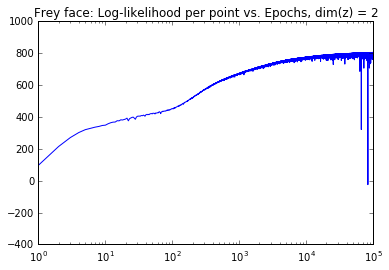

In [413]:
plt.plot(model_frey.log_likelihood_data)
plt.title('Frey face: Log-likelihood per point vs. Epochs, dim(z) = 2')
plt.xscale('log')
plt.savefig('../results/frey_z=2.png')
plt.show()

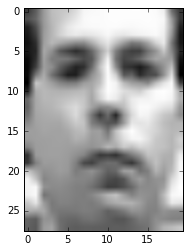

In [454]:
stuff = model_frey.sample().numpy()
plot_frey(stuff)